In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [3]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=4 ./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [4]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [5]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


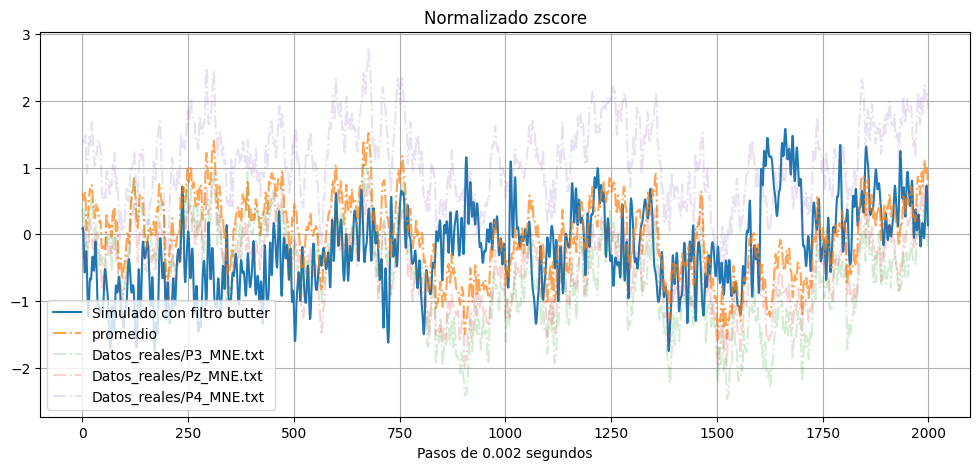

In [12]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


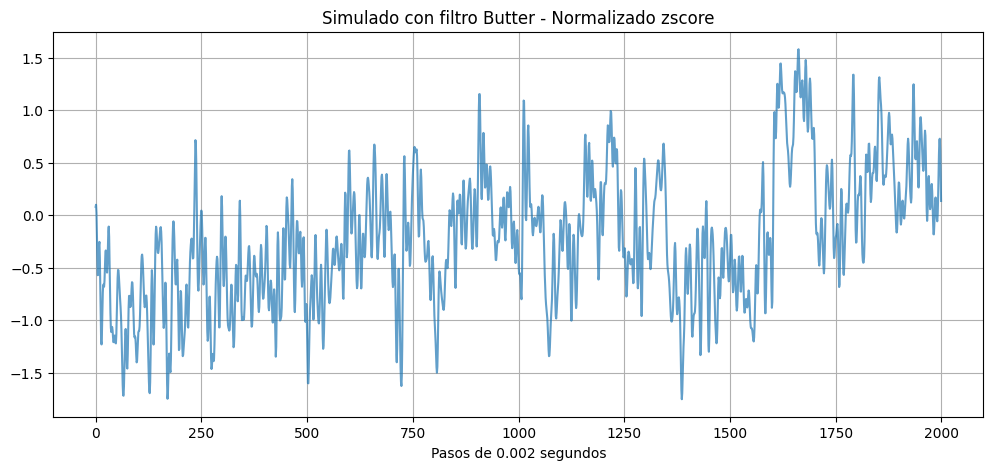

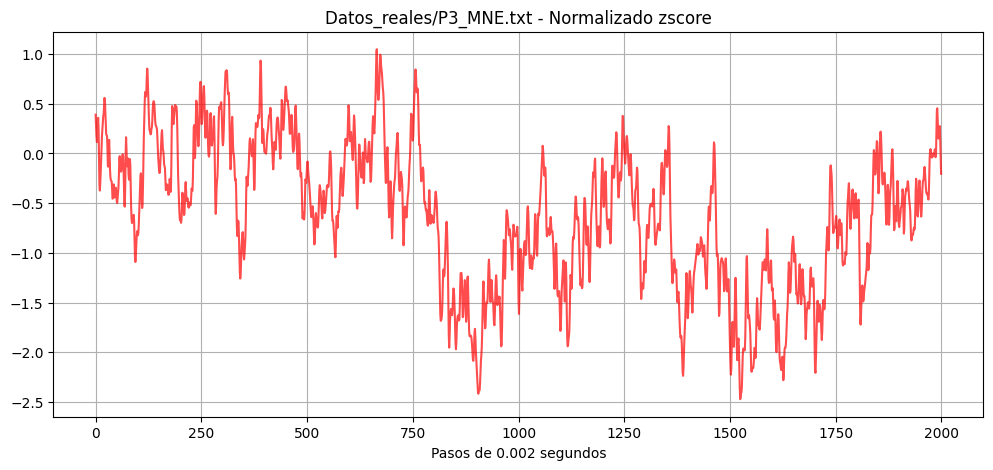

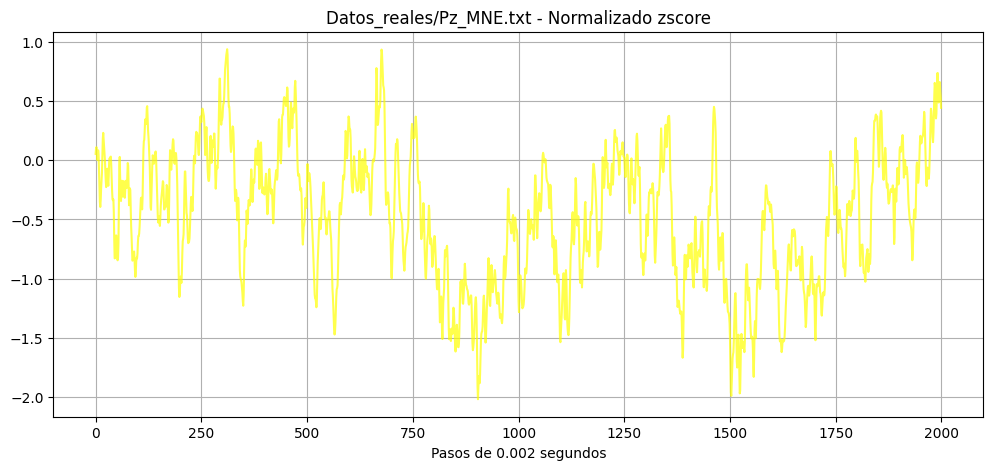

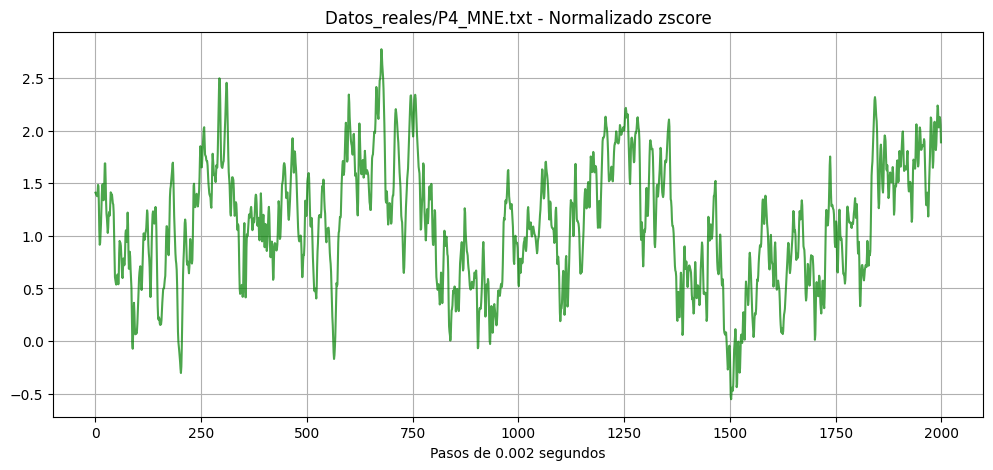

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Datos de ejemplo (ajusta esto a tus datos)
# reales_total["datos"] contiene 3 grupos de datos
# reales_total["Nombres"] contiene los nombres correspondientes a cada grupo

# Figura 1: Simulado con filtro Butter
fig1, ax1 = plt.subplots(figsize=[12, 5])
ax1.plot(generated_data["butter"][:], label="Simulado con filtro butter", alpha=0.7)
ax1.set_xlabel("Pasos de 0.002 segundos")
#ax1.legend()
ax1.grid()
ax1.set_title(f"Simulado con filtro Butter - Normalizado {Normalizacion}")
plt.show()

# Figura 2: Promedio de los grupos
fig2, ax2 = plt.subplots(figsize=[12, 5])
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0)
ax2.plot(reales_total["datos"][0], "-", label=reales_total["Nombres"][0], alpha=0.7,c="red")
ax2.set_xlabel("Pasos de 0.002 segundos")
#ax1.legend()
ax2.grid()
ax2.set_title(f"{reales_total['Nombres'][0]} - Normalizado {Normalizacion}")
plt.show()

# Figura 3: Grupo individual 1
fig3, ax3 = plt.subplots(figsize=[12, 5])
ax3.plot(reales_total["datos"][1], "-", label=reales_total["Nombres"][0], alpha=0.7,c="yellow")
ax3.set_xlabel("Pasos de 0.002 segundos")
#ax1.legend()
ax3.grid()
ax3.set_title(f"{reales_total['Nombres'][1]} - Normalizado {Normalizacion}")
plt.show()

fig4, ax4 = plt.subplots(figsize=[12, 5])
ax4.plot(reales_total["datos"][2], "-", label=reales_total["Nombres"][0], alpha=0.7,c="green")
ax4.set_xlabel("Pasos de 0.002 segundos")
#ax1.legend()
ax4.grid()
ax4.set_title(f"{reales_total['Nombres'][2]} - Normalizado {Normalizacion}")
plt.show()



241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [np.float64(-12.81079647226871), np.float64(2.47832746825149)] ---- [-14.32308775   2.88420902]
Theta [np.float64(-18.962615069593014), np.float64(1.5193222431157007)] ---- [-18.96571845   1.24854892]
Alpha [np.float64(-21.856946912684375), np.float64(1.3125319715213362)] ---- [-21.50437221   1.65501801]
Beta [np.float64(-27.230879440197736), np.float64(1.344153988424413)] ---- [-28.90417761   2.14572478]


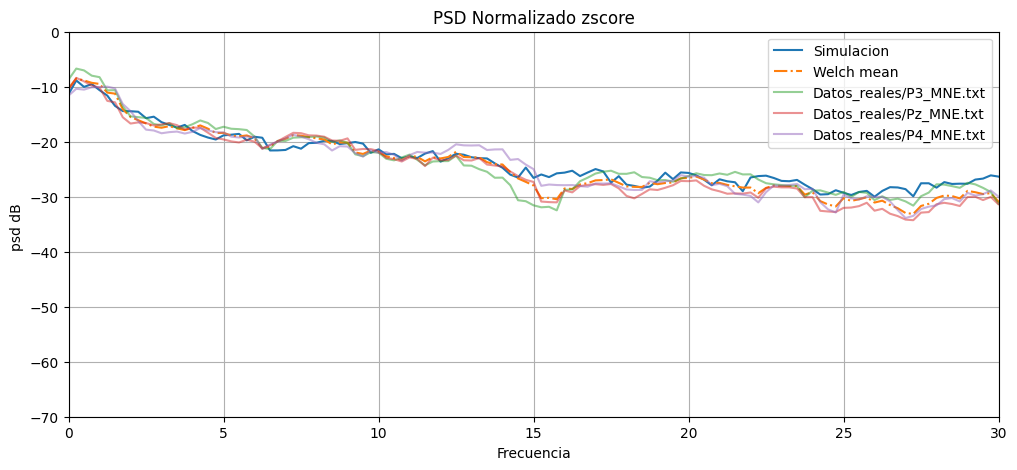

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L10", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L10.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L20", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L20.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-13 11:37:04,054] Using an existing study with name 'Chi30_zscore_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:05,315] Trial 778 finished with value: 192.07005512528445 and parameters: {'L': 25, 'P': 0.06725576475376749, 'Inh': 0.3280911815521583, 'Trest': 0.015211484411874504, 'Trelative': 0.19066069924505613, 'C_h': 0.8562137710982969, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:06,308] Trial 779 finished with value: 68.24863067104134 and parameters: {'L': 25, 'P': 0.020817932283151604, 'Inh': 0.29936941128324096, 'Trest': 0.3600620057514332, 'Trelative': 0.6116020383241362, 'C_h': 0.8726015203343812, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:07,285] Trial 780 finished with value: 889.0925398606631 and parameters: {'L': 25, 'P': 0.027177408566619633, 'Inh': 0.2843695970043847, 'Trest': 0.002780407938471785, 'Trelative': 0.02843081044523743, 'C_h': 0.9144494108142016, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:08,370] Trial 781 finished with value: 92.77151505054906 and parameters: {'L': 25, 'P': 0.016433229525234183, 'Inh': 0.3025284468983717, 'Trest': 0.1955307402020947, 'Trelative': 0.3998151523163701, 'C_h': 0.8727554918416471, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:09,373] Trial 782 finished with value: 181.2050818346807 and parameters: {'L': 25, 'P': 0.03195331131735617, 'Inh': 0.313755220166754, 'Trest': 0.3643028267895574, 'Trelative': 0.6122305528844867, 'C_h': 0.8154282589760043, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:10,395] Trial 783 finished with value: 110.48441518343932 and parameters: {'L': 25, 'P': 0.05045546892532188, 'Inh': 0.34121825369584696, 'Trest': 0.1806953367613579, 'Trelative': 0.3659712199639277, 'C_h': 0.8363451542440048, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:11,380] Trial 784 finished with value: 144.44956790668385 and parameters: {'L': 25, 'P': 0.003880175589877896, 'Inh': 0.2755630385111092, 'Trest': 0.4089412875942785, 'Trelative': 0.7012603174547991, 'C_h': 0.8902272029283099, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:12,352] Trial 785 finished with value: 119.40151628006912 and parameters: {'L': 25, 'P': 0.038442804354285195, 'Inh': 0.33152595994176637, 'Trest': 0.36708734172136503, 'Trelative': 0.6480761746618402, 'C_h': 0.9125495795906027, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:13,294] Trial 786 finished with value: 153.65904149282392 and parameters: {'L': 25, 'P': 0.07714896495109078, 'Inh': 0.3072408301939806, 'Trest': 0.12851943427932233, 'Trelative': 0.2625739266696694, 'C_h': 0.8784108745038377, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:14,240] Trial 787 finished with value: 117.3533774754966 and parameters: {'L': 25, 'P': 0.05778793376348305, 'Inh': 0.3481889780263368, 'Trest': 0.22247237449270157, 'Trelative': 0.43028689138089865, 'C_h': 0.844034949222159, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:15,259] Trial 788 finished with value: 120.47596301626878 and parameters: {'L': 25, 'P': 0.017475681855730077, 'Inh': 0.29487479307347464, 'Trest': 0.3683687013224299, 'Trelative': 0.6392066233607219, 'C_h': 0.8665392513894571, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:16,162] Trial 789 finished with value: 659.8427483707638 and parameters: {'L': 25, 'P': 0.08555102390582095, 'Inh': 0.3211800875705565, 'Trest': 0.0034435647314750018, 'Trelative': 0.019848496828823836, 'C_h': 0.9007602932114873, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:17,228] Trial 790 finished with value: 109.61472704929075 and parameters: {'L': 25, 'P': 0.05644824497305057, 'Inh': 0.344998172642342, 'Trest': 0.41614502300447853, 'Trelative': 0.6626447437970227, 'C_h': 0.8711086583134338, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:18,148] Trial 791 finished with value: 409.79193971228807 and parameters: {'L': 25, 'P': 0.03230623127960005, 'Inh': 0.3582509013056513, 'Trest': 0.0027242623426524115, 'Trelative': 0.017672065391547614, 'C_h': 0.9128921070526229, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:19,121] Trial 792 finished with value: 94.8563528707576 and parameters: {'L': 25, 'P': 0.08914972639677099, 'Inh': 0.3180901366429297, 'Trest': 0.24774882133511827, 'Trelative': 0.41110947452544333, 'C_h': 0.8300697028697349, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:20,069] Trial 793 finished with value: 256.10218913999205 and parameters: {'L': 25, 'P': 0.07077490389801375, 'Inh': 0.33067962712128435, 'Trest': 0.3522955101029388, 'Trelative': 0.5870497161311162, 'C_h': 0.8888923216090968, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:21,189] Trial 794 finished with value: 668.8394157705279 and parameters: {'L': 25, 'P': 0.03663176210647698, 'Inh': 0.29021889445699656, 'Trest': 0.19445072689223625, 'Trelative': 0.37392171301076016, 'C_h': 0.8531278754050952, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:22,163] Trial 795 finished with value: 64.19560036860992 and parameters: {'L': 25, 'P': 0.015670152401601616, 'Inh': 0.3660796267732837, 'Trest': 0.4241979483741101, 'Trelative': 0.7387114575307233, 'C_h': 0.8080984964420755, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:23,177] Trial 796 finished with value: 207.24406778647943 and parameters: {'L': 25, 'P': 5.172980951548278e-05, 'Inh': 0.3653853856661235, 'Trest': 0.4078808197061862, 'Trelative': 0.6740388464375056, 'C_h': 0.8016477077084933, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:24,111] Trial 797 finished with value: 178.85700185660508 and parameters: {'L': 25, 'P': 0.01778698162070836, 'Inh': 0.34656995241088034, 'Trest': 0.0015850670869997086, 'Trelative': 0.1094961178120063, 'C_h': 0.8090703160444417, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:25,103] Trial 798 finished with value: 276.5352455624817 and parameters: {'L': 25, 'P': 0.02305685676195682, 'Inh': 0.36925643842172573, 'Trest': 0.17854322127741917, 'Trelative': 0.36914591858443435, 'C_h': 0.8279450856025328, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:37:26,166] Trial 799 finished with value: 1942.1858573713714 and parameters: {'L': 25, 'P': 6.630892230569119e-05, 'Inh': 0.3387631498825191, 'Trest': 0.44305189073830764, 'Trelative': 0.7027791996562404, 'C_h': 0.9099463058265537, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:27,128] Trial 800 finished with value: 80.91814164238147 and parameters: {'L': 25, 'P': 0.04804008053534658, 'Inh': 0.3069435098880262, 'Trest': 0.21732746084290377, 'Trelative': 0.4545125328888351, 'C_h': 0.8878303240037141, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:28,176] Trial 801 finished with value: 75.2085761864313 and parameters: {'L': 25, 'P': 0.04488800476043494, 'Inh': 0.30552149152823715, 'Trest': 0.19239188124953174, 'Trelative': 0.40036519748022087, 'C_h': 0.8720074110506414, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:29,152] Trial 802 finished with value: 142.2191832609141 and parameters: {'L': 25, 'P': 0.032765147436502884, 'Inh': 0.2691029419176354, 'Trest': 0.2210964199932414, 'Trelative': 0.44467795564428475, 'C_h': 0.8421993359814359, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:30,138] Trial 803 finished with value: 96.97772894499032 and parameters: {'L': 25, 'P': 0.02118451463992873, 'Inh': 0.2911746141953791, 'Trest': 0.1834453303946185, 'Trelative': 0.42239477145564686, 'C_h': 0.8137551650128764, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:31,151] Trial 804 finished with value: 162.92862662693378 and parameters: {'L': 25, 'P': 0.054903378325758465, 'Inh': 0.3195038964011201, 'Trest': 0.009539600589518804, 'Trelative': 0.2370122629151497, 'C_h': 0.8688743311675328, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:32,242] Trial 805 finished with value: 88.79844286950937 and parameters: {'L': 25, 'P': 0.043578508488792606, 'Inh': 0.3575819436167925, 'Trest': 0.40908229462476997, 'Trelative': 0.6734379596579881, 'C_h': 0.8434558848945619, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:33,295] Trial 806 finished with value: 95.53662451050506 and parameters: {'L': 25, 'P': 0.06340890702384705, 'Inh': 0.33451740498692095, 'Trest': 0.20879009212808522, 'Trelative': 0.41498708451348815, 'C_h': 0.8770416009370078, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:34,413] Trial 807 finished with value: 76.51209867488357 and parameters: {'L': 25, 'P': 0.0208191288671495, 'Inh': 0.30441736689506893, 'Trest': 0.4332827581384858, 'Trelative': 0.6816703363836283, 'C_h': 0.9103498765584079, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:35,412] Trial 808 finished with value: 74.98480590750532 and parameters: {'L': 25, 'P': 0.017726735654372692, 'Inh': 0.27210845599730604, 'Trest': 0.484430309083868, 'Trelative': 0.7270396358723743, 'C_h': 0.8261118155219168, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:36,430] Trial 809 finished with value: 461.0884730998776 and parameters: {'L': 25, 'P': 0.00421525096007818, 'Inh': 0.2857665656638663, 'Trest': 0.45742122673234303, 'Trelative': 0.719421923274798, 'C_h': 0.8110533653469338, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:37,603] Trial 810 finished with value: 86.44305061424323 and parameters: {'L': 25, 'P': 0.021982116927758776, 'Inh': 0.26314465068504717, 'Trest': 0.18806752792806097, 'Trelative': 0.3783079514960654, 'C_h': 0.8280195515632218, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:38,744] Trial 811 finished with value: 1125.666384163923 and parameters: {'L': 25, 'P': 0.0008725928818506257, 'Inh': 0.28768838088570564, 'Trest': 0.002427004760282625, 'Trelative': 0.19582342656365292, 'C_h': 0.8008161940402208, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:37:40,311] Trial 812 finished with value: 1021.6849041572307 and parameters: {'L': 25, 'P': 0.021145729929092805, 'Inh': 0.2702998290088008, 'Trest': 0.34811483939516297, 'Trelative': 0.6152618757588503, 'C_h': 0.826724619865971, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:41,720] Trial 813 finished with value: 91.60126094557741 and parameters: {'L': 25, 'P': 0.036030497783375096, 'Inh': 0.29710232376293944, 'Trest': 0.4525319442325216, 'Trelative': 0.727218909489015, 'C_h': 0.9177368809389429, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:43,056] Trial 814 finished with value: 47.569403687774305 and parameters: {'L': 25, 'P': 0.019761578886134702, 'Inh': 0.30565802738180686, 'Trest': 0.4576810372378747, 'Trelative': 0.7306946410190323, 'C_h': 0.844571857200677, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:44,168] Trial 815 finished with value: 137.2113418405685 and parameters: {'L': 25, 'P': 0.01480847168508281, 'Inh': 0.2740839357049402, 'Trest': 0.44113737260434044, 'Trelative': 0.7178590812805181, 'C_h': 0.8428401330774904, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:45,426] Trial 816 finished with value: 515.9846217434417 and parameters: {'L': 25, 'P': 0.040392636386474536, 'Inh': 0.30730063717127293, 'Trest': 0.5018812838886588, 'Trelative': 0.7785574617533926, 'C_h': 0.8184116773848608, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:46,526] Trial 817 finished with value: 433.56855851796956 and parameters: {'L': 25, 'P': 0.016348881286226462, 'Inh': 0.30469331719627996, 'Trest': 0.4741470401180173, 'Trelative': 0.7678809161129683, 'C_h': 0.8001567928285475, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:47,654] Trial 818 finished with value: 490.24702861172153 and parameters: {'L': 25, 'P': 0.04596779487282452, 'Inh': 0.2465727987459504, 'Trest': 0.3214284937111608, 'Trelative': 0.5432192458436815, 'C_h': 0.8494114529987195, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:48,722] Trial 819 finished with value: 91.73419222705432 and parameters: {'L': 25, 'P': 0.03420490085103828, 'Inh': 0.2756054690105825, 'Trest': 0.5482042453960317, 'Trelative': 0.8109133438476583, 'C_h': 0.7931876757918005, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:49,821] Trial 820 finished with value: 222.3098574234983 and parameters: {'L': 25, 'P': 0.015832993581077717, 'Inh': 0.3157336063123049, 'Trest': 0.22782235574812332, 'Trelative': 0.4500685581436055, 'C_h': 0.8297910241612054, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:51,114] Trial 821 finished with value: 198.76658331696524 and parameters: {'L': 25, 'P': 0.00159857743328402, 'Inh': 0.3193105500922168, 'Trest': 0.4014692376958483, 'Trelative': 2.1902137946139866, 'C_h': 0.8981280947505498, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:52,245] Trial 822 finished with value: 108.0662995253832 and parameters: {'L': 25, 'P': 0.057212937088735843, 'Inh': 0.30473370834669, 'Trest': 0.008362793901343035, 'Trelative': 0.21023270104049296, 'C_h': 0.8540956631281291, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:37:53,417] Trial 823 finished with value: 1433.263697624523 and parameters: {'L': 25, 'P': 0.04084012664332563, 'Inh': 0.2592971449674409, 'Trest': 0.5210926483404991, 'Trelative': 0.821720871553169, 'C_h': 0.8694178978867609, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:54,536] Trial 824 finished with value: 113.39465115214698 and parameters: {'L': 25, 'P': 0.06594428372012519, 'Inh': 0.2856106596485956, 'Trest': 0.23886199217298093, 'Trelative': 0.40241411000186406, 'C_h': 0.9158987586753656, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:55,604] Trial 825 finished with value: 88.22657257184889 and parameters: {'L': 25, 'P': 0.032716529371169305, 'Inh': 0.31628150755675993, 'Trest': 0.4977691126383086, 'Trelative': 0.7164049606258098, 'C_h': 0.8954272020337127, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:56,810] Trial 826 finished with value: 2419.829433311689 and parameters: {'L': 25, 'P': 0.05349666309026387, 'Inh': 0.33290523798713667, 'Trest': 0.7614994916847718, 'Trelative': 1.0402170698291782, 'C_h': 0.850092862837523, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:57,837] Trial 827 finished with value: 76.56528020782847 and parameters: {'L': 25, 'P': 0.020569665245382958, 'Inh': 0.35268264230470014, 'Trest': 0.29570323426539746, 'Trelative': 0.5658937706165378, 'C_h': 0.8802165382771336, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:37:58,946] Trial 828 finished with value: 100.08587841204937 and parameters: {'L': 25, 'P': 0.07369225026734161, 'Inh': 0.2984841402682748, 'Trest': 0.6855436540205037, 'Trelative': 0.9740153613752925, 'C_h': 0.8284128236878753, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:00,062] Trial 829 finished with value: 198.9835064945793 and parameters: {'L': 25, 'P': 0.04202515741571133, 'Inh': 0.32381348332163473, 'Trest': 0.18751114067340816, 'Trelative': 0.36782449760588287, 'C_h': 0.862972727004602, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:01,100] Trial 830 finished with value: 140.28887658667037 and parameters: {'L': 25, 'P': 0.01752898472979543, 'Inh': 0.27974401765752754, 'Trest': 0.49928318699259916, 'Trelative': 0.7435938597555817, 'C_h': 0.9140045704067102, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:02,142] Trial 831 finished with value: 606.1784794143574 and parameters: {'L': 25, 'P': 0.0013699259386850508, 'Inh': 0.3539192870614496, 'Trest': 0.34340480469037793, 'Trelative': 0.5992740042849407, 'C_h': 0.7834121886933966, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:03,154] Trial 832 finished with value: 1588.2328562655725 and parameters: {'L': 25, 'P': 0.05745816038345788, 'Inh': 0.33344185160446127, 'Trest': 0.0046874996707213235, 'Trelative': 0.006728660361998817, 'C_h': 0.8423936913611695, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:04,396] Trial 833 finished with value: 85.38090451062837 and parameters: {'L': 25, 'P': 0.07166218271445762, 'Inh': 0.3000656774914671, 'Trest': 0.5069232580210987, 'Trelative': 0.7673845519104341, 'C_h': 0.8750065050209735, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:05,448] Trial 834 finished with value: 91.82304193118064 and parameters: {'L': 25, 'P': 0.042614269167934954, 'Inh': 0.3734012015802759, 'Trest': 0.6711421273339252, 'Trelative': 0.9535177245755302, 'C_h': 0.9006441110292157, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:06,690] Trial 835 finished with value: 196.61170238613468 and parameters: {'L': 26, 'P': 0.02881599570934698, 'Inh': 0.32967662063141745, 'Trest': 0.24843771115781157, 'Trelative': 0.5153104170215559, 'C_h': 0.8890440900722494, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:38:07,894] Trial 836 finished with value: 4647.187534281437 and parameters: {'L': 25, 'P': 0.0745142789407624, 'Inh': 0.26238667136617855, 'Trest': 0.18908203905123677, 'Trelative': 0.3729235004540344, 'C_h': 0.8186918761329557, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:09,019] Trial 837 finished with value: 232.87719432525782 and parameters: {'L': 25, 'P': 0.053285588291451094, 'Inh': 0.3531833841002605, 'Trest': 0.7454738670705112, 'Trelative': 1.0301801345862738, 'C_h': 0.8615871313187897, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:10,158] Trial 838 finished with value: 187.09086564631815 and parameters: {'L': 25, 'P': 0.03860265116555982, 'Inh': 0.31167195761697475, 'Trest': 0.3894686336680065, 'Trelative': 0.6352578820161917, 'C_h': 0.9193397121159573, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:11,304] Trial 839 finished with value: 183.25219192605996 and parameters: {'L': 25, 'P': 0.10045958855917994, 'Inh': 0.2878282912833186, 'Trest': 0.47730817783647594, 'Trelative': 0.7277111122247908, 'C_h': 0.8499867216602625, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:12,542] Trial 840 finished with value: 141.13239288050963 and parameters: {'L': 26, 'P': 0.00010142684580267611, 'Inh': 0.3687483061380174, 'Trest': 0.19590984684680338, 'Trelative': 0.4076791702923626, 'C_h': 0.8745028267617606, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:13,662] Trial 841 finished with value: 1644.7593976387361 and parameters: {'L': 25, 'P': 0.01956878752977223, 'Inh': 0.3358887791035815, 'Trest': 0.6938421393900157, 'Trelative': 1.0119713559093186, 'C_h': 0.8962042781548103, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:14,794] Trial 842 finished with value: 436.5085924226889 and parameters: {'L': 25, 'P': 0.07224018318936568, 'Inh': 0.3501889989726449, 'Trest': 0.006622547881002451, 'Trelative': 0.12587063567118534, 'C_h': 0.8363532523352186, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:15,912] Trial 843 finished with value: 126.81920373810932 and parameters: {'L': 25, 'P': 0.052254162611098415, 'Inh': 0.31084751705454833, 'Trest': 0.3674394065034722, 'Trelative': 0.6124674169911359, 'C_h': 0.7994149767945351, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:16,972] Trial 844 finished with value: 95.96262328265854 and parameters: {'L': 26, 'P': 0.09932425610370882, 'Inh': 0.37158553665305716, 'Trest': 0.5554654592676312, 'Trelative': 0.842841433232727, 'C_h': 0.9165407293752097, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:17,978] Trial 845 finished with value: 141.7239689767297 and parameters: {'L': 25, 'P': 0.02737287911705476, 'Inh': 0.3282377742723382, 'Trest': 0.19009029444195735, 'Trelative': 0.35453591855757666, 'C_h': 0.8710797707287109, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:19,103] Trial 846 finished with value: 154.01855011163988 and parameters: {'L': 25, 'P': 0.07180166725065028, 'Inh': 0.2981147363083036, 'Trest': 0.7661535938174175, 'Trelative': 1.0426938016835574, 'C_h': 0.8863749123729173, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:20,254] Trial 847 finished with value: 168.1672047865817 and parameters: {'L': 25, 'P': 0.04701700622338321, 'Inh': 0.3551629877297415, 'Trest': 0.37907541214883983, 'Trelative': 0.6137083836879138, 'C_h': 0.854411587152789, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:38:21,366] Trial 848 finished with value: 1027.9159241781472 and parameters: {'L': 25, 'P': 0.020845264892089557, 'Inh': 0.27947449330496615, 'Trest': 0.548401360675584, 'Trelative': 0.8056963775105216, 'C_h': 0.8236442394019173, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:22,640] Trial 849 finished with value: 92.05622857118244 and parameters: {'L': 25, 'P': 0.08649168998232162, 'Inh': 0.3858596592328362, 'Trest': 0.17475317063042445, 'Trelative': 0.39847588116347404, 'C_h': 0.9006057956868982, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:23,724] Trial 850 finished with value: 210.41858082405125 and parameters: {'L': 24, 'P': 0.05712005444337076, 'Inh': 0.3408002670202144, 'Trest': 0.8365681595884802, 'Trelative': 1.1372378765547535, 'C_h': 0.868811610467001, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:24,823] Trial 851 finished with value: 604.75773555358 and parameters: {'L': 25, 'P': 0.03774840367451134, 'Inh': 0.3082217187679605, 'Trest': 0.3471715381842737, 'Trelative': 0.5762644050712069, 'C_h': 0.8404278756660786, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:25,822] Trial 852 finished with value: 487.15397089073196 and parameters: {'L': 24, 'P': 0.07554743859213117, 'Inh': 0.24729180464483191, 'Trest': 0.16459406916874486, 'Trelative': 0.3149982974586376, 'C_h': 0.8934670327161671, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:26,917] Trial 853 finished with value: 123.47438347142662 and parameters: {'L': 25, 'P': 0.013188901024315233, 'Inh': 0.3246976731070561, 'Trest': 0.5565601208398255, 'Trelative': 0.841693561577861, 'C_h': 0.8569901352425495, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:27,829] Trial 854 finished with value: 72.88654610727913 and parameters: {'L': 24, 'P': 0.1025918534838807, 'Inh': 0.3670422504067432, 'Trest': 0.34024516322557263, 'Trelative': 0.5773808220988453, 'C_h': 0.9182961678668403, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:28,805] Trial 855 finished with value: 78.35311696609389 and parameters: {'L': 24, 'P': 0.10670532560228596, 'Inh': 0.3692410504153605, 'Trest': 0.17243706261017638, 'Trelative': 0.30261489128485514, 'C_h': 0.8109259178387518, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:29,750] Trial 856 finished with value: 136.1418794206003 and parameters: {'L': 24, 'P': 0.1015048342132823, 'Inh': 0.3777633854960434, 'Trest': 0.008066596671006454, 'Trelative': 0.16832789214200483, 'C_h': 0.9212641974273513, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:30,651] Trial 857 finished with value: 116.71677990240791 and parameters: {'L': 24, 'P': 0.09600830330855062, 'Inh': 0.39101992745362135, 'Trest': 0.2990025321973754, 'Trelative': 0.5658191063300712, 'C_h': 0.880533460653587, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:31,613] Trial 858 finished with value: 145.74352255437736 and parameters: {'L': 24, 'P': 0.0845210469230995, 'Inh': 0.35088717406757347, 'Trest': 0.6636291147119584, 'Trelative': 0.9514115860086165, 'C_h': 0.8431785173973801, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:32,552] Trial 859 finished with value: 179.44232159102313 and parameters: {'L': 24, 'P': 0.06605816390247446, 'Inh': 0.3671517785030893, 'Trest': 0.00458939970964678, 'Trelative': 0.17031164445061192, 'C_h': 0.8709453061139564, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:33,522] Trial 860 finished with value: 111.3937318336763 and parameters: {'L': 24, 'P': 0.12033643182224367, 'Inh': 0.35735755813671105, 'Trest': 0.3618044331281165, 'Trelative': 0.5979855981046993, 'C_h': 0.8272767361585389, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:34,570] Trial 861 finished with value: 134.46909581440806 and parameters: {'L': 24, 'P': 0.05743461631087799, 'Inh': 0.38645133264842907, 'Trest': 0.8315642990097987, 'Trelative': 1.1061478469570278, 'C_h': 0.9176103947204399, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:35,587] Trial 862 finished with value: 61.8562014974279 and parameters: {'L': 24, 'P': 0.09568559909240147, 'Inh': 0.3385262672541873, 'Trest': 0.5159328876989344, 'Trelative': 0.7839479663195559, 'C_h': 0.8939637245516658, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:36,487] Trial 863 finished with value: 83.09761966286204 and parameters: {'L': 24, 'P': 0.10336189735106005, 'Inh': 0.3864346079671155, 'Trest': 0.6113396353020499, 'Trelative': 0.8742791664801732, 'C_h': 0.8969669620084069, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:37,490] Trial 864 finished with value: 103.22336299050856 and parameters: {'L': 24, 'P': 0.12350883526709247, 'Inh': 0.350237690137494, 'Trest': 0.9442843800676227, 'Trelative': 1.2352244669348247, 'C_h': 0.9227436841818331, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:38,563] Trial 865 finished with value: 117.96237933873417 and parameters: {'L': 24, 'P': 0.0834866062366051, 'Inh': 0.3696649790425563, 'Trest': 0.7054854547626902, 'Trelative': 0.9634109740514901, 'C_h': 0.8961198888463366, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:39,567] Trial 866 finished with value: 253.05798863290022 and parameters: {'L': 24, 'P': 0.09802538049199104, 'Inh': 0.34040959424259276, 'Trest': 0.481213409380808, 'Trelative': 0.7391096329441194, 'C_h': 0.9192929330086812, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:40,575] Trial 867 finished with value: 110.35024927580262 and parameters: {'L': 24, 'P': 0.12241702328685165, 'Inh': 0.39243196351728943, 'Trest': 0.5305671744978443, 'Trelative': 0.8090875544318711, 'C_h': 0.8821469568902139, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:41,676] Trial 868 finished with value: 140.23693758144483 and parameters: {'L': 24, 'P': 0.08590489583483829, 'Inh': 0.36547203211820145, 'Trest': 0.8320122764853911, 'Trelative': 1.1350052383313076, 'C_h': 0.9000615954249598, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:42,751] Trial 869 finished with value: 104.13710165970741 and parameters: {'L': 24, 'P': 0.06780182202962792, 'Inh': 0.33795744174564013, 'Trest': 0.3942493277048772, 'Trelative': 0.6097602624246915, 'C_h': 0.8817386287942475, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:43,672] Trial 870 finished with value: 101.7133848752614 and parameters: {'L': 24, 'P': 0.10768178300374105, 'Inh': 0.3951284445372495, 'Trest': 0.6581230144745261, 'Trelative': 0.9432983073786054, 'C_h': 0.9203843643578383, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:44,610] Trial 871 finished with value: 103.16362343608266 and parameters: {'L': 24, 'P': 0.07888719118508787, 'Inh': 0.3259063774322988, 'Trest': 0.19527293225496717, 'Trelative': 0.3761561195506795, 'C_h': 0.7823985201668223, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:45,595] Trial 872 finished with value: 1417.607539361191 and parameters: {'L': 24, 'P': 0.05546884973745568, 'Inh': 0.3569959277455315, 'Trest': 0.4697636539071215, 'Trelative': 0.7775699558263437, 'C_h': 0.8674729427508695, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:46,609] Trial 873 finished with value: 181.37293656450018 and parameters: {'L': 24, 'P': 0.09547016644259616, 'Inh': 0.31804050081059726, 'Trest': 0.8929443416014458, 'Trelative': 1.1618106506914632, 'C_h': 0.8982362585584203, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:47,627] Trial 874 finished with value: 93.71103383157568 and parameters: {'L': 24, 'P': 0.12870541646574132, 'Inh': 0.3801821787654307, 'Trest': 0.3377057614742292, 'Trelative': 0.5385850309296109, 'C_h': 0.8458463979181143, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:48,686] Trial 875 finished with value: 157.13881286632173 and parameters: {'L': 24, 'P': 0.07012447096407073, 'Inh': 0.3541201928450357, 'Trest': 0.6629318720688973, 'Trelative': 0.9743424209806747, 'C_h': 0.8818475979208154, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:38:49,546] Trial 876 finished with value: 9587.885884847288 and parameters: {'L': 24, 'P': 0.04567239061317946, 'Inh': 0.39754516436024395, 'Trest': 0.001621091321658552, 'Trelative': 0.15919709054348385, 'C_h': 0.8160653831597715, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:50,514] Trial 877 finished with value: 129.21294933542148 and parameters: {'L': 24, 'P': 0.11179039563151297, 'Inh': 0.2840021085120991, 'Trest': 0.5163381273608735, 'Trelative': 0.7918028502294163, 'C_h': 0.8576583935123581, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:51,537] Trial 878 finished with value: 113.09863613145089 and parameters: {'L': 24, 'P': 0.0770382232692558, 'Inh': 0.33767788809695176, 'Trest': 0.3362120120856188, 'Trelative': 0.5486412822708586, 'C_h': 0.9036573756305449, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:52,524] Trial 879 finished with value: 71.31068795333336 and parameters: {'L': 24, 'P': 0.055145713422529254, 'Inh': 0.37411348638682573, 'Trest': 0.1787096293132775, 'Trelative': 0.3666294983821097, 'C_h': 0.922630158216467, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:53,468] Trial 880 finished with value: 66.44710278637118 and parameters: {'L': 24, 'P': 0.04612636950940077, 'Inh': 0.36826617179981297, 'Trest': 0.1575625264597786, 'Trelative': 0.3287599559609168, 'C_h': 0.9253303416356949, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:54,419] Trial 881 finished with value: 124.40699470199638 and parameters: {'L': 24, 'P': 0.0602428035230641, 'Inh': 0.37161047839171274, 'Trest': 0.1427000104732637, 'Trelative': 0.32151730272064477, 'C_h': 0.921790824852168, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:55,245] Trial 882 finished with value: 11449.213236836491 and parameters: {'L': 24, 'P': 0.03888972743564058, 'Inh': 0.37437942838155336, 'Trest': 0.004102426165319112, 'Trelative': 0.028653866102514303, 'C_h': 0.9249740812227187, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:56,260] Trial 883 finished with value: 111.18209782048942 and parameters: {'L': 24, 'P': 0.06409873621983589, 'Inh': 0.36694566972676457, 'Trest': 0.21782583106017378, 'Trelative': 0.4620135321664155, 'C_h': 0.9064426883428702, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:38:57,185] Trial 884 finished with value: 3577.7124030017835 and parameters: {'L': 24, 'P': 0.08449081252102253, 'Inh': 0.3937877446809719, 'Trest': 0.003583048706780556, 'Trelative': 0.03289607231585884, 'C_h': 0.9240463840454264, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:58,203] Trial 885 finished with value: 332.2173762223636 and parameters: {'L': 24, 'P': 0.04111309072188573, 'Inh': 0.35026848177994624, 'Trest': 0.32394727388256706, 'Trelative': 0.530630973698143, 'C_h': 0.9204853671172578, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:38:59,154] Trial 886 finished with value: 55.06550350009775 and parameters: {'L': 24, 'P': 0.056931370465947304, 'Inh': 0.3802773955906461, 'Trest': 0.17924760506573723, 'Trelative': 0.37082790655466086, 'C_h': 0.9299429152203457, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:00,133] Trial 887 finished with value: 127.331387831432 and parameters: {'L': 24, 'P': 0.08627748131515532, 'Inh': 0.3815695465426099, 'Trest': 0.1695336755931996, 'Trelative': 0.3332564652892846, 'C_h': 0.9208401194198849, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:01,089] Trial 888 finished with value: 101.78342617602782 and parameters: {'L': 24, 'P': 0.06720967707286024, 'Inh': 0.394919746442958, 'Trest': 0.16591586052031804, 'Trelative': 0.35263741040979213, 'C_h': 0.9072845823520163, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:02,035] Trial 889 finished with value: 73.39686073316386 and parameters: {'L': 24, 'P': 0.09991247540980326, 'Inh': 0.36565653908385876, 'Trest': 0.18612701609996177, 'Trelative': 0.41815390905279426, 'C_h': 0.921195081164035, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:03,024] Trial 890 finished with value: 115.79282946580913 and parameters: {'L': 24, 'P': 0.0951641062435463, 'Inh': 0.371732836908592, 'Trest': 0.16536130655788667, 'Trelative': 0.3331919024258233, 'C_h': 0.9302068469970549, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:03,954] Trial 891 finished with value: 74.5022503769602 and parameters: {'L': 24, 'P': 0.10728117265942899, 'Inh': 0.4019651515201475, 'Trest': 0.15906388848949787, 'Trelative': 0.3746954083191418, 'C_h': 0.9274587076092908, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:04,868] Trial 892 finished with value: 128.64349913982227 and parameters: {'L': 24, 'P': 0.0981077808590588, 'Inh': 0.36536693080541016, 'Trest': 0.013869846386231066, 'Trelative': 0.13164648243480026, 'C_h': 0.9246511235728117, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:05,762] Trial 893 finished with value: 111.36375686216783 and parameters: {'L': 24, 'P': 0.08421571883800444, 'Inh': 0.38444948005364626, 'Trest': 0.30073170990262416, 'Trelative': 0.5426894438427045, 'C_h': 0.9286755252192597, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:06,704] Trial 894 finished with value: 142.3143904597446 and parameters: {'L': 24, 'P': 0.11316227935839154, 'Inh': 0.3599549748262724, 'Trest': 0.17553663240563547, 'Trelative': 0.365538785404044, 'C_h': 0.906447934503707, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:07,755] Trial 895 finished with value: 230.49298858873902 and parameters: {'L': 24, 'P': 0.053878347151307474, 'Inh': 0.4029331319186241, 'Trest': 0.3558870156915269, 'Trelative': 0.6043552981114328, 'C_h': 0.9272076711013715, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:08,791] Trial 896 finished with value: 163.96534218802452 and parameters: {'L': 24, 'P': 0.07340640950410864, 'Inh': 0.3812732540150425, 'Trest': 0.026450941658101135, 'Trelative': 0.1700009989883364, 'C_h': 0.8978843386584455, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:09,878] Trial 897 finished with value: 1641.4339423443248 and parameters: {'L': 24, 'P': 0.053236345902179114, 'Inh': 0.3471334645259358, 'Trest': 0.33880188325171723, 'Trelative': 0.5690653992538599, 'C_h': 0.9083142111848743, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:10,828] Trial 898 finished with value: 106.16866265517803 and parameters: {'L': 24, 'P': 0.13103964531224604, 'Inh': 0.36255411678672095, 'Trest': 0.16687117401708507, 'Trelative': 0.32647303000831707, 'C_h': 0.8905256971654698, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:11,788] Trial 899 finished with value: 105.07254712080884 and parameters: {'L': 24, 'P': 0.09518274497274486, 'Inh': 0.40092675730590677, 'Trest': 0.010484382472129739, 'Trelative': 0.1570347622868131, 'C_h': 0.9310997167725569, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:12,812] Trial 900 finished with value: 114.70489524381394 and parameters: {'L': 24, 'P': 0.07026560592728565, 'Inh': 0.3808897935009442, 'Trest': 0.3471851899855102, 'Trelative': 0.5901594351422631, 'C_h': 0.9066713824902737, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:13,832] Trial 901 finished with value: 44.478939948897235 and parameters: {'L': 24, 'P': 0.03642787224900737, 'Inh': 0.34514809976296107, 'Trest': 0.5039771793333252, 'Trelative': 0.7595051091651088, 'C_h': 0.8852476328752046, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:14,833] Trial 902 finished with value: 58.30594629647458 and parameters: {'L': 24, 'P': 0.03841223332491429, 'Inh': 0.33952441911832565, 'Trest': 0.5761868097943059, 'Trelative': 0.8286691799822141, 'C_h': 0.8781444863505705, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:15,822] Trial 903 finished with value: 373.2555103682778 and parameters: {'L': 24, 'P': 0.034498008231355445, 'Inh': 0.3332409199116467, 'Trest': 0.7831805752219607, 'Trelative': 1.0678704979666405, 'C_h': 0.880544854291116, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:17,011] Trial 904 finished with value: 118.99136410792448 and parameters: {'L': 24, 'P': 0.034432534855405206, 'Inh': 0.3371309799204035, 'Trest': 0.6192535863091628, 'Trelative': 0.8653430469048975, 'C_h': 0.8824075369797504, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:18,037] Trial 905 finished with value: 166.23110588812634 and parameters: {'L': 24, 'P': 0.034514479141604534, 'Inh': 0.3447798733293234, 'Trest': 0.9471322544913812, 'Trelative': 1.2506371131773268, 'C_h': 0.8815440260623087, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:19,023] Trial 906 finished with value: 111.86353131530315 and parameters: {'L': 24, 'P': 0.048346732630661395, 'Inh': 0.3271810871199563, 'Trest': 0.5773626203278082, 'Trelative': 0.8626714502197517, 'C_h': 0.8913911071366318, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:39:20,032] Trial 907 finished with value: 1637.9047161465892 and parameters: {'L': 24, 'P': 0.018590642503776508, 'Inh': 0.319941736331161, 'Trest': 0.7931454178225563, 'Trelative': 1.0649093331713944, 'C_h': 0.8683832428638238, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:21,010] Trial 908 finished with value: 165.95320243135166 and parameters: {'L': 24, 'P': 0.04789191113549766, 'Inh': 0.3455394566875233, 'Trest': 0.4898274365210691, 'Trelative': 0.7486426035212822, 'C_h': 0.8917887202580512, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:22,057] Trial 909 finished with value: 592.7725144516223 and parameters: {'L': 24, 'P': 0.0043207514145024925, 'Inh': 0.35765463611981285, 'Trest': 0.7361261705790563, 'Trelative': 0.9867180958396515, 'C_h': 0.878572742392389, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:23,034] Trial 910 finished with value: 499.70652935466813 and parameters: {'L': 24, 'P': 0.00046316452073316694, 'Inh': 0.32321165221399467, 'Trest': 0.5144383993929831, 'Trelative': 0.7653646002787375, 'C_h': 0.8600406458492483, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:24,018] Trial 911 finished with value: 105.4664858727315 and parameters: {'L': 24, 'P': 0.03180675620224761, 'Inh': 0.3828750432061479, 'Trest': 0.5188470144820629, 'Trelative': 0.7481420694024553, 'C_h': 0.8966401667607021, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:39:25,056] Trial 912 finished with value: 6774.1217786951565 and parameters: {'L': 24, 'P': 0.05521647703852017, 'Inh': 0.3493280081914436, 'Trest': 0.8923043236726074, 'Trelative': 1.1965203536916826, 'C_h': 0.8656491831787554, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:26,098] Trial 913 finished with value: 35299.381520947594 and parameters: {'L': 24, 'P': 0.03349896616121382, 'Inh': 0.39758526633430435, 'Trest': 1.101505588095384, 'Trelative': 1.4455708575904875, 'C_h': 0.8499846139941641, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:27,089] Trial 914 finished with value: 94.0729183159801 and parameters: {'L': 24, 'P': 0.05842364887270672, 'Inh': 0.31824628809406075, 'Trest': 0.6421012652028623, 'Trelative': 0.9332325855615822, 'C_h': 0.8993343962589815, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:28,073] Trial 915 finished with value: 102.8956244276289 and parameters: {'L': 24, 'P': 0.019818535256497863, 'Inh': 0.3430224552669329, 'Trest': 0.3620654009914527, 'Trelative': 0.6674182260598455, 'C_h': 0.8763692089781076, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:28,974] Trial 916 finished with value: 93.45936802290593 and parameters: {'L': 24, 'P': 0.04171996985794646, 'Inh': 0.37133203175200497, 'Trest': 0.4970955280976304, 'Trelative': 0.790052921975389, 'C_h': 0.8394034680945471, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:30,008] Trial 917 finished with value: 86.12298887274001 and parameters: {'L': 24, 'P': 0.06832299456476534, 'Inh': 0.35282370906224114, 'Trest': 0.6790073751612536, 'Trelative': 0.9592188300921805, 'C_h': 0.9040669934270156, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:30,909] Trial 918 finished with value: 98.01864881697746 and parameters: {'L': 24, 'P': 0.03010018835329207, 'Inh': 0.40292610770972603, 'Trest': 0.3388617805562387, 'Trelative': 0.5458855686064261, 'C_h': 0.8770802282467333, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:31,824] Trial 919 finished with value: 1009.074557955093 and parameters: {'L': 24, 'P': 0.05651679676882304, 'Inh': 0.3314120829588925, 'Trest': 0.0055199146066244875, 'Trelative': 0.01543517477736328, 'C_h': 0.8914202957064625, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:33,069] Trial 920 finished with value: 1088.7394498028023 and parameters: {'L': 24, 'P': 0.017321370815288277, 'Inh': 0.38632510668546327, 'Trest': 0.4449759704655979, 'Trelative': 0.7065553366304187, 'C_h': 0.8569250396849786, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:34,143] Trial 921 finished with value: 178.35146543058752 and parameters: {'L': 24, 'P': 0.07337670226829392, 'Inh': 0.3131343765186914, 'Trest': 0.8324352622786148, 'Trelative': 1.116004983058758, 'C_h': 0.9096467981637169, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:35,128] Trial 922 finished with value: 67.62401024881244 and parameters: {'L': 24, 'P': 0.04429528368456838, 'Inh': 0.36856262936480844, 'Trest': 0.2663524388598682, 'Trelative': 0.5216553653849632, 'C_h': 0.8686945161793382, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:36,138] Trial 923 finished with value: 572.3900975354234 and parameters: {'L': 24, 'P': 0.0007759455209918054, 'Inh': 0.356154790931487, 'Trest': 0.5810108748279326, 'Trelative': 0.918407712359625, 'C_h': 0.83521050741038, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:37,108] Trial 924 finished with value: 101.90083789117988 and parameters: {'L': 24, 'P': 0.03819835876848537, 'Inh': 0.34121154058872916, 'Trest': 0.9779118184013793, 'Trelative': 1.2466987756679464, 'C_h': 0.8540633591128135, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:38,076] Trial 925 finished with value: 113.56797043039045 and parameters: {'L': 24, 'P': 0.021795500955076, 'Inh': 0.3029501301096469, 'Trest': 0.3266100128996162, 'Trelative': 0.6527191786207495, 'C_h': 0.868790699864921, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:39,201] Trial 926 finished with value: 100.89595233868305 and parameters: {'L': 24, 'P': 0.04841238101699276, 'Inh': 0.32489873377848066, 'Trest': 0.7071408549138505, 'Trelative': 1.0147608590304162, 'C_h': 0.8473017488918396, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:40,216] Trial 927 finished with value: 100.06257529774558 and parameters: {'L': 24, 'P': 0.07459910483157363, 'Inh': 0.4041189322400782, 'Trest': 0.49401497585587967, 'Trelative': 0.7516619224896777, 'C_h': 0.8812190816674169, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:41,243] Trial 928 finished with value: 1069.5289079608235 and parameters: {'L': 24, 'P': 0.03299712451552636, 'Inh': 0.362324521768472, 'Trest': 0.2187493660130134, 'Trelative': 0.40373795059321005, 'C_h': 0.8686455164436464, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:42,090] Trial 929 finished with value: 1033.164862221166 and parameters: {'L': 24, 'P': 0.05037809142576129, 'Inh': 0.3842636913871766, 'Trest': 0.005362862579221805, 'Trelative': 0.1645707632224256, 'C_h': 0.834068045953215, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:43,076] Trial 930 finished with value: 338.33505340553967 and parameters: {'L': 24, 'P': 0.00011305400108739538, 'Inh': 0.3281797481521268, 'Trest': 0.6747779100395586, 'Trelative': 0.9044543524327412, 'C_h': 0.8836819366329641, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:44,022] Trial 931 finished with value: 95.58030745092061 and parameters: {'L': 24, 'P': 0.07038547638297044, 'Inh': 0.3487787348011705, 'Trest': 0.3858773222784341, 'Trelative': 0.66561479034947, 'C_h': 0.8534374797689592, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:45,014] Trial 932 finished with value: 101.61092934015241 and parameters: {'L': 24, 'P': 0.02063874652240143, 'Inh': 0.3010347317476202, 'Trest': 0.20057328876255326, 'Trelative': 0.4555310482526034, 'C_h': 0.8079688863641913, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:45,908] Trial 933 finished with value: 105.91429218522566 and parameters: {'L': 24, 'P': 0.07812830258778142, 'Inh': 0.377376518857299, 'Trest': 0.5048172750628481, 'Trelative': 0.7828526507813726, 'C_h': 0.8662023977677662, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:46,958] Trial 934 finished with value: 335.7803816771026 and parameters: {'L': 24, 'P': 0.042100001217862185, 'Inh': 0.40133111961293594, 'Trest': 0.8827521254990354, 'Trelative': 1.1587805150497243, 'C_h': 0.8308329060438472, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:48,042] Trial 935 finished with value: 134.85118003653642 and parameters: {'L': 24, 'P': 0.05709891327895577, 'Inh': 0.3602258256036007, 'Trest': 0.36557682439482736, 'Trelative': 0.5974030495752383, 'C_h': 0.8880141333068772, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:49,125] Trial 936 finished with value: 151.01453164336368 and parameters: {'L': 24, 'P': 0.07984261893549302, 'Inh': 0.32024038106186464, 'Trest': 0.6824991424251476, 'Trelative': 0.954293803030294, 'C_h': 0.9007380766619698, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_6171/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:39:50,195] Trial 937 finished with value: inf and parameters: {'L': 24, 'P': 0.03601039750727144, 'Inh': 0.37776936575099057, 'Trest': 1.2277981659752406, 'Trelative': 1.4871055596552836, 'C_h': 0.8458726951533452, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:39:51,201] Trial 938 finished with value: 840.700994455966 and parameters: {'L': 24, 'P': 0.023498979907285247, 'Inh': 0.3415984916124635, 'Trest': 0.29104353405544203, 'Trelative': 0.5544730706874776, 'C_h': 0.9287266085939403, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:52,308] Trial 939 finished with value: 57.99874516195444 and parameters: {'L': 24, 'P': 0.060569514773649226, 'Inh': 0.40468518683150123, 'Trest': 0.19423255290619842, 'Trelative': 0.4196302568262867, 'C_h': 0.8690302981921576, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:53,204] Trial 940 finished with value: 108.05203861953382 and parameters: {'L': 24, 'P': 0.08586191024775065, 'Inh': 0.39968342673865753, 'Trest': 0.5100120735140888, 'Trelative': 0.7639409775753174, 'C_h': 0.8635789113016864, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:39:54,224] Trial 941 finished with value: 29922.949410929632 and parameters: {'L': 24, 'P': 0.06256436063048099, 'Inh': 0.301132611724572, 'Trest': 1.0714806376583268, 'Trelative': 1.3326946591458206, 'C_h': 0.8373498932506045, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:39:55,337] Trial 942 finished with value: 14899.784828998852 and parameters: {'L': 24, 'P': 0.019009001071150965, 'Inh': 0.4065690001137373, 'Trest': 0.736809759390076, 'Trelative': 1.0100115849722586, 'C_h': 0.8639765272104891, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:56,413] Trial 943 finished with value: 78.87718517931806 and parameters: {'L': 24, 'P': 0.08342535625764962, 'Inh': 0.40226859657557357, 'Trest': 0.5104832844882911, 'Trelative': 0.7672486550561364, 'C_h': 0.812262397082615, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:57,500] Trial 944 finished with value: 447.00730831317486 and parameters: {'L': 24, 'P': 0.04486212214842481, 'Inh': 0.3349511827432602, 'Trest': 0.23813495307274857, 'Trelative': 0.38814400721502634, 'C_h': 0.8760348860733637, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:58,453] Trial 945 finished with value: 112.22999884731084 and parameters: {'L': 24, 'P': 0.06476569029931312, 'Inh': 0.3589466232044963, 'Trest': 0.009904750582969135, 'Trelative': 0.1546133522356964, 'C_h': 0.8520240483981477, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:39:59,586] Trial 946 finished with value: 238.8166193697853 and parameters: {'L': 26, 'P': 0.015432222734948195, 'Inh': 0.3177226741937831, 'Trest': 0.3832105772970434, 'Trelative': 0.6277170623042035, 'C_h': 0.8289479187294765, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:00,607] Trial 947 finished with value: 124.0092372966845 and parameters: {'L': 24, 'P': 0.03800367585027304, 'Inh': 0.29319004043249214, 'Trest': 0.8727670284394586, 'Trelative': 1.1518827774379672, 'C_h': 0.8858078921188455, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:01,507] Trial 948 finished with value: 87.45176461647326 and parameters: {'L': 24, 'P': 0.08920330893134876, 'Inh': 0.3884539755921933, 'Trest': 0.634301978699767, 'Trelative': 0.8791797821915315, 'C_h': 0.8485027241857553, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:02,438] Trial 949 finished with value: 169.28028392229982 and parameters: {'L': 24, 'P': 0.06146048614531104, 'Inh': 0.3403281644298213, 'Trest': 0.3316512164651171, 'Trelative': 0.5535573010647905, 'C_h': 0.8734589874381309, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:03,375] Trial 950 finished with value: 79.83496105262931 and parameters: {'L': 24, 'P': 0.11794043865513024, 'Inh': 0.35769731744544087, 'Trest': 0.1552168258319316, 'Trelative': 0.3254274393937159, 'C_h': 0.7959320373225472, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:04,334] Trial 951 finished with value: 36.85339341781494 and parameters: {'L': 24, 'P': 0.03391602286835472, 'Inh': 0.4090485143391424, 'Trest': 0.49422459944219277, 'Trelative': 0.728344764885, 'C_h': 0.892810321205307, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:05,385] Trial 952 finished with value: 1619.3904404460973 and parameters: {'L': 24, 'P': 0.01621574869801042, 'Inh': 0.38399034788072917, 'Trest': 0.18597430028222103, 'Trelative': 0.39465954276727455, 'C_h': 0.89543687932889, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:06,401] Trial 953 finished with value: 163.3453108849379 and parameters: {'L': 24, 'P': 0.03418930804899669, 'Inh': 0.32073057507632613, 'Trest': 0.7265005244372176, 'Trelative': 0.9802476285537651, 'C_h': 0.8920960156223867, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:07,366] Trial 954 finished with value: 243.60278395466474 and parameters: {'L': 24, 'P': 0.013922660555650505, 'Inh': 0.3635450881452029, 'Trest': 0.4417991556220625, 'Trelative': 0.6744284109740459, 'C_h': 0.9075894238277608, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:08,272] Trial 955 finished with value: 77.01260409222809 and parameters: {'L': 24, 'P': 0.038450541023497785, 'Inh': 0.4070709159179022, 'Trest': 0.1665713799369843, 'Trelative': 0.35465877189187145, 'C_h': 0.8844436175996119, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:09,195] Trial 956 finished with value: 147.32487994341272 and parameters: {'L': 24, 'P': 0.04743801163544415, 'Inh': 0.3399524005352967, 'Trest': 0.3639831054806234, 'Trelative': 0.5957608309017354, 'C_h': 0.9080630180187432, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:10,159] Trial 957 finished with value: 766.5707662745026 and parameters: {'L': 24, 'P': 0.00034659268536818555, 'Inh': 0.3809154205330366, 'Trest': 0.5642998993590127, 'Trelative': 0.8333143165112149, 'C_h': 0.8712703274894268, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:11,270] Trial 958 finished with value: 2059.4069384288164 and parameters: {'L': 25, 'P': 0.02833533995929188, 'Inh': 0.3161424576164029, 'Trest': 0.9640491159815142, 'Trelative': 1.2791800344229745, 'C_h': 0.9004449226130719, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:12,343] Trial 959 finished with value: 83.83160621393527 and parameters: {'L': 24, 'P': 0.05029803152569794, 'Inh': 0.3493417694075289, 'Trest': 0.16782198138012766, 'Trelative': 0.33970495980078974, 'C_h': 0.8852593242590874, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:13,495] Trial 960 finished with value: 169.6330484050721 and parameters: {'L': 25, 'P': 0.02864494726639448, 'Inh': 0.41046139941229975, 'Trest': 0.7519944040022406, 'Trelative': 1.0330295238653668, 'C_h': 0.8712840164743041, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:14,507] Trial 961 finished with value: 649.3278464002046 and parameters: {'L': 24, 'P': 0.0008562139820174966, 'Inh': 0.36805531881591697, 'Trest': 0.38104593283323296, 'Trelative': 0.6063055223339092, 'C_h': 0.9261168488579758, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:15,597] Trial 962 finished with value: 130.49164747317832 and parameters: {'L': 25, 'P': 0.06180431401424441, 'Inh': 0.3338894916544474, 'Trest': 0.005745054763844015, 'Trelative': 0.20692503027150932, 'C_h': 0.9074900421735372, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:16,525] Trial 963 finished with value: 152.84062137610564 and parameters: {'L': 24, 'P': 0.07384753001074232, 'Inh': 0.28578604333043534, 'Trest': 0.547557432879642, 'Trelative': 0.8019330392241238, 'C_h': 0.8628542519590512, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:17,495] Trial 964 finished with value: 57.08059595717189 and parameters: {'L': 25, 'P': 0.047730680480097765, 'Inh': 0.38717601867650375, 'Trest': 0.3134410360264195, 'Trelative': 0.49407758209046687, 'C_h': 0.8946305627517408, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:18,575] Trial 965 finished with value: 169.56718279505165 and parameters: {'L': 25, 'P': 0.03258824757329028, 'Inh': 0.39231955005809604, 'Trest': 0.20313308842976874, 'Trelative': 0.44490549589430195, 'C_h': 0.8622002461131988, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:19,704] Trial 966 finished with value: 79.33201350960844 and parameters: {'L': 25, 'P': 0.019174556591863054, 'Inh': 0.3639062677101712, 'Trest': 0.009936717205561552, 'Trelative': 0.17145369016204842, 'C_h': 0.8865236858425944, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:20,821] Trial 967 finished with value: 708.6596710307768 and parameters: {'L': 25, 'P': 0.04413684927764, 'Inh': 0.3804523132270619, 'Trest': 0.31455826395910047, 'Trelative': 0.5471193418179847, 'C_h': 0.8841265853243295, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:21,912] Trial 968 finished with value: 101.59686726553936 and parameters: {'L': 25, 'P': 0.050341779975532, 'Inh': 0.35040605147492515, 'Trest': 0.19388386101806196, 'Trelative': 0.423142350311522, 'C_h': 0.8528087589336968, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:23,016] Trial 969 finished with value: 99.23104205599971 and parameters: {'L': 25, 'P': 0.01805163399556085, 'Inh': 0.3048877563798269, 'Trest': 0.35397518296549213, 'Trelative': 0.6094911849278941, 'C_h': 0.9158584951018142, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:24,160] Trial 970 finished with value: 72.82117195171335 and parameters: {'L': 26, 'P': 0.03542685643431133, 'Inh': 0.38843539509879965, 'Trest': 0.17406141246154203, 'Trelative': 0.36128629419880554, 'C_h': 0.8712927867497051, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:25,234] Trial 971 finished with value: 736.6815053469405 and parameters: {'L': 25, 'P': 3.372225963265557e-05, 'Inh': 0.3644603839078733, 'Trest': 0.4676421461959411, 'Trelative': 0.7188313623068754, 'C_h': 0.8955989863274701, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:26,336] Trial 972 finished with value: 98.49870792414096 and parameters: {'L': 25, 'P': 0.056365148982884986, 'Inh': 0.33324005734381285, 'Trest': 0.31615840702976894, 'Trelative': 0.5351976851184301, 'C_h': 0.8431655690050559, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:27,397] Trial 973 finished with value: 124.44036315214083 and parameters: {'L': 25, 'P': 0.0311105143411457, 'Inh': 0.3158915891972943, 'Trest': 0.48243966588232334, 'Trelative': 0.721345138430079, 'C_h': 0.8773453739288721, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:28,516] Trial 974 finished with value: 60.679828562059456 and parameters: {'L': 25, 'P': 0.06661731011795823, 'Inh': 0.3507951159267005, 'Trest': 0.16647079838163412, 'Trelative': 0.34437104373997335, 'C_h': 0.9082535402773213, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:29,671] Trial 975 finished with value: 102.59795357944081 and parameters: {'L': 25, 'P': 0.07105589886350591, 'Inh': 0.3461921111967463, 'Trest': 0.14381478213732637, 'Trelative': 0.2881657928085475, 'C_h': 0.9299018364154944, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:30,873] Trial 976 finished with value: 126.92795758226121 and parameters: {'L': 26, 'P': 0.06735912641656938, 'Inh': 0.2914144625096883, 'Trest': 0.364753441436285, 'Trelative': 0.5944768236600299, 'C_h': 0.9314603447247732, 'Tipo_red': 2}. Best is trial 724 with value: 35.5214347043038.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:31,932] Trial 977 finished with value: 35.009522086329845 and parameters: {'L': 25, 'P': 0.07876917740945749, 'Inh': 0.3268095819452988, 'Trest': 0.5794176252712597, 'Trelative': 0.8779716576707104, 'C_h': 0.9102747977225262, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:32,934] Trial 978 finished with value: 170.3053521126963 and parameters: {'L': 25, 'P': 0.05670351145371839, 'Inh': 0.3095373176036701, 'Trest': 0.030701642763979242, 'Trelative': 0.16086936437946547, 'C_h': 0.9137929634043611, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:33,983] Trial 979 finished with value: 125.56168648345209 and parameters: {'L': 25, 'P': 0.07736885563979545, 'Inh': 0.3248683068314502, 'Trest': 0.5694594787844911, 'Trelative': 0.8132618189792366, 'C_h': 0.9325958652630005, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:35,111] Trial 980 finished with value: 84.59999278940505 and parameters: {'L': 25, 'P': 0.019336557674220017, 'Inh': 0.2844389475424167, 'Trest': 0.32667853359194465, 'Trelative': 0.5770852987741012, 'C_h': 0.91074764644837, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:36,325] Trial 981 finished with value: 22880.718212765503 and parameters: {'L': 26, 'P': 0.045785599666841675, 'Inh': 0.2967165896320729, 'Trest': 0.7282274589542477, 'Trelative': 1.0144760064687075, 'C_h': 0.8589105041572808, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:40:37,350] Trial 982 finished with value: 9475.988498945062 and parameters: {'L': 25, 'P': 0.06694966865060363, 'Inh': 0.32763225933809964, 'Trest': 0.17778720316382124, 'Trelative': 3.021156346323978, 'C_h': 0.8195181253485908, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:38,395] Trial 983 finished with value: 87.02673148546108 and parameters: {'L': 25, 'P': 0.035644497013763383, 'Inh': 0.31395208395932833, 'Trest': 0.4708407092913157, 'Trelative': 0.7231599102750011, 'C_h': 0.8839717751727555, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:39,441] Trial 984 finished with value: 112.61863587591536 and parameters: {'L': 25, 'P': 0.0828671535155229, 'Inh': 0.27070335408797236, 'Trest': 0.31109146550316696, 'Trelative': 0.5428146527343466, 'C_h': 0.9331432150014618, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:40,559] Trial 985 finished with value: 74.357444368227 and parameters: {'L': 25, 'P': 0.017314438834920565, 'Inh': 0.3384672999890753, 'Trest': 0.6492518146885524, 'Trelative': 0.9253372936968243, 'C_h': 0.9112172541467717, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:41,613] Trial 986 finished with value: 2083.5910168567816 and parameters: {'L': 25, 'P': 0.055698668046723916, 'Inh': 0.34489626778157007, 'Trest': 0.01027084127066107, 'Trelative': 0.027309643935604533, 'C_h': 0.8548890930375451, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:42,767] Trial 987 finished with value: 88.72101017969298 and parameters: {'L': 26, 'P': 0.039563023743918346, 'Inh': 0.30292187617817723, 'Trest': 0.007855654538410306, 'Trelative': 0.20643916475518087, 'C_h': 0.8339622730757411, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:43,908] Trial 988 finished with value: 1568.764195752978 and parameters: {'L': 25, 'P': 0.0003812336373800497, 'Inh': 0.33325867711004864, 'Trest': 0.47291374480542747, 'Trelative': 0.7245051149483485, 'C_h': 0.8944152847806066, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:45,047] Trial 989 finished with value: 201.60201642349574 and parameters: {'L': 25, 'P': 0.06386987800356253, 'Inh': 0.35075583616382944, 'Trest': 0.8212732288334665, 'Trelative': 1.0962440893329042, 'C_h': 0.8669988099293957, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:46,179] Trial 990 finished with value: 161.9442137923294 and parameters: {'L': 25, 'P': 0.08100539522250744, 'Inh': 0.32147812202095366, 'Trest': 0.2902946605384258, 'Trelative': 0.4869966531338473, 'C_h': 0.894286999223157, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:47,202] Trial 991 finished with value: 94.96302009766244 and parameters: {'L': 25, 'P': 0.0279273125879091, 'Inh': 0.3578228821604086, 'Trest': 0.6121555542728726, 'Trelative': 0.8442521435055952, 'C_h': 0.876392961969647, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:48,322] Trial 992 finished with value: 159.5004077105816 and parameters: {'L': 25, 'P': 0.048103290219661164, 'Inh': 0.2839604380773494, 'Trest': 0.010970113078327848, 'Trelative': 0.1715348324008796, 'C_h': 0.9352596330437187, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:49,416] Trial 993 finished with value: 75.45588544965698 and parameters: {'L': 25, 'P': 0.020559461490786544, 'Inh': 0.3076607114992973, 'Trest': 0.30853882037641156, 'Trelative': 0.5337589421910924, 'C_h': 0.8480282896124275, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:50,688] Trial 994 finished with value: 177.22690688033396 and parameters: {'L': 25, 'P': 0.06037785731986292, 'Inh': 0.3360047561385773, 'Trest': 0.8652046997818903, 'Trelative': 1.1729399390034245, 'C_h': 0.9227038288049043, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:51,669] Trial 995 finished with value: 720.8654431236301 and parameters: {'L': 25, 'P': 0.08141349449465568, 'Inh': 0.35953271334995535, 'Trest': 0.00017913895887455844, 'Trelative': 0.06372083715692445, 'C_h': 0.9097836662030206, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:52,779] Trial 996 finished with value: 983.093075003922 and parameters: {'L': 25, 'P': 0.03966945840304867, 'Inh': 0.31414033335123287, 'Trest': 0.4650863619449995, 'Trelative': 0.7547204811838518, 'C_h': 0.8762999885614563, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:53,784] Trial 997 finished with value: 59.31933385857605 and parameters: {'L': 25, 'P': 0.016488659189988965, 'Inh': 0.3740379037280317, 'Trest': 0.2057907481089472, 'Trelative': 0.4372344248931507, 'C_h': 0.8193491623253989, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:54,853] Trial 998 finished with value: 121.32087499199291 and parameters: {'L': 26, 'P': 0.014037724210127035, 'Inh': 0.380250134600376, 'Trest': 0.18426759389013503, 'Trelative': 0.3764003201407168, 'C_h': 0.7908119322443058, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:56,135] Trial 999 finished with value: 1743.9801936448123 and parameters: {'L': 25, 'P': 0.014246506260368635, 'Inh': 0.2628670279061966, 'Trest': 0.17905944785736855, 'Trelative': 0.34641678888211935, 'C_h': 0.7620638419189715, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:57,243] Trial 1000 finished with value: 80.41481199491862 and parameters: {'L': 25, 'P': 0.01573789796962567, 'Inh': 0.33883930031418874, 'Trest': 0.5567119111993567, 'Trelative': 0.8283700744943996, 'C_h': 0.771427817010215, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:58,502] Trial 1001 finished with value: 39.219332916493904 and parameters: {'L': 25, 'P': 0.002763373929704445, 'Inh': 0.29523311871514096, 'Trest': 0.34705836943195867, 'Trelative': 0.583363957534962, 'C_h': 0.8075040441446879, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:40:59,835] Trial 1002 finished with value: 1228.0574376794702 and parameters: {'L': 26, 'P': 0.004760006204135164, 'Inh': 0.3748775497979228, 'Trest': 0.21249745313383162, 'Trelative': 0.5064273997448174, 'C_h': 0.7925862144371225, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:00,987] Trial 1003 finished with value: 188.15221823884377 and parameters: {'L': 25, 'P': 0.00157273235325682, 'Inh': 0.3515941846474009, 'Trest': 0.6529000210541775, 'Trelative': 0.9305395990255494, 'C_h': 0.8089714201554594, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:01,884] Trial 1004 finished with value: 695.1759638133813 and parameters: {'L': 25, 'P': 0.03638053345809248, 'Inh': 0.32871555946944386, 'Trest': 0.0061365696708631234, 'Trelative': 0.18443321028242354, 'C_h': 0.771067018549624, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:03,035] Trial 1005 finished with value: inf and parameters: {'L': 25, 'P': 0.0006407054603432966, 'Inh': 0.40396146908854613, 'Trest': 1.0386289205522596, 'Trelative': 1.301541270154642, 'C_h': 0.8090018203412273, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:04,141] Trial 1006 finished with value: 146.49480397285177 and parameters: {'L': 25, 'P': 0.03128936384581712, 'Inh': 0.28859973720294707, 'Trest': 0.4437181335844318, 'Trelative': 0.6814103906393969, 'C_h': 0.809815054949495, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:05,013] Trial 1007 finished with value: 897.9450837233139 and parameters: {'L': 25, 'P': 0.03358550126007861, 'Inh': 0.38161195652480523, 'Trest': 0.0004008219738272367, 'Trelative': 0.017390696674745354, 'C_h': 0.7954262029990835, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:06,016] Trial 1008 finished with value: 112.417823385025 and parameters: {'L': 25, 'P': 0.04757875272022091, 'Inh': 0.3542104788317389, 'Trest': 0.31945271649897794, 'Trelative': 0.5534959820082173, 'C_h': 0.8266380666620368, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:07,264] Trial 1009 finished with value: 986.5442619358552 and parameters: {'L': 26, 'P': 0.021868968562012918, 'Inh': 0.31778642185678907, 'Trest': 0.7938121342979679, 'Trelative': 1.0363767571809772, 'C_h': 0.8181481244869788, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:08,410] Trial 1010 finished with value: 1427.5729986497602 and parameters: {'L': 25, 'P': 0.00020945439527280882, 'Inh': 0.37138315315496345, 'Trest': 0.5405587772111033, 'Trelative': 0.8063946228899463, 'C_h': 0.7515680158766236, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:09,527] Trial 1011 finished with value: 234.71453899465118 and parameters: {'L': 25, 'P': 0.05670958897902409, 'Inh': 0.33580955398386186, 'Trest': 0.184259441314754, 'Trelative': 0.3769937697151752, 'C_h': 0.7824759264129509, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:10,637] Trial 1012 finished with value: 68.65465968631608 and parameters: {'L': 25, 'P': 0.031496745037953376, 'Inh': 0.3897182723613214, 'Trest': 0.36261737517305254, 'Trelative': 0.5833646701255557, 'C_h': 0.783870822463447, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:11,642] Trial 1013 finished with value: 84.99918422553452 and parameters: {'L': 25, 'P': 0.04780866421352366, 'Inh': 0.34991086602151167, 'Trest': 0.6812267334144617, 'Trelative': 0.951830184151677, 'C_h': 0.8086731516446959, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:12,780] Trial 1014 finished with value: 152.74285925157386 and parameters: {'L': 25, 'P': 0.02243066564913934, 'Inh': 0.30063360603721745, 'Trest': 0.16042529266971975, 'Trelative': 0.3309971496969565, 'C_h': 0.8296860890818508, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:14,069] Trial 1015 finished with value: 11200.230083773182 and parameters: {'L': 25, 'P': 0.06419014794652761, 'Inh': 0.260794991921565, 'Trest': 0.4339096799294485, 'Trelative': 0.6919208016944882, 'C_h': 0.8344941109830757, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:15,168] Trial 1016 finished with value: 1229.1429736357873 and parameters: {'L': 25, 'P': 0.00041619380746417585, 'Inh': 0.4071106356416105, 'Trest': 0.8381751237137886, 'Trelative': 1.1119143979884591, 'C_h': 0.821417207223671, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:16,441] Trial 1017 finished with value: 46.86787239241404 and parameters: {'L': 25, 'P': 0.0464863674854885, 'Inh': 0.31659140251747775, 'Trest': 0.17814715951958213, 'Trelative': 0.3907768469536602, 'C_h': 0.839851142692673, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:17,630] Trial 1018 finished with value: 138.40525667875798 and parameters: {'L': 25, 'P': 0.03242889848657589, 'Inh': 0.30070339890486125, 'Trest': 0.0018190168093338566, 'Trelative': 0.23819868662274413, 'C_h': 0.8019994349971621, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:18,836] Trial 1019 finished with value: 922.2707828149477 and parameters: {'L': 25, 'P': 0.04428489638552653, 'Inh': 0.29071968506732593, 'Trest': 0.21661976841289785, 'Trelative': 0.43441990534429237, 'C_h': 0.7831348392434136, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:20,084] Trial 1020 finished with value: 258.9354571983592 and parameters: {'L': 25, 'P': 0.017677281589506516, 'Inh': 0.2775005239068865, 'Trest': 0.18292893660599863, 'Trelative': 0.46347954698854466, 'C_h': 0.8240736038862615, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:21,173] Trial 1021 finished with value: 89.85032570712292 and parameters: {'L': 25, 'P': 0.050433339092696615, 'Inh': 0.3281146150717973, 'Trest': 0.214795949227948, 'Trelative': 0.48753222458317524, 'C_h': 0.8498568518943974, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:22,261] Trial 1022 finished with value: 892.7406729461131 and parameters: {'L': 25, 'P': 0.02384892400301544, 'Inh': 0.3104882924331119, 'Trest': 0.32976062896446723, 'Trelative': 0.5765458835185651, 'C_h': 0.8272287367361698, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:23,453] Trial 1023 finished with value: 157.88050877032236 and parameters: {'L': 26, 'P': 0.042927798581307734, 'Inh': 0.2723194555364097, 'Trest': 0.17788536829850674, 'Trelative': 0.3621448460297532, 'C_h': 0.8002356327375773, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:24,606] Trial 1024 finished with value: 143.93207632356422 and parameters: {'L': 25, 'P': 0.06283892250048118, 'Inh': 0.32467259328565445, 'Trest': 0.37049478369349303, 'Trelative': 0.6107088948470126, 'C_h': 0.8074644396514804, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:25,761] Trial 1025 finished with value: 116.45786161911779 and parameters: {'L': 25, 'P': 0.02967638570141028, 'Inh': 0.31135429328644154, 'Trest': 0.16378178914553318, 'Trelative': 0.35503162151406675, 'C_h': 0.8309267021731642, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:26,975] Trial 1026 finished with value: 903.5086910365321 and parameters: {'L': 25, 'P': 0.0010655727342752802, 'Inh': 0.36823984376107194, 'Trest': 0.4515837027202545, 'Trelative': 0.7255856157307066, 'C_h': 0.8417044333902182, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:28,076] Trial 1027 finished with value: 23850.852493299997 and parameters: {'L': 25, 'P': 0.05116380531428055, 'Inh': 0.2513892858715179, 'Trest': 0.17168556813338692, 'Trelative': 3.6278175394137198, 'C_h': 0.7780824640377126, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:29,081] Trial 1028 finished with value: 67.5024719638284 and parameters: {'L': 25, 'P': 0.019015047748529215, 'Inh': 0.3239929165796692, 'Trest': 0.5341334857806868, 'Trelative': 0.7950655467521892, 'C_h': 0.8414821647083355, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:30,135] Trial 1029 finished with value: 1831.162758320636 and parameters: {'L': 25, 'P': 0.015073737148088937, 'Inh': 0.28944251912576263, 'Trest': 0.6194031876793824, 'Trelative': 0.8839621350559579, 'C_h': 0.8242442188960992, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:31,401] Trial 1030 finished with value: 9633.201305110731 and parameters: {'L': 25, 'P': 0.011945937724573405, 'Inh': 0.3141914811100649, 'Trest': 0.9870813989509057, 'Trelative': 1.2776558462898904, 'C_h': 0.8159039396756068, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:32,562] Trial 1031 finished with value: 287.8718512281138 and parameters: {'L': 25, 'P': 0.02475220074678033, 'Inh': 0.28219939358535917, 'Trest': 0.6679359689067743, 'Trelative': 0.935927923776419, 'C_h': 0.8290627583843246, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:33,856] Trial 1032 finished with value: 118.033537579987 and parameters: {'L': 26, 'P': 0.031661200960642316, 'Inh': 0.3218648997611812, 'Trest': 0.5177774164535189, 'Trelative': 0.7536800612710705, 'C_h': 0.7908795835595805, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:35,092] Trial 1033 finished with value: inf and parameters: {'L': 25, 'P': 0.02012713943846671, 'Inh': 0.3340029985567707, 'Trest': 1.1810951357302608, 'Trelative': 1.4604384510613995, 'C_h': 0.8402232561929909, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:36,324] Trial 1034 finished with value: 159.78877079772377 and parameters: {'L': 26, 'P': 0.06478349105492576, 'Inh': 0.3097859535976282, 'Trest': 0.8135110216654788, 'Trelative': 1.0620731400262617, 'C_h': 0.8026741817949595, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:37,409] Trial 1035 finished with value: 137.25317285317172 and parameters: {'L': 25, 'P': 0.03880683154367686, 'Inh': 0.2970773992016247, 'Trest': 0.4716251347949465, 'Trelative': 0.7063750483681566, 'C_h': 0.849921887249188, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:38,458] Trial 1036 finished with value: 3398.081756034045 and parameters: {'L': 25, 'P': 0.016328635108981963, 'Inh': 0.27542062725723054, 'Trest': 0.011358183082656154, 'Trelative': 0.022222999767130713, 'C_h': 0.7623342970183167, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:39,561] Trial 1037 finished with value: 975.630409620675 and parameters: {'L': 25, 'P': 0.0013522984707270945, 'Inh': 0.32980532991317013, 'Trest': 0.6451183724041223, 'Trelative': 0.9817499397418445, 'C_h': 0.8184183857089246, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:40,513] Trial 1038 finished with value: 1361.0045579663747 and parameters: {'L': 25, 'P': 0.06472862300541765, 'Inh': 0.3481050252770219, 'Trest': 0.001084865010111652, 'Trelative': 0.008715819065505004, 'C_h': 0.8434042552538193, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:41:41,699] Trial 1039 finished with value: 24854.58296507011 and parameters: {'L': 25, 'P': 0.04370932333985984, 'Inh': 0.30013140337232325, 'Trest': 0.3880146209193914, 'Trelative': 3.247768270811984, 'C_h': 0.8038184927218125, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:42,717] Trial 1040 finished with value: 50.084499684927835 and parameters: {'L': 25, 'P': 0.07219074336061712, 'Inh': 0.326295032193186, 'Trest': 0.36078069850758343, 'Trelative': 0.5890859352182626, 'C_h': 0.9337272258734446, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:43,773] Trial 1041 finished with value: 174.35864432023206 and parameters: {'L': 25, 'P': 0.07966165793754179, 'Inh': 0.34318799907156955, 'Trest': 0.35443940197544455, 'Trelative': 0.5635298831844326, 'C_h': 0.9195746376920594, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:45,039] Trial 1042 finished with value: 96.47770456803704 and parameters: {'L': 26, 'P': 0.09283439603122143, 'Inh': 0.31557227842617086, 'Trest': 0.17810642128097767, 'Trelative': 0.3647129195871167, 'C_h': 0.9340004337271886, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:46,116] Trial 1043 finished with value: 198.0817266036899 and parameters: {'L': 25, 'P': 0.07083491855872304, 'Inh': 0.3439133121917177, 'Trest': 0.3148964349809306, 'Trelative': 0.549207739743326, 'C_h': 0.9356394007646667, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:47,196] Trial 1044 finished with value: 117.07190537515027 and parameters: {'L': 25, 'P': 0.07647202169656073, 'Inh': 0.2867664195980348, 'Trest': 0.35256327536280285, 'Trelative': 0.5701983872010031, 'C_h': 0.9313136533485944, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:48,197] Trial 1045 finished with value: 88.34710765327442 and parameters: {'L': 25, 'P': 0.05712792247494696, 'Inh': 0.3622296530443099, 'Trest': 0.0132802487649398, 'Trelative': 0.17831060506144722, 'C_h': 0.9148676845609847, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:49,168] Trial 1046 finished with value: 72.28659350156536 and parameters: {'L': 25, 'P': 0.09728556356050899, 'Inh': 0.3912991925454286, 'Trest': 0.5566354988382864, 'Trelative': 0.8321349118032222, 'C_h': 0.9407859721523936, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:50,391] Trial 1047 finished with value: 205.15253371994677 and parameters: {'L': 26, 'P': 0.06102953703816069, 'Inh': 0.25924779978747226, 'Trest': 0.24773759361312878, 'Trelative': 0.4559674344220318, 'C_h': 0.9305533613713981, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:51,529] Trial 1048 finished with value: 106.4844485725109 and parameters: {'L': 25, 'P': 0.07338312679610531, 'Inh': 0.3290814994329146, 'Trest': 0.747604029770871, 'Trelative': 1.016187282972276, 'C_h': 0.9047014459201995, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:52,750] Trial 1049 finished with value: 194.84246075340303 and parameters: {'L': 25, 'P': 0.04908872338381401, 'Inh': 0.3014037776253036, 'Trest': 0.17181552660597238, 'Trelative': 0.33101821950519206, 'C_h': 0.9432113595721247, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:53,782] Trial 1050 finished with value: 85.92223090605246 and parameters: {'L': 25, 'P': 0.0965168439654432, 'Inh': 0.35049444741068314, 'Trest': 0.4572835049094537, 'Trelative': 0.7005808614693144, 'C_h': 0.8993940714509365, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:54,979] Trial 1051 finished with value: 248.41381584009528 and parameters: {'L': 25, 'P': 0.04025563033705255, 'Inh': 0.37541324513961966, 'Trest': 0.38639537144910774, 'Trelative': 6.23875764685997, 'C_h': 0.9395302306121679, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:56,060] Trial 1052 finished with value: 108.81213932692097 and parameters: {'L': 25, 'P': 0.06700516028016776, 'Inh': 0.3204096051189078, 'Trest': 0.1801473445640367, 'Trelative': 0.35404024600740297, 'C_h': 0.9072478493937923, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:57,088] Trial 1053 finished with value: 111.96469375620143 and parameters: {'L': 25, 'P': 0.08494943975874142, 'Inh': 0.4031350039620722, 'Trest': 0.6337547145507427, 'Trelative': 0.9071224165907761, 'C_h': 0.9183649501129377, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:58,617] Trial 1054 finished with value: 2627.146461316887 and parameters: {'L': 25, 'P': 0.0514480750949662, 'Inh': 0.33851310818975777, 'Trest': 0.8335797975536621, 'Trelative': 1.1136076542949933, 'C_h': 0.8944028044084594, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:41:59,660] Trial 1055 finished with value: 81.1375062407823 and parameters: {'L': 25, 'P': 0.03984683715715615, 'Inh': 0.41052948364116837, 'Trest': 0.3674285388768038, 'Trelative': 0.6278525965578869, 'C_h': 0.8584275577027266, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:00,809] Trial 1056 finished with value: 149.5370990499622 and parameters: {'L': 25, 'P': 0.06333741055801226, 'Inh': 0.36155068187704065, 'Trest': 0.15895431770642002, 'Trelative': 0.3102427581568401, 'C_h': 0.9184537953441307, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:01,908] Trial 1057 finished with value: 99.4496783903473 and parameters: {'L': 25, 'P': 0.027015749211320245, 'Inh': 0.2975246808404363, 'Trest': 0.5593055061954788, 'Trelative': 0.8320018607629828, 'C_h': 0.8925819154195361, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:02,967] Trial 1058 finished with value: 78.94974275428885 and parameters: {'L': 25, 'P': 0.10822059844349917, 'Inh': 0.3865063801268597, 'Trest': 0.3354896606082736, 'Trelative': 0.5580677299555209, 'C_h': 0.9394604292885939, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:04,114] Trial 1059 finished with value: 92.04727689415948 and parameters: {'L': 25, 'P': 0.08365074772564338, 'Inh': 0.33439081149826916, 'Trest': 0.6759924316493341, 'Trelative': 0.9116682791003826, 'C_h': 0.8569021540662707, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:05,215] Trial 1060 finished with value: 116.79970201171207 and parameters: {'L': 26, 'P': 0.031554233156929186, 'Inh': 0.2707708073882414, 'Trest': 0.0007882564063459718, 'Trelative': 0.18312170930334826, 'C_h': 0.9128797655798531, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:06,572] Trial 1061 finished with value: 99.38713817119799 and parameters: {'L': 25, 'P': 0.056233169512064855, 'Inh': 0.3571141565578856, 'Trest': 0.17974510678961803, 'Trelative': 0.3825707543181282, 'C_h': 0.8885360929528219, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:07,830] Trial 1062 finished with value: 11470.113725219591 and parameters: {'L': 26, 'P': 0.000662510963362492, 'Inh': 0.3163034686533486, 'Trest': 0.3692509358668638, 'Trelative': 0.6103943862432792, 'C_h': 0.8660759981719013, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:08,947] Trial 1063 finished with value: 143.25887542251854 and parameters: {'L': 25, 'P': 0.07736362983976798, 'Inh': 0.3850524149370377, 'Trest': 0.9955537119663325, 'Trelative': 1.2572700193543085, 'C_h': 0.9099605307769015, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:10,223] Trial 1064 finished with value: 380.5677103218034 and parameters: {'L': 25, 'P': 0.04291274868576516, 'Inh': 0.3397023467850157, 'Trest': 0.5178662429645867, 'Trelative': 0.7873013222404115, 'C_h': 0.9333219527881232, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:11,411] Trial 1065 finished with value: 155.22188659119882 and parameters: {'L': 25, 'P': 0.1003786109835966, 'Inh': 0.3038636902067033, 'Trest': 0.006854713501048687, 'Trelative': 0.18422190092978463, 'C_h': 0.8466042239159013, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:12,438] Trial 1066 finished with value: 83.42383624330994 and parameters: {'L': 25, 'P': 0.056332949438521504, 'Inh': 0.36760171542936315, 'Trest': 0.49702788422081556, 'Trelative': 0.7453092091498723, 'C_h': 0.8924281315743872, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:13,610] Trial 1067 finished with value: 263.6894972555924 and parameters: {'L': 26, 'P': 0.029727771990830872, 'Inh': 0.4103905446810151, 'Trest': 0.7619160395607507, 'Trelative': 1.0370435773443218, 'C_h': 0.8631282349873924, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:14,970] Trial 1068 finished with value: 2705.060951425555 and parameters: {'L': 25, 'P': 0.07628899841100523, 'Inh': 0.31676043259183356, 'Trest': 0.20704358461620492, 'Trelative': 1.814773791886398, 'C_h': 0.782694571580013, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:16,005] Trial 1069 finished with value: 83.16879988241232 and parameters: {'L': 25, 'P': 0.016735534216275293, 'Inh': 0.3555067257547202, 'Trest': 0.31155184603354313, 'Trelative': 0.5356457916774198, 'C_h': 0.8874828053910497, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:17,118] Trial 1070 finished with value: 31649.03494277763 and parameters: {'L': 25, 'P': 0.05000850202210614, 'Inh': 0.2899071884605552, 'Trest': 0.9095400503184392, 'Trelative': 1.185435011039627, 'C_h': 0.8201862927747823, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:18,311] Trial 1071 finished with value: 7867.772609839338 and parameters: {'L': 25, 'P': 0.0007294505121239157, 'Inh': 0.3340634425572693, 'Trest': 0.6410416065940786, 'Trelative': 0.8896205824234962, 'C_h': 0.7427443865632298, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:19,440] Trial 1072 finished with value: 131.53384105561676 and parameters: {'L': 25, 'P': 0.03462868356984798, 'Inh': 0.3892622101426387, 'Trest': 0.45204040030318293, 'Trelative': 3.9373458227584406, 'C_h': 0.918763582430506, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:20,733] Trial 1073 finished with value: 3849.77141302317 and parameters: {'L': 25, 'P': 0.07037872839565693, 'Inh': 0.2367557908438295, 'Trest': 0.2616891664293096, 'Trelative': 0.5013308419775994, 'C_h': 0.9369660091964646, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:21,922] Trial 1074 finished with value: 238.78548580418118 and parameters: {'L': 25, 'P': 0.09436787907401664, 'Inh': 0.36953763845311666, 'Trest': 0.17190856036756935, 'Trelative': 2.0126412533084883, 'C_h': 0.8396941558158755, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:23,020] Trial 1075 finished with value: 128.53106810820876 and parameters: {'L': 25, 'P': 0.050072604211076246, 'Inh': 0.32253723051994215, 'Trest': 0.4875372003584582, 'Trelative': 0.7380059736432826, 'C_h': 0.8592879012836507, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:24,027] Trial 1076 finished with value: 88.65394060286744 and parameters: {'L': 25, 'P': 0.02620157055675077, 'Inh': 0.4125164779012986, 'Trest': 0.7278952894795706, 'Trelative': 0.9838696004278292, 'C_h': 0.9015711572760504, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:24,953] Trial 1077 finished with value: 890.2977308890178 and parameters: {'L': 25, 'P': 0.06564348052291327, 'Inh': 0.34238807431980883, 'Trest': 0.004445673365728292, 'Trelative': 0.01029707674425473, 'C_h': 0.8839876856523947, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:26,003] Trial 1078 finished with value: 73.65986281770617 and parameters: {'L': 26, 'P': 0.039146200386110865, 'Inh': 0.35211341734551393, 'Trest': 0.004621032932144664, 'Trelative': 0.2040695419429995, 'C_h': 0.8711724734279485, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:27,040] Trial 1079 finished with value: 176.7270128934195 and parameters: {'L': 25, 'P': 0.08559460750238496, 'Inh': 0.2717380714586899, 'Trest': 0.3522235707176145, 'Trelative': 0.5944802854120342, 'C_h': 0.8037539791079428, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:28,121] Trial 1080 finished with value: 73.11524057819662 and parameters: {'L': 25, 'P': 0.10798933818348848, 'Inh': 0.39124123738778743, 'Trest': 0.5775658311383439, 'Trelative': 0.8506900612916439, 'C_h': 0.9092871560658398, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:29,296] Trial 1081 finished with value: 1676.0955965926019 and parameters: {'L': 25, 'P': 0.018247782752920695, 'Inh': 0.31592648626329867, 'Trest': 0.31146240024579974, 'Trelative': 7.416918373055274, 'C_h': 0.8369757118484571, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:30,541] Trial 1082 finished with value: inf and parameters: {'L': 25, 'P': 0.05784687780065809, 'Inh': 0.3743106033409036, 'Trest': 1.1258207600313246, 'Trelative': 1.3551590033589647, 'C_h': 0.9252806006629838, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:31,755] Trial 1083 finished with value: 287.20045615848653 and parameters: {'L': 26, 'P': 0.03628479793959609, 'Inh': 0.29368107010771294, 'Trest': 0.880088203471804, 'Trelative': 1.1616943120675385, 'C_h': 0.8928424104776737, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:32,741] Trial 1084 finished with value: 97.24942299406719 and parameters: {'L': 25, 'P': 0.0731159151399606, 'Inh': 0.3499820627745621, 'Trest': 0.1682695381762696, 'Trelative': 0.35488165180514647, 'C_h': 0.8570212372796457, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:33,893] Trial 1085 finished with value: 125.67003201366481 and parameters: {'L': 25, 'P': 0.01790312596461498, 'Inh': 0.3304223299197489, 'Trest': 0.49389895012674223, 'Trelative': 0.742397716699043, 'C_h': 0.8781683399879052, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:34,919] Trial 1086 finished with value: 89.45476474204693 and parameters: {'L': 25, 'P': 0.051667382327600084, 'Inh': 0.3055582067349237, 'Trest': 0.1838022141825165, 'Trelative': 0.3788460247502109, 'C_h': 0.8245881741656814, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:35,955] Trial 1087 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0003387300066385289, 'Inh': 0.40951183802662616, 'Trest': 0.3984270041365719, 'Trelative': 0.6547582857283929, 'C_h': 0.912757105475795, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:37,140] Trial 1088 finished with value: inf and parameters: {'L': 25, 'P': 0.011305802273318608, 'Inh': 0.40664559377810366, 'Trest': 1.3077558250445698, 'Trelative': 1.6265510179313698, 'C_h': 0.942679861378827, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:38,185] Trial 1089 finished with value: 68.58975518926486 and parameters: {'L': 25, 'P': 0.0006045752591293911, 'Inh': 0.406725357159648, 'Trest': 0.6841565986933946, 'Trelative': 0.9523682298826236, 'C_h': 0.9417322864172906, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:39,311] Trial 1090 finished with value: 187.27454264114874 and parameters: {'L': 25, 'P': 0.002844556510190407, 'Inh': 0.40496131431656684, 'Trest': 0.9419740152716913, 'Trelative': 1.2233302507614319, 'C_h': 0.917998507758481, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:40,410] Trial 1091 finished with value: 5592.608393709521 and parameters: {'L': 25, 'P': 0.013888472179420432, 'Inh': 0.3865226165457034, 'Trest': 0.7523649436241486, 'Trelative': 1.0022375352094282, 'C_h': 0.9385005921099565, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:41,326] Trial 1092 finished with value: 67.60165958211641 and parameters: {'L': 25, 'P': 0.022215618734292387, 'Inh': 0.41514483098001415, 'Trest': 0.5734312376610604, 'Trelative': 0.8462057151399951, 'C_h': 0.9218374807654356, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:42,334] Trial 1093 finished with value: 702.2056190562881 and parameters: {'L': 25, 'P': 0.0009242654689428934, 'Inh': 0.41176116113206274, 'Trest': 0.4250289554562957, 'Trelative': 0.674518232825596, 'C_h': 0.9048297956645682, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:43,562] Trial 1094 finished with value: 1661.9030452039415 and parameters: {'L': 26, 'P': 0.0003410612194756357, 'Inh': 0.256437938828158, 'Trest': 0.6380155581080788, 'Trelative': 0.9040101756507443, 'C_h': 0.7681847529996384, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:44,605] Trial 1095 finished with value: 95.43624812038527 and parameters: {'L': 25, 'P': 0.031079766244700376, 'Inh': 0.3913611876352769, 'Trest': 0.44197014951568325, 'Trelative': 0.7248862205123441, 'C_h': 0.9380034840889271, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:45,735] Trial 1096 finished with value: 172.7642458818314 and parameters: {'L': 25, 'P': 0.023514120238950397, 'Inh': 0.4184263836624044, 'Trest': 0.8791308487059224, 'Trelative': 1.1098966685664582, 'C_h': 0.9130423140902738, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:46,781] Trial 1097 finished with value: 208.70988370188502 and parameters: {'L': 25, 'P': 0.03440831323485043, 'Inh': 0.301071052402778, 'Trest': 0.37957188141399867, 'Trelative': 0.6340754318139976, 'C_h': 0.8954213424364584, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:47,867] Trial 1098 finished with value: 83.54366828645261 and parameters: {'L': 26, 'P': 0.01753542676781687, 'Inh': 0.3738030948796195, 'Trest': 0.686747558574243, 'Trelative': 0.9484740693640656, 'C_h': 0.9212538352454552, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:48,965] Trial 1099 finished with value: 313.89974681408984 and parameters: {'L': 25, 'P': 0.036907179775312667, 'Inh': 0.2801105534828677, 'Trest': 0.31832969613906237, 'Trelative': 0.5389418888663593, 'C_h': 0.7900741547686032, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:50,237] Trial 1100 finished with value: 1250.2937421378988 and parameters: {'L': 25, 'P': 0.04379321350211349, 'Inh': 0.32459799202331413, 'Trest': 0.5398746813951323, 'Trelative': 0.7917330643737058, 'C_h': 0.9424968295471388, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:51,267] Trial 1101 finished with value: 381.58420391387966 and parameters: {'L': 25, 'P': 0.0006328744604136988, 'Inh': 0.35843161946258106, 'Trest': 0.18823888967805674, 'Trelative': 0.3944893565293255, 'C_h': 0.8978558444695847, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:52,175] Trial 1102 finished with value: 1888.5847059700595 and parameters: {'L': 25, 'P': 0.03071070321566665, 'Inh': 0.34244200945793063, 'Trest': 0.0017554854397652253, 'Trelative': 0.0736010699681034, 'C_h': 0.9147984685370706, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:53,238] Trial 1103 finished with value: 123.42215866191758 and parameters: {'L': 25, 'P': 0.06021036815643316, 'Inh': 0.3896356411760768, 'Trest': 0.7904781467667884, 'Trelative': 1.024501843050519, 'C_h': 0.8855706908019899, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:54,219] Trial 1104 finished with value: 55.89812228967758 and parameters: {'L': 25, 'P': 0.09013034542767079, 'Inh': 0.30848033270083747, 'Trest': 0.36641992626998, 'Trelative': 0.5998829372847413, 'C_h': 0.8551031033889926, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:55,314] Trial 1105 finished with value: 131.87171997669012 and parameters: {'L': 25, 'P': 0.09274556883882427, 'Inh': 0.27186177330291267, 'Trest': 0.9222481951551718, 'Trelative': 1.2382026415893042, 'C_h': 0.8349512453590489, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:56,363] Trial 1106 finished with value: 89.85871305901163 and parameters: {'L': 25, 'P': 0.1232382029261753, 'Inh': 0.2965309480013274, 'Trest': 0.5805105045283229, 'Trelative': 0.8637671629886102, 'C_h': 0.8157398397417023, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:57,440] Trial 1107 finished with value: inf and parameters: {'L': 25, 'P': 0.109122768143846, 'Inh': 0.25295917130385626, 'Trest': 1.0548634527776883, 'Trelative': 1.3594774957613016, 'C_h': 0.8517273194408448, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:42:58,610] Trial 1108 finished with value: 6676.63216974043 and parameters: {'L': 26, 'P': 0.10619677280706806, 'Inh': 0.2797729661334428, 'Trest': 0.7179572830259349, 'Trelative': 1.0005905320028625, 'C_h': 0.8520452429231319, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:42:59,729] Trial 1109 finished with value: 164.37129186736553 and parameters: {'L': 25, 'P': 0.11355883317786196, 'Inh': 0.3089079537157656, 'Trest': 0.4589105390321788, 'Trelative': 0.664422193408516, 'C_h': 0.8026635991546671, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:00,737] Trial 1110 finished with value: 109.6482772346554 and parameters: {'L': 25, 'P': 0.08311839559094222, 'Inh': 0.28257659193527257, 'Trest': 0.48572673794494714, 'Trelative': 0.7175974927676179, 'C_h': 0.8626871336588995, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:01,901] Trial 1111 finished with value: 90.35201080436305 and parameters: {'L': 25, 'P': 0.09033440289077345, 'Inh': 0.31202876053147355, 'Trest': 0.6635716326540015, 'Trelative': 0.9417052911799224, 'C_h': 0.8375871235714468, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:03,174] Trial 1112 finished with value: 172.04965271416955 and parameters: {'L': 25, 'P': 0.0755099604025085, 'Inh': 0.2910928999630187, 'Trest': 0.3890494855672573, 'Trelative': 0.6345747463418412, 'C_h': 0.8646475890434488, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:04,414] Trial 1113 finished with value: 208.9651173197373 and parameters: {'L': 26, 'P': 0.12614132870997163, 'Inh': 0.3181384674862154, 'Trest': 0.8279736192850984, 'Trelative': 1.077389292528319, 'C_h': 0.8200836337495738, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:05,593] Trial 1114 finished with value: 109.21045184484674 and parameters: {'L': 25, 'P': 0.06972832205646243, 'Inh': 0.30660367674089434, 'Trest': 0.35058260218584797, 'Trelative': 0.5805810949679132, 'C_h': 0.8346772984021035, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:06,776] Trial 1115 finished with value: 124.67783317259357 and parameters: {'L': 25, 'P': 0.09736507562937283, 'Inh': 0.3348332760341092, 'Trest': 0.625724687066346, 'Trelative': 0.8742269190929529, 'C_h': 0.8731176130510281, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:08,021] Trial 1116 finished with value: inf and parameters: {'L': 25, 'P': 0.017620955636442722, 'Inh': 0.26353905593639415, 'Trest': 1.1019214995229876, 'Trelative': 1.3883744281405088, 'C_h': 0.8500822446354502, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:09,234] Trial 1117 finished with value: 158.356809156758 and parameters: {'L': 25, 'P': 0.06086510068067753, 'Inh': 0.32513927112994173, 'Trest': 0.315724030913163, 'Trelative': 0.5452836277892763, 'C_h': 0.8152134857885219, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:10,278] Trial 1118 finished with value: 95.81969462175286 and parameters: {'L': 25, 'P': 0.08341790654205669, 'Inh': 0.29032719154651365, 'Trest': 0.5321724703500408, 'Trelative': 0.7611661234386747, 'C_h': 0.8764681816970896, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:11,480] Trial 1119 finished with value: 83.80105139455834 and parameters: {'L': 26, 'P': 0.0437638381468775, 'Inh': 0.30926547612061017, 'Trest': 0.33473384889522534, 'Trelative': 0.5804215855526548, 'C_h': 0.8600410029196014, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:12,634] Trial 1120 finished with value: 5183.422445433572 and parameters: {'L': 25, 'P': 0.025798124131522115, 'Inh': 0.33378623440726723, 'Trest': 0.7248601280034643, 'Trelative': 1.040683683065931, 'C_h': 0.7932640277400463, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:13,838] Trial 1121 finished with value: 288.2877980309852 and parameters: {'L': 25, 'P': 0.061530310200629164, 'Inh': 0.2934583528745257, 'Trest': 0.20146472489571418, 'Trelative': 2.735632988954037, 'C_h': 0.8404982432665933, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:14,923] Trial 1122 finished with value: 149.85031960599613 and parameters: {'L': 25, 'P': 0.11107141536184875, 'Inh': 0.31973413387708144, 'Trest': 0.5025471615868651, 'Trelative': 0.767774856769621, 'C_h': 0.8874635089839897, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:16,007] Trial 1123 finished with value: 129.72725272587422 and parameters: {'L': 25, 'P': 0.019634999516791124, 'Inh': 0.34437396697923556, 'Trest': 0.9181815549036745, 'Trelative': 1.181841144849463, 'C_h': 0.8836758284358672, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:17,205] Trial 1124 finished with value: 218.81049561204813 and parameters: {'L': 25, 'P': 0.0008979902001678935, 'Inh': 0.4168484691949268, 'Trest': 0.31479019791220647, 'Trelative': 0.5570270482097895, 'C_h': 0.8506515724614644, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:18,262] Trial 1125 finished with value: 70.42981809807304 and parameters: {'L': 25, 'P': 0.04719459279500106, 'Inh': 0.3243707876014445, 'Trest': 0.003052746174048493, 'Trelative': 0.24595680723259689, 'C_h': 0.8099284930315775, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:19,333] Trial 1126 finished with value: 140.9181336789505 and parameters: {'L': 25, 'P': 0.07691447611238988, 'Inh': 0.3490550748217345, 'Trest': 0.5632932873896249, 'Trelative': 0.8517848749245727, 'C_h': 0.8979085060459119, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:20,411] Trial 1127 finished with value: 116.19825227537217 and parameters: {'L': 25, 'P': 0.09404245460069867, 'Inh': 0.29966984209723907, 'Trest': 0.18503209264859435, 'Trelative': 0.3455691079166484, 'C_h': 0.8663616425247811, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:21,460] Trial 1128 finished with value: 234.3985246127182 and parameters: {'L': 25, 'P': 0.03520344231559196, 'Inh': 0.24623678183062359, 'Trest': 0.45440025571172216, 'Trelative': 0.7200224298903086, 'C_h': 0.7735239020744915, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:22,564] Trial 1129 finished with value: 60.83388014251268 and parameters: {'L': 25, 'P': 0.05902541479155226, 'Inh': 0.2739781114878775, 'Trest': 0.6932366458969201, 'Trelative': 0.9526417647347436, 'C_h': 0.8198383177704098, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:23,990] Trial 1130 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.1369575326848134, 'Inh': 0.2826361321457518, 'Trest': 1.4020793403855734, 'Trelative': 1.6770472936800296, 'C_h': 0.8270117426594067, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:25,231] Trial 1131 finished with value: inf and parameters: {'L': 25, 'P': 0.09047656805912671, 'Inh': 0.24751584319943315, 'Trest': 1.1903595799858266, 'Trelative': 1.4730667872603553, 'C_h': 0.8493873364854815, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:26,403] Trial 1132 finished with value: 927.0989327901582 and parameters: {'L': 25, 'P': 0.07519443882997774, 'Inh': 0.23854209923276126, 'Trest': 0.9953597108965, 'Trelative': 1.3054662727341952, 'C_h': 0.881821191766539, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:27,524] Trial 1133 finished with value: 134.30521168482306 and parameters: {'L': 25, 'P': 0.12329964567572654, 'Inh': 0.27054564754439486, 'Trest': 0.8576303901384859, 'Trelative': 1.139477865425127, 'C_h': 0.8349046910234171, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:28,627] Trial 1134 finished with value: inf and parameters: {'L': 25, 'P': 0.06358305499341285, 'Inh': 0.260188613912393, 'Trest': 0.767982239806589, 'Trelative': 1.0179816091304013, 'C_h': 0.9032760266986787, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:29,918] Trial 1135 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.10375968483821901, 'Inh': 0.2597968835550295, 'Trest': 1.0633344818611277, 'Trelative': 1.3356306773919375, 'C_h': 0.8694905168716638, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:31,039] Trial 1136 finished with value: 278.10111606914586 and parameters: {'L': 25, 'P': 0.07363804929601503, 'Inh': 0.2324819778356622, 'Trest': 0.6047406538947004, 'Trelative': 0.8677384792988316, 'C_h': 0.8566182784846974, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:32,115] Trial 1137 finished with value: 231.2097849459484 and parameters: {'L': 25, 'P': 0.055580059863027866, 'Inh': 0.2879508089942163, 'Trest': 0.7677503366556961, 'Trelative': 1.0564632474050952, 'C_h': 0.8887161064723256, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:33,101] Trial 1138 finished with value: 101.13081683549062 and parameters: {'L': 25, 'P': 0.09738975567709868, 'Inh': 0.27397328541663923, 'Trest': 0.7019830553679207, 'Trelative': 0.9354835387581769, 'C_h': 0.9049954969592342, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:34,235] Trial 1139 finished with value: 8195.945811965206 and parameters: {'L': 25, 'P': 0.05309444314395094, 'Inh': 0.280200667182968, 'Trest': 0.9863819049622542, 'Trelative': 1.2609823143742223, 'C_h': 0.8344519871446234, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:35,234] Trial 1140 finished with value: 124.46851525124099 and parameters: {'L': 25, 'P': 0.08521030125785731, 'Inh': 0.3081954266719232, 'Trest': 0.30719206927016474, 'Trelative': 0.556702701183272, 'C_h': 0.8783709239836319, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:36,409] Trial 1141 finished with value: inf and parameters: {'L': 25, 'P': 0.07029181632497424, 'Inh': 0.28854219044775603, 'Trest': 1.2828261281285231, 'Trelative': 1.5407350741342514, 'C_h': 0.8616451812133109, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:37,581] Trial 1142 finished with value: 584.3691713684287 and parameters: {'L': 25, 'P': 0.048689760499613856, 'Inh': 0.2715930274495796, 'Trest': 0.5633284720311074, 'Trelative': 0.8299930589606547, 'C_h': 0.8978516148645377, 'Tipo_red': 2}. Best is trial 977 with value: 35.009522086329845.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:38,631] Trial 1143 finished with value: 26.996025322379584 and parameters: {'L': 25, 'P': 0.07267055650990248, 'Inh': 0.31104050066435, 'Trest': 0.17682748904729645, 'Trelative': 0.4199743607027754, 'C_h': 0.8453688325923857, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:39,971] Trial 1144 finished with value: 485.40812183587934 and parameters: {'L': 26, 'P': 0.08908393429230496, 'Inh': 0.24524778190665894, 'Trest': 0.7874671022030972, 'Trelative': 1.0707066136925936, 'C_h': 0.8154337186963617, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:41,070] Trial 1145 finished with value: 192.99673822142398 and parameters: {'L': 25, 'P': 0.11022037575498803, 'Inh': 0.30633758592708893, 'Trest': 0.3731109080604182, 'Trelative': 2.358263720019302, 'C_h': 0.8291503347940905, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:42,228] Trial 1146 finished with value: 148.9671172182467 and parameters: {'L': 25, 'P': 0.10949303033443934, 'Inh': 0.2636673121276337, 'Trest': 0.16059079347695754, 'Trelative': 0.3340923571175666, 'C_h': 0.8425745409048624, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:43,410] Trial 1147 finished with value: 467.764480889555 and parameters: {'L': 25, 'P': 0.07565922031335584, 'Inh': 0.29712473877599194, 'Trest': 0.6081871113873307, 'Trelative': 0.8653529525069301, 'C_h': 0.7950930907946511, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:44,488] Trial 1148 finished with value: 119.70364807930862 and parameters: {'L': 25, 'P': 0.12009001619155568, 'Inh': 0.29990718248724246, 'Trest': 0.44939069957724265, 'Trelative': 0.700606748337271, 'C_h': 0.8239575354768776, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:45,599] Trial 1149 finished with value: 156.69534750359495 and parameters: {'L': 25, 'P': 0.09195176870087327, 'Inh': 0.32477673524751977, 'Trest': 0.006340046169929475, 'Trelative': 0.15906988136480038, 'C_h': 0.849539064048812, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:46,845] Trial 1150 finished with value: 185.7032879951597 and parameters: {'L': 26, 'P': 0.06569889792683956, 'Inh': 0.2806039524782722, 'Trest': 0.8592640422952796, 'Trelative': 1.1330028753008703, 'C_h': 0.843035644494373, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:47,990] Trial 1151 finished with value: 86.27594140362982 and parameters: {'L': 25, 'P': 0.08202083834933369, 'Inh': 0.3286768633463245, 'Trest': 0.3172036467487392, 'Trelative': 0.5417472222364839, 'C_h': 0.8141036776021009, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:49,168] Trial 1152 finished with value: 103.45113968036401 and parameters: {'L': 25, 'P': 0.1347948654465923, 'Inh': 0.30722537976685815, 'Trest': 0.6019884709511468, 'Trelative': 0.8586298582902023, 'C_h': 0.8596611779864163, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:50,285] Trial 1153 finished with value: 72.35165680639145 and parameters: {'L': 25, 'P': 0.06231352035490795, 'Inh': 0.42068548301089537, 'Trest': 0.19185053704484303, 'Trelative': 0.3786060985873782, 'C_h': 0.8345576546825436, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:51,566] Trial 1154 finished with value: 138.42234285495675 and parameters: {'L': 25, 'P': 0.036936506960835086, 'Inh': 0.3371641815009374, 'Trest': 0.5003210651608816, 'Trelative': 0.7544574418088124, 'C_h': 0.8644624966741892, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:52,831] Trial 1155 finished with value: 129.0454929618853 and parameters: {'L': 25, 'P': 0.10132040521209751, 'Inh': 0.28704950244894833, 'Trest': 0.31936321458369465, 'Trelative': 0.56900922167887, 'C_h': 0.7953557434446301, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:54,029] Trial 1156 finished with value: 166.3402913120912 and parameters: {'L': 25, 'P': 0.05552021859870013, 'Inh': 0.3099358591116105, 'Trest': 0.7255801753366986, 'Trelative': 1.0214248033330546, 'C_h': 0.8238293032235696, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:55,208] Trial 1157 finished with value: 1068.0930956243144 and parameters: {'L': 26, 'P': 0.06992729235179883, 'Inh': 0.3320531991039067, 'Trest': 0.17041718588621774, 'Trelative': 4.2593904736903, 'C_h': 0.8468858864082619, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:43:56,551] Trial 1158 finished with value: inf and parameters: {'L': 25, 'P': 0.03468900603643888, 'Inh': 0.2561895137987046, 'Trest': 1.00385423445822, 'Trelative': 1.2825507743970843, 'C_h': 0.8681739351448851, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:57,669] Trial 1159 finished with value: 125.05990811167474 and parameters: {'L': 25, 'P': 0.11824860881605413, 'Inh': 0.3558697204238648, 'Trest': 0.0013715665447753822, 'Trelative': 0.13735154785041823, 'C_h': 0.8743449983551772, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:58,916] Trial 1160 finished with value: 478.01474989008875 and parameters: {'L': 25, 'P': 0.07949375959410039, 'Inh': 0.3175060345912702, 'Trest': 0.46988503072906346, 'Trelative': 0.7085192656943691, 'C_h': 0.8449648757837905, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:43:59,995] Trial 1161 finished with value: 104.43679119143866 and parameters: {'L': 24, 'P': 0.043475541821870634, 'Inh': 0.2877714745019325, 'Trest': 0.33742409297198794, 'Trelative': 0.5420106961778554, 'C_h': 0.7998319228126668, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:01,119] Trial 1162 finished with value: 86.53415448847707 and parameters: {'L': 25, 'P': 0.09744714864825027, 'Inh': 0.34980819819685727, 'Trest': 0.6697663216032916, 'Trelative': 0.9053911960591665, 'C_h': 0.8782851285246, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:02,056] Trial 1163 finished with value: 103.87131035512095 and parameters: {'L': 24, 'P': 0.057550373411955486, 'Inh': 0.39552611052933595, 'Trest': 0.189042431045642, 'Trelative': 0.4275598954306994, 'C_h': 0.8163786407441787, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:03,048] Trial 1164 finished with value: 116.81598609005756 and parameters: {'L': 25, 'P': 0.027343693715136015, 'Inh': 0.4224933595397725, 'Trest': 0.45427346430826443, 'Trelative': 0.6888632127895584, 'C_h': 0.8336815286187312, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:04,279] Trial 1165 finished with value: 146.7383551373082 and parameters: {'L': 26, 'P': 0.07626051979228136, 'Inh': 0.2686102663345647, 'Trest': 0.8955013383220227, 'Trelative': 1.1617418797622576, 'C_h': 0.8570084654292971, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:05,408] Trial 1166 finished with value: 172.94459312260224 and parameters: {'L': 25, 'P': 0.044657840045603414, 'Inh': 0.3035301802282478, 'Trest': 0.6090947819320771, 'Trelative': 0.8610263596744991, 'C_h': 0.8836737919637371, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:06,369] Trial 1167 finished with value: 328.2023252267788 and parameters: {'L': 24, 'P': 0.0005805101590504874, 'Inh': 0.33589956540805976, 'Trest': 0.1767684170483949, 'Trelative': 0.4227405756301917, 'C_h': 0.8558122883903144, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:07,392] Trial 1168 finished with value: 101.44789072900201 and parameters: {'L': 25, 'P': 0.02795664862480699, 'Inh': 0.37670445153069215, 'Trest': 0.34922820043260056, 'Trelative': 0.5907149152978991, 'C_h': 0.8284955155643023, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:08,485] Trial 1169 finished with value: 23770.125441185486 and parameters: {'L': 25, 'P': 0.053195867174979976, 'Inh': 0.3117836054987808, 'Trest': 0.7490915330973251, 'Trelative': 1.0289117277771551, 'C_h': 0.8911295491007694, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:09,410] Trial 1170 finished with value: 163.7465045008921 and parameters: {'L': 24, 'P': 0.09155931290377195, 'Inh': 0.34269582417498773, 'Trest': 0.5147915515498437, 'Trelative': 0.7827542661279854, 'C_h': 0.8719179437330258, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:44:10,508] Trial 1171 finished with value: inf and parameters: {'L': 25, 'P': 0.1435811426989239, 'Inh': 0.3907641485555169, 'Trest': 1.1663268532927562, 'Trelative': 1.4461384510235247, 'C_h': 0.7821999365937387, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:11,656] Trial 1172 finished with value: 108.81213932692097 and parameters: {'L': 25, 'P': 0.06692769575127566, 'Inh': 0.3203354153213397, 'Trest': 0.16183221811077833, 'Trelative': 0.33485582458764107, 'C_h': 0.8462227326640054, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:13,223] Trial 1173 finished with value: 396.79620883490196 and parameters: {'L': 24, 'P': 0.020982252504277567, 'Inh': 0.22775949616186383, 'Trest': 0.3445350816280342, 'Trelative': 0.6277518372368199, 'C_h': 0.8153403477766197, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:14,492] Trial 1174 finished with value: 102.92181446760168 and parameters: {'L': 25, 'P': 0.11201502160885617, 'Inh': 0.35926817500823965, 'Trest': 0.6705227231396899, 'Trelative': 0.9457795558715861, 'C_h': 0.7496730382532745, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:15,427] Trial 1175 finished with value: 122.08893587274966 and parameters: {'L': 24, 'P': 0.03919020047240041, 'Inh': 0.41715358858183116, 'Trest': 0.4845963402165124, 'Trelative': 0.7383628400319058, 'C_h': 0.8928526009396529, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:16,667] Trial 1176 finished with value: 104.19068754313292 and parameters: {'L': 25, 'P': 0.06683854304255221, 'Inh': 0.2963995165794419, 'Trest': 0.0017148994025319442, 'Trelative': 0.17591039778936476, 'C_h': 0.863301663487135, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:18,030] Trial 1177 finished with value: 71.93184607993793 and parameters: {'L': 26, 'P': 0.021830346754648598, 'Inh': 0.3707051382164584, 'Trest': 0.30284905138954293, 'Trelative': 0.5215075159991684, 'C_h': 0.9158148319040166, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:19,295] Trial 1178 finished with value: 728.3136983694259 and parameters: {'L': 25, 'P': 0.09012865601051835, 'Inh': 0.3321806051061796, 'Trest': 0.7894283043330783, 'Trelative': 1.0594309357929363, 'C_h': 0.8738735436235127, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:20,351] Trial 1179 finished with value: 508.1996015383582 and parameters: {'L': 24, 'P': 0.04882891248930964, 'Inh': 0.2757309025652335, 'Trest': 0.18404085777303564, 'Trelative': 0.40195019948999094, 'C_h': 0.8331923682654242, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:21,452] Trial 1180 finished with value: 145.32461227683956 and parameters: {'L': 25, 'P': 0.06691510013346634, 'Inh': 0.39832397413513954, 'Trest': 0.5203886480010449, 'Trelative': 0.7513156240141974, 'C_h': 0.8941573666816649, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:22,570] Trial 1181 finished with value: 44.478939948897235 and parameters: {'L': 24, 'P': 0.036252046949380876, 'Inh': 0.34531491222873417, 'Trest': 0.3408667282084453, 'Trelative': 0.5792094850677242, 'C_h': 0.8458367612932726, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:23,737] Trial 1182 finished with value: 74.64903405200185 and parameters: {'L': 24, 'P': 0.02060443437960685, 'Inh': 0.3196519186974822, 'Trest': 0.1629561980080905, 'Trelative': 0.32578811427940146, 'C_h': 0.8043849118646725, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:24,793] Trial 1183 finished with value: 137.80609309582445 and parameters: {'L': 24, 'P': 0.03598784848470803, 'Inh': 0.2953511167089084, 'Trest': 0.18119373281733187, 'Trelative': 0.4489539651603118, 'C_h': 0.8347439770619346, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:25,773] Trial 1184 finished with value: 183.7360278197084 and parameters: {'L': 24, 'P': 0.045640751749598266, 'Inh': 0.337616290785389, 'Trest': 0.36648623663915136, 'Trelative': 0.5981961492979216, 'C_h': 0.8497572353288471, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:26,857] Trial 1185 finished with value: 814.5513147380525 and parameters: {'L': 24, 'P': 0.001044752997993071, 'Inh': 0.3161244607022079, 'Trest': 0.15397973501354506, 'Trelative': 0.3242332238681859, 'C_h': 0.8554273530099882, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:44:27,708] Trial 1186 finished with value: 1942.5383574332614 and parameters: {'L': 24, 'P': 0.020311722581534263, 'Inh': 0.3463955180749859, 'Trest': 0.004245880298876292, 'Trelative': 0.027727542502518243, 'C_h': 0.8229217162726084, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:28,763] Trial 1187 finished with value: 960.2617343512704 and parameters: {'L': 24, 'P': 0.053239813877317264, 'Inh': 0.3012599957305607, 'Trest': 0.001602820144423367, 'Trelative': 0.01596461380036951, 'C_h': 0.8446078921933465, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:29,978] Trial 1188 finished with value: 300.3310491787768 and parameters: {'L': 24, 'P': 0.03146127318170469, 'Inh': 0.32534526316751866, 'Trest': 0.339169963780932, 'Trelative': 0.5606116923237194, 'C_h': 0.8008655752002715, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:31,267] Trial 1189 finished with value: 255.6243767969292 and parameters: {'L': 24, 'P': 0.07906889128938355, 'Inh': 0.26917682577147917, 'Trest': 0.35487469041604885, 'Trelative': 0.5719951883768085, 'C_h': 0.8688634227978856, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:32,267] Trial 1190 finished with value: 81.13018785539751 and parameters: {'L': 24, 'P': 0.059026906371666625, 'Inh': 0.35287123822361494, 'Trest': 0.5181848588195433, 'Trelative': 0.736584205756625, 'C_h': 0.8177171049173904, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:33,312] Trial 1191 finished with value: 360.1911520985059 and parameters: {'L': 24, 'P': 0.03650120800195738, 'Inh': 0.32788717136176393, 'Trest': 0.2689647037178626, 'Trelative': 0.5238805094276806, 'C_h': 0.8582459063576956, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:34,293] Trial 1192 finished with value: 51.28508932815425 and parameters: {'L': 24, 'P': 0.021331048600726515, 'Inh': 0.34499545752843225, 'Trest': 0.4434478953167917, 'Trelative': 0.7209708214508882, 'C_h': 0.8787890101454269, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:35,395] Trial 1193 finished with value: 195.73343534109617 and parameters: {'L': 24, 'P': 0.015793187747813506, 'Inh': 0.36354519536603175, 'Trest': 0.18191036101549565, 'Trelative': 0.4255299673802728, 'C_h': 0.8411505377416041, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:36,368] Trial 1194 finished with value: 388.9670363946388 and parameters: {'L': 24, 'P': 0.014224556355577237, 'Inh': 0.2971109322837586, 'Trest': 0.3481472237489176, 'Trelative': 0.5921001334436269, 'C_h': 0.8761920034252217, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:37,396] Trial 1195 finished with value: 80.08815856306862 and parameters: {'L': 25, 'P': 0.02155645845088673, 'Inh': 0.3475898523558327, 'Trest': 0.14353905389634408, 'Trelative': 0.29967598002955376, 'C_h': 0.8284323866155344, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:38,444] Trial 1196 finished with value: 130.62678223841587 and parameters: {'L': 24, 'P': 0.03266378705894875, 'Inh': 0.24661377324103417, 'Trest': 0.006902203811868068, 'Trelative': 0.18608253235882855, 'C_h': 0.8605632945044079, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:39,526] Trial 1197 finished with value: 61.18463418739228 and parameters: {'L': 25, 'P': 0.009951724223597871, 'Inh': 0.31744739808921785, 'Trest': 0.4471946538338305, 'Trelative': 0.7286981063781928, 'C_h': 0.7731049103327018, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:40,564] Trial 1198 finished with value: 184.6144670509326 and parameters: {'L': 24, 'P': 0.0018107273977229776, 'Inh': 0.37647090187716614, 'Trest': 0.6379233936620979, 'Trelative': 0.9469240452373688, 'C_h': 0.790205389899256, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:41,759] Trial 1199 finished with value: 600.7099006733365 and parameters: {'L': 24, 'P': 0.0020827083247875007, 'Inh': 0.35574915863606416, 'Trest': 0.5665166861029485, 'Trelative': 0.8146299304851605, 'C_h': 0.7670316550658778, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:42,954] Trial 1200 finished with value: 126.94107653209632 and parameters: {'L': 25, 'P': 0.010117044520046583, 'Inh': 0.32088053576937997, 'Trest': 0.45999948117689654, 'Trelative': 0.7236448816487003, 'C_h': 0.7746019296729508, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:43,982] Trial 1201 finished with value: 139.71318809944609 and parameters: {'L': 24, 'P': 0.0009027509875971576, 'Inh': 0.288384699729516, 'Trest': 0.7215311157152018, 'Trelative': 0.9859168030941091, 'C_h': 0.786451850247513, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:44,996] Trial 1202 finished with value: 57.759955968344286 and parameters: {'L': 25, 'P': 0.018873057653466162, 'Inh': 0.3361779427052935, 'Trest': 0.4425956378789683, 'Trelative': 0.7072177047290819, 'C_h': 0.7963225118122874, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:46,076] Trial 1203 finished with value: 104.39310963306852 and parameters: {'L': 25, 'P': 0.02745019533858549, 'Inh': 0.3744427369402834, 'Trest': 0.6581514686606411, 'Trelative': 0.9414644886700196, 'C_h': 0.8051095233034847, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:47,229] Trial 1204 finished with value: 1039.9756373440528 and parameters: {'L': 25, 'P': 0.03200376338222059, 'Inh': 0.3460914929027544, 'Trest': 0.3524584092631021, 'Trelative': 0.5972219400257813, 'C_h': 0.806543574881334, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:44:48,459] Trial 1205 finished with value: 3994.8297949760863 and parameters: {'L': 24, 'P': 0.02022776135305259, 'Inh': 0.36273086018633244, 'Trest': 0.8682672895227435, 'Trelative': 1.1890837514919277, 'C_h': 0.8130781288860207, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:49,688] Trial 1206 finished with value: 113.82971627812698 and parameters: {'L': 25, 'P': 0.0405377898063185, 'Inh': 0.38318150083328334, 'Trest': 0.5033108838192345, 'Trelative': 0.7539335816457501, 'C_h': 0.7954489814139579, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:50,919] Trial 1207 finished with value: 480.16559412820203 and parameters: {'L': 24, 'P': 0.019155525769228875, 'Inh': 0.3364524115234358, 'Trest': 0.34161260498658075, 'Trelative': 0.615958210833684, 'C_h': 0.8239120995314652, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:51,971] Trial 1208 finished with value: 100.88279902293705 and parameters: {'L': 25, 'P': 0.03747766814175578, 'Inh': 0.4213839325656984, 'Trest': 0.6641902052209423, 'Trelative': 0.9637992661398316, 'C_h': 0.8146759120692744, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:52,926] Trial 1209 finished with value: 99.33736183202602 and parameters: {'L': 25, 'P': 0.04806786500677746, 'Inh': 0.3989480318042698, 'Trest': 0.33467455533098767, 'Trelative': 0.5753611702893869, 'C_h': 0.784467804953549, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:53,813] Trial 1210 finished with value: 702.6557945456996 and parameters: {'L': 24, 'P': 0.01782733600037944, 'Inh': 0.3551049670057974, 'Trest': 0.5204777482456227, 'Trelative': 0.7903321007528268, 'C_h': 0.8428477652375558, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:55,023] Trial 1211 finished with value: 712.0073479276542 and parameters: {'L': 25, 'P': 0.0015414123346237374, 'Inh': 0.37196456195259614, 'Trest': 0.850771310705269, 'Trelative': 1.123763690663177, 'C_h': 0.8266249362914371, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:56,230] Trial 1212 finished with value: 144.5947582006537 and parameters: {'L': 24, 'P': 0.04988030105866381, 'Inh': 0.3358170127142599, 'Trest': 0.26421446820849265, 'Trelative': 0.5185298527527042, 'C_h': 0.7588521190797728, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:57,506] Trial 1213 finished with value: 102.8369227352583 and parameters: {'L': 25, 'P': 0.03039109799525675, 'Inh': 0.34876491772836854, 'Trest': 0.6487408889186747, 'Trelative': 0.9200123113361169, 'C_h': 0.8007388297915764, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:58,697] Trial 1214 finished with value: 75.13831913888235 and parameters: {'L': 25, 'P': 0.05308514189443113, 'Inh': 0.39894688705817166, 'Trest': 0.16562530327059685, 'Trelative': 0.4182984850790694, 'C_h': 0.8323978896926116, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:44:59,661] Trial 1215 finished with value: 392.18361503400223 and parameters: {'L': 24, 'P': 0.0009489535488987292, 'Inh': 0.3079177261221844, 'Trest': 0.4708850253318989, 'Trelative': 0.7262324189311857, 'C_h': 0.8411858990077496, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:00,631] Trial 1216 finished with value: 106.04258392468269 and parameters: {'L': 25, 'P': 0.03288402172800267, 'Inh': 0.3807428017175438, 'Trest': 0.3167290925054727, 'Trelative': 0.5387642902793157, 'C_h': 0.8194557841767115, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:01,529] Trial 1217 finished with value: 3121.355926831381 and parameters: {'L': 24, 'P': 0.0001970345554537789, 'Inh': 0.33139073655706797, 'Trest': 0.008366572977239806, 'Trelative': 0.09975968180477615, 'C_h': 0.8523094140745733, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:02,902] Trial 1218 finished with value: 76.6220016627124 and parameters: {'L': 25, 'P': 0.06486941306561224, 'Inh': 0.42756999530360357, 'Trest': 0.8133451053971548, 'Trelative': 1.0866604018804833, 'C_h': 0.8802853584690775, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:04,077] Trial 1219 finished with value: 105.49447240287624 and parameters: {'L': 24, 'P': 0.034333797982766354, 'Inh': 0.36265276710285826, 'Trest': 0.505547098664961, 'Trelative': 0.7967145489733426, 'C_h': 0.9104948595747646, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:05,268] Trial 1220 finished with value: 183.01939725408548 and parameters: {'L': 25, 'P': 0.055526198986644154, 'Inh': 0.33614025671698616, 'Trest': 0.1687951553749677, 'Trelative': 0.3601469154919418, 'C_h': 0.7837409406637632, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:06,525] Trial 1221 finished with value: inf and parameters: {'L': 25, 'P': 0.023208378152867658, 'Inh': 0.2818699161257002, 'Trest': 1.0136961982933133, 'Trelative': 1.2691874731169852, 'C_h': 0.8407070095078006, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:07,707] Trial 1222 finished with value: 109.49930920780291 and parameters: {'L': 24, 'P': 0.045292555776216936, 'Inh': 0.3090213652309439, 'Trest': 0.6072686067985542, 'Trelative': 0.8842980960812706, 'C_h': 0.8106700751959598, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:08,783] Trial 1223 finished with value: 52.49993698534181 and parameters: {'L': 25, 'P': 0.01952256048437132, 'Inh': 0.35547614487025697, 'Trest': 0.337652101172785, 'Trelative': 0.6069010003650643, 'C_h': 0.7433263103612576, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:09,951] Trial 1224 finished with value: 67.70452009266302 and parameters: {'L': 25, 'P': 0.01778042352938974, 'Inh': 0.37233881089337667, 'Trest': 0.21360721217558643, 'Trelative': 0.4489225138677936, 'C_h': 0.7595682178150704, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:10,819] Trial 1225 finished with value: 3175.299504757862 and parameters: {'L': 24, 'P': 0.01816336949203823, 'Inh': 0.36425529820375097, 'Trest': 0.0013940464333055402, 'Trelative': 0.20502175217045304, 'C_h': 0.7422223600752124, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:11,865] Trial 1226 finished with value: 113.27193537155331 and parameters: {'L': 24, 'P': 0.0008824108749107898, 'Inh': 0.3862383646415404, 'Trest': 0.3116367273953895, 'Trelative': 0.543096634888426, 'C_h': 0.7544611209983738, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:13,055] Trial 1227 finished with value: 151.3050667486502 and parameters: {'L': 25, 'P': 0.02442958118639878, 'Inh': 0.3561704025331283, 'Trest': 0.18705756181558628, 'Trelative': 0.3958800737232274, 'C_h': 0.9274520224003813, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:14,142] Trial 1228 finished with value: 75.76349703898039 and parameters: {'L': 25, 'P': 0.021613326111563778, 'Inh': 0.39612509312968724, 'Trest': 0.3748741624675467, 'Trelative': 0.6090312675312779, 'C_h': 0.8874868185032093, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:15,156] Trial 1229 finished with value: 585.7881117734414 and parameters: {'L': 24, 'P': 0.000624268417444597, 'Inh': 0.3464759823804732, 'Trest': 0.1752890302144988, 'Trelative': 0.3649524052221464, 'C_h': 0.742079042824333, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:16,018] Trial 1230 finished with value: 1168.0477083656176 and parameters: {'L': 25, 'P': 0.03377317705769148, 'Inh': 0.3788491512242017, 'Trest': 0.0067839422723083576, 'Trelative': 0.06641765738182237, 'C_h': 0.9107119659994498, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:17,176] Trial 1231 finished with value: 73.74537679368254 and parameters: {'L': 26, 'P': 0.03948689049286507, 'Inh': 0.3507956813859496, 'Trest': 0.38645589834120253, 'Trelative': 0.6342378547241981, 'C_h': 0.7114243816044785, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:18,388] Trial 1232 finished with value: 256.69110307334995 and parameters: {'L': 24, 'P': 0.014575382107827403, 'Inh': 0.4149476808361146, 'Trest': 0.4111298501658683, 'Trelative': 0.6717535952667633, 'C_h': 0.8693891490529876, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:19,441] Trial 1233 finished with value: 537.5265694610868 and parameters: {'L': 24, 'P': 0.04161823087706985, 'Inh': 0.3328507833326253, 'Trest': 0.1791335255787117, 'Trelative': 0.36678645364816287, 'C_h': 0.8924607213149252, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:20,734] Trial 1234 finished with value: 63.591570183597305 and parameters: {'L': 25, 'P': 0.015802621027711114, 'Inh': 0.3646168644756933, 'Trest': 0.4571335468033885, 'Trelative': 0.715292125264164, 'C_h': 0.9422799626578356, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:21,839] Trial 1235 finished with value: 93.38588422224373 and parameters: {'L': 25, 'P': 0.04201888253547993, 'Inh': 0.405878813365756, 'Trest': 0.3026035816421748, 'Trelative': 0.5164870092890946, 'C_h': 0.7784237124469511, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:22,901] Trial 1236 finished with value: 1814.9267113256833 and parameters: {'L': 25, 'P': 0.0009973090028220497, 'Inh': 0.380795950095146, 'Trest': 0.1907260819984594, 'Trelative': 0.40309626529892295, 'C_h': 0.8688777881958063, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:23,837] Trial 1237 finished with value: 447.21095473864597 and parameters: {'L': 24, 'P': 0.062313763172458306, 'Inh': 0.340803959389339, 'Trest': 0.006671936080148544, 'Trelative': 0.1937774185433359, 'C_h': 0.7026226944418316, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:25,091] Trial 1238 finished with value: 48.626285961010375 and parameters: {'L': 26, 'P': 0.02190797070831721, 'Inh': 0.3262244230912842, 'Trest': 0.48819748919838035, 'Trelative': 0.7957964616619417, 'C_h': 0.9240249542823656, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:26,293] Trial 1239 finished with value: 254.06923308353709 and parameters: {'L': 26, 'P': 0.019423840711193574, 'Inh': 0.31987571036312923, 'Trest': 0.6498796683277037, 'Trelative': 0.9014992023373314, 'C_h': 0.9334251571465471, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:27,519] Trial 1240 finished with value: 237.88760354020098 and parameters: {'L': 24, 'P': 0.001085220334191105, 'Inh': 0.32402755427460644, 'Trest': 0.5895754240949718, 'Trelative': 0.8696647634358815, 'C_h': 0.9392019791948844, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:28,905] Trial 1241 finished with value: 430.751973465353 and parameters: {'L': 26, 'P': 0.02185669645236204, 'Inh': 0.32643363233781886, 'Trest': 0.7440582561429545, 'Trelative': 1.0577611452669808, 'C_h': 0.9201519341538974, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:30,063] Trial 1242 finished with value: 126.36822795122656 and parameters: {'L': 26, 'P': 0.03162843428374356, 'Inh': 0.3084458369201004, 'Trest': 0.500039392726018, 'Trelative': 0.7464088185128799, 'C_h': 0.8489047518257881, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:31,193] Trial 1243 finished with value: 98.78463261139164 and parameters: {'L': 26, 'P': 0.02075257951483488, 'Inh': 0.43622882060195894, 'Trest': 0.8871351880993659, 'Trelative': 1.1671513422844277, 'C_h': 0.9460814385697758, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:32,175] Trial 1244 finished with value: 221.621416085665 and parameters: {'L': 24, 'P': 0.038040763549740286, 'Inh': 0.3342044331860519, 'Trest': 0.5369827492206805, 'Trelative': 0.8263380973054705, 'C_h': 0.7977121664835622, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:33,285] Trial 1245 finished with value: 121.66592100580827 and parameters: {'L': 26, 'P': 0.018445801693665206, 'Inh': 0.35604554290549767, 'Trest': 0.4728368918863939, 'Trelative': 0.7755856566238117, 'C_h': 0.8866973363018343, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:34,210] Trial 1246 finished with value: 76.2627019902278 and parameters: {'L': 24, 'P': 0.03489010581917712, 'Inh': 0.31250095835921576, 'Trest': 0.7126453738589031, 'Trelative': 0.9762972034810151, 'C_h': 0.9061829466852961, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:35,482] Trial 1247 finished with value: 427.1064253164019 and parameters: {'L': 26, 'P': 0.001667255007939461, 'Inh': 0.3407817395691599, 'Trest': 0.37598403614406106, 'Trelative': 0.6783581756439895, 'C_h': 0.8602078404572479, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:36,711] Trial 1248 finished with value: 102.26133425946249 and parameters: {'L': 26, 'P': 0.047283004028627486, 'Inh': 0.38913519393634494, 'Trest': 0.6202759526906532, 'Trelative': 0.8979892230576101, 'C_h': 0.9241435073605674, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:37,899] Trial 1249 finished with value: 7537.810817374971 and parameters: {'L': 24, 'P': 0.017677468605782037, 'Inh': 0.3233002629358513, 'Trest': 0.8449865917173229, 'Trelative': 1.1445011492671435, 'C_h': 0.8328558057608173, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:38,894] Trial 1250 finished with value: 119.82153520255164 and parameters: {'L': 24, 'P': 0.03611058970242379, 'Inh': 0.2998135385140242, 'Trest': 0.35237764133915844, 'Trelative': 0.5677643751973167, 'C_h': 0.8749435124075966, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:40,035] Trial 1251 finished with value: 52.37323221810299 and parameters: {'L': 24, 'P': 0.01928925282891783, 'Inh': 0.4115759743152894, 'Trest': 0.5456540034383759, 'Trelative': 0.8404404374784916, 'C_h': 0.8519947201338376, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:41,535] Trial 1252 finished with value: 97.48649888515831 and parameters: {'L': 26, 'P': 0.016207031997709228, 'Inh': 0.3715192119500627, 'Trest': 0.8639434182230352, 'Trelative': 1.1687044918030414, 'C_h': 0.7772445981721793, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:42,560] Trial 1253 finished with value: 497.32435694064145 and parameters: {'L': 24, 'P': 0.02036131655199916, 'Inh': 0.39436742503184957, 'Trest': 0.6406799904171757, 'Trelative': 0.9246636267839085, 'C_h': 0.7968384189677666, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:43,630] Trial 1254 finished with value: 4351.082294568806 and parameters: {'L': 24, 'P': 0.0008468568631244018, 'Inh': 0.35901824316048436, 'Trest': 0.7821729858094211, 'Trelative': 1.0757476241659836, 'C_h': 0.8334046511600219, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:44,898] Trial 1255 finished with value: inf and parameters: {'L': 25, 'P': 0.001319719540792328, 'Inh': 0.40729494527635307, 'Trest': 1.0806811690904632, 'Trelative': 1.4208232658428326, 'C_h': 0.839384792909273, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:46,042] Trial 1256 finished with value: 188.34865760610825 and parameters: {'L': 24, 'P': 0.03196033788455028, 'Inh': 0.37168791629305964, 'Trest': 0.5443831386167959, 'Trelative': 0.8661735268369795, 'C_h': 0.8162914798507385, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:47,088] Trial 1257 finished with value: 72.48505352871041 and parameters: {'L': 25, 'P': 0.02161267192268601, 'Inh': 0.3402778315023273, 'Trest': 0.467042610598016, 'Trelative': 0.7397912312168962, 'C_h': 0.8509067134275543, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:48,218] Trial 1258 finished with value: 91.24490627891242 and parameters: {'L': 24, 'P': 0.04181204369378205, 'Inh': 0.351609680360266, 'Trest': 0.3164248740017761, 'Trelative': 0.550763618133744, 'C_h': 0.9493199728445484, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:49,394] Trial 1259 finished with value: inf and parameters: {'L': 25, 'P': 0.0011495960220770929, 'Inh': 0.3223911276000618, 'Trest': 1.0613620224774167, 'Trelative': 1.305504201890681, 'C_h': 0.8983967696603206, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:50,562] Trial 1260 finished with value: 99.20731696593874 and parameters: {'L': 26, 'P': 0.027200361399544404, 'Inh': 0.3784353386478177, 'Trest': 0.6645895547416559, 'Trelative': 0.9542300047356813, 'C_h': 0.884998867134954, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:51,517] Trial 1261 finished with value: 122.419515104835 and parameters: {'L': 24, 'P': 0.04650277021158061, 'Inh': 0.3961697207053875, 'Trest': 0.353576393999398, 'Trelative': 0.6045191333561923, 'C_h': 0.8054734633921407, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:52,736] Trial 1262 finished with value: 6002.527087547526 and parameters: {'L': 25, 'P': 0.0169912511180697, 'Inh': 0.3121313508807706, 'Trest': 0.8707583417072405, 'Trelative': 1.1832894632805873, 'C_h': 0.8503782244777576, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:54,038] Trial 1263 finished with value: 90.97410079330191 and parameters: {'L': 25, 'P': 0.04878981493662039, 'Inh': 0.3459716654439263, 'Trest': 0.5652726615963554, 'Trelative': 0.8257947725767366, 'C_h': 0.9266838442420209, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:55,088] Trial 1264 finished with value: 1027.2901040785107 and parameters: {'L': 24, 'P': 0.031982109093860074, 'Inh': 0.29762138346748973, 'Trest': 0.2769987948101603, 'Trelative': 0.4908778039606495, 'C_h': 0.863431843615799, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:56,249] Trial 1265 finished with value: 119.49920643387988 and parameters: {'L': 25, 'P': 0.017924785116497317, 'Inh': 0.3618834318596524, 'Trest': 0.4951557638870349, 'Trelative': 0.7601350144246564, 'C_h': 0.9043553824508013, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:57,302] Trial 1266 finished with value: 61.23031116247315 and parameters: {'L': 24, 'P': 0.05625879242884593, 'Inh': 0.41562047905479915, 'Trest': 0.19061173627813965, 'Trelative': 0.39703566746450697, 'C_h': 0.8232934515143331, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:45:58,489] Trial 1267 finished with value: 2169.8902139068277 and parameters: {'L': 25, 'P': 0.0007460301974456483, 'Inh': 0.3363941303021581, 'Trest': 0.7258574215525496, 'Trelative': 1.0118354150939208, 'C_h': 0.879851198511525, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:45:59,442] Trial 1268 finished with value: 85.95922171199973 and parameters: {'L': 24, 'P': 0.03500039519781157, 'Inh': 0.38346082062235487, 'Trest': 0.3142980311132078, 'Trelative': 0.5538648913344904, 'C_h': 0.845773034016083, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:00,632] Trial 1269 finished with value: 95.58854855522195 and parameters: {'L': 25, 'P': 0.05103150537954786, 'Inh': 0.3213410170514871, 'Trest': 0.5157467418142332, 'Trelative': 0.7581798755268263, 'C_h': 0.7921333235590824, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:01,985] Trial 1270 finished with value: 31.526414015238192 and parameters: {'L': 25, 'P': 0.01963121596190401, 'Inh': 0.36071889104956717, 'Trest': 0.19213301149257936, 'Trelative': 0.38285910782132043, 'C_h': 0.9201727897930407, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:03,367] Trial 1271 finished with value: 109.21811489159457 and parameters: {'L': 26, 'P': 0.03649777303937306, 'Inh': 0.33417840996564413, 'Trest': 0.7251737170338927, 'Trelative': 0.986526892385734, 'C_h': 0.9500713744054792, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:04,377] Trial 1272 finished with value: 111.04956152218894 and parameters: {'L': 24, 'P': 0.056514276517838205, 'Inh': 0.35369787031948446, 'Trest': 0.15836292812569713, 'Trelative': 0.38005624599490057, 'C_h': 0.9238812352370015, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:46:05,544] Trial 1273 finished with value: 463.6644339638397 and parameters: {'L': 25, 'P': 8.569902950195801e-05, 'Inh': 0.29873926480168034, 'Trest': 0.9755512223012202, 'Trelative': 1.255447632620008, 'C_h': 0.940838614919715, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:06,609] Trial 1274 finished with value: 5160.347298809477 and parameters: {'L': 24, 'P': 0.031242690765320744, 'Inh': 0.319435161574018, 'Trest': 0.43544782391923154, 'Trelative': 0.6887494734752257, 'C_h': 0.9252673725411826, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:07,672] Trial 1275 finished with value: 106.83196368815918 and parameters: {'L': 24, 'P': 0.05483540918223769, 'Inh': 0.34191426682287696, 'Trest': 0.010270938768909166, 'Trelative': 0.18133256630087097, 'C_h': 0.9474651168457345, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:08,895] Trial 1276 finished with value: 72.89363605696511 and parameters: {'L': 25, 'P': 0.02122865717214876, 'Inh': 0.3101031315741488, 'Trest': 0.6106389347614913, 'Trelative': 0.901096241929293, 'C_h': 0.9088616837480357, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:10,130] Trial 1277 finished with value: 60.1619322351061 and parameters: {'L': 25, 'P': 0.04041277461485317, 'Inh': 0.3617878210635573, 'Trest': 0.32889328917596866, 'Trelative': 0.5781261438327057, 'C_h': 0.9133474573287156, 'Tipo_red': 2}. Best is trial 1143 with value: 26.996025322379584.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L30", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L30.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-13 11:46:10,164] Using an existing study with name 'Chi30_zscore_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:12,577] Trial 500 finished with value: 285.7923007976024 and parameters: {'L': 33, 'P': 0.39792027039150063, 'Inh': 0.5584956845813578, 'Trest': 0.47107723092326725, 'Trelative': 1.072707467326038, 'C_h': 0.9119318877039657, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:14,555] Trial 501 finished with value: 140.91700234246423 and parameters: {'L': 33, 'P': 0.39431539219360445, 'Inh': 0.5606057157670763, 'Trest': 0.43041593035672593, 'Trelative': 0.840405296307578, 'C_h': 0.9157048701943148, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:16,517] Trial 502 finished with value: 176.48487514512652 and parameters: {'L': 33, 'P': 0.401717745908862, 'Inh': 0.5504539108676233, 'Trest': 0.46384946258448184, 'Trelative': 0.6469809891034551, 'C_h': 0.919626105896059, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:18,663] Trial 503 finished with value: 308.6356766748112 and parameters: {'L': 33, 'P': 0.39006211375865796, 'Inh': 0.5509562606280388, 'Trest': 0.4878235092647972, 'Trelative': 0.8325550734227909, 'C_h': 0.919767831649679, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:20,521] Trial 504 finished with value: 207.38825622040272 and parameters: {'L': 33, 'P': 0.37915452486218637, 'Inh': 0.5681079129794832, 'Trest': 0.4594937865793659, 'Trelative': 0.9130101679341632, 'C_h': 0.9298369845485673, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:22,284] Trial 505 finished with value: 302.35260532909064 and parameters: {'L': 33, 'P': 0.38061299306353225, 'Inh': 0.5507109421075775, 'Trest': 0.4606699866073464, 'Trelative': 0.8942173044993534, 'C_h': 0.9197809447499358, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:24,141] Trial 506 finished with value: 204.7358781417195 and parameters: {'L': 33, 'P': 0.39237574454536983, 'Inh': 0.5523249641114095, 'Trest': 0.4550097943681962, 'Trelative': 0.9643180365884315, 'C_h': 0.922108608477767, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:26,097] Trial 507 finished with value: 153.13395288844094 and parameters: {'L': 33, 'P': 0.3969364614531276, 'Inh': 0.559422592929083, 'Trest': 0.43709473202836396, 'Trelative': 0.7861228742597235, 'C_h': 0.9254129558179237, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:28,021] Trial 508 finished with value: 161.9091167516021 and parameters: {'L': 33, 'P': 0.39285570403147296, 'Inh': 0.5959006152778906, 'Trest': 0.4120952505652775, 'Trelative': 0.6195203567501795, 'C_h': 0.9310444083466309, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:29,776] Trial 509 finished with value: 245.2445993161135 and parameters: {'L': 33, 'P': 0.3963499442342795, 'Inh': 0.5937063051851356, 'Trest': 0.5130648991741378, 'Trelative': 0.5758956632010495, 'C_h': 0.9194019338295423, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:31,795] Trial 510 finished with value: 295.80758991681813 and parameters: {'L': 33, 'P': 0.4010351727397793, 'Inh': 0.5972258877438087, 'Trest': 0.4079850535975207, 'Trelative': 0.44641375121385013, 'C_h': 0.9389723093646396, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:33,714] Trial 511 finished with value: 448.44888539249615 and parameters: {'L': 33, 'P': 0.36654144329110716, 'Inh': 0.5667098633465567, 'Trest': 0.3946172228849615, 'Trelative': 0.5952040012022745, 'C_h': 0.9438968832762358, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:35,965] Trial 512 finished with value: 410.621911167045 and parameters: {'L': 33, 'P': 0.35888523992819593, 'Inh': 0.5833193665135412, 'Trest': 0.5031741122002896, 'Trelative': 1.2439123729316597, 'C_h': 0.9264054647321177, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:37,866] Trial 513 finished with value: 170.6166761537623 and parameters: {'L': 33, 'P': 0.3972845653653447, 'Inh': 0.5645941939556729, 'Trest': 0.36811600167836145, 'Trelative': 0.6953129354135277, 'C_h': 0.9096254634537109, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:39,899] Trial 514 finished with value: 179.35756264136688 and parameters: {'L': 33, 'P': 0.3994492314680912, 'Inh': 0.5650905415106428, 'Trest': 0.366444608023871, 'Trelative': 0.6611057449941112, 'C_h': 0.9287570303489112, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:42,213] Trial 515 finished with value: 294.13443710990776 and parameters: {'L': 33, 'P': 0.38753267391497276, 'Inh': 0.5964452341510643, 'Trest': 0.3693115452664605, 'Trelative': 3.9463335226472296, 'C_h': 0.9259184586644817, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:44,439] Trial 516 finished with value: 409.31360077452837 and parameters: {'L': 33, 'P': 0.3873989709252405, 'Inh': 0.5646975098073284, 'Trest': 0.8585340155715837, 'Trelative': 1.396295189435495, 'C_h': 0.9175717093692515, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:46,443] Trial 517 finished with value: 178.94659352877272 and parameters: {'L': 33, 'P': 0.42999069686488267, 'Inh': 0.5662762149982354, 'Trest': 0.5553906687984798, 'Trelative': 0.8984012791732847, 'C_h': 0.9040328824467576, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:48,450] Trial 518 finished with value: 227.10872445427322 and parameters: {'L': 33, 'P': 0.4278629665705186, 'Inh': 0.5683680986221722, 'Trest': 0.315363568079269, 'Trelative': 0.6796481082600991, 'C_h': 0.9092155232042044, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:50,573] Trial 519 finished with value: 317.09244360449367 and parameters: {'L': 33, 'P': 0.4174568884073919, 'Inh': 0.5322762855654417, 'Trest': 0.011290998142119354, 'Trelative': 0.43936077706599375, 'C_h': 0.9420811740092192, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:52,625] Trial 520 finished with value: 467.3601981623957 and parameters: {'L': 33, 'P': 0.42413377760280485, 'Inh': 0.563917685815754, 'Trest': 0.3485726930172778, 'Trelative': 0.8489261777273289, 'C_h': 0.9034034897405001, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:54,893] Trial 521 finished with value: 422.1076134842661 and parameters: {'L': 33, 'P': 0.4282069654899555, 'Inh': 0.5347180664486418, 'Trest': 0.2831355343161824, 'Trelative': 3.794758537624234, 'C_h': 0.9588131952828153, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:57,392] Trial 522 finished with value: 501.1070535398533 and parameters: {'L': 33, 'P': 0.36230345537513303, 'Inh': 0.5665948192496033, 'Trest': 0.5404919407666089, 'Trelative': 1.0088037364374494, 'C_h': 0.9060346202351749, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:46:59,573] Trial 523 finished with value: 235.60002895811078 and parameters: {'L': 33, 'P': 0.4019379667086517, 'Inh': 0.5650040666557921, 'Trest': 0.8223341019117143, 'Trelative': 1.2533663916067688, 'C_h': 0.9359814835976654, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:01,496] Trial 524 finished with value: 478.9738874375846 and parameters: {'L': 33, 'P': 0.3700297753612052, 'Inh': 0.5997813019848153, 'Trest': 0.2966984037008709, 'Trelative': 0.686635473633182, 'C_h': 0.9242177958117239, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:03,547] Trial 525 finished with value: 202.43592360885813 and parameters: {'L': 33, 'P': 0.3957428833293536, 'Inh': 0.5470322062259318, 'Trest': 0.5657520978253765, 'Trelative': 0.9180912450665146, 'C_h': 0.9644091519419512, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:05,955] Trial 526 finished with value: 225.2715742550763 and parameters: {'L': 33, 'P': 0.38813515642777147, 'Inh': 0.5382428656921031, 'Trest': 0.5830582633370213, 'Trelative': 1.0925364213536146, 'C_h': 0.9409245257831664, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:08,637] Trial 527 finished with value: 346.80021992187295 and parameters: {'L': 33, 'P': 0.4063268669242893, 'Inh': 0.4836350216565811, 'Trest': 0.8395986175978953, 'Trelative': 1.2008087192896075, 'C_h': 0.9697291389725643, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:10,580] Trial 528 finished with value: 229.0523378757923 and parameters: {'L': 33, 'P': 0.3472870832496538, 'Inh': 0.5821791454297923, 'Trest': 0.5919804659677784, 'Trelative': 0.85542426612553, 'C_h': 0.9612113471472451, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:12,845] Trial 529 finished with value: 244.9036191519254 and parameters: {'L': 33, 'P': 0.3717072807326515, 'Inh': 0.5462316538496802, 'Trest': 0.7995467283745146, 'Trelative': 1.0263356212256909, 'C_h': 0.8947951941606861, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:15,066] Trial 530 finished with value: 218.54283217928946 and parameters: {'L': 33, 'P': 0.39316142332218923, 'Inh': 0.5288037858475965, 'Trest': 0.44910033669271465, 'Trelative': 0.7621877179674885, 'C_h': 0.9263473636696208, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:17,290] Trial 531 finished with value: 94.18372239797378 and parameters: {'L': 33, 'P': 0.35251284631296115, 'Inh': 0.4644468233538211, 'Trest': 0.1980124731232359, 'Trelative': 0.2002791532341338, 'C_h': 0.9630427595578341, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:19,304] Trial 532 finished with value: 161.22078345641302 and parameters: {'L': 33, 'P': 0.3536789055694761, 'Inh': 0.46377986413927663, 'Trest': 0.5883999512705802, 'Trelative': 0.9035336576056233, 'C_h': 0.9572964249275034, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:21,570] Trial 533 finished with value: 375.90860435761226 and parameters: {'L': 33, 'P': 0.3480529253125774, 'Inh': 0.4882206663042139, 'Trest': 0.9250540850229818, 'Trelative': 1.357593328264286, 'C_h': 0.9677197179753845, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:23,578] Trial 534 finished with value: 219.00450891294585 and parameters: {'L': 33, 'P': 0.4367204500810596, 'Inh': 0.4649901735798071, 'Trest': 0.2267846636841028, 'Trelative': 0.332172841195033, 'C_h': 0.9520060224381703, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:25,565] Trial 535 finished with value: 95.14984321533703 and parameters: {'L': 33, 'P': 0.4136433465699195, 'Inh': 0.45871009850611094, 'Trest': 0.6317010020995438, 'Trelative': 0.9114111988493117, 'C_h': 0.94973331592639, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:27,751] Trial 536 finished with value: 453.76898795185434 and parameters: {'L': 33, 'P': 0.40773815300800653, 'Inh': 0.4634997749430241, 'Trest': 0.6580109158806197, 'Trelative': 0.9558487475635962, 'C_h': 0.9728051812275753, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:30,321] Trial 537 finished with value: 180.5314831287367 and parameters: {'L': 33, 'P': 0.35313714398695273, 'Inh': 0.46266867672030854, 'Trest': 0.04818321153207214, 'Trelative': 0.7976422841202326, 'C_h': 0.9543071679045783, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:32,563] Trial 538 finished with value: 163.7921102027164 and parameters: {'L': 33, 'P': 0.3546559832401728, 'Inh': 0.448540690015344, 'Trest': 0.07526866312953479, 'Trelative': 0.3800614026834922, 'C_h': 0.9570891331126468, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:34,556] Trial 539 finished with value: 201.4011850503504 and parameters: {'L': 33, 'P': 0.34742671206288617, 'Inh': 0.4492290238446558, 'Trest': 0.08212011208143542, 'Trelative': 0.11832349550647257, 'C_h': 0.9485598721223467, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:36,551] Trial 540 finished with value: 206.94224221893975 and parameters: {'L': 33, 'P': 0.35707464401174643, 'Inh': 0.46857536911049846, 'Trest': 0.029738002807131486, 'Trelative': 0.3727635909595343, 'C_h': 0.9827268848672988, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:38,591] Trial 541 finished with value: 220.23506973004191 and parameters: {'L': 33, 'P': 0.35844567855235454, 'Inh': 0.4569904434896407, 'Trest': 0.004216811656932079, 'Trelative': 0.5198830894106308, 'C_h': 0.9457674961924527, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:40,715] Trial 542 finished with value: 182.9905692436035 and parameters: {'L': 33, 'P': 0.3401044222287864, 'Inh': 0.42454984335588464, 'Trest': 0.2510093614396853, 'Trelative': 0.5526741228684078, 'C_h': 0.9566597312831456, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:42,902] Trial 543 finished with value: 152.60356095201084 and parameters: {'L': 33, 'P': 0.3774797186554866, 'Inh': 0.42466458006585456, 'Trest': 0.27941518118238506, 'Trelative': 0.6649688930649635, 'C_h': 0.9719679655724927, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:45,402] Trial 544 finished with value: 128.17078725017265 and parameters: {'L': 33, 'P': 0.37403216259162847, 'Inh': 0.44763182978761384, 'Trest': 0.3020748134039313, 'Trelative': 0.6698075510024026, 'C_h': 0.9724821491460678, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:47,729] Trial 545 finished with value: 214.96485693773056 and parameters: {'L': 33, 'P': 0.4163477103432387, 'Inh': 0.4206006070900604, 'Trest': 0.7784162303307971, 'Trelative': 1.1788488768492842, 'C_h': 0.985700438186191, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:50,001] Trial 546 finished with value: 144.1247826132249 and parameters: {'L': 33, 'P': 0.37700764926608915, 'Inh': 0.43680360749651037, 'Trest': 0.3422539146861999, 'Trelative': 0.6613580451737059, 'C_h': 0.9671174185190421, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:52,007] Trial 547 finished with value: 177.97584203774045 and parameters: {'L': 33, 'P': 0.37842544351184026, 'Inh': 0.48914830399345854, 'Trest': 0.32614955596155454, 'Trelative': 0.6597863809368405, 'C_h': 0.9976221586409922, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:54,241] Trial 548 finished with value: 292.5982755530037 and parameters: {'L': 33, 'P': 0.377175765953123, 'Inh': 0.4773269822325086, 'Trest': 0.31899130022966027, 'Trelative': 0.5678608395222459, 'C_h': 0.9825630361883549, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:56,953] Trial 549 finished with value: 267.3454336626677 and parameters: {'L': 33, 'P': 0.4387814039463665, 'Inh': 0.44185095166648447, 'Trest': 0.9460077503531205, 'Trelative': 1.2353669911834626, 'C_h': 0.9996670520746483, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:47:58,935] Trial 550 finished with value: 150.4639648782968 and parameters: {'L': 33, 'P': 0.37197935931677256, 'Inh': 0.4926410767535838, 'Trest': 0.23201153253626217, 'Trelative': 0.34915466319655636, 'C_h': 0.9750354365032291, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:01,152] Trial 551 finished with value: 251.30997133237094 and parameters: {'L': 33, 'P': 0.37637869846738115, 'Inh': 0.49152385065898374, 'Trest': 0.34449158443065286, 'Trelative': 0.6444635996061749, 'C_h': 0.971656209021001, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:03,306] Trial 552 finished with value: 144.9747951575241 and parameters: {'L': 33, 'P': 0.3833958281903599, 'Inh': 0.4437649850462535, 'Trest': 0.21981333908137918, 'Trelative': 0.3232426922652448, 'C_h': 0.9951284020465694, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:05,439] Trial 553 finished with value: 165.82696490324938 and parameters: {'L': 33, 'P': 0.369532238402479, 'Inh': 0.45382196849618495, 'Trest': 0.14209124825041852, 'Trelative': 0.39568586205144485, 'C_h': 0.971467612306138, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:07,544] Trial 554 finished with value: 136.41815351814918 and parameters: {'L': 33, 'P': 0.36617222963388796, 'Inh': 0.4434836537646231, 'Trest': 0.15531903854006582, 'Trelative': 0.2896228264921808, 'C_h': 0.9751164545130411, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:09,688] Trial 555 finished with value: 208.66564411059608 and parameters: {'L': 33, 'P': 0.36632928150982297, 'Inh': 0.44731267846438283, 'Trest': 0.14007747908987053, 'Trelative': 0.25469545306832175, 'C_h': 0.9733678848141435, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:11,951] Trial 556 finished with value: 140.48913828143094 and parameters: {'L': 33, 'P': 0.3333198849012015, 'Inh': 0.4289812842358141, 'Trest': 0.1353090042684053, 'Trelative': 0.2896689858467977, 'C_h': 0.9744518305267388, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:14,224] Trial 557 finished with value: 166.2884420032698 and parameters: {'L': 33, 'P': 0.32279984792548994, 'Inh': 0.4361396006712144, 'Trest': 0.008572685127411106, 'Trelative': 0.21658592424655831, 'C_h': 0.9761023322149109, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:16,360] Trial 558 finished with value: 156.38508667399034 and parameters: {'L': 33, 'P': 0.36182434876673225, 'Inh': 0.4066392580625554, 'Trest': 0.16172114354109962, 'Trelative': 0.37813439562395945, 'C_h': 0.994616833915254, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:18,303] Trial 559 finished with value: 160.7660086791785 and parameters: {'L': 33, 'P': 0.3322048665787696, 'Inh': 0.4155515472387232, 'Trest': 9.315733953060845e-05, 'Trelative': 0.006479047630724266, 'C_h': 0.9957611353918544, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:20,403] Trial 560 finished with value: 113.89481555813323 and parameters: {'L': 33, 'P': 0.33019743435498594, 'Inh': 0.4070844471058901, 'Trest': 0.005190861950230274, 'Trelative': 0.03156653936858034, 'C_h': 0.9984515959212413, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:22,661] Trial 561 finished with value: 225.64920567937943 and parameters: {'L': 33, 'P': 0.3352499680216232, 'Inh': 0.41807802908181146, 'Trest': 0.18928575117676094, 'Trelative': 0.3231632517947799, 'C_h': 0.998101402092494, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:24,827] Trial 562 finished with value: 178.34655791264836 and parameters: {'L': 33, 'P': 0.31183833006497796, 'Inh': 0.4063581171349727, 'Trest': 0.0643183386129772, 'Trelative': 0.1095040456991824, 'C_h': 0.9896776938355847, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:26,931] Trial 563 finished with value: 389.15340843417425 and parameters: {'L': 33, 'P': 0.3334875678774605, 'Inh': 0.4043838861581012, 'Trest': 0.027581470859436852, 'Trelative': 0.08489885545332271, 'C_h': 0.980062262228712, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:29,266] Trial 564 finished with value: 181.95261001370042 and parameters: {'L': 33, 'P': 0.3255556332669333, 'Inh': 0.433136491437786, 'Trest': 0.21558788844370488, 'Trelative': 0.39755798854585916, 'C_h': 0.9998229248743564, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:31,589] Trial 565 finished with value: 103.1998001950792 and parameters: {'L': 33, 'P': 0.3558408520728243, 'Inh': 0.4255514868571463, 'Trest': 0.2372096944877163, 'Trelative': 0.42616540041012013, 'C_h': 0.9621541230696743, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:33,607] Trial 566 finished with value: 142.70572666605597 and parameters: {'L': 33, 'P': 0.3424238601912129, 'Inh': 0.42396541575582847, 'Trest': 0.4956946384798979, 'Trelative': 0.737754269486189, 'C_h': 0.9787153520880266, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:35,807] Trial 567 finished with value: 171.15616839381823 and parameters: {'L': 33, 'P': 0.33912524279502504, 'Inh': 0.42546221717206845, 'Trest': 0.4734774237927056, 'Trelative': 0.6856609367794794, 'C_h': 0.9769251125645835, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:37,866] Trial 568 finished with value: 306.4310895614636 and parameters: {'L': 33, 'P': 0.35865039640148383, 'Inh': 0.4013907621990531, 'Trest': 0.5425980778895618, 'Trelative': 0.7058451175834571, 'C_h': 0.9635413363818289, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:40,002] Trial 569 finished with value: 177.5743956729576 and parameters: {'L': 33, 'P': 0.3105280139055263, 'Inh': 0.4212712036697228, 'Trest': 0.30754007074782364, 'Trelative': 0.551411375480526, 'C_h': 0.9983430695397628, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:42,152] Trial 570 finished with value: 367.068821378309 and parameters: {'L': 33, 'P': 0.3364802183164545, 'Inh': 0.3940366113959333, 'Trest': 0.7901936439254328, 'Trelative': 1.0188570217993753, 'C_h': 0.9617894401556644, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:44,346] Trial 571 finished with value: 196.2516807733604 and parameters: {'L': 33, 'P': 0.3611656725965982, 'Inh': 0.46672391452461376, 'Trest': 0.26614246351230036, 'Trelative': 0.46855754052673654, 'C_h': 0.9823664129121943, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:46,457] Trial 572 finished with value: 295.3312304567225 and parameters: {'L': 33, 'P': 0.32331625026038374, 'Inh': 0.43930993575951016, 'Trest': 0.4426852384544442, 'Trelative': 0.7720141482967221, 'C_h': 0.9999271758267811, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:48,589] Trial 573 finished with value: 176.83418758963816 and parameters: {'L': 33, 'P': 0.37115703581243364, 'Inh': 0.41283948476000043, 'Trest': 0.6153766440613024, 'Trelative': 0.8498455273498906, 'C_h': 0.9472852858507915, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_6171/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:48:51,123] Trial 574 finished with value: inf and parameters: {'L': 33, 'P': 0.3472402860645642, 'Inh': 0.4477658440300923, 'Trest': 1.001889929325224, 'Trelative': 1.1640790118418765, 'C_h': 0.9693252779204878, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:53,401] Trial 575 finished with value: 254.1428934299103 and parameters: {'L': 33, 'P': 0.37696152703586505, 'Inh': 0.4760425803244724, 'Trest': 0.002719523367809784, 'Trelative': 0.03169202373714472, 'C_h': 0.9801627590447145, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:55,541] Trial 576 finished with value: 133.46262670648338 and parameters: {'L': 33, 'P': 0.31752971582530715, 'Inh': 0.4241628026615933, 'Trest': 0.2690479335326467, 'Trelative': 0.48859479126349553, 'C_h': 0.9548956947823265, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:57,690] Trial 577 finished with value: 179.60693737264452 and parameters: {'L': 33, 'P': 0.3086151120356955, 'Inh': 0.4253931995595947, 'Trest': 0.21065864447009716, 'Trelative': 0.35769633714064825, 'C_h': 0.9560676143261179, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:48:59,814] Trial 578 finished with value: 105.60314454947364 and parameters: {'L': 33, 'P': 0.33021622329408695, 'Inh': 0.39969334060412215, 'Trest': 0.6530906679016864, 'Trelative': 0.863081098754215, 'C_h': 0.9820405635517802, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:02,419] Trial 579 finished with value: 232.94570138765914 and parameters: {'L': 33, 'P': 0.32573054935122725, 'Inh': 0.39057435584552463, 'Trest': 0.2639047456463145, 'Trelative': 0.4291349078924378, 'C_h': 0.9806739120918577, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:04,897] Trial 580 finished with value: 274.4682591629009 and parameters: {'L': 33, 'P': 0.3007226222094853, 'Inh': 0.405712741292936, 'Trest': 0.8728705607471132, 'Trelative': 1.1319126506264607, 'C_h': 0.9787443075398796, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:07,238] Trial 581 finished with value: 154.63134481050312 and parameters: {'L': 33, 'P': 0.3244395977685896, 'Inh': 0.4298661943512121, 'Trest': 0.7232069827346974, 'Trelative': 0.9172478600229552, 'C_h': 0.9974786279607164, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:09,657] Trial 582 finished with value: 118.06276574255118 and parameters: {'L': 33, 'P': 0.31402261432888134, 'Inh': 0.4339257364041149, 'Trest': 0.7405354886996015, 'Trelative': 0.9325154933511229, 'C_h': 0.999233217409412, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:49:12,419] Trial 583 finished with value: inf and parameters: {'L': 33, 'P': 0.2986578832092644, 'Inh': 0.44545586862513353, 'Trest': 1.0265199913955918, 'Trelative': 1.506739450591016, 'C_h': 0.9661216104363656, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:14,530] Trial 584 finished with value: 177.00528929239547 and parameters: {'L': 33, 'P': 0.3173972766044674, 'Inh': 0.44020748146825883, 'Trest': 0.7531696352395384, 'Trelative': 0.9742312687677053, 'C_h': 0.9452276414478398, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:16,848] Trial 585 finished with value: 251.5331093960447 and parameters: {'L': 33, 'P': 0.3391502430403317, 'Inh': 0.42817736058162226, 'Trest': 0.6794329904870542, 'Trelative': 0.9036328219230005, 'C_h': 0.9648522450924417, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:19,450] Trial 586 finished with value: 184.51087087594345 and parameters: {'L': 33, 'P': 0.31823313890314475, 'Inh': 0.3898328540582736, 'Trest': 0.8662635903471718, 'Trelative': 1.096688005168749, 'C_h': 0.943926638831003, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:21,491] Trial 587 finished with value: 221.69311707599672 and parameters: {'L': 33, 'P': 0.29576632628279176, 'Inh': 0.47436526133861295, 'Trest': 0.5497472265313449, 'Trelative': 0.7566430227343919, 'C_h': 0.9818337036050125, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:23,625] Trial 588 finished with value: 168.2459007525701 and parameters: {'L': 33, 'P': 0.33879065897898675, 'Inh': 0.4561538774235653, 'Trest': 0.7026396521584646, 'Trelative': 0.9556805621586932, 'C_h': 0.9652297156142402, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:49:26,638] Trial 589 finished with value: inf and parameters: {'L': 33, 'P': 0.3044197048857414, 'Inh': 0.4299643657401822, 'Trest': 1.1480120742657889, 'Trelative': 1.4461875211710389, 'C_h': 0.9440965363803702, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:28,896] Trial 590 finished with value: 151.6243423195371 and parameters: {'L': 33, 'P': 0.34303514782323524, 'Inh': 0.45127327509085474, 'Trest': 0.50519796545533, 'Trelative': 0.7422706032768, 'C_h': 0.997150015345441, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:30,887] Trial 591 finished with value: 226.42577932245396 and parameters: {'L': 33, 'P': 0.3498303497849307, 'Inh': 0.4886017566565759, 'Trest': 0.4296034943367984, 'Trelative': 0.639081136550073, 'C_h': 0.9788159422528527, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:33,113] Trial 592 finished with value: 153.9533428966106 and parameters: {'L': 33, 'P': 0.37601466344082257, 'Inh': 0.4563004639155191, 'Trest': 0.4430323987754571, 'Trelative': 0.6411719775278755, 'C_h': 0.9579260401487074, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:35,486] Trial 593 finished with value: 227.64243993037667 and parameters: {'L': 33, 'P': 0.36147093991650286, 'Inh': 0.4741626686672538, 'Trest': 0.9266257927898462, 'Trelative': 1.1698268794596842, 'C_h': 0.9778321452781363, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:37,571] Trial 594 finished with value: 201.37900226578589 and parameters: {'L': 33, 'P': 0.3750805379512046, 'Inh': 0.4504084437872039, 'Trest': 0.34395557423696527, 'Trelative': 0.531294215073154, 'C_h': 0.9991366511109843, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:39,738] Trial 595 finished with value: 159.9261724253745 and parameters: {'L': 33, 'P': 0.35095984679381514, 'Inh': 0.39065645751582556, 'Trest': 0.5998852507765832, 'Trelative': 0.7970941384072923, 'C_h': 0.9425814905655865, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:41,985] Trial 596 finished with value: 148.90407562532576 and parameters: {'L': 33, 'P': 0.3254300550949844, 'Inh': 0.41443207431058326, 'Trest': 0.2797717176569995, 'Trelative': 0.46653676924874865, 'C_h': 0.9604124140505375, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:44,134] Trial 597 finished with value: 306.93470325096746 and parameters: {'L': 33, 'P': 0.3100797993903074, 'Inh': 0.41523858220666643, 'Trest': 0.26830164643716015, 'Trelative': 0.39956760860051577, 'C_h': 0.9644051749318768, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:46,187] Trial 598 finished with value: 176.30136687937582 and parameters: {'L': 33, 'P': 0.3259860538553346, 'Inh': 0.43595863965499443, 'Trest': 0.5561225604338462, 'Trelative': 0.8127796447755558, 'C_h': 0.9804603230345196, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:48,339] Trial 599 finished with value: 118.26216792658109 and parameters: {'L': 33, 'P': 0.2905268094805902, 'Inh': 0.4073263383594545, 'Trest': 0.2988631547583457, 'Trelative': 0.5494635250493742, 'C_h': 0.9984153573581735, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:50,635] Trial 600 finished with value: 190.00921704474717 and parameters: {'L': 33, 'P': 0.28532111267752913, 'Inh': 0.4077787232696215, 'Trest': 0.27834219340086824, 'Trelative': 0.5111546057761034, 'C_h': 0.9920659846711011, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:52,885] Trial 601 finished with value: 123.14669898864155 and parameters: {'L': 33, 'P': 0.335306311650191, 'Inh': 0.3947286473411408, 'Trest': 0.20754348189666313, 'Trelative': 0.3302462477224571, 'C_h': 0.9646716605304402, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:54,934] Trial 602 finished with value: 181.8628141438242 and parameters: {'L': 33, 'P': 0.3193455479592963, 'Inh': 0.3943847207548611, 'Trest': 0.013104195939184687, 'Trelative': 0.20243221927166008, 'C_h': 0.9506502295945571, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:57,128] Trial 603 finished with value: 113.66255485658486 and parameters: {'L': 33, 'P': 0.30355779162733537, 'Inh': 0.37982969717646087, 'Trest': 0.49008045286545576, 'Trelative': 0.6650583090049915, 'C_h': 0.9815376548142987, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:49:59,612] Trial 604 finished with value: 113.50701811800054 and parameters: {'L': 33, 'P': 0.27091524975591474, 'Inh': 0.382834692949694, 'Trest': 0.21570230568910898, 'Trelative': 0.39197945523762506, 'C_h': 0.9561158301534668, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:01,759] Trial 605 finished with value: 115.69073686330461 and parameters: {'L': 33, 'P': 0.2646219348448917, 'Inh': 0.37908285842390216, 'Trest': 0.3817405324038395, 'Trelative': 0.5655630319865647, 'C_h': 0.9420264148486132, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:04,056] Trial 606 finished with value: 153.3182894183777 and parameters: {'L': 33, 'P': 0.29061803962542254, 'Inh': 0.39934514838673724, 'Trest': 0.5897342215796422, 'Trelative': 0.8117921613772653, 'C_h': 0.9421548563233935, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:06,522] Trial 607 finished with value: 275.3788177328328 and parameters: {'L': 33, 'P': 0.2538236095924496, 'Inh': 0.3696853029600772, 'Trest': 0.8164340574527095, 'Trelative': 1.0295307616328029, 'C_h': 0.9391713062470859, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:08,911] Trial 608 finished with value: 200.68313401854547 and parameters: {'L': 33, 'P': 0.26556343384112263, 'Inh': 0.3745764632440715, 'Trest': 0.4362501942552369, 'Trelative': 0.60955682955985, 'C_h': 0.9993959495664098, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:11,187] Trial 609 finished with value: 86.08215819914398 and parameters: {'L': 33, 'P': 0.2777021509579557, 'Inh': 0.3728420055031238, 'Trest': 0.19095340786878023, 'Trelative': 0.3658974118194454, 'C_h': 0.9579476815667813, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:13,593] Trial 610 finished with value: 213.10244296772376 and parameters: {'L': 33, 'P': 0.2771531949341192, 'Inh': 0.37339857657736775, 'Trest': 0.9938994775345265, 'Trelative': 1.2937874871063322, 'C_h': 0.953415261807837, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:16,078] Trial 611 finished with value: 123.59080807833313 and parameters: {'L': 33, 'P': 0.2738524212092504, 'Inh': 0.37307462856277346, 'Trest': 0.7120347315033855, 'Trelative': 1.020821300168933, 'C_h': 0.939243547008192, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:18,256] Trial 612 finished with value: 127.77723192424594 and parameters: {'L': 33, 'P': 0.2644719327320681, 'Inh': 0.3817555487801873, 'Trest': 0.4297611848932202, 'Trelative': 0.6342705845774014, 'C_h': 0.9351596937150976, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:20,256] Trial 613 finished with value: 3633.2378394892276 and parameters: {'L': 33, 'P': 0.2636773991335737, 'Inh': 0.37955017335672114, 'Trest': 0.009400002725888618, 'Trelative': 0.017738483962810997, 'C_h': 0.9408903377938059, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:22,492] Trial 614 finished with value: 212.07047265328455 and parameters: {'L': 33, 'P': 0.2687310136745142, 'Inh': 0.3834542159129765, 'Trest': 0.6363227025691318, 'Trelative': 0.865208390706377, 'C_h': 0.929869501107184, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:24,811] Trial 615 finished with value: 114.68429143950657 and parameters: {'L': 33, 'P': 0.23214660858907568, 'Inh': 0.35314951503678627, 'Trest': 0.4886729579850452, 'Trelative': 0.6960591825761584, 'C_h': 0.9372530934895966, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:27,028] Trial 616 finished with value: 189.81383480527703 and parameters: {'L': 33, 'P': 0.24609051482785407, 'Inh': 0.35346662285713065, 'Trest': 0.1982757065743126, 'Trelative': 0.36383152294190174, 'C_h': 0.9337402246169266, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:29,259] Trial 617 finished with value: 69.63872197429544 and parameters: {'L': 33, 'P': 0.23473490418209542, 'Inh': 0.3838713614012852, 'Trest': 0.718286796622089, 'Trelative': 0.9986194246579632, 'C_h': 0.9363046258460829, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:31,796] Trial 618 finished with value: 252.05570449731186 and parameters: {'L': 33, 'P': 0.2455368443444898, 'Inh': 0.3795484758952442, 'Trest': 0.8693062237583526, 'Trelative': 1.106130045732549, 'C_h': 0.9536460991383773, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:50:34,411] Trial 619 finished with value: inf and parameters: {'L': 33, 'P': 0.2263326475954287, 'Inh': 0.33429742046274064, 'Trest': 1.088672540793299, 'Trelative': 1.3798895229886192, 'C_h': 0.9395158612174632, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:36,627] Trial 620 finished with value: 162.09604541002253 and parameters: {'L': 33, 'P': 0.23242389012754527, 'Inh': 0.3616476858577561, 'Trest': 0.7018420049688945, 'Trelative': 0.9980060133108954, 'C_h': 0.9554113212406959, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:50:39,335] Trial 621 finished with value: inf and parameters: {'L': 33, 'P': 0.25594981109437537, 'Inh': 0.3882867160644306, 'Trest': 1.212817175708428, 'Trelative': 1.4243257246236722, 'C_h': 0.9322918182790749, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:41,730] Trial 622 finished with value: 114.84764557453491 and parameters: {'L': 33, 'P': 0.28358068867243075, 'Inh': 0.36015086033662796, 'Trest': 0.7227131937541451, 'Trelative': 0.9659018116634419, 'C_h': 0.9597486755228962, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:44,333] Trial 623 finished with value: 126.38501491896412 and parameters: {'L': 33, 'P': 0.2781195782621579, 'Inh': 0.3417344340683734, 'Trest': 0.8560760306134693, 'Trelative': 1.0721619978827523, 'C_h': 0.949826777929593, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:47,103] Trial 624 finished with value: 260.4053570974322 and parameters: {'L': 33, 'P': 0.27468486272849574, 'Inh': 0.352131261646048, 'Trest': 0.926713154352715, 'Trelative': 1.2070884704536917, 'C_h': 0.9308602742029503, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:50:49,745] Trial 625 finished with value: inf and parameters: {'L': 33, 'P': 0.2690745731828832, 'Inh': 0.3441919691324753, 'Trest': 1.2159948086312602, 'Trelative': 1.553231736189987, 'C_h': 0.9047205967051436, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:52,532] Trial 626 finished with value: 318.7111150731803 and parameters: {'L': 34, 'P': 0.23014275033585677, 'Inh': 0.3272143989899135, 'Trest': 0.8672508552929942, 'Trelative': 1.1112794210915227, 'C_h': 0.9534537744697064, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:50:55,173] Trial 627 finished with value: 173.99043751417068 and parameters: {'L': 33, 'P': 0.2953998273193614, 'Inh': 0.37341352528908817, 'Trest': 0.71465683474698, 'Trelative': 0.9908571231936467, 'C_h': 0.9342302314360711, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:50:57,716] Trial 628 finished with value: inf and parameters: {'L': 33, 'P': 0.21860027940703972, 'Inh': 0.3608626202512072, 'Trest': 1.0923639659827855, 'Trelative': 1.338145759824883, 'C_h': 0.9563448498187246, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:00,245] Trial 629 finished with value: 174.94206545470828 and parameters: {'L': 34, 'P': 0.2824217442501365, 'Inh': 0.3310241391151204, 'Trest': 0.7579540644422527, 'Trelative': 1.0041105412147335, 'C_h': 0.9098063630426703, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:02,583] Trial 630 finished with value: 98.4527179626999 and parameters: {'L': 33, 'P': 0.25551353867416976, 'Inh': 0.39206483628247446, 'Trest': 0.624915270155483, 'Trelative': 0.8434947075198065, 'C_h': 0.9413359454657082, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:05,243] Trial 631 finished with value: 120.8559950148539 and parameters: {'L': 33, 'P': 0.25629110784759257, 'Inh': 0.35704096009537767, 'Trest': 0.9601215177663955, 'Trelative': 1.2105375715827642, 'C_h': 0.9402020214511398, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:51:07,710] Trial 632 finished with value: inf and parameters: {'L': 33, 'P': 0.24910592710385857, 'Inh': 0.36448554787924314, 'Trest': 1.0215945050268362, 'Trelative': 1.2737371889882012, 'C_h': 0.917583692391355, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:10,408] Trial 633 finished with value: 110.02505978047608 and parameters: {'L': 33, 'P': 0.24062405648311946, 'Inh': 0.3876844436210234, 'Trest': 0.9788920642780679, 'Trelative': 1.2109134005818452, 'C_h': 0.8885299892744833, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:51:13,096] Trial 634 finished with value: inf and parameters: {'L': 33, 'P': 0.242276648327541, 'Inh': 0.3504695928367536, 'Trest': 1.11897181693795, 'Trelative': 1.387483645984982, 'C_h': 0.9018418944853565, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:15,614] Trial 635 finished with value: 217.5544590704799 and parameters: {'L': 34, 'P': 0.2283690414302637, 'Inh': 0.3904318047164278, 'Trest': 0.9404567283625398, 'Trelative': 1.196867494026163, 'C_h': 0.8852346703670521, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:51:18,256] Trial 636 finished with value: inf and parameters: {'L': 33, 'P': 0.21415091960080399, 'Inh': 0.3604363541016195, 'Trest': 1.2449496151759418, 'Trelative': 1.5733763231331057, 'C_h': 0.9245894886035144, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:20,718] Trial 637 finished with value: 76.51135890183171 and parameters: {'L': 33, 'P': 0.2597418062756996, 'Inh': 0.33054997218859017, 'Trest': 0.8390453079380102, 'Trelative': 1.0812345659258402, 'C_h': 0.940922995368373, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:22,948] Trial 638 finished with value: 83.03533682943625 and parameters: {'L': 33, 'P': 0.25415943564636606, 'Inh': 0.32646222376774114, 'Trest': 0.7457665451447737, 'Trelative': 0.9762236780913609, 'C_h': 0.8940161335888789, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:25,622] Trial 639 finished with value: 148.34031925417645 and parameters: {'L': 33, 'P': 0.25930981670437725, 'Inh': 0.3175179137195011, 'Trest': 0.9766217415426607, 'Trelative': 1.238001077496698, 'C_h': 0.8947341521966456, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:51:28,580] Trial 640 finished with value: inf and parameters: {'L': 33, 'P': 0.23313269986023016, 'Inh': 0.3291137394552769, 'Trest': 1.247323176853818, 'Trelative': 1.4883902401706197, 'C_h': 0.9342024466835739, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:30,724] Trial 641 finished with value: 117.64852514266393 and parameters: {'L': 33, 'P': 0.26048986304788263, 'Inh': 0.38747216240654314, 'Trest': 0.7057529729737684, 'Trelative': 0.9486604385953267, 'C_h': 0.9096988353607062, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:33,561] Trial 642 finished with value: 155.5892506287347 and parameters: {'L': 34, 'P': 0.2427028763018104, 'Inh': 0.3867133578365437, 'Trest': 0.8377665079910978, 'Trelative': 1.8216136530372586, 'C_h': 0.8892399354430853, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:51:36,181] Trial 643 finished with value: inf and parameters: {'L': 33, 'P': 0.25858337541732423, 'Inh': 0.3484175721082426, 'Trest': 1.0631166305970814, 'Trelative': 1.2983691926532366, 'C_h': 0.9043607790244523, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:38,410] Trial 644 finished with value: 238.88762002424082 and parameters: {'L': 33, 'P': 0.21059105608614515, 'Inh': 0.3969941757259726, 'Trest': 0.7415241003264635, 'Trelative': 0.969535157337893, 'C_h': 0.9181524421403148, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:40,971] Trial 645 finished with value: 174.60362566742032 and parameters: {'L': 33, 'P': 0.2920899912029416, 'Inh': 0.36227490843572707, 'Trest': 0.6382137260772002, 'Trelative': 0.8597206508972346, 'C_h': 0.917673906054749, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:43,372] Trial 646 finished with value: 243.2629568527423 and parameters: {'L': 33, 'P': 0.2390711112058043, 'Inh': 0.33031452533331856, 'Trest': 0.985171196262272, 'Trelative': 1.211865470410041, 'C_h': 0.9605446256525542, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:45,812] Trial 647 finished with value: 115.18227922598844 and parameters: {'L': 33, 'P': 0.25981538632107165, 'Inh': 0.38752581518857615, 'Trest': 0.6084504966490558, 'Trelative': 0.8182155422809149, 'C_h': 0.9425010065522401, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:51:48,956] Trial 648 finished with value: inf and parameters: {'L': 34, 'P': 0.2615083586920683, 'Inh': 0.3788186690204061, 'Trest': 1.278983539464371, 'Trelative': 1.5455571535690524, 'C_h': 0.896458907618648, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:51,258] Trial 649 finished with value: 117.56710328894513 and parameters: {'L': 33, 'P': 0.21917575516932922, 'Inh': 0.40236514484816294, 'Trest': 0.6343346084030672, 'Trelative': 0.8662446056238082, 'C_h': 0.918528340822351, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:53,280] Trial 650 finished with value: 101.13724931225994 and parameters: {'L': 32, 'P': 0.22093901551809164, 'Inh': 0.4024271341438301, 'Trest': 0.6332191304935723, 'Trelative': 0.8480495450802145, 'C_h': 0.8767606426785013, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:55,206] Trial 651 finished with value: 218.89702316163806 and parameters: {'L': 32, 'P': 0.21639263417487964, 'Inh': 0.3990934441645546, 'Trest': 0.6762618786242158, 'Trelative': 0.9094194662179025, 'C_h': 0.8861461965298087, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:57,545] Trial 652 finished with value: 174.0205774269368 and parameters: {'L': 32, 'P': 0.21704420798559962, 'Inh': 0.3982542093790268, 'Trest': 0.814625668538902, 'Trelative': 1.0331065692114714, 'C_h': 0.8696359515687196, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:51:59,844] Trial 653 finished with value: 128.3776523770671 and parameters: {'L': 32, 'P': 0.2287414900653983, 'Inh': 0.3713746672169902, 'Trest': 0.6008926793835109, 'Trelative': 0.8400338100855534, 'C_h': 0.8820705961563466, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:01,983] Trial 654 finished with value: 87.26074763577327 and parameters: {'L': 32, 'P': 0.24028821347780083, 'Inh': 0.38389351396484794, 'Trest': 0.5980008851265064, 'Trelative': 0.8462749953704903, 'C_h': 0.9271439562652086, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:04,177] Trial 655 finished with value: 117.96486594091847 and parameters: {'L': 32, 'P': 0.238345407790809, 'Inh': 0.3785875789880994, 'Trest': 0.5793387004624402, 'Trelative': 0.7842553696701567, 'C_h': 0.910392531252074, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:06,561] Trial 656 finished with value: 159.85474634370016 and parameters: {'L': 32, 'P': 0.21316067180988993, 'Inh': 0.33672080936396875, 'Trest': 0.5789373596692415, 'Trelative': 0.7892959289411533, 'C_h': 0.9025268569692957, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:08,956] Trial 657 finished with value: 162.24309617628015 and parameters: {'L': 32, 'P': 0.24318698339195177, 'Inh': 0.3888679553086564, 'Trest': 0.9052249792284497, 'Trelative': 1.1575457402798977, 'C_h': 0.8876003720389559, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:11,200] Trial 658 finished with value: 180.62430103122784 and parameters: {'L': 32, 'P': 0.2076797321862994, 'Inh': 0.3564383354038396, 'Trest': 0.7933019585195793, 'Trelative': 1.0377646056416903, 'C_h': 0.9197016580232377, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:13,202] Trial 659 finished with value: 81.65612412321877 and parameters: {'L': 32, 'P': 0.2591355930398084, 'Inh': 0.40400669435531916, 'Trest': 0.5571555730256593, 'Trelative': 0.7562420102573078, 'C_h': 0.9134320137132562, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:15,351] Trial 660 finished with value: 106.97702739732085 and parameters: {'L': 32, 'P': 0.23187537220149748, 'Inh': 0.4041547879778042, 'Trest': 0.5482073650463912, 'Trelative': 0.7437990718820356, 'C_h': 0.8587666708790864, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:17,280] Trial 661 finished with value: 145.36332560194336 and parameters: {'L': 32, 'P': 0.2476364120890961, 'Inh': 0.3189564428789512, 'Trest': 0.4902861408917407, 'Trelative': 0.6957159372715509, 'C_h': 0.8547802716248526, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:52:19,625] Trial 662 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.2751221541164857, 'Inh': 0.4082312643174031, 'Trest': 1.084407136691245, 'Trelative': 1.3375113587916523, 'C_h': 0.8912527011943432, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:21,716] Trial 663 finished with value: 271.3458430690813 and parameters: {'L': 32, 'P': 0.233785236715009, 'Inh': 0.3649398139700349, 'Trest': 0.5081800935969707, 'Trelative': 0.7164050667185995, 'C_h': 0.8625694027785077, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:24,212] Trial 664 finished with value: 141.8905042932959 and parameters: {'L': 32, 'P': 0.25699529510679553, 'Inh': 0.3422148840006973, 'Trest': 0.5227198214742856, 'Trelative': 2.0410765997273623, 'C_h': 0.8750297409831838, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:26,475] Trial 665 finished with value: 157.82710361303532 and parameters: {'L': 32, 'P': 0.27687565582938267, 'Inh': 0.3806739902126027, 'Trest': 0.8859336715948611, 'Trelative': 1.1311902838226484, 'C_h': 0.9289821042733598, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:28,488] Trial 666 finished with value: 106.94200434108554 and parameters: {'L': 32, 'P': 0.23045825324619176, 'Inh': 0.36240054227643187, 'Trest': 0.5144030065799579, 'Trelative': 0.7183266371639969, 'C_h': 0.9362488676234214, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:52:30,959] Trial 667 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.19958688426212418, 'Inh': 0.34746656620112903, 'Trest': 1.1788468999860573, 'Trelative': 1.4000096784879346, 'C_h': 0.9107697239708127, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:33,120] Trial 668 finished with value: 138.9024110245307 and parameters: {'L': 32, 'P': 0.24661259106241454, 'Inh': 0.3262275879895211, 'Trest': 0.7942588240398942, 'Trelative': 1.046575735832256, 'C_h': 0.9288374720211837, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:35,440] Trial 669 finished with value: 221.46476286718672 and parameters: {'L': 32, 'P': 0.22152655626466985, 'Inh': 0.40958071750150443, 'Trest': 0.570598198589775, 'Trelative': 0.7777515520679238, 'C_h': 0.894868986762882, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:37,978] Trial 670 finished with value: 103.86567094217557 and parameters: {'L': 32, 'P': 0.2299963584451934, 'Inh': 0.3602046869984462, 'Trest': 0.9307926934474995, 'Trelative': 1.1733366891158385, 'C_h': 0.867751262549041, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:52:40,798] Trial 671 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.19051494648665224, 'Inh': 0.36196095757575214, 'Trest': 1.0925325945331834, 'Trelative': 1.3574931463113613, 'C_h': 0.8633136948587748, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:43,062] Trial 672 finished with value: 200.47953776278635 and parameters: {'L': 32, 'P': 0.22308498494561224, 'Inh': 0.33898395706979506, 'Trest': 0.8570547393411394, 'Trelative': 1.0836331863591124, 'C_h': 0.877141582431445, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:45,467] Trial 673 finished with value: 129.83677678351867 and parameters: {'L': 32, 'P': 0.2263095698019003, 'Inh': 0.31964195785054816, 'Trest': 0.9211512231179042, 'Trelative': 1.1620544070416334, 'C_h': 0.8517748854788296, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:52:48,051] Trial 674 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.20526697684270012, 'Inh': 0.36192447666848154, 'Trest': 1.1494452979135703, 'Trelative': 1.387330299464773, 'C_h': 0.8648206317309355, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:50,150] Trial 675 finished with value: 175.91557667030483 and parameters: {'L': 32, 'P': 0.23939750594253223, 'Inh': 0.4070090067174524, 'Trest': 0.7228303263671745, 'Trelative': 0.9547851930722466, 'C_h': 0.883747684789773, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:52:52,755] Trial 676 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.187110340865419, 'Inh': 0.35114568761244164, 'Trest': 1.3292464656126546, 'Trelative': 1.6572270506477649, 'C_h': 0.9000827960417505, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:54,981] Trial 677 finished with value: 143.79031260316034 and parameters: {'L': 32, 'P': 0.28585423506632957, 'Inh': 0.3757281325746206, 'Trest': 0.9505396360446384, 'Trelative': 1.1513354531410658, 'C_h': 0.9206257453408382, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:57,412] Trial 678 finished with value: 100.46548207066787 and parameters: {'L': 32, 'P': 0.23882300824133124, 'Inh': 0.31407947207661885, 'Trest': 0.4895898713671603, 'Trelative': 0.7019495918684359, 'C_h': 0.8775021633132114, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:52:59,700] Trial 679 finished with value: 107.63120011670557 and parameters: {'L': 32, 'P': 0.23311531502473307, 'Inh': 0.31244491754357934, 'Trest': 0.4846813290519328, 'Trelative': 0.7043074894933954, 'C_h': 0.8494903498586018, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:01,833] Trial 680 finished with value: 196.32155295441567 and parameters: {'L': 32, 'P': 0.2053300557043361, 'Inh': 0.32700375903360923, 'Trest': 0.3753212349573312, 'Trelative': 0.5855098078699632, 'C_h': 0.8910573325641336, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:04,068] Trial 681 finished with value: 155.84497923556182 and parameters: {'L': 32, 'P': 0.2428249873992019, 'Inh': 0.31350355477013786, 'Trest': 0.5079864440174934, 'Trelative': 0.6996906703463022, 'C_h': 0.8406884258222336, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:06,263] Trial 682 finished with value: 123.37088690238208 and parameters: {'L': 32, 'P': 0.21422447807513026, 'Inh': 0.4109051435440568, 'Trest': 0.538853119517777, 'Trelative': 0.7725477455676975, 'C_h': 0.8699479165488886, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:53:08,799] Trial 683 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.2368627954067103, 'Inh': 0.31418763495612834, 'Trest': 1.0098996240143636, 'Trelative': 1.2639632542459243, 'C_h': 0.8502574079213826, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:11,193] Trial 684 finished with value: 121.00186425204745 and parameters: {'L': 32, 'P': 0.26089171922385224, 'Inh': 0.2932601871463585, 'Trest': 0.70552826813315, 'Trelative': 0.9518444299128404, 'C_h': 0.8520522932460188, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:13,655] Trial 685 finished with value: 100.19372794080672 and parameters: {'L': 32, 'P': 0.18446844534730147, 'Inh': 0.3138514873966855, 'Trest': 0.8378887296086052, 'Trelative': 1.0649943403097575, 'C_h': 0.8649493822700979, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:53:16,186] Trial 686 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.181902731875386, 'Inh': 0.30242096878365976, 'Trest': 1.235170321351488, 'Trelative': 1.5494621583361972, 'C_h': 0.8661338009823744, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:53:18,660] Trial 687 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.20323199719648605, 'Inh': 0.3243274903106228, 'Trest': 1.0244475821657788, 'Trelative': 1.2410453569047315, 'C_h': 0.8365437265533366, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:21,390] Trial 688 finished with value: 128.81210576367795 and parameters: {'L': 32, 'P': 0.23437185528813378, 'Inh': 0.2990821247977392, 'Trest': 0.8188841811914727, 'Trelative': 1.0444473997774788, 'C_h': 0.8229364038441267, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:23,737] Trial 689 finished with value: 116.52632682793757 and parameters: {'L': 32, 'P': 0.17344549687875976, 'Inh': 0.2808693634557653, 'Trest': 0.8199261588763954, 'Trelative': 1.0774933117747567, 'C_h': 0.8714028207311046, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:25,674] Trial 690 finished with value: 158.1824629095289 and parameters: {'L': 32, 'P': 0.1807246341885522, 'Inh': 0.3343462597110739, 'Trest': 0.6337480530728413, 'Trelative': 0.874111509333996, 'C_h': 0.881377643320717, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:27,773] Trial 691 finished with value: 139.75099459917976 and parameters: {'L': 32, 'P': 0.21808085713577488, 'Inh': 0.3171551151343198, 'Trest': 0.977440148281032, 'Trelative': 1.256247554825206, 'C_h': 0.8462417706682669, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:29,951] Trial 692 finished with value: 97.25974630725298 and parameters: {'L': 32, 'P': 0.24571101720567032, 'Inh': 0.30641458936885413, 'Trest': 0.4832249868461064, 'Trelative': 0.7026850077962643, 'C_h': 0.8257613148693599, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:32,148] Trial 693 finished with value: 257.810352150327 and parameters: {'L': 32, 'P': 0.20333069177557825, 'Inh': 0.29941847864880244, 'Trest': 0.7752033387737867, 'Trelative': 1.0065067463791153, 'C_h': 0.8113463316029688, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:53:34,650] Trial 694 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.24617249262622112, 'Inh': 0.2760790823936938, 'Trest': 1.1703079849481084, 'Trelative': 1.4425527419358692, 'C_h': 0.8341646263875462, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:36,955] Trial 695 finished with value: 91.91604695025764 and parameters: {'L': 32, 'P': 0.22303055403992406, 'Inh': 0.316579754518804, 'Trest': 0.417620713826935, 'Trelative': 0.6177760989822322, 'C_h': 0.8510167082938901, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:39,308] Trial 696 finished with value: 145.55334025115246 and parameters: {'L': 32, 'P': 0.21985853552385534, 'Inh': 0.28445978693761975, 'Trest': 0.6442713321813119, 'Trelative': 0.86761939986511, 'C_h': 0.8540393989059802, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:41,389] Trial 697 finished with value: 111.02935602657503 and parameters: {'L': 32, 'P': 0.18234586616902873, 'Inh': 0.30238051844144087, 'Trest': 0.47791005316568735, 'Trelative': 0.7008429891293984, 'C_h': 0.837056182348093, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:43,578] Trial 698 finished with value: 197.03831951885073 and parameters: {'L': 32, 'P': 0.18195201093232116, 'Inh': 0.31375601959201616, 'Trest': 0.44860933012617976, 'Trelative': 0.7034145725374681, 'C_h': 0.8171277902300353, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:45,910] Trial 699 finished with value: 163.6214081943146 and parameters: {'L': 32, 'P': 0.19745248058334763, 'Inh': 0.3029164460329881, 'Trest': 0.4308561172465612, 'Trelative': 0.6510084016883353, 'C_h': 0.841603141975438, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:48,290] Trial 700 finished with value: 101.57424665724784 and parameters: {'L': 32, 'P': 0.21891436962466476, 'Inh': 0.2898720241566924, 'Trest': 0.650880528721794, 'Trelative': 0.9147545383918978, 'C_h': 0.8275229371724723, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:50,406] Trial 701 finished with value: 106.51760059684864 and parameters: {'L': 32, 'P': 0.22973251449132323, 'Inh': 0.319327134552547, 'Trest': 0.6979976594978502, 'Trelative': 0.951508978494729, 'C_h': 0.817857302560744, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:53,059] Trial 702 finished with value: 77.87109739722933 and parameters: {'L': 32, 'P': 0.21595248793224875, 'Inh': 0.27556204820865876, 'Trest': 0.6489684410601594, 'Trelative': 0.9032622042531323, 'C_h': 0.8269448514544679, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:55,293] Trial 703 finished with value: 162.0957848229193 and parameters: {'L': 32, 'P': 0.2116075898416469, 'Inh': 0.27852193850071433, 'Trest': 0.7117691558513499, 'Trelative': 0.960664288572497, 'C_h': 0.8049083557035172, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:57,763] Trial 704 finished with value: 147.09958600262988 and parameters: {'L': 32, 'P': 0.19741541167884358, 'Inh': 0.3337007306713504, 'Trest': 0.7076139289631606, 'Trelative': 2.315663967655718, 'C_h': 0.8156862017156524, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:53:59,962] Trial 705 finished with value: 697.6581692355346 and parameters: {'L': 32, 'P': 0.22060175787066008, 'Inh': 0.26553382446307294, 'Trest': 0.847208769375219, 'Trelative': 1.1179547969682944, 'C_h': 0.8220897419594712, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:02,276] Trial 706 finished with value: 119.65724236256115 and parameters: {'L': 32, 'P': 0.21619901263847838, 'Inh': 0.29393228519520676, 'Trest': 0.6161067362958186, 'Trelative': 0.8550413963586911, 'C_h': 0.8274920751757329, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:04,743] Trial 707 finished with value: 179.2250489567897 and parameters: {'L': 32, 'P': 0.24913654011176092, 'Inh': 0.269444807476267, 'Trest': 0.382450526626129, 'Trelative': 2.957297385562203, 'C_h': 0.8117971614228178, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:06,774] Trial 708 finished with value: 222.48247733182495 and parameters: {'L': 32, 'P': 0.19226821307690073, 'Inh': 0.2911454947343757, 'Trest': 0.6348742238472054, 'Trelative': 0.9200423163039341, 'C_h': 0.8363773904725087, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:08,923] Trial 709 finished with value: 128.65037349381973 and parameters: {'L': 32, 'P': 0.22782921191461286, 'Inh': 0.31716245938198295, 'Trest': 0.8878619781727758, 'Trelative': 1.2156117090779863, 'C_h': 0.8576169174624076, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:11,080] Trial 710 finished with value: 109.15230494096843 and parameters: {'L': 32, 'P': 0.2067781693713413, 'Inh': 0.28393748827477727, 'Trest': 0.40129373714531125, 'Trelative': 0.5430834396673916, 'C_h': 0.8667340741125394, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:13,120] Trial 711 finished with value: 117.77946225337008 and parameters: {'L': 32, 'P': 0.24972177253694078, 'Inh': 0.33133597875375304, 'Trest': 0.7429621503284103, 'Trelative': 0.9982685106751643, 'C_h': 0.8323289260148848, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:15,556] Trial 712 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.22005444531857707, 'Inh': 0.3109446716269118, 'Trest': 1.0189083680331237, 'Trelative': 1.3083285088662289, 'C_h': 0.8597149724068626, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:17,835] Trial 713 finished with value: 134.16179672351407 and parameters: {'L': 32, 'P': 0.1746262622769479, 'Inh': 0.2595943778478348, 'Trest': 0.5933531090459034, 'Trelative': 0.8417389411737695, 'C_h': 0.8773120739291137, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:20,157] Trial 714 finished with value: 131.2830492766046 and parameters: {'L': 32, 'P': 0.2342960925449701, 'Inh': 0.3310378760201934, 'Trest': 0.3981069655714935, 'Trelative': 3.2304014135396626, 'C_h': 0.8330426055315402, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:22,487] Trial 715 finished with value: 118.75927336649511 and parameters: {'L': 32, 'P': 0.2569855271661824, 'Inh': 0.291056295506317, 'Trest': 0.7686010577878549, 'Trelative': 1.0697286480173822, 'C_h': 0.8028503993448188, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:25,200] Trial 716 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.20575494170364786, 'Inh': 0.3397152337319596, 'Trest': 1.1232237364825919, 'Trelative': 1.391908074084287, 'C_h': 0.8686621945555264, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:27,476] Trial 717 finished with value: 194.64438823940154 and parameters: {'L': 32, 'P': 0.23060985936940942, 'Inh': 0.323237043859086, 'Trest': 0.563189962846416, 'Trelative': 0.8813058671059129, 'C_h': 0.8167994955303481, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:29,753] Trial 718 finished with value: 268.7698507811028 and parameters: {'L': 32, 'P': 0.24887157285274122, 'Inh': 0.2949932643663435, 'Trest': 0.8613153687555881, 'Trelative': 1.1229034921839565, 'C_h': 0.8598915458813726, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:31,815] Trial 719 finished with value: 132.17059787079506 and parameters: {'L': 32, 'P': 0.19247438384617732, 'Inh': 0.34321064429386416, 'Trest': 0.31957613161184606, 'Trelative': 0.5717572236851458, 'C_h': 0.8867794632322025, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:34,150] Trial 720 finished with value: 113.2646477904341 and parameters: {'L': 32, 'P': 0.14392153242253494, 'Inh': 0.31259547853068714, 'Trest': 0.6020426914888274, 'Trelative': 1.8639631745629717, 'C_h': 0.8506785521903965, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:36,420] Trial 721 finished with value: 182.34475835779463 and parameters: {'L': 32, 'P': 0.26174492614366673, 'Inh': 0.27668962968698124, 'Trest': 0.3699311631664631, 'Trelative': 0.533942038604719, 'C_h': 0.8756087707986289, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:38,865] Trial 722 finished with value: 101.07740929707874 and parameters: {'L': 32, 'P': 0.2251298489229243, 'Inh': 0.3048664945220395, 'Trest': 0.9545478352550311, 'Trelative': 1.1734686415303015, 'C_h': 0.8297103280346395, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:41,379] Trial 723 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.17507055955037246, 'Inh': 0.3136918198020136, 'Trest': 1.0015818888097248, 'Trelative': 1.2798907299260778, 'C_h': 0.7912695035893197, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:43,860] Trial 724 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.21853797728874824, 'Inh': 0.2503166284822559, 'Trest': 1.2682469274003816, 'Trelative': 1.642007672519391, 'C_h': 0.8173414965277761, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:46,743] Trial 725 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.20731915767537698, 'Inh': 0.269050880157561, 'Trest': 1.2640908679040233, 'Trelative': 1.5033958483990044, 'C_h': 0.8017615651774712, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:49,447] Trial 726 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.24686188937690562, 'Inh': 0.3050652636706, 'Trest': 1.3877379202179996, 'Trelative': 1.6568670551838407, 'C_h': 0.8287624293540309, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:51,782] Trial 727 finished with value: 139.27058262009254 and parameters: {'L': 32, 'P': 0.2689459817983629, 'Inh': 0.2880930685062044, 'Trest': 0.9793763917889617, 'Trelative': 1.2345944385750132, 'C_h': 0.9034201237774191, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:54,307] Trial 728 finished with value: 156.24288920113798 and parameters: {'L': 32, 'P': 0.22949529442227135, 'Inh': 0.3328877546432531, 'Trest': 0.8251759884457519, 'Trelative': 1.0902891622227846, 'C_h': 0.8357605935968621, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:54:57,026] Trial 729 finished with value: inf and parameters: {'L': 31, 'P': 0.2003817751921102, 'Inh': 0.30699447987332207, 'Trest': 1.0755521215455968, 'Trelative': 1.408187804849968, 'C_h': 0.8993532792639105, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:54:59,274] Trial 730 finished with value: 177.50645145070234 and parameters: {'L': 32, 'P': 0.25173862478925174, 'Inh': 0.34939135852633285, 'Trest': 0.734308085167488, 'Trelative': 0.985942332118829, 'C_h': 0.8429955862923632, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:01,722] Trial 731 finished with value: 229.75156536256682 and parameters: {'L': 32, 'P': 0.2222350685175433, 'Inh': 0.32730657078928077, 'Trest': 0.867272444251346, 'Trelative': 1.1121555886096024, 'C_h': 0.8837142074663727, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:04,089] Trial 732 finished with value: 99.71519596788333 and parameters: {'L': 32, 'P': 0.18581505576833574, 'Inh': 0.27619971163965407, 'Trest': 0.6560653977636505, 'Trelative': 0.8961917351734259, 'C_h': 0.8016832877901195, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:55:06,394] Trial 733 finished with value: inf and parameters: {'L': 31, 'P': 0.15097054083616707, 'Inh': 0.2496940503760707, 'Trest': 1.070823250735068, 'Trelative': 1.3014000571919868, 'C_h': 0.813258238099786, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:08,795] Trial 734 finished with value: 87.50867607358391 and parameters: {'L': 32, 'P': 0.16841760746619192, 'Inh': 0.2711396952388733, 'Trest': 0.7407366216872628, 'Trelative': 0.9917836289473676, 'C_h': 0.7918598550354885, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:11,269] Trial 735 finished with value: 129.91181002617358 and parameters: {'L': 32, 'P': 0.1608046863033381, 'Inh': 0.2713285042084257, 'Trest': 0.875494691274011, 'Trelative': 1.1311547503370902, 'C_h': 0.8004605866730443, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:55:13,923] Trial 736 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.13163674747304957, 'Inh': 0.24770465209141915, 'Trest': 1.241632209003126, 'Trelative': 1.5129294481090854, 'C_h': 0.8024817109927496, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:16,267] Trial 737 finished with value: 175.48239056999805 and parameters: {'L': 32, 'P': 0.18108597908542184, 'Inh': 0.2848505699723767, 'Trest': 0.6924016108390657, 'Trelative': 0.9115497637293821, 'C_h': 0.7802928593680305, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:55:19,572] Trial 738 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.15723756027497643, 'Inh': 0.24647716603780262, 'Trest': 1.0550092686455108, 'Trelative': 1.3223389174652795, 'C_h': 0.8503861177907871, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:21,689] Trial 739 finished with value: 103.07572095151244 and parameters: {'L': 31, 'P': 0.1832448966555275, 'Inh': 0.2681395382114542, 'Trest': 0.3535260376202369, 'Trelative': 0.5373629048517048, 'C_h': 0.7858867549961575, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:23,692] Trial 740 finished with value: 119.826153350896 and parameters: {'L': 31, 'P': 0.16553176129034206, 'Inh': 0.2624124207693579, 'Trest': 0.20818211325001768, 'Trelative': 0.43498780834017137, 'C_h': 0.8061365239309216, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:25,738] Trial 741 finished with value: 184.54793565729554 and parameters: {'L': 31, 'P': 0.14066708433581873, 'Inh': 0.2679811373269266, 'Trest': 0.3695457842233175, 'Trelative': 0.5924409878798367, 'C_h': 0.784893627781364, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:27,949] Trial 742 finished with value: 118.27126265103108 and parameters: {'L': 31, 'P': 0.18178128503234164, 'Inh': 0.24034027348989995, 'Trest': 0.3496081750547452, 'Trelative': 0.5327817235073179, 'C_h': 0.775873693082892, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:29,878] Trial 743 finished with value: 164.35389361420667 and parameters: {'L': 31, 'P': 0.17352331581795566, 'Inh': 0.2780947882199263, 'Trest': 0.47372957180044445, 'Trelative': 0.7222024472135807, 'C_h': 0.7750030910850457, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:31,995] Trial 744 finished with value: 95.21362693971814 and parameters: {'L': 31, 'P': 0.19666300807826498, 'Inh': 0.29463268284035676, 'Trest': 0.22585162406606696, 'Trelative': 0.4490666631110505, 'C_h': 0.8278629494595197, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:33,959] Trial 745 finished with value: 162.59836595281405 and parameters: {'L': 31, 'P': 0.19325460133144687, 'Inh': 0.2630904094497643, 'Trest': 0.2657838036148057, 'Trelative': 0.4926826502301227, 'C_h': 0.8017354055889222, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:35,711] Trial 746 finished with value: 96.38838353276465 and parameters: {'L': 31, 'P': 0.14472428702118195, 'Inh': 0.28028241691982597, 'Trest': 0.20419029264002808, 'Trelative': 0.37025098559315095, 'C_h': 0.7940132493003561, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:37,640] Trial 747 finished with value: 148.2081704489461 and parameters: {'L': 31, 'P': 0.12831420832261614, 'Inh': 0.28625460063908437, 'Trest': 0.21876675277226643, 'Trelative': 0.40453356354796743, 'C_h': 0.8237066345627473, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:39,750] Trial 748 finished with value: 172.59774610010675 and parameters: {'L': 31, 'P': 0.14789735593433534, 'Inh': 0.2592640932922154, 'Trest': 0.18678907828676725, 'Trelative': 0.3438425667421975, 'C_h': 0.7583016287869944, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:41,706] Trial 749 finished with value: 179.2341232804719 and parameters: {'L': 31, 'P': 0.14068399452393293, 'Inh': 0.2911918846028842, 'Trest': 0.4169220431272597, 'Trelative': 0.6342067331156449, 'C_h': 0.7719120816679569, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:43,571] Trial 750 finished with value: 111.39194146346327 and parameters: {'L': 31, 'P': 0.18176193933476653, 'Inh': 0.2780103388460247, 'Trest': 0.01332809435020621, 'Trelative': 0.21071100012256483, 'C_h': 0.7920453772273166, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:45,529] Trial 751 finished with value: 129.56139444880498 and parameters: {'L': 31, 'P': 0.18775189132632933, 'Inh': 0.2347260749839601, 'Trest': 0.5676062541453931, 'Trelative': 0.8305876534579925, 'C_h': 0.8453940234205968, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:47,435] Trial 752 finished with value: 141.72812927100546 and parameters: {'L': 31, 'P': 0.1782241046577357, 'Inh': 0.2946345279340332, 'Trest': 0.3828636176130755, 'Trelative': 0.5672206378209789, 'C_h': 0.7954802728406015, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:49,230] Trial 753 finished with value: 118.45497492875253 and parameters: {'L': 31, 'P': 0.16486500524409814, 'Inh': 0.2663365740938307, 'Trest': 0.1584382594869146, 'Trelative': 0.3213900918318815, 'C_h': 0.8211368690125765, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:51,023] Trial 754 finished with value: 115.00534937409522 and parameters: {'L': 31, 'P': 0.11508841692309615, 'Inh': 0.30240668404032595, 'Trest': 0.554222532456231, 'Trelative': 0.8206769708141369, 'C_h': 0.7512204436883492, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:53,092] Trial 755 finished with value: 143.23844731193654 and parameters: {'L': 32, 'P': 0.19853222899413242, 'Inh': 0.285820754436779, 'Trest': 0.37917981693276087, 'Trelative': 0.624035350855586, 'C_h': 0.8242812497897004, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:54,887] Trial 756 finished with value: 105.71463255332682 and parameters: {'L': 31, 'P': 0.15572727262393649, 'Inh': 0.3039276517310463, 'Trest': 0.72315870273909, 'Trelative': 0.9937572047882252, 'C_h': 0.7838093398891992, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:56,780] Trial 757 finished with value: 92.92147454737741 and parameters: {'L': 31, 'P': 0.1297056786077764, 'Inh': 0.24700186058527107, 'Trest': 0.5667411524397651, 'Trelative': 0.8079724957776617, 'C_h': 0.829560582426494, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:55:58,648] Trial 758 finished with value: 106.69849252104986 and parameters: {'L': 31, 'P': 0.11055035856556006, 'Inh': 0.24740262168779295, 'Trest': 0.7224880329068988, 'Trelative': 0.9644418696617751, 'C_h': 0.8314947293094379, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:00,479] Trial 759 finished with value: 127.37376080736253 and parameters: {'L': 31, 'P': 0.11986537603083673, 'Inh': 0.28163477695192396, 'Trest': 0.6256088134135667, 'Trelative': 0.8868087754186991, 'C_h': 0.830902934588922, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:02,628] Trial 760 finished with value: 27855.227481563237 and parameters: {'L': 31, 'P': 0.12728106059496455, 'Inh': 0.24056310641269402, 'Trest': 0.5393065107105331, 'Trelative': 2.1794630957185555, 'C_h': 0.8075698712525481, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:04,620] Trial 761 finished with value: 139.12443120966768 and parameters: {'L': 31, 'P': 0.16866071630092896, 'Inh': 0.3035660726351444, 'Trest': 0.833444601558671, 'Trelative': 1.0980544774470606, 'C_h': 0.8428054202496658, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:56:06,647] Trial 762 finished with value: 510.0329471943847 and parameters: {'L': 31, 'P': 0.13523714843836937, 'Inh': 0.25957512058271454, 'Trest': 0.8480206205587861, 'Trelative': 1.1067030849937531, 'C_h': 0.8084051890973649, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:08,665] Trial 763 finished with value: 158.95190813662936 and parameters: {'L': 32, 'P': 0.1437862397295324, 'Inh': 0.30188987839485415, 'Trest': 0.5522352019678557, 'Trelative': 0.7609643747747082, 'C_h': 0.8452212452689294, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:10,644] Trial 764 finished with value: 154.21683986989714 and parameters: {'L': 32, 'P': 0.205555573519763, 'Inh': 0.2805452043252467, 'Trest': 0.17496533935538805, 'Trelative': 0.3779659091529431, 'C_h': 0.8234766475429608, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:12,516] Trial 765 finished with value: 112.71255446831994 and parameters: {'L': 31, 'P': 0.1586971145467671, 'Inh': 0.23046202423441983, 'Trest': 0.396057923255612, 'Trelative': 0.6100221317028274, 'C_h': 0.8517611776682238, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:14,742] Trial 766 finished with value: 153.38107601177458 and parameters: {'L': 32, 'P': 0.204565630422819, 'Inh': 0.31780566927795306, 'Trest': 0.7818404828724564, 'Trelative': 1.0230372205894858, 'C_h': 0.8663045917039777, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:56:17,063] Trial 767 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.2017752581794897, 'Inh': 0.2913687898613805, 'Trest': 1.0314259987676704, 'Trelative': 1.313268955237362, 'C_h': 0.8280942089522257, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:19,277] Trial 768 finished with value: 151.8841800058971 and parameters: {'L': 32, 'P': 0.21062091001166391, 'Inh': 0.25503662451029496, 'Trest': 0.5508442257033932, 'Trelative': 0.7924032449663674, 'C_h': 0.8065437861276573, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:21,083] Trial 769 finished with value: 103.20856676853698 and parameters: {'L': 31, 'P': 0.17165968237501816, 'Inh': 0.31606310294229684, 'Trest': 0.22687985059459476, 'Trelative': 0.39799994793760923, 'C_h': 0.8527807096438924, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:56:23,370] Trial 770 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.14517276937198087, 'Inh': 0.27592163441508716, 'Trest': 1.3953801716338172, 'Trelative': 1.6265267904809066, 'C_h': 0.8774240235004274, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:25,392] Trial 771 finished with value: 137.13474271271897 and parameters: {'L': 32, 'P': 0.19056125354378886, 'Inh': 0.3065943521102181, 'Trest': 0.6968750452450041, 'Trelative': 0.9174905371379457, 'C_h': 0.8236933990356968, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:27,801] Trial 772 finished with value: 117.35450135178766 and parameters: {'L': 32, 'P': 0.26935925286721596, 'Inh': 0.26689899141539075, 'Trest': 0.8700692773949285, 'Trelative': 1.169182601318361, 'C_h': 0.8444155818183832, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:29,850] Trial 773 finished with value: 230.0598560758145 and parameters: {'L': 32, 'P': 0.246194475246271, 'Inh': 0.32578806428243573, 'Trest': 0.4309293144573455, 'Trelative': 0.6632235357361645, 'C_h': 0.7895337272297757, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:56:31,829] Trial 774 finished with value: inf and parameters: {'L': 31, 'P': 0.21306208495135692, 'Inh': 0.23349468570478205, 'Trest': 1.1132751009503639, 'Trelative': 1.3971530231167313, 'C_h': 0.8636752345127255, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:56:34,164] Trial 775 finished with value: 744.2816431756391 and parameters: {'L': 32, 'P': 0.16886203954128443, 'Inh': 0.2913559156375842, 'Trest': 0.007842660623403552, 'Trelative': 3.693861169553213, 'C_h': 0.8921267972216848, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:36,457] Trial 776 finished with value: 86.32206272295612 and parameters: {'L': 32, 'P': 0.25440179356039744, 'Inh': 0.25343364364166354, 'Trest': 0.6061827230319593, 'Trelative': 0.8844471018755475, 'C_h': 0.8110156732797826, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:38,556] Trial 777 finished with value: 375.19544370174646 and parameters: {'L': 31, 'P': 0.24683383725986416, 'Inh': 0.21972263230902417, 'Trest': 0.37846276725437644, 'Trelative': 2.7076744019460217, 'C_h': 0.7620851807117687, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:40,480] Trial 778 finished with value: 145.32915121390886 and parameters: {'L': 32, 'P': 0.27818243015295424, 'Inh': 0.2670734824492884, 'Trest': 0.22123216947473046, 'Trelative': 0.5191586972403057, 'C_h': 0.8008868205944861, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:42,396] Trial 779 finished with value: 81.68192853912387 and parameters: {'L': 31, 'P': 0.26574197081217527, 'Inh': 0.2554412384695854, 'Trest': 0.5565526310738388, 'Trelative': 0.8490539511612247, 'C_h': 0.8063262792646221, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:44,306] Trial 780 finished with value: 220.37015388724905 and parameters: {'L': 31, 'P': 0.26516130741723476, 'Inh': 0.2509310311817657, 'Trest': 0.4085341445709568, 'Trelative': 0.6415173877923739, 'C_h': 0.7846236091817662, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:46,329] Trial 781 finished with value: 514.047210223744 and parameters: {'L': 31, 'P': 0.27596640908636283, 'Inh': 0.18904118741531056, 'Trest': 0.9642175403189497, 'Trelative': 1.2027351229236096, 'C_h': 0.8057792211135025, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:48,140] Trial 782 finished with value: 100.63418148678508 and parameters: {'L': 31, 'P': 0.29086873377545536, 'Inh': 0.2070853639299854, 'Trest': 0.00027106320658443206, 'Trelative': 0.06719096183558398, 'C_h': 0.7956685439360645, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:49,936] Trial 783 finished with value: 82.9871694929911 and parameters: {'L': 31, 'P': 0.2917036295485139, 'Inh': 0.22479960590855586, 'Trest': 0.0461630877230858, 'Trelative': 0.171116733835215, 'C_h': 0.7584392620227953, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:51,743] Trial 784 finished with value: 150.19282762072925 and parameters: {'L': 31, 'P': 0.2775200188228404, 'Inh': 0.20259540270073506, 'Trest': 0.1612956950598486, 'Trelative': 0.2791372085043141, 'C_h': 0.7717074900582908, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:53,798] Trial 785 finished with value: 201.4287366579818 and parameters: {'L': 31, 'P': 0.29008863122644746, 'Inh': 0.23421781264568714, 'Trest': 0.18325154608744637, 'Trelative': 0.42340182063546067, 'C_h': 0.7785136162304508, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:55,709] Trial 786 finished with value: 216.01218852850786 and parameters: {'L': 31, 'P': 0.26655935381042056, 'Inh': 0.23738308560918678, 'Trest': 0.17229294149110042, 'Trelative': 0.2872110905471647, 'C_h': 0.7466934308950225, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:57,612] Trial 787 finished with value: 144.1793842213123 and parameters: {'L': 31, 'P': 0.2879292667745268, 'Inh': 0.21668308307043674, 'Trest': 0.31976766025170944, 'Trelative': 0.5526277480879296, 'C_h': 0.802905512603161, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:56:59,409] Trial 788 finished with value: 184.7870746633031 and parameters: {'L': 31, 'P': 0.2634715753799684, 'Inh': 0.24455505911767322, 'Trest': 0.1653704380502889, 'Trelative': 0.2716101807089747, 'C_h': 0.7449879383585817, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:01,312] Trial 789 finished with value: 157.922813463609 and parameters: {'L': 31, 'P': 0.25177594494059663, 'Inh': 0.253767912298051, 'Trest': 0.49242081381699143, 'Trelative': 0.7074938809867813, 'C_h': 0.7698391525139359, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:03,095] Trial 790 finished with value: 80.70168936914631 and parameters: {'L': 31, 'P': 0.2955503692620439, 'Inh': 0.23509836362369535, 'Trest': 0.03507089454248313, 'Trelative': 0.17921114503050942, 'C_h': 0.8144056201505483, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:04,990] Trial 791 finished with value: 139.5827835896761 and parameters: {'L': 31, 'P': 0.29753177167783607, 'Inh': 0.19847183906449978, 'Trest': 0.009661800833576595, 'Trelative': 0.2757887506747573, 'C_h': 0.7946372545741008, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:06,886] Trial 792 finished with value: 107.39942617399919 and parameters: {'L': 31, 'P': 0.29071143431860813, 'Inh': 0.2491883176435937, 'Trest': 0.14693455413719866, 'Trelative': 0.3936846034963448, 'C_h': 0.808327430838438, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:08,698] Trial 793 finished with value: 97.6698459652881 and parameters: {'L': 31, 'P': 0.3003169711631892, 'Inh': 0.22088460996859904, 'Trest': 0.036575063067995406, 'Trelative': 0.07439661297360553, 'C_h': 0.7778353778010917, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:10,656] Trial 794 finished with value: 86.50023578332485 and parameters: {'L': 31, 'P': 0.29119315331047385, 'Inh': 0.21861303850651173, 'Trest': 0.05278364678977121, 'Trelative': 0.08814696790088489, 'C_h': 0.7373345686647603, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:12,929] Trial 795 finished with value: 2631.3417460428745 and parameters: {'L': 31, 'P': 0.30023536507576815, 'Inh': 0.19082708090139333, 'Trest': 0.14948607495753202, 'Trelative': 0.29083690192369616, 'C_h': 0.7522386858856347, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:14,774] Trial 796 finished with value: 190.74519497347177 and parameters: {'L': 31, 'P': 0.2978994230987909, 'Inh': 0.23161474664779805, 'Trest': 0.22410019707366302, 'Trelative': 0.3956118657233297, 'C_h': 0.7597902975816375, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:16,499] Trial 797 finished with value: 302.5911774156231 and parameters: {'L': 31, 'P': 0.2841909245802273, 'Inh': 0.22701304397323008, 'Trest': 0.06512399683300989, 'Trelative': 0.13549886366814812, 'C_h': 0.7448070758920289, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:18,369] Trial 798 finished with value: 70.9321606988407 and parameters: {'L': 31, 'P': 0.2774307409535183, 'Inh': 0.21516684766879202, 'Trest': 0.0010673284393789562, 'Trelative': 0.01636420692648341, 'C_h': 0.7734752422853866, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:20,254] Trial 799 finished with value: 106.15776906756263 and parameters: {'L': 31, 'P': 0.30160780598356063, 'Inh': 0.20096238042421266, 'Trest': 0.040931175988735274, 'Trelative': 0.07644445716379633, 'C_h': 0.76929902047087, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:22,094] Trial 800 finished with value: 85.6814510646102 and parameters: {'L': 31, 'P': 0.30189440913942733, 'Inh': 0.21521359249744088, 'Trest': 0.05262030780853298, 'Trelative': 0.1523325607762061, 'C_h': 0.7718085660460935, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:23,909] Trial 801 finished with value: 113.65261826430508 and parameters: {'L': 31, 'P': 0.2692944718145939, 'Inh': 0.20064591006449042, 'Trest': 0.015798105861936793, 'Trelative': 0.022337828504319687, 'C_h': 0.7621019296714996, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:26,010] Trial 802 finished with value: 159.09806210987105 and parameters: {'L': 31, 'P': 0.2780354509110048, 'Inh': 0.18581384664851608, 'Trest': 0.032876375395739676, 'Trelative': 0.1684456050124724, 'C_h': 0.7505851305506368, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:27,930] Trial 803 finished with value: 65.50556034024365 and parameters: {'L': 31, 'P': 0.30733290849889433, 'Inh': 0.21557551689690557, 'Trest': 0.03634834804703946, 'Trelative': 0.21322098474841536, 'C_h': 0.7303418287238388, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:29,839] Trial 804 finished with value: 444.7453571511531 and parameters: {'L': 31, 'P': 0.30929402116083765, 'Inh': 0.20375338583021968, 'Trest': 0.008198832728484519, 'Trelative': 0.0297041103109153, 'C_h': 0.7525580476169725, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:31,663] Trial 805 finished with value: 80.86986737547988 and parameters: {'L': 31, 'P': 0.3092669059860761, 'Inh': 0.2160958673989146, 'Trest': 0.013566641085210239, 'Trelative': 0.021737009692192347, 'C_h': 0.7756673824827792, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:33,496] Trial 806 finished with value: 89.34314829391042 and parameters: {'L': 31, 'P': 0.29980768099727917, 'Inh': 0.2160818861465296, 'Trest': 0.007601900723006566, 'Trelative': 0.17627166778514067, 'C_h': 0.7161375241408957, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:35,525] Trial 807 finished with value: 53.03191662949285 and parameters: {'L': 31, 'P': 0.30698636376271665, 'Inh': 0.18029026083882252, 'Trest': 0.027202773121338925, 'Trelative': 0.18411094858924137, 'C_h': 0.7322103299290684, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:37,377] Trial 808 finished with value: 72.65951617408858 and parameters: {'L': 31, 'P': 0.3021985987638717, 'Inh': 0.18365533677019708, 'Trest': 0.03207027815876059, 'Trelative': 0.09465926892216814, 'C_h': 0.7020859635276596, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:39,476] Trial 809 finished with value: 154.66540553275496 and parameters: {'L': 31, 'P': 0.3072950158280312, 'Inh': 0.17192374692828222, 'Trest': 0.035338499099967335, 'Trelative': 0.1775340691602571, 'C_h': 0.7231558984758439, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:41,561] Trial 810 finished with value: 100.61218959553433 and parameters: {'L': 31, 'P': 0.3061124582802488, 'Inh': 0.20251802385701564, 'Trest': 0.004836991428784923, 'Trelative': 0.08268892103461095, 'C_h': 0.7190515952955842, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:43,468] Trial 811 finished with value: 80.555844349358 and parameters: {'L': 31, 'P': 0.30780103718315127, 'Inh': 0.17512073243671686, 'Trest': 0.060169097956077056, 'Trelative': 0.18610956644597432, 'C_h': 0.7226772160161663, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:45,387] Trial 812 finished with value: 149.3035741012057 and parameters: {'L': 31, 'P': 0.30481180486394516, 'Inh': 0.17186006699071932, 'Trest': 0.00047452530186879727, 'Trelative': 0.08663861836119707, 'C_h': 0.7021346659330175, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:47,189] Trial 813 finished with value: 405.0828050019043 and parameters: {'L': 31, 'P': 0.2906739759947826, 'Inh': 0.1824717141534428, 'Trest': 0.003636041526932088, 'Trelative': 0.07922786166892036, 'C_h': 0.7005498524349247, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:49,184] Trial 814 finished with value: 69.37820212732753 and parameters: {'L': 31, 'P': 0.30256926142280033, 'Inh': 0.18642649622560944, 'Trest': 0.0024416691935822896, 'Trelative': 0.19108431846617674, 'C_h': 0.7293126321315686, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:51,200] Trial 815 finished with value: 748.794410018796 and parameters: {'L': 31, 'P': 0.31228029518575223, 'Inh': 0.1484431221783064, 'Trest': 0.008688526455439514, 'Trelative': 0.08001335226745211, 'C_h': 0.7316649996048757, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:53,427] Trial 816 finished with value: 125.93576921659381 and parameters: {'L': 31, 'P': 0.2918341425612226, 'Inh': 0.18065610449788086, 'Trest': 0.16411217253891397, 'Trelative': 0.31101347445599536, 'C_h': 0.7073967406901248, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:57:55,261] Trial 817 finished with value: 511.5602927049981 and parameters: {'L': 31, 'P': 0.3090456947348376, 'Inh': 0.19067880499954423, 'Trest': 0.006942656961656836, 'Trelative': 0.04505192334204389, 'C_h': 0.7376344887018299, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:57,083] Trial 818 finished with value: 47.634581164274586 and parameters: {'L': 31, 'P': 0.2864029319297257, 'Inh': 0.21568763069174957, 'Trest': 0.003096257866737423, 'Trelative': 0.0078012698421504045, 'C_h': 0.7229502015895692, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:57:59,055] Trial 819 finished with value: 186.6212924626583 and parameters: {'L': 31, 'P': 0.28338013700739645, 'Inh': 0.15884003344958764, 'Trest': 0.19258430695871964, 'Trelative': 0.326547052345925, 'C_h': 0.7338834830121596, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:01,095] Trial 820 finished with value: 198.7475772287831 and parameters: {'L': 31, 'P': 0.28559144329116554, 'Inh': 0.21148051093617284, 'Trest': 0.1720852455107442, 'Trelative': 0.3767346735648676, 'C_h': 0.7083021167413852, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:02,917] Trial 821 finished with value: 98.44817039478289 and parameters: {'L': 31, 'P': 0.30759765323117955, 'Inh': 0.18727965096096355, 'Trest': 0.013306398561241464, 'Trelative': 0.05548659100670067, 'C_h': 0.7280718168292832, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:04,953] Trial 822 finished with value: 176.21640644677782 and parameters: {'L': 31, 'P': 0.28127046821735, 'Inh': 0.16761869349084274, 'Trest': 0.20872124855691965, 'Trelative': 0.43528145336423457, 'C_h': 0.7009485278365881, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:06,840] Trial 823 finished with value: 162.62761542484643 and parameters: {'L': 31, 'P': 0.31864457818461417, 'Inh': 0.20872195376830063, 'Trest': 0.18781222428533312, 'Trelative': 0.33587595896997946, 'C_h': 0.7326754639931351, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:08,802] Trial 824 finished with value: 160.7614893254265 and parameters: {'L': 31, 'P': 0.2821686813828293, 'Inh': 0.18964572608237248, 'Trest': 0.2252775842968538, 'Trelative': 0.4333863109307558, 'C_h': 0.7375163964772574, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:10,607] Trial 825 finished with value: 152.7563665648904 and parameters: {'L': 31, 'P': 0.3106988521041354, 'Inh': 0.22040789690926438, 'Trest': 0.21007230083944858, 'Trelative': 0.38855870790522556, 'C_h': 0.7173217478352965, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:12,432] Trial 826 finished with value: 141.24912157279266 and parameters: {'L': 31, 'P': 0.27810670304715673, 'Inh': 0.17978755652067108, 'Trest': 0.03584038468006812, 'Trelative': 0.18871289748942144, 'C_h': 0.7444706430624574, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:14,346] Trial 827 finished with value: 124.7952780753201 and parameters: {'L': 31, 'P': 0.29557477280707917, 'Inh': 0.21416034087576913, 'Trest': 0.0025863342119565036, 'Trelative': 0.0059630169827515345, 'C_h': 0.7454427064205308, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:58:16,396] Trial 828 finished with value: 7740.835166554599 and parameters: {'L': 31, 'P': 0.31170852547294997, 'Inh': 0.159391771997746, 'Trest': 0.01334830631349935, 'Trelative': 0.034478806576729804, 'C_h': 0.7075764106579319, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:18,245] Trial 829 finished with value: 239.27680450812758 and parameters: {'L': 31, 'P': 0.2711324116596441, 'Inh': 0.20841593693081492, 'Trest': 0.22580164311949297, 'Trelative': 0.444761979485147, 'C_h': 0.6879798398895067, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:20,172] Trial 830 finished with value: 133.3796628652539 and parameters: {'L': 31, 'P': 0.2923890927164207, 'Inh': 0.1955741661889409, 'Trest': 0.23493065873744634, 'Trelative': 0.41809905684923576, 'C_h': 0.7582158324649736, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:58:22,304] Trial 831 finished with value: 5388.028905336571 and parameters: {'L': 31, 'P': 0.3204353764913614, 'Inh': 0.1443477811138989, 'Trest': 0.291201578006377, 'Trelative': 0.49027517066371545, 'C_h': 0.736096152398241, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:24,062] Trial 832 finished with value: 213.0922127456385 and parameters: {'L': 31, 'P': 0.27899531340528444, 'Inh': 0.21989955667665662, 'Trest': 0.2742843844238191, 'Trelative': 0.43927491842999533, 'C_h': 0.7112493760863843, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:58:26,048] Trial 833 finished with value: 3252.234927653885 and parameters: {'L': 31, 'P': 0.2695308227648834, 'Inh': 0.17672192442163775, 'Trest': 0.28073366496823515, 'Trelative': 0.4717278359037568, 'C_h': 0.7560273690859136, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:27,826] Trial 834 finished with value: 99.98119060216504 and parameters: {'L': 31, 'P': 0.2930071548660511, 'Inh': 0.2238308675271623, 'Trest': 0.009195528886675979, 'Trelative': 0.010862664980778794, 'C_h': 0.7313688084242973, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:29,874] Trial 835 finished with value: 330.46488084841315 and parameters: {'L': 31, 'P': 0.30491933694056106, 'Inh': 0.1861541026373015, 'Trest': 0.2746703186594268, 'Trelative': 0.4778802886190762, 'C_h': 0.6904277985698214, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:58:31,828] Trial 836 finished with value: 1021.7752022490569 and parameters: {'L': 31, 'P': 0.27007882965327756, 'Inh': 0.20031738196301396, 'Trest': 0.027843460614461135, 'Trelative': 0.1839629529542862, 'C_h': 0.7704292591696165, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:33,643] Trial 837 finished with value: 174.90391695175657 and parameters: {'L': 31, 'P': 0.3091767167599866, 'Inh': 0.2226107300643457, 'Trest': 0.28412260908119835, 'Trelative': 0.49820000274006565, 'C_h': 0.7154035591088729, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:58:35,684] Trial 838 finished with value: 7916.569301373442 and parameters: {'L': 31, 'P': 0.2857691971922855, 'Inh': 0.15824885547059797, 'Trest': 0.18492069308372128, 'Trelative': 0.33528473151630517, 'C_h': 0.7400803354676702, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:37,979] Trial 839 finished with value: 2670.782098863062 and parameters: {'L': 31, 'P': 0.32484351799013583, 'Inh': 0.19543131229689745, 'Trest': 0.3102060676193284, 'Trelative': 0.5359169487660325, 'C_h': 0.7521201042617899, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:39,813] Trial 840 finished with value: 77.22985019532709 and parameters: {'L': 31, 'P': 0.2790311649078959, 'Inh': 0.21994340205790444, 'Trest': 0.019024753144880484, 'Trelative': 0.2107981963115871, 'C_h': 0.6962766766133063, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:41,612] Trial 841 finished with value: 151.9573139115477 and parameters: {'L': 31, 'P': 0.2630966402686883, 'Inh': 0.22889639927910368, 'Trest': 0.028214957519989415, 'Trelative': 0.22667033866499975, 'C_h': 0.7074878863639141, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:43,480] Trial 842 finished with value: 330.10266644971074 and parameters: {'L': 31, 'P': 0.29414321138004423, 'Inh': 0.1767711695400917, 'Trest': 0.015943195491483382, 'Trelative': 0.21241006514958866, 'C_h': 0.683670437237885, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:45,346] Trial 843 finished with value: 117.97118235715108 and parameters: {'L': 31, 'P': 0.2742476759647611, 'Inh': 0.21291482762537906, 'Trest': 0.1929116678940229, 'Trelative': 0.34060348295288184, 'C_h': 0.6993176208304157, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:47,348] Trial 844 finished with value: 47.54758153968311 and parameters: {'L': 31, 'P': 0.31918141298688796, 'Inh': 0.22626746910767417, 'Trest': 0.021098238831164327, 'Trelative': 0.18855392175113472, 'C_h': 0.7217298668825918, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:49,163] Trial 845 finished with value: 86.76161918537105 and parameters: {'L': 31, 'P': 0.31605889441660084, 'Inh': 0.2313331014234348, 'Trest': 0.021449478797595706, 'Trelative': 0.1851064369849661, 'C_h': 0.726383526335512, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:51,105] Trial 846 finished with value: 424.41474261999355 and parameters: {'L': 31, 'P': 0.3130225464382602, 'Inh': 0.20484334131954632, 'Trest': 0.18684966560180388, 'Trelative': 0.30912280533946024, 'C_h': 0.6952850362764867, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:52,964] Trial 847 finished with value: 421.6058469711619 and parameters: {'L': 31, 'P': 0.31958576778053854, 'Inh': 0.23336487141507326, 'Trest': 0.002879659423739113, 'Trelative': 0.06067422587546517, 'C_h': 0.7101655606119178, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:54,978] Trial 848 finished with value: 118.12529811354544 and parameters: {'L': 31, 'P': 0.29780941607952865, 'Inh': 0.19669543264925918, 'Trest': 0.2114649704429303, 'Trelative': 0.39246459239931253, 'C_h': 0.727079502476509, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:57,076] Trial 849 finished with value: 818.2875897570995 and parameters: {'L': 31, 'P': 0.3295590820555927, 'Inh': 0.16837727671360725, 'Trest': 0.2990271260313549, 'Trelative': 0.5680361723758922, 'C_h': 0.7451892625811962, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:58:58,848] Trial 850 finished with value: 112.16187307587523 and parameters: {'L': 31, 'P': 0.298505517469808, 'Inh': 0.21256693753949776, 'Trest': 0.005102053714876346, 'Trelative': 0.017178975718535328, 'C_h': 0.7217976079563106, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:59:00,736] Trial 851 finished with value: 3345.942628013741 and parameters: {'L': 30, 'P': 0.27791791442464614, 'Inh': 0.19314765789304958, 'Trest': 0.012985063111615435, 'Trelative': 0.16852747268831317, 'C_h': 0.7632467968377549, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:02,603] Trial 852 finished with value: 132.58722339218497 and parameters: {'L': 31, 'P': 0.26453038872297485, 'Inh': 0.2337817728599773, 'Trest': 0.2349359050831681, 'Trelative': 0.4530879064376081, 'C_h': 0.6963527345415281, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:04,857] Trial 853 finished with value: 995.3016259192971 and parameters: {'L': 31, 'P': 0.28931200545376307, 'Inh': 0.15081500816532764, 'Trest': 0.31557321943759753, 'Trelative': 0.4995162638717049, 'C_h': 0.7376538408843506, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:06,772] Trial 854 finished with value: 222.64519120865054 and parameters: {'L': 31, 'P': 0.3195794068507742, 'Inh': 0.22404100477359834, 'Trest': 0.16488876294396726, 'Trelative': 0.3789029198788787, 'C_h': 0.6874419932557732, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:08,932] Trial 855 finished with value: 188.5877464361364 and parameters: {'L': 31, 'P': 0.29543662838982565, 'Inh': 0.1870650734581355, 'Trest': 0.29249189677007104, 'Trelative': 0.5026720665432184, 'C_h': 0.7653757989822877, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:10,837] Trial 856 finished with value: 119.76930090395975 and parameters: {'L': 31, 'P': 0.2660759878837516, 'Inh': 0.23682507188246238, 'Trest': 0.013566155272842814, 'Trelative': 0.13579662870423811, 'C_h': 0.719030819807791, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:12,661] Trial 857 finished with value: 92.87707284848868 and parameters: {'L': 30, 'P': 0.3263658268923361, 'Inh': 0.20723460374892078, 'Trest': 0.30640461779966166, 'Trelative': 0.5393507250748721, 'C_h': 0.7480929938362859, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:14,505] Trial 858 finished with value: 103.671985280041 and parameters: {'L': 31, 'P': 0.28254467819445345, 'Inh': 0.16611971619386628, 'Trest': 0.0030414148376187826, 'Trelative': 0.023256767976500753, 'C_h': 0.7156826955895607, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:16,214] Trial 859 finished with value: 75.89720571091672 and parameters: {'L': 31, 'P': 0.31063979700008054, 'Inh': 0.23619222551929628, 'Trest': 0.007850730136214176, 'Trelative': 0.023987838398108863, 'C_h': 0.7671318345498453, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:18,078] Trial 860 finished with value: 149.53028527843918 and parameters: {'L': 31, 'P': 0.33261271260093045, 'Inh': 0.23648144450336486, 'Trest': 0.3533513770887555, 'Trelative': 0.5653808133793883, 'C_h': 0.7619067488864886, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:19,910] Trial 861 finished with value: 87.70542859302893 and parameters: {'L': 31, 'P': 0.3129183255721815, 'Inh': 0.23881519737067525, 'Trest': 0.18610003294106073, 'Trelative': 0.3319023488741171, 'C_h': 0.7753538763783966, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:21,875] Trial 862 finished with value: 99.01624192268663 and parameters: {'L': 31, 'P': 0.30615324309309877, 'Inh': 0.18029743668840054, 'Trest': 0.00622122544657399, 'Trelative': 0.16931266667620343, 'C_h': 0.7665634957377326, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:23,766] Trial 863 finished with value: 159.41657434191464 and parameters: {'L': 30, 'P': 0.26976342502074135, 'Inh': 0.20141878986760928, 'Trest': 0.30179641493054055, 'Trelative': 0.52565781917101, 'C_h': 0.7441087096284581, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:25,602] Trial 864 finished with value: 232.33093379759725 and parameters: {'L': 31, 'P': 0.3296028578916222, 'Inh': 0.2439366059880962, 'Trest': 0.16454776350103392, 'Trelative': 0.3205102853266032, 'C_h': 0.777499325544977, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:59:27,560] Trial 865 finished with value: 5273.453773750112 and parameters: {'L': 31, 'P': 0.297932749371912, 'Inh': 0.14448454697792062, 'Trest': 0.39249545807063757, 'Trelative': 0.5925769610590864, 'C_h': 0.7587260110700883, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:29,532] Trial 866 finished with value: 141.39563630303954 and parameters: {'L': 31, 'P': 0.25830965071951606, 'Inh': 0.2149457627746869, 'Trest': 0.1935148089660061, 'Trelative': 0.3585039632959821, 'C_h': 0.6777159551064197, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:31,673] Trial 867 finished with value: 864.8081650631143 and parameters: {'L': 31, 'P': 0.28388152030244007, 'Inh': 0.1807713645054886, 'Trest': 0.31965290136202323, 'Trelative': 0.4781372397693052, 'C_h': 0.7232244947134718, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:33,690] Trial 868 finished with value: 117.61180667577923 and parameters: {'L': 31, 'P': 0.31687435015731996, 'Inh': 0.22632343699549018, 'Trest': 0.3750717117328985, 'Trelative': 0.5964447724265243, 'C_h': 0.6978307920591306, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:35,638] Trial 869 finished with value: 123.16874767942318 and parameters: {'L': 31, 'P': 0.2621472828090636, 'Inh': 0.20048682057360925, 'Trest': 0.013208546653455725, 'Trelative': 0.016587203065840606, 'C_h': 0.7370374594325718, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:37,541] Trial 870 finished with value: 258.1309049753506 and parameters: {'L': 31, 'P': 0.2829508141853247, 'Inh': 0.2427758873407479, 'Trest': 0.18404801644484708, 'Trelative': 0.33837492398443125, 'C_h': 0.7768327764071464, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:39,534] Trial 871 finished with value: 116.03741321698172 and parameters: {'L': 31, 'P': 0.3052578510421868, 'Inh': 0.2131543137251423, 'Trest': 0.006130799110600686, 'Trelative': 0.027215580906556208, 'C_h': 0.7490357828180295, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:41,534] Trial 872 finished with value: 89.56884158677288 and parameters: {'L': 31, 'P': 0.33847369732664906, 'Inh': 0.18881282472688157, 'Trest': 0.0002850933482376819, 'Trelative': 0.015277221185940536, 'C_h': 0.7052094304550682, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:59:43,544] Trial 873 finished with value: 289.86223210055493 and parameters: {'L': 31, 'P': 0.26462542420464086, 'Inh': 0.16778813821847458, 'Trest': 0.3811400245454793, 'Trelative': 0.579904283366934, 'C_h': 0.7718284356078279, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:45,231] Trial 874 finished with value: 217.71085037381803 and parameters: {'L': 30, 'P': 0.3024469847039823, 'Inh': 0.24338978851678283, 'Trest': 0.3390448176980281, 'Trelative': 0.5878479575834332, 'C_h': 0.7268972520249242, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:47,326] Trial 875 finished with value: 116.00053470304057 and parameters: {'L': 31, 'P': 0.32086517856188435, 'Inh': 0.223096904506728, 'Trest': 0.1920764218046067, 'Trelative': 0.3525384375541291, 'C_h': 0.7497984075294182, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:49,208] Trial 876 finished with value: 241.35159771448397 and parameters: {'L': 31, 'P': 0.2796303160295052, 'Inh': 0.1981069426434812, 'Trest': 0.3745919664596792, 'Trelative': 0.6056866015278769, 'C_h': 0.6825527378708467, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:51,973] Trial 877 finished with value: 317.53346684470665 and parameters: {'L': 35, 'P': 0.25893007994949524, 'Inh': 0.13496705024795147, 'Trest': 0.001806174569165507, 'Trelative': 0.18996556843875223, 'C_h': 0.7184641005750271, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:53,835] Trial 878 finished with value: 142.79191818731636 and parameters: {'L': 30, 'P': 0.29555527214037025, 'Inh': 0.24421854513688518, 'Trest': 0.18802090013625442, 'Trelative': 0.34725463873749807, 'C_h': 0.7555682110359213, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:55,850] Trial 879 finished with value: 73.84986214015034 and parameters: {'L': 31, 'P': 0.32600651969418465, 'Inh': 0.2113060870141109, 'Trest': 0.3896747092851728, 'Trelative': 0.6163415786796022, 'C_h': 0.7701404480638588, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 11:59:57,758] Trial 880 finished with value: 187.21320381690873 and parameters: {'L': 31, 'P': 0.33522486715026517, 'Inh': 0.1821294568159187, 'Trest': 0.18669194530297367, 'Trelative': 0.34684854111838237, 'C_h': 0.7746313274060319, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 11:59:59,754] Trial 881 finished with value: 449.0113367197459 and parameters: {'L': 31, 'P': 0.3171990465558437, 'Inh': 0.16067014757032438, 'Trest': 0.3991241466844875, 'Trelative': 0.591897058723176, 'C_h': 0.7303074231459109, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:01,704] Trial 882 finished with value: 82.96908417108769 and parameters: {'L': 31, 'P': 0.33378497084121783, 'Inh': 0.21035580877574328, 'Trest': 0.37571529382025215, 'Trelative': 0.5858394616773087, 'C_h': 0.7699782471345443, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:03,828] Trial 883 finished with value: 194.31840778050665 and parameters: {'L': 31, 'P': 0.3382235723258104, 'Inh': 0.18171953889906695, 'Trest': 0.3925540372678342, 'Trelative': 0.5837413159730804, 'C_h': 0.7659710980975155, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:05,653] Trial 884 finished with value: 58.59315434246387 and parameters: {'L': 31, 'P': 0.3376278857900097, 'Inh': 0.21175466678646282, 'Trest': 0.00025082287042469103, 'Trelative': 0.017955494594723675, 'C_h': 0.7468539500360466, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:00:07,707] Trial 885 finished with value: 2585.2493275352585 and parameters: {'L': 31, 'P': 0.34492787283444176, 'Inh': 0.20603450740843454, 'Trest': 0.4093578776932919, 'Trelative': 0.6287033891031174, 'C_h': 0.7442833557718933, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:09,665] Trial 886 finished with value: 101.3236713126688 and parameters: {'L': 31, 'P': 0.33404049381310047, 'Inh': 0.19821619205229518, 'Trest': 0.18509671033668137, 'Trelative': 0.34667612561730254, 'C_h': 0.7092583076156453, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:11,618] Trial 887 finished with value: 146.31546404831425 and parameters: {'L': 31, 'P': 0.33993895321263534, 'Inh': 0.2241272951902101, 'Trest': 0.39078349039173293, 'Trelative': 0.6010805072813241, 'C_h': 0.744933408917871, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:13,435] Trial 888 finished with value: 175.32694126900554 and parameters: {'L': 31, 'P': 0.3279094642045488, 'Inh': 0.21588592702116366, 'Trest': 0.17019819248862297, 'Trelative': 0.3234893991238848, 'C_h': 0.7274151000984581, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:15,231] Trial 889 finished with value: 61409.87647125397 and parameters: {'L': 30, 'P': 0.31514347653938746, 'Inh': 0.16491437040865647, 'Trest': 0.39201947383742547, 'Trelative': 0.616948522166839, 'C_h': 0.7509428001767308, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:17,351] Trial 890 finished with value: 22481.58283223404 and parameters: {'L': 31, 'P': 0.3224020100054614, 'Inh': 0.18964088182862326, 'Trest': 0.1850461032624107, 'Trelative': 3.0490963606833312, 'C_h': 0.6953674661491845, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:19,237] Trial 891 finished with value: 71.44776951850918 and parameters: {'L': 31, 'P': 0.34468216558131404, 'Inh': 0.22693610238531742, 'Trest': 0.020153237069576755, 'Trelative': 0.1976211965766409, 'C_h': 0.7856343241949187, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:21,156] Trial 892 finished with value: 153.71337856006815 and parameters: {'L': 31, 'P': 0.3431731512807958, 'Inh': 0.22872765932679953, 'Trest': 0.16315510948492606, 'Trelative': 0.2729728423530629, 'C_h': 0.7752246280941767, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:23,248] Trial 893 finished with value: 418.54449820995546 and parameters: {'L': 31, 'P': 0.3457833824197745, 'Inh': 0.20462680412567963, 'Trest': 0.18105917227616874, 'Trelative': 0.3402665945845208, 'C_h': 0.7776401554480694, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:25,235] Trial 894 finished with value: 93.29579166213159 and parameters: {'L': 31, 'P': 0.34525223555589907, 'Inh': 0.22613747489808128, 'Trest': 0.002686819013537716, 'Trelative': 0.018998921950324932, 'C_h': 0.7533808831509456, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:27,408] Trial 895 finished with value: 180.66139566903473 and parameters: {'L': 31, 'P': 0.3222394121543626, 'Inh': 0.24342087071474194, 'Trest': 0.014651660904383895, 'Trelative': 0.2126842099392625, 'C_h': 0.733252413015326, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:29,522] Trial 896 finished with value: 119.2892708499276 and parameters: {'L': 31, 'P': 0.32563945027672625, 'Inh': 0.17321513676833442, 'Trest': 0.0031267538253685577, 'Trelative': 0.1584287542110046, 'C_h': 0.7635199719266055, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:31,501] Trial 897 finished with value: 179.53292194501972 and parameters: {'L': 30, 'P': 0.34238409643591483, 'Inh': 0.20351950470308186, 'Trest': 0.3548560173402497, 'Trelative': 0.5578356005864423, 'C_h': 0.7836581857515523, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:00:33,494] Trial 898 finished with value: 8463.361161546036 and parameters: {'L': 31, 'P': 0.3081233183288418, 'Inh': 0.14561707722348627, 'Trest': 0.004883872792011992, 'Trelative': 0.17292517605964777, 'C_h': 0.7070177737306962, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:35,473] Trial 899 finished with value: 169.15778454240808 and parameters: {'L': 31, 'P': 0.3533608316611849, 'Inh': 0.22218744763531348, 'Trest': 0.21917934923323845, 'Trelative': 0.39631294343026013, 'C_h': 0.7448529179808049, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:37,508] Trial 900 finished with value: 136.02798784833325 and parameters: {'L': 31, 'P': 0.3171330155985155, 'Inh': 0.19487118567255218, 'Trest': 0.4286699436676093, 'Trelative': 0.6565087009487202, 'C_h': 0.7872735493207209, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:39,237] Trial 901 finished with value: 190.32333561843834 and parameters: {'L': 31, 'P': 0.32791439590236576, 'Inh': 0.2520096154860235, 'Trest': 0.23640018083129377, 'Trelative': 0.3993748101771385, 'C_h': 0.6615708383646648, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:41,151] Trial 902 finished with value: 159.2451765656223 and parameters: {'L': 31, 'P': 0.30433044538641946, 'Inh': 0.23101377962513692, 'Trest': 0.38407476867233603, 'Trelative': 0.585489191948712, 'C_h': 0.7184297095116985, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:00:43,249] Trial 903 finished with value: 1097.4505495466713 and parameters: {'L': 31, 'P': 0.351246792970066, 'Inh': 0.16821966740518224, 'Trest': 0.18559400400029175, 'Trelative': 0.3410590310618078, 'C_h': 0.7621869122138057, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:45,315] Trial 904 finished with value: 104.83467306630965 and parameters: {'L': 31, 'P': 0.3021211933751138, 'Inh': 0.20513362916513236, 'Trest': 0.005587709293590279, 'Trelative': 0.17150161070698672, 'C_h': 0.7857880106058266, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:47,176] Trial 905 finished with value: 79.88600493091629 and parameters: {'L': 31, 'P': 0.32361657413162953, 'Inh': 0.1864598098625396, 'Trest': 0.39946429823750207, 'Trelative': 0.6096021069446445, 'C_h': 0.7387302728847316, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:49,170] Trial 906 finished with value: 345.77855135096394 and parameters: {'L': 30, 'P': 0.3378341723390816, 'Inh': 0.15644806838804748, 'Trest': 0.4699192236012457, 'Trelative': 0.7091134791334976, 'C_h': 0.6812653979206974, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:51,248] Trial 907 finished with value: 6014.552055800018 and parameters: {'L': 31, 'P': 0.3232072836974534, 'Inh': 0.17829057360263084, 'Trest': 0.4267248009601303, 'Trelative': 0.6274277847021537, 'C_h': 0.7391196389296611, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:00:53,390] Trial 908 finished with value: 3203.4136283850785 and parameters: {'L': 31, 'P': 0.35082340385969235, 'Inh': 0.14256021252844953, 'Trest': 0.39810453689347636, 'Trelative': 0.5768963249344297, 'C_h': 0.7095318451149621, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:56,006] Trial 909 finished with value: 183.9893547009755 and parameters: {'L': 35, 'P': 0.32711326786400063, 'Inh': 0.18691968087458452, 'Trest': 0.25084141684138983, 'Trelative': 0.45385577063931465, 'C_h': 0.7260244651145873, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:57,897] Trial 910 finished with value: 415.3277410069537 and parameters: {'L': 31, 'P': 0.3079519853985326, 'Inh': 0.19411638609293005, 'Trest': 0.004064887813229796, 'Trelative': 0.1659598729670308, 'C_h': 0.6888709928017918, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:00:59,803] Trial 911 finished with value: 104.04449800739489 and parameters: {'L': 31, 'P': 0.3549599284162557, 'Inh': 0.20914614137272267, 'Trest': 0.4387228027877474, 'Trelative': 0.6639868559476353, 'C_h': 0.7337957537766174, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:01:01,630] Trial 912 finished with value: 378.4374238705778 and parameters: {'L': 30, 'P': 0.33223448237183256, 'Inh': 0.17673657491123668, 'Trest': 0.22669140072562452, 'Trelative': 0.43195867521107567, 'C_h': 0.7631195355695211, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:03,461] Trial 913 finished with value: 123.3584059924941 and parameters: {'L': 31, 'P': 0.3123134771169232, 'Inh': 0.2389291523717112, 'Trest': 0.48048376022768835, 'Trelative': 0.7055300146350034, 'C_h': 0.7143996366968177, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:05,461] Trial 914 finished with value: 99.94389254694936 and parameters: {'L': 31, 'P': 0.2951806877918495, 'Inh': 0.15394255485613698, 'Trest': 0.2526153048541683, 'Trelative': 0.4492539912232528, 'C_h': 0.787292026722445, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:07,518] Trial 915 finished with value: 161.92748260188844 and parameters: {'L': 31, 'P': 0.3581114951352563, 'Inh': 0.21332644059597114, 'Trest': 0.19391586703250177, 'Trelative': 0.367818708599922, 'C_h': 0.7395419866084394, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:09,698] Trial 916 finished with value: 347.66803693777223 and parameters: {'L': 31, 'P': 0.3194639362491234, 'Inh': 0.19143942867938576, 'Trest': 0.4787723197119873, 'Trelative': 0.7146921332476028, 'C_h': 0.6925593448808036, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:11,484] Trial 917 finished with value: 93.55080850892654 and parameters: {'L': 31, 'P': 0.2870427494735821, 'Inh': 0.2509453016870495, 'Trest': 0.34576985230012847, 'Trelative': 0.5410539688132205, 'C_h': 0.7171782595802549, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:13,547] Trial 918 finished with value: 875.1287445126882 and parameters: {'L': 31, 'P': 0.3438445400798645, 'Inh': 0.21209337620866997, 'Trest': 0.18023095511796106, 'Trelative': 0.35913754963772193, 'C_h': 0.7582131042541282, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:15,534] Trial 919 finished with value: 155.95391373207045 and parameters: {'L': 31, 'P': 0.302661434001324, 'Inh': 0.133690604651301, 'Trest': 0.00847347334614592, 'Trelative': 0.04001261003944065, 'C_h': 0.7817870213539646, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:17,451] Trial 920 finished with value: 585.7590288014227 and parameters: {'L': 31, 'P': 0.3294479111080664, 'Inh': 0.16946055362834517, 'Trest': 0.43677679577994377, 'Trelative': 0.6670976201700423, 'C_h': 0.7378414582866765, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:19,072] Trial 921 finished with value: 19491.609609361763 and parameters: {'L': 30, 'P': 0.2856396660777747, 'Inh': 0.2318281510964273, 'Trest': 0.18027102900811487, 'Trelative': 4.010538333003814, 'C_h': 0.6649306129390166, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:21,020] Trial 922 finished with value: 147.90737470613544 and parameters: {'L': 31, 'P': 0.308629035222591, 'Inh': 0.2568097840378966, 'Trest': 0.34896934739052937, 'Trelative': 0.5473547584052834, 'C_h': 0.7025640853865325, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:23,958] Trial 923 finished with value: 524.6614792751587 and parameters: {'L': 35, 'P': 0.3390519363567001, 'Inh': 0.18449268869244614, 'Trest': 0.5147366042525322, 'Trelative': 0.7343370749135656, 'C_h': 0.7505853686936339, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:25,834] Trial 924 finished with value: 93.18485502497822 and parameters: {'L': 31, 'P': 0.31488235957498933, 'Inh': 0.20721120770243182, 'Trest': 0.004600196549365294, 'Trelative': 0.14264001327075004, 'C_h': 0.7890894764096682, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:27,646] Trial 925 finished with value: 156.3556949088341 and parameters: {'L': 31, 'P': 0.28410122190536524, 'Inh': 0.23328720829065006, 'Trest': 0.22685764443773385, 'Trelative': 0.4160449972790349, 'C_h': 0.7304116775600431, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:01:29,670] Trial 926 finished with value: 861.301578640172 and parameters: {'L': 31, 'P': 0.3041563036358937, 'Inh': 0.18672124821157987, 'Trest': 0.2273594869542886, 'Trelative': 2.40579996076729, 'C_h': 0.7662573508888327, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:31,665] Trial 927 finished with value: 139.86524731184542 and parameters: {'L': 31, 'P': 0.35946276246646924, 'Inh': 0.2528474975465342, 'Trest': 0.5137628853531554, 'Trelative': 0.7337133795196686, 'C_h': 0.7085500108566514, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:01:33,772] Trial 928 finished with value: 3270.8003942388405 and parameters: {'L': 31, 'P': 0.3190183615129316, 'Inh': 0.1608715969878449, 'Trest': 0.32180976186808846, 'Trelative': 0.5137239274806891, 'C_h': 0.7633627240078144, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:35,431] Trial 929 finished with value: 3425.3576906055696 and parameters: {'L': 30, 'P': 0.27592456600177, 'Inh': 0.21571071735793534, 'Trest': 0.1776612519921807, 'Trelative': 0.3060232317543674, 'C_h': 0.23375417252234043, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:37,206] Trial 930 finished with value: 297.0915541211233 and parameters: {'L': 31, 'P': 0.33169305205147714, 'Inh': 0.23439164023192444, 'Trest': 0.015550842960229315, 'Trelative': 0.18699111146108316, 'C_h': 0.7226686276085873, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:39,064] Trial 931 finished with value: 87.12760285823707 and parameters: {'L': 31, 'P': 0.28478987058231503, 'Inh': 0.19362171556140645, 'Trest': 9.1101082530156e-05, 'Trelative': 0.020798783361138357, 'C_h': 0.7891120205247979, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:40,939] Trial 932 finished with value: 140.35062188806273 and parameters: {'L': 31, 'P': 0.29837261176945457, 'Inh': 0.22190373447491152, 'Trest': 0.5187761737600607, 'Trelative': 0.7533499203221632, 'C_h': 0.7441265811814315, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:42,683] Trial 933 finished with value: 397.55757112421975 and parameters: {'L': 31, 'P': 0.3486304462239905, 'Inh': 0.25323605944020555, 'Trest': 0.003051147285966605, 'Trelative': 0.01026495192057944, 'C_h': 0.7678629389443922, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:44,751] Trial 934 finished with value: 207.62042905111997 and parameters: {'L': 31, 'P': 0.3198778631547565, 'Inh': 0.20282442514970525, 'Trest': 0.32027941053522246, 'Trelative': 0.5131797160950317, 'C_h': 0.6955200738108146, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:46,724] Trial 935 finished with value: 151.37757005740323 and parameters: {'L': 31, 'P': 0.2774265652543795, 'Inh': 0.1903278306047137, 'Trest': 0.5151298938979139, 'Trelative': 0.7799914227819986, 'C_h': 0.7437541333038274, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:49,794] Trial 936 finished with value: 1042.69716050509 and parameters: {'L': 35, 'P': 0.30297966312706415, 'Inh': 0.17204261106235766, 'Trest': 0.00020547465897902129, 'Trelative': 0.16137482790223168, 'C_h': 0.7868773586643573, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:51,532] Trial 937 finished with value: 60.28695755023743 and parameters: {'L': 30, 'P': 0.3286613623624629, 'Inh': 0.23834897881894032, 'Trest': 0.34111520377554844, 'Trelative': 0.5457935260861435, 'C_h': 0.7239017454625744, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:01:53,279] Trial 938 finished with value: 2520.810778095528 and parameters: {'L': 30, 'P': 0.29498018286312283, 'Inh': 0.2602085376406177, 'Trest': 0.20671642157969558, 'Trelative': 3.532406104625223, 'C_h': 0.6792991714478476, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:55,150] Trial 939 finished with value: 187.475430359237 and parameters: {'L': 31, 'P': 0.27186214291613664, 'Inh': 0.2361305310272368, 'Trest': 0.23618668610705226, 'Trelative': 0.42949174974886867, 'C_h': 0.7054559672336211, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:56,843] Trial 940 finished with value: 107.22947625894544 and parameters: {'L': 30, 'P': 0.35728688550164395, 'Inh': 0.25002334096849366, 'Trest': 7.295955118549052e-05, 'Trelative': 0.01649888135449215, 'C_h': 0.7177794166660246, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:01:58,447] Trial 941 finished with value: 187.77699337904386 and parameters: {'L': 30, 'P': 0.3095538305122792, 'Inh': 0.23173925321634523, 'Trest': 0.5042541016122977, 'Trelative': 0.7199925126277278, 'C_h': 0.6721561510467144, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:00,221] Trial 942 finished with value: 27222.206153797004 and parameters: {'L': 30, 'P': 0.3304085947865128, 'Inh': 0.12808768027513343, 'Trest': 0.33979009541976846, 'Trelative': 0.5492003895736491, 'C_h': 0.7240906299196216, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:01,907] Trial 943 finished with value: 142.23641540175038 and parameters: {'L': 30, 'P': 0.2708981128400993, 'Inh': 0.2464079861860902, 'Trest': 0.18683933002283937, 'Trelative': 0.3704546094367365, 'C_h': 0.7291584412143477, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:03,624] Trial 944 finished with value: 113.99338237634807 and parameters: {'L': 30, 'P': 0.3088310192045363, 'Inh': 0.21695575902483138, 'Trest': 0.5106115786142177, 'Trelative': 0.7148206421321945, 'C_h': 0.6829353004641575, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:05,485] Trial 945 finished with value: 6174.676083647639 and parameters: {'L': 30, 'P': 0.29146159196103655, 'Inh': 0.1563215681644079, 'Trest': 0.2146628901057051, 'Trelative': 0.47271562936082806, 'C_h': 0.6527888727515284, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:07,148] Trial 946 finished with value: 121.28448300086801 and parameters: {'L': 30, 'P': 0.3430117596409993, 'Inh': 0.22774908198928764, 'Trest': 0.36775033649014277, 'Trelative': 0.5681185571893265, 'C_h': 0.6947500136902994, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:08,777] Trial 947 finished with value: 122.04387174031497 and parameters: {'L': 30, 'P': 0.26042029987989257, 'Inh': 0.2575035554631045, 'Trest': 0.5291592083059222, 'Trelative': 0.7741563010382202, 'C_h': 0.7407822716423297, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:10,561] Trial 948 finished with value: 235.96383555573576 and parameters: {'L': 30, 'P': 0.32079338694755133, 'Inh': 0.19401310228558316, 'Trest': 0.22706064749461402, 'Trelative': 0.41476975636503227, 'C_h': 0.7194206338208501, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:12,511] Trial 949 finished with value: 52.24353828386257 and parameters: {'L': 31, 'P': 0.28302394822750654, 'Inh': 0.17607373200169654, 'Trest': 0.00208420380349115, 'Trelative': 0.04401526758052085, 'C_h': 0.7031818578662611, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:14,421] Trial 950 finished with value: 122.99999554301834 and parameters: {'L': 31, 'P': 0.27503897423040247, 'Inh': 0.16859546037322845, 'Trest': 0.18473922856316918, 'Trelative': 0.3276611311952895, 'C_h': 0.6563636610469894, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:16,332] Trial 951 finished with value: 4986.139026124794 and parameters: {'L': 31, 'P': 0.26081340522948515, 'Inh': 0.1480615425240535, 'Trest': 0.015094045953035734, 'Trelative': 0.21206002332319557, 'C_h': 0.6915173792564493, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:18,265] Trial 952 finished with value: 274.4448783705502 and parameters: {'L': 31, 'P': 0.29403657678871287, 'Inh': 0.17511508483703103, 'Trest': 0.16881886189309434, 'Trelative': 0.3236896081088357, 'C_h': 0.7047092305348809, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:20,090] Trial 953 finished with value: 210.27022391474364 and parameters: {'L': 31, 'P': 0.2877683296959833, 'Inh': 0.20617182029662232, 'Trest': 0.17577127713013327, 'Trelative': 0.3270246185689537, 'C_h': 0.6763161696489313, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:22,049] Trial 954 finished with value: 127.67671790961695 and parameters: {'L': 31, 'P': 0.2569924232895438, 'Inh': 0.18240867451879603, 'Trest': 0.22614045281230466, 'Trelative': 0.41740232217522577, 'C_h': 0.725239764743391, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:23,932] Trial 955 finished with value: 108.1193401677011 and parameters: {'L': 31, 'P': 0.2769583673566128, 'Inh': 0.2032997331995817, 'Trest': 0.14937816513009092, 'Trelative': 0.2881852375572338, 'C_h': 0.7062758226831374, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:25,830] Trial 956 finished with value: 7199.46722897956 and parameters: {'L': 31, 'P': 0.2872652365012938, 'Inh': 0.14366963307407016, 'Trest': 0.017492939875356155, 'Trelative': 0.02748874554851374, 'C_h': 0.7430836122544059, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:27,770] Trial 957 finished with value: 39672.70923433061 and parameters: {'L': 31, 'P': 0.30637314227714196, 'Inh': 0.12306384386994393, 'Trest': 0.365274207313775, 'Trelative': 0.5944635447488344, 'C_h': 0.7018990193935718, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:29,810] Trial 958 finished with value: 233.88372984392376 and parameters: {'L': 31, 'P': 0.2513891739931015, 'Inh': 0.1627218960568099, 'Trest': 0.1890480722683714, 'Trelative': 0.3583442347564625, 'C_h': 0.7515161363039814, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:31,670] Trial 959 finished with value: 209.79442354101286 and parameters: {'L': 30, 'P': 0.3154175760843889, 'Inh': 0.22102344980804225, 'Trest': 0.0058342045446117255, 'Trelative': 0.008365482311463432, 'C_h': 0.7161871844470779, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:33,504] Trial 960 finished with value: 108.13336183079944 and parameters: {'L': 31, 'P': 0.27168982295560645, 'Inh': 0.1962367449715992, 'Trest': 0.006316399649934586, 'Trelative': 0.15322015850060633, 'C_h': 0.6750708765844649, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:35,432] Trial 961 finished with value: 6307.979410096569 and parameters: {'L': 31, 'P': 0.3003921828997032, 'Inh': 0.1818610010576968, 'Trest': 0.354252593768675, 'Trelative': 0.553593191395892, 'C_h': 0.7318222521283316, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:37,270] Trial 962 finished with value: 137.90324638409268 and parameters: {'L': 31, 'P': 0.2571109069940157, 'Inh': 0.22038379994635973, 'Trest': 0.0020161230788441203, 'Trelative': 0.1734701373910358, 'C_h': 0.753707673032616, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:39,140] Trial 963 finished with value: 164.63606101450154 and parameters: {'L': 31, 'P': 0.28469460618197834, 'Inh': 0.23929990432889758, 'Trest': 0.3576808059524626, 'Trelative': 0.5659763759734803, 'C_h': 0.7347913530545008, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:41,138] Trial 964 finished with value: 585.7590288014227 and parameters: {'L': 31, 'P': 0.329592031568683, 'Inh': 0.16973660954735773, 'Trest': 0.36950907478286155, 'Trelative': 0.573161817333879, 'C_h': 0.76035426543537, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:42,915] Trial 965 finished with value: 112.63321619100589 and parameters: {'L': 30, 'P': 0.2959702464203086, 'Inh': 0.20148107192571696, 'Trest': 0.5396979966213244, 'Trelative': 0.7511697228055991, 'C_h': 0.6883980376318118, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:44,862] Trial 966 finished with value: 131.34523751035675 and parameters: {'L': 31, 'P': 0.31707229215126603, 'Inh': 0.21485215832121662, 'Trest': 0.16096684226958313, 'Trelative': 0.33968712710483695, 'C_h': 0.7127240587631295, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:46,932] Trial 967 finished with value: 432.19666605711944 and parameters: {'L': 31, 'P': 0.25161630316651584, 'Inh': 0.1505464130536573, 'Trest': 0.18208045359520092, 'Trelative': 0.3545359147206635, 'C_h': 0.7878376024621714, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:48,976] Trial 968 finished with value: 94.27783086945573 and parameters: {'L': 31, 'P': 0.274929648502531, 'Inh': 0.23391859651521577, 'Trest': 0.3674737286865408, 'Trelative': 0.5391884789311443, 'C_h': 0.7422951889464996, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 12:02:50,927] Trial 969 finished with value: 5933.593866804694 and parameters: {'L': 31, 'P': 0.3047642226165145, 'Inh': 0.17979220841753807, 'Trest': 0.20190897890393444, 'Trelative': 0.3900077088657114, 'C_h': 0.6952980731919615, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:52,869] Trial 970 finished with value: 464.27936646828135 and parameters: {'L': 31, 'P': 0.32393674123655436, 'Inh': 0.19379302766559026, 'Trest': 0.5200545987996033, 'Trelative': 0.753152043670999, 'C_h': 0.7702012895517169, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:54,753] Trial 971 finished with value: 102.19065029752961 and parameters: {'L': 30, 'P': 0.28775252665232, 'Inh': 0.21137310291973144, 'Trest': 0.009873894847882848, 'Trelative': 0.029400923603004836, 'C_h': 0.7255846502422418, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:56,661] Trial 972 finished with value: 146.09205876268166 and parameters: {'L': 31, 'P': 0.3352892701858775, 'Inh': 0.2290018015110462, 'Trest': 0.0013257096009314162, 'Trelative': 0.14881478484507077, 'C_h': 0.7556205782519918, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:02:58,477] Trial 973 finished with value: 130.3781044630374 and parameters: {'L': 31, 'P': 0.265263965626582, 'Inh': 0.2595760598962209, 'Trest': 0.34943142169270547, 'Trelative': 0.6257338984215705, 'C_h': 0.7173194442464425, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:00,405] Trial 974 finished with value: 160.59005753234203 and parameters: {'L': 31, 'P': 0.29657542343102644, 'Inh': 0.1874184842383394, 'Trest': 0.5413219417540206, 'Trelative': 0.7987746031704905, 'C_h': 0.6644717374624741, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:02,708] Trial 975 finished with value: 305.72274434608244 and parameters: {'L': 31, 'P': 0.2492474254998716, 'Inh': 0.16651465057153728, 'Trest': 0.19537827631109733, 'Trelative': 0.33969822503400493, 'C_h': 0.7882657495809516, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:04,520] Trial 976 finished with value: 146.77384372049156 and parameters: {'L': 31, 'P': 0.35536111715177365, 'Inh': 0.23872791152998887, 'Trest': 0.19638630776632018, 'Trelative': 0.3659198858089698, 'C_h': 0.699820175716438, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:06,426] Trial 977 finished with value: 19967.585098894262 and parameters: {'L': 30, 'P': 0.3149495777765233, 'Inh': 0.13379380196994106, 'Trest': 0.38159178003891403, 'Trelative': 0.5486464080347919, 'C_h': 0.7365398764938929, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:08,174] Trial 978 finished with value: 165.04205745037004 and parameters: {'L': 31, 'P': 0.28072586058571886, 'Inh': 0.19942679388541404, 'Trest': 0.00676175239529876, 'Trelative': 0.02411281634935633, 'C_h': 0.7697233940166298, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:10,182] Trial 979 finished with value: 100.91674010764862 and parameters: {'L': 31, 'P': 0.33731147166241615, 'Inh': 0.21911702503283734, 'Trest': 0.5582758260765257, 'Trelative': 0.7800202753345693, 'C_h': 0.7492623970645662, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:11,979] Trial 980 finished with value: 60.797031010422536 and parameters: {'L': 31, 'P': 0.2694895380075351, 'Inh': 0.25061070234254473, 'Trest': 0.004851629636099818, 'Trelative': 0.20865468765126555, 'C_h': 0.7195433161174736, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:13,860] Trial 981 finished with value: 222.3408612270583 and parameters: {'L': 31, 'P': 0.3055912621884056, 'Inh': 0.21339001974651609, 'Trest': 0.1975759265293383, 'Trelative': 0.36389037974518623, 'C_h': 0.680054789420394, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:15,417] Trial 982 finished with value: 79.74677106545316 and parameters: {'L': 30, 'P': 0.32162501748764577, 'Inh': 0.23940819307187547, 'Trest': 0.009435221572094199, 'Trelative': 0.0373319295201056, 'C_h': 0.715444858743221, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:17,021] Trial 983 finished with value: 108.88332576347737 and parameters: {'L': 30, 'P': 0.35477965409482304, 'Inh': 0.23446823098505704, 'Trest': 0.17874457830165635, 'Trelative': 0.34269264526667775, 'C_h': 0.7025963008467607, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:18,592] Trial 984 finished with value: 1894.7917278197303 and parameters: {'L': 30, 'P': 0.33564354291122783, 'Inh': 0.25901893105077234, 'Trest': 0.008764116573187607, 'Trelative': 0.01974130217322878, 'C_h': 0.6504627056085065, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:20,324] Trial 985 finished with value: 60.48714613889577 and parameters: {'L': 30, 'P': 0.31907513048739533, 'Inh': 0.24312109909714577, 'Trest': 0.014633220562207195, 'Trelative': 0.1849887363021531, 'C_h': 0.7153114471509985, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:22,206] Trial 986 finished with value: 231.11439014661866 and parameters: {'L': 30, 'P': 0.32862717062015245, 'Inh': 0.2400468108310661, 'Trest': 0.2439152429727783, 'Trelative': 0.4266417576564336, 'C_h': 0.677272598779563, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:23,812] Trial 987 finished with value: 107.3584578455596 and parameters: {'L': 30, 'P': 0.367435758013348, 'Inh': 0.2580132453400239, 'Trest': 0.0005137468679616293, 'Trelative': 0.17247647139452815, 'C_h': 0.715071217446504, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:25,391] Trial 988 finished with value: 199.97576825470637 and parameters: {'L': 30, 'P': 0.34382518530465284, 'Inh': 0.2644855303147225, 'Trest': 0.1709930333410277, 'Trelative': 0.3245795632783761, 'C_h': 0.6982228796496985, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:26,976] Trial 989 finished with value: 126.01298004772947 and parameters: {'L': 30, 'P': 0.3231216860282711, 'Inh': 0.24537772464123048, 'Trest': 0.148245719852108, 'Trelative': 0.3156609808997818, 'C_h': 0.6913697421064433, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:28,631] Trial 990 finished with value: 76.71147346378538 and parameters: {'L': 30, 'P': 0.6210994919970827, 'Inh': 0.23763994945002737, 'Trest': 0.006611002345417158, 'Trelative': 0.022405146656909174, 'C_h': 0.7161432355990781, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:30,468] Trial 991 finished with value: 79.50716032844039 and parameters: {'L': 30, 'P': 0.6347515594825106, 'Inh': 0.24547127730884677, 'Trest': 0.00028202973419398994, 'Trelative': 0.03833051065244392, 'C_h': 0.7114592927513916, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:32,084] Trial 992 finished with value: 52.189261619667015 and parameters: {'L': 30, 'P': 0.6578153466935811, 'Inh': 0.2665559877559472, 'Trest': 0.004231359552436399, 'Trelative': 0.013457945972250397, 'C_h': 0.6794527056195294, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:33,594] Trial 993 finished with value: 48.483381003299456 and parameters: {'L': 30, 'P': 0.6246275217923702, 'Inh': 0.2625215078212382, 'Trest': 0.0037976545168989045, 'Trelative': 0.00792652278573122, 'C_h': 0.6551329949858753, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:35,095] Trial 994 finished with value: 67.80452568468574 and parameters: {'L': 30, 'P': 0.6503534676053289, 'Inh': 0.26326279375562545, 'Trest': 0.00044408839230043436, 'Trelative': 0.053178203314181965, 'C_h': 0.6753202633257944, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:36,792] Trial 995 finished with value: 163.03689639105892 and parameters: {'L': 30, 'P': 0.6720140950643781, 'Inh': 0.27465621381137506, 'Trest': 0.1778984368372823, 'Trelative': 0.35637094852754525, 'C_h': 0.665845146368562, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:38,441] Trial 996 finished with value: 108.24122095825022 and parameters: {'L': 30, 'P': 0.6504058327100292, 'Inh': 0.2623956534564794, 'Trest': 0.0029250636225646525, 'Trelative': 0.03670250395321853, 'C_h': 0.6571949952139917, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:40,166] Trial 997 finished with value: 99.76734061178438 and parameters: {'L': 30, 'P': 0.623930420731536, 'Inh': 0.2678261033657947, 'Trest': 0.19931775944217203, 'Trelative': 0.3564151617971998, 'C_h': 0.6413614881402846, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:41,702] Trial 998 finished with value: 254.2101418198903 and parameters: {'L': 30, 'P': 0.6442816932203602, 'Inh': 0.2663034294487493, 'Trest': 0.17584467055024566, 'Trelative': 0.33437435889381956, 'C_h': 0.6727814452974669, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 12:03:43,320] Trial 999 finished with value: 182.0637026362277 and parameters: {'L': 30, 'P': 0.6230761709267109, 'Inh': 0.265857734499999, 'Trest': 0.2427629425502512, 'Trelative': 0.43008204686660756, 'C_h': 0.6789203252966282, 'Tipo_red': 2}. Best is trial 48 with value: 40.34067144892018.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L40", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L40.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-13 18:17:43,745] Using an existing study with name 'Chi30_zscore_L40' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4346/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:17:58,630] Trial 318 finished with value: inf and parameters: {'L': 50, 'P': 0.3883319207745471, 'Inh': 0.28040518220914884, 'Trest': 4.101857133125505, 'Trelative': 4.164255069749168, 'C_h': 0.347298875084451, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:18:08,750] Trial 319 finished with value: 56.61599036201737 and parameters: {'L': 50, 'P': 0.4099597793615605, 'Inh': 0.3533593152038637, 'Trest': 0.20189185029318088, 'Trelative': 0.4398390219281257, 'C_h': 0.38327758621154034, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:18:14,551] Trial 320 finished with value: 685.5995418442369 and parameters: {'L': 45, 'P': 0.5942049315155808, 'Inh': 0.36247946236230466, 'Trest': 0.18726051697695084, 'Trelative': 0.3906175332965982, 'C_h': 0.4927408498714851, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:18:23,764] Trial 321 finished with value: 129.45163058069755 and parameters: {'L': 50, 'P': 0.4440066792556637, 'Inh': 0.39004375284695736, 'Trest': 0.2078386058888559, 'Trelative': 0.4219095828322638, 'C_h': 0.37690996974043317, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:18:34,336] Trial 322 finished with value: 124.6744170454167 and parameters: {'L': 50, 'P': 0.4188056695550922, 'Inh': 0.3458049879174212, 'Trest': 0.5192115038974348, 'Trelative': 0.7842969202688084, 'C_h': 0.4668446636132678, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:18:45,088] Trial 323 finished with value: 60.587317908894086 and parameters: {'L': 49, 'P': 0.3601904290925579, 'Inh': 0.32537899636588247, 'Trest': 0.012512724336328279, 'Trelative': 0.17355690928741366, 'C_h': 0.42595928578685277, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:18:55,497] Trial 324 finished with value: 3809.0397238528235 and parameters: {'L': 50, 'P': 0.4094281751540912, 'Inh': 0.4107542749388624, 'Trest': 0.32481733623236975, 'Trelative': 0.5538649889766136, 'C_h': 0.1993839440137316, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:19:04,766] Trial 325 finished with value: 633.9621801043035 and parameters: {'L': 50, 'P': 0.3762000419237661, 'Inh': 0.8277098848924246, 'Trest': 0.6407102589574419, 'Trelative': 0.9251671107377781, 'C_h': 0.576564836778679, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:19:18,926] Trial 326 finished with value: inf and parameters: {'L': 50, 'P': 0.4403692658821162, 'Inh': 0.30584949957907454, 'Trest': 5.362517323806692, 'Trelative': 5.3915722521778475, 'C_h': 0.35558905883020864, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:19:26,659] Trial 327 finished with value: 420.25669765121023 and parameters: {'L': 50, 'P': 0.3503356797023503, 'Inh': 0.5554313641573124, 'Trest': 0.15163108327568403, 'Trelative': 0.28996904681115154, 'C_h': 0.4158404328852832, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:19:31,593] Trial 328 finished with value: 498.1172795618967 and parameters: {'L': 42, 'P': 0.39567770036349165, 'Inh': 0.37022045927188496, 'Trest': 0.006841418332638682, 'Trelative': 0.17062886447674488, 'C_h': 0.5486780982606222, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:19:42,547] Trial 329 finished with value: 124.84426033877699 and parameters: {'L': 49, 'P': 0.36766157132534005, 'Inh': 0.34834896624584216, 'Trest': 0.37868142430884094, 'Trelative': 0.5868586148951428, 'C_h': 0.44478271234194106, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:19:54,003] Trial 330 finished with value: 8449.84722061498 and parameters: {'L': 50, 'P': 0.4149835421241112, 'Inh': 0.29701082159870573, 'Trest': 0.47594717013917287, 'Trelative': 0.7561544751137409, 'C_h': 0.027415777058577673, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:20:05,298] Trial 331 finished with value: 274.47989189704236 and parameters: {'L': 50, 'P': 0.38035875541669323, 'Inh': 0.6130014354631237, 'Trest': 0.9232341294410232, 'Trelative': 1.2370897192233006, 'C_h': 0.38500062110182165, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:20:18,984] Trial 332 finished with value: inf and parameters: {'L': 50, 'P': 0.34679018846095455, 'Inh': 0.32955006853158747, 'Trest': 3.2036268852054373, 'Trelative': 3.2717989881897713, 'C_h': 0.3295129123018526, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:20:27,725] Trial 333 finished with value: 166.97572566226262 and parameters: {'L': 49, 'P': 0.3997298261995501, 'Inh': 0.35847814421574553, 'Trest': 0.23049023940054514, 'Trelative': 0.49931064046899093, 'C_h': 0.4821808386432507, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:20:37,941] Trial 334 finished with value: 54.778833214909184 and parameters: {'L': 50, 'P': 0.4669883729094602, 'Inh': 0.3171350534208416, 'Trest': 0.17832953903108636, 'Trelative': 0.3789566006647952, 'C_h': 0.5172029947139297, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:20:48,310] Trial 335 finished with value: 105.41699313038148 and parameters: {'L': 50, 'P': 0.4649797067084063, 'Inh': 0.2709723615983967, 'Trest': 0.0006386173140350282, 'Trelative': 0.006842152621970965, 'C_h': 0.5165765941005458, 'Tipo_red': 1}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:20:58,147] Trial 336 finished with value: 94.24613738669738 and parameters: {'L': 49, 'P': 0.4828374835421224, 'Inh': 0.3114756047140378, 'Trest': 0.6911020744188512, 'Trelative': 0.9373353476325027, 'C_h': 0.5372991910669236, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:21:08,979] Trial 337 finished with value: 103.20840890851248 and parameters: {'L': 50, 'P': 0.33255192454168025, 'Inh': 0.28840204189739327, 'Trest': 0.3892274422027056, 'Trelative': 0.6363452686786807, 'C_h': 0.46406900526815165, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:21:19,729] Trial 338 finished with value: 112.54337822030665 and parameters: {'L': 50, 'P': 0.4434108230754721, 'Inh': 0.329192199463179, 'Trest': 0.5137777764296277, 'Trelative': 0.7728099180770137, 'C_h': 0.4940892600591846, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:21:29,369] Trial 339 finished with value: 67.10717328914826 and parameters: {'L': 50, 'P': 0.3624592405654503, 'Inh': 0.31011906412113643, 'Trest': 0.18108986730777366, 'Trelative': 0.36926318881797937, 'C_h': 0.521497706699241, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:21:38,648] Trial 340 finished with value: 57.29408077906411 and parameters: {'L': 50, 'P': 0.5055551461959924, 'Inh': 0.3265750964881312, 'Trest': 0.3064861485963327, 'Trelative': 0.5336963874371373, 'C_h': 0.4547211990865429, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:21:49,678] Trial 341 finished with value: 142.764501194576 and parameters: {'L': 49, 'P': 0.38049727460888244, 'Inh': 0.28568502934644463, 'Trest': 0.6734440534317918, 'Trelative': 0.9255875591339174, 'C_h': 0.49806120454770525, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:21:58,210] Trial 342 finished with value: 405.4960884157268 and parameters: {'L': 50, 'P': 0.33757014631297255, 'Inh': 0.3792384263024898, 'Trest': 0.1941819432306357, 'Trelative': 0.3853422909215539, 'C_h': 0.43266290592215106, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:22:06,492] Trial 343 finished with value: 235.40733731027552 and parameters: {'L': 48, 'P': 0.46712307141213527, 'Inh': 0.3407992620934986, 'Trest': 0.44682487409830207, 'Trelative': 0.6699488759435479, 'C_h': 0.480674004526261, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:22:14,869] Trial 344 finished with value: 6582.068148604924 and parameters: {'L': 50, 'P': 0.4291708076236564, 'Inh': 0.30269393489919527, 'Trest': 0.0021410694322200607, 'Trelative': 0.15890933650661201, 'C_h': 0.41592018015512505, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:22:27,175] Trial 345 finished with value: inf and parameters: {'L': 50, 'P': 0.3622179106664901, 'Inh': 0.3201549648052127, 'Trest': 7.864044701958887, 'Trelative': 7.883274142885333, 'C_h': 0.44476600077758704, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:22:35,334] Trial 346 finished with value: 8183.854515196307 and parameters: {'L': 49, 'P': 0.558881785176718, 'Inh': 0.33601667930768614, 'Trest': 0.2771618242697296, 'Trelative': 0.5073132626812917, 'C_h': 0.13718711788633042, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:22:41,893] Trial 347 finished with value: 174.52666559170376 and parameters: {'L': 44, 'P': 0.3092391323274665, 'Inh': 0.2614661446733948, 'Trest': 0.5425456610520448, 'Trelative': 0.7783454220279027, 'C_h': 0.4584268674592174, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:22:50,043] Trial 348 finished with value: 2111.9401183668697 and parameters: {'L': 50, 'P': 0.39075835512827, 'Inh': 0.3570066320802826, 'Trest': 0.005299806754522879, 'Trelative': 0.11860697936597703, 'C_h': 0.4033971517715213, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:23:00,466] Trial 349 finished with value: 115.28480846832909 and parameters: {'L': 50, 'P': 0.35268710829751154, 'Inh': 0.2921296954375044, 'Trest': 0.7871823560173851, 'Trelative': 1.0428294486818845, 'C_h': 0.42933172773151607, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:23:08,670] Trial 350 finished with value: 166.14172273582702 and parameters: {'L': 49, 'P': 0.42384950020636447, 'Inh': 0.3982277052239168, 'Trest': 0.3423233565138232, 'Trelative': 0.562512102616251, 'C_h': 0.47756608467440503, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:23:20,498] Trial 351 finished with value: inf and parameters: {'L': 50, 'P': 0.3733171411698267, 'Inh': 0.31936705521200254, 'Trest': 8.988639384535825, 'Trelative': 9.005547382107723, 'C_h': 0.36066285106444956, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:23:29,001] Trial 352 finished with value: 48.372101670498004 and parameters: {'L': 50, 'P': 0.329487236188622, 'Inh': 0.34350599349239697, 'Trest': 0.16007901553163026, 'Trelative': 0.3232297149093963, 'C_h': 0.41471619019552136, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:23:37,577] Trial 353 finished with value: 72.70736370537787 and parameters: {'L': 50, 'P': 0.31747846739807634, 'Inh': 0.37640591663073236, 'Trest': 0.18005045111272333, 'Trelative': 0.35026898440552967, 'C_h': 0.4064872108534184, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:23:47,790] Trial 354 finished with value: 177.1085548576042 and parameters: {'L': 50, 'P': 0.27240053603515907, 'Inh': 0.3495018633017732, 'Trest': 0.4690431454700609, 'Trelative': 0.7145799400451787, 'C_h': 0.2984553119053187, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:23:55,877] Trial 355 finished with value: 1099.2912463847085 and parameters: {'L': 49, 'P': 0.3314251229117283, 'Inh': 0.3697174105843894, 'Trest': 0.004840602996726229, 'Trelative': 0.17353775371944447, 'C_h': 0.3901144099513958, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:24:04,490] Trial 356 finished with value: 67.92216205267233 and parameters: {'L': 50, 'P': 0.33771858181830483, 'Inh': 0.33894744696275364, 'Trest': 0.33339364665281024, 'Trelative': 0.5723960431490506, 'C_h': 0.24850139621685807, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:24:12,210] Trial 357 finished with value: 168.28821662730226 and parameters: {'L': 46, 'P': 0.2932613240179544, 'Inh': 0.35328209360661283, 'Trest': 0.9686415311205221, 'Trelative': 1.2398946345637682, 'C_h': 0.5130837867083838, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:24:20,879] Trial 358 finished with value: 46.650777012951075 and parameters: {'L': 50, 'P': 0.35085774183578394, 'Inh': 0.3302976880582635, 'Trest': 0.17596871826651483, 'Trelative': 0.3733553547867357, 'C_h': 0.42251447224566835, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:24:30,646] Trial 359 finished with value: 136.43103971387035 and parameters: {'L': 50, 'P': 0.3137868912997498, 'Inh': 0.31297980458609903, 'Trest': 0.6416119934389793, 'Trelative': 0.9028528031838086, 'C_h': 0.4211890079205022, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:24:38,403] Trial 360 finished with value: 240.61688174760914 and parameters: {'L': 49, 'P': 0.34517753430546366, 'Inh': 0.3889815904612702, 'Trest': 0.3797349635087751, 'Trelative': 0.6210271361914687, 'C_h': 0.3771825179437488, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:24:47,367] Trial 361 finished with value: 89.79961265007518 and parameters: {'L': 50, 'P': 0.35789032501454393, 'Inh': 0.3291203662554513, 'Trest': 0.16117777121029558, 'Trelative': 0.33165633554272417, 'C_h': 0.40568659041705957, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:24:54,082] Trial 362 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.32499985368571116, 'Inh': 0.3631815301097153, 'Trest': 9.994805281562176, 'Trelative': 10.010526804761136, 'C_h': 0.43439780766934305, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:25:02,593] Trial 363 finished with value: 181.07390742014084 and parameters: {'L': 50, 'P': 0.3486716676211795, 'Inh': 0.4610202782349518, 'Trest': 0.5225482506554529, 'Trelative': 0.7813112765200163, 'C_h': 0.4185880981730028, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:25:12,175] Trial 364 finished with value: 70.39115755959617 and parameters: {'L': 50, 'P': 0.5004677569406351, 'Inh': 0.3087982012858366, 'Trest': 0.14042384893006943, 'Trelative': 0.2955435903932203, 'C_h': 0.36968403700280134, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:25:20,470] Trial 365 finished with value: 5593.42814240501 and parameters: {'L': 50, 'P': 0.297125700927473, 'Inh': 0.34101497865576014, 'Trest': 0.00011442756266213938, 'Trelative': 0.0698334045383266, 'C_h': 0.33950636153829133, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:25:29,348] Trial 366 finished with value: 57.172786030330926 and parameters: {'L': 50, 'P': 0.6645235447452176, 'Inh': 0.320989731384659, 'Trest': 0.34193768051065043, 'Trelative': 0.550289953029383, 'C_h': 0.43583008725494204, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:25:38,887] Trial 367 finished with value: 97.3809610670812 and parameters: {'L': 49, 'P': 0.3625661697323756, 'Inh': 0.36280323189338354, 'Trest': 0.650286273889387, 'Trelative': 0.9200539062575486, 'C_h': 0.3952016818542151, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:25:47,950] Trial 368 finished with value: 68.41012864689523 and parameters: {'L': 50, 'P': 0.3897614834569848, 'Inh': 0.30559184634134295, 'Trest': 0.31612402584696453, 'Trelative': 0.5467867624311107, 'C_h': 0.4000264293996221, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:25:56,455] Trial 369 finished with value: 51.72914640054951 and parameters: {'L': 50, 'P': 0.32910248946957155, 'Inh': 0.3434186042549893, 'Trest': 0.17641444054983924, 'Trelative': 0.33932647835629903, 'C_h': 0.4528634099603779, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:26:05,394] Trial 370 finished with value: 51.88378337709415 and parameters: {'L': 50, 'P': 0.31096914797819614, 'Inh': 0.33156995606153183, 'Trest': 0.002602549245943525, 'Trelative': 0.17787890267288112, 'C_h': 0.4559819765928301, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:26:15,058] Trial 371 finished with value: 269.21569155542556 and parameters: {'L': 50, 'P': 0.30916394571826533, 'Inh': 0.3343647530503203, 'Trest': 0.4513718368879117, 'Trelative': 0.7651901078010475, 'C_h': 0.458651315195952, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:26:23,340] Trial 372 finished with value: 102.40659790535881 and parameters: {'L': 50, 'P': 0.2709634855404542, 'Inh': 0.4074244699867387, 'Trest': 0.003214141108484697, 'Trelative': 0.1687319559565105, 'C_h': 0.45872465508661153, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:26:31,504] Trial 373 finished with value: 184.0055039244919 and parameters: {'L': 50, 'P': 0.32227860705105826, 'Inh': 0.3833849101638226, 'Trest': 0.008344892052518732, 'Trelative': 0.18797153724222776, 'C_h': 0.4757005035159009, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:26:43,782] Trial 374 finished with value: inf and parameters: {'L': 50, 'P': 0.32368465454060635, 'Inh': 0.2812205631059252, 'Trest': 5.994943063320832, 'Trelative': 6.020312645533662, 'C_h': 0.4487984495638633, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:26:53,149] Trial 375 finished with value: 104.80889945138114 and parameters: {'L': 50, 'P': 0.33909744453517415, 'Inh': 0.3475334824386237, 'Trest': 0.3504404745956684, 'Trelative': 0.5962000036280362, 'C_h': 0.43590528875017387, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:27:03,992] Trial 376 finished with value: 184.61860835515105 and parameters: {'L': 50, 'P': 0.2961013126406915, 'Inh': 0.3737058382925487, 'Trest': 0.8495489393172988, 'Trelative': 1.1318560534855042, 'C_h': 0.41609271548371995, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:27:16,168] Trial 377 finished with value: inf and parameters: {'L': 50, 'P': 0.2868146976230295, 'Inh': 0.33328654107351685, 'Trest': 1.166857103804667, 'Trelative': 1.43772765635112, 'C_h': 0.3796160142549777, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:27:25,619] Trial 378 finished with value: 122.75794120541315 and parameters: {'L': 50, 'P': 0.25856784544981004, 'Inh': 0.29557358745019097, 'Trest': 0.5243134850541621, 'Trelative': 0.7613977714161071, 'C_h': 0.4609185880829905, 'Tipo_red': 1}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:27:34,274] Trial 379 finished with value: 38.260302101544035 and parameters: {'L': 50, 'P': 0.32626095660096116, 'Inh': 0.35702511793384634, 'Trest': 0.1641094529026937, 'Trelative': 0.3296645128749651, 'C_h': 0.4380387247747691, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:27:40,781] Trial 380 finished with value: 138.35175314315498 and parameters: {'L': 47, 'P': 0.31335907562866794, 'Inh': 0.36449923615836044, 'Trest': 0.20130462922344072, 'Trelative': 0.4072078246148931, 'C_h': 0.43214143621517614, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:27:48,948] Trial 381 finished with value: 1406.7266739331515 and parameters: {'L': 50, 'P': 0.28614691403043957, 'Inh': 0.39493987382300016, 'Trest': 0.0033046758565546397, 'Trelative': 0.048448092376194685, 'C_h': 0.44515268680073916, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:27:57,605] Trial 382 finished with value: 182.39263559823883 and parameters: {'L': 50, 'P': 0.3358973219966296, 'Inh': 0.3445173075176308, 'Trest': 0.34205787821135725, 'Trelative': 0.5679990316510435, 'C_h': 0.41666432994905545, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:06,892] Trial 383 finished with value: 160.4861055587924 and parameters: {'L': 50, 'P': 0.3048295692188075, 'Inh': 0.37460503178743654, 'Trest': 0.6039209045973907, 'Trelative': 0.8647598674578164, 'C_h': 0.4748753205312413, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:14,630] Trial 384 finished with value: 1032.1633767870667 and parameters: {'L': 50, 'P': 0.36608947675201525, 'Inh': 0.43743571624256, 'Trest': 0.2414526546755855, 'Trelative': 0.47389548941190823, 'C_h': 0.39816384469926847, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:23,619] Trial 385 finished with value: 41.12319688507841 and parameters: {'L': 50, 'P': 0.5258258681650756, 'Inh': 0.35736870616961014, 'Trest': 0.16812061228726669, 'Trelative': 0.3364430589889415, 'C_h': 0.36163429241021805, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:31,309] Trial 386 finished with value: 45.60290531206701 and parameters: {'L': 50, 'P': 0.5105175913791267, 'Inh': 0.41928250397342665, 'Trest': 0.20912759468425815, 'Trelative': 0.39087360576133734, 'C_h': 0.3673042359584778, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:38,486] Trial 387 finished with value: 3586.4349439330545 and parameters: {'L': 50, 'P': 0.33567142177842846, 'Inh': 0.42675997883388855, 'Trest': 0.12944424691930817, 'Trelative': 0.27435380054878, 'C_h': 0.3501862432786165, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:46,996] Trial 388 finished with value: 179.33064270420007 and parameters: {'L': 50, 'P': 0.3501983344737336, 'Inh': 0.4114685376475521, 'Trest': 0.4816841652661026, 'Trelative': 0.7379432414994949, 'C_h': 0.38781444247632, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:28:54,748] Trial 389 finished with value: 2990.7468932071233 and parameters: {'L': 50, 'P': 0.5441858061308065, 'Inh': 0.3829222801040691, 'Trest': 0.010462986803622537, 'Trelative': 0.018920964743346647, 'C_h': 0.41356312055691924, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:29:06,382] Trial 390 finished with value: inf and parameters: {'L': 50, 'P': 0.5126489091029605, 'Inh': 0.3550308618048004, 'Trest': 2.420153110298898, 'Trelative': 2.5153985489984243, 'C_h': 0.3659727849797185, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:29:15,628] Trial 391 finished with value: 498.1929660846207 and parameters: {'L': 50, 'P': 0.5203287556603605, 'Inh': 0.3245074184741406, 'Trest': 0.3418407011878723, 'Trelative': 0.5653197802465421, 'C_h': 0.43961267383036795, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:29:26,162] Trial 392 finished with value: 104.41721901554864 and parameters: {'L': 50, 'P': 0.5618066309714574, 'Inh': 0.3535569892194204, 'Trest': 0.7235209416710473, 'Trelative': 0.9653936478320151, 'C_h': 0.3927803592977765, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:29:32,654] Trial 393 finished with value: 59.17199047846251 and parameters: {'L': 45, 'P': 0.5421998095496287, 'Inh': 0.3248542447135773, 'Trest': 0.1806714527324314, 'Trelative': 0.34567928365583156, 'C_h': 0.46113191220363015, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:29:41,843] Trial 394 finished with value: 150.34504559225397 and parameters: {'L': 50, 'P': 0.48259970026243054, 'Inh': 0.39447745426742353, 'Trest': 0.5245215528238796, 'Trelative': 0.7571891034399683, 'C_h': 0.41914868271179584, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:29:51,268] Trial 395 finished with value: 131.951004130908 and parameters: {'L': 50, 'P': 0.5148056563335447, 'Inh': 0.3391410539998142, 'Trest': 0.004791152631974799, 'Trelative': 0.17651250774441676, 'C_h': 0.4848299368527901, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:30:00,945] Trial 396 finished with value: 182.42008882599944 and parameters: {'L': 50, 'P': 0.48819249832141937, 'Inh': 0.3092947502778296, 'Trest': 0.36717699588800284, 'Trelative': 0.6103652598198275, 'C_h': 0.4428168073881947, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:30:09,714] Trial 397 finished with value: 52.394132844301126 and parameters: {'L': 50, 'P': 0.552947317677151, 'Inh': 0.37038632274008343, 'Trest': 0.1859563887877982, 'Trelative': 0.38825486392661235, 'C_h': 0.3661317785072978, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:30:20,988] Trial 398 finished with value: 311.3220344730558 and parameters: {'L': 50, 'P': 0.5199424929185441, 'Inh': 0.3393605525607457, 'Trest': 0.4201750057685021, 'Trelative': 0.6544086580138959, 'C_h': 0.39741171489484894, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:30:29,044] Trial 399 finished with value: 1317.6733121394589 and parameters: {'L': 50, 'P': 0.37510130435491723, 'Inh': 0.490553821054184, 'Trest': 0.17937755377334635, 'Trelative': 0.3773149289685492, 'C_h': 0.42461280762151027, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:30:40,082] Trial 400 finished with value: 156.18995121568497 and parameters: {'L': 50, 'P': 0.3341264728642307, 'Inh': 0.3096098048550891, 'Trest': 0.7497425454304053, 'Trelative': 1.0031399456903096, 'C_h': 0.4622181844366643, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:30:54,499] Trial 401 finished with value: inf and parameters: {'L': 50, 'P': 0.5831249761588173, 'Inh': 0.3587394773181118, 'Trest': 6.375648611916294, 'Trelative': 6.397312605365092, 'C_h': 0.38070992608153403, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:31:05,829] Trial 402 finished with value: 89.10835099824115 and parameters: {'L': 50, 'P': 0.4922455558152678, 'Inh': 0.3256663388903212, 'Trest': 0.18480407096781934, 'Trelative': 0.3735145841193901, 'C_h': 0.438333225377827, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:31:16,128] Trial 403 finished with value: 305.7893433140245 and parameters: {'L': 50, 'P': 0.53602873241317, 'Inh': 0.3769025078567499, 'Trest': 0.505027189785181, 'Trelative': 0.7484171241755518, 'C_h': 0.4084249169908046, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:31:25,362] Trial 404 finished with value: 123.80636309788179 and parameters: {'L': 50, 'P': 0.3600399917461658, 'Inh': 0.3498118344218032, 'Trest': 0.3584866868623919, 'Trelative': 0.567416156724455, 'C_h': 0.3373201803070688, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:31:34,864] Trial 405 finished with value: 57.35449702969889 and parameters: {'L': 50, 'P': 0.3977510293924134, 'Inh': 0.298550836656183, 'Trest': 0.16021688799857758, 'Trelative': 0.30518391472315703, 'C_h': 0.47656094383112835, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:31:48,227] Trial 406 finished with value: inf and parameters: {'L': 50, 'P': 0.52618374218657, 'Inh': 0.3245953186205384, 'Trest': 4.4552992769281365, 'Trelative': 4.488124576274992, 'C_h': 0.4111413574418211, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:31:56,994] Trial 407 finished with value: 40.00994662972697 and parameters: {'L': 50, 'P': 0.3205622860653989, 'Inh': 0.4043638089126416, 'Trest': 0.0033524703703983194, 'Trelative': 0.14212864219119026, 'C_h': 0.4473798401795666, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:04,144] Trial 408 finished with value: 117.63948048896869 and parameters: {'L': 46, 'P': 0.37739017060073354, 'Inh': 0.4582844240977973, 'Trest': 0.6457629108017202, 'Trelative': 0.9041104678246756, 'C_h': 0.3819760703141762, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:11,675] Trial 409 finished with value: 2704.098112019253 and parameters: {'L': 50, 'P': 0.3273162338165673, 'Inh': 0.5168065269603823, 'Trest': 0.30663249295835704, 'Trelative': 0.5163953423952908, 'C_h': 0.4310239578720697, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:20,159] Trial 410 finished with value: 5977.848982384032 and parameters: {'L': 50, 'P': 0.5060749024251031, 'Inh': 0.3925534587344874, 'Trest': 0.005556430782319599, 'Trelative': 0.0539083212816794, 'C_h': 0.35321277323549655, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:25,061] Trial 411 finished with value: 126.85826363981789 and parameters: {'L': 41, 'P': 0.3552776289784575, 'Inh': 0.3762652915161996, 'Trest': 0.5022219779447735, 'Trelative': 0.7592694730827809, 'C_h': 0.40211037682920436, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:34,080] Trial 412 finished with value: 456.25691325286084 and parameters: {'L': 50, 'P': 0.39435631516400427, 'Inh': 0.41681678589913684, 'Trest': 0.22995593999300665, 'Trelative': 0.4343290521443157, 'C_h': 0.44385602193805695, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:43,039] Trial 413 finished with value: 221.32590471663457 and parameters: {'L': 50, 'P': 0.36574323427444216, 'Inh': 0.44460879253643515, 'Trest': 0.3624468361630482, 'Trelative': 0.6183732772540144, 'C_h': 0.41961583560542276, 'Tipo_red': 1}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:32:53,536] Trial 414 finished with value: 272.3892844372849 and parameters: {'L': 50, 'P': 0.34280904001353124, 'Inh': 0.4800684882994176, 'Trest': 0.9438932374728026, 'Trelative': 1.2068918671258655, 'C_h': 0.37072103196632167, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:33:01,693] Trial 415 finished with value: 527.813608157231 and parameters: {'L': 50, 'P': 0.4050644111782301, 'Inh': 0.41726937122835983, 'Trest': 0.1745423458111268, 'Trelative': 0.3850597016537729, 'C_h': 0.49537410249240593, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:33:11,466] Trial 416 finished with value: 113.28849213338856 and parameters: {'L': 50, 'P': 0.44979970364223326, 'Inh': 0.39308518662729386, 'Trest': 0.6129677622131635, 'Trelative': 0.8752915041077252, 'C_h': 0.3919644263999837, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:33:21,397] Trial 417 finished with value: 100.75668201742411 and parameters: {'L': 50, 'P': 0.32134961793347505, 'Inh': 0.3591576032859675, 'Trest': 0.33846649058716605, 'Trelative': 0.578315212604906, 'C_h': 0.4477948341394157, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:33:30,556] Trial 418 finished with value: 113.85373941539206 and parameters: {'L': 50, 'P': 0.37729251768879235, 'Inh': 0.3464364684073352, 'Trest': 0.16843883916696079, 'Trelative': 0.35425218594796676, 'C_h': 0.4700429561319026, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:33:39,057] Trial 419 finished with value: 146.67150799514687 and parameters: {'L': 50, 'P': 0.34684818333217954, 'Inh': 0.36708053591220813, 'Trest': 0.0029905027044314636, 'Trelative': 0.19454356988184635, 'C_h': 0.42390970744890955, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:33:48,998] Trial 420 finished with value: 132.40798492284478 and parameters: {'L': 50, 'P': 0.41655135304481494, 'Inh': 0.31122016249835827, 'Trest': 0.4783571909664234, 'Trelative': 0.7505648444789281, 'C_h': 0.35522063961309863, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:00,176] Trial 421 finished with value: 392.2391649738602 and parameters: {'L': 50, 'P': 0.372995472732991, 'Inh': 0.3420229683412544, 'Trest': 0.7847500587978598, 'Trelative': 1.04601201711544, 'C_h': 0.39546378571300106, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:09,334] Trial 422 finished with value: 86.15837953648054 and parameters: {'L': 50, 'P': 0.5307811220100005, 'Inh': 0.4034546373263974, 'Trest': 0.32643298755571626, 'Trelative': 0.5289211388146231, 'C_h': 0.4122663515388001, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:19,065] Trial 423 finished with value: 61.66203383962845 and parameters: {'L': 50, 'P': 0.3231099664909048, 'Inh': 0.2974281285533483, 'Trest': 0.15530552841321743, 'Trelative': 0.35515297194485623, 'C_h': 0.45041368318286207, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:30,305] Trial 424 finished with value: 109.76119243532037 and parameters: {'L': 50, 'P': 0.39166548526821654, 'Inh': 0.2733394777856781, 'Trest': 0.5749558174164568, 'Trelative': 0.8176600454701948, 'C_h': 0.4303217563404064, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:39,392] Trial 425 finished with value: 81.8571463320779 and parameters: {'L': 50, 'P': 0.35006234764998906, 'Inh': 0.36005118225582544, 'Trest': 0.011154245313005351, 'Trelative': 0.04563130656322939, 'C_h': 0.48655666345006626, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:49,077] Trial 426 finished with value: 121.05932570892683 and parameters: {'L': 50, 'P': 0.43862455156220015, 'Inh': 0.3821670592406879, 'Trest': 0.42363412513385473, 'Trelative': 0.676063098409706, 'C_h': 0.38157064062164353, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:34:58,925] Trial 427 finished with value: 266.8462684193822 and parameters: {'L': 50, 'P': 0.30307763091479173, 'Inh': 0.3310637438294368, 'Trest': 0.23977717692767198, 'Trelative': 0.465723230727101, 'C_h': 0.4689908554428446, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:35:09,455] Trial 428 finished with value: 40.99904267569802 and parameters: {'L': 50, 'P': 0.36490692164646604, 'Inh': 0.3110286846251626, 'Trest': 0.3477762621548344, 'Trelative': 0.5872155486408679, 'C_h': 0.40445472913609937, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:35:20,999] Trial 429 finished with value: 100.44999090595292 and parameters: {'L': 50, 'P': 0.40258798235730014, 'Inh': 0.29169227777982726, 'Trest': 0.6309638795728937, 'Trelative': 0.8851290354600596, 'C_h': 0.36843616769614196, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:35:31,641] Trial 430 finished with value: 214.89026823615524 and parameters: {'L': 50, 'P': 0.3678555256264541, 'Inh': 0.3159912128900269, 'Trest': 0.8149629350248323, 'Trelative': 1.0768264803786503, 'C_h': 0.40350411819953164, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:35:42,213] Trial 431 finished with value: 250.59896917211444 and parameters: {'L': 49, 'P': 0.42484464754492135, 'Inh': 0.26696998887928125, 'Trest': 0.42320203057174155, 'Trelative': 0.6528111567579149, 'C_h': 0.3846163678663518, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:35:50,179] Trial 432 finished with value: 105.20941650164653 and parameters: {'L': 48, 'P': 0.38604244482275757, 'Inh': 0.31251988648350043, 'Trest': 0.3556350056872537, 'Trelative': 0.5794251092388346, 'C_h': 0.35021019588878705, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:36:01,056] Trial 433 finished with value: 141.5422795555801 and parameters: {'L': 50, 'P': 0.362527347131551, 'Inh': 0.27794463090511307, 'Trest': 0.5914178993694236, 'Trelative': 0.8472665751770806, 'C_h': 0.4068832875171937, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:36:09,002] Trial 434 finished with value: 1657.4571816858158 and parameters: {'L': 49, 'P': 0.5672101490288981, 'Inh': 0.3258203860968821, 'Trest': 0.0012214945581436893, 'Trelative': 0.16145655314660948, 'C_h': 0.31927117816617817, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:36:18,754] Trial 435 finished with value: 55.43447941529817 and parameters: {'L': 50, 'P': 0.40682183938098754, 'Inh': 0.30318519541889305, 'Trest': 0.29698999090840406, 'Trelative': 0.5239269153318827, 'C_h': 0.4240238053849397, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:36:31,146] Trial 436 finished with value: inf and parameters: {'L': 50, 'P': 0.49652702238701335, 'Inh': 0.34662936527936744, 'Trest': 1.007706346424982, 'Trelative': 1.3097380803863017, 'C_h': 0.3778091227059729, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:36:39,704] Trial 437 finished with value: 4761.499357512822 and parameters: {'L': 50, 'P': 0.3829605568396248, 'Inh': 0.3706171858291644, 'Trest': 0.00040477115419848553, 'Trelative': 0.028278631890437222, 'C_h': 0.3976728453168759, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:36:49,845] Trial 438 finished with value: 210.76384823788257 and parameters: {'L': 50, 'P': 0.3591572083885796, 'Inh': 0.4290803663296524, 'Trest': 0.45996513434202746, 'Trelative': 0.7600903544627383, 'C_h': 0.42901346152897013, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:36:59,234] Trial 439 finished with value: 63.48028140173585 and parameters: {'L': 50, 'P': 0.3483220020193927, 'Inh': 0.3316401732693374, 'Trest': 0.19889254633870562, 'Trelative': 0.4380347472539349, 'C_h': 0.34166607439545504, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:37:10,433] Trial 440 finished with value: 121.37319298997446 and parameters: {'L': 50, 'P': 0.38791719043292233, 'Inh': 0.29967403332641346, 'Trest': 0.8002217258197911, 'Trelative': 1.0454948430408155, 'C_h': 0.4105581648917889, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:37:19,098] Trial 441 finished with value: 65.92020195644078 and parameters: {'L': 49, 'P': 0.46336534209258307, 'Inh': 0.35146697484981737, 'Trest': 0.19508833542046383, 'Trelative': 0.3914796997584426, 'C_h': 0.37358560936532287, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:37:24,557] Trial 442 finished with value: 196.1364174996291 and parameters: {'L': 42, 'P': 0.4110434618591613, 'Inh': 0.2485260561408572, 'Trest': 0.5057708556551912, 'Trelative': 0.7405315030115243, 'C_h': 0.4400570507669702, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:37:34,317] Trial 443 finished with value: 67.96281213251316 and parameters: {'L': 50, 'P': 0.33881903835229754, 'Inh': 0.31998105993644205, 'Trest': 0.3319310962149454, 'Trelative': 0.5541858360043384, 'C_h': 0.38995908236752275, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:37:46,514] Trial 444 finished with value: inf and parameters: {'L': 50, 'P': 0.3705697739277749, 'Inh': 0.39787838928855807, 'Trest': 4.951580207481836, 'Trelative': 4.982429200411527, 'C_h': 0.4189642168538734, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:37:53,977] Trial 445 finished with value: 93.22679415921883 and parameters: {'L': 47, 'P': 0.42946020474717284, 'Inh': 0.36831592030965005, 'Trest': 0.6638702588431145, 'Trelative': 0.9284409030333917, 'C_h': 0.36038872635283115, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:38:03,526] Trial 446 finished with value: 61.52069367126552 and parameters: {'L': 50, 'P': 0.3979771616422713, 'Inh': 0.2888573536406876, 'Trest': 0.14932471214774945, 'Trelative': 0.3050256588613667, 'C_h': 0.4393126006804976, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:38:12,093] Trial 447 finished with value: 61.478879410299534 and parameters: {'L': 49, 'P': 0.34268242027021956, 'Inh': 0.3362029095269486, 'Trest': 0.3664359404743518, 'Trelative': 0.5897415121197922, 'C_h': 0.40172583169442044, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:38:21,086] Trial 448 finished with value: 506.0055671380404 and parameters: {'L': 50, 'P': 0.36974417195815884, 'Inh': 0.31571064776322055, 'Trest': 0.16710365231187674, 'Trelative': 0.33570661821171244, 'C_h': 0.46588008786484975, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:38:33,775] Trial 449 finished with value: inf and parameters: {'L': 50, 'P': 0.3055795898269056, 'Inh': 0.3550409474372134, 'Trest': 5.672296628072084, 'Trelative': 5.707186518613585, 'C_h': 0.5001888120491759, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:38:46,206] Trial 450 finished with value: inf and parameters: {'L': 50, 'P': 0.5027369026693791, 'Inh': 0.33382609772436367, 'Trest': 2.6454855653046967, 'Trelative': 2.7433147228662262, 'C_h': 0.4171102271220202, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:38:55,287] Trial 451 finished with value: 217.73789787816855 and parameters: {'L': 50, 'P': 0.3289242086904946, 'Inh': 0.3779120483211122, 'Trest': 0.5146931289892691, 'Trelative': 0.7567495437803047, 'C_h': 0.3830924111290379, 'Tipo_red': 2}. Best is trial 274 with value: 35.07598112940219.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:39:04,555] Trial 452 finished with value: 34.98646009931799 and parameters: {'L': 50, 'P': 0.381124554387394, 'Inh': 0.27954646671304223, 'Trest': 0.32655172037829594, 'Trelative': 0.5344961031451684, 'C_h': 0.4446029539938309, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:39:11,618] Trial 453 finished with value: 86.53778215459786 and parameters: {'L': 44, 'P': 0.356108613006035, 'Inh': 0.2941252187739427, 'Trest': 0.721013682714432, 'Trelative': 0.9613517893149304, 'C_h': 0.4598705206808893, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:39:24,674] Trial 454 finished with value: inf and parameters: {'L': 49, 'P': 0.3859310896175817, 'Inh': 0.28700075513726786, 'Trest': 1.4100371523512993, 'Trelative': 1.6341721408120329, 'C_h': 0.48327381964294536, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:39:37,610] Trial 455 finished with value: inf and parameters: {'L': 50, 'P': 0.3521651939093758, 'Inh': 0.2695325849243324, 'Trest': 3.91706043106462, 'Trelative': 3.9692539851014543, 'C_h': 0.4471966358166506, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:39:49,011] Trial 456 finished with value: 124.06781461308071 and parameters: {'L': 50, 'P': 0.3739122171022179, 'Inh': 0.24227935158057823, 'Trest': 0.5151222869861042, 'Trelative': 0.7292251132056137, 'C_h': 0.436773931573635, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:39:57,610] Trial 457 finished with value: 161.6990741989052 and parameters: {'L': 50, 'P': 0.0081929971695468, 'Inh': 0.538843394378008, 'Trest': 0.3332150683493804, 'Trelative': 0.5448667350657297, 'C_h': 0.4710552284629365, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:40:08,418] Trial 458 finished with value: 168.5620630799388 and parameters: {'L': 50, 'P': 0.3226820224778658, 'Inh': 0.24889359679441383, 'Trest': 0.6430039966569171, 'Trelative': 0.9219665973533144, 'C_h': 0.3297206286566793, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:40:18,357] Trial 459 finished with value: 266.90669080125105 and parameters: {'L': 50, 'P': 0.5402138808896316, 'Inh': 0.27245777322285764, 'Trest': 0.3551817193784987, 'Trelative': 0.5887392295252271, 'C_h': 0.429603638199327, 'Tipo_red': 1}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:40:26,768] Trial 460 finished with value: 42.21076634604259 and parameters: {'L': 49, 'P': 0.33672388432435435, 'Inh': 0.30872419578754656, 'Trest': 0.19252779805326287, 'Trelative': 0.46121560070973255, 'C_h': 0.4525353258364615, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:40:37,945] Trial 461 finished with value: 147.49810660331903 and parameters: {'L': 49, 'P': 0.31169039559369066, 'Inh': 0.26110541908381896, 'Trest': 0.8438169909700108, 'Trelative': 1.1008891801872156, 'C_h': 0.4885935411774715, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:40:47,482] Trial 462 finished with value: 224.73041332874172 and parameters: {'L': 49, 'P': 0.33086126855615977, 'Inh': 0.30254194277521407, 'Trest': 0.45934352509116416, 'Trelative': 0.6664275375834551, 'C_h': 0.4594579054217063, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:40:56,128] Trial 463 finished with value: 43.54748854765584 and parameters: {'L': 49, 'P': 0.38318704804653614, 'Inh': 0.3096129558209979, 'Trest': 0.19463756764906442, 'Trelative': 0.4060445944164048, 'C_h': 0.5147362721017862, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:41:04,759] Trial 464 finished with value: 48.49502013661249 and parameters: {'L': 49, 'P': 0.39797910995339236, 'Inh': 0.2955205245193437, 'Trest': 0.0005969369398506064, 'Trelative': 0.031371248103281846, 'C_h': 0.5429262617750507, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:41:14,166] Trial 465 finished with value: 75.19252160058814 and parameters: {'L': 49, 'P': 0.37003383603957224, 'Inh': 0.27723784295515796, 'Trest': 0.18697825639288534, 'Trelative': 0.4326192285101031, 'C_h': 0.5265904487632087, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:41:22,190] Trial 466 finished with value: 104.42646962177734 and parameters: {'L': 48, 'P': 0.3908823279644667, 'Inh': 0.30452056884813167, 'Trest': 0.2318077784541816, 'Trelative': 0.4461573106784017, 'C_h': 0.5027200600202535, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:41:30,985] Trial 467 finished with value: 347.75247590737325 and parameters: {'L': 49, 'P': 0.3459107782879654, 'Inh': 0.2790295173419152, 'Trest': 0.16667779974900188, 'Trelative': 0.32746663829167244, 'C_h': 0.5125433543107663, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:41:40,824] Trial 468 finished with value: 191.26398781243725 and parameters: {'L': 49, 'P': 0.3721112822565668, 'Inh': 0.313766439671592, 'Trest': 0.44832211726128235, 'Trelative': 0.6985369620564683, 'C_h': 0.5011768591047647, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:41:50,172] Trial 469 finished with value: 150.38401873749592 and parameters: {'L': 49, 'P': 0.4104616754428348, 'Inh': 0.313281453211398, 'Trest': 0.26520925168496656, 'Trelative': 0.5033021231677176, 'C_h': 0.5276159716230289, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:42:00,398] Trial 470 finished with value: 134.62827247317446 and parameters: {'L': 49, 'P': 0.2914585770034073, 'Inh': 0.2581394321654853, 'Trest': 0.6505409733051692, 'Trelative': 0.9318210683086138, 'C_h': 0.5675152158811606, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:42:09,678] Trial 471 finished with value: 76.26980511087937 and parameters: {'L': 49, 'P': 0.38609519673718007, 'Inh': 0.23030324877277075, 'Trest': 0.18383769463281316, 'Trelative': 0.3647608510459975, 'C_h': 0.4784927850861354, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:42:17,453] Trial 472 finished with value: 1501.3110408323455 and parameters: {'L': 49, 'P': 0.3570177068331518, 'Inh': 0.3509239185410665, 'Trest': 0.002738443811736213, 'Trelative': 0.007384014487398449, 'C_h': 0.4583697459739638, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:42:25,914] Trial 473 finished with value: 147.54476879335635 and parameters: {'L': 48, 'P': 0.33490684664307363, 'Inh': 0.287149946132378, 'Trest': 0.43370718598986757, 'Trelative': 0.7050737634434567, 'C_h': 0.4877849946921788, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:42:31,243] Trial 474 finished with value: 8320.694664674966 and parameters: {'L': 49, 'P': 0.43443101183778765, 'Inh': 0.6940337552607985, 'Trest': 0.0014736253105972208, 'Trelative': 0.16272832621660865, 'C_h': 0.45077147053641364, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:42:42,482] Trial 475 finished with value: inf and parameters: {'L': 49, 'P': 0.3658190667626744, 'Inh': 0.32526476555116385, 'Trest': 1.0351992426512555, 'Trelative': 1.3335208996567645, 'C_h': 0.47214258021106625, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:42:50,161] Trial 476 finished with value: 114.21474955542524 and parameters: {'L': 49, 'P': 0.40628149279991943, 'Inh': 0.4051560175751844, 'Trest': 0.32442449791102407, 'Trelative': 0.5599317526542807, 'C_h': 0.4311595309337901, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:42:59,444] Trial 477 finished with value: 123.07594219083363 and parameters: {'L': 49, 'P': 0.3087245964587527, 'Inh': 0.31327095601011384, 'Trest': 0.5744941290742841, 'Trelative': 0.8108653292772657, 'C_h': 0.5500071802949614, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:08,761] Trial 478 finished with value: 183.80522267764394 and parameters: {'L': 48, 'P': 0.38478000405100254, 'Inh': 0.35512731742673476, 'Trest': 0.16809663248646878, 'Trelative': 8.198204732917848, 'C_h': 0.9209549968308622, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:17,956] Trial 479 finished with value: 190.52132065520553 and parameters: {'L': 49, 'P': 0.3359649955769679, 'Inh': 0.3814736242355599, 'Trest': 0.3144538502139931, 'Trelative': 0.5258404877084986, 'C_h': 0.5096401854092496, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:27,175] Trial 480 finished with value: 152.00433038887297 and parameters: {'L': 49, 'P': 0.35863459947836485, 'Inh': 0.3294785549865879, 'Trest': 0.5161813314322283, 'Trelative': 0.7819954977409121, 'C_h': 0.4545759261233712, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:37,273] Trial 481 finished with value: 340.8170441966744 and parameters: {'L': 50, 'P': 0.4202252054788185, 'Inh': 0.4397339695454049, 'Trest': 0.737926275854148, 'Trelative': 1.0200200101092105, 'C_h': 0.4081431736279445, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:40,881] Trial 482 finished with value: 78.41519153402558 and parameters: {'L': 40, 'P': 0.3772136619558226, 'Inh': 0.2999023480574211, 'Trest': 0.14530852508450173, 'Trelative': 0.3119429135440388, 'C_h': 0.44098600710983654, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:50,041] Trial 483 finished with value: 155.27391768759432 and parameters: {'L': 50, 'P': 0.31995827409637523, 'Inh': 0.34199919366511566, 'Trest': 0.34889782435238964, 'Trelative': 0.572357695496075, 'C_h': 0.396366546570426, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:43:59,159] Trial 484 finished with value: 99.3371022366023 and parameters: {'L': 50, 'P': 0.348759030708319, 'Inh': 0.3644796018323884, 'Trest': 0.011855508428842199, 'Trelative': 0.20344264615534824, 'C_h': 0.48105374796827005, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:44:11,961] Trial 485 finished with value: inf and parameters: {'L': 50, 'P': 0.3995043105475429, 'Inh': 0.3179050173110716, 'Trest': 1.8876645478883616, 'Trelative': 2.0010097212786193, 'C_h': 0.42781681094079643, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:44:20,219] Trial 486 finished with value: 57.90133340155473 and parameters: {'L': 49, 'P': 0.4491193829958578, 'Inh': 0.33998563801947845, 'Trest': 0.31953743445885907, 'Trelative': 0.5588798307080534, 'C_h': 0.40756264799521136, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:44:30,505] Trial 487 finished with value: 111.63396921012755 and parameters: {'L': 50, 'P': 0.3843970553035875, 'Inh': 0.28132985255864884, 'Trest': 0.49654759543999455, 'Trelative': 0.7313014440652007, 'C_h': 0.4483950234474457, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:44:39,311] Trial 488 finished with value: 329.4689260135618 and parameters: {'L': 50, 'P': 0.3419299736170345, 'Inh': 0.38439820163232324, 'Trest': 0.13456655470797624, 'Trelative': 0.3339598377683959, 'C_h': 0.46771312680508337, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:44:49,359] Trial 489 finished with value: 109.96905481613378 and parameters: {'L': 49, 'P': 0.36323547495592196, 'Inh': 0.3088551853602556, 'Trest': 0.6382518904161021, 'Trelative': 0.9132284406202533, 'C_h': 0.415563728147904, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:44:58,000] Trial 490 finished with value: 79.66865461828968 and parameters: {'L': 50, 'P': 0.4209481202380415, 'Inh': 0.36209169396628543, 'Trest': 0.29739592206062776, 'Trelative': 0.514134755767256, 'C_h': 0.38429899371335574, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:45:06,213] Trial 491 finished with value: 54.06599604477265 and parameters: {'L': 50, 'P': 0.319475978686387, 'Inh': 0.46573871537403616, 'Trest': 0.18787068633648524, 'Trelative': 0.3780854959677309, 'C_h': 0.44522098621034056, 'Tipo_red': 1}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:45:18,943] Trial 492 finished with value: 16975.53684517893 and parameters: {'L': 50, 'P': 0.30053157487557264, 'Inh': 0.021176294351458513, 'Trest': 0.42796613422948193, 'Trelative': 0.6835839228786516, 'C_h': 0.5301299181720283, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:45:28,424] Trial 493 finished with value: 47.38082584319121 and parameters: {'L': 49, 'P': 0.39508444569551476, 'Inh': 0.2601657977302099, 'Trest': 0.012275880285995383, 'Trelative': 0.18628574888429866, 'C_h': 0.4211800095135969, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:45:37,729] Trial 494 finished with value: 119.21254488688892 and parameters: {'L': 49, 'P': 0.41364530856738563, 'Inh': 0.2353931008685448, 'Trest': 0.019361286114862042, 'Trelative': 0.1849448452840911, 'C_h': 0.4939545425217707, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:45:47,273] Trial 495 finished with value: 2049.126827751518 and parameters: {'L': 49, 'P': 0.390938867383417, 'Inh': 0.2681999511346059, 'Trest': 0.0009733036391584571, 'Trelative': 0.008402438582824634, 'C_h': 0.4355061849541068, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:45:56,641] Trial 496 finished with value: 70.54214589843029 and parameters: {'L': 49, 'P': 0.4083231840025367, 'Inh': 0.26622012978255016, 'Trest': 0.314945332453678, 'Trelative': 0.5181371810563032, 'C_h': 0.4705934957300139, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:46:06,006] Trial 497 finished with value: 311.4094601223348 and parameters: {'L': 48, 'P': 0.3772254427563208, 'Inh': 0.28575157734754114, 'Trest': 0.8398494150939485, 'Trelative': 1.1658148566571955, 'C_h': 0.3606034912339582, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:46:15,808] Trial 498 finished with value: 81.18895600961108 and parameters: {'L': 49, 'P': 0.4360393582941583, 'Inh': 0.26718815336353546, 'Trest': 0.5360468523292456, 'Trelative': 0.8236183168670266, 'C_h': 0.39592128209189964, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:46:25,353] Trial 499 finished with value: 128.8468005087514 and parameters: {'L': 49, 'P': 0.4001465146069701, 'Inh': 0.24467397483143538, 'Trest': 0.1903390439001741, 'Trelative': 0.38168564945849254, 'C_h': 0.42720079375884595, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:46:37,123] Trial 500 finished with value: inf and parameters: {'L': 49, 'P': 0.37070070401135635, 'Inh': 0.2939621914642466, 'Trest': 8.225607557782531, 'Trelative': 8.251710479750006, 'C_h': 0.9815301184341262, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:46:46,640] Trial 501 finished with value: 146.9756362909695 and parameters: {'L': 49, 'P': 0.4653778499032381, 'Inh': 0.23049655651071613, 'Trest': 0.006575080884077017, 'Trelative': 0.15641643748864104, 'C_h': 0.5040952676870744, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:46:55,790] Trial 502 finished with value: 100.8691838682786 and parameters: {'L': 49, 'P': 0.4273536254170972, 'Inh': 0.32046080071830335, 'Trest': 0.35438885672547976, 'Trelative': 0.5869905846947675, 'C_h': 0.44534850482701355, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:47:06,655] Trial 503 finished with value: 131.14980067384138 and parameters: {'L': 49, 'P': 0.38047734390601506, 'Inh': 0.28517786585263255, 'Trest': 0.5969717655778488, 'Trelative': 0.8336351414628862, 'C_h': 0.462085054233847, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:47:14,921] Trial 504 finished with value: 493.70801176971287 and parameters: {'L': 50, 'P': 0.35749828304871784, 'Inh': 0.4134746331788475, 'Trest': 0.26005573727846826, 'Trelative': 0.44882524630835974, 'C_h': 0.4171486647540779, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:47:23,422] Trial 505 finished with value: 3156.9970717551455 and parameters: {'L': 48, 'P': 0.39077329561116886, 'Inh': 0.25180641060272474, 'Trest': 0.004974430656843332, 'Trelative': 0.14655091122118166, 'C_h': 0.3732862279860093, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:47:33,754] Trial 506 finished with value: 201.19183170439584 and parameters: {'L': 50, 'P': 0.4082913198069771, 'Inh': 0.3068115649445038, 'Trest': 0.4147638652425957, 'Trelative': 0.666027762798364, 'C_h': 0.4815128908785471, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:47:42,712] Trial 507 finished with value: 88.5890492002247 and parameters: {'L': 50, 'P': 0.3564315086552794, 'Inh': 0.32974016336661377, 'Trest': 0.184193238411267, 'Trelative': 0.36945494449933547, 'C_h': 0.3921241869982135, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:47:54,364] Trial 508 finished with value: 276.59220588703994 and parameters: {'L': 49, 'P': 0.3950726068741324, 'Inh': 0.2975161850531267, 'Trest': 0.7207351060376149, 'Trelative': 1.0083573212789045, 'C_h': 0.42878013473987403, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:48:05,203] Trial 509 finished with value: 185.61882802144152 and parameters: {'L': 50, 'P': 0.4532946270671947, 'Inh': 0.35127673253840824, 'Trest': 0.4774376390350847, 'Trelative': 0.7344936956057607, 'C_h': 0.4562342424579696, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:48:12,706] Trial 510 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.3420315122313238, 'Inh': 0.326793359222655, 'Trest': 1.2164193885168415, 'Trelative': 1.4441128852135272, 'C_h': 0.40766250972345075, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:48:24,079] Trial 511 finished with value: 71.99242688983888 and parameters: {'L': 50, 'P': 0.37198669702959114, 'Inh': 0.21521817897987838, 'Trest': 0.17207565426497978, 'Trelative': 0.36958450818631305, 'C_h': 0.37746240792819474, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:48:32,748] Trial 512 finished with value: 108.4091370554327 and parameters: {'L': 49, 'P': 0.422811674389601, 'Inh': 0.3710009239323998, 'Trest': 0.2900343713288659, 'Trelative': 0.518508417513585, 'C_h': 0.4318466083812916, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:48:42,792] Trial 513 finished with value: 109.38339972567913 and parameters: {'L': 50, 'P': 0.36679446964554885, 'Inh': 0.25488207746913744, 'Trest': 0.4835851643177148, 'Trelative': 0.7412727644718728, 'C_h': 0.4810975248518766, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:48:51,904] Trial 514 finished with value: 129.18624145862736 and parameters: {'L': 50, 'P': 0.3965664355391185, 'Inh': 0.3942870095159917, 'Trest': 0.21722085729378673, 'Trelative': 0.43280265382529665, 'C_h': 0.34535510847490514, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:02,484] Trial 515 finished with value: 147.59336886362846 and parameters: {'L': 49, 'P': 0.3407511558483905, 'Inh': 0.3088038225726374, 'Trest': 0.8567481024537795, 'Trelative': 1.142454277213258, 'C_h': 0.39441905811608413, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:11,424] Trial 516 finished with value: 55.28199612891653 and parameters: {'L': 50, 'P': 0.37897844040095546, 'Inh': 0.3369614790822304, 'Trest': 0.1753745072246503, 'Trelative': 0.3546759273322569, 'C_h': 0.5129841641558531, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:18,256] Trial 517 finished with value: 249.5028797908187 and parameters: {'L': 50, 'P': 0.4407550669554734, 'Inh': 0.8266428772554298, 'Trest': 0.6415221131012393, 'Trelative': 0.9223341880866445, 'C_h': 0.4447241927242407, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:27,259] Trial 518 finished with value: 226.15938502253258 and parameters: {'L': 49, 'P': 0.47411038276189565, 'Inh': 0.27917369263071784, 'Trest': 0.4018105312990705, 'Trelative': 0.6240165247839295, 'C_h': 0.41306307096768025, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:36,031] Trial 519 finished with value: 66.81725912844485 and parameters: {'L': 50, 'P': 0.35362751075346355, 'Inh': 0.35423276271178167, 'Trest': 0.020235650519752735, 'Trelative': 0.17735735106157147, 'C_h': 0.46560636673342776, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:44,636] Trial 520 finished with value: 67.29066963491444 and parameters: {'L': 50, 'P': 0.4031472806266633, 'Inh': 0.3227277023268551, 'Trest': 0.346030375239393, 'Trelative': 0.5692132577431612, 'C_h': 0.3620008582346655, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:49:53,951] Trial 521 finished with value: 100.1487705545718 and parameters: {'L': 50, 'P': 0.32067047334834925, 'Inh': 0.29837948340495046, 'Trest': 0.17272781778841415, 'Trelative': 0.32981645343734506, 'C_h': 0.4261634818915441, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:50:02,921] Trial 522 finished with value: 180.8221387707776 and parameters: {'L': 50, 'P': 0.36306132119368933, 'Inh': 0.3680415545274763, 'Trest': 0.4879721073636383, 'Trelative': 0.7294936657924297, 'C_h': 0.4530355945955673, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:50:11,163] Trial 523 finished with value: 717.0008763168628 and parameters: {'L': 48, 'P': 0.3867361217058616, 'Inh': 0.34558925913194655, 'Trest': 0.01388326761416621, 'Trelative': 3.3749401405362476, 'C_h': 0.49359888543436037, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:50:22,040] Trial 524 finished with value: inf and parameters: {'L': 49, 'P': 0.4241391543978604, 'Inh': 0.31483598428523457, 'Trest': 8.813818196785913, 'Trelative': 8.840481359601442, 'C_h': 0.3909941438852458, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:50:32,852] Trial 525 finished with value: 119.84293812492717 and parameters: {'L': 50, 'P': 0.33985427111065447, 'Inh': 0.27693977290303035, 'Trest': 0.6745021302651003, 'Trelative': 0.9419258016811536, 'C_h': 0.4156952135187455, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:50:42,247] Trial 526 finished with value: 117.32341082108333 and parameters: {'L': 50, 'P': 0.12954404749292603, 'Inh': 0.3314157838540325, 'Trest': 0.3284952529960038, 'Trelative': 0.5677835167497705, 'C_h': 0.4359194212854747, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:50:51,390] Trial 527 finished with value: 52.80026372614282 and parameters: {'L': 50, 'P': 0.27960000420650977, 'Inh': 0.385981226305654, 'Trest': 0.15817954639182844, 'Trelative': 0.3255419144681242, 'C_h': 0.37209074604938436, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:50:58,152] Trial 528 finished with value: 1988.7282279124388 and parameters: {'L': 49, 'P': 0.37234627264246534, 'Inh': 0.43085405778430513, 'Trest': 0.0009094272564326156, 'Trelative': 0.008499689307236963, 'C_h': 0.40055540947586027, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:51:08,762] Trial 529 finished with value: 144.9306306079376 and parameters: {'L': 50, 'P': 0.40821024243220844, 'Inh': 0.3581411790680302, 'Trest': 0.9967112345013728, 'Trelative': 1.2602982804347898, 'C_h': 0.46653368136198725, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:51:18,426] Trial 530 finished with value: 105.51157877683076 and parameters: {'L': 50, 'P': 0.3232209644063788, 'Inh': 0.3011847128512671, 'Trest': 0.5192101081272519, 'Trelative': 0.7221092632685481, 'C_h': 0.44674408954293443, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:51:27,100] Trial 531 finished with value: 271.6841025368201 and parameters: {'L': 49, 'P': 0.3528206308953047, 'Inh': 0.33714647716671414, 'Trest': 0.31802879059841, 'Trelative': 0.5547617822882855, 'C_h': 0.48907198782066735, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:51:35,921] Trial 532 finished with value: 61.42729624402993 and parameters: {'L': 50, 'P': 0.3858546345870406, 'Inh': 0.32148274513560693, 'Trest': 0.2023342698124883, 'Trelative': 0.4044422249172216, 'C_h': 0.4196384030025268, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:51:44,531] Trial 533 finished with value: 111.32651503650908 and parameters: {'L': 48, 'P': 0.3416043534616353, 'Inh': 0.25790938401196917, 'Trest': 0.4571255236463132, 'Trelative': 0.7173607522393883, 'C_h': 0.5288335962242525, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:51:53,283] Trial 534 finished with value: 177.5849814155801 and parameters: {'L': 50, 'P': 0.4425997655185266, 'Inh': 0.4056366952435091, 'Trest': 0.6548437174720233, 'Trelative': 0.9398121397029294, 'C_h': 0.34455072476727117, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:52:05,370] Trial 535 finished with value: inf and parameters: {'L': 50, 'P': 0.30555197131712547, 'Inh': 0.29841200944444923, 'Trest': 2.128825847776515, 'Trelative': 2.27308134151271, 'C_h': 0.38312588567190925, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:13,560] Trial 536 finished with value: 211.73112114719694 and parameters: {'L': 50, 'P': 0.36918205102320345, 'Inh': 0.3715192317177393, 'Trest': 0.2936023596111659, 'Trelative': 0.5086192463234617, 'C_h': 0.40094483689511007, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:22,063] Trial 537 finished with value: 44.57565475792527 and parameters: {'L': 50, 'P': 0.417593517245915, 'Inh': 0.3464778925200236, 'Trest': 0.15981033539591916, 'Trelative': 0.3108541710868528, 'C_h': 0.43720440425967033, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:29,510] Trial 538 finished with value: 93.52464942547199 and parameters: {'L': 49, 'P': 0.4338116044413239, 'Inh': 0.35271992946664554, 'Trest': 0.012498981921211239, 'Trelative': 0.14100823038795562, 'C_h': 0.46759945686220106, 'Tipo_red': 1}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:37,676] Trial 539 finished with value: 136.97026126429895 and parameters: {'L': 50, 'P': 0.41955073109085794, 'Inh': 0.3867618289409485, 'Trest': 0.16495379441330044, 'Trelative': 0.29459494181397267, 'C_h': 0.4433091327046224, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:42,249] Trial 540 finished with value: 318.093489039865 and parameters: {'L': 46, 'P': 0.47696367922898936, 'Inh': 0.736969954022342, 'Trest': 0.42154983957782854, 'Trelative': 0.6761587166907477, 'C_h': 0.4188919854965779, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:47,194] Trial 541 finished with value: 204.19096675335788 and parameters: {'L': 42, 'P': 0.45768304606579097, 'Inh': 0.3456327196983007, 'Trest': 0.8327652447051914, 'Trelative': 1.1762734220919968, 'C_h': 0.5110588292787042, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:52:56,061] Trial 542 finished with value: 64.86240857206911 and parameters: {'L': 50, 'P': 0.4061476377260746, 'Inh': 0.3121890917511937, 'Trest': 0.17820968685019284, 'Trelative': 0.34780831114063226, 'C_h': 0.37267233826668095, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:53:06,525] Trial 543 finished with value: 106.9950934508554 and parameters: {'L': 50, 'P': 0.39940826876464336, 'Inh': 0.28267932521025085, 'Trest': 0.5628780963509334, 'Trelative': 0.8211086825028268, 'C_h': 0.457155249088914, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:53:14,159] Trial 544 finished with value: 42.94819402927332 and parameters: {'L': 49, 'P': 0.4278958390722598, 'Inh': 0.370146521527643, 'Trest': 0.3023333805199617, 'Trelative': 0.5243992894763496, 'C_h': 0.40037098590198966, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:53:22,794] Trial 545 finished with value: 317.06231711377546 and parameters: {'L': 50, 'P': 0.44920285643757285, 'Inh': 0.40213948999916715, 'Trest': 0.35761136240508357, 'Trelative': 0.6334685353623704, 'C_h': 0.43120615365588544, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:53:33,684] Trial 546 finished with value: inf and parameters: {'L': 49, 'P': 0.4369315866504972, 'Inh': 0.4206936427417019, 'Trest': 3.383523935777267, 'Trelative': 3.4357537916852237, 'C_h': 0.48732508938627533, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:53:41,344] Trial 547 finished with value: 6533.835890711285 and parameters: {'L': 50, 'P': 0.47406534767563924, 'Inh': 0.3832260580121568, 'Trest': 0.006833786790956309, 'Trelative': 0.04620940245211047, 'C_h': 0.4003372069883293, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:53:50,626] Trial 548 finished with value: 168.84443113837145 and parameters: {'L': 49, 'P': 0.41938989955704564, 'Inh': 0.37055560213016137, 'Trest': 0.7091895768308465, 'Trelative': 1.0036406695208295, 'C_h': 0.43736831027820217, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:53:59,470] Trial 549 finished with value: 161.5170819754929 and parameters: {'L': 50, 'P': 0.45208757317090265, 'Inh': 0.39240108504294485, 'Trest': 0.36220540422933933, 'Trelative': 0.5694098599137718, 'C_h': 0.4717889229953381, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:54:09,355] Trial 550 finished with value: 134.8193621645064 and parameters: {'L': 50, 'P': 0.49519773724546, 'Inh': 0.36938698456526464, 'Trest': 0.5295333316950305, 'Trelative': 0.8145200448810929, 'C_h': 0.5561296572945545, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:54:17,509] Trial 551 finished with value: 46.8684238752228 and parameters: {'L': 50, 'P': 0.42090215195115205, 'Inh': 0.3566353572938355, 'Trest': 0.18087732772304696, 'Trelative': 0.3686318488118759, 'C_h': 0.41442613457689614, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:54:26,551] Trial 552 finished with value: 196.01432138856453 and parameters: {'L': 50, 'P': 0.4616731790719263, 'Inh': 0.3623167088349503, 'Trest': 0.5789028318457948, 'Trelative': 0.8251766328999549, 'C_h': 0.35966953787805345, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:54:34,889] Trial 553 finished with value: 153.0006295706832 and parameters: {'L': 50, 'P': 0.42218940878257644, 'Inh': 0.3861604816116082, 'Trest': 0.2801476139784889, 'Trelative': 0.5382851394271774, 'C_h': 0.40634793761849486, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:54:46,768] Trial 554 finished with value: inf and parameters: {'L': 50, 'P': 0.43707864090588106, 'Inh': 0.40396633677477684, 'Trest': 6.790666646141492, 'Trelative': 6.835304773546795, 'C_h': 0.3850424483138723, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:54:57,070] Trial 555 finished with value: 182.43140450417172 and parameters: {'L': 50, 'P': 0.42523102187902995, 'Inh': 0.35638697326737406, 'Trest': 0.9238352623283734, 'Trelative': 1.1700788491611476, 'C_h': 0.9561975718579965, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:55:06,666] Trial 556 finished with value: 49.412510270669095 and parameters: {'L': 50, 'P': 0.48803525120997265, 'Inh': 0.34443787704954054, 'Trest': 0.3960097887672404, 'Trelative': 9.888041678247772, 'C_h': 0.31312848559081946, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:55:14,997] Trial 557 finished with value: 441.7499968854643 and parameters: {'L': 50, 'P': 0.2960178574006761, 'Inh': 0.3723017859765495, 'Trest': 0.18878389386795308, 'Trelative': 0.40983557200599585, 'C_h': 0.45395120606463185, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:55:25,133] Trial 558 finished with value: 234.36374814302636 and parameters: {'L': 50, 'P': 0.3244800811167903, 'Inh': 0.33753442940419187, 'Trest': 0.7473133984038683, 'Trelative': 1.0369694694350513, 'C_h': 0.4164941487399726, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:55:33,682] Trial 559 finished with value: 311.4187534887038 and parameters: {'L': 50, 'P': 0.43613496813991814, 'Inh': 0.421402459781664, 'Trest': 0.45322332738304816, 'Trelative': 0.7276067182938016, 'C_h': 0.5003609527376851, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:55:42,079] Trial 560 finished with value: 99.07944638873036 and parameters: {'L': 50, 'P': 0.521704058688957, 'Inh': 0.355166753087338, 'Trest': 0.21834873640527924, 'Trelative': 0.43029257628836254, 'C_h': 0.44091361167081233, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:55:49,863] Trial 561 finished with value: 2070.9321468068492 and parameters: {'L': 50, 'P': 0.4120602029220571, 'Inh': 0.3807357400318167, 'Trest': 0.0028352858993871133, 'Trelative': 0.025206919585980092, 'C_h': 0.39732848963397976, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:55:59,385] Trial 562 finished with value: 92.94366407913127 and parameters: {'L': 50, 'P': 0.447442713930575, 'Inh': 0.3272929120620977, 'Trest': 0.5572171346705508, 'Trelative': 0.8235060888489956, 'C_h': 0.46591241981675907, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:56:06,848] Trial 563 finished with value: 333.0404713731724 and parameters: {'L': 50, 'P': 0.36010419451202175, 'Inh': 0.4449490971891142, 'Trest': 0.32017943884110583, 'Trelative': 0.599044775762155, 'C_h': 0.3564293210198288, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:56:15,339] Trial 564 finished with value: 51.35802493655452 and parameters: {'L': 50, 'P': 0.46962933027613063, 'Inh': 0.34787361213204393, 'Trest': 0.17829447703966517, 'Trelative': 0.3413925099265838, 'C_h': 0.4273271627087253, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:56:20,449] Trial 565 finished with value: 240.36964096213418 and parameters: {'L': 50, 'P': 0.39242085627298723, 'Inh': 0.9402753008961219, 'Trest': 0.3846495832750917, 'Trelative': 0.6353884540287239, 'C_h': 0.3749350400649319, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:56:29,823] Trial 566 finished with value: 65.0696892054757 and parameters: {'L': 50, 'P': 0.3369978648309634, 'Inh': 0.3237272731898711, 'Trest': 0.1603367251459672, 'Trelative': 0.33722834810219837, 'C_h': 0.48346857814458893, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:56:39,463] Trial 567 finished with value: 155.4076445637611 and parameters: {'L': 50, 'P': 0.37608008965689754, 'Inh': 0.370594527874725, 'Trest': 0.7089267891465214, 'Trelative': 0.9513967430038831, 'C_h': 0.3324628435118556, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:56:47,017] Trial 568 finished with value: 2391.9934751683504 and parameters: {'L': 50, 'P': 0.27645173427608555, 'Inh': 0.4000619453253227, 'Trest': 0.0015749636184453075, 'Trelative': 0.08124925005105488, 'C_h': 0.4071974740232784, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:56:56,263] Trial 569 finished with value: 153.69396547459232 and parameters: {'L': 50, 'P': 0.41379561067189785, 'Inh': 0.34345220048797975, 'Trest': 0.5123056343612247, 'Trelative': 0.7573405028066963, 'C_h': 0.45006849476557353, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:57:02,168] Trial 570 finished with value: 1967.0227902796664 and parameters: {'L': 50, 'P': 0.35304486638299, 'Inh': 0.6113769725252907, 'Trest': 0.3118808266991452, 'Trelative': 0.5217247800987707, 'C_h': 0.429571042267232, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:57:07,905] Trial 571 finished with value: 45.34830278165411 and parameters: {'L': 45, 'P': 0.3075339262777148, 'Inh': 0.31825160018424714, 'Trest': 0.1663949848351977, 'Trelative': 0.3427548659703113, 'C_h': 0.3872925859472242, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:57:17,426] Trial 572 finished with value: 108.7042146730329 and parameters: {'L': 50, 'P': 0.29784281577308697, 'Inh': 0.3139637091882537, 'Trest': 0.5476384827214469, 'Trelative': 0.8423972741503344, 'C_h': 0.3796956659128959, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:57:23,232] Trial 573 finished with value: 113.93528591005627 and parameters: {'L': 45, 'P': 0.31363778548052507, 'Inh': 0.29668846774704893, 'Trest': 0.3516685161179247, 'Trelative': 0.5986075015646694, 'C_h': 0.34834787284169966, 'Tipo_red': 1}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:57:32,661] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.25624438473911315, 'Inh': 0.3161375544480281, 'Trest': 2.999055205833605, 'Trelative': 3.0643618353266486, 'C_h': 0.3909252600705809, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:57:38,023] Trial 575 finished with value: 168.76875992236276 and parameters: {'L': 45, 'P': 0.2828597520413356, 'Inh': 0.33865989035132643, 'Trest': 0.1720344622026551, 'Trelative': 0.3372213482478705, 'C_h': 0.3649033003426691, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:57:45,258] Trial 576 finished with value: inf and parameters: {'L': 44, 'P': 0.3111802953925027, 'Inh': 0.3238461830850659, 'Trest': 1.672146077150802, 'Trelative': 1.860963770597267, 'C_h': 0.3937910091113771, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:57:53,288] Trial 577 finished with value: inf and parameters: {'L': 45, 'P': 0.3241999706574449, 'Inh': 0.2932819050939564, 'Trest': 4.629509136197678, 'Trelative': 4.6692468266028655, 'C_h': 0.5186058359394353, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:58:00,270] Trial 578 finished with value: 259.4242874440795 and parameters: {'L': 45, 'P': 0.3283552629629149, 'Inh': 0.3071250912677759, 'Trest': 0.7551732756261806, 'Trelative': 1.0257419678842226, 'C_h': 0.4748575364811449, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:58:07,034] Trial 579 finished with value: 378.8538469845854 and parameters: {'L': 45, 'P': 0.3425645558499383, 'Inh': 0.3306872677606783, 'Trest': 0.3495262748126328, 'Trelative': 7.502479376845123, 'C_h': 0.5374525978861211, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:58:11,806] Trial 580 finished with value: 432.36268584133705 and parameters: {'L': 44, 'P': 0.3018877247564678, 'Inh': 0.35883410649902736, 'Trest': 0.0007312056956078339, 'Trelative': 0.175639518632544, 'C_h': 0.4482028704539927, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:58:21,456] Trial 581 finished with value: 126.7073243228801 and parameters: {'L': 50, 'P': 0.2710536763181859, 'Inh': 0.33112326927726715, 'Trest': 0.5145502466822773, 'Trelative': 0.7623896180698477, 'C_h': 0.33330584095758437, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:58:29,402] Trial 582 finished with value: inf and parameters: {'L': 45, 'P': 0.3527270485425768, 'Inh': 0.30400427391792834, 'Trest': 1.0584987519706335, 'Trelative': 1.3380100891853282, 'C_h': 0.49824072149984583, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:58:35,791] Trial 583 finished with value: 63.39383289481254 and parameters: {'L': 46, 'P': 0.33792311789644336, 'Inh': 0.2905959837927752, 'Trest': 0.16071790870078886, 'Trelative': 0.3221722992005238, 'C_h': 0.40848504797736174, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:58:44,048] Trial 584 finished with value: 1038.0029935189032 and parameters: {'L': 50, 'P': 0.06753770359665201, 'Inh': 0.3792003518592229, 'Trest': 0.34617215782377325, 'Trelative': 0.5751927876778048, 'C_h': 0.3678621378025214, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:58:55,796] Trial 585 finished with value: inf and parameters: {'L': 50, 'P': 0.37212124677821923, 'Inh': 0.34704538757841796, 'Trest': 7.408556056605101, 'Trelative': 7.437165639605015, 'C_h': 0.4563707224355504, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 18:59:04,508] Trial 586 finished with value: inf and parameters: {'L': 45, 'P': 0.31439787797241764, 'Inh': 0.3231442164939694, 'Trest': 6.397643450920928, 'Trelative': 6.437704728284826, 'C_h': 0.4345623115602827, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:10,695] Trial 587 finished with value: 188.6475716604401 and parameters: {'L': 45, 'P': 0.5038181230503628, 'Inh': 0.3105477977884504, 'Trest': 0.5962534201284244, 'Trelative': 0.861372805629556, 'C_h': 0.386863936413125, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:17,363] Trial 588 finished with value: 38.97438156165691 and parameters: {'L': 45, 'P': 0.28933654479789356, 'Inh': 0.27491114369403996, 'Trest': 0.16423089469890742, 'Trelative': 0.3909866715443305, 'C_h': 0.41396193557923094, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:25,814] Trial 589 finished with value: 58.275089971472795 and parameters: {'L': 49, 'P': 0.23851436338816462, 'Inh': 0.27407825751050346, 'Trest': 0.15529280728083147, 'Trelative': 0.3109216154033575, 'C_h': 0.3804785510426997, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:29,448] Trial 590 finished with value: 20721.159065426044 and parameters: {'L': 41, 'P': 0.2601403881449773, 'Inh': 0.35994445355518523, 'Trest': 0.005769000393404472, 'Trelative': 0.17280727715758748, 'C_h': 0.40459526502950344, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:35,279] Trial 591 finished with value: 559.0789305350808 and parameters: {'L': 46, 'P': 0.28186022730686855, 'Inh': 0.4165887888673016, 'Trest': 0.33566943136939326, 'Trelative': 0.5573405713688739, 'C_h': 0.3502034156258889, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:40,414] Trial 592 finished with value: 9396.118226046761 and parameters: {'L': 45, 'P': 0.2896339632082652, 'Inh': 0.3422624303073937, 'Trest': 0.00455388574927465, 'Trelative': 0.02175534147485647, 'C_h': 0.4122584491907072, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:45,409] Trial 593 finished with value: 130.8194451689506 and parameters: {'L': 44, 'P': 0.22387794474493505, 'Inh': 0.38996251577239116, 'Trest': 0.4363068031955776, 'Trelative': 0.6721026478082852, 'C_h': 0.38560642983065685, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:50,980] Trial 594 finished with value: 38.8690528753585 and parameters: {'L': 45, 'P': 0.2673018851986944, 'Inh': 0.36624833895664816, 'Trest': 0.19743089889189136, 'Trelative': 0.41133270904012104, 'C_h': 0.3676015264633919, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 18:59:56,760] Trial 595 finished with value: 100.81813986274975 and parameters: {'L': 45, 'P': 0.2854782005790221, 'Inh': 0.3748694763634541, 'Trest': 0.6408560150130151, 'Trelative': 0.9171594554212255, 'C_h': 0.3294621839212294, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:01,629] Trial 596 finished with value: 400.78164781135274 and parameters: {'L': 45, 'P': 0.27148274554688884, 'Inh': 0.4120556695703706, 'Trest': 0.2149310550569964, 'Trelative': 0.45110038095640015, 'C_h': 0.3611211530338946, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:08,329] Trial 597 finished with value: 115.26057837385498 and parameters: {'L': 45, 'P': 0.28643864602757235, 'Inh': 0.3832488171997809, 'Trest': 0.8609113956510219, 'Trelative': 1.1376251212692123, 'C_h': 0.28255696863850066, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:14,178] Trial 598 finished with value: 190.53243429407115 and parameters: {'L': 45, 'P': 0.26228508686251506, 'Inh': 0.3639774165934237, 'Trest': 0.4394766169633191, 'Trelative': 0.7182648976456889, 'C_h': 0.3634445807391687, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:19,271] Trial 599 finished with value: 269.58243831728157 and parameters: {'L': 45, 'P': 0.24819856158420872, 'Inh': 0.3978409095973989, 'Trest': 0.20132676651587958, 'Trelative': 0.4036144112165695, 'C_h': 0.32089515018278103, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:00:24,089] Trial 600 finished with value: 4278.525694256647 and parameters: {'L': 45, 'P': 0.6115179675454341, 'Inh': 0.3647842966624193, 'Trest': 0.001181050159030722, 'Trelative': 0.00252381462734097, 'C_h': 0.3439937620614659, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:30,211] Trial 601 finished with value: 450.21687844235953 and parameters: {'L': 46, 'P': 0.23127396744751574, 'Inh': 0.34289894153193773, 'Trest': 0.35135538320628223, 'Trelative': 0.558903297538309, 'C_h': 0.37168012146801543, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:36,283] Trial 602 finished with value: 156.3110562674234 and parameters: {'L': 45, 'P': 0.2531102950532003, 'Inh': 0.3514500467825643, 'Trest': 0.6288026668987332, 'Trelative': 0.8855675102545935, 'C_h': 0.3023606939561797, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:41,820] Trial 603 finished with value: 108.14388525529236 and parameters: {'L': 45, 'P': 0.2968104182166199, 'Inh': 0.31797052704591783, 'Trest': 0.19748721227422933, 'Trelative': 0.42040896339772277, 'C_h': 0.3860436350956853, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:48,895] Trial 604 finished with value: 181.82451681780387 and parameters: {'L': 47, 'P': 0.26539437490995205, 'Inh': 0.3852074733580525, 'Trest': 0.4772765117243637, 'Trelative': 0.7337539742986294, 'C_h': 0.35503485491878944, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:00:53,033] Trial 605 finished with value: 7018.620472373368 and parameters: {'L': 45, 'P': 0.242311954462352, 'Inh': 0.5049161999867584, 'Trest': 0.002771994054391491, 'Trelative': 0.16309364034304602, 'C_h': 0.40016160369062986, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:00:58,429] Trial 606 finished with value: 394.41404413477767 and parameters: {'L': 44, 'P': 0.3891499548868722, 'Inh': 0.28445084079714217, 'Trest': 0.2900262548496151, 'Trelative': 0.4837852287331939, 'C_h': 0.37325630276763166, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:01:04,064] Trial 607 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.5273546761527397, 'Inh': 0.3295520129022433, 'Trest': 5.120019473537986, 'Trelative': 5.160750831894452, 'C_h': 0.4013269519302414, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:10,578] Trial 608 finished with value: 226.2881957688049 and parameters: {'L': 45, 'P': 0.3108197922641851, 'Inh': 0.43820638651973254, 'Trest': 0.7921961263950156, 'Trelative': 1.094088278036326, 'C_h': 0.3444447528797912, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:15,094] Trial 609 finished with value: 322.473579521837 and parameters: {'L': 43, 'P': 0.5670379369367872, 'Inh': 0.3647663552377215, 'Trest': 0.20016780112165544, 'Trelative': 0.40094223484923663, 'C_h': 0.42730693982911766, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:22,376] Trial 610 finished with value: 179.16068280624734 and parameters: {'L': 46, 'P': 0.40053538347256573, 'Inh': 0.3117342055891355, 'Trest': 0.4598690202565372, 'Trelative': 0.7060009051916466, 'C_h': 0.3797542263113744, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:30,278] Trial 611 finished with value: 159.77193246190677 and parameters: {'L': 49, 'P': 0.48555037909818766, 'Inh': 0.344994833901678, 'Trest': 0.3090614535405227, 'Trelative': 0.5406243485739813, 'C_h': 0.4150710112499118, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:36,962] Trial 612 finished with value: 103.23939789597632 and parameters: {'L': 48, 'P': 0.30677393014051313, 'Inh': 0.4018169998000072, 'Trest': 0.17871572071066208, 'Trelative': 0.4333761254302424, 'C_h': 0.4844580245222242, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:43,845] Trial 613 finished with value: 161.18063107720457 and parameters: {'L': 45, 'P': 0.3842229070300281, 'Inh': 0.2822315602430734, 'Trest': 0.6164958288761784, 'Trelative': 0.8970731483458252, 'C_h': 0.3926346178161266, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:49,089] Trial 614 finished with value: 167.4355701561365 and parameters: {'L': 44, 'P': 0.20663149403653025, 'Inh': 0.3764133061065318, 'Trest': 0.4499500341125885, 'Trelative': 0.7027256837976271, 'C_h': 0.4340480060226964, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:01:56,318] Trial 615 finished with value: 159.0096898832133 and parameters: {'L': 48, 'P': 0.37055181653057695, 'Inh': 0.33574078058730483, 'Trest': 0.14989791400188843, 'Trelative': 0.3053709450520043, 'C_h': 0.5060691127839544, 'Tipo_red': 1}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:03,277] Trial 616 finished with value: 364.39193111709056 and parameters: {'L': 45, 'P': 0.28012708333106545, 'Inh': 0.30360039570653047, 'Trest': 0.3034547992921396, 'Trelative': 0.5740251216884382, 'C_h': 0.4644565785718816, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:07,544] Trial 617 finished with value: 191.11995987461813 and parameters: {'L': 40, 'P': 0.21357294012719819, 'Inh': 0.2634107279863436, 'Trest': 0.6636720968101301, 'Trelative': 0.9379848667688602, 'C_h': 0.36686856492963316, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:02:14,978] Trial 618 finished with value: 4182.737090410883 and parameters: {'L': 49, 'P': 0.4092593812082709, 'Inh': 0.3567748744989558, 'Trest': 0.001448611614619233, 'Trelative': 0.16834165440874127, 'C_h': 0.4119480406382042, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:23,694] Trial 619 finished with value: 140.6206874978979 and parameters: {'L': 49, 'P': 0.32693474005680623, 'Inh': 0.3221674944166052, 'Trest': 0.38142011016608807, 'Trelative': 0.5812472837486347, 'C_h': 0.4424181774549973, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:31,931] Trial 620 finished with value: 1471.219751581108 and parameters: {'L': 50, 'P': 0.44740812661041324, 'Inh': 0.33707004735605905, 'Trest': 0.004257511412411624, 'Trelative': 0.18153009504837558, 'C_h': 0.39289511449816517, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:41,201] Trial 621 finished with value: 285.2648017320183 and parameters: {'L': 49, 'P': 0.38204169816763006, 'Inh': 0.36265365750052964, 'Trest': 0.9766884723534053, 'Trelative': 1.2560326931125052, 'C_h': 0.42114153069351073, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:48,831] Trial 622 finished with value: 150.1284564984013 and parameters: {'L': 47, 'P': 0.552136505615346, 'Inh': 0.30601010655614247, 'Trest': 0.5195120693643069, 'Trelative': 0.7666923890679931, 'C_h': 0.3381558569534791, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:02:52,962] Trial 623 finished with value: 79.63858777111851 and parameters: {'L': 43, 'P': 0.36097643430725657, 'Inh': 0.3938036315275437, 'Trest': 0.20320817908939645, 'Trelative': 0.465780236380119, 'C_h': 0.5252599983007299, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:03:04,675] Trial 624 finished with value: inf and parameters: {'L': 50, 'P': 0.3991336867177123, 'Inh': 0.4759166878883521, 'Trest': 4.096990693824594, 'Trelative': 4.151729347826472, 'C_h': 0.4719043002297071, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:03:12,651] Trial 625 finished with value: 161.9724234796314 and parameters: {'L': 48, 'P': 0.2998253467256913, 'Inh': 0.3481982715386362, 'Trest': 0.3404709331075292, 'Trelative': 0.5855202743439143, 'C_h': 0.43337027864298594, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:03:18,477] Trial 626 finished with value: 98.15882749226968 and parameters: {'L': 45, 'P': 0.4299305174906417, 'Inh': 0.2872631120540362, 'Trest': 0.1746774975674863, 'Trelative': 0.34134806146348495, 'C_h': 0.40267405482487, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:03:27,240] Trial 627 finished with value: 131.62895941516598 and parameters: {'L': 49, 'P': 0.4655376852965968, 'Inh': 0.31860703650729055, 'Trest': 0.711823237789799, 'Trelative': 0.9849931882294086, 'C_h': 0.3590333831264479, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:03:34,541] Trial 628 finished with value: 2104.180233390209 and parameters: {'L': 50, 'P': 0.5101842688793057, 'Inh': 0.419957658635779, 'Trest': 0.0001225145109625403, 'Trelative': 0.218623725536829, 'C_h': 0.38030821970997125, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:03:41,006] Trial 629 finished with value: 220.09974331977287 and parameters: {'L': 46, 'P': 0.32685832547283433, 'Inh': 0.37360690337928765, 'Trest': 0.5226391613166438, 'Trelative': 0.760963757391744, 'C_h': 0.4563072676196629, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:03:49,487] Trial 630 finished with value: 36.039139761534486 and parameters: {'L': 50, 'P': 0.3539221418591488, 'Inh': 0.33168168661796404, 'Trest': 0.2785050363129019, 'Trelative': 0.4836059747377106, 'C_h': 0.412499793163586, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:04:01,363] Trial 631 finished with value: inf and parameters: {'L': 50, 'P': 0.3449619549447041, 'Inh': 0.2715541088236946, 'Trest': 1.224352178691367, 'Trelative': 1.4765022448913845, 'C_h': 0.44211467816004, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:04:10,273] Trial 632 finished with value: 64.84301523229067 and parameters: {'L': 50, 'P': 0.3085859345986099, 'Inh': 0.332451972590645, 'Trest': 0.33133376986811464, 'Trelative': 0.5775988566893445, 'C_h': 0.419242476147234, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:04:20,723] Trial 633 finished with value: 108.52610757518394 and parameters: {'L': 50, 'P': 0.33354680247809687, 'Inh': 0.2965934831530858, 'Trest': 0.8561584714288584, 'Trelative': 1.1255309397770938, 'C_h': 0.4831473623182919, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:04:29,786] Trial 634 finished with value: 134.2258648020611 and parameters: {'L': 50, 'P': 0.3504275560173759, 'Inh': 0.3547014533244582, 'Trest': 0.5328155372528607, 'Trelative': 0.7818501189893521, 'C_h': 0.45552519125466406, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:04:37,521] Trial 635 finished with value: 285.1764257521321 and parameters: {'L': 49, 'P': 0.2720762107163299, 'Inh': 0.3835529432970294, 'Trest': 0.19439993929256844, 'Trelative': 0.4003204431162572, 'C_h': 0.4252880708586097, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:04:47,561] Trial 636 finished with value: 149.49851966513583 and parameters: {'L': 50, 'P': 0.36495048436950367, 'Inh': 0.2412740744808797, 'Trest': 0.39310654783021975, 'Trelative': 0.6333135397012675, 'C_h': 0.5423670441634364, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:04:56,633] Trial 637 finished with value: 67.21390850472753 and parameters: {'L': 50, 'P': 0.31580541334710527, 'Inh': 0.3200426380220607, 'Trest': 0.16892982083571068, 'Trelative': 0.3208588472722917, 'C_h': 0.4972524793637798, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:05:06,038] Trial 638 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.29328291243118715, 'Inh': 0.339928364675003, 'Trest': 3.669117113732839, 'Trelative': 3.7364822624010365, 'C_h': 0.40472677474850327, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:15,148] Trial 639 finished with value: 185.7920075213406 and parameters: {'L': 49, 'P': 0.36153175710845853, 'Inh': 0.3051413892249847, 'Trest': 0.5570274095771008, 'Trelative': 0.8191143636298328, 'C_h': 0.4438254284748034, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:24,086] Trial 640 finished with value: 166.69346597662815 and parameters: {'L': 50, 'P': 0.33566703504517226, 'Inh': 0.3750128879265372, 'Trest': 0.338918748577578, 'Trelative': 0.5708081645324861, 'C_h': 0.4740969217593114, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:29,764] Trial 641 finished with value: 77.33099244367293 and parameters: {'L': 45, 'P': 0.37621819856376226, 'Inh': 0.3477381598462334, 'Trest': 0.1632389151136466, 'Trelative': 0.32603180798467735, 'C_h': 0.4219374107323454, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:39,946] Trial 642 finished with value: 121.06252776067663 and parameters: {'L': 50, 'P': 0.3546239011585639, 'Inh': 0.32367510977447583, 'Trest': 0.6895395196143612, 'Trelative': 1.00317719402609, 'C_h': 0.39574704005434647, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:44,698] Trial 643 finished with value: 110.79061491607683 and parameters: {'L': 42, 'P': 0.3221521371218651, 'Inh': 0.28439646057336015, 'Trest': 0.4006154735103591, 'Trelative': 0.6542734694510939, 'C_h': 0.45964728747878647, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:51,912] Trial 644 finished with value: 330.71347236091896 and parameters: {'L': 50, 'P': 0.38292244400740816, 'Inh': 0.4549222644605198, 'Trest': 0.003189787116161925, 'Trelative': 0.17295607943591657, 'C_h': 0.43770302668822547, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:05:59,769] Trial 645 finished with value: 135.5001834784951 and parameters: {'L': 50, 'P': 0.41189067864265605, 'Inh': 0.40478116267082614, 'Trest': 0.18800153693105714, 'Trelative': 0.38816496968187103, 'C_h': 0.40916052298393746, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:06:11,108] Trial 646 finished with value: inf and parameters: {'L': 49, 'P': 0.2512493035107585, 'Inh': 0.3672154048687846, 'Trest': 9.365150690723194, 'Trelative': 9.38665773969046, 'C_h': 0.3786354954206811, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:06:20,061] Trial 647 finished with value: 60.68759435008394 and parameters: {'L': 50, 'P': 0.29401092834670517, 'Inh': 0.30387030586551733, 'Trest': 0.4473429362157403, 'Trelative': 0.7042036685613926, 'C_h': 0.17601687863572335, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:06:30,345] Trial 648 finished with value: 293.7815937039305 and parameters: {'L': 50, 'P': 0.34148610103224053, 'Inh': 0.25889839138375487, 'Trest': 0.7802256771752196, 'Trelative': 1.0396286099606948, 'C_h': 0.5032082679658149, 'Tipo_red': 1}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:06:38,459] Trial 649 finished with value: 118.02832710966143 and parameters: {'L': 49, 'P': 0.48326740645691696, 'Inh': 0.3502367870664469, 'Trest': 0.28543442690476667, 'Trelative': 0.5110479909374893, 'C_h': 0.4272398754347181, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:06:46,021] Trial 650 finished with value: 46.480337109979224 and parameters: {'L': 48, 'P': 0.3971571535971616, 'Inh': 0.3262645650996952, 'Trest': 0.16933741633754568, 'Trelative': 0.3292548649217689, 'C_h': 0.46756597935988287, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:06:55,122] Trial 651 finished with value: 297.0532332098011 and parameters: {'L': 50, 'P': 0.3681367820422258, 'Inh': 0.3862665706912478, 'Trest': 0.48900263502526675, 'Trelative': 0.7389954142998042, 'C_h': 0.39615869731671166, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:07:03,805] Trial 652 finished with value: 159.18493120555203 and parameters: {'L': 50, 'P': 0.4384097109119521, 'Inh': 0.3625719193739242, 'Trest': 0.17048575905670363, 'Trelative': 0.3541108724124385, 'C_h': 0.3582422156946496, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:07:12,277] Trial 653 finished with value: 3806.91718384129 and parameters: {'L': 50, 'P': 0.5340737730121432, 'Inh': 0.33069070348909657, 'Trest': 0.013306373594738241, 'Trelative': 0.03894245900540211, 'C_h': 0.44506163244934904, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:07:22,077] Trial 654 finished with value: 162.71038423611424 and parameters: {'L': 50, 'P': 0.30998226199663337, 'Inh': 0.29801902806077574, 'Trest': 0.5901153534920377, 'Trelative': 0.885866481020483, 'C_h': 0.41564393177079345, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:07:30,087] Trial 655 finished with value: 45.323056543105906 and parameters: {'L': 49, 'P': 0.3507865867884239, 'Inh': 0.34236863518493127, 'Trest': 0.3244446579190279, 'Trelative': 0.5752910962196507, 'C_h': 0.3232396576930253, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:07:34,507] Trial 656 finished with value: 4823.303470801886 and parameters: {'L': 45, 'P': 0.3315842480115409, 'Inh': 0.40562234653761187, 'Trest': 0.3540665634040388, 'Trelative': 0.6021061694287164, 'C_h': 0.004334686822247136, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:07:41,288] Trial 657 finished with value: 7150.433892219618 and parameters: {'L': 49, 'P': 0.3483745411662103, 'Inh': 0.43018740704070335, 'Trest': 0.1717051663744485, 'Trelative': 0.33712312167258307, 'C_h': 0.27891339823841316, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:07:49,487] Trial 658 finished with value: 54.00880893911129 and parameters: {'L': 50, 'P': 0.3144911197033142, 'Inh': 0.35733098997618884, 'Trest': 0.3995133448208026, 'Trelative': 0.6436138339774004, 'C_h': 0.3107564373551773, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:07:58,655] Trial 659 finished with value: 154.8154738468082 and parameters: {'L': 50, 'P': 0.3268348898184777, 'Inh': 0.34168448801511564, 'Trest': 0.6519911235290071, 'Trelative': 0.918745611222318, 'C_h': 0.3055933532136661, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:08:06,978] Trial 660 finished with value: 15535.674890330629 and parameters: {'L': 50, 'P': 0.28957319007830873, 'Inh': 0.3141714573523349, 'Trest': 0.005231061533779141, 'Trelative': 0.16466126598002004, 'C_h': 0.32752650779106673, 'Tipo_red': 2}. Best is trial 452 with value: 34.98646009931799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:08:15,128] Trial 661 finished with value: 32.83395904261778 and parameters: {'L': 50, 'P': 0.3524055627705728, 'Inh': 0.37636700057450206, 'Trest': 0.29964464286848913, 'Trelative': 0.5239573855154722, 'C_h': 0.3255480789146189, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:08:26,962] Trial 662 finished with value: inf and parameters: {'L': 50, 'P': 0.349286173018897, 'Inh': 0.36408489995249227, 'Trest': 1.004223484987296, 'Trelative': 1.2729547155274865, 'C_h': 0.3243222205891691, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:08:36,848] Trial 663 finished with value: 142.12637295224792 and parameters: {'L': 49, 'P': 0.18097359249391465, 'Inh': 0.27317507116663503, 'Trest': 0.8380239486690626, 'Trelative': 1.1154243276251288, 'C_h': 0.24703259782638415, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:08:42,850] Trial 664 finished with value: 165.23163280428778 and parameters: {'L': 45, 'P': 0.35455105827137046, 'Inh': 0.3386409812650795, 'Trest': 0.5315681847550326, 'Trelative': 0.7992806988236631, 'C_h': 0.2878038697534229, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:08:51,407] Trial 665 finished with value: 123.19821505169053 and parameters: {'L': 50, 'P': 0.3363306385570423, 'Inh': 0.37826924901288034, 'Trest': 0.31580961514270883, 'Trelative': 0.5433918837395784, 'C_h': 0.29199607287111395, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:09:00,898] Trial 666 finished with value: 83.22923875409117 and parameters: {'L': 50, 'P': 0.36401107270520733, 'Inh': 0.2243422834143209, 'Trest': 0.3314178433737202, 'Trelative': 0.579181208992143, 'C_h': 0.32581415387562807, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:09:08,399] Trial 667 finished with value: 3653.3989516549373 and parameters: {'L': 49, 'P': 0.3221871320748398, 'Inh': 0.3132774841575657, 'Trest': 0.1617160711411544, 'Trelative': 0.3110332243313914, 'C_h': 0.34254024759675084, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:09:12,434] Trial 668 finished with value: 807.1711219884488 and parameters: {'L': 50, 'P': 0.3687685642088804, 'Inh': 0.9795980155584904, 'Trest': 0.6397401014887015, 'Trelative': 0.931284919736587, 'C_h': 0.3230056624928577, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:09:19,506] Trial 669 finished with value: 158.69401930750058 and parameters: {'L': 46, 'P': 0.27437798188201057, 'Inh': 0.3508480674468118, 'Trest': 0.4528893152840773, 'Trelative': 0.7003427238664072, 'C_h': 0.4809286925491685, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:09:30,892] Trial 670 finished with value: 27089.597221403073 and parameters: {'L': 50, 'P': 0.3415189006233851, 'Inh': 0.059213308320831604, 'Trest': 0.0067905834566882595, 'Trelative': 0.15989324629783047, 'C_h': 0.3082063460239819, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:09:36,329] Trial 671 finished with value: 53.66359210547576 and parameters: {'L': 44, 'P': 0.3799247991046097, 'Inh': 0.2919034581311315, 'Trest': 0.23459419977973758, 'Trelative': 0.48603185469776167, 'C_h': 0.27150432357736126, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:09:47,241] Trial 672 finished with value: inf and parameters: {'L': 49, 'P': 0.31364508206434205, 'Inh': 0.3331994780184785, 'Trest': 2.714628402429153, 'Trelative': 2.8045834571912733, 'C_h': 0.5134988562549964, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:09:56,215] Trial 673 finished with value: 340.7283808385354 and parameters: {'L': 50, 'P': 0.385798001550104, 'Inh': 0.37110718692776223, 'Trest': 0.495422971127515, 'Trelative': 0.7367826779043175, 'C_h': 0.46301715864579085, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:05,563] Trial 674 finished with value: 101.91775653162895 and parameters: {'L': 50, 'P': 0.3559255700380943, 'Inh': 0.3125170581285295, 'Trest': 0.3322317813612985, 'Trelative': 0.5781426534930009, 'C_h': 0.45051847355440366, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:13,515] Trial 675 finished with value: 155.02203297006454 and parameters: {'L': 48, 'P': 0.29859578537949166, 'Inh': 0.35036218800705543, 'Trest': 0.7599917086573921, 'Trelative': 0.9800136224582832, 'C_h': 0.30487684977672913, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:22,389] Trial 676 finished with value: 53.72697247402782 and parameters: {'L': 50, 'P': 0.33592348661578786, 'Inh': 0.3287946592363684, 'Trest': 0.16440073099848873, 'Trelative': 0.360591056015405, 'C_h': 0.5657951953215372, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:30,464] Trial 677 finished with value: 487.22641269544084 and parameters: {'L': 49, 'P': 0.36880686411748664, 'Inh': 0.3913629905221864, 'Trest': 0.00770871905817927, 'Trelative': 0.16049503038993115, 'C_h': 0.4882094553747002, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:39,775] Trial 678 finished with value: 72.81486715063036 and parameters: {'L': 50, 'P': 0.39629849208292417, 'Inh': 0.28405211945242803, 'Trest': 0.00048713524265850405, 'Trelative': 0.1567031952378617, 'C_h': 0.4366575028832501, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:48,808] Trial 679 finished with value: 222.43549653790672 and parameters: {'L': 50, 'P': 0.344708697196223, 'Inh': 0.35569311606963, 'Trest': 0.3537549372474359, 'Trelative': 0.5969275061387568, 'C_h': 0.5273025224726494, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:10:58,223] Trial 680 finished with value: 192.96069866311873 and parameters: {'L': 49, 'P': 0.32490640166630436, 'Inh': 0.2591993103257924, 'Trest': 0.5987731878272267, 'Trelative': 0.840182348850198, 'C_h': 0.4693666883909676, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:11:09,944] Trial 681 finished with value: inf and parameters: {'L': 50, 'P': 0.41250450242086284, 'Inh': 0.3742428528414786, 'Trest': 2.327968300702681, 'Trelative': 2.4197157316908227, 'C_h': 0.4324340845716555, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:11:15,965] Trial 682 finished with value: 35.617911887611996 and parameters: {'L': 45, 'P': 0.3612396621917535, 'Inh': 0.31637319370404837, 'Trest': 0.31275497468492774, 'Trelative': 0.584204791175974, 'C_h': 0.34342403614771616, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:11:27,410] Trial 683 finished with value: 283.3132260137372 and parameters: {'L': 50, 'P': 0.36864680281972356, 'Inh': 0.34142725933090506, 'Trest': 0.8250018793120432, 'Trelative': 1.0875021582055535, 'C_h': 0.3313407310506183, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:11:38,442] Trial 684 finished with value: 242.7970093168453 and parameters: {'L': 50, 'P': 0.38296112668425986, 'Inh': 0.2967910601783406, 'Trest': 0.49913888456445077, 'Trelative': 0.7570373783642976, 'C_h': 0.3134346640147162, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:11:48,767] Trial 685 finished with value: 64.58584374781147 and parameters: {'L': 49, 'P': 0.3579293723374843, 'Inh': 0.24244244113826657, 'Trest': 0.37140890533276294, 'Trelative': 0.6216281140061402, 'C_h': 0.29202650126730806, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:11:59,735] Trial 686 finished with value: 170.242109393095 and parameters: {'L': 50, 'P': 0.3991306811728729, 'Inh': 0.3261071384172644, 'Trest': 0.6653556668821443, 'Trelative': 0.898652808199648, 'C_h': 0.34925049022832594, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:12:13,196] Trial 687 finished with value: inf and parameters: {'L': 50, 'P': 0.372984354768503, 'Inh': 0.27618062452947834, 'Trest': 5.644962542213177, 'Trelative': 5.680769864345358, 'C_h': 0.2672646865499762, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:12:22,866] Trial 688 finished with value: 112.00515751991848 and parameters: {'L': 50, 'P': 0.35541254538031525, 'Inh': 0.36437924089150303, 'Trest': 0.2930384757764806, 'Trelative': 0.5013603974366909, 'C_h': 0.34295217573758785, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:12:35,809] Trial 689 finished with value: inf and parameters: {'L': 49, 'P': 0.4221051903993116, 'Inh': 0.3023405511728572, 'Trest': 1.1472332386341004, 'Trelative': 1.4179114954968826, 'C_h': 0.3058555295292713, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:12:46,276] Trial 690 finished with value: 121.9097122112964 and parameters: {'L': 50, 'P': 0.3910696183037712, 'Inh': 0.3896496461848287, 'Trest': 0.537639288318273, 'Trelative': 0.7808407307802776, 'C_h': 0.5004333395095856, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:12:55,717] Trial 691 finished with value: 132.74987045314137 and parameters: {'L': 50, 'P': 0.3781386331008448, 'Inh': 0.34367071123611015, 'Trest': 0.1706784318897387, 'Trelative': 0.36667205788951673, 'C_h': 0.45186465689855393, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:04,080] Trial 692 finished with value: 65.15627775661873 and parameters: {'L': 49, 'P': 0.35106846084439114, 'Inh': 0.31991193310286953, 'Trest': 0.3315905211161108, 'Trelative': 0.5600130342819661, 'C_h': 0.343227796959738, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:13,095] Trial 693 finished with value: 254.5032348588549 and parameters: {'L': 50, 'P': 0.4120967759880513, 'Inh': 0.36119810681922837, 'Trest': 0.5110473280721953, 'Trelative': 0.7802357961504258, 'C_h': 0.47843012842327237, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:22,647] Trial 694 finished with value: 41.74347445451217 and parameters: {'L': 50, 'P': 0.33520629544255315, 'Inh': 0.33591552940697916, 'Trest': 0.16926964155408364, 'Trelative': 0.36827726988422627, 'C_h': 0.325743886396936, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:32,412] Trial 695 finished with value: 45.38806639201812 and parameters: {'L': 50, 'P': 0.33324245983321865, 'Inh': 0.29868497669440597, 'Trest': 0.13845747260805755, 'Trelative': 0.3590505602928963, 'C_h': 0.44664063041760743, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:41,562] Trial 696 finished with value: 105.60803963593757 and parameters: {'L': 50, 'P': 0.32711098591302046, 'Inh': 0.31408749546811676, 'Trest': 0.19841928691977287, 'Trelative': 0.42720905892494565, 'C_h': 0.4165395208959149, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:51,460] Trial 697 finished with value: 50.468229400086216 and parameters: {'L': 50, 'P': 0.3805362294638389, 'Inh': 0.26898608190736656, 'Trest': 0.1742308913094984, 'Trelative': 0.35213702696109256, 'C_h': 0.46703364082139043, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:13:59,327] Trial 698 finished with value: 2817.3969667679153 and parameters: {'L': 50, 'P': 0.43205278886108456, 'Inh': 0.37870240964330454, 'Trest': 0.017867992854133763, 'Trelative': 0.03312703957430879, 'C_h': 0.43176126724609887, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:14:09,086] Trial 699 finished with value: 107.24026761099853 and parameters: {'L': 50, 'P': 0.4012982164107177, 'Inh': 0.32763558374384183, 'Trest': 0.4429447723912422, 'Trelative': 0.7311497785691855, 'C_h': 0.49092018840358426, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:14:18,044] Trial 700 finished with value: 64.92666792141354 and parameters: {'L': 50, 'P': 0.3614675962115404, 'Inh': 0.28418910887027077, 'Trest': 0.2970116676610355, 'Trelative': 0.5113693463522317, 'C_h': 0.35990613486085593, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:14:27,287] Trial 701 finished with value: 141.75075114824745 and parameters: {'L': 50, 'P': 0.33533473510562695, 'Inh': 0.3521662297846319, 'Trest': 0.6807256272069873, 'Trelative': 0.9598032572695363, 'C_h': 0.4515089804666217, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:14:35,570] Trial 702 finished with value: 1701.1491331929926 and parameters: {'L': 50, 'P': 0.38249482143852753, 'Inh': 0.3333999953394293, 'Trest': 0.018325386798738297, 'Trelative': 0.15189301014857387, 'C_h': 0.41323475490837663, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:14:45,956] Trial 703 finished with value: 142.0541153664246 and parameters: {'L': 50, 'P': 0.4553379510260116, 'Inh': 0.3098425146589775, 'Trest': 0.9105782507755686, 'Trelative': 1.1487852111556212, 'C_h': 0.5162516500782361, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:14:53,688] Trial 704 finished with value: 1395.4597096756747 and parameters: {'L': 50, 'P': 0.31610376852951716, 'Inh': 0.36166241715277453, 'Trest': 0.001604945823949655, 'Trelative': 0.0077421601283341746, 'C_h': 0.33199471682247234, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:00,224] Trial 705 finished with value: 212.2468272820696 and parameters: {'L': 45, 'P': 0.3608056732958397, 'Inh': 0.3930222692049728, 'Trest': 0.4578344219829824, 'Trelative': 0.7010743777835144, 'C_h': 0.4227188243281726, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:06,806] Trial 706 finished with value: 1120.7859297519183 and parameters: {'L': 50, 'P': 0.406026359995827, 'Inh': 0.5463714313069836, 'Trest': 0.0004276089259846686, 'Trelative': 0.18611452901824613, 'C_h': 0.4654446113308999, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:15,813] Trial 707 finished with value: 47.41224216916421 and parameters: {'L': 50, 'P': 0.34178430601548654, 'Inh': 0.3359019819714422, 'Trest': 0.28103498633521773, 'Trelative': 0.5191065499903599, 'C_h': 0.44525215716739497, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:25,670] Trial 708 finished with value: 209.8633508766269 and parameters: {'L': 50, 'P': 0.4340325144400227, 'Inh': 0.29492699514123705, 'Trest': 0.6580364617827967, 'Trelative': 0.9897491723228151, 'C_h': 0.10414119621383633, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:33,947] Trial 709 finished with value: 48.92620683451571 and parameters: {'L': 50, 'P': 0.2996328212318727, 'Inh': 0.3784336938270708, 'Trest': 0.2024803935926805, 'Trelative': 0.4216564252796548, 'C_h': 0.5409638385433335, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:43,475] Trial 710 finished with value: 187.6711986777235 and parameters: {'L': 50, 'P': 0.37447123438702645, 'Inh': 0.3155358150658468, 'Trest': 0.4646591242683824, 'Trelative': 0.7243229991474449, 'C_h': 0.39932889032327684, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:15:53,926] Trial 711 finished with value: 124.81751645486952 and parameters: {'L': 50, 'P': 0.39123776915996944, 'Inh': 0.24471648748778496, 'Trest': 0.20104656287142977, 'Trelative': 0.4528472740122975, 'C_h': 0.5850365592961103, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:00,214] Trial 712 finished with value: 149.76916553246383 and parameters: {'L': 43, 'P': 0.3436384008315327, 'Inh': 0.19714346502554914, 'Trest': 0.34911774623700975, 'Trelative': 0.5961269706677972, 'C_h': 0.8933214629032217, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:10,210] Trial 713 finished with value: 141.2166052997809 and parameters: {'L': 50, 'P': 0.4144623332377986, 'Inh': 0.3483373481411648, 'Trest': 0.5563624167165512, 'Trelative': 0.813212106520526, 'C_h': 0.4829543782232726, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:18,952] Trial 714 finished with value: 110.22644705269303 and parameters: {'L': 50, 'P': 0.2608454738356258, 'Inh': 0.324111526536898, 'Trest': 0.18911368857017316, 'Trelative': 0.3784625473097367, 'C_h': 0.36600372209781495, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:29,488] Trial 715 finished with value: 142.55462420387317 and parameters: {'L': 50, 'P': 0.316296176197477, 'Inh': 0.2795441532210232, 'Trest': 0.3771189971884753, 'Trelative': 0.5898263259864898, 'C_h': 0.4338859446730436, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:37,568] Trial 716 finished with value: 2325.492634986767 and parameters: {'L': 50, 'P': 0.36588958490400275, 'Inh': 0.37056836664961346, 'Trest': 8.0561255932865e-05, 'Trelative': 0.004496798865997409, 'C_h': 0.2996850488568545, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:48,212] Trial 717 finished with value: 116.14125591074699 and parameters: {'L': 50, 'P': 0.33596850324277117, 'Inh': 0.30437891021970714, 'Trest': 0.7643565432250015, 'Trelative': 1.0634979566774068, 'C_h': 0.34226751911709424, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:56,743] Trial 718 finished with value: 82.09286774401248 and parameters: {'L': 50, 'P': 0.4518963592456561, 'Inh': 0.33583573228586666, 'Trest': 0.19528673233384544, 'Trelative': 0.3937286128594736, 'C_h': 0.41389076672725794, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:16:59,421] Trial 719 finished with value: 208.24756716156782 and parameters: {'L': 41, 'P': 0.39710307665036576, 'Inh': 0.8754323337869834, 'Trest': 0.47160365911170943, 'Trelative': 0.7340903692541367, 'C_h': 0.38245110499771323, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:17:05,291] Trial 720 finished with value: 152.41913936482072 and parameters: {'L': 45, 'P': 0.2826677630707543, 'Inh': 0.35627189404203363, 'Trest': 0.18315405856256461, 'Trelative': 0.38285178191447555, 'C_h': 0.45701452424973193, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:17:14,468] Trial 721 finished with value: 131.65445574997858 and parameters: {'L': 50, 'P': 0.3607656490474368, 'Inh': 0.40052539693311257, 'Trest': 0.362564747766845, 'Trelative': 0.6158287423283724, 'C_h': 0.5046735345216995, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:17:24,699] Trial 722 finished with value: 147.53318784367147 and parameters: {'L': 50, 'P': 0.4224056331147644, 'Inh': 0.34297122592937096, 'Trest': 0.6334457871986842, 'Trelative': 0.8984707565144322, 'C_h': 0.22135628667393836, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:17:31,826] Trial 723 finished with value: 95.4097227677138 and parameters: {'L': 45, 'P': 0.380953697713405, 'Inh': 0.2647362372527947, 'Trest': 0.178110800914579, 'Trelative': 0.3524483260305704, 'C_h': 0.4056226639427573, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:17:43,784] Trial 724 finished with value: 163.36388018896136 and parameters: {'L': 50, 'P': 0.3215154351865828, 'Inh': 0.31629788510489354, 'Trest': 0.9057469144835428, 'Trelative': 1.1611429550678511, 'C_h': 0.43376659500768283, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:17:54,175] Trial 725 finished with value: 156.21817148255627 and parameters: {'L': 50, 'P': 0.35095705086432827, 'Inh': 0.296976232696146, 'Trest': 0.3512243765558282, 'Trelative': 0.6079038594485726, 'C_h': 0.4716002988258916, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:18:02,037] Trial 726 finished with value: 16957.80731633961 and parameters: {'L': 50, 'P': 0.3022737860610653, 'Inh': 0.3676712842562748, 'Trest': 0.5704258919124355, 'Trelative': 0.8139544618247423, 'C_h': 0.05179748937350204, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:18:10,587] Trial 727 finished with value: 2082.526793437997 and parameters: {'L': 50, 'P': 0.3958460120072343, 'Inh': 0.3328907453207331, 'Trest': 7.966711564305617e-05, 'Trelative': 0.20049484972492881, 'C_h': 0.3631723114609258, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:18:19,335] Trial 728 finished with value: 107.73595683482257 and parameters: {'L': 50, 'P': 0.34222701355027385, 'Inh': 0.3840542037223276, 'Trest': 0.3070375027329515, 'Trelative': 0.5202080709346548, 'C_h': 0.31740810468977193, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:18:27,258] Trial 729 finished with value: 73.36312132778059 and parameters: {'L': 47, 'P': 0.36643396322528726, 'Inh': 0.35816854894610134, 'Trest': 0.1505759632962316, 'Trelative': 0.3067213236155377, 'C_h': 0.42393990221999467, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:18:38,467] Trial 730 finished with value: 118.27401526521585 and parameters: {'L': 50, 'P': 0.4270659182595847, 'Inh': 0.28781690974567864, 'Trest': 0.4860805770551193, 'Trelative': 0.7215593153546412, 'C_h': 0.4490771061333836, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:18:48,448] Trial 731 finished with value: 106.05489538421324 and parameters: {'L': 50, 'P': 0.37813127120604667, 'Inh': 0.3144691931277661, 'Trest': 0.6974445037690002, 'Trelative': 0.977277929875739, 'C_h': 0.39495629534969956, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:18:54,197] Trial 732 finished with value: 396.08702037033004 and parameters: {'L': 44, 'P': 0.32677359226901087, 'Inh': 0.3427195467470874, 'Trest': 0.0066732984404329065, 'Trelative': 0.17991389134217006, 'C_h': 0.4935358926612921, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:19:03,301] Trial 733 finished with value: 601.2970257725427 and parameters: {'L': 50, 'P': 0.4132868782498149, 'Inh': 0.32427038582267964, 'Trest': 0.2920509891367066, 'Trelative': 0.5254606309566612, 'C_h': 0.3772240129118342, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:19:12,831] Trial 734 finished with value: 91.86808459505663 and parameters: {'L': 50, 'P': 0.35271462620356075, 'Inh': 0.4010171837805629, 'Trest': 0.44678789450150813, 'Trelative': 0.6773459039344819, 'C_h': 0.43366046776316586, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:19:22,923] Trial 735 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.3887415508066673, 'Inh': 0.3682354887248777, 'Trest': 7.868454950656948, 'Trelative': 7.900677427203107, 'C_h': 0.34977298426071285, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:19:33,103] Trial 736 finished with value: 50.04223568651957 and parameters: {'L': 50, 'P': 0.36949739413020666, 'Inh': 0.3023640632409228, 'Trest': 0.2188156991025435, 'Trelative': 0.43199497911534335, 'C_h': 0.40655426215619067, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:19:43,105] Trial 737 finished with value: 495.2127888086364 and parameters: {'L': 50, 'P': 0.24303306477944903, 'Inh': 0.3468851737291483, 'Trest': 0.006547855082137011, 'Trelative': 0.18834275185558985, 'C_h': 0.45654192886573375, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:19:55,310] Trial 738 finished with value: 201.68502283167297 and parameters: {'L': 50, 'P': 0.3002681293266872, 'Inh': 0.2828221140031024, 'Trest': 0.35385957597964135, 'Trelative': 0.5755672692096656, 'C_h': 0.5284850868962919, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:20:10,936] Trial 739 finished with value: inf and parameters: {'L': 50, 'P': 0.45147620056221444, 'Inh': 0.3252919402637915, 'Trest': 4.365145230806766, 'Trelative': 4.413366239041014, 'C_h': 0.4701623500155447, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:20:20,451] Trial 740 finished with value: 121.79298329707905 and parameters: {'L': 45, 'P': 0.27756319603992685, 'Inh': 0.2547401005100867, 'Trest': 0.607557349704254, 'Trelative': 0.8961512442777244, 'C_h': 0.4282210382765998, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:20:35,464] Trial 741 finished with value: inf and parameters: {'L': 50, 'P': 0.330706861801041, 'Inh': 0.37511290151842264, 'Trest': 1.4049375772754127, 'Trelative': 1.6243028057694162, 'C_h': 0.3921889016504234, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:20:45,268] Trial 742 finished with value: 46.563968783067004 and parameters: {'L': 50, 'P': 0.4032958595662417, 'Inh': 0.35279716942533956, 'Trest': 0.17638179506860144, 'Trelative': 0.36068313549687664, 'C_h': 0.48102648194759867, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:20:56,769] Trial 743 finished with value: 112.0197478769986 and parameters: {'L': 50, 'P': 0.3473595941177594, 'Inh': 0.30652587246874013, 'Trest': 0.42628773229564026, 'Trelative': 0.6683042290060145, 'C_h': 0.4473975156464229, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:21:09,717] Trial 744 finished with value: 157.84291183241055 and parameters: {'L': 50, 'P': 0.31102135268898334, 'Inh': 0.3339687619046491, 'Trest': 0.810295224738706, 'Trelative': 1.1250098328841025, 'C_h': 0.41392465597665473, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:21:18,121] Trial 745 finished with value: 12414.234251516218 and parameters: {'L': 48, 'P': 0.3817352521294319, 'Inh': 0.39022295038953836, 'Trest': 0.0037890735095675865, 'Trelative': 0.1439061350498477, 'C_h': 0.33331825005302784, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:21:33,418] Trial 746 finished with value: inf and parameters: {'L': 50, 'P': 0.36156043569103424, 'Inh': 0.27345315492875094, 'Trest': 8.640848619648402, 'Trelative': 8.667619074241603, 'C_h': 0.3735369468447042, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:21:43,658] Trial 747 finished with value: 137.45984931559929 and parameters: {'L': 50, 'P': 0.40629060890208135, 'Inh': 0.35770757054181657, 'Trest': 0.18104512333442477, 'Trelative': 0.3737750388467409, 'C_h': 0.5153353534491696, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:21:56,224] Trial 748 finished with value: 145.26943435283405 and parameters: {'L': 50, 'P': 0.43523664671624035, 'Inh': 0.3139668301122184, 'Trest': 0.5450696038828537, 'Trelative': 0.8163684099460017, 'C_h': 0.4361080560721563, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:22:07,006] Trial 749 finished with value: 38.30699209773423 and parameters: {'L': 50, 'P': 0.46819836100681783, 'Inh': 0.3421149921724078, 'Trest': 0.32386723839850684, 'Trelative': 0.542699943188184, 'C_h': 0.39765904157747534, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:22:18,462] Trial 750 finished with value: 123.93829490332992 and parameters: {'L': 50, 'P': 0.49589726417679847, 'Inh': 0.3301545872976351, 'Trest': 0.7934070778621254, 'Trelative': 1.0618836787220713, 'C_h': 0.39679663673503063, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:22:25,339] Trial 751 finished with value: 153.3211887711137 and parameters: {'L': 45, 'P': 0.4731127802069014, 'Inh': 0.2968498254371893, 'Trest': 0.4807914303167068, 'Trelative': 0.7523338597470048, 'C_h': 0.3606506398126175, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:22:32,372] Trial 752 finished with value: 47.25236861393758 and parameters: {'L': 47, 'P': 0.4769814107403548, 'Inh': 0.3698857349505346, 'Trest': 0.3480742959770251, 'Trelative': 0.5823560607419332, 'C_h': 0.37640267712442876, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:22:41,516] Trial 753 finished with value: 204.53840355693387 and parameters: {'L': 49, 'P': 0.33517377656750363, 'Inh': 0.41380623168347863, 'Trest': 0.6175645995980621, 'Trelative': 0.9179833740765702, 'C_h': 0.34451231759710743, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:22:51,842] Trial 754 finished with value: 72.428552391273 and parameters: {'L': 50, 'P': 0.47723558487464424, 'Inh': 0.32069673078143174, 'Trest': 0.3436336642588309, 'Trelative': 0.6158911569904706, 'C_h': 0.38145572930865085, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:23:05,162] Trial 755 finished with value: inf and parameters: {'L': 50, 'P': 0.4594075773635129, 'Inh': 0.21218839629601483, 'Trest': 1.0514587440731271, 'Trelative': 1.3695394639660166, 'C_h': 0.3962377421175485, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:23:14,611] Trial 756 finished with value: 1480.2454378253221 and parameters: {'L': 50, 'P': 0.3163314454409197, 'Inh': 0.28768845018649025, 'Trest': 0.18398280747312726, 'Trelative': 0.4094172242407138, 'C_h': 0.29120775588046083, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:23:24,312] Trial 757 finished with value: 175.71075538904475 and parameters: {'L': 50, 'P': 0.3542520543279852, 'Inh': 0.3433452414103503, 'Trest': 0.6634869066374987, 'Trelative': 0.9243607122631372, 'C_h': 0.36476676842867983, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:23:33,188] Trial 758 finished with value: 68.92380640075467 and parameters: {'L': 49, 'P': 0.2934146966208572, 'Inh': 0.2626715905249376, 'Trest': 0.339578579926341, 'Trelative': 0.5739525603822293, 'C_h': 0.4124093803861526, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:23:42,709] Trial 759 finished with value: 138.35209455250245 and parameters: {'L': 49, 'P': 0.3306609324544067, 'Inh': 0.3095740431104104, 'Trest': 0.47862886099464996, 'Trelative': 0.7396452820640851, 'C_h': 0.35330315032538306, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:23:47,867] Trial 760 finished with value: 257.79117031058075 and parameters: {'L': 44, 'P': 0.2637109231006688, 'Inh': 0.3892104256884317, 'Trest': 0.17815046089390255, 'Trelative': 0.3892075380940906, 'C_h': 0.39167748719493367, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:23:56,027] Trial 761 finished with value: 6549.360733467724 and parameters: {'L': 50, 'P': 0.45688137179401406, 'Inh': 0.3563772876841849, 'Trest': 0.0009423142173604071, 'Trelative': 0.007643755975325184, 'C_h': 0.31826223595481484, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:24:07,273] Trial 762 finished with value: 194.0149483174981 and parameters: {'L': 50, 'P': 0.37092736860689257, 'Inh': 0.33066601694544995, 'Trest': 0.8670587969018261, 'Trelative': 1.1221138456125235, 'C_h': 0.4173297490909119, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:24:18,023] Trial 763 finished with value: 189.53455870721547 and parameters: {'L': 50, 'P': 0.3457568008873931, 'Inh': 0.23696787079157888, 'Trest': 0.33114969744409234, 'Trelative': 0.5190311970426612, 'C_h': 0.5490634774197383, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:24:24,932] Trial 764 finished with value: 136.20624161939577 and parameters: {'L': 46, 'P': 0.5001581350087477, 'Inh': 0.2950308681398666, 'Trest': 0.5499310316341879, 'Trelative': 0.8184316492431646, 'C_h': 0.40677924093846174, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:24:35,299] Trial 765 finished with value: inf and parameters: {'L': 48, 'P': 0.3167517326029113, 'Inh': 0.3653173511213214, 'Trest': 3.857672290988501, 'Trelative': 3.9123193908353557, 'C_h': 0.49000101539159235, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:24:41,037] Trial 766 finished with value: 71.94177722330409 and parameters: {'L': 45, 'P': 0.36332360556404725, 'Inh': 0.33744648287483264, 'Trest': 0.1839678272840433, 'Trelative': 0.3728999419775117, 'C_h': 0.36980666194574424, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:24:50,091] Trial 767 finished with value: 82.12572527548727 and parameters: {'L': 50, 'P': 0.38156963472810546, 'Inh': 0.3122736288406808, 'Trest': 0.3226082528278793, 'Trelative': 0.555793698418996, 'C_h': 0.34012161697384796, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:24:58,916] Trial 768 finished with value: 168.03734798527688 and parameters: {'L': 49, 'P': 0.2315467846319634, 'Inh': 0.3799875499659854, 'Trest': 0.7396313359163399, 'Trelative': 0.9746233878594769, 'C_h': 0.3881410547124567, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:25:05,271] Trial 769 finished with value: 2363.6401630090195 and parameters: {'L': 50, 'P': 0.2831716880640672, 'Inh': 0.5758875912928431, 'Trest': 0.1859628430831744, 'Trelative': 0.40401294056880643, 'C_h': 0.42381188625244226, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:25:15,122] Trial 770 finished with value: 112.89578974583554 and parameters: {'L': 50, 'P': 0.3387144399937763, 'Inh': 0.27816541048264964, 'Trest': 0.4836227346695928, 'Trelative': 0.7614664523999843, 'C_h': 0.45538374104355595, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:25:21,259] Trial 771 finished with value: inf and parameters: {'L': 42, 'P': 0.3905006664553555, 'Inh': 0.34873552905052996, 'Trest': 9.628271307493014, 'Trelative': 9.65349934851617, 'C_h': 0.40405437656394216, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:25:29,562] Trial 772 finished with value: 4365.060231164471 and parameters: {'L': 50, 'P': 0.3039458670755753, 'Inh': 0.3276845836712969, 'Trest': 0.0068063696841840216, 'Trelative': 0.15474635986342472, 'C_h': 0.3752656239312538, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:25:38,500] Trial 773 finished with value: 43.82287364554994 and parameters: {'L': 50, 'P': 0.4435652819744531, 'Inh': 0.30063826301644225, 'Trest': 0.3376111085624728, 'Trelative': 0.5779710440512488, 'C_h': 0.31437619420827606, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:25:47,335] Trial 774 finished with value: 130.23210161882872 and parameters: {'L': 49, 'P': 0.42544014289974313, 'Inh': 0.36066771278351767, 'Trest': 0.6838706999600754, 'Trelative': 0.9605302179838002, 'C_h': 0.3274739765687812, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:25:59,423] Trial 775 finished with value: inf and parameters: {'L': 50, 'P': 0.45962521911828386, 'Inh': 0.311426801450127, 'Trest': 1.0541594922360433, 'Trelative': 1.2960932148526523, 'C_h': 0.29697657220086376, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:08,672] Trial 776 finished with value: 338.7794468554742 and parameters: {'L': 50, 'P': 0.44559643671372684, 'Inh': 0.4030818146287579, 'Trest': 0.49977410225094476, 'Trelative': 0.7823779261935376, 'C_h': 0.27938213447541294, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:17,768] Trial 777 finished with value: 54.81674381091086 and parameters: {'L': 50, 'P': 0.4735523038061806, 'Inh': 0.3413545190519565, 'Trest': 0.3424968214903258, 'Trelative': 0.5922268772984696, 'C_h': 0.36252161278387335, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:27,891] Trial 778 finished with value: 162.00741163527672 and parameters: {'L': 50, 'P': 0.45267616851971604, 'Inh': 0.28800828675902046, 'Trest': 0.6894248076357704, 'Trelative': 0.9666603010407475, 'C_h': 0.2898089662746714, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:36,820] Trial 779 finished with value: 133.40541288671454 and parameters: {'L': 49, 'P': 0.48984699787809555, 'Inh': 0.38020012653623947, 'Trest': 0.43270922581235055, 'Trelative': 0.7062648353457543, 'C_h': 0.3341544233478872, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:43,831] Trial 780 finished with value: 78.13592273407886 and parameters: {'L': 45, 'P': 0.4380814283126865, 'Inh': 0.26294748608956076, 'Trest': 0.19853723171265059, 'Trelative': 0.40034175722551457, 'C_h': 0.3331283630746816, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:47,874] Trial 781 finished with value: 257.00997710488485 and parameters: {'L': 43, 'P': 0.47806161905356226, 'Inh': 0.6425268133839321, 'Trest': 0.5690710776309531, 'Trelative': 0.8049060492003522, 'C_h': 0.2648436113239542, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:26:51,694] Trial 782 finished with value: 69.98738680753529 and parameters: {'L': 40, 'P': 0.4669765767785464, 'Inh': 0.3264632811449626, 'Trest': 0.34074349178856295, 'Trelative': 0.5999679417079371, 'C_h': 0.3158894382003413, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:27:02,414] Trial 783 finished with value: 133.7721211091434 and parameters: {'L': 50, 'P': 0.4359052463269117, 'Inh': 0.3531801370652382, 'Trest': 0.8205421057722799, 'Trelative': 1.1120384190616845, 'C_h': 0.30528117599707155, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:27:15,045] Trial 784 finished with value: inf and parameters: {'L': 50, 'P': 0.5191666371780952, 'Inh': 0.30575636798619377, 'Trest': 6.452999422707806, 'Trelative': 6.502916435817333, 'C_h': 0.34614829854192763, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:27:19,586] Trial 785 finished with value: 45.40637169694294 and parameters: {'L': 42, 'P': 0.4391957074647817, 'Inh': 0.3751250219652891, 'Trest': 0.17297801905075869, 'Trelative': 0.42132409182166003, 'C_h': 0.356914272808373, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:27:30,113] Trial 786 finished with value: 159.2580803735453 and parameters: {'L': 50, 'P': 0.4147515285222232, 'Inh': 0.33221227744745213, 'Trest': 0.4813572762780124, 'Trelative': 0.7699617071607632, 'C_h': 0.31102253470036606, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:27:39,474] Trial 787 finished with value: 103.96718313480228 and parameters: {'L': 50, 'P': 0.319541971039374, 'Inh': 0.29630854464007, 'Trest': 0.2064253457341084, 'Trelative': 0.43405480637326693, 'C_h': 0.32586331158716686, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:27:48,032] Trial 788 finished with value: 4396.3286654538715 and parameters: {'L': 50, 'P': 0.4925057812472314, 'Inh': 0.42354989529678555, 'Trest': 0.0016975180108416699, 'Trelative': 0.19102391228507115, 'C_h': 0.3179773857749073, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:27:57,851] Trial 789 finished with value: 154.2763175676477 and parameters: {'L': 49, 'P': 0.4574681593283363, 'Inh': 0.3515485992797762, 'Trest': 0.9432183937925693, 'Trelative': 1.2709737437288824, 'C_h': 0.2536204609839237, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:28:07,255] Trial 790 finished with value: 147.59222227592664 and parameters: {'L': 50, 'P': 0.28417088933245926, 'Inh': 0.3188478492081501, 'Trest': 0.3586776498909875, 'Trelative': 0.6279851446123932, 'C_h': 0.38487722424431897, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:28:17,746] Trial 791 finished with value: 171.09087217155025 and parameters: {'L': 50, 'P': 0.34630557341707063, 'Inh': 0.2798236423344181, 'Trest': 0.6224666347960264, 'Trelative': 0.8558826137275967, 'C_h': 0.3516508174777727, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:28:25,241] Trial 792 finished with value: 7520.047901600892 and parameters: {'L': 50, 'P': 0.4051005725925753, 'Inh': 0.3918931369383943, 'Trest': 0.16625595112757247, 'Trelative': 0.33754194924849656, 'C_h': 0.30485783937104066, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:28:33,471] Trial 793 finished with value: 54.93511851695647 and parameters: {'L': 49, 'P': 0.6913547308755577, 'Inh': 0.3402574352303751, 'Trest': 0.325061893005121, 'Trelative': 0.5363331103638066, 'C_h': 0.3985847517349573, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:28:39,670] Trial 794 finished with value: 350.94529386093836 and parameters: {'L': 45, 'P': 0.3242130090658098, 'Inh': 0.2499050650755521, 'Trest': 0.008214738644402975, 'Trelative': 0.11824768641894262, 'C_h': 0.27769755288832515, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:28:48,775] Trial 795 finished with value: 117.26505346234266 and parameters: {'L': 50, 'P': 0.35837026096774677, 'Inh': 0.36847479633058733, 'Trest': 0.535078297498354, 'Trelative': 0.8187578061456124, 'C_h': 0.36991363209632333, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:28:54,339] Trial 796 finished with value: 268.6222512166657 and parameters: {'L': 50, 'P': 0.4242416543688483, 'Inh': 0.905941462591599, 'Trest': 0.2747830083843191, 'Trelative': 0.515571128471164, 'C_h': 0.5191221234800875, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:29:02,559] Trial 797 finished with value: 3860.2554091264374 and parameters: {'L': 50, 'P': 0.39288035463343923, 'Inh': 0.315512067779199, 'Trest': 0.002089333488043188, 'Trelative': 0.14235300486880043, 'C_h': 0.38621420906994586, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:29:10,486] Trial 798 finished with value: 89.70870540249147 and parameters: {'L': 48, 'P': 0.25457882302344476, 'Inh': 0.3539080273401395, 'Trest': 0.45125159951641247, 'Trelative': 0.6865574473910088, 'C_h': 0.420675209290481, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:29:22,311] Trial 799 finished with value: inf and parameters: {'L': 49, 'P': 0.30169809579434986, 'Inh': 0.2973794212675699, 'Trest': 3.180642878743843, 'Trelative': 3.245161149834419, 'C_h': 0.3472548711348558, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:29:31,854] Trial 800 finished with value: 301.7821440779231 and parameters: {'L': 50, 'P': 0.33544335097970734, 'Inh': 0.33340480903031444, 'Trest': 0.7130150891940616, 'Trelative': 0.9686718412131697, 'C_h': 0.40720798363595506, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:29:40,167] Trial 801 finished with value: 83.24429409785616 and parameters: {'L': 49, 'P': 0.37358192981281485, 'Inh': 0.3743591187667711, 'Trest': 0.19001316215643094, 'Trelative': 0.4060169818005856, 'C_h': 0.5056896746492929, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:29:52,074] Trial 802 finished with value: inf and parameters: {'L': 50, 'P': 0.44141501950896816, 'Inh': 0.4067126514185504, 'Trest': 1.9361431698267175, 'Trelative': 2.0692680199658193, 'C_h': 0.43126418987896503, 'Tipo_red': 1}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:01,331] Trial 803 finished with value: 214.1209013157562 and parameters: {'L': 50, 'P': 0.3504108283266332, 'Inh': 0.3195119763169815, 'Trest': 0.3152381697631688, 'Trelative': 0.5481487473645018, 'C_h': 0.47585491741913005, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:11,101] Trial 804 finished with value: 278.6091330071266 and parameters: {'L': 50, 'P': 0.3114663801907358, 'Inh': 0.268908856242498, 'Trest': 0.514649247116121, 'Trelative': 0.7711070517240142, 'C_h': 0.3758954628320969, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:20,150] Trial 805 finished with value: 72.32348938118538 and parameters: {'L': 50, 'P': 0.40188921257598087, 'Inh': 0.34542480992190266, 'Trest': 0.17604171531751062, 'Trelative': 0.37967930510838743, 'C_h': 0.3303811901319503, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:26,255] Trial 806 finished with value: 3841.9468627101674 and parameters: {'L': 49, 'P': 0.27012073772719997, 'Inh': 0.5277375936128293, 'Trest': 0.004710384416773183, 'Trelative': 0.01058952250258638, 'C_h': 0.4554099900122999, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:36,318] Trial 807 finished with value: 179.19980696432754 and parameters: {'L': 50, 'P': 0.5102730870463027, 'Inh': 0.29852888440172703, 'Trest': 0.37065799022469126, 'Trelative': 0.6213278769913138, 'C_h': 0.41377444734569924, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:45,679] Trial 808 finished with value: 133.64878923757266 and parameters: {'L': 50, 'P': 0.3634951399271173, 'Inh': 0.3296282074598804, 'Trest': 0.6928704197094483, 'Trelative': 0.9585572196869765, 'C_h': 0.39504841400489477, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:30:51,269] Trial 809 finished with value: 47.435273289930464 and parameters: {'L': 45, 'P': 0.4662196543001297, 'Inh': 0.3606710924678846, 'Trest': 0.18192869973724524, 'Trelative': 0.3770091135742317, 'C_h': 0.441393833046982, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:31:02,802] Trial 810 finished with value: 35539.149951319516 and parameters: {'L': 50, 'P': 0.3326212514617846, 'Inh': 0.08443661231728394, 'Trest': 0.4675450036545039, 'Trelative': 0.745933568144093, 'C_h': 0.3518001485442686, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:31:11,616] Trial 811 finished with value: 147.8150246978676 and parameters: {'L': 50, 'P': 0.38997937960406204, 'Inh': 0.38737654394059806, 'Trest': 0.31034256421404344, 'Trelative': 0.5394364670246499, 'C_h': 0.6129734727876232, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:31:21,164] Trial 812 finished with value: 203.75634488742764 and parameters: {'L': 49, 'P': 0.4224568340781483, 'Inh': 0.31384710267980126, 'Trest': 0.8406993125669706, 'Trelative': 1.1338834910825688, 'C_h': 0.4241397962034144, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:31:30,514] Trial 813 finished with value: 75.61776353508448 and parameters: {'L': 50, 'P': 0.374058585921777, 'Inh': 0.2817294838658964, 'Trest': 0.17209913756142126, 'Trelative': 0.3339120884672408, 'C_h': 0.4910332538773363, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:31:39,730] Trial 814 finished with value: 270.2946181920867 and parameters: {'L': 50, 'P': 0.2914060868566116, 'Inh': 0.3427055474634436, 'Trest': 0.6051756620859947, 'Trelative': 0.9017138803487715, 'C_h': 0.3810029630858286, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:31:48,622] Trial 815 finished with value: 262.16211127088144 and parameters: {'L': 50, 'P': 0.5449705196448992, 'Inh': 0.37143589445004843, 'Trest': 0.41484334389683863, 'Trelative': 0.6627565148136023, 'C_h': 0.5602172465554663, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:31:57,296] Trial 816 finished with value: 73.25036512348255 and parameters: {'L': 50, 'P': 0.34818816866886226, 'Inh': 0.32887616302737444, 'Trest': 0.20929808069745606, 'Trelative': 0.44412176327552333, 'C_h': 0.46968093435351843, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:32:05,425] Trial 817 finished with value: 3069.704488061826 and parameters: {'L': 49, 'P': 0.32826730535150717, 'Inh': 0.30486729420537123, 'Trest': 0.0013032294856653581, 'Trelative': 0.13628054298336195, 'C_h': 0.28846031915994635, 'Tipo_red': 2}. Best is trial 661 with value: 32.83395904261778.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L50", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L50.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-13 19:32:05,450] Using an existing study with name 'Chi30_zscore_L50' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:32:20,286] Trial 500 finished with value: 199.11795469763254 and parameters: {'L': 53, 'P': 0.38864582567893274, 'Inh': 0.14460784396835696, 'Trest': 0.445144606598774, 'Trelative': 3.7378896135183726, 'C_h': 0.9182431190163481, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:32:34,919] Trial 501 finished with value: 39353.87282843134 and parameters: {'L': 53, 'P': 0.35625556396509683, 'Inh': 0.13715657579652546, 'Trest': 0.4405449077991626, 'Trelative': 3.8295665756460258, 'C_h': 0.9749596503399358, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:32:49,623] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.3950956755187859, 'Inh': 0.1365420695303569, 'Trest': 0.4215690321491104, 'Trelative': 3.7756531992639193, 'C_h': 0.9366222284870008, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:33:03,874] Trial 503 finished with value: 7646.194560466213 and parameters: {'L': 53, 'P': 0.3577618162123575, 'Inh': 0.1567323543272792, 'Trest': 0.456720827067767, 'Trelative': 3.6530753572836754, 'C_h': 0.9442936473451994, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:33:17,629] Trial 504 finished with value: 152.39900243356547 and parameters: {'L': 53, 'P': 0.3896147464544838, 'Inh': 0.1935045514936688, 'Trest': 0.5036652898276122, 'Trelative': 1.0455749206132752, 'C_h': 0.9220600424829213, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:33:31,270] Trial 505 finished with value: 210.66339679168487 and parameters: {'L': 53, 'P': 0.36443811816657423, 'Inh': 0.18183645971577045, 'Trest': 0.5228241383743171, 'Trelative': 1.1724476854018602, 'C_h': 0.9183410694648718, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:33:45,024] Trial 506 finished with value: 245.30830131779888 and parameters: {'L': 53, 'P': 0.3859737761598476, 'Inh': 0.1915957429771255, 'Trest': 0.5226773978674196, 'Trelative': 1.2301935643176796, 'C_h': 0.923434751260329, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:33:58,162] Trial 507 finished with value: 174.74642134446913 and parameters: {'L': 53, 'P': 0.3970942585331405, 'Inh': 0.20126942059554165, 'Trest': 0.47547738858207306, 'Trelative': 0.9998931186855117, 'C_h': 0.9191369826249923, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:34:12,172] Trial 508 finished with value: 197.74549510562656 and parameters: {'L': 53, 'P': 0.39644289352646583, 'Inh': 0.18704088379252065, 'Trest': 0.4360041475774179, 'Trelative': 1.157488432116271, 'C_h': 0.9170243677387319, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:34:26,757] Trial 509 finished with value: 187.20794761529268 and parameters: {'L': 53, 'P': 0.38874426930298567, 'Inh': 0.18535142443699865, 'Trest': 0.4483008016217094, 'Trelative': 1.1844661628323707, 'C_h': 0.910656316479769, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:34:40,833] Trial 510 finished with value: 74.68063194409991 and parameters: {'L': 53, 'P': 0.38797223548644794, 'Inh': 0.1833734020089629, 'Trest': 0.4336281360170752, 'Trelative': 1.0843326865487661, 'C_h': 0.9294118127894936, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:34:54,543] Trial 511 finished with value: 138.24064107807618 and parameters: {'L': 53, 'P': 0.38951726854128915, 'Inh': 0.19500851024917978, 'Trest': 0.4220085819613183, 'Trelative': 1.122725749910411, 'C_h': 0.9232685546604594, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:35:07,767] Trial 512 finished with value: 166.2180919314192 and parameters: {'L': 53, 'P': 0.3872825829216758, 'Inh': 0.18957169951163386, 'Trest': 0.35242201331742884, 'Trelative': 0.952541447262618, 'C_h': 0.9195510154557807, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:35:21,782] Trial 513 finished with value: 159.81294281169934 and parameters: {'L': 53, 'P': 0.3971389373218334, 'Inh': 0.19013908863225593, 'Trest': 0.34388717772728095, 'Trelative': 0.9496496158845139, 'C_h': 0.9375477214835624, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:35:35,324] Trial 514 finished with value: 163.44200814108987 and parameters: {'L': 53, 'P': 0.39412655308007144, 'Inh': 0.19059499891601922, 'Trest': 0.3578442528524137, 'Trelative': 0.9224244938925608, 'C_h': 0.921039414715476, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:35:48,492] Trial 515 finished with value: 187.05048083599368 and parameters: {'L': 53, 'P': 0.3928334852367823, 'Inh': 0.1881568499931333, 'Trest': 0.36247299815471035, 'Trelative': 0.8889972625876261, 'C_h': 0.9251543528822649, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:36:02,011] Trial 516 finished with value: 217.95744546741452 and parameters: {'L': 53, 'P': 0.3948349904265323, 'Inh': 0.19553752861795812, 'Trest': 0.32989532721423687, 'Trelative': 0.8128054789929972, 'C_h': 0.9154834724701416, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:36:15,181] Trial 517 finished with value: 150.79635818812605 and parameters: {'L': 53, 'P': 0.38888274098153547, 'Inh': 0.18883713261457, 'Trest': 0.2945571359428798, 'Trelative': 0.858789758467398, 'C_h': 0.929458179652414, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:36:28,563] Trial 518 finished with value: 186.20648584858336 and parameters: {'L': 53, 'P': 0.3876341688750699, 'Inh': 0.18397504966574174, 'Trest': 0.33903219840932886, 'Trelative': 0.8940259477886043, 'C_h': 0.9279360806298806, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:36:42,083] Trial 519 finished with value: 153.65356987380719 and parameters: {'L': 53, 'P': 0.38404438072211367, 'Inh': 0.19153817638451823, 'Trest': 0.31399120299008243, 'Trelative': 0.8647940447784985, 'C_h': 0.9273914351873894, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:36:56,422] Trial 520 finished with value: 161.47040798241548 and parameters: {'L': 53, 'P': 0.3725070780473597, 'Inh': 0.19103327034786013, 'Trest': 0.269709346860167, 'Trelative': 0.863156436037422, 'C_h': 0.9355491570418407, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:37:09,301] Trial 521 finished with value: 102.17367043777821 and parameters: {'L': 53, 'P': 0.3672820860944497, 'Inh': 0.18904713596780492, 'Trest': 0.014517732408442008, 'Trelative': 0.8554612090773155, 'C_h': 0.9350573775943098, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:37:22,359] Trial 522 finished with value: 285.2010864636343 and parameters: {'L': 53, 'P': 0.372222744615614, 'Inh': 0.20385705320579658, 'Trest': 0.006232506299285151, 'Trelative': 0.5012214128061233, 'C_h': 0.9380977724451992, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:37:37,702] Trial 523 finished with value: 128.72160385089677 and parameters: {'L': 53, 'P': 0.3728941953753556, 'Inh': 0.1997987875906797, 'Trest': 0.27030073574221136, 'Trelative': 0.8605321233059354, 'C_h': 0.9343680805029739, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:37:53,739] Trial 524 finished with value: 192.05857293842743 and parameters: {'L': 53, 'P': 0.37286811249906826, 'Inh': 0.19605830929589138, 'Trest': 0.22196543080177872, 'Trelative': 0.6284235025977374, 'C_h': 0.9576202639904459, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:38:08,913] Trial 525 finished with value: 206.93843270415397 and parameters: {'L': 53, 'P': 0.41301473768597785, 'Inh': 0.17513287911341088, 'Trest': 0.009014072283908492, 'Trelative': 0.88753536429244, 'C_h': 0.9394786242867393, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:38:24,889] Trial 526 finished with value: 211.65826165499593 and parameters: {'L': 53, 'P': 0.34859351048526394, 'Inh': 0.20834027061173932, 'Trest': 0.2553085537256097, 'Trelative': 1.4229830025356611, 'C_h': 0.9347858770338929, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:38:40,361] Trial 527 finished with value: 18507.677295643734 and parameters: {'L': 53, 'P': 0.3766117635515746, 'Inh': 0.17081262900406638, 'Trest': 0.7957521205798543, 'Trelative': 1.008587594674255, 'C_h': 0.9607556338436355, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:38:54,389] Trial 528 finished with value: 123.14287533234696 and parameters: {'L': 53, 'P': 0.40830236082577687, 'Inh': 0.19709675021078965, 'Trest': 0.35527637140917007, 'Trelative': 0.695068289883249, 'C_h': 0.9348459649812234, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:39:08,565] Trial 529 finished with value: 149.84709071557185 and parameters: {'L': 53, 'P': 0.42866251904482267, 'Inh': 0.23142249976318663, 'Trest': 0.5001895123865173, 'Trelative': 0.6338808153194928, 'C_h': 0.9047932038943873, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:39:22,935] Trial 530 finished with value: 216.66268872827803 and parameters: {'L': 53, 'P': 0.43013832151965414, 'Inh': 0.21265871628246796, 'Trest': 0.7868196654754939, 'Trelative': 1.4433356969848752, 'C_h': 0.8981145565940872, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:39:37,651] Trial 531 finished with value: 178.0023923353019 and parameters: {'L': 53, 'P': 0.41748954452473774, 'Inh': 0.23744948189291235, 'Trest': 0.2536879591751583, 'Trelative': 0.48957110145900523, 'C_h': 0.9593885776935872, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:39:51,447] Trial 532 finished with value: 115.34012975881252 and parameters: {'L': 53, 'P': 0.35001446078133, 'Inh': 0.2303967498866374, 'Trest': 0.5366372008823402, 'Trelative': 0.7257417958843757, 'C_h': 0.9030542364954524, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:40:06,326] Trial 533 finished with value: 138.55326981550175 and parameters: {'L': 53, 'P': 0.36087298165561804, 'Inh': 0.22713640733254187, 'Trest': 0.56390311420353, 'Trelative': 0.7694170287770706, 'C_h': 0.9020099489112267, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:40:20,702] Trial 534 finished with value: 130.6919029161733 and parameters: {'L': 53, 'P': 0.410442018509686, 'Inh': 0.2333951021604311, 'Trest': 0.5581473462891149, 'Trelative': 0.7709055477504851, 'C_h': 0.900905383476511, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:40:34,345] Trial 535 finished with value: 188.90565791692123 and parameters: {'L': 53, 'P': 0.42881866258846063, 'Inh': 0.23543663598066097, 'Trest': 0.542515097171395, 'Trelative': 0.7548807618066302, 'C_h': 0.9089405960242399, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:40:48,091] Trial 536 finished with value: 153.92423575787606 and parameters: {'L': 53, 'P': 0.4094282695007502, 'Inh': 0.2393515004686287, 'Trest': 0.5673749090100514, 'Trelative': 0.7303631232532399, 'C_h': 0.9022215158752217, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:41:01,932] Trial 537 finished with value: 129.9199828316318 and parameters: {'L': 53, 'P': 0.4106739091260101, 'Inh': 0.2310474114951484, 'Trest': 0.8514943864969636, 'Trelative': 1.3450778878151914, 'C_h': 0.8924421054988079, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:41:15,609] Trial 538 finished with value: 154.33603629366738 and parameters: {'L': 53, 'P': 0.4089182292650883, 'Inh': 0.2359178371096828, 'Trest': 0.7773000951740617, 'Trelative': 1.3524241148584817, 'C_h': 0.8879040725439387, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:41:30,711] Trial 539 finished with value: 118.29012225153208 and parameters: {'L': 53, 'P': 0.41634189369261365, 'Inh': 0.23325700007984068, 'Trest': 0.9046163510846215, 'Trelative': 1.3091821635003902, 'C_h': 0.892512915724465, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:41:44,992] Trial 540 finished with value: 197.78421095703288 and parameters: {'L': 53, 'P': 0.4167037226205528, 'Inh': 0.23418948287652586, 'Trest': 0.898731752932274, 'Trelative': 1.313970279158259, 'C_h': 0.8910794637845704, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:41:59,951] Trial 541 finished with value: 137.81379525869474 and parameters: {'L': 53, 'P': 0.4387493519568695, 'Inh': 0.2322388136123486, 'Trest': 0.8559318583607489, 'Trelative': 1.3123977093857215, 'C_h': 0.9053764842278132, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:42:14,304] Trial 542 finished with value: 216.39988181498825 and parameters: {'L': 53, 'P': 0.4481217384625541, 'Inh': 0.24637967200701874, 'Trest': 0.8783000290055738, 'Trelative': 1.1380310957617084, 'C_h': 0.900398582860608, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:42:28,992] Trial 543 finished with value: 202.75342825170432 and parameters: {'L': 53, 'P': 0.42805046129889945, 'Inh': 0.22446358682856324, 'Trest': 0.5538503619821215, 'Trelative': 0.6541979855203544, 'C_h': 0.8954030032512025, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:42:42,966] Trial 544 finished with value: 80.52790369687213 and parameters: {'L': 53, 'P': 0.4449988282605396, 'Inh': 0.24736040121382563, 'Trest': 0.582759161087503, 'Trelative': 0.758614628729994, 'C_h': 0.8965307163323155, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:42:57,393] Trial 545 finished with value: 155.03275823383333 and parameters: {'L': 53, 'P': 0.4308369216371012, 'Inh': 0.21755878469135692, 'Trest': 0.885633763397272, 'Trelative': 1.2667770175825834, 'C_h': 0.8695019947581941, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:43:11,643] Trial 546 finished with value: 177.92211765030842 and parameters: {'L': 53, 'P': 0.4426835418860724, 'Inh': 0.2562482195481211, 'Trest': 0.60734311198937, 'Trelative': 1.0523427395045684, 'C_h': 0.9696599045238119, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:43:25,269] Trial 547 finished with value: 174.58503121330955 and parameters: {'L': 53, 'P': 0.3617212029647672, 'Inh': 0.2602814373286912, 'Trest': 0.017685385548771086, 'Trelative': 0.15944872166415247, 'C_h': 0.9506254207404042, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:43:39,917] Trial 548 finished with value: 175.88710719908363 and parameters: {'L': 53, 'P': 0.43113663892312754, 'Inh': 0.22890373563117594, 'Trest': 0.9278222441390834, 'Trelative': 1.5988311111454923, 'C_h': 0.8819799154121613, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:43:55,724] Trial 549 finished with value: 149.80611891190023 and parameters: {'L': 53, 'P': 0.40960044243892485, 'Inh': 0.21028062479977153, 'Trest': 0.6054974803889696, 'Trelative': 0.8102990760417537, 'C_h': 0.9071364757103896, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:44:11,261] Trial 550 finished with value: 153.41441169631963 and parameters: {'L': 53, 'P': 0.44313259768843366, 'Inh': 0.21193651228604302, 'Trest': 0.7382362658394868, 'Trelative': 1.127806135390734, 'C_h': 0.904486015724485, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:44:25,800] Trial 551 finished with value: 175.63972244609462 and parameters: {'L': 53, 'P': 0.40929192693668576, 'Inh': 0.24718714068601572, 'Trest': 0.5737994610547251, 'Trelative': 0.707808366323402, 'C_h': 0.9028354875147127, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:44:41,120] Trial 552 finished with value: 114.67400667339716 and parameters: {'L': 53, 'P': 0.40690963699491817, 'Inh': 0.21895018946229672, 'Trest': 0.846184592972386, 'Trelative': 1.3633933170959445, 'C_h': 0.8647099302704095, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:44:57,207] Trial 553 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4112383567554317, 'Inh': 0.22434232298848802, 'Trest': 1.0163855493236529, 'Trelative': 1.3838527709928052, 'C_h': 0.8609847808183795, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:45:11,239] Trial 554 finished with value: 149.2584013903442 and parameters: {'L': 53, 'P': 0.45157532524392835, 'Inh': 0.2669419860630718, 'Trest': 0.8008507658512374, 'Trelative': 1.3081743263642067, 'C_h': 0.8579154603546596, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:45:25,603] Trial 555 finished with value: 108.49546877326627 and parameters: {'L': 53, 'P': 0.44596877139382674, 'Inh': 0.25230849538872535, 'Trest': 0.8277077421276077, 'Trelative': 1.8927221063893747, 'C_h': 0.8530075572040451, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:45:40,451] Trial 556 finished with value: 103.2174293121682 and parameters: {'L': 53, 'P': 0.45877368845057903, 'Inh': 0.2674956851183076, 'Trest': 0.8928772506150559, 'Trelative': 1.580413676899033, 'C_h': 0.8645174394597974, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:45:56,462] Trial 557 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.45749633243181287, 'Inh': 0.27031242366857083, 'Trest': 1.0868160173805066, 'Trelative': 1.9742255718644082, 'C_h': 0.8537682297431967, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:46:11,324] Trial 558 finished with value: 106.1282929296011 and parameters: {'L': 53, 'P': 0.46742492332075164, 'Inh': 0.266327240922827, 'Trest': 0.8595967675873442, 'Trelative': 1.5805090932239962, 'C_h': 0.8576739726625842, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:46:27,383] Trial 559 finished with value: 121.40189220787315 and parameters: {'L': 53, 'P': 0.4433479966290218, 'Inh': 0.2541907751855307, 'Trest': 0.877236172158204, 'Trelative': 1.5125541223333456, 'C_h': 0.8318755383766112, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:46:42,825] Trial 560 finished with value: 201.51195223106248 and parameters: {'L': 53, 'P': 0.4671724749800414, 'Inh': 0.2519274432000601, 'Trest': 0.9487598861074421, 'Trelative': 1.5652844829794852, 'C_h': 0.8320047825327553, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:46:59,683] Trial 561 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4463345167091364, 'Inh': 0.2785838618712751, 'Trest': 1.1948759436359093, 'Trelative': 1.4855512450862522, 'C_h': 0.8212579208613769, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:47:13,389] Trial 562 finished with value: 131.25087451319578 and parameters: {'L': 53, 'P': 0.4796321941546947, 'Inh': 0.25365059934233003, 'Trest': 0.8501112068786266, 'Trelative': 1.8247497957717742, 'C_h': 0.8646881785865107, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:47:28,372] Trial 563 finished with value: 79.7143165545211 and parameters: {'L': 53, 'P': 0.46784397575904213, 'Inh': 0.2526656827732297, 'Trest': 0.8949996863749405, 'Trelative': 2.1405169368583397, 'C_h': 0.8748900220686782, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:47:45,463] Trial 564 finished with value: 206.0218511442931 and parameters: {'L': 53, 'P': 0.474857939327861, 'Inh': 0.2517723397250405, 'Trest': 0.9484722738091842, 'Trelative': 1.9121254261924214, 'C_h': 0.8691191013139329, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:48:00,212] Trial 565 finished with value: 130.89116163895733 and parameters: {'L': 53, 'P': 0.4712975959080316, 'Inh': 0.24088610690505713, 'Trest': 0.7968184632123221, 'Trelative': 1.6240582693928098, 'C_h': 0.876446686502949, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:48:16,485] Trial 566 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4722434854737107, 'Inh': 0.2702060309221447, 'Trest': 1.1657000884041413, 'Trelative': 2.239139785656305, 'C_h': 0.8779920844967727, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:48:31,182] Trial 567 finished with value: 121.36237721591179 and parameters: {'L': 53, 'P': 0.4710897662484467, 'Inh': 0.24675650355814602, 'Trest': 0.7628246736778767, 'Trelative': 1.7641264081845949, 'C_h': 0.8557576938260416, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:48:45,997] Trial 568 finished with value: 135.13450642307774 and parameters: {'L': 53, 'P': 0.4757915114810451, 'Inh': 0.24847150228698237, 'Trest': 0.8712940864922901, 'Trelative': 1.7920943097813475, 'C_h': 0.8470503763483641, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:49:01,764] Trial 569 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4768175836088217, 'Inh': 0.2604591916675617, 'Trest': 1.0954572708195016, 'Trelative': 1.7891189666537626, 'C_h': 0.8466157412277423, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:49:16,278] Trial 570 finished with value: 116.56567431559216 and parameters: {'L': 53, 'P': 0.46497988889087105, 'Inh': 0.28500446819941805, 'Trest': 0.7736219411364592, 'Trelative': 2.0871400890474696, 'C_h': 0.8625323969587456, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:49:31,062] Trial 571 finished with value: 188.66083978225294 and parameters: {'L': 53, 'P': 0.45545820235017453, 'Inh': 0.2845851106094554, 'Trest': 0.8050062968528069, 'Trelative': 2.0990486777116075, 'C_h': 0.8647860651320478, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:49:48,213] Trial 572 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.46634427058157846, 'Inh': 0.2821264558723868, 'Trest': 1.1865295869932329, 'Trelative': 1.5681485485128694, 'C_h': 0.856396898560724, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:50:04,656] Trial 573 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4938655532959301, 'Inh': 0.2617131489448382, 'Trest': 1.0061530623049293, 'Trelative': 1.7220745148544983, 'C_h': 0.881918608376067, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:50:20,190] Trial 574 finished with value: 111.30721632676705 and parameters: {'L': 53, 'P': 0.4462313164701511, 'Inh': 0.24341441345386927, 'Trest': 0.7391974077604211, 'Trelative': 1.9688387618691199, 'C_h': 0.8714400781764903, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:50:34,963] Trial 575 finished with value: 173.40289843508114 and parameters: {'L': 53, 'P': 0.44414420863314585, 'Inh': 0.24065281317358425, 'Trest': 0.7106476309621945, 'Trelative': 1.9693822705910144, 'C_h': 0.8277053013419476, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:50:49,908] Trial 576 finished with value: 139.30347787072654 and parameters: {'L': 53, 'P': 0.45239076185385146, 'Inh': 0.2842139433322802, 'Trest': 0.7032821583697905, 'Trelative': 1.6027650880757778, 'C_h': 0.8806529890089297, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:51:06,656] Trial 577 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4330847677199741, 'Inh': 0.24131903041403968, 'Trest': 1.0537450885546253, 'Trelative': 1.3830321273160466, 'C_h': 0.8429565237076967, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:51:21,165] Trial 578 finished with value: 199.93155994310703 and parameters: {'L': 53, 'P': 0.46290264616872756, 'Inh': 0.25889871548313337, 'Trest': 0.7781917981068771, 'Trelative': 2.2336460445407633, 'C_h': 0.8804970628952856, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:51:36,594] Trial 579 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4512290057716591, 'Inh': 0.2768688977232966, 'Trest': 1.2652412861749947, 'Trelative': 1.5249453442839076, 'C_h': 0.8537198710735773, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:51:51,912] Trial 580 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5079405965682227, 'Inh': 0.21428697737352356, 'Trest': 1.0267458800943552, 'Trelative': 1.9933860258690055, 'C_h': 0.8130426757232396, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:52:05,379] Trial 581 finished with value: 348.43578704792213 and parameters: {'L': 53, 'P': 0.4300726188739893, 'Inh': 0.30740464845815485, 'Trest': 0.7174569639599695, 'Trelative': 2.0202807414451374, 'C_h': 0.8799165689422086, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:52:19,957] Trial 582 finished with value: 123.01192359217342 and parameters: {'L': 53, 'P': 0.48520773175133114, 'Inh': 0.22850321805481758, 'Trest': 0.9419086923820765, 'Trelative': 1.3284025636767705, 'C_h': 0.8547289461633686, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:52:34,754] Trial 583 finished with value: 127.72776387828414 and parameters: {'L': 53, 'P': 0.4884714772250495, 'Inh': 0.2253845727802862, 'Trest': 0.9805616617890243, 'Trelative': 1.2704648348740903, 'C_h': 0.8365723296833181, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:52:51,013] Trial 584 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.48818229928129403, 'Inh': 0.2685590093866999, 'Trest': 1.1640904517792283, 'Trelative': 1.4079141196810308, 'C_h': 0.8335024185220584, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:53:06,576] Trial 585 finished with value: 118.50348530974587 and parameters: {'L': 53, 'P': 0.5083327530000373, 'Inh': 0.222430287415468, 'Trest': 0.9994366894718539, 'Trelative': 1.258195078475702, 'C_h': 0.8431430636637993, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:53:23,883] Trial 586 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5144555501908588, 'Inh': 0.21230325469358946, 'Trest': 1.2634922749424486, 'Trelative': 1.641963088799396, 'C_h': 0.8087284739156859, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:53:39,612] Trial 587 finished with value: 96.81175298669883 and parameters: {'L': 53, 'P': 0.5234693176689373, 'Inh': 0.28840718218993855, 'Trest': 0.9665959251627965, 'Trelative': 1.1858654772314714, 'C_h': 0.8227132008034365, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:53:56,340] Trial 588 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5170634597072987, 'Inh': 0.29378408852569093, 'Trest': 1.060417682380245, 'Trelative': 2.4373525654074175, 'C_h': 0.8387748676343534, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:54:10,874] Trial 589 finished with value: 154.3737867904154 and parameters: {'L': 53, 'P': 0.5261741975724142, 'Inh': 0.3041663017112904, 'Trest': 0.9930697584432425, 'Trelative': 1.2339999450723906, 'C_h': 0.8204050513514761, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:54:27,882] Trial 590 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4877023835948351, 'Inh': 0.2756605161460732, 'Trest': 1.2651116963276017, 'Trelative': 1.4928206718057193, 'C_h': 0.8489576238952511, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:54:43,554] Trial 591 finished with value: 134.34762106113476 and parameters: {'L': 53, 'P': 0.49369897504360094, 'Inh': 0.25620586346918567, 'Trest': 0.9383903757410832, 'Trelative': 1.2151879254172075, 'C_h': 0.8275562279680542, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:54:58,420] Trial 592 finished with value: 111.56801894143976 and parameters: {'L': 53, 'P': 0.5112813944030058, 'Inh': 0.32162689117224136, 'Trest': 0.6774525548038363, 'Trelative': 1.7942256091364879, 'C_h': 0.8574650144042735, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:55:13,030] Trial 593 finished with value: 146.79319219748626 and parameters: {'L': 53, 'P': 0.510453246659396, 'Inh': 0.3237213369755436, 'Trest': 0.6766400110422227, 'Trelative': 2.2051873993707423, 'C_h': 0.8610869712890807, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:55:26,895] Trial 594 finished with value: 121.5472792512204 and parameters: {'L': 53, 'P': 0.5360342038824786, 'Inh': 0.32795850185954123, 'Trest': 0.7609678181642044, 'Trelative': 1.8021396662015685, 'C_h': 0.8562826554554459, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:55:40,766] Trial 595 finished with value: 296.5642448177836 and parameters: {'L': 53, 'P': 0.5304503753348634, 'Inh': 0.3348622328337841, 'Trest': 0.732905735492286, 'Trelative': 1.8340273485206529, 'C_h': 0.8549750425929828, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:55:55,768] Trial 596 finished with value: 194.17257420726096 and parameters: {'L': 53, 'P': 0.5281410343590747, 'Inh': 0.32124630138318416, 'Trest': 0.9116084864177105, 'Trelative': 1.7541001840656958, 'C_h': 0.8119847094290294, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:56:13,327] Trial 597 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5023512402331013, 'Inh': 0.3032069585276147, 'Trest': 1.2532785250509064, 'Trelative': 1.5260205961846545, 'C_h': 0.8579417769649862, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:56:28,510] Trial 598 finished with value: 152.53233285287706 and parameters: {'L': 53, 'P': 0.4658578283752405, 'Inh': 0.31881553476568497, 'Trest': 0.6308464028738038, 'Trelative': 2.100097722787495, 'C_h': 0.8401525146169171, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:56:45,710] Trial 599 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5050500007127701, 'Inh': 0.2889069911342456, 'Trest': 1.0812528375125998, 'Trelative': 1.7692402066347463, 'C_h': 0.8667899851622015, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:57:00,367] Trial 600 finished with value: 232.7823032404437 and parameters: {'L': 53, 'P': 0.5483377046784681, 'Inh': 0.2947263952748869, 'Trest': 0.7766551206191703, 'Trelative': 1.9167861936413393, 'C_h': 0.8061900426571963, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:57:14,536] Trial 601 finished with value: 320.60927761494895 and parameters: {'L': 53, 'P': 0.47887957706149975, 'Inh': 0.32801935590118453, 'Trest': 0.6274204373632709, 'Trelative': 2.340061383686757, 'C_h': 0.8243634473898293, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:57:29,621] Trial 602 finished with value: 247.21010278387092 and parameters: {'L': 53, 'P': 0.5222527450517666, 'Inh': 0.2712184867525518, 'Trest': 0.8672103096615793, 'Trelative': 1.5985406323272846, 'C_h': 0.8701566115594501, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:57:47,220] Trial 603 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.45366225758892675, 'Inh': 0.28028123031557295, 'Trest': 1.0505371859895873, 'Trelative': 1.3990816957243115, 'C_h': 0.8550577497141909, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:58:00,731] Trial 604 finished with value: 151.79985216877807 and parameters: {'L': 53, 'P': 0.5398481177945785, 'Inh': 0.3070137881312879, 'Trest': 0.6298139082547298, 'Trelative': 2.1566553131291992, 'C_h': 0.836683996242457, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:58:17,369] Trial 605 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4778654841135208, 'Inh': 0.2624388511689567, 'Trest': 1.2391721341077198, 'Trelative': 1.4922958654503649, 'C_h': 0.8763700263614028, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:58:32,220] Trial 606 finished with value: 157.40156821519696 and parameters: {'L': 53, 'P': 0.5011693260577388, 'Inh': 0.2496457664802454, 'Trest': 0.8491254090073643, 'Trelative': 1.8470870437967999, 'C_h': 0.8495448079067559, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:58:45,322] Trial 607 finished with value: 347.090769197146 and parameters: {'L': 53, 'P': 0.4643059365370945, 'Inh': 0.28996448472570996, 'Trest': 0.6161242763341628, 'Trelative': 1.958400619859392, 'C_h': 0.884553460679294, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:59:00,648] Trial 608 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4377372700186556, 'Inh': 0.2701565435835837, 'Trest': 1.0020663132419245, 'Trelative': 1.2726836541660131, 'C_h': 0.8052600913642912, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:59:15,548] Trial 609 finished with value: 141.2923298569615 and parameters: {'L': 53, 'P': 0.49324000417924496, 'Inh': 0.31334454071580387, 'Trest': 0.4897186308060196, 'Trelative': 2.774954029219275, 'C_h': 0.8312567912108326, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 19:59:30,301] Trial 610 finished with value: 128.48019979714888 and parameters: {'L': 53, 'P': 0.4647596280819382, 'Inh': 0.24321833555547315, 'Trest': 0.7544157797083114, 'Trelative': 1.0966544894020045, 'C_h': 0.8567810322579282, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 19:59:47,049] Trial 611 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4424929674039266, 'Inh': 0.3343347482038722, 'Trest': 1.2964576644585182, 'Trelative': 1.6817253274822288, 'C_h': 0.8725186913480327, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:00:01,140] Trial 612 finished with value: 193.18322789305913 and parameters: {'L': 53, 'P': 0.5288518105203627, 'Inh': 0.28963485014529455, 'Trest': 0.9181336655011888, 'Trelative': 1.1165949948641984, 'C_h': 0.8198024834390564, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:00:16,008] Trial 613 finished with value: 162.26027854458118 and parameters: {'L': 53, 'P': 0.47876209573490436, 'Inh': 0.2533151005354347, 'Trest': 0.5415930118241161, 'Trelative': 2.0711020108395326, 'C_h': 0.8847215713688414, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:00:32,105] Trial 614 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5117757837070248, 'Inh': 0.22105110201646644, 'Trest': 1.100089373803661, 'Trelative': 1.3753882735146832, 'C_h': 0.8460511630036667, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:00:45,650] Trial 615 finished with value: 164.42808521779367 and parameters: {'L': 53, 'P': 0.4458201823159635, 'Inh': 0.2604220750413178, 'Trest': 0.7852501551039225, 'Trelative': 1.6682769157474586, 'C_h': 0.86812300533282, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:00:58,658] Trial 616 finished with value: 116.81254834838663 and parameters: {'L': 53, 'P': 0.46252191622016214, 'Inh': 0.2813440279766942, 'Trest': 0.49937674151100986, 'Trelative': 2.4831595361074665, 'C_h': 0.8389207020693672, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:01:12,576] Trial 617 finished with value: 109.3017794309052 and parameters: {'L': 53, 'P': 0.43286521876942907, 'Inh': 0.3197590881898309, 'Trest': 0.47988205739552203, 'Trelative': 2.5711352427988574, 'C_h': 0.8061696102991045, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:01:27,406] Trial 618 finished with value: 94.09906150781937 and parameters: {'L': 52, 'P': 0.432991434717801, 'Inh': 0.29954070064095395, 'Trest': 0.48982759529698183, 'Trelative': 2.588374754886896, 'C_h': 0.8123493197007436, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:01:43,432] Trial 619 finished with value: 750.3543662468606 and parameters: {'L': 52, 'P': 0.43280830425765227, 'Inh': 0.3051823954461626, 'Trest': 0.1294158931930688, 'Trelative': 2.61658606945308, 'C_h': 0.7973865292243991, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:01:57,818] Trial 620 finished with value: 279.5993251906357 and parameters: {'L': 52, 'P': 0.42622705330902805, 'Inh': 0.2888435175176839, 'Trest': 0.4367462854200193, 'Trelative': 2.8502800687714074, 'C_h': 0.8013829828040736, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:02:12,857] Trial 621 finished with value: 171.01487173745952 and parameters: {'L': 52, 'P': 0.4597583322356505, 'Inh': 0.31062147960034403, 'Trest': 0.4591532708228037, 'Trelative': 2.3474949070109563, 'C_h': 0.8147882862642128, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:02:25,252] Trial 622 finished with value: 171.2999408590069 and parameters: {'L': 52, 'P': 0.4274902989688985, 'Inh': 0.2797149415622727, 'Trest': 0.021938524596211983, 'Trelative': 0.3594370740818773, 'C_h': 0.821638745934588, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:02:37,568] Trial 623 finished with value: 207.29643459020457 and parameters: {'L': 52, 'P': 0.453563140806637, 'Inh': 0.3204210713481138, 'Trest': 0.5990904107699011, 'Trelative': 3.0083095308356986, 'C_h': 0.8899700593956225, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:02:51,892] Trial 624 finished with value: 143.10517242844168 and parameters: {'L': 52, 'P': 0.4661152877038187, 'Inh': 0.2912665970446241, 'Trest': 0.4414887286699095, 'Trelative': 2.5986410254214842, 'C_h': 0.8039146301531976, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:03:05,815] Trial 625 finished with value: 69.04166315192874 and parameters: {'L': 54, 'P': 0.4303257656685379, 'Inh': 0.2719136767897803, 'Trest': 0.15328513811457928, 'Trelative': 2.240237997903146, 'C_h': 0.8406911411248436, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:03:21,379] Trial 626 finished with value: 108.22267299223249 and parameters: {'L': 54, 'P': 0.42362018004812774, 'Inh': 0.30517090711156875, 'Trest': 0.2594511468489247, 'Trelative': 2.645285770496167, 'C_h': 0.8306389365934942, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:03:35,749] Trial 627 finished with value: 73.95720876393005 and parameters: {'L': 54, 'P': 0.4260184914317495, 'Inh': 0.33855358380845846, 'Trest': 0.00041486568392323786, 'Trelative': 2.4502025897378554, 'C_h': 0.7815580865319544, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:03:49,343] Trial 628 finished with value: 564.5183092934279 and parameters: {'L': 54, 'P': 0.4288704048493467, 'Inh': 0.3402754250560479, 'Trest': 0.08207682782105671, 'Trelative': 2.4198733313988154, 'C_h': 0.7953649424321367, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:04:03,122] Trial 629 finished with value: 240.80474588072977 and parameters: {'L': 54, 'P': 0.4359232301907047, 'Inh': 0.3257419702759543, 'Trest': 0.1615739967584906, 'Trelative': 2.6947105882675255, 'C_h': 0.7905117259829287, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:04:16,137] Trial 630 finished with value: 608.6854300981096 and parameters: {'L': 54, 'P': 0.43975901546866064, 'Inh': 0.3433667902538263, 'Trest': 0.012928699966981379, 'Trelative': 2.439055242763451, 'C_h': 0.7758706794438803, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:04:31,787] Trial 631 finished with value: 228.2647875583961 and parameters: {'L': 54, 'P': 0.4208483358503206, 'Inh': 0.30581783240203275, 'Trest': 0.21873729928762714, 'Trelative': 2.4811507123616665, 'C_h': 0.819514965332805, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:04:46,841] Trial 632 finished with value: 125.29845456951448 and parameters: {'L': 54, 'P': 0.45036348264134357, 'Inh': 0.3232768738929567, 'Trest': 0.20322120646456154, 'Trelative': 3.0245246133699664, 'C_h': 0.8156665705231164, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:05:04,430] Trial 633 finished with value: 220.23852477883455 and parameters: {'L': 54, 'P': 0.418677267438942, 'Inh': 0.3486172713994903, 'Trest': 0.3262609126082468, 'Trelative': 2.2219563112612777, 'C_h': 0.7927355133545988, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:05:20,399] Trial 634 finished with value: 330.91995041318376 and parameters: {'L': 54, 'P': 0.34182158435720533, 'Inh': 0.29647037497159906, 'Trest': 0.02393278842490998, 'Trelative': 2.8643620138724395, 'C_h': 0.8305441622737341, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:05:36,015] Trial 635 finished with value: 150.71979615185572 and parameters: {'L': 54, 'P': 0.43891354214819145, 'Inh': 0.31135810325568586, 'Trest': 0.44075499856548067, 'Trelative': 2.3024913838771135, 'C_h': 0.8340630402844597, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:05:51,752] Trial 636 finished with value: 249.16003372556204 and parameters: {'L': 54, 'P': 0.40553193743224597, 'Inh': 0.35839053143447097, 'Trest': 0.24827144569280443, 'Trelative': 2.6499262743185725, 'C_h': 0.7810033956066519, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:06:06,304] Trial 637 finished with value: 977.6651580571231 and parameters: {'L': 54, 'P': 0.4564917880211497, 'Inh': 0.2928903120731804, 'Trest': 0.003390094917779514, 'Trelative': 2.3393360792125018, 'C_h': 0.8018882555745332, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:06:21,469] Trial 638 finished with value: 148.19894480882448 and parameters: {'L': 54, 'P': 0.4240558570033089, 'Inh': 0.2711308648419998, 'Trest': 0.3590213520241656, 'Trelative': 2.3874176711593593, 'C_h': 0.8352289947206616, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:06:36,706] Trial 639 finished with value: 143.31992157396647 and parameters: {'L': 52, 'P': 0.45027636163256085, 'Inh': 0.32877922362938444, 'Trest': 0.24913998377730878, 'Trelative': 2.6275105360859152, 'C_h': 0.8757915180864229, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:06:54,875] Trial 640 finished with value: 115.04755713229952 and parameters: {'L': 54, 'P': 0.3342883754276428, 'Inh': 0.2819575607479951, 'Trest': 0.505198735915527, 'Trelative': 2.1927474777130382, 'C_h': 0.8392818837508854, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:07:12,009] Trial 641 finished with value: 141.2559369012335 and parameters: {'L': 54, 'P': 0.3362981556473743, 'Inh': 0.31166360633328527, 'Trest': 0.5459137527338773, 'Trelative': 2.139680925493801, 'C_h': 0.8274729375735687, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:07:29,373] Trial 642 finished with value: 166.3606144392957 and parameters: {'L': 54, 'P': 0.3361647670634998, 'Inh': 0.2743640717546012, 'Trest': 0.20856098505912823, 'Trelative': 2.2081570180732997, 'C_h': 0.860893057339221, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:07:47,391] Trial 643 finished with value: 105.68657063060319 and parameters: {'L': 54, 'P': 0.319748758569304, 'Inh': 0.3002288110054823, 'Trest': 0.42857131043036223, 'Trelative': 2.0356647324221515, 'C_h': 0.8200553252048539, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:08:03,443] Trial 644 finished with value: 141.20471120745412 and parameters: {'L': 54, 'P': 0.3168520363220369, 'Inh': 0.3397496337997865, 'Trest': 0.4093079313519482, 'Trelative': 2.831191867123815, 'C_h': 0.8111786343979178, 'Tipo_red': 2}. Best is trial 40 with value: 48.243425323808026.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:08:20,010] Trial 645 finished with value: 37.180849640623 and parameters: {'L': 54, 'P': 0.3281265015467579, 'Inh': 0.3153448123068671, 'Trest': 0.0028222563711087223, 'Trelative': 2.035621553126819, 'C_h': 0.7789879061597802, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:08:38,830] Trial 646 finished with value: 66.69738794287039 and parameters: {'L': 54, 'P': 0.30472166767463044, 'Inh': 0.2954422103061134, 'Trest': 0.12214527155588362, 'Trelative': 2.105135753569782, 'C_h': 0.7881358915263494, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:08:56,358] Trial 647 finished with value: 585.5094253363955 and parameters: {'L': 54, 'P': 0.3113374922617787, 'Inh': 0.32376172061081754, 'Trest': 0.14464863451578527, 'Trelative': 2.1389558897069105, 'C_h': 0.7598267590506274, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:09:13,686] Trial 648 finished with value: 9481.251474068225 and parameters: {'L': 54, 'P': 0.30626715444196084, 'Inh': 0.3444294208373226, 'Trest': 0.0387306268397548, 'Trelative': 2.0184710531490238, 'C_h': 0.7816562926623621, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:09:32,625] Trial 649 finished with value: 337.1589292889423 and parameters: {'L': 54, 'P': 0.3316170099386799, 'Inh': 0.31070540379908607, 'Trest': 0.011781080375605074, 'Trelative': 2.3029087777507113, 'C_h': 0.7693738175194381, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:09:50,601] Trial 650 finished with value: 208.37984378544178 and parameters: {'L': 54, 'P': 0.3496832785290778, 'Inh': 0.3644779353919228, 'Trest': 0.15873095400150805, 'Trelative': 2.0023452761850136, 'C_h': 0.8112818665695447, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:10:08,696] Trial 651 finished with value: 117.23212810563166 and parameters: {'L': 54, 'P': 0.2993441532254762, 'Inh': 0.30011298692610267, 'Trest': 0.24861108850594427, 'Trelative': 2.540467661329237, 'C_h': 0.790625967198575, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:10:25,737] Trial 652 finished with value: 113.15153481208738 and parameters: {'L': 54, 'P': 0.32105429199949004, 'Inh': 0.32892405816497905, 'Trest': 0.29536677154731955, 'Trelative': 2.380929725561134, 'C_h': 0.7520024607074179, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:10:42,725] Trial 653 finished with value: 1795.1136567445021 and parameters: {'L': 54, 'P': 0.3250773430834037, 'Inh': 0.39123936455065655, 'Trest': 0.20948898512224706, 'Trelative': 3.1614042885444165, 'C_h': 0.744934453273263, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:11:00,501] Trial 654 finished with value: 1085.7113160741637 and parameters: {'L': 54, 'P': 0.3779184421716411, 'Inh': 0.33914788323591355, 'Trest': 0.001421614098953916, 'Trelative': 2.5164457363256165, 'C_h': 0.7675248654527347, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:11:19,278] Trial 655 finished with value: 218.61134849972285 and parameters: {'L': 54, 'P': 0.31167932230970646, 'Inh': 0.3625819555104493, 'Trest': 0.3315921397250166, 'Trelative': 2.344548718775884, 'C_h': 0.7950381010513101, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:11:37,565] Trial 656 finished with value: 157.16518511732332 and parameters: {'L': 54, 'P': 0.3724410545655877, 'Inh': 0.3209323544000167, 'Trest': 0.34030703457642864, 'Trelative': 2.71732262899235, 'C_h': 0.7524707780754, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:11:57,028] Trial 657 finished with value: 156.61318167795596 and parameters: {'L': 54, 'P': 0.3566669025811134, 'Inh': 0.32059176250070426, 'Trest': 0.017285057695474573, 'Trelative': 1.9159495590274043, 'C_h': 0.7845373842740548, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:12:14,756] Trial 658 finished with value: 198.68389897414494 and parameters: {'L': 54, 'P': 0.2991062226055167, 'Inh': 0.3510030707466914, 'Trest': 0.3821705207189037, 'Trelative': 2.045815353039322, 'C_h': 0.7782993550605922, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:12:31,374] Trial 659 finished with value: 1059.6958866250259 and parameters: {'L': 54, 'P': 0.31718558657028967, 'Inh': 0.30034172228425604, 'Trest': 0.16067931465949697, 'Trelative': 2.460578215186302, 'C_h': 0.8089920936345064, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:12:48,418] Trial 660 finished with value: 230.43818433441305 and parameters: {'L': 54, 'P': 0.40359529582142023, 'Inh': 0.32660796732750713, 'Trest': 0.37310133293083236, 'Trelative': 2.2628092069335772, 'C_h': 0.7457348311685718, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:13:05,981] Trial 661 finished with value: 286.1733565015109 and parameters: {'L': 54, 'P': 0.36357529132945277, 'Inh': 0.3755662125853781, 'Trest': 0.2957680529193418, 'Trelative': 1.9771993870149278, 'C_h': 0.8089003819138051, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:13:23,675] Trial 662 finished with value: 232.35037638043747 and parameters: {'L': 54, 'P': 0.34004124612428116, 'Inh': 0.3054206906176895, 'Trest': 0.5766846341311433, 'Trelative': 2.712324983521543, 'C_h': 0.773256810902054, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:13:41,475] Trial 663 finished with value: 132.50278752837522 and parameters: {'L': 54, 'P': 0.4044348097282295, 'Inh': 0.34939766987952936, 'Trest': 0.25170999967277746, 'Trelative': 1.8901922238783173, 'C_h': 0.8221351279717573, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:13:59,246] Trial 664 finished with value: 439.3106611693403 and parameters: {'L': 54, 'P': 0.32557942078808244, 'Inh': 0.2748076336469789, 'Trest': 0.019287893237662945, 'Trelative': 3.017257501322681, 'C_h': 0.8250147543454317, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:14:16,189] Trial 665 finished with value: 200.5172695723806 and parameters: {'L': 54, 'P': 0.42662927752123747, 'Inh': 0.29784264641473013, 'Trest': 0.5254489556974998, 'Trelative': 2.1416861573752457, 'C_h': 0.7960804294876429, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:14:32,994] Trial 666 finished with value: 123.36945514045469 and parameters: {'L': 54, 'P': 0.3864734028271705, 'Inh': 0.3361872723857074, 'Trest': 0.18848456293793375, 'Trelative': 2.431946734395816, 'C_h': 0.9864024039891548, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:14:51,467] Trial 667 finished with value: 105.33747241087295 and parameters: {'L': 54, 'P': 0.3626725607827096, 'Inh': 0.3176740964006457, 'Trest': 0.6083347032846087, 'Trelative': 2.2583829729374463, 'C_h': 0.7699954177603596, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:15:10,211] Trial 668 finished with value: 136.3003038349481 and parameters: {'L': 54, 'P': 0.35461910307501143, 'Inh': 0.32640932202872674, 'Trest': 0.4293082693809795, 'Trelative': 2.2337272577733485, 'C_h': 0.7515059612770787, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:15:28,643] Trial 669 finished with value: 181.88991834345768 and parameters: {'L': 54, 'P': 0.36177360580910134, 'Inh': 0.30889308923768233, 'Trest': 0.6359163712132718, 'Trelative': 7.3674974091840095, 'C_h': 0.7590822062157384, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:15:42,902] Trial 670 finished with value: 1042.4626465660617 and parameters: {'L': 54, 'P': 0.3216622696186636, 'Inh': 0.33131139572912693, 'Trest': 0.19583093084808756, 'Trelative': 2.498696680775629, 'C_h': 0.7711490598603152, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:15:56,593] Trial 671 finished with value: 125.7119152118408 and parameters: {'L': 54, 'P': 0.2974346922497101, 'Inh': 0.36143468079848956, 'Trest': 0.43095958651379007, 'Trelative': 2.818341912216266, 'C_h': 0.7895744153981087, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:16:10,776] Trial 672 finished with value: 143.56057554178017 and parameters: {'L': 54, 'P': 0.37031194761413444, 'Inh': 0.28632564747242184, 'Trest': 0.6025089358723895, 'Trelative': 2.081342857617181, 'C_h': 0.7759079108948382, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:16:23,388] Trial 673 finished with value: 145.3884787716184 and parameters: {'L': 54, 'P': 0.3364095860087427, 'Inh': 0.38560583312504826, 'Trest': 0.01779269969598468, 'Trelative': 0.48308616118526854, 'C_h': 0.74290160644778, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:16:37,701] Trial 674 finished with value: 274.7520864817718 and parameters: {'L': 54, 'P': 0.3519543934898348, 'Inh': 0.31828484418423497, 'Trest': 0.3596717579709358, 'Trelative': 2.5979688253768756, 'C_h': 0.8001774159488653, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:16:51,728] Trial 675 finished with value: 138.0658696393656 and parameters: {'L': 54, 'P': 0.3983176380302963, 'Inh': 0.26983501973375995, 'Trest': 0.6243564373869279, 'Trelative': 2.2501550235110352, 'C_h': 0.8073628417766583, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:17:06,137] Trial 676 finished with value: 140.31845843131777 and parameters: {'L': 54, 'P': 0.430751959005553, 'Inh': 0.29727832444966024, 'Trest': 0.1944098413793735, 'Trelative': 2.401682646915324, 'C_h': 0.819367993937103, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:17:19,699] Trial 677 finished with value: 103.53643764618862 and parameters: {'L': 54, 'P': 0.31359551885153814, 'Inh': 0.34338236808019323, 'Trest': 0.4744395281855422, 'Trelative': 1.8945879140123938, 'C_h': 0.7724359358466115, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:17:31,527] Trial 678 finished with value: 136.52132442933296 and parameters: {'L': 52, 'P': 0.29292181800686906, 'Inh': 0.35624247150311805, 'Trest': 0.6531387367203237, 'Trelative': 1.8506961595158276, 'C_h': 0.7855788170529171, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:17:45,178] Trial 679 finished with value: 152.9002465110304 and parameters: {'L': 54, 'P': 0.4236559734053844, 'Inh': 0.34825952100791735, 'Trest': 0.49112183573884294, 'Trelative': 2.0343198302839456, 'C_h': 0.8365005057714548, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:17:59,699] Trial 680 finished with value: 181.92174344574286 and parameters: {'L': 54, 'P': 0.2689256471974673, 'Inh': 0.268310900208625, 'Trest': 0.42785765827339184, 'Trelative': 1.8184830829363603, 'C_h': 0.7730274679905209, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:18:12,850] Trial 681 finished with value: 5208.323727747428 and parameters: {'L': 54, 'P': 0.3724569083669846, 'Inh': 0.3061262897591372, 'Trest': 0.0032232788395131773, 'Trelative': 2.0500120764358263, 'C_h': 0.8124826497615337, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:18:24,983] Trial 682 finished with value: 209.79132519805535 and parameters: {'L': 52, 'P': 0.4476483065578697, 'Inh': 0.28314830054443235, 'Trest': 0.5916852689041008, 'Trelative': 2.2129372291920713, 'C_h': 0.9706131937726823, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:18:38,336] Trial 683 finished with value: 194.37542110900964 and parameters: {'L': 54, 'P': 0.38953390524773707, 'Inh': 0.38380718597592833, 'Trest': 0.679034899445263, 'Trelative': 1.6486501657945754, 'C_h': 0.7927038582231712, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:18:52,208] Trial 684 finished with value: 138.94989525668728 and parameters: {'L': 54, 'P': 0.34714174898176314, 'Inh': 0.3131052168635668, 'Trest': 0.1917483376045087, 'Trelative': 1.8620889100723577, 'C_h': 0.8433682428651882, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:19:05,996] Trial 685 finished with value: 124.4276211148385 and parameters: {'L': 54, 'P': 0.43905714938448465, 'Inh': 0.34111146778863394, 'Trest': 0.4091694497786476, 'Trelative': 1.9988319935558723, 'C_h': 0.8184537249623964, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:19:18,181] Trial 686 finished with value: 88.24968855011524 and parameters: {'L': 52, 'P': 0.308403932556573, 'Inh': 0.29260018109614333, 'Trest': 0.6572040874226859, 'Trelative': 6.930118744332972, 'C_h': 0.8449761530454802, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:19:30,098] Trial 687 finished with value: 109.57701705146273 and parameters: {'L': 52, 'P': 0.28482359637710886, 'Inh': 0.2921126990510028, 'Trest': 0.6992674371140051, 'Trelative': 7.09855633542209, 'C_h': 0.8482363539684562, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:19:42,881] Trial 688 finished with value: 248.8575338950401 and parameters: {'L': 52, 'P': 0.30148886296358035, 'Inh': 0.2932834198467704, 'Trest': 0.757506340449674, 'Trelative': 6.855076538804068, 'C_h': 0.8402262677722876, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:19:54,996] Trial 689 finished with value: 235.63160681935827 and parameters: {'L': 52, 'P': 0.29035787237704574, 'Inh': 0.29069966381682744, 'Trest': 0.6416005286339632, 'Trelative': 7.03964047163406, 'C_h': 0.8248250171261017, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:20:07,511] Trial 690 finished with value: 152.1219275256362 and parameters: {'L': 52, 'P': 0.3106917416457047, 'Inh': 0.2815380886505225, 'Trest': 0.46672177467464754, 'Trelative': 7.035061876933597, 'C_h': 0.8459646755231588, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:20:20,383] Trial 691 finished with value: 114.24873407428984 and parameters: {'L': 52, 'P': 0.26351552487379787, 'Inh': 0.2678018807031433, 'Trest': 0.7901051205667258, 'Trelative': 6.819141315965553, 'C_h': 0.8074327807104661, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:20:34,433] Trial 692 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.28551569584536235, 'Inh': 0.3097936038759165, 'Trest': 1.1251406480280821, 'Trelative': 7.378686937918438, 'C_h': 0.8247702499622724, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:20:47,782] Trial 693 finished with value: 213.71670608694677 and parameters: {'L': 52, 'P': 0.27600658522504534, 'Inh': 0.2667702297793325, 'Trest': 0.4923339620067196, 'Trelative': 6.964685111829968, 'C_h': 0.8850924616671014, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:20:59,735] Trial 694 finished with value: 99.77470693032167 and parameters: {'L': 52, 'P': 0.32041996279636803, 'Inh': 0.2979414072954706, 'Trest': 0.7116034229375974, 'Trelative': 7.271355372558539, 'C_h': 0.846626054532693, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:21:12,152] Trial 695 finished with value: 199.77230732892346 and parameters: {'L': 52, 'P': 0.3243700575859197, 'Inh': 0.30502640599701497, 'Trest': 0.3671014124880504, 'Trelative': 7.166352581167035, 'C_h': 0.7936857060540594, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:21:23,954] Trial 696 finished with value: 83.47429574562263 and parameters: {'L': 52, 'P': 0.3034975224719512, 'Inh': 0.33832170049665383, 'Trest': 0.8894485121954155, 'Trelative': 6.790544064131088, 'C_h': 0.8381634799580966, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:21:37,669] Trial 697 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.3094760700016727, 'Inh': 0.36568383913197827, 'Trest': 1.095572284367027, 'Trelative': 6.696971104955527, 'C_h': 0.816284735361835, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:21:49,488] Trial 698 finished with value: 199.76247186211904 and parameters: {'L': 52, 'P': 0.340849807234194, 'Inh': 0.33652706451635067, 'Trest': 0.9101800465601352, 'Trelative': 6.755056212967769, 'C_h': 0.8006775137757877, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:22:03,987] Trial 699 finished with value: 138.6487837454482 and parameters: {'L': 55, 'P': 0.3198758063093524, 'Inh': 0.35394307118805457, 'Trest': 0.9515622198082212, 'Trelative': 6.537546949593208, 'C_h': 0.8358595139579603, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:22:15,851] Trial 700 finished with value: 200.16739372279528 and parameters: {'L': 52, 'P': 0.30411282193462047, 'Inh': 0.32377761745114814, 'Trest': 0.24956079006193407, 'Trelative': 7.27132079684096, 'C_h': 0.7706440798457932, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:22:30,389] Trial 701 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.3352483161190928, 'Inh': 0.378837715067452, 'Trest': 1.2653030045376021, 'Trelative': 6.4233189516390725, 'C_h': 0.8264086086053359, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:22:42,127] Trial 702 finished with value: 123.24611860234002 and parameters: {'L': 52, 'P': 0.3311523360022632, 'Inh': 0.3372390243594559, 'Trest': 0.5722137219510459, 'Trelative': 6.8100908111234775, 'C_h': 0.7879977544469915, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:22:54,819] Trial 703 finished with value: 101.46981899700273 and parameters: {'L': 52, 'P': 0.3008846189258802, 'Inh': 0.31011277558009714, 'Trest': 0.37881645661392827, 'Trelative': 6.946090820189756, 'C_h': 0.9993639187666571, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:23:05,958] Trial 704 finished with value: 2730.045525807409 and parameters: {'L': 52, 'P': 0.26940015742280377, 'Inh': 0.4029537031779244, 'Trest': 0.0015851987099062548, 'Trelative': 7.265844263515147, 'C_h': 0.9620541267272692, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:23:17,929] Trial 705 finished with value: 293.96044136053104 and parameters: {'L': 52, 'P': 0.2972383661487008, 'Inh': 0.2977329466253236, 'Trest': 0.29469035703396007, 'Trelative': 6.981574164332336, 'C_h': 0.9999495336901361, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:23:29,771] Trial 706 finished with value: 102.59042446059057 and parameters: {'L': 52, 'P': 0.31093363619263126, 'Inh': 0.31369116424158716, 'Trest': 0.7137117764969456, 'Trelative': 7.0756035262948895, 'C_h': 0.9843240956249326, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:23:41,590] Trial 707 finished with value: 134.4840627413024 and parameters: {'L': 52, 'P': 0.3105720692333716, 'Inh': 0.3491455128544894, 'Trest': 0.17617901842312866, 'Trelative': 6.783791568248556, 'C_h': 0.9814990125507972, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:23:53,577] Trial 708 finished with value: 120.71273366788523 and parameters: {'L': 52, 'P': 0.278967891362624, 'Inh': 0.3159184651356929, 'Trest': 0.5880519877406899, 'Trelative': 7.4996525501765285, 'C_h': 0.9833087124334784, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:24:05,839] Trial 709 finished with value: 141.89745155201626 and parameters: {'L': 52, 'P': 0.31703684662658876, 'Inh': 0.33589235192465194, 'Trest': 0.3831031297696056, 'Trelative': 7.091110671105486, 'C_h': 0.9346651124536256, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:24:17,833] Trial 710 finished with value: 249.52362170437092 and parameters: {'L': 52, 'P': 0.2933815806186558, 'Inh': 0.3070833881528513, 'Trest': 0.673749262020091, 'Trelative': 7.2572353329697705, 'C_h': 0.9831484619250473, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:24:29,902] Trial 711 finished with value: 132.75069453189033 and parameters: {'L': 52, 'P': 0.263958860174255, 'Inh': 0.3260568726973987, 'Trest': 0.2334385447895002, 'Trelative': 6.575316658396101, 'C_h': 0.9979424863332303, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:24:41,476] Trial 712 finished with value: 140.8956530147939 and parameters: {'L': 52, 'P': 0.3443277578095641, 'Inh': 0.3672968099139606, 'Trest': 0.9796834092984182, 'Trelative': 7.399069679389719, 'C_h': 0.9744003777973161, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:24:53,461] Trial 713 finished with value: 129.97731191852804 and parameters: {'L': 52, 'P': 0.31538783445704444, 'Inh': 0.29268952019873473, 'Trest': 0.4470071445061428, 'Trelative': 6.950379807756262, 'C_h': 0.9630409728831251, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:25:05,434] Trial 714 finished with value: 123.95550799415233 and parameters: {'L': 52, 'P': 0.2978223203117691, 'Inh': 0.3115755009087736, 'Trest': 0.7710228244765511, 'Trelative': 7.081902447393928, 'C_h': 0.9941204730094091, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:25:17,479] Trial 715 finished with value: 244.40553291699285 and parameters: {'L': 52, 'P': 0.32888728359890756, 'Inh': 0.350037609729991, 'Trest': 0.3675372231434889, 'Trelative': 6.601136812383192, 'C_h': 0.9498124197813894, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:25:31,200] Trial 716 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.24827203919405497, 'Inh': 0.2804153321401813, 'Trest': 1.1330780103260194, 'Trelative': 6.317017005788381, 'C_h': 0.9968780252705012, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:25:43,031] Trial 717 finished with value: 95.92266722931241 and parameters: {'L': 52, 'P': 0.3447371773972701, 'Inh': 0.33941915069654044, 'Trest': 0.18861503975001548, 'Trelative': 6.820226317414601, 'C_h': 0.9729506137379783, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:25:54,413] Trial 718 finished with value: 130.07291747726796 and parameters: {'L': 52, 'P': 0.3520108971914655, 'Inh': 0.3952911744233848, 'Trest': 0.598207298926344, 'Trelative': 6.921769953232553, 'C_h': 0.9688448911916582, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:26:05,860] Trial 719 finished with value: 135.48490196975186 and parameters: {'L': 52, 'P': 0.33423667848574373, 'Inh': 0.3536789176754313, 'Trest': 0.010162917193077969, 'Trelative': 6.685789599324931, 'C_h': 0.9545491175098592, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:26:17,409] Trial 720 finished with value: 166.35226242823668 and parameters: {'L': 52, 'P': 0.31122054391758086, 'Inh': 0.3780338155589707, 'Trest': 0.9464683249780216, 'Trelative': 6.885396053523514, 'C_h': 0.9823221763171002, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:26:29,595] Trial 721 finished with value: 103.55681466944367 and parameters: {'L': 52, 'P': 0.3476107717320058, 'Inh': 0.33577184623783685, 'Trest': 0.19393281326375106, 'Trelative': 7.281012740591139, 'C_h': 0.9698065521894971, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:26:41,407] Trial 722 finished with value: 99.58459214045405 and parameters: {'L': 52, 'P': 0.3361306910204305, 'Inh': 0.336755990758444, 'Trest': 0.17420609383875252, 'Trelative': 7.291248252085152, 'C_h': 0.9711487971720532, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:26:53,108] Trial 723 finished with value: 193.00934305036918 and parameters: {'L': 52, 'P': 0.3514524574004932, 'Inh': 0.3656530077327853, 'Trest': 0.11395949391370748, 'Trelative': 7.512061193552063, 'C_h': 0.971253129074057, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:27:04,895] Trial 724 finished with value: 254.48006214279462 and parameters: {'L': 52, 'P': 0.32317506582546285, 'Inh': 0.3395081594108418, 'Trest': 0.2563500636503321, 'Trelative': 7.2684729485990065, 'C_h': 0.9553428406655547, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:27:16,699] Trial 725 finished with value: 180.24743833914368 and parameters: {'L': 52, 'P': 0.33510191139802825, 'Inh': 0.3606900592676605, 'Trest': 0.032553640216267055, 'Trelative': 7.368678381709196, 'C_h': 0.9736289720583126, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:27:28,304] Trial 726 finished with value: 165.20951730963426 and parameters: {'L': 52, 'P': 0.28989217750858093, 'Inh': 0.33994662445690177, 'Trest': 0.19693709601958992, 'Trelative': 7.357149797584433, 'C_h': 0.9554800466829078, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:27:39,859] Trial 727 finished with value: 114.36558913736445 and parameters: {'L': 52, 'P': 0.3568445083379402, 'Inh': 0.41178363351778885, 'Trest': 0.003492243368288725, 'Trelative': 7.119959346076262, 'C_h': 0.9987273712419302, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:27:51,797] Trial 728 finished with value: 132.39289629401247 and parameters: {'L': 52, 'P': 0.3218516596277321, 'Inh': 0.3811360570343543, 'Trest': 0.2062300754100507, 'Trelative': 6.84670991138121, 'C_h': 0.9755481625080616, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:28:03,674] Trial 729 finished with value: 184.63174002672983 and parameters: {'L': 52, 'P': 0.3428403256525298, 'Inh': 0.3344383696045471, 'Trest': 0.37999855479400296, 'Trelative': 7.1696351916794585, 'C_h': 0.998887479465967, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:28:15,291] Trial 730 finished with value: 113.33772514852967 and parameters: {'L': 52, 'P': 0.30367736001224754, 'Inh': 0.35407518283722733, 'Trest': 0.40494949251122603, 'Trelative': 7.479706010984222, 'C_h': 0.9481598523782602, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:28:27,265] Trial 731 finished with value: 95.61715559375315 and parameters: {'L': 52, 'P': 0.28131918156133795, 'Inh': 0.3255399205097842, 'Trest': 0.16821778387078795, 'Trelative': 7.080948484441416, 'C_h': 0.9736294480519774, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:28:38,997] Trial 732 finished with value: 180.72762011592604 and parameters: {'L': 52, 'P': 0.27564828409920744, 'Inh': 0.33156601999513374, 'Trest': 0.1810725661790601, 'Trelative': 6.990668383551737, 'C_h': 0.9668740642375878, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:28:50,961] Trial 733 finished with value: 172.9105228261557 and parameters: {'L': 52, 'P': 0.2453190976808738, 'Inh': 0.3671883088779969, 'Trest': 0.2076361878520894, 'Trelative': 6.713110151901056, 'C_h': 0.9817537512300855, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:29:01,904] Trial 734 finished with value: 286.46742461518255 and parameters: {'L': 52, 'P': 0.26486993644066875, 'Inh': 0.33398441233887766, 'Trest': 0.011829969850018843, 'Trelative': 7.140754404387036, 'C_h': 0.9686131188559965, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:29:13,443] Trial 735 finished with value: 147.91088971427644 and parameters: {'L': 52, 'P': 0.28208476861071496, 'Inh': 0.3829991564300023, 'Trest': 0.206260189835753, 'Trelative': 7.556337568487249, 'C_h': 0.9988489334425932, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:29:25,038] Trial 736 finished with value: 190.5443799621226 and parameters: {'L': 52, 'P': 0.35936762684110163, 'Inh': 0.3583871246985839, 'Trest': 0.3423387836891175, 'Trelative': 6.478091877304261, 'C_h': 0.9503941671734412, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:29:36,797] Trial 737 finished with value: 1934.182299459842 and parameters: {'L': 52, 'P': 0.36700413845167756, 'Inh': 0.3266739726846596, 'Trest': 0.01999740085020124, 'Trelative': 6.890496000093928, 'C_h': 0.942933359217065, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:29:49,233] Trial 738 finished with value: 249.04136945791797 and parameters: {'L': 52, 'P': 0.29567128484503935, 'Inh': 0.34478706915990875, 'Trest': 0.5157562441142733, 'Trelative': 7.34305019146017, 'C_h': 0.9600337379628063, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:30:01,033] Trial 739 finished with value: 273.3667392890623 and parameters: {'L': 52, 'P': 0.3364094994076986, 'Inh': 0.32110302758887443, 'Trest': 0.22619196965784583, 'Trelative': 7.105837149869498, 'C_h': 0.9790071539277885, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:30:12,812] Trial 740 finished with value: 178.3597663299531 and parameters: {'L': 52, 'P': 0.30272398346369167, 'Inh': 0.3223045351204946, 'Trest': 0.4674639798113902, 'Trelative': 6.8664539788810846, 'C_h': 0.9742133444417619, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:30:24,234] Trial 741 finished with value: 132.40675673578752 and parameters: {'L': 52, 'P': 0.2808495090822302, 'Inh': 0.40289507048935375, 'Trest': 0.3402293180341634, 'Trelative': 7.207439259047876, 'C_h': 0.9490371286172373, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:30:36,144] Trial 742 finished with value: 222.71170989372825 and parameters: {'L': 52, 'P': 0.3166154334635824, 'Inh': 0.3504027931258834, 'Trest': 0.5758034083487753, 'Trelative': 6.2115310421194625, 'C_h': 0.983669238337749, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:30:47,651] Trial 743 finished with value: 157.90329457612518 and parameters: {'L': 52, 'P': 0.2561661523780574, 'Inh': 0.3710666540758956, 'Trest': 0.18756312332450972, 'Trelative': 6.599232096761304, 'C_h': 0.9569915682253172, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:30:59,573] Trial 744 finished with value: 93.58183809816303 and parameters: {'L': 52, 'P': 0.34720197450293533, 'Inh': 0.31357445748934604, 'Trest': 0.004305233820439791, 'Trelative': 6.996170438611927, 'C_h': 0.999285830607037, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:31:11,787] Trial 745 finished with value: 122.92728852682048 and parameters: {'L': 52, 'P': 0.3306205884587429, 'Inh': 0.3111913262965975, 'Trest': 0.0979803364563847, 'Trelative': 6.916912038029844, 'C_h': 0.9864411210775081, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:31:23,794] Trial 746 finished with value: 77.61438275261389 and parameters: {'L': 52, 'P': 0.34681684038514504, 'Inh': 0.3328221649806524, 'Trest': 0.043353671303320795, 'Trelative': 7.4496948809353585, 'C_h': 0.998304304099037, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:31:35,428] Trial 747 finished with value: 182.7043388011735 and parameters: {'L': 52, 'P': 0.30577137538205645, 'Inh': 0.3492162758130638, 'Trest': 0.07951222146537841, 'Trelative': 7.044442985439048, 'C_h': 0.9821405178292322, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:31:48,343] Trial 748 finished with value: 96.51354516128617 and parameters: {'L': 52, 'P': 0.2860809061486111, 'Inh': 0.29218913735213947, 'Trest': 0.01681524528940792, 'Trelative': 7.624576571183404, 'C_h': 0.9919786006310565, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:31:59,739] Trial 749 finished with value: 117.56876808923005 and parameters: {'L': 52, 'P': 0.23763302481840576, 'Inh': 0.28448232339449686, 'Trest': 0.0044448683926072985, 'Trelative': 7.621427217515163, 'C_h': 0.9856258997037108, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:32:11,840] Trial 750 finished with value: 195.3515115135126 and parameters: {'L': 52, 'P': 0.2737634042386152, 'Inh': 0.2927010928582455, 'Trest': 0.0010475888896236685, 'Trelative': 7.821161638100557, 'C_h': 0.9995329694110993, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:32:24,174] Trial 751 finished with value: 181.35863081466908 and parameters: {'L': 52, 'P': 0.28946045493405, 'Inh': 0.3122906397783822, 'Trest': 0.17532351544814995, 'Trelative': 7.490751631585722, 'C_h': 0.9895478744823573, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:32:36,109] Trial 752 finished with value: 115.42941772788542 and parameters: {'L': 52, 'P': 0.3387829868786007, 'Inh': 0.30060539586039364, 'Trest': 0.19255956820558937, 'Trelative': 7.343224167960582, 'C_h': 0.9603219068604529, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:32:48,365] Trial 753 finished with value: 153.06616501163631 and parameters: {'L': 52, 'P': 0.25790771597468315, 'Inh': 0.28126111780365337, 'Trest': 0.0450707771316522, 'Trelative': 6.779489940485742, 'C_h': 0.9709635691786884, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:33:00,859] Trial 754 finished with value: 135.6454399559358 and parameters: {'L': 52, 'P': 0.3697277817588746, 'Inh': 0.3150920148707949, 'Trest': 0.01990474329939313, 'Trelative': 7.53689124227183, 'C_h': 0.999460496136952, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:33:11,926] Trial 755 finished with value: 170.73670919189027 and parameters: {'L': 51, 'P': 0.28466121377630565, 'Inh': 0.29011802765538014, 'Trest': 0.0006224129999529704, 'Trelative': 7.138795520460882, 'C_h': 0.9971471935436362, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:33:24,049] Trial 756 finished with value: 141.976709901873 and parameters: {'L': 52, 'P': 0.3224643939048162, 'Inh': 0.26982329272389305, 'Trest': 0.33045580459707224, 'Trelative': 7.723577672974025, 'C_h': 0.9514108234831404, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:33:36,128] Trial 757 finished with value: 151.42807583384757 and parameters: {'L': 52, 'P': 0.3437618446084569, 'Inh': 0.3179776309421516, 'Trest': 0.29279911329394714, 'Trelative': 6.686506689821918, 'C_h': 0.9998062176429026, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:33:48,334] Trial 758 finished with value: 82.66207549291796 and parameters: {'L': 52, 'P': 0.29655697617792487, 'Inh': 0.2963223487629952, 'Trest': 0.01166169190187075, 'Trelative': 7.395247596460663, 'C_h': 0.9720484856568983, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:34:00,239] Trial 759 finished with value: 252.05979359429992 and parameters: {'L': 52, 'P': 0.2850279587868414, 'Inh': 0.3026743291739749, 'Trest': 0.18882387252233176, 'Trelative': 7.700701866315412, 'C_h': 0.967926988306919, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:34:12,515] Trial 760 finished with value: 133.26773532532337 and parameters: {'L': 52, 'P': 0.30338266954000487, 'Inh': 0.33236784039092454, 'Trest': 0.15690758024705137, 'Trelative': 7.4300948626663885, 'C_h': 0.9429197322013796, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:34:23,990] Trial 761 finished with value: 156.12673686207145 and parameters: {'L': 51, 'P': 0.22113214935375913, 'Inh': 0.31882579584602566, 'Trest': 0.3316051789564572, 'Trelative': 7.24658793831363, 'C_h': 0.9750493539283476, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:34:35,409] Trial 762 finished with value: 49.63728536780056 and parameters: {'L': 52, 'P': 0.2581580248440403, 'Inh': 0.29516554444050075, 'Trest': 0.017902016622053266, 'Trelative': 6.961025178790614, 'C_h': 0.9445094752124711, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:34:46,337] Trial 763 finished with value: 199.83785855170248 and parameters: {'L': 52, 'P': 0.26881099922168455, 'Inh': 0.291660112069273, 'Trest': 0.03232472259641147, 'Trelative': 0.3162160837885679, 'C_h': 0.956186227094572, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:34:57,834] Trial 764 finished with value: 52.719320221508056 and parameters: {'L': 52, 'P': 0.25092418151738655, 'Inh': 0.2820412480732735, 'Trest': 0.01688482342928946, 'Trelative': 6.942037846490778, 'C_h': 0.9337285916628246, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:35:10,324] Trial 765 finished with value: 117.76740997003058 and parameters: {'L': 52, 'P': 0.22866393006890476, 'Inh': 0.27962096085986987, 'Trest': 0.1595212948509221, 'Trelative': 6.484681604793555, 'C_h': 0.9383767578584855, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:35:21,929] Trial 766 finished with value: 149.20588817782715 and parameters: {'L': 52, 'P': 0.23164888679902323, 'Inh': 0.29701511849774037, 'Trest': 0.028742168668297294, 'Trelative': 6.9663745688132455, 'C_h': 0.9457798571286749, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:35:33,208] Trial 767 finished with value: 216.40296587238254 and parameters: {'L': 51, 'P': 0.2501906179560167, 'Inh': 0.2778392548908258, 'Trest': 0.20838953394717516, 'Trelative': 6.7734045967193905, 'C_h': 0.9725179009558795, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:35:45,378] Trial 768 finished with value: 590.7906013217123 and parameters: {'L': 52, 'P': 0.25378126210958335, 'Inh': 0.2999057888179632, 'Trest': 0.018208606695386972, 'Trelative': 7.370677422404241, 'C_h': 0.961832114697841, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:35:57,672] Trial 769 finished with value: 216.05557381841297 and parameters: {'L': 52, 'P': 0.2420699532525833, 'Inh': 0.26317320521554916, 'Trest': 0.004878126885420997, 'Trelative': 6.972978608767117, 'C_h': 0.9255524951182854, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:36:09,520] Trial 770 finished with value: 110.16419634364397 and parameters: {'L': 52, 'P': 0.27693459779831875, 'Inh': 0.33243223276790346, 'Trest': 0.3092312464841374, 'Trelative': 7.177969424906364, 'C_h': 0.9821197171235074, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:36:21,588] Trial 771 finished with value: 156.46424075080387 and parameters: {'L': 52, 'P': 0.2555026670689056, 'Inh': 0.2853824400111925, 'Trest': 0.34503560329225774, 'Trelative': 6.68030299663569, 'C_h': 0.9457835047504491, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:36:33,413] Trial 772 finished with value: 159.33250406054876 and parameters: {'L': 52, 'P': 0.2746625923864914, 'Inh': 0.31749683911088805, 'Trest': 0.2478396127175675, 'Trelative': 7.560702462683314, 'C_h': 0.9661846469378614, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:36:45,981] Trial 773 finished with value: 144.36740839397424 and parameters: {'L': 52, 'P': 0.22130961401689014, 'Inh': 0.30099398646475006, 'Trest': 0.35488040120615827, 'Trelative': 7.920487906718101, 'C_h': 0.9980568618364901, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:36:57,631] Trial 774 finished with value: 124.96485965190314 and parameters: {'L': 52, 'P': 0.2590211177616689, 'Inh': 0.36353644183323175, 'Trest': 0.18067938719379087, 'Trelative': 6.863152357701274, 'C_h': 0.974431542485051, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:37:10,201] Trial 775 finished with value: 125.62283988892804 and parameters: {'L': 52, 'P': 0.2929004267409198, 'Inh': 0.270547144654112, 'Trest': 0.40232102920748913, 'Trelative': 6.4489985649386945, 'C_h': 0.9375937895120469, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:37:21,128] Trial 776 finished with value: 125.18732892562353 and parameters: {'L': 51, 'P': 0.2969399176945774, 'Inh': 0.34375247333718867, 'Trest': 0.23489546448024598, 'Trelative': 7.298304427283201, 'C_h': 0.927064568496267, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:37:31,872] Trial 777 finished with value: 476.0840093014527 and parameters: {'L': 52, 'P': 0.27119739615538235, 'Inh': 0.3923590975340187, 'Trest': 0.01889571254340712, 'Trelative': 6.991943738564629, 'C_h': 0.9489836066635438, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:37:43,856] Trial 778 finished with value: 137.1467767056796 and parameters: {'L': 52, 'P': 0.29122291652639065, 'Inh': 0.32765640292621534, 'Trest': 0.45172760241550214, 'Trelative': 7.1586680611747, 'C_h': 0.9830809781461383, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:37:56,077] Trial 779 finished with value: 131.18872406104137 and parameters: {'L': 52, 'P': 0.23692947679215692, 'Inh': 0.2897762524729058, 'Trest': 0.20445329350143093, 'Trelative': 7.432116424592694, 'C_h': 0.9604797612884218, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:38:08,084] Trial 780 finished with value: 170.3139325966835 and parameters: {'L': 52, 'P': 0.2626166101184594, 'Inh': 0.3053146861488363, 'Trest': 0.4124068429215402, 'Trelative': 6.713707738469062, 'C_h': 0.9977322690993057, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:38:20,458] Trial 781 finished with value: 113.64722092877041 and parameters: {'L': 52, 'P': 0.32118762443798604, 'Inh': 0.260593270049967, 'Trest': 0.1806254272881334, 'Trelative': 7.650749232906913, 'C_h': 0.9642700839826361, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:38:31,721] Trial 782 finished with value: 112.44377518211644 and parameters: {'L': 52, 'P': 0.3022449206619619, 'Inh': 0.32133720647472674, 'Trest': 0.026660319177098518, 'Trelative': 6.9729420378070515, 'C_h': 0.917826853495923, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:38:43,144] Trial 783 finished with value: 131.6237546334924 and parameters: {'L': 51, 'P': 0.27726288527957227, 'Inh': 0.27826699492344986, 'Trest': 0.3598079350567424, 'Trelative': 7.26005630978291, 'C_h': 0.9993919087305454, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:38:55,477] Trial 784 finished with value: 112.18512018715715 and parameters: {'L': 52, 'P': 0.21729783099979033, 'Inh': 0.3741243045126939, 'Trest': 0.20389071898808156, 'Trelative': 6.8392906646116804, 'C_h': 0.9726573380255702, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:39:07,033] Trial 785 finished with value: 102.20495429806137 and parameters: {'L': 52, 'P': 0.33021256985826813, 'Inh': 0.3509689662424772, 'Trest': 0.4306930953111838, 'Trelative': 6.182038847415972, 'C_h': 0.9432138572223197, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:39:19,743] Trial 786 finished with value: 186.9818330069939 and parameters: {'L': 52, 'P': 0.30419957809431397, 'Inh': 0.3081434707851681, 'Trest': 0.5127333221800574, 'Trelative': 7.068878887783382, 'C_h': 0.9186256300627117, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:39:31,003] Trial 787 finished with value: 2500.8034031472007 and parameters: {'L': 52, 'P': 0.25364804839528515, 'Inh': 0.33323874491002525, 'Trest': 0.004909506595893731, 'Trelative': 6.52273115894988, 'C_h': 0.9792797371416814, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:39:42,966] Trial 788 finished with value: 112.86311720486036 and parameters: {'L': 52, 'P': 0.3216941679510174, 'Inh': 0.2879894150612097, 'Trest': 0.22545882144196805, 'Trelative': 7.578581139296545, 'C_h': 0.955970934148514, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:39:55,414] Trial 789 finished with value: 168.3291578125727 and parameters: {'L': 52, 'P': 0.27989021966934846, 'Inh': 0.2608998483909384, 'Trest': 0.5460945527794783, 'Trelative': 7.346214003109367, 'C_h': 0.9329509079784256, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:40:05,872] Trial 790 finished with value: 101.15277185061612 and parameters: {'L': 51, 'P': 0.3470464766351886, 'Inh': 0.3085496195973401, 'Trest': 0.0175819727408712, 'Trelative': 6.765974904198036, 'C_h': 0.9781160229094671, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:40:16,796] Trial 791 finished with value: 777.9102357141263 and parameters: {'L': 51, 'P': 0.35066555176279207, 'Inh': 0.28888571609124875, 'Trest': 0.010950229308052482, 'Trelative': 6.662032554069352, 'C_h': 0.9514943135319724, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:40:27,175] Trial 792 finished with value: 345.69981909871797 and parameters: {'L': 51, 'P': 0.3670319090165034, 'Inh': 0.3347999399298306, 'Trest': 0.0036939819725204937, 'Trelative': 6.498662801682059, 'C_h': 0.9109252262978471, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:40:38,112] Trial 793 finished with value: 142.91061166471232 and parameters: {'L': 51, 'P': 0.34999418253069614, 'Inh': 0.3598603845636288, 'Trest': 0.19634694523521445, 'Trelative': 7.116922482519529, 'C_h': 0.9364144458023367, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:40:49,263] Trial 794 finished with value: 164.5219370564198 and parameters: {'L': 51, 'P': 0.33781559638332015, 'Inh': 0.273777675881331, 'Trest': 0.1943510031866711, 'Trelative': 8.000758689593818, 'C_h': 0.9749731085904352, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:41:00,466] Trial 795 finished with value: 209.57265540262586 and parameters: {'L': 51, 'P': 0.37910929587364006, 'Inh': 0.3043662211340423, 'Trest': 0.19148145823147722, 'Trelative': 6.3093989861037, 'C_h': 0.9606676415471014, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:41:11,630] Trial 796 finished with value: 129.69753582149244 and parameters: {'L': 51, 'P': 0.3304350460384019, 'Inh': 0.3181384354400933, 'Trest': 0.297017796104891, 'Trelative': 6.820413497447995, 'C_h': 0.9203639410815513, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:41:23,243] Trial 797 finished with value: 200.8410054497555 and parameters: {'L': 52, 'P': 0.3621658144227066, 'Inh': 0.385085459855705, 'Trest': 0.1892939086375368, 'Trelative': 7.7386006281443125, 'C_h': 0.9823190886129286, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:41:35,087] Trial 798 finished with value: 115.67269222855121 and parameters: {'L': 52, 'P': 0.31221151036912653, 'Inh': 0.3431596147196911, 'Trest': 0.4509282974597995, 'Trelative': 7.201893414727584, 'C_h': 0.9530489246218368, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:41:47,407] Trial 799 finished with value: 758.6484491547031 and parameters: {'L': 52, 'P': 0.34139814359952514, 'Inh': 0.2591758311098472, 'Trest': 0.008241190156149636, 'Trelative': 6.683621814679928, 'C_h': 0.9764202019141653, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:41:58,019] Trial 800 finished with value: 406.0746119991297 and parameters: {'L': 51, 'P': 0.37792252028995343, 'Inh': 0.2954417742519321, 'Trest': 0.012602510064108459, 'Trelative': 7.4315639206979425, 'C_h': 0.9295958410433868, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:42:10,264] Trial 801 finished with value: 219.2418021998211 and parameters: {'L': 52, 'P': 0.2389462116571593, 'Inh': 0.324093235804057, 'Trest': 0.34898284181150263, 'Trelative': 6.999895299223707, 'C_h': 0.9604868972079201, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:42:22,306] Trial 802 finished with value: 306.29151742583736 and parameters: {'L': 52, 'P': 0.32937113938465906, 'Inh': 0.2835858886947027, 'Trest': 0.5236381905704441, 'Trelative': 7.430325740685845, 'C_h': 0.9800128720034839, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:42:32,858] Trial 803 finished with value: 1429.5152027948805 and parameters: {'L': 52, 'P': 0.2904554090110591, 'Inh': 0.4134992196137785, 'Trest': 0.017284706223503678, 'Trelative': 6.762175998836471, 'C_h': 0.9379432111568916, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:42:44,814] Trial 804 finished with value: 117.852778856961 and parameters: {'L': 52, 'P': 0.3138615559447296, 'Inh': 0.30305230759846113, 'Trest': 0.3224348101926981, 'Trelative': 7.22482774520219, 'C_h': 0.9076004684806666, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:42:56,277] Trial 805 finished with value: 197.50068100773237 and parameters: {'L': 51, 'P': 0.34509156347313497, 'Inh': 0.33122270414236804, 'Trest': 0.6369288274410002, 'Trelative': 6.382383360678704, 'C_h': 0.961824530686188, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:43:07,835] Trial 806 finished with value: 170.91346472609303 and parameters: {'L': 52, 'P': 0.26997166618534457, 'Inh': 0.3663429833652631, 'Trest': 0.19752825876657046, 'Trelative': 7.005125277322675, 'C_h': 0.9809853976069857, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:43:19,219] Trial 807 finished with value: 121.77122249564813 and parameters: {'L': 52, 'P': 0.3797844212042401, 'Inh': 0.25751046719507786, 'Trest': 0.012297492417799538, 'Trelative': 0.04447566518382118, 'C_h': 0.9474502909338535, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:43:30,414] Trial 808 finished with value: 191.53081232796976 and parameters: {'L': 51, 'P': 0.355014945484391, 'Inh': 0.27706270072345063, 'Trest': 0.5394113834920979, 'Trelative': 6.595387506039732, 'C_h': 0.9999868316477216, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:43:42,162] Trial 809 finished with value: 217.09088946009408 and parameters: {'L': 52, 'P': 0.31810171630773915, 'Inh': 0.34228488943895313, 'Trest': 0.3188886649616606, 'Trelative': 7.67340775396168, 'C_h': 0.911631856755505, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:43:53,378] Trial 810 finished with value: 123.27980284306743 and parameters: {'L': 52, 'P': 0.299432401820801, 'Inh': 0.31045311632124895, 'Trest': 0.0076843865739369185, 'Trelative': 6.881213814679937, 'C_h': 0.9636874464981888, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:44:05,199] Trial 811 finished with value: 152.5149902148566 and parameters: {'L': 52, 'P': 0.2589458094698024, 'Inh': 0.3573883396711333, 'Trest': 0.21472353060616017, 'Trelative': 7.2101620315324295, 'C_h': 0.9367992263858498, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:44:17,346] Trial 812 finished with value: 156.73238642446844 and parameters: {'L': 52, 'P': 0.3277815918333543, 'Inh': 0.2911472007841273, 'Trest': 0.5363564350838497, 'Trelative': 7.468272201094786, 'C_h': 0.983226656220462, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:44:28,608] Trial 813 finished with value: 3454.0680459715713 and parameters: {'L': 52, 'P': 0.2893402628797798, 'Inh': 0.3289015995578714, 'Trest': 0.0076478854339485595, 'Trelative': 7.105230919879598, 'C_h': 0.9485565496785385, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:44:41,038] Trial 814 finished with value: 139.31955094305624 and parameters: {'L': 52, 'P': 0.3638399057678422, 'Inh': 0.27007820724416154, 'Trest': 0.39269773505175487, 'Trelative': 6.895362629962421, 'C_h': 0.9217754738225891, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:44:52,349] Trial 815 finished with value: 199.04889855276326 and parameters: {'L': 51, 'P': 0.3439767582227651, 'Inh': 0.3137763757968607, 'Trest': 0.6474849603069022, 'Trelative': 6.661978221202469, 'C_h': 0.9973902865961107, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:45:03,922] Trial 816 finished with value: 173.02242396589898 and parameters: {'L': 52, 'P': 0.23627916737636112, 'Inh': 0.3780092226185764, 'Trest': 0.24929647166963376, 'Trelative': 7.912400778867353, 'C_h': 0.9711072285238946, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:45:16,216] Trial 817 finished with value: 121.10945641928362 and parameters: {'L': 52, 'P': 0.3902786973820916, 'Inh': 0.25255513388795725, 'Trest': 0.21199466032150255, 'Trelative': 7.349441053446203, 'C_h': 0.9619540730428892, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:45:28,121] Trial 818 finished with value: 164.80263096695035 and parameters: {'L': 52, 'P': 0.3198229691777785, 'Inh': 0.3008891385545267, 'Trest': 0.7300294984973351, 'Trelative': 6.789631713562377, 'C_h': 0.9789925622327819, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:45:39,815] Trial 819 finished with value: 142.62917996251772 and parameters: {'L': 52, 'P': 0.2694486733367366, 'Inh': 0.3488577017336028, 'Trest': 0.41207985857134494, 'Trelative': 7.0751663683241395, 'C_h': 0.9386333952870537, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:45:52,584] Trial 820 finished with value: 150.8869823473647 and parameters: {'L': 52, 'P': 0.3085877924308994, 'Inh': 0.28082843039901645, 'Trest': 0.17778164277351077, 'Trelative': 7.30263016231351, 'C_h': 0.8956890349889115, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:46:04,227] Trial 821 finished with value: 121.61704217783152 and parameters: {'L': 52, 'P': 0.2873871835257958, 'Inh': 0.32238241577663024, 'Trest': 0.48028283344369493, 'Trelative': 6.477198641634954, 'C_h': 0.918756473258022, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:46:16,121] Trial 822 finished with value: 186.96830248798875 and parameters: {'L': 52, 'P': 0.37694129352075156, 'Inh': 0.29562711502673344, 'Trest': 0.6892964532761904, 'Trelative': 7.6091387222919895, 'C_h': 0.997722195288661, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:46:27,162] Trial 823 finished with value: 101.24787134696247 and parameters: {'L': 51, 'P': 0.3473878779215521, 'Inh': 0.3412943376564355, 'Trest': 0.01296761413984724, 'Trelative': 7.041842170220068, 'C_h': 0.9998851088640124, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:46:39,353] Trial 824 finished with value: 223.16898172292315 and parameters: {'L': 52, 'P': 0.33391599846430925, 'Inh': 0.26893829728454255, 'Trest': 0.3373201367888602, 'Trelative': 6.88329534068568, 'C_h': 0.9501266463450883, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:46:51,214] Trial 825 finished with value: 132.35760842535868 and parameters: {'L': 52, 'P': 0.2996736896632538, 'Inh': 0.315446259847083, 'Trest': 0.1835893966660741, 'Trelative': 7.478836205784748, 'C_h': 0.9662310828403333, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4346/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:47:03,950] Trial 826 finished with value: inf and parameters: {'L': 51, 'P': 0.2507570488382479, 'Inh': 0.2529982041805877, 'Trest': 1.4423096831900866, 'Trelative': 6.620198053041374, 'C_h': 0.9824702402630817, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:47:15,401] Trial 827 finished with value: 161.69285309225165 and parameters: {'L': 52, 'P': 0.3633440982198613, 'Inh': 0.39477942529354176, 'Trest': 0.58868508620521, 'Trelative': 7.221312466021603, 'C_h': 0.9012953179708149, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:47:27,497] Trial 828 finished with value: 273.2470107311585 and parameters: {'L': 52, 'P': 0.2781259205399398, 'Inh': 0.3651407254715664, 'Trest': 0.36905839259076106, 'Trelative': 6.799132876874883, 'C_h': 0.9342404624261024, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:47:39,679] Trial 829 finished with value: 106.02960842252894 and parameters: {'L': 52, 'P': 0.2202716670308011, 'Inh': 0.2899540212239427, 'Trest': 0.1917366318981255, 'Trelative': 6.9597248709600406, 'C_h': 0.9625349714085373, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:47:52,161] Trial 830 finished with value: 78.7016531951778 and parameters: {'L': 52, 'P': 0.3065768112552734, 'Inh': 0.32750948156713366, 'Trest': 0.5026055040073028, 'Trelative': 7.788528768300067, 'C_h': 0.9490167206537817, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:48:03,887] Trial 831 finished with value: 198.684525408042 and parameters: {'L': 52, 'P': 0.30169107942081813, 'Inh': 0.3479805794209555, 'Trest': 0.8436300405638867, 'Trelative': 7.943032489185781, 'C_h': 0.9077483706820676, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:48:15,672] Trial 832 finished with value: 141.50572710156843 and parameters: {'L': 52, 'P': 0.2732870944947206, 'Inh': 0.331666482807802, 'Trest': 0.7380227300337274, 'Trelative': 7.68005175832863, 'C_h': 0.9360354966172874, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:48:29,365] Trial 833 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.31648263210122557, 'Inh': 0.3603009193118995, 'Trest': 1.301200915364796, 'Trelative': 7.813828854879317, 'C_h': 0.8903579914005192, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:48:41,540] Trial 834 finished with value: 161.42367549882178 and parameters: {'L': 52, 'P': 0.2571847829920322, 'Inh': 0.3847621082418344, 'Trest': 0.5741715126560599, 'Trelative': 7.698808619486318, 'C_h': 0.9243999139253635, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:48:54,124] Trial 835 finished with value: 253.6637702169315 and parameters: {'L': 52, 'P': 0.2817921677290822, 'Inh': 0.3214963736378268, 'Trest': 0.7825528515101559, 'Trelative': 8.213027778584674, 'C_h': 0.9510190718303213, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:49:05,766] Trial 836 finished with value: 134.27873050055274 and parameters: {'L': 52, 'P': 0.2973075342276999, 'Inh': 0.34670703231012256, 'Trest': 0.5084422205815902, 'Trelative': 8.079804102897171, 'C_h': 0.9169564048741508, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:49:18,302] Trial 837 finished with value: 90.86285241683949 and parameters: {'L': 52, 'P': 0.32276249823218134, 'Inh': 0.2980077983737548, 'Trest': 0.9129451160382311, 'Trelative': 7.505226522808492, 'C_h': 0.9481157112028449, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:49:31,974] Trial 838 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.28960632755812954, 'Inh': 0.2859428588578457, 'Trest': 1.3702451571938397, 'Trelative': 7.857929451757518, 'C_h': 0.9292766498564585, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:49:45,709] Trial 839 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.32634613103291127, 'Inh': 0.4254741526668902, 'Trest': 1.0447071623024764, 'Trelative': 7.5217733936450175, 'C_h': 0.94487233072131, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:49:59,609] Trial 840 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.240097425594589, 'Inh': 0.3248477101704112, 'Trest': 1.055722012627791, 'Trelative': 7.601065700666671, 'C_h': 0.9545122747027, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:50:13,397] Trial 841 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.3052079923352455, 'Inh': 0.27314645192939946, 'Trest': 1.1675512577594498, 'Trelative': 8.06911861108847, 'C_h': 0.9637317454080561, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:50:24,945] Trial 842 finished with value: 162.25170749954327 and parameters: {'L': 52, 'P': 0.2711153747021729, 'Inh': 0.37402102615535016, 'Trest': 0.8570458378634971, 'Trelative': 7.4345758129973225, 'C_h': 0.9348094297482696, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:50:37,332] Trial 843 finished with value: 194.74139808897402 and parameters: {'L': 52, 'P': 0.391798524770277, 'Inh': 0.24814676162336127, 'Trest': 0.38780362022658865, 'Trelative': 7.8697626901185584, 'C_h': 0.9466246100562388, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:50:49,143] Trial 844 finished with value: 262.9625280413833 and parameters: {'L': 52, 'P': 0.33144550095910835, 'Inh': 0.3381530735926893, 'Trest': 0.5609857499703574, 'Trelative': 7.680453859839018, 'C_h': 0.9779926459648933, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:51:01,259] Trial 845 finished with value: 171.50182831717518 and parameters: {'L': 52, 'P': 0.30796435782128384, 'Inh': 0.3088002607739555, 'Trest': 0.9392612483788892, 'Trelative': 7.379387105124757, 'C_h': 0.9589962080795036, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:51:12,975] Trial 846 finished with value: 161.1528537206316 and parameters: {'L': 52, 'P': 0.260195511514444, 'Inh': 0.3536897424246316, 'Trest': 0.40145975065511513, 'Trelative': 7.22969001198932, 'C_h': 0.9122426885257775, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:51:27,186] Trial 847 finished with value: 104.53781595347085 and parameters: {'L': 52, 'P': 0.3549258364695695, 'Inh': 0.2982508569720718, 'Trest': 0.24444512149083106, 'Trelative': 0.5816013900947353, 'C_h': 0.9238150255609618, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:51:40,689] Trial 848 finished with value: 141.54019895522887 and parameters: {'L': 52, 'P': 0.32518829076302014, 'Inh': 0.3258754591717685, 'Trest': 0.6862978509854337, 'Trelative': 7.516488604914064, 'C_h': 0.9775711328300417, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:51:55,812] Trial 849 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.2876309633663916, 'Inh': 0.2800230321260312, 'Trest': 1.2247921377967752, 'Trelative': 6.212752744446405, 'C_h': 0.019703660863131165, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:52:09,206] Trial 850 finished with value: 100.52331829148505 and parameters: {'L': 52, 'P': 0.3999992996952069, 'Inh': 0.2697716566706484, 'Trest': 0.47060492696510786, 'Trelative': 7.173689548455693, 'C_h': 0.9993936702803895, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:52:21,865] Trial 851 finished with value: 115.68126432982366 and parameters: {'L': 52, 'P': 0.21455099538523373, 'Inh': 0.40293706471829543, 'Trest': 0.2165126920414515, 'Trelative': 3.2279612692426047, 'C_h': 0.9496570509468527, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:52:34,621] Trial 852 finished with value: 197.09942041984905 and parameters: {'L': 52, 'P': 0.37239615020395156, 'Inh': 0.3117137675975493, 'Trest': 0.7866149260888344, 'Trelative': 7.773939323986353, 'C_h': 0.9013238828824397, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:52:46,945] Trial 853 finished with value: 141.3439823202129 and parameters: {'L': 52, 'P': 0.31113920321688865, 'Inh': 0.3347470684577092, 'Trest': 0.3360143433894417, 'Trelative': 7.089463528577014, 'C_h': 0.9759929053723382, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:53:00,311] Trial 854 finished with value: 134.81724472865844 and parameters: {'L': 52, 'P': 0.33313765716726174, 'Inh': 0.2529154199599113, 'Trest': 0.5804231213062937, 'Trelative': 7.489783238694858, 'C_h': 0.9351774518678752, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:53:12,158] Trial 855 finished with value: 195.78400341326847 and parameters: {'L': 52, 'P': 0.2876320734685309, 'Inh': 0.3674798749029468, 'Trest': 0.15733894024879025, 'Trelative': 7.380938154969046, 'C_h': 0.9680354544438864, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:53:24,133] Trial 856 finished with value: 245.34384653448032 and parameters: {'L': 52, 'P': 0.26836494511198117, 'Inh': 0.29757616826051725, 'Trest': 0.010026927285366138, 'Trelative': 0.4461142069654792, 'C_h': 0.9506231517061391, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:53:38,138] Trial 857 finished with value: 94.14742073012418 and parameters: {'L': 52, 'P': 0.23739140275129056, 'Inh': 0.3210026393720004, 'Trest': 0.33563976863589084, 'Trelative': 7.061773149443916, 'C_h': 0.8901072015123366, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 20:53:54,323] Trial 858 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.22074859794817517, 'Inh': 0.28166590660988927, 'Trest': 1.0173702707718026, 'Trelative': 6.501989924828285, 'C_h': 0.9066672776086336, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:54:07,188] Trial 859 finished with value: 163.91708758317364 and parameters: {'L': 52, 'P': 0.24893369618433686, 'Inh': 0.31637611580725344, 'Trest': 0.6506479527737101, 'Trelative': 6.945424753608168, 'C_h': 0.8865728524870313, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:54:20,206] Trial 860 finished with value: 188.03600208817713 and parameters: {'L': 52, 'P': 0.20948633989733864, 'Inh': 0.2979357122847291, 'Trest': 0.811525102559546, 'Trelative': 1.0200958892456666, 'C_h': 0.8929912756390952, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:54:33,515] Trial 861 finished with value: 123.73602258754843 and parameters: {'L': 52, 'P': 0.2531418711116188, 'Inh': 0.2601144535897174, 'Trest': 0.4923829053689655, 'Trelative': 7.048111377512551, 'C_h': 0.8785784664227997, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:54:45,994] Trial 862 finished with value: 49.19191461289728 and parameters: {'L': 52, 'P': 0.2472590977280188, 'Inh': 0.31394998295940596, 'Trest': 0.0008617023198142226, 'Trelative': 6.659590600043, 'C_h': 0.9185081377867916, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:54:58,680] Trial 863 finished with value: 113.69140146791612 and parameters: {'L': 52, 'P': 0.22496718802128104, 'Inh': 0.35102558847845705, 'Trest': 0.3416949266088537, 'Trelative': 6.66911503430407, 'C_h': 0.9068412593763868, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:55:11,277] Trial 864 finished with value: 84.76511409869433 and parameters: {'L': 52, 'P': 0.2429992016603743, 'Inh': 0.31797003491820014, 'Trest': 0.22201563621583387, 'Trelative': 6.3484173865463545, 'C_h': 0.9227999454495031, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:55:24,802] Trial 865 finished with value: 174.66332451419524 and parameters: {'L': 52, 'P': 0.23691143131178585, 'Inh': 0.32409330651927193, 'Trest': 0.3775742808449832, 'Trelative': 6.157721512941553, 'C_h': 0.8951374398307638, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:55:38,174] Trial 866 finished with value: 164.2799104738087 and parameters: {'L': 52, 'P': 0.20745615016731603, 'Inh': 0.35291879602785303, 'Trest': 0.2110215451372691, 'Trelative': 6.590077314742802, 'C_h': 0.9166470045447233, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:55:50,501] Trial 867 finished with value: 1576.232129976244 and parameters: {'L': 52, 'P': 0.19367673865266077, 'Inh': 0.33318615296957776, 'Trest': 0.3444835754208586, 'Trelative': 6.270433071646604, 'C_h': 0.0019742525499313393, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:56:03,920] Trial 868 finished with value: 133.1674922400984 and parameters: {'L': 52, 'P': 0.2429836335717574, 'Inh': 0.3175310152756964, 'Trest': 0.19750271699461894, 'Trelative': 6.506644449766458, 'C_h': 0.9196168978056596, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:56:14,884] Trial 869 finished with value: 2634.471103422701 and parameters: {'L': 52, 'P': 0.2343644732134578, 'Inh': 0.3632001608483484, 'Trest': 0.006942144652400128, 'Trelative': 6.7723438450370335, 'C_h': 0.8882403483210027, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:56:27,734] Trial 870 finished with value: 90.56258216684921 and parameters: {'L': 52, 'P': 0.21393635464991909, 'Inh': 0.3353279130858243, 'Trest': 0.5480864364965558, 'Trelative': 6.4347436168757675, 'C_h': 0.9133440603494211, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:56:41,372] Trial 871 finished with value: 108.6250375242302 and parameters: {'L': 52, 'P': 0.2205562585831021, 'Inh': 0.31231944256342553, 'Trest': 0.6233644587529004, 'Trelative': 6.3398092884435435, 'C_h': 0.9051122595159394, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:56:54,911] Trial 872 finished with value: 250.7611002579596 and parameters: {'L': 52, 'P': 0.20926140153262002, 'Inh': 0.37778199992852496, 'Trest': 0.525665437194182, 'Trelative': 6.142449641509819, 'C_h': 0.8941064375982744, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:57:08,615] Trial 873 finished with value: 244.37511933797037 and parameters: {'L': 52, 'P': 0.17837557043167593, 'Inh': 0.3291761286078842, 'Trest': 0.4801189465472159, 'Trelative': 5.919331329761502, 'C_h': 0.9198709884671046, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:57:22,333] Trial 874 finished with value: 283.3865901842934 and parameters: {'L': 52, 'P': 0.1912266939595228, 'Inh': 0.3124568216602083, 'Trest': 0.7283025995553571, 'Trelative': 6.087086672909631, 'C_h': 0.8787736599803494, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:57:35,729] Trial 875 finished with value: 196.5742799635574 and parameters: {'L': 52, 'P': 0.22931527262070084, 'Inh': 0.3555614471996373, 'Trest': 0.39759582937092414, 'Trelative': 6.593941528704187, 'C_h': 0.9065452358421091, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:57:48,842] Trial 876 finished with value: 1232.869289825066 and parameters: {'L': 52, 'P': 0.2134177900805475, 'Inh': 0.3091471683639131, 'Trest': 0.0007303436546155419, 'Trelative': 6.362912337652589, 'C_h': 0.921478383009751, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:58:02,238] Trial 877 finished with value: 99.0349690223674 and parameters: {'L': 52, 'P': 0.234118782066651, 'Inh': 0.3368103262106886, 'Trest': 0.5900205059728796, 'Trelative': 6.321227344686683, 'C_h': 0.8855626068307734, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:58:16,625] Trial 878 finished with value: 113.0223259605042 and parameters: {'L': 52, 'P': 0.20092513526156228, 'Inh': 0.3000834918016387, 'Trest': 0.3572561344694903, 'Trelative': 6.446971291857709, 'C_h': 0.9164907665013612, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:58:29,822] Trial 879 finished with value: 140.24952784301226 and parameters: {'L': 52, 'P': 0.24468952069606695, 'Inh': 0.32877578045231065, 'Trest': 0.7948624581670558, 'Trelative': 6.641797765071973, 'C_h': 0.8923504598880192, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:58:42,827] Trial 880 finished with value: 261.6333108556831 and parameters: {'L': 52, 'P': 0.24925724348819953, 'Inh': 0.391738324544536, 'Trest': 0.5481337956601922, 'Trelative': 6.85844193742866, 'C_h': 0.9302056889163788, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:58:56,353] Trial 881 finished with value: 123.51339696251887 and parameters: {'L': 52, 'P': 0.226631792851346, 'Inh': 0.34828895756636974, 'Trest': 0.29669289243776503, 'Trelative': 6.512514559120427, 'C_h': 0.9294997856561735, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:59:10,781] Trial 882 finished with value: 236.49044683704528 and parameters: {'L': 52, 'P': 0.238756739071651, 'Inh': 0.27905188016423366, 'Trest': 0.21454836165143581, 'Trelative': 6.950390005746622, 'C_h': 0.9036275589820122, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:59:23,982] Trial 883 finished with value: 224.14984019002074 and parameters: {'L': 51, 'P': 0.25476257139430286, 'Inh': 0.30658952440825193, 'Trest': 0.48908482727553887, 'Trelative': 5.968786963550964, 'C_h': 0.8775097472002047, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:59:38,443] Trial 884 finished with value: 213.6547850377813 and parameters: {'L': 52, 'P': 0.1955502726768106, 'Inh': 0.32528833244123917, 'Trest': 0.9034370178642388, 'Trelative': 6.346165358309383, 'C_h': 0.9284717080551113, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 20:59:52,091] Trial 885 finished with value: 254.75490157948641 and parameters: {'L': 52, 'P': 0.262279420174242, 'Inh': 0.3649517324105744, 'Trest': 0.7259917955019176, 'Trelative': 6.73997888312955, 'C_h': 0.9079101945451167, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:00:04,901] Trial 886 finished with value: 278.96415985642705 and parameters: {'L': 52, 'P': 0.22254972224188818, 'Inh': 0.4525653689639818, 'Trest': 0.21412996619286886, 'Trelative': 7.031008872102701, 'C_h': 0.8750154901209061, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:00:17,689] Trial 887 finished with value: 1607.354196403705 and parameters: {'L': 52, 'P': 0.26723147516541157, 'Inh': 0.29089169417815575, 'Trest': 0.0003527933198855526, 'Trelative': 6.933257110314954, 'C_h': 0.9300101809447243, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:00:33,423] Trial 888 finished with value: 149.43707921322104 and parameters: {'L': 55, 'P': 0.2124515236864416, 'Inh': 0.2725225244527794, 'Trest': 0.4264750721383075, 'Trelative': 6.713451260836983, 'C_h': 0.10450168584623247, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:00:47,442] Trial 889 finished with value: 147.28030908421337 and parameters: {'L': 52, 'P': 0.2599849523189228, 'Inh': 0.30477021975472623, 'Trest': 0.3477599849693887, 'Trelative': 6.612546285585429, 'C_h': 0.8923024085734141, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:01:00,265] Trial 890 finished with value: 177.57573160254228 and parameters: {'L': 52, 'P': 0.26732134914153594, 'Inh': 0.345706441926756, 'Trest': 0.6090735155227402, 'Trelative': 7.176948190981018, 'C_h': 0.9356809476184742, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:01:13,087] Trial 891 finished with value: 130.0833536060364 and parameters: {'L': 51, 'P': 0.24817008443043728, 'Inh': 0.24785201449194583, 'Trest': 0.1528354485162174, 'Trelative': 6.846317289309437, 'C_h': 0.9121323071814861, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:01:26,836] Trial 892 finished with value: 153.52985471200586 and parameters: {'L': 52, 'P': 0.24093943912238935, 'Inh': 0.3221939894781215, 'Trest': 0.8591777026847441, 'Trelative': 6.469259920633193, 'C_h': 0.8894580722164196, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:01:43,240] Trial 893 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.27571933164468787, 'Inh': 0.379280336724779, 'Trest': 1.073581553981032, 'Trelative': 6.564220521357827, 'C_h': 0.936685145450042, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:01:57,162] Trial 894 finished with value: 138.45905153042307 and parameters: {'L': 52, 'P': 0.20453513173383517, 'Inh': 0.2938779867662864, 'Trest': 0.49465139073477515, 'Trelative': 7.093245296106181, 'C_h': 0.9074343176782547, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:02:11,563] Trial 895 finished with value: 196.42970613774983 and parameters: {'L': 52, 'P': 0.17931879920449173, 'Inh': 0.3412868208161673, 'Trest': 0.21020388414136298, 'Trelative': 6.827288253202875, 'C_h': 0.8727380321906123, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:02:25,812] Trial 896 finished with value: 139.81648083111529 and parameters: {'L': 52, 'P': 0.2303134966168867, 'Inh': 0.27583174614243056, 'Trest': 0.6224395995138076, 'Trelative': 7.0479048576247605, 'C_h': 0.9199205236270398, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:02:37,957] Trial 897 finished with value: 297.6991897236613 and parameters: {'L': 51, 'P': 0.24562064965365216, 'Inh': 0.3179767388017312, 'Trest': 0.004983220533124127, 'Trelative': 6.737929280685657, 'C_h': 0.9417202355137081, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:02:51,291] Trial 898 finished with value: 246.1895088187245 and parameters: {'L': 52, 'P': 0.2676532656926074, 'Inh': 0.4122655246322716, 'Trest': 0.3441910287877994, 'Trelative': 7.247827117655109, 'C_h': 0.8978907372912952, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:03:05,126] Trial 899 finished with value: 193.99285975167172 and parameters: {'L': 51, 'P': 0.2289687890930741, 'Inh': 0.26061620255570633, 'Trest': 0.7431154934638116, 'Trelative': 6.2562958487970235, 'C_h': 0.8714377052625603, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:03:19,244] Trial 900 finished with value: 264.3947572982242 and parameters: {'L': 52, 'P': 0.28005540896593173, 'Inh': 0.303228512856007, 'Trest': 0.18697311236991274, 'Trelative': 7.038196021329673, 'C_h': 0.9448834964105111, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:03:33,437] Trial 901 finished with value: 133.64489493845835 and parameters: {'L': 52, 'P': 0.2584533033721127, 'Inh': 0.35918987720454987, 'Trest': 0.3796538048852141, 'Trelative': 6.941690298733237, 'C_h': 0.9205310761651966, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:03:47,236] Trial 902 finished with value: 200.10341307450358 and parameters: {'L': 52, 'P': 0.40409509863052423, 'Inh': 0.3260652673940042, 'Trest': 0.6232178493770506, 'Trelative': 6.421344980414407, 'C_h': 0.9457901508444289, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:04:00,942] Trial 903 finished with value: 142.9149415404503 and parameters: {'L': 52, 'P': 0.2840922529740442, 'Inh': 0.28123745382770166, 'Trest': 0.9373191935563684, 'Trelative': 5.991714666898363, 'C_h': 0.8961360429192861, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:04:14,721] Trial 904 finished with value: 98.15855618789188 and parameters: {'L': 52, 'P': 0.20411078879018038, 'Inh': 0.33397193243791706, 'Trest': 0.18537092893214693, 'Trelative': 7.193390109832279, 'C_h': 0.92073210577905, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:04:31,734] Trial 905 finished with value: 110.96223250008542 and parameters: {'L': 55, 'P': 0.4136190432236393, 'Inh': 0.29570423019763586, 'Trest': 0.3853217193548081, 'Trelative': 6.736246567591138, 'C_h': 0.87346187335909, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:04:45,343] Trial 906 finished with value: 217.56171303017078 and parameters: {'L': 52, 'P': 0.24187831641650426, 'Inh': 0.31380386734681937, 'Trest': 0.18184783145093947, 'Trelative': 7.332216006563697, 'C_h': 0.9391313616734301, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:05:00,573] Trial 907 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.2829900836049827, 'Inh': 0.37400228936665403, 'Trest': 1.1248990044360387, 'Trelative': 6.253735951787826, 'C_h': 0.9080278942434356, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:05:14,891] Trial 908 finished with value: 189.49798646421843 and parameters: {'L': 52, 'P': 0.3000169332873411, 'Inh': 0.3448529502070987, 'Trest': 0.5367318462092195, 'Trelative': 6.977049349467383, 'C_h': 0.9534861805682675, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:05:27,893] Trial 909 finished with value: 134.27178678620686 and parameters: {'L': 52, 'P': 0.2620735247169701, 'Inh': 0.24596417481947497, 'Trest': 0.003095541172872439, 'Trelative': 0.23230727654697725, 'C_h': 0.872233849287409, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:05:42,705] Trial 910 finished with value: 353.6393193877832 and parameters: {'L': 52, 'P': 0.21739223548528586, 'Inh': 0.2776512358605668, 'Trest': 0.7369917773316933, 'Trelative': 6.870937950435419, 'C_h': 0.926351421072281, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:05:55,433] Trial 911 finished with value: 127.94334425682362 and parameters: {'L': 51, 'P': 0.3000794630126913, 'Inh': 0.30872836687853483, 'Trest': 0.37686101312085807, 'Trelative': 6.6212494762329515, 'C_h': 0.889640415455875, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:06:08,406] Trial 912 finished with value: 104.33601569242727 and parameters: {'L': 52, 'P': 0.42128533265732737, 'Inh': 0.26703456341996795, 'Trest': 0.008416739729071697, 'Trelative': 7.095735380195635, 'C_h': 0.9537307907934799, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:06:22,135] Trial 913 finished with value: 121.0418467297697 and parameters: {'L': 52, 'P': 0.261099092176944, 'Inh': 0.3244060555227527, 'Trest': 0.5286441536924867, 'Trelative': 6.7102612143222125, 'C_h': 0.858008689178177, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:06:34,873] Trial 914 finished with value: 96.93539256618187 and parameters: {'L': 52, 'P': 0.2285918124196705, 'Inh': 0.35151436294181515, 'Trest': 0.2011060081098267, 'Trelative': 7.380543269986596, 'C_h': 0.9318738857628928, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:06:49,190] Trial 915 finished with value: 149.35686107453654 and parameters: {'L': 52, 'P': 0.18538922053200757, 'Inh': 0.2943767651486753, 'Trest': 0.8846950500311771, 'Trelative': 6.396593742345066, 'C_h': 0.9082465958639365, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:07:06,189] Trial 916 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.2932677176368705, 'Inh': 0.33047291145466695, 'Trest': 1.3405531881155646, 'Trelative': 6.475846686421211, 'C_h': 0.9484567493573495, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:07:18,069] Trial 917 finished with value: 378.1331257325938 and parameters: {'L': 51, 'P': 0.40700675282494936, 'Inh': 0.3070393058086295, 'Trest': 8.915881011453371e-06, 'Trelative': 7.1958414709143605, 'C_h': 0.8914590759476484, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:07:32,173] Trial 918 finished with value: 202.73351565021167 and parameters: {'L': 52, 'P': 0.3114669185087634, 'Inh': 0.24369005618746742, 'Trest': 0.38539680902550455, 'Trelative': 6.897126249798109, 'C_h': 0.9189627160763192, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:07:44,716] Trial 919 finished with value: 128.33422282009874 and parameters: {'L': 52, 'P': 0.27397967795799705, 'Inh': 0.36618487533253546, 'Trest': 0.6908169550388682, 'Trelative': 6.761144291708528, 'C_h': 0.8619343999439152, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:07:57,956] Trial 920 finished with value: 177.39602208854942 and parameters: {'L': 51, 'P': 0.3893513107320033, 'Inh': 0.2841186163275504, 'Trest': 0.19473309253224932, 'Trelative': 0.5583631540368214, 'C_h': 0.9528360131556207, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:08:15,378] Trial 921 finished with value: 111.13935423910974 and parameters: {'L': 55, 'P': 0.24492963015418842, 'Inh': 0.26166633469321127, 'Trest': 0.34759560546739676, 'Trelative': 7.170620101651853, 'C_h': 0.9276622716265412, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:08:28,696] Trial 922 finished with value: 427.6243097749831 and parameters: {'L': 52, 'P': 0.41612739741311333, 'Inh': 0.40002662557125496, 'Trest': 0.574275306042271, 'Trelative': 2.324720036296547, 'C_h': 0.0381405255737928, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:08:43,062] Trial 923 finished with value: 143.68328018224855 and parameters: {'L': 52, 'P': 0.3126870806475081, 'Inh': 0.3418995016594328, 'Trest': 0.9682090637057298, 'Trelative': 6.023506406807729, 'C_h': 0.8886536269887624, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:08:56,874] Trial 924 finished with value: 177.65317997386103 and parameters: {'L': 52, 'P': 0.43454905743355626, 'Inh': 0.3146204030940935, 'Trest': 0.20616508286394125, 'Trelative': 7.472383863053686, 'C_h': 0.9627321029476004, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:09:11,497] Trial 925 finished with value: 128.21717276311736 and parameters: {'L': 52, 'P': 0.2813527205602758, 'Inh': 0.2906301896969099, 'Trest': 0.7713036764211079, 'Trelative': 3.3241389123562177, 'C_h': 0.9290726672916506, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:09:24,588] Trial 926 finished with value: 168.0780457472619 and parameters: {'L': 52, 'P': 0.2537231951483088, 'Inh': 0.3322968826694669, 'Trest': 0.4777918913953655, 'Trelative': 7.034537098351408, 'C_h': 0.8511083469377427, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:09:35,571] Trial 927 finished with value: 1248.6856109914993 and parameters: {'L': 52, 'P': 0.2988863742690381, 'Inh': 0.38060320516183005, 'Trest': 0.0033193807311608313, 'Trelative': 7.3367680610034745, 'C_h': 0.907041965567475, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:09:48,107] Trial 928 finished with value: 196.0025932160496 and parameters: {'L': 52, 'P': 0.3734183496544401, 'Inh': 0.30544921264334307, 'Trest': 0.3186638699863014, 'Trelative': 6.598515162875617, 'C_h': 0.9499788049425686, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:10:02,768] Trial 929 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.22276568211566392, 'Inh': 0.26656802067697755, 'Trest': 1.0962766627188028, 'Trelative': 6.183114554912199, 'C_h': 0.9411106300686338, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:10:17,559] Trial 930 finished with value: 208.98463443152528 and parameters: {'L': 55, 'P': 0.4474643682843949, 'Inh': 0.3607459097446602, 'Trest': 0.1934649059935234, 'Trelative': 6.986735966427665, 'C_h': 0.8763652384822036, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:10:29,538] Trial 931 finished with value: 128.3065854825001 and parameters: {'L': 52, 'P': 0.2029897541226909, 'Inh': 0.3203379111102725, 'Trest': 0.6387979133435034, 'Trelative': 6.801901315235492, 'C_h': 0.9638702961514597, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:10:41,222] Trial 932 finished with value: 331.3272719084212 and parameters: {'L': 52, 'P': 0.26816939011361046, 'Inh': 0.2870585232647869, 'Trest': 0.0018416641852043517, 'Trelative': 7.580445276684443, 'C_h': 0.9058989232992991, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:10:53,933] Trial 933 finished with value: 155.3047701825076 and parameters: {'L': 52, 'P': 0.3238144327110795, 'Inh': 0.242644835370584, 'Trest': 0.4476199520771758, 'Trelative': 2.439528078560109, 'C_h': 0.8694646276576823, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:11:06,256] Trial 934 finished with value: 92.21261051768906 and parameters: {'L': 51, 'P': 0.2424026871288318, 'Inh': 0.30100285374187075, 'Trest': 0.8375412440290818, 'Trelative': 6.521764641620741, 'C_h': 0.9363847037945338, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:11:24,179] Trial 935 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.20670041977580028, 'Inh': 0.26641598188140925, 'Trest': 1.451275478854193, 'Trelative': 2.6876933016635114, 'C_h': 0.9180424878731004, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:11:39,073] Trial 936 finished with value: inf and parameters: {'L': 51, 'P': 0.1749695081555715, 'Inh': 0.2899325644082417, 'Trest': 1.0884805208463724, 'Trelative': 6.296564719827863, 'C_h': 0.911832099389496, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:11:53,708] Trial 937 finished with value: inf and parameters: {'L': 51, 'P': 0.23242023005507412, 'Inh': 0.27119982947037596, 'Trest': 1.1803832847509157, 'Trelative': 6.152195974587632, 'C_h': 0.8907825449721168, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:12:05,887] Trial 938 finished with value: 112.16358937984589 and parameters: {'L': 51, 'P': 0.22094108535369078, 'Inh': 0.3020593018912244, 'Trest': 0.815733917085343, 'Trelative': 6.420694436400852, 'C_h': 0.928874335701112, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:12:19,241] Trial 939 finished with value: 211.94624898208178 and parameters: {'L': 51, 'P': 0.24185264902993645, 'Inh': 0.2500679692635342, 'Trest': 0.8286057390640786, 'Trelative': 5.741554946557074, 'C_h': 0.9058107228123222, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:12:32,824] Trial 940 finished with value: 195.34752493973005 and parameters: {'L': 51, 'P': 0.39542521691301735, 'Inh': 0.2875203567496688, 'Trest': 0.8704045696214218, 'Trelative': 6.616262821782502, 'C_h': 0.9360180227649264, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:12:47,097] Trial 941 finished with value: inf and parameters: {'L': 51, 'P': 0.24075750376750682, 'Inh': 0.46818874237271135, 'Trest': 1.0512771151756906, 'Trelative': 4.00293302532814, 'C_h': 0.8491244750752119, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:12:59,254] Trial 942 finished with value: 202.93908989941394 and parameters: {'L': 51, 'P': 0.20845947220833083, 'Inh': 0.31151511942443816, 'Trest': 0.9461881711847243, 'Trelative': 6.325700644142246, 'C_h': 0.8863212992171536, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:13:13,325] Trial 943 finished with value: inf and parameters: {'L': 51, 'P': 0.2501783654735795, 'Inh': 0.2699455437496765, 'Trest': 1.2788404226096761, 'Trelative': 6.480878919929099, 'C_h': 0.9290215593385411, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:13:25,844] Trial 944 finished with value: 273.0904732581522 and parameters: {'L': 51, 'P': 0.43441997354927303, 'Inh': 0.34447404907472245, 'Trest': 0.7350038320558596, 'Trelative': 6.557810434385373, 'C_h': 0.8672212998446168, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:13:42,089] Trial 945 finished with value: 144.26055316404396 and parameters: {'L': 54, 'P': 0.4127368871368468, 'Inh': 0.30122018817531454, 'Trest': 0.6219774368655655, 'Trelative': 2.977710506429457, 'C_h': 0.9092121724310318, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:14:01,797] Trial 946 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.18616324844865265, 'Inh': 0.28291636686001975, 'Trest': 1.2253840525021298, 'Trelative': 2.1810492556178436, 'C_h': 0.9432254257207898, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:14:15,439] Trial 947 finished with value: 131.44809887643177 and parameters: {'L': 53, 'P': 0.46821134793569175, 'Inh': 0.32131872652334986, 'Trest': 0.6409864587880033, 'Trelative': 6.732245633078202, 'C_h': 0.8941718452222058, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:14:30,630] Trial 948 finished with value: 199.65616640453064 and parameters: {'L': 54, 'P': 0.35707061575598337, 'Inh': 0.23888064155512978, 'Trest': 0.9652003996607977, 'Trelative': 5.934389271302515, 'C_h': 0.9197593576622684, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:14:43,429] Trial 949 finished with value: 215.81870320650577 and parameters: {'L': 53, 'P': 0.44789517449046923, 'Inh': 0.42308208014249776, 'Trest': 0.5072030210466896, 'Trelative': 6.790201558554994, 'C_h': 0.8451119818611962, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:14:58,611] Trial 950 finished with value: 144.56132173495095 and parameters: {'L': 55, 'P': 0.3827924816567822, 'Inh': 0.3401425256078739, 'Trest': 0.794819039297729, 'Trelative': 6.5016000955137665, 'C_h': 0.9546794545515729, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:15:10,855] Trial 951 finished with value: 110.42141969287644 and parameters: {'L': 51, 'P': 0.2272910184978707, 'Inh': 0.2992709722117393, 'Trest': 0.36696789011710096, 'Trelative': 7.969730483602998, 'C_h': 0.8763856446496087, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:15:26,052] Trial 952 finished with value: 152.77719054479653 and parameters: {'L': 53, 'P': 0.25692215274075525, 'Inh': 0.25738156147114494, 'Trest': 0.5466710650922524, 'Trelative': 6.90350323654995, 'C_h': 0.7392319327030791, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:15:42,805] Trial 953 finished with value: 118.47956434387379 and parameters: {'L': 54, 'P': 0.3369931017640226, 'Inh': 0.3083495885262675, 'Trest': 0.9665577668101184, 'Trelative': 6.133357002664611, 'C_h': 0.9399728206561532, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:15:58,556] Trial 954 finished with value: 275.1496947009912 and parameters: {'L': 53, 'P': 0.4257993766330817, 'Inh': 0.28610371843504423, 'Trest': 0.7433978861167292, 'Trelative': 6.543912278908359, 'C_h': 0.9008371047637703, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:16:12,681] Trial 955 finished with value: 235.12005073594784 and parameters: {'L': 52, 'P': 0.31406264879111756, 'Inh': 0.35809462520259905, 'Trest': 0.348426798189261, 'Trelative': 2.3369111334884005, 'C_h': 0.8552627613949869, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:16:26,488] Trial 956 finished with value: 184.58272059126605 and parameters: {'L': 52, 'P': 0.21365426503479226, 'Inh': 0.33552020380528375, 'Trest': 0.5117918370354797, 'Trelative': 7.748158596903376, 'C_h': 0.9565430534802394, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:16:43,545] Trial 957 finished with value: 154.19865647624283 and parameters: {'L': 54, 'P': 0.2736915432836433, 'Inh': 0.3221192028656301, 'Trest': 0.19317325662889473, 'Trelative': 7.271903649797633, 'C_h': 0.9249589023016995, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:16:58,634] Trial 958 finished with value: inf and parameters: {'L': 51, 'P': 0.3548694050830037, 'Inh': 0.2743237292397008, 'Trest': 1.493968635758459, 'Trelative': 1.7853321453778261, 'C_h': 0.10140771261356821, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:17:12,329] Trial 959 finished with value: 399.4733474768392 and parameters: {'L': 53, 'P': 0.4003315973965531, 'Inh': 0.39411358688474574, 'Trest': 0.6658338630757975, 'Trelative': 6.648886936359435, 'C_h': 0.8902289072604498, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:17:25,888] Trial 960 finished with value: 114.82857747363452 and parameters: {'L': 52, 'P': 0.23566807165741357, 'Inh': 0.3072960253624522, 'Trest': 0.0033997146020726407, 'Trelative': 2.548943697075371, 'C_h': 0.9422747176573865, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:17:40,667] Trial 961 finished with value: 131.27945529075188 and parameters: {'L': 52, 'P': 0.2941657190470418, 'Inh': 0.25539599910763344, 'Trest': 0.3216705018673232, 'Trelative': 6.8697023780132005, 'C_h': 0.9673406324094519, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:17:55,996] Trial 962 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.37906296298002606, 'Inh': 0.3445575023496962, 'Trest': 1.1044701928404528, 'Trelative': 6.3119832912822496, 'C_h': 0.8022863919400525, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:18:08,790] Trial 963 finished with value: 126.90052234251938 and parameters: {'L': 52, 'P': 0.2575816606739302, 'Inh': 0.2884906403163347, 'Trest': 0.20530194299937307, 'Trelative': 7.147044781820305, 'C_h': 0.7047809111037168, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:18:22,323] Trial 964 finished with value: 371.01331545701527 and parameters: {'L': 53, 'P': 0.31581018507828906, 'Inh': 0.3232530795604196, 'Trest': 0.5140574026021729, 'Trelative': 6.769259851892727, 'C_h': 0.8375265231563093, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:18:35,647] Trial 965 finished with value: 198.50333827966026 and parameters: {'L': 53, 'P': 0.47238601508755795, 'Inh': 0.3701144305247845, 'Trest': 0.8260334438468406, 'Trelative': 6.6214509264448616, 'C_h': 0.9180619560239359, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:18:48,775] Trial 966 finished with value: 453.22893885894615 and parameters: {'L': 53, 'P': 0.3342381326329388, 'Inh': 0.2729937532667954, 'Trest': 0.33354170497358493, 'Trelative': 7.56438761168464, 'C_h': 0.0011601589469474663, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:19:04,178] Trial 967 finished with value: 111.03365265015127 and parameters: {'L': 54, 'P': 0.41680487063034766, 'Inh': 0.3081415912800768, 'Trest': 0.6491415126501283, 'Trelative': 2.2250704006147113, 'C_h': 0.8700929718061735, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:19:15,646] Trial 968 finished with value: 123.11041878063796 and parameters: {'L': 51, 'P': 0.29442722320738246, 'Inh': 0.34914720828604673, 'Trest': 0.18294049445346888, 'Trelative': 8.173658496636843, 'C_h': 0.942545986965227, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-13 21:19:29,956] Trial 969 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.4415613180188533, 'Inh': 0.2362012070834666, 'Trest': 1.2349710491283186, 'Trelative': 6.387045696223485, 'C_h': 0.982424536058277, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:19:42,699] Trial 970 finished with value: 74.2133010920699 and parameters: {'L': 54, 'P': 0.2704135753032603, 'Inh': 0.2949134498432457, 'Trest': 0.0051467590624216875, 'Trelative': 0.008975988341534125, 'C_h': 0.7884575974418317, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:19:57,237] Trial 971 finished with value: 3719.3211892962076 and parameters: {'L': 54, 'P': 0.27942159584355364, 'Inh': 0.26396008348100186, 'Trest': 0.1532658582967293, 'Trelative': 2.6993135546408813, 'C_h': 0.7597470196344492, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:20:11,349] Trial 972 finished with value: 124.21188888684205 and parameters: {'L': 54, 'P': 0.300759676969831, 'Inh': 0.2872166146079467, 'Trest': 0.164553134776202, 'Trelative': 0.24265919048704052, 'C_h': 0.8066059322209532, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:20:26,786] Trial 973 finished with value: 268.98370456050145 and parameters: {'L': 54, 'P': 0.2702764571217872, 'Inh': 0.25751174022986556, 'Trest': 0.16852111046829013, 'Trelative': 2.486759158721298, 'C_h': 0.8153497297572107, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:20:41,747] Trial 974 finished with value: 264.63969272264393 and parameters: {'L': 54, 'P': 0.3170241362657774, 'Inh': 0.24074722999307616, 'Trest': 0.005177079405081553, 'Trelative': 0.5086683603989799, 'C_h': 0.7487566825971157, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:20:56,145] Trial 975 finished with value: 141.2412003391612 and parameters: {'L': 54, 'P': 0.3580715167749617, 'Inh': 0.29325303219130405, 'Trest': 0.32052677097795723, 'Trelative': 0.4952450213200978, 'C_h': 0.765544171526476, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:21:11,310] Trial 976 finished with value: 84.02753798577518 and parameters: {'L': 55, 'P': 0.3020782802237779, 'Inh': 0.2821758953384084, 'Trest': 0.011284183907924406, 'Trelative': 2.2194118392079765, 'C_h': 0.791811746320351, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:21:26,107] Trial 977 finished with value: 146.94511306501755 and parameters: {'L': 54, 'P': 0.2969230374586154, 'Inh': 0.2662950261810141, 'Trest': 0.14398080124760876, 'Trelative': 2.0627036551422813, 'C_h': 0.9687113078311874, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:21:41,821] Trial 978 finished with value: 76.55181431906882 and parameters: {'L': 55, 'P': 0.2867855676676756, 'Inh': 0.23957139641756758, 'Trest': 0.009041755110520373, 'Trelative': 2.0438937459588056, 'C_h': 0.7357176730056326, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:21:57,168] Trial 979 finished with value: 134.45610367290976 and parameters: {'L': 55, 'P': 0.280500305014028, 'Inh': 0.2115361127755625, 'Trest': 0.16876275936090407, 'Trelative': 2.1013169465343156, 'C_h': 0.7766594489164238, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:22:10,374] Trial 980 finished with value: 37.31278513768044 and parameters: {'L': 54, 'P': 0.28269138603470834, 'Inh': 0.2456875385396854, 'Trest': 0.00531642171805698, 'Trelative': 0.1014912266723403, 'C_h': 0.7834381850519496, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:22:25,264] Trial 981 finished with value: 53.67001184115766 and parameters: {'L': 55, 'P': 0.29013862726378414, 'Inh': 0.22572345234506241, 'Trest': 0.0048733975146235675, 'Trelative': 0.11838587906079841, 'C_h': 0.7570115433141844, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:22:41,924] Trial 982 finished with value: 133.66628780803504 and parameters: {'L': 55, 'P': 0.28302075636153157, 'Inh': 0.21387816659256298, 'Trest': 0.03484705130200255, 'Trelative': 0.14555980333647855, 'C_h': 0.7451914704654493, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:22:57,945] Trial 983 finished with value: 155.64329768038505 and parameters: {'L': 55, 'P': 0.2709192395364282, 'Inh': 0.23677856788245227, 'Trest': 0.011417030762814044, 'Trelative': 0.016951484132551382, 'C_h': 0.7411494218992899, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:23:14,740] Trial 984 finished with value: 131.89655897514388 and parameters: {'L': 55, 'P': 0.2936051663389269, 'Inh': 0.22583927821100405, 'Trest': 0.14328288921048782, 'Trelative': 0.3661925063456093, 'C_h': 0.7291651981606678, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:23:31,380] Trial 985 finished with value: 165.96273434944925 and parameters: {'L': 55, 'P': 0.28905033817069853, 'Inh': 0.208944155778643, 'Trest': 0.1275496864505568, 'Trelative': 0.3759991084378567, 'C_h': 0.7633691637868797, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:23:47,135] Trial 986 finished with value: 74.2256221511372 and parameters: {'L': 55, 'P': 0.2646636079308734, 'Inh': 0.22790752373846854, 'Trest': 0.03090822032046385, 'Trelative': 0.14747579980501635, 'C_h': 0.7860201583261581, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:24:03,066] Trial 987 finished with value: 95.98341063230383 and parameters: {'L': 55, 'P': 0.2733228671885089, 'Inh': 0.24633893072638263, 'Trest': 0.0006013317430106982, 'Trelative': 0.05366053320728351, 'C_h': 0.7834734651252515, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:24:19,557] Trial 988 finished with value: 106.12237359545433 and parameters: {'L': 55, 'P': 0.2717947911413722, 'Inh': 0.20803473978743098, 'Trest': 0.04563701584243397, 'Trelative': 0.1309282083281557, 'C_h': 0.7498914677252146, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:24:37,647] Trial 989 finished with value: 158.89563334218505 and parameters: {'L': 55, 'P': 0.2859485991127991, 'Inh': 0.2191277825619412, 'Trest': 0.18138352177517025, 'Trelative': 0.3542179829422692, 'C_h': 0.7157152327464776, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:24:55,607] Trial 990 finished with value: 64.9019285699091 and parameters: {'L': 55, 'P': 0.3045477956957208, 'Inh': 0.21826348770097423, 'Trest': 0.009229700586212237, 'Trelative': 0.0629808883665868, 'C_h': 0.782390604539347, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:25:14,382] Trial 991 finished with value: 232.4331487859059 and parameters: {'L': 55, 'P': 0.3048499315954297, 'Inh': 0.1609088085200257, 'Trest': 0.03787592921633105, 'Trelative': 0.25732528116945047, 'C_h': 0.7568135743182924, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:25:32,554] Trial 992 finished with value: 137.30818340742638 and parameters: {'L': 55, 'P': 0.2678695486461401, 'Inh': 0.22974786159251473, 'Trest': 0.15534091667113026, 'Trelative': 0.3576603523413872, 'C_h': 0.7852599800023216, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:25:50,980] Trial 993 finished with value: 84.17718021971038 and parameters: {'L': 55, 'P': 0.26489151620415835, 'Inh': 0.20774065401062403, 'Trest': 0.0005772587574465401, 'Trelative': 0.05021967663153258, 'C_h': 0.7674321217274819, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:26:08,975] Trial 994 finished with value: 117.73073117131163 and parameters: {'L': 55, 'P': 0.25971480062660335, 'Inh': 0.2060013282003579, 'Trest': 0.020181340184597607, 'Trelative': 0.09566270079617636, 'C_h': 0.7277202064093121, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:26:26,567] Trial 995 finished with value: 94.02267365465637 and parameters: {'L': 55, 'P': 0.28891977003196073, 'Inh': 0.17385590984005833, 'Trest': 0.017141603823026385, 'Trelative': 0.02644019178426009, 'C_h': 0.7583648523658911, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:26:42,831] Trial 996 finished with value: 101.46489392740479 and parameters: {'L': 55, 'P': 0.25947730045533823, 'Inh': 0.2004062243666919, 'Trest': 0.005789663184191385, 'Trelative': 0.03354629526510483, 'C_h': 0.7794108422725786, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:27:02,267] Trial 997 finished with value: 47.08909526445872 and parameters: {'L': 55, 'P': 0.26893145243958316, 'Inh': 0.21733079408189088, 'Trest': 0.014117800922750723, 'Trelative': 0.08528564671753053, 'C_h': 0.7745132210910344, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:27:23,009] Trial 998 finished with value: 90.27151380776806 and parameters: {'L': 55, 'P': 0.2935833994502193, 'Inh': 0.17097434486053836, 'Trest': 0.00892678825166358, 'Trelative': 0.16537353743104077, 'C_h': 0.767949410494454, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 21:27:41,161] Trial 999 finished with value: 65.28088827563435 and parameters: {'L': 55, 'P': 0.27759271089687365, 'Inh': 0.21416539799195833, 'Trest': 0.010399629805884701, 'Trelative': 0.023724060946611843, 'C_h': 0.7366475761017299, 'Tipo_red': 2}. Best is trial 645 with value: 37.180849640623.


In [25]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L60", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L60.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-13 23:45:39,172] Using an existing study with name 'Chi30_zscore_L60' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:46:07,270] Trial 501 finished with value: 325.08499986573264 and parameters: {'L': 63, 'P': 0.3824480188249358, 'Inh': 0.5985755261365187, 'Trest': 0.46513589485542084, 'Trelative': 3.8693420539029324, 'C_h': 0.9262124538798537, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:46:38,815] Trial 502 finished with value: 395.9365046412519 and parameters: {'L': 63, 'P': 0.35303273602617263, 'Inh': 0.13823429400791562, 'Trest': 0.47255896294883215, 'Trelative': 3.7985371986911205, 'C_h': 0.9132507690180565, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:47:07,741] Trial 503 finished with value: 230.65166796579845 and parameters: {'L': 69, 'P': 0.35316421839403717, 'Inh': 0.5608692292152547, 'Trest': 0.47141964820972104, 'Trelative': 0.8418076815651772, 'C_h': 0.9768332211538652, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:47:40,959] Trial 504 finished with value: 362.4766880176949 and parameters: {'L': 69, 'P': 0.36346860101414646, 'Inh': 0.5512393079266986, 'Trest': 0.5361678700087484, 'Trelative': 1.0318804330246139, 'C_h': 0.9995233639864807, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:48:11,726] Trial 505 finished with value: 192.94121634480982 and parameters: {'L': 69, 'P': 0.3432253882633589, 'Inh': 0.4748500297728772, 'Trest': 0.8550108918255364, 'Trelative': 0.9121325982440687, 'C_h': 0.9794252875758814, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:48:42,848] Trial 506 finished with value: 190.10091572274163 and parameters: {'L': 69, 'P': 0.33519627765053966, 'Inh': 0.4670292756124168, 'Trest': 0.8738728077720603, 'Trelative': 0.8755245254230798, 'C_h': 0.9807490018380691, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:49:13,991] Trial 507 finished with value: 318.19738437357614 and parameters: {'L': 69, 'P': 0.35677274640562806, 'Inh': 0.4597456479651929, 'Trest': 0.8604457721144965, 'Trelative': 0.8645986078225434, 'C_h': 0.9790144418029844, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:49:49,825] Trial 508 finished with value: 240.39953741705318 and parameters: {'L': 69, 'P': 0.34298317716134985, 'Inh': 0.47788325658324327, 'Trest': 0.8542058328148185, 'Trelative': 1.4667746922357958, 'C_h': 0.9756083976138362, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:50:20,340] Trial 509 finished with value: 171.44205187511199 and parameters: {'L': 69, 'P': 0.39025288356127114, 'Inh': 0.48817734116206873, 'Trest': 0.5066351188399376, 'Trelative': 0.5434958427678767, 'C_h': 0.9575323305003473, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:50:51,104] Trial 510 finished with value: 155.30931891852276 and parameters: {'L': 69, 'P': 0.3906012236360925, 'Inh': 0.4869842451719214, 'Trest': 0.49860771960944605, 'Trelative': 0.5708083064252968, 'C_h': 0.9779313488948954, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:51:21,871] Trial 511 finished with value: 276.8438455794084 and parameters: {'L': 69, 'P': 0.3840040033299945, 'Inh': 0.4829776932474886, 'Trest': 0.5073874237373469, 'Trelative': 0.5628392055510961, 'C_h': 0.9441537548323664, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:51:56,822] Trial 512 finished with value: 271.3085641360221 and parameters: {'L': 69, 'P': 0.40116299370182074, 'Inh': 0.4918671691472191, 'Trest': 0.8062432712047296, 'Trelative': 1.217754335552292, 'C_h': 0.961261804393803, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:52:26,878] Trial 513 finished with value: 175.8858100739728 and parameters: {'L': 69, 'P': 0.37299212405102694, 'Inh': 0.4681496338034653, 'Trest': 0.44394384893907535, 'Trelative': 0.4845809639360113, 'C_h': 0.9657643924326126, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:52:57,618] Trial 514 finished with value: 113.7355022416624 and parameters: {'L': 69, 'P': 0.39021982805271777, 'Inh': 0.45909734065543806, 'Trest': 0.4358841936428, 'Trelative': 0.5335229810352781, 'C_h': 0.9587891043670608, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:53:28,473] Trial 515 finished with value: 108.37351274759386 and parameters: {'L': 69, 'P': 0.39167133917031716, 'Inh': 0.4494902171781226, 'Trest': 0.4171600620173307, 'Trelative': 0.49888425780906326, 'C_h': 0.9637045675731636, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:53:59,298] Trial 516 finished with value: 138.82100008288813 and parameters: {'L': 69, 'P': 0.3842683745317378, 'Inh': 0.46811478291458236, 'Trest': 0.42797026026647894, 'Trelative': 0.5071814887768461, 'C_h': 0.9618806648130029, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:54:31,021] Trial 517 finished with value: 91.00847266823557 and parameters: {'L': 69, 'P': 0.3928463942535045, 'Inh': 0.4596351644757714, 'Trest': 0.40084975286691543, 'Trelative': 0.49951983500302555, 'C_h': 0.9375319774049243, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:55:01,955] Trial 518 finished with value: 111.93447359329895 and parameters: {'L': 69, 'P': 0.3863563248806931, 'Inh': 0.4349569428155979, 'Trest': 0.39886414828761974, 'Trelative': 0.5223614212915016, 'C_h': 0.9483562940911117, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:55:32,806] Trial 519 finished with value: 207.6468467550337 and parameters: {'L': 69, 'P': 0.39310208776061045, 'Inh': 0.45711489028771857, 'Trest': 0.3883046702074729, 'Trelative': 0.5110062061073277, 'C_h': 0.9361369247289739, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:56:03,084] Trial 520 finished with value: 173.78287094815659 and parameters: {'L': 69, 'P': 0.3809378715227304, 'Inh': 0.4502718676815997, 'Trest': 0.47723872077472945, 'Trelative': 0.549886458008646, 'C_h': 0.9569670333949124, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:56:34,145] Trial 521 finished with value: 160.66330694373548 and parameters: {'L': 69, 'P': 0.3909888605989883, 'Inh': 0.423196845875453, 'Trest': 0.37853017179280934, 'Trelative': 0.4308523983116118, 'C_h': 0.9571228545326612, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:57:04,762] Trial 522 finished with value: 191.43497513896483 and parameters: {'L': 69, 'P': 0.39199296384092364, 'Inh': 0.4451564619314257, 'Trest': 0.37570285416921706, 'Trelative': 0.4769558796601347, 'C_h': 0.9536821939434718, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:57:36,324] Trial 523 finished with value: 156.8762141559419 and parameters: {'L': 69, 'P': 0.37458412497787497, 'Inh': 0.4078001240501047, 'Trest': 0.4739769669265659, 'Trelative': 0.7291935831328177, 'C_h': 0.9299807594827787, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:58:07,752] Trial 524 finished with value: 261.12390163288404 and parameters: {'L': 69, 'P': 0.38987005747619197, 'Inh': 0.409688500989891, 'Trest': 0.3424156775300606, 'Trelative': 0.7071709296857085, 'C_h': 0.9269274619535038, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:58:39,012] Trial 525 finished with value: 120.78630143149883 and parameters: {'L': 69, 'P': 0.39365307127288485, 'Inh': 0.42782608027499336, 'Trest': 0.5705218153559983, 'Trelative': 0.7442003528644723, 'C_h': 0.9393173922530648, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:59:10,532] Trial 526 finished with value: 143.16276774050976 and parameters: {'L': 69, 'P': 0.37378621490742014, 'Inh': 0.4276125472520217, 'Trest': 0.6193739076283036, 'Trelative': 0.789847500118299, 'C_h': 0.9419102726131633, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-13 23:59:41,771] Trial 527 finished with value: 218.0403443931898 and parameters: {'L': 69, 'P': 0.37125347768427547, 'Inh': 0.4277359832215605, 'Trest': 0.5698958115000108, 'Trelative': 0.7502369398367135, 'C_h': 0.935238422069602, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:00:16,380] Trial 528 finished with value: 283.50363352880123 and parameters: {'L': 69, 'P': 0.3946338589169944, 'Inh': 0.4184167701789691, 'Trest': 0.6153214161443163, 'Trelative': 1.0432216839535309, 'C_h': 0.9198288321142901, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:00:48,094] Trial 529 finished with value: 196.53004807774496 and parameters: {'L': 69, 'P': 0.4006347541791641, 'Inh': 0.4069143904235612, 'Trest': 0.3551199171602794, 'Trelative': 0.42436849614589534, 'C_h': 0.9442427687242917, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:01:22,786] Trial 530 finished with value: 622.0576635441057 and parameters: {'L': 69, 'P': 0.36438023262829156, 'Inh': 0.4273338074263559, 'Trest': 0.6804401034099709, 'Trelative': 1.2965034178040962, 'C_h': 0.9358683656500253, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:01:58,349] Trial 531 finished with value: 188.3867236238248 and parameters: {'L': 69, 'P': 0.42905121209513775, 'Inh': 0.39231931512038865, 'Trest': 0.7846325741069686, 'Trelative': 1.054400607247775, 'C_h': 0.9587053303542304, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:02:29,546] Trial 532 finished with value: 98.64232287558296 and parameters: {'L': 69, 'P': 0.3710990583975201, 'Inh': 0.43495629548600145, 'Trest': 0.5394993630421512, 'Trelative': 0.7538847403060953, 'C_h': 0.925478205520126, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 00:03:12,579] Trial 533 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3650447483195248, 'Inh': 0.44427181983933556, 'Trest': 1.023456380578875, 'Trelative': 1.2795088935386252, 'C_h': 0.9118435866041147, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:03:44,062] Trial 534 finished with value: 177.62263488663405 and parameters: {'L': 69, 'P': 0.37578600409425433, 'Inh': 0.4226678221948245, 'Trest': 0.28109111026296607, 'Trelative': 0.36546429700979566, 'C_h': 0.9254995951780954, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:04:15,946] Trial 535 finished with value: 130.8894293753333 and parameters: {'L': 69, 'P': 0.40590846430662253, 'Inh': 0.39546654740339904, 'Trest': 0.6263636287526484, 'Trelative': 0.8311698639840108, 'C_h': 0.9408523217561036, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:04:48,596] Trial 536 finished with value: 161.09843498618943 and parameters: {'L': 69, 'P': 0.40570175664884406, 'Inh': 0.39210180740361356, 'Trest': 0.5612903622580546, 'Trelative': 0.8347068118047394, 'C_h': 0.9355798107876567, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:05:25,359] Trial 537 finished with value: 147.36244447431073 and parameters: {'L': 69, 'P': 0.4300643048133268, 'Inh': 0.4029127782903582, 'Trest': 0.9439306908274347, 'Trelative': 1.1261966879122398, 'C_h': 0.9643187288956695, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:05:56,439] Trial 538 finished with value: 118.21116178716318 and parameters: {'L': 69, 'P': 0.429813525846188, 'Inh': 0.37992636652161915, 'Trest': 0.022525166252140294, 'Trelative': 0.16820102701948586, 'C_h': 0.9159036165289307, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:06:31,518] Trial 539 finished with value: 180.38764002242695 and parameters: {'L': 69, 'P': 0.4292848840381383, 'Inh': 0.3891806166710059, 'Trest': 0.9821194662260202, 'Trelative': 1.1909800172403964, 'C_h': 0.9125928172790589, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:07:07,376] Trial 540 finished with value: 142.36059431707164 and parameters: {'L': 69, 'P': 0.43532520681718895, 'Inh': 0.40566437171859887, 'Trest': 0.7574893757519082, 'Trelative': 1.0203745658137717, 'C_h': 0.9382077888303059, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:07:40,198] Trial 541 finished with value: 104.16722411513499 and parameters: {'L': 69, 'P': 0.43239258027909544, 'Inh': 0.37368720923157195, 'Trest': 0.7857996794026877, 'Trelative': 0.9887373558158506, 'C_h': 0.9719135833947621, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:08:15,966] Trial 542 finished with value: 172.5484752452961 and parameters: {'L': 69, 'P': 0.41925969335409924, 'Inh': 0.36657261268165675, 'Trest': 0.8383795989935958, 'Trelative': 1.045701341649484, 'C_h': 0.9525304019607972, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:08:51,119] Trial 543 finished with value: 191.5944277744054 and parameters: {'L': 69, 'P': 0.44019168999384745, 'Inh': 0.3806293084487866, 'Trest': 0.9480752447288842, 'Trelative': 1.4974351835353787, 'C_h': 0.9112082062114522, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:09:22,083] Trial 544 finished with value: 127.96055635394013 and parameters: {'L': 69, 'P': 0.43291472752548715, 'Inh': 0.3924196980022617, 'Trest': 0.007773055239056248, 'Trelative': 0.09622830666943055, 'C_h': 0.93630226998776, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:09:54,387] Trial 545 finished with value: 117.04826896060251 and parameters: {'L': 69, 'P': 0.4404318933195628, 'Inh': 0.3975885571852594, 'Trest': 0.16473709032120565, 'Trelative': 0.19736155208534678, 'C_h': 0.9405792745335962, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:10:22,308] Trial 546 finished with value: 52.696891813146365 and parameters: {'L': 69, 'P': 0.4427451643281529, 'Inh': 0.40493907196852974, 'Trest': 0.025313322160595786, 'Trelative': 0.05551989222010151, 'C_h': 0.9440679824113015, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:10:52,228] Trial 547 finished with value: 347.31477890669925 and parameters: {'L': 69, 'P': 0.4471956372782892, 'Inh': 0.44618446298704184, 'Trest': 0.05674618992117847, 'Trelative': 0.2698583366527356, 'C_h': 0.9391205186642148, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:11:23,023] Trial 548 finished with value: 155.59259307063442 and parameters: {'L': 69, 'P': 0.44135593194595535, 'Inh': 0.3941802086568894, 'Trest': 0.07133144567690886, 'Trelative': 0.12119407304475804, 'C_h': 0.9210183262631622, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:11:53,972] Trial 549 finished with value: 294.74736404407116 and parameters: {'L': 69, 'P': 0.42323602287634, 'Inh': 0.41662979190752675, 'Trest': 0.03542015415426711, 'Trelative': 0.10365201196923146, 'C_h': 0.9405554428660075, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:12:24,871] Trial 550 finished with value: 126.07091340428546 and parameters: {'L': 69, 'P': 0.42236685476448643, 'Inh': 0.4444770539535786, 'Trest': 0.18851369076833493, 'Trelative': 0.33061582101317843, 'C_h': 0.9690277788710389, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:12:55,868] Trial 551 finished with value: 160.1577050612595 and parameters: {'L': 69, 'P': 0.41927865519335566, 'Inh': 0.4341613443828143, 'Trest': 0.01854407895650456, 'Trelative': 0.03841702445422754, 'C_h': 0.9684884607607273, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:13:26,112] Trial 552 finished with value: 154.1344651737556 and parameters: {'L': 69, 'P': 0.45750671044510993, 'Inh': 0.45797103873989636, 'Trest': 0.27528124998357656, 'Trelative': 0.6840856925283881, 'C_h': 0.9943811003643193, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:13:57,078] Trial 553 finished with value: 361.2469797648494 and parameters: {'L': 69, 'P': 0.43378868570686074, 'Inh': 0.4326901165404359, 'Trest': 0.2455667984966396, 'Trelative': 0.35350688949096387, 'C_h': 0.9051822731326604, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:14:28,908] Trial 554 finished with value: 79.62305016691447 and parameters: {'L': 69, 'P': 0.4461425084970454, 'Inh': 0.3999882245982966, 'Trest': 0.249782663359429, 'Trelative': 0.6442518955230413, 'C_h': 0.9455992564805283, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:15:01,113] Trial 555 finished with value: 234.10430254381913 and parameters: {'L': 69, 'P': 0.4094251040564385, 'Inh': 0.4080574903459402, 'Trest': 0.2528802198691822, 'Trelative': 0.39894473435754213, 'C_h': 0.9741225209164345, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:15:34,248] Trial 556 finished with value: 107.15812398912244 and parameters: {'L': 69, 'P': 0.4461877393133761, 'Inh': 0.38607352925287974, 'Trest': 0.29702737615187724, 'Trelative': 0.6102224976695307, 'C_h': 0.9510539036898508, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:16:08,033] Trial 557 finished with value: 106.18176801520264 and parameters: {'L': 69, 'P': 0.4539846825662685, 'Inh': 0.3772757572182113, 'Trest': 0.22157496490743855, 'Trelative': 0.361116947777409, 'C_h': 0.9607144849216956, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:16:39,583] Trial 558 finished with value: 146.39952822452176 and parameters: {'L': 69, 'P': 0.4650876047780773, 'Inh': 0.3866641244245713, 'Trest': 0.011173546297129022, 'Trelative': 0.21088515083499326, 'C_h': 0.9217479080788734, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:17:12,366] Trial 559 finished with value: 109.43238895043643 and parameters: {'L': 69, 'P': 0.4503504299109641, 'Inh': 0.3773319233515589, 'Trest': 0.25748391861009806, 'Trelative': 0.6508790183823814, 'C_h': 0.9995321497412893, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:17:45,607] Trial 560 finished with value: 313.812084271427 and parameters: {'L': 69, 'P': 0.434806691199966, 'Inh': 0.3764165491486198, 'Trest': 0.01340661681506794, 'Trelative': 0.2002358135470647, 'C_h': 0.9955706234442401, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:18:17,966] Trial 561 finished with value: 84.23858458232858 and parameters: {'L': 69, 'P': 0.4656887658274616, 'Inh': 0.3789163144811485, 'Trest': 0.19490033509816926, 'Trelative': 0.6342969117557029, 'C_h': 0.9789103661185905, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:18:50,193] Trial 562 finished with value: 173.53010417411792 and parameters: {'L': 69, 'P': 0.472174176044825, 'Inh': 0.3614089489882124, 'Trest': 0.2780783347642886, 'Trelative': 0.618704956366708, 'C_h': 0.9844615111777881, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:19:22,870] Trial 563 finished with value: 104.0456464678166 and parameters: {'L': 69, 'P': 0.4529144847076253, 'Inh': 0.3808272295371368, 'Trest': 0.2176979509033319, 'Trelative': 0.6155847966128083, 'C_h': 0.9677398883989884, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:19:55,318] Trial 564 finished with value: 113.9170980517691 and parameters: {'L': 69, 'P': 0.45483157771825844, 'Inh': 0.37580642507770673, 'Trest': 0.29352446529728365, 'Trelative': 0.6825120822561712, 'C_h': 0.9998268378448861, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:20:28,154] Trial 565 finished with value: 180.67765076271698 and parameters: {'L': 69, 'P': 0.4741814903060288, 'Inh': 0.3473687036116099, 'Trest': 0.2711574529536216, 'Trelative': 0.6818706871977467, 'C_h': 0.9996278703998536, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:21:01,789] Trial 566 finished with value: 117.80108066796552 and parameters: {'L': 69, 'P': 0.4626171072966637, 'Inh': 0.38146890475650697, 'Trest': 0.3502478446079784, 'Trelative': 0.6710255854232027, 'C_h': 0.9983494514613441, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:21:35,791] Trial 567 finished with value: 143.33765852725045 and parameters: {'L': 69, 'P': 0.4551476193320134, 'Inh': 0.365284224267532, 'Trest': 0.2970113081816084, 'Trelative': 0.5905948371182582, 'C_h': 0.9973077571377141, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:22:11,293] Trial 568 finished with value: 160.69935662549184 and parameters: {'L': 69, 'P': 0.4532276046883215, 'Inh': 0.3325459269996257, 'Trest': 0.19438681138844738, 'Trelative': 0.37596517820533837, 'C_h': 0.9694144562628402, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:22:44,095] Trial 569 finished with value: 166.7176424452385 and parameters: {'L': 69, 'P': 0.47414599248251593, 'Inh': 0.3699320324998661, 'Trest': 0.368318784092301, 'Trelative': 0.644910596806954, 'C_h': 0.9809946746585202, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:23:17,153] Trial 570 finished with value: 278.3700562623535 and parameters: {'L': 69, 'P': 0.4473731376817338, 'Inh': 0.3805436030470548, 'Trest': 0.002708414699905154, 'Trelative': 0.037461994053251055, 'C_h': 0.9823134897374154, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:23:49,647] Trial 571 finished with value: 100.50232578597726 and parameters: {'L': 69, 'P': 0.46482254120165967, 'Inh': 0.35356714871553135, 'Trest': 0.3713117307291045, 'Trelative': 0.6560674578216472, 'C_h': 0.9971807026568893, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:24:22,999] Trial 572 finished with value: 140.12609959656731 and parameters: {'L': 69, 'P': 0.4763847237815193, 'Inh': 0.33590929123846114, 'Trest': 0.4150362462248867, 'Trelative': 0.6714825791031548, 'C_h': 0.9988182326011688, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:24:57,065] Trial 573 finished with value: 130.84473819361165 and parameters: {'L': 69, 'P': 0.46269906417516565, 'Inh': 0.3490298813266884, 'Trest': 0.3669839585164575, 'Trelative': 0.8439781814480876, 'C_h': 0.9682107044231791, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:25:31,333] Trial 574 finished with value: 162.8197470345892 and parameters: {'L': 69, 'P': 0.4822364559000329, 'Inh': 0.3669082075528151, 'Trest': 0.3037875423246731, 'Trelative': 0.5805512338689249, 'C_h': 0.9846698130514712, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:26:02,958] Trial 575 finished with value: 125.03078953584142 and parameters: {'L': 69, 'P': 0.4479698082044064, 'Inh': 0.4058874811411939, 'Trest': 0.5579182998580361, 'Trelative': 0.8517657312178577, 'C_h': 0.9687306074381531, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:26:35,775] Trial 576 finished with value: 118.60896233201154 and parameters: {'L': 69, 'P': 0.463588828143806, 'Inh': 0.3831268588572552, 'Trest': 0.2042288168699, 'Trelative': 0.39404067274041854, 'C_h': 0.9966723228338503, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:27:09,515] Trial 577 finished with value: 128.90954406139775 and parameters: {'L': 69, 'P': 0.48579187787427247, 'Inh': 0.3486169890064157, 'Trest': 0.44695036983308145, 'Trelative': 0.9277115629121293, 'C_h': 0.9569514676899933, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:27:41,165] Trial 578 finished with value: 255.58732864039933 and parameters: {'L': 69, 'P': 0.44817495947497155, 'Inh': 0.4111810374983137, 'Trest': 0.7083955536818284, 'Trelative': 0.9638930565211143, 'C_h': 0.9763630814164523, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:28:15,579] Trial 579 finished with value: 183.20271406144906 and parameters: {'L': 69, 'P': 0.5034437616986934, 'Inh': 0.35918432931144867, 'Trest': 0.2023381656676475, 'Trelative': 0.43742628950767093, 'C_h': 0.9615380925405234, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:28:47,885] Trial 580 finished with value: 267.0881332756353 and parameters: {'L': 69, 'P': 0.469119652900645, 'Inh': 0.3822915344910719, 'Trest': 0.4382215990036247, 'Trelative': 0.6971686912994434, 'C_h': 0.9970869123668389, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:29:25,763] Trial 581 finished with value: 119.82208196813859 and parameters: {'L': 69, 'P': 0.446326861865473, 'Inh': 0.3309245042964338, 'Trest': 0.7432854062462372, 'Trelative': 1.0366256323324787, 'C_h': 0.9818537954542428, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:29:57,513] Trial 582 finished with value: 210.47481175616676 and parameters: {'L': 69, 'P': 0.44503551342810366, 'Inh': 0.40720980705752274, 'Trest': 0.2127747322721856, 'Trelative': 0.4588578970505517, 'C_h': 0.9557827889400516, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:30:30,992] Trial 583 finished with value: 207.2032330273025 and parameters: {'L': 69, 'P': 0.41564811731263196, 'Inh': 0.38833755759760635, 'Trest': 0.4856130909342509, 'Trelative': 0.7470307271534261, 'C_h': 0.9583772443357036, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 00:31:13,469] Trial 584 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.483784322171612, 'Inh': 0.36481280314814224, 'Trest': 1.1100114694223902, 'Trelative': 1.3109387313386551, 'C_h': 0.9733841923450026, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:31:47,223] Trial 585 finished with value: 261.2654281842024 and parameters: {'L': 69, 'P': 0.45894126310053834, 'Inh': 0.3252203056054505, 'Trest': 0.22019180053501497, 'Trelative': 0.5302994640879883, 'C_h': 0.9474184260164428, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:32:18,303] Trial 586 finished with value: 125.48312284969177 and parameters: {'L': 69, 'P': 0.4715044663504164, 'Inh': 0.42083539518154245, 'Trest': 0.5864108430920136, 'Trelative': 0.8852395189805191, 'C_h': 0.997951761392764, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:32:50,762] Trial 587 finished with value: 123.48780936212387 and parameters: {'L': 69, 'P': 0.4276460735931754, 'Inh': 0.38995471179029084, 'Trest': 0.39445403439683413, 'Trelative': 0.65528580608787, 'C_h': 0.9786617038592085, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:33:26,564] Trial 588 finished with value: 127.93050469436834 and parameters: {'L': 69, 'P': 0.5177036633860184, 'Inh': 0.35428036747349706, 'Trest': 0.7653025937436442, 'Trelative': 1.0251357738932632, 'C_h': 0.9986751173180931, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:33:57,370] Trial 589 finished with value: 144.32210451105647 and parameters: {'L': 69, 'P': 0.4481342161141988, 'Inh': 0.4440165385215821, 'Trest': 0.19568283656784743, 'Trelative': 0.3365241615889458, 'C_h': 0.9525702326123896, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:34:29,427] Trial 590 finished with value: 185.2694623658809 and parameters: {'L': 69, 'P': 0.4158944070414027, 'Inh': 0.4043907161419916, 'Trest': 0.5599528657999153, 'Trelative': 0.8128664072087026, 'C_h': 0.9748421049124307, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:35:03,515] Trial 591 finished with value: 180.02683599477132 and parameters: {'L': 69, 'P': 0.49934940940917083, 'Inh': 0.3726457763113389, 'Trest': 0.33135254118711643, 'Trelative': 0.622464209033406, 'C_h': 0.9461940396148997, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:35:39,042] Trial 592 finished with value: 301.1461999288205 and parameters: {'L': 69, 'P': 0.41286956145146686, 'Inh': 0.42129404774214835, 'Trest': 0.7866976127710488, 'Trelative': 1.0949530257253823, 'C_h': 0.9610563590988892, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:36:11,288] Trial 593 finished with value: 193.58544425797 and parameters: {'L': 69, 'P': 0.4668816146387536, 'Inh': 0.38482882453320993, 'Trest': 0.44282780004560834, 'Trelative': 0.6906757189081684, 'C_h': 0.9995675974781016, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 00:36:53,968] Trial 594 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4446775651931183, 'Inh': 0.3422602675988417, 'Trest': 1.1814123465796447, 'Trelative': 1.3301094342071602, 'C_h': 0.9765224605515983, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:37:23,196] Trial 595 finished with value: 454.3481332844311 and parameters: {'L': 69, 'P': 0.4382126372554591, 'Inh': 0.4614720817188261, 'Trest': 0.010772925671846956, 'Trelative': 0.16580196866055663, 'C_h': 0.9285174599721594, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:37:56,124] Trial 596 finished with value: 115.56614035125324 and parameters: {'L': 69, 'P': 0.4911531177687507, 'Inh': 0.3598406094435551, 'Trest': 0.6725307640553604, 'Trelative': 0.9155513291624344, 'C_h': 0.9584887674341404, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:38:31,997] Trial 597 finished with value: 163.35793585250389 and parameters: {'L': 69, 'P': 0.4022685827678765, 'Inh': 0.360683627494546, 'Trest': 0.9691268784941676, 'Trelative': 1.2370230993499383, 'C_h': 0.9513288156346884, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:39:05,442] Trial 598 finished with value: 139.57432651968998 and parameters: {'L': 69, 'P': 0.4932040666266183, 'Inh': 0.33868206353115815, 'Trest': 0.6527581836195442, 'Trelative': 0.9126534876411174, 'C_h': 0.9048532227507176, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:39:39,562] Trial 599 finished with value: 307.2425613566749 and parameters: {'L': 69, 'P': 0.5154759962537614, 'Inh': 0.32654658705474815, 'Trest': 0.6817415474130072, 'Trelative': 0.916314126277733, 'C_h': 0.9268900830675637, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:40:15,737] Trial 600 finished with value: 291.1487890557188 and parameters: {'L': 70, 'P': 0.48918634681326506, 'Inh': 0.45173190993023393, 'Trest': 0.9907480468729306, 'Trelative': 1.2701962223814953, 'C_h': 0.9482821189685847, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:40:47,446] Trial 601 finished with value: 213.10168397129002 and parameters: {'L': 69, 'P': 0.4249259893274293, 'Inh': 0.40465147926634143, 'Trest': 0.1761231039212927, 'Trelative': 0.4355961486353411, 'C_h': 0.965665458462666, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:41:18,614] Trial 602 finished with value: 117.33132510523656 and parameters: {'L': 69, 'P': 0.47731741648164755, 'Inh': 0.43263733520255176, 'Trest': 0.5440568113369724, 'Trelative': 0.77866457027008, 'C_h': 0.9168597674296372, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:41:57,347] Trial 603 finished with value: 157.3129089876359 and parameters: {'L': 70, 'P': 0.40568216650133304, 'Inh': 0.35984169104014196, 'Trest': 0.8299399480307912, 'Trelative': 1.120873186821961, 'C_h': 0.9503555812044745, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:42:28,954] Trial 604 finished with value: 126.61227320614529 and parameters: {'L': 69, 'P': 0.6296994061524851, 'Inh': 0.41533967093505625, 'Trest': 0.3739536923941791, 'Trelative': 0.590213367295455, 'C_h': 0.97500934262198, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:43:01,006] Trial 605 finished with value: 162.96376210490487 and parameters: {'L': 69, 'P': 0.4587050861677762, 'Inh': 0.39474779690280953, 'Trest': 0.17133291633482092, 'Trelative': 0.3971974600054784, 'C_h': 0.9307352985969458, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 00:43:44,424] Trial 606 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4356468265928287, 'Inh': 0.31865489682031073, 'Trest': 1.1662388004301754, 'Trelative': 1.414998414713617, 'C_h': 0.9007062683520145, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:44:16,677] Trial 607 finished with value: 180.90192651230257 and parameters: {'L': 69, 'P': 0.40945883826640866, 'Inh': 0.3768127704855864, 'Trest': 0.587493996451566, 'Trelative': 0.8474733617200974, 'C_h': 0.9622312516823329, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:44:51,483] Trial 608 finished with value: 576.298589715328 and parameters: {'L': 69, 'P': 0.4534055347477407, 'Inh': 0.462787694436721, 'Trest': 0.8073992954202216, 'Trelative': 1.0425466177289895, 'C_h': 0.9756530884817227, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:45:21,357] Trial 609 finished with value: 75.75334278657326 and parameters: {'L': 69, 'P': 0.47920752295272506, 'Inh': 0.35341802732811956, 'Trest': 0.015430080363255716, 'Trelative': 0.030977522118851627, 'C_h': 0.9462760423833592, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:45:51,242] Trial 610 finished with value: 47.545132104265875 and parameters: {'L': 69, 'P': 0.4865782643011328, 'Inh': 0.3465120060222004, 'Trest': 0.013844236491997286, 'Trelative': 0.01778624762509204, 'C_h': 0.9798875923049952, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:46:26,232] Trial 611 finished with value: 81.62469806314623 and parameters: {'L': 70, 'P': 0.47669259903455996, 'Inh': 0.35303308034882785, 'Trest': 0.04398153077750083, 'Trelative': 0.1750468109190834, 'C_h': 0.9818351715844825, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:47:01,946] Trial 612 finished with value: 126.93461354536312 and parameters: {'L': 70, 'P': 0.5071491051445093, 'Inh': 0.3516169857812204, 'Trest': 0.036106637795961634, 'Trelative': 0.2305707769318479, 'C_h': 0.9820953887860155, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:47:39,025] Trial 613 finished with value: 148.11663302517627 and parameters: {'L': 70, 'P': 0.5277009854817689, 'Inh': 0.32526040657350097, 'Trest': 0.017743441734158316, 'Trelative': 0.11822583506938178, 'C_h': 0.9848655127979636, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:48:14,438] Trial 614 finished with value: 146.98500004819695 and parameters: {'L': 70, 'P': 0.4753692516309231, 'Inh': 0.3369196943937377, 'Trest': 0.35992884235584555, 'Trelative': 0.5321043006832608, 'C_h': 0.9997072656477294, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:48:48,430] Trial 615 finished with value: 282.5961062420971 and parameters: {'L': 70, 'P': 0.5025251152675557, 'Inh': 0.34493035028344354, 'Trest': 0.002276649991722224, 'Trelative': 0.029405427683753316, 'C_h': 0.977151954315415, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:49:24,908] Trial 616 finished with value: 173.53537054049465 and parameters: {'L': 70, 'P': 0.48874435988918324, 'Inh': 0.30586483874071996, 'Trest': 0.30457572309782205, 'Trelative': 0.5001724841792621, 'C_h': 0.9533194115287352, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:50:00,947] Trial 617 finished with value: 132.62559689552873 and parameters: {'L': 70, 'P': 0.460830319805803, 'Inh': 0.32558766836758535, 'Trest': 0.4478664966688451, 'Trelative': 0.6741586064408196, 'C_h': 0.9706580878139992, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:50:35,990] Trial 618 finished with value: 221.0694292092357 and parameters: {'L': 70, 'P': 0.5166327101572143, 'Inh': 0.3557019177339791, 'Trest': 0.2076040507902055, 'Trelative': 0.4233290959848287, 'C_h': 0.9375289714176742, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:51:10,181] Trial 619 finished with value: 254.9108602476091 and parameters: {'L': 70, 'P': 0.4800243635782089, 'Inh': 0.3741779019769531, 'Trest': 0.4082475569410637, 'Trelative': 0.6338497343103612, 'C_h': 0.9811816269170752, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:51:44,503] Trial 620 finished with value: 94.46078109026004 and parameters: {'L': 69, 'P': 0.466326246661666, 'Inh': 0.31597587842715874, 'Trest': 0.20519927333703683, 'Trelative': 0.41284297384024593, 'C_h': 0.952669978714386, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:52:15,668] Trial 621 finished with value: 56.98242149280445 and parameters: {'L': 69, 'P': 0.47635662534791184, 'Inh': 0.3091143194194737, 'Trest': 0.006040408837697964, 'Trelative': 0.055172390263657924, 'C_h': 0.9238275819166739, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:52:50,032] Trial 622 finished with value: 153.9469199613833 and parameters: {'L': 69, 'P': 0.5292802973230573, 'Inh': 0.2969958009598368, 'Trest': 0.1394871506576643, 'Trelative': 0.2936397712707902, 'C_h': 0.9138877680769052, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:53:23,041] Trial 623 finished with value: 209.45705345395635 and parameters: {'L': 69, 'P': 0.501458687354079, 'Inh': 0.32471322704869526, 'Trest': 0.03095830236207972, 'Trelative': 0.08359232989492757, 'C_h': 0.929718443187563, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:53:57,419] Trial 624 finished with value: 132.7097275921982 and parameters: {'L': 69, 'P': 0.47452790461457184, 'Inh': 0.3131178190439652, 'Trest': 0.2168237347505174, 'Trelative': 0.41204737075598974, 'C_h': 0.8953890713986888, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:54:33,419] Trial 625 finished with value: 93.55193268615669 and parameters: {'L': 70, 'P': 0.47821723469537614, 'Inh': 0.31141177862933883, 'Trest': 0.569037423298123, 'Trelative': 0.77389961742246, 'C_h': 0.9231521753239207, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:55:07,424] Trial 626 finished with value: 56.60420685323219 and parameters: {'L': 70, 'P': 0.4846681523073569, 'Inh': 0.2914660369512959, 'Trest': 0.010660317506766687, 'Trelative': 0.036854778947583836, 'C_h': 0.8969356842767456, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:55:43,337] Trial 627 finished with value: 223.30115092131254 and parameters: {'L': 70, 'P': 0.5069488635964974, 'Inh': 0.31578682000878455, 'Trest': 0.05687861022016577, 'Trelative': 0.19936081986599377, 'C_h': 0.8926109277611203, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:56:17,075] Trial 628 finished with value: 80.73700011051447 and parameters: {'L': 70, 'P': 0.537262739755787, 'Inh': 0.293260594401492, 'Trest': 0.005054992184948759, 'Trelative': 0.056749765412320886, 'C_h': 0.889388755384881, 'Tipo_red': 2}. Best is trial 40 with value: 41.77178916088311.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:56:51,196] Trial 629 finished with value: 40.3045546047335 and parameters: {'L': 70, 'P': 0.5132313512690961, 'Inh': 0.29044798121466087, 'Trest': 0.03659016216404093, 'Trelative': 0.04705294408381833, 'C_h': 0.8974558603892409, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:57:24,978] Trial 630 finished with value: 65.41153795615847 and parameters: {'L': 70, 'P': 0.5060302642728313, 'Inh': 0.2832557358599998, 'Trest': 0.00459546246569355, 'Trelative': 0.04801810196543471, 'C_h': 0.9032298510436175, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:57:59,416] Trial 631 finished with value: 74.94399484437781 and parameters: {'L': 70, 'P': 0.5365871577653765, 'Inh': 0.2935838804673518, 'Trest': 0.0014815453274847276, 'Trelative': 0.03428476521979866, 'C_h': 0.8860388119545795, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:58:33,371] Trial 632 finished with value: 55.37861616132851 and parameters: {'L': 70, 'P': 0.55704690741137, 'Inh': 0.2845562005847922, 'Trest': 0.011410738846056066, 'Trelative': 0.06710495057893243, 'C_h': 0.8879838244372178, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:59:08,384] Trial 633 finished with value: 68.80988194515733 and parameters: {'L': 70, 'P': 0.549262649252992, 'Inh': 0.2732760875804241, 'Trest': 0.009847988057847756, 'Trelative': 0.014921501674069818, 'C_h': 0.8843964930432774, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 00:59:45,624] Trial 634 finished with value: 171.12588399407718 and parameters: {'L': 70, 'P': 0.5456586450118451, 'Inh': 0.27063689538752944, 'Trest': 0.09178920536542305, 'Trelative': 0.23936891702619165, 'C_h': 0.8859493590224049, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:00:19,481] Trial 635 finished with value: 93.9266186217573 and parameters: {'L': 70, 'P': 0.545765342567248, 'Inh': 0.2880622848319969, 'Trest': 0.024016533349461414, 'Trelative': 0.03493721134060929, 'C_h': 0.8821983048607992, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:00:53,739] Trial 636 finished with value: 74.57595141787344 and parameters: {'L': 70, 'P': 0.5466372382114851, 'Inh': 0.2885003945128383, 'Trest': 0.02936042091993519, 'Trelative': 0.0576903788294858, 'C_h': 0.8566636938982571, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:01:27,604] Trial 637 finished with value: 48.694427165249266 and parameters: {'L': 70, 'P': 0.5627517398169494, 'Inh': 0.2862697977145272, 'Trest': 0.024854854471370064, 'Trelative': 0.06209160113383978, 'C_h': 0.8662529272738204, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:02:04,328] Trial 638 finished with value: 208.06793870669443 and parameters: {'L': 70, 'P': 0.5521346681468117, 'Inh': 0.2815693222805371, 'Trest': 0.1429747035950072, 'Trelative': 0.29802882273457837, 'C_h': 0.8769739146665696, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:02:38,849] Trial 639 finished with value: 84.37658067285801 and parameters: {'L': 70, 'P': 0.5681623368893599, 'Inh': 0.2804428654690232, 'Trest': 0.021949376240629263, 'Trelative': 0.050522026990668684, 'C_h': 0.8667702888746545, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:03:12,702] Trial 640 finished with value: 66.94164174578665 and parameters: {'L': 70, 'P': 0.5613905772559905, 'Inh': 0.29052389041341475, 'Trest': 0.09451781840237464, 'Trelative': 0.12254253931191547, 'C_h': 0.8668106976783889, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:03:47,205] Trial 641 finished with value: 112.55859276380157 and parameters: {'L': 70, 'P': 0.5692648969260574, 'Inh': 0.2745637201475538, 'Trest': 0.040792705912023074, 'Trelative': 0.04845737996418972, 'C_h': 0.861112554218786, 'Tipo_red': 2}. Best is trial 629 with value: 40.3045546047335.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:04:21,176] Trial 642 finished with value: 37.070521167745206 and parameters: {'L': 70, 'P': 0.5598088074693168, 'Inh': 0.2799959049005568, 'Trest': 0.015655279676383534, 'Trelative': 0.04221239663435735, 'C_h': 0.8591649053140745, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:04:55,336] Trial 643 finished with value: 102.43951422305791 and parameters: {'L': 70, 'P': 0.5477906009616644, 'Inh': 0.2859489133498342, 'Trest': 0.004272745691122213, 'Trelative': 0.01192648713921169, 'C_h': 0.8597789396681691, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:05:32,109] Trial 644 finished with value: 369.4984787085668 and parameters: {'L': 70, 'P': 0.5601791191882918, 'Inh': 0.26680102626931024, 'Trest': 0.05738340867207649, 'Trelative': 0.2089608595192043, 'C_h': 0.8721743412324576, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:06:06,533] Trial 645 finished with value: 82.40636596412251 and parameters: {'L': 70, 'P': 0.5354233253598494, 'Inh': 0.2831535435801434, 'Trest': 0.021827245662712096, 'Trelative': 0.021925738256026988, 'C_h': 0.8868705536398885, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:06:41,778] Trial 646 finished with value: 76.75903878625364 and parameters: {'L': 70, 'P': 0.5749238516174201, 'Inh': 0.258061744308946, 'Trest': 0.02354918273994691, 'Trelative': 0.10584612224935891, 'C_h': 0.8502386909188147, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:07:17,282] Trial 647 finished with value: 171.69545064275866 and parameters: {'L': 70, 'P': 0.5640356881507963, 'Inh': 0.2512632366894191, 'Trest': 0.016786682847468343, 'Trelative': 0.037534696237966216, 'C_h': 0.8415667946333074, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:07:52,695] Trial 648 finished with value: 46.0908196176623 and parameters: {'L': 70, 'P': 0.5724626495712887, 'Inh': 0.27363855237669416, 'Trest': 0.02537018896172176, 'Trelative': 0.047890306516941435, 'C_h': 0.8882039884234528, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:08:27,469] Trial 649 finished with value: 77.314989755015 and parameters: {'L': 70, 'P': 0.5741098537418807, 'Inh': 0.2759868307919286, 'Trest': 0.021146315381979135, 'Trelative': 0.03601838325100681, 'C_h': 0.8628565834585976, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:09:03,174] Trial 650 finished with value: 73.03376005267982 and parameters: {'L': 70, 'P': 0.537306948392545, 'Inh': 0.2443054536395192, 'Trest': 0.0009264848087670793, 'Trelative': 0.046137782418498544, 'C_h': 0.8561111523507341, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:09:39,433] Trial 651 finished with value: 67.09505002888666 and parameters: {'L': 70, 'P': 0.5785853974181943, 'Inh': 0.24656511219735963, 'Trest': 0.00529386682309709, 'Trelative': 0.04905574100495164, 'C_h': 0.8519193534333984, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:10:15,927] Trial 652 finished with value: 120.72938896161403 and parameters: {'L': 70, 'P': 0.5778804806366389, 'Inh': 0.25740039041955143, 'Trest': 0.022097348316776743, 'Trelative': 0.22390355617651475, 'C_h': 0.8508201324405295, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:10:52,032] Trial 653 finished with value: 81.99967070069287 and parameters: {'L': 70, 'P': 0.5434332983041315, 'Inh': 0.2358582278506371, 'Trest': 0.0130790050391918, 'Trelative': 0.036169804885983356, 'C_h': 0.8550901104816921, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:11:27,779] Trial 654 finished with value: 70.94123209146838 and parameters: {'L': 70, 'P': 0.5700245689164325, 'Inh': 0.2525125705113931, 'Trest': 0.008942582217168602, 'Trelative': 0.019232069572304507, 'C_h': 0.8607222020451375, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:12:03,705] Trial 655 finished with value: 62.24432496586245 and parameters: {'L': 70, 'P': 0.5769026631395496, 'Inh': 0.25078738282095714, 'Trest': 0.0013510261240640923, 'Trelative': 0.037438020952268475, 'C_h': 0.8289164085824933, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:12:42,066] Trial 656 finished with value: 170.58677208530236 and parameters: {'L': 70, 'P': 0.5798345049392895, 'Inh': 0.24376039791992954, 'Trest': 0.20217790597084914, 'Trelative': 0.3501173638321824, 'C_h': 0.8320444988772279, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:13:19,393] Trial 657 finished with value: 112.11191239456961 and parameters: {'L': 70, 'P': 0.5631520859381198, 'Inh': 0.24976185935584616, 'Trest': 0.02110279155504224, 'Trelative': 0.21354046430026669, 'C_h': 0.820554033850944, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:13:57,416] Trial 658 finished with value: 128.61207867736175 and parameters: {'L': 70, 'P': 0.5817710135728646, 'Inh': 0.26016422205814926, 'Trest': 0.17083428212549515, 'Trelative': 0.32307492159847345, 'C_h': 0.8547558046457302, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:14:31,990] Trial 659 finished with value: 73.36265079372943 and parameters: {'L': 70, 'P': 0.5595387871161563, 'Inh': 0.26775786009732916, 'Trest': 0.00685032072662896, 'Trelative': 0.026340234893038255, 'C_h': 0.8658753153171285, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:15:08,783] Trial 660 finished with value: 111.56417163546054 and parameters: {'L': 70, 'P': 0.5562553804211823, 'Inh': 0.270298820365621, 'Trest': 0.039720184633407055, 'Trelative': 0.22804808620708927, 'C_h': 0.8699491705850292, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:15:45,010] Trial 661 finished with value: 68.2803237123184 and parameters: {'L': 70, 'P': 0.585585337371848, 'Inh': 0.24341460340238041, 'Trest': 0.01956370836526742, 'Trelative': 0.024590444995268086, 'C_h': 0.8385100642032431, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:16:20,699] Trial 662 finished with value: 75.74430899905502 and parameters: {'L': 70, 'P': 0.6193987271669245, 'Inh': 0.2515079549368013, 'Trest': 0.003018501672209725, 'Trelative': 0.04723324641733819, 'C_h': 0.8301575742205047, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:16:59,539] Trial 663 finished with value: 176.51842418945057 and parameters: {'L': 70, 'P': 0.6120309021981081, 'Inh': 0.23583041327727514, 'Trest': 0.1954622310863559, 'Trelative': 0.3637570300270886, 'C_h': 0.8385440724539494, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:17:35,906] Trial 664 finished with value: 107.54412803511603 and parameters: {'L': 70, 'P': 0.6200058729554048, 'Inh': 0.23795357583955393, 'Trest': 0.0010443131091077435, 'Trelative': 0.08156836182449644, 'C_h': 0.8348744029467067, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:18:13,768] Trial 665 finished with value: 141.50516084762796 and parameters: {'L': 70, 'P': 0.5295624962462582, 'Inh': 0.25807261438031615, 'Trest': 0.22033996068184258, 'Trelative': 0.40553382576483493, 'C_h': 0.8134336850330716, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:18:48,755] Trial 666 finished with value: 94.28222415798561 and parameters: {'L': 70, 'P': 0.5927130189898042, 'Inh': 0.2681237311251779, 'Trest': 0.002158446484324691, 'Trelative': 0.02380232886797602, 'C_h': 0.8778653289639495, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:19:27,115] Trial 667 finished with value: 127.55390184932908 and parameters: {'L': 70, 'P': 0.541265536235888, 'Inh': 0.24441919910054966, 'Trest': 0.262146657569259, 'Trelative': 0.4510411721432178, 'C_h': 0.8918272943541806, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:20:00,763] Trial 668 finished with value: 87.48884100064305 and parameters: {'L': 70, 'P': 0.5586050546928982, 'Inh': 0.2906276359194047, 'Trest': 0.004215924888565016, 'Trelative': 0.0058114113322298155, 'C_h': 0.8518521353161, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:20:38,720] Trial 669 finished with value: 177.3724537389374 and parameters: {'L': 70, 'P': 0.5844100563394766, 'Inh': 0.26672557631824173, 'Trest': 0.21879138880216198, 'Trelative': 0.38242448662558864, 'C_h': 0.8770755974027705, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:21:15,665] Trial 670 finished with value: 252.17040505109568 and parameters: {'L': 70, 'P': 0.529443495457054, 'Inh': 0.2903524156843049, 'Trest': 0.19821136492184635, 'Trelative': 0.3468427019429355, 'C_h': 0.8269035621875214, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:21:54,575] Trial 671 finished with value: 172.54988124453456 and parameters: {'L': 70, 'P': 0.5576413837224652, 'Inh': 0.23168277348294006, 'Trest': 0.24614637245552973, 'Trelative': 0.36992006690372653, 'C_h': 0.8976771325869284, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:22:32,436] Trial 672 finished with value: 101.43289049119117 and parameters: {'L': 70, 'P': 0.6186650968667943, 'Inh': 0.25841556611080463, 'Trest': 0.21056107613117617, 'Trelative': 0.3750129844052823, 'C_h': 0.8510524702208264, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:23:10,212] Trial 673 finished with value: 100.82908078119593 and parameters: {'L': 70, 'P': 0.529174709888008, 'Inh': 0.19789043266483075, 'Trest': 0.008509682729974112, 'Trelative': 0.009958319911218427, 'C_h': 0.8722152478493306, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:23:45,214] Trial 674 finished with value: 49.00592559677965 and parameters: {'L': 70, 'P': 0.5923046976207399, 'Inh': 0.30001609894163084, 'Trest': 0.008825464915972359, 'Trelative': 0.02275127951330314, 'C_h': 0.8193186200199818, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:24:22,631] Trial 675 finished with value: 106.72649571054136 and parameters: {'L': 70, 'P': 0.5982715128696983, 'Inh': 0.2918610395431197, 'Trest': 0.24214123359295628, 'Trelative': 0.411498584149329, 'C_h': 0.824571620780275, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:24:59,512] Trial 676 finished with value: 111.42477065243534 and parameters: {'L': 70, 'P': 0.5688900481222435, 'Inh': 0.2757515132713946, 'Trest': 0.24547607906730956, 'Trelative': 0.3809840820815791, 'C_h': 0.814218659561291, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:25:38,011] Trial 677 finished with value: 100.77560217497867 and parameters: {'L': 70, 'P': 0.5907800251002261, 'Inh': 0.24727345250406152, 'Trest': 0.2338901256784085, 'Trelative': 0.4034953859410213, 'C_h': 0.8446085483095419, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:26:14,721] Trial 678 finished with value: 153.37981308158726 and parameters: {'L': 70, 'P': 0.5596764104934275, 'Inh': 0.3019139725766892, 'Trest': 0.017849172982472683, 'Trelative': 0.20275699916056603, 'C_h': 0.8658831067343409, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:26:52,146] Trial 679 finished with value: 129.274886687613 and parameters: {'L': 70, 'P': 0.6097471799957062, 'Inh': 0.2743461085561979, 'Trest': 0.32892630099759657, 'Trelative': 0.5189000204475087, 'C_h': 0.8133812131119763, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:27:30,602] Trial 680 finished with value: 151.68155382928046 and parameters: {'L': 70, 'P': 0.5476446884511955, 'Inh': 0.2189840170726403, 'Trest': 0.01467883544527332, 'Trelative': 0.2122112566511384, 'C_h': 0.8890671345569335, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:28:07,564] Trial 681 finished with value: 141.7167156289582 and parameters: {'L': 70, 'P': 0.6314650573256563, 'Inh': 0.3000421619431254, 'Trest': 0.21077665230307846, 'Trelative': 0.3648247793779648, 'C_h': 0.834337330571236, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:28:43,448] Trial 682 finished with value: 52.655565821480955 and parameters: {'L': 70, 'P': 0.5831687677269934, 'Inh': 0.2340375964077108, 'Trest': 0.0015592036908637918, 'Trelative': 0.004809521599533063, 'C_h': 0.8650804239316013, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:29:21,625] Trial 683 finished with value: 106.48483919146105 and parameters: {'L': 70, 'P': 0.5813276907248023, 'Inh': 0.2356672000787771, 'Trest': 0.3558178396184543, 'Trelative': 0.5428265363051016, 'C_h': 0.8655149752143669, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:29:58,587] Trial 684 finished with value: 142.99235979631234 and parameters: {'L': 70, 'P': 0.5408434979572262, 'Inh': 0.27243734027523153, 'Trest': 0.21767507428522972, 'Trelative': 0.35503164349142374, 'C_h': 0.8971519956027981, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:30:35,223] Trial 685 finished with value: 201.8174430126783 and parameters: {'L': 70, 'P': 0.5771556530106937, 'Inh': 0.303394524553564, 'Trest': 0.20565716535403242, 'Trelative': 0.36433286820221, 'C_h': 0.8816664685851687, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:31:12,277] Trial 686 finished with value: 107.16312588421965 and parameters: {'L': 70, 'P': 0.5206417214762974, 'Inh': 0.2843030476099397, 'Trest': 0.37046721852595843, 'Trelative': 0.5798271618491453, 'C_h': 0.8580469548385465, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:31:53,072] Trial 687 finished with value: 147.81812630861353 and parameters: {'L': 70, 'P': 0.5564732841855122, 'Inh': 0.20213465187242885, 'Trest': 0.005740282054118785, 'Trelative': 0.1797972438477323, 'C_h': 0.8795064965342869, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:32:30,079] Trial 688 finished with value: 151.8491937660827 and parameters: {'L': 70, 'P': 0.5834411113474732, 'Inh': 0.2628889606530743, 'Trest': 0.009713589694659764, 'Trelative': 0.1946107880104006, 'C_h': 0.8992282709416516, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:33:09,888] Trial 689 finished with value: 125.73808545266688 and parameters: {'L': 70, 'P': 0.5382140226797852, 'Inh': 0.23480001243448248, 'Trest': 0.20837772422209572, 'Trelative': 0.36385451092306026, 'C_h': 0.8514843235049084, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:33:46,557] Trial 690 finished with value: 135.44012559929604 and parameters: {'L': 70, 'P': 0.5639766917870146, 'Inh': 0.3045726662581883, 'Trest': 0.375418229595605, 'Trelative': 0.5424351605716466, 'C_h': 0.8993901316518449, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:34:24,229] Trial 691 finished with value: 95.89742037404366 and parameters: {'L': 70, 'P': 0.5979263418037302, 'Inh': 0.28021808853140906, 'Trest': 0.19115443622094921, 'Trelative': 0.34312320624325066, 'C_h': 0.8664004982132636, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:35:04,035] Trial 692 finished with value: 118.3476248368811 and parameters: {'L': 70, 'P': 0.5239784349907475, 'Inh': 0.2518903880534895, 'Trest': 0.38505087753911227, 'Trelative': 0.5418561321383939, 'C_h': 0.873936367053967, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:35:41,069] Trial 693 finished with value: 99.38049220412415 and parameters: {'L': 70, 'P': 0.5540561289607139, 'Inh': 0.21554047971676538, 'Trest': 0.0058094362674780894, 'Trelative': 0.016849640434531403, 'C_h': 0.8442513244443838, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:36:17,647] Trial 694 finished with value: 268.09940558609196 and parameters: {'L': 70, 'P': 0.572044463127909, 'Inh': 0.28984755528098116, 'Trest': 0.19651329012884178, 'Trelative': 0.34688669938145705, 'C_h': 0.9012195344205856, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:36:53,179] Trial 695 finished with value: 65.89103453435408 and parameters: {'L': 70, 'P': 0.5979406498547224, 'Inh': 0.26747001287760824, 'Trest': 0.0005451238183585526, 'Trelative': 0.00885640668199153, 'C_h': 0.8824640827786656, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:37:32,182] Trial 696 finished with value: 163.47995216063404 and parameters: {'L': 70, 'P': 0.6062139145227448, 'Inh': 0.24370093036420784, 'Trest': 0.39202914999747623, 'Trelative': 0.5832510839939441, 'C_h': 0.856331617159607, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:38:09,123] Trial 697 finished with value: 100.17588859319108 and parameters: {'L': 70, 'P': 0.5857018960660452, 'Inh': 0.2699666034459709, 'Trest': 0.19573274775822389, 'Trelative': 0.34823487727569813, 'C_h': 0.8111561317457111, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:38:48,761] Trial 698 finished with value: 176.1657557469442 and parameters: {'L': 70, 'P': 0.59349358192511, 'Inh': 0.23224842545003258, 'Trest': 0.22353073730497833, 'Trelative': 0.4128584195006842, 'C_h': 0.8404544003322153, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:39:26,332] Trial 699 finished with value: 165.21735028933938 and parameters: {'L': 70, 'P': 0.6304959628812036, 'Inh': 0.26032248408158787, 'Trest': 0.3946227869667297, 'Trelative': 0.582961463487827, 'C_h': 0.8735419047344677, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:40:04,568] Trial 700 finished with value: 216.99381239701538 and parameters: {'L': 70, 'P': 0.5568726578721794, 'Inh': 0.2186188719857739, 'Trest': 0.013845531323518637, 'Trelative': 0.1875396919336795, 'C_h': 0.8926266969679155, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:40:40,407] Trial 701 finished with value: 194.83194402909024 and parameters: {'L': 70, 'P': 0.6106127358739136, 'Inh': 0.3112281865350361, 'Trest': 0.19521808594321596, 'Trelative': 0.3416533357890432, 'C_h': 0.8651095894650629, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:41:15,158] Trial 702 finished with value: 48.67576980540789 and parameters: {'L': 70, 'P': 0.5732096505301683, 'Inh': 0.26708430408426964, 'Trest': 0.0003488616073572523, 'Trelative': 0.03450028598509467, 'C_h': 0.8464528299652498, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:41:53,050] Trial 703 finished with value: 117.84557329696214 and parameters: {'L': 70, 'P': 0.5867169868238921, 'Inh': 0.24649801665087517, 'Trest': 0.41012965758985304, 'Trelative': 0.5927016535725622, 'C_h': 0.9069294118666978, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:42:32,094] Trial 704 finished with value: 89.31214162903196 and parameters: {'L': 70, 'P': 0.570167008736395, 'Inh': 0.26725036312538847, 'Trest': 0.1977996012333974, 'Trelative': 0.3575694460020321, 'C_h': 0.8242886487443842, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:43:10,568] Trial 705 finished with value: 177.52857162985018 and parameters: {'L': 70, 'P': 0.6183347525697418, 'Inh': 0.2528911033297784, 'Trest': 0.4244078583679867, 'Trelative': 0.6019772996848912, 'C_h': 0.8346349908735112, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:43:50,748] Trial 706 finished with value: 150.9889961286017 and parameters: {'L': 70, 'P': 0.592123126958428, 'Inh': 0.19866363208528504, 'Trest': 0.18864480506721365, 'Trelative': 0.31694924299277283, 'C_h': 0.8824957434957748, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:44:27,889] Trial 707 finished with value: 112.05723580863094 and parameters: {'L': 70, 'P': 0.5706024762849601, 'Inh': 0.22876217554583061, 'Trest': 0.0029535460882105825, 'Trelative': 0.030941668544264018, 'C_h': 0.8496880796196838, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:45:04,553] Trial 708 finished with value: 139.79838716689065 and parameters: {'L': 70, 'P': 0.6039675106885571, 'Inh': 0.27007274124589403, 'Trest': 0.0065627488309713735, 'Trelative': 0.17879669469439696, 'C_h': 0.9051982265621753, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:45:41,403] Trial 709 finished with value: 148.47134452658352 and parameters: {'L': 70, 'P': 0.5134055688569422, 'Inh': 0.3063320913322431, 'Trest': 0.3786728616022701, 'Trelative': 0.5685211066693512, 'C_h': 0.8810519249607464, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:46:15,856] Trial 710 finished with value: 176.0464011965607 and parameters: {'L': 70, 'P': 0.5619522066930985, 'Inh': 0.281917750887532, 'Trest': 0.004399829503699423, 'Trelative': 0.010153788996927284, 'C_h': 0.8345014622524655, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:46:54,415] Trial 711 finished with value: 192.23344521883703 and parameters: {'L': 70, 'P': 0.5223471971592498, 'Inh': 0.24278315923295804, 'Trest': 0.2133727728533449, 'Trelative': 0.38249341426364963, 'C_h': 0.8688507951851184, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:47:33,543] Trial 712 finished with value: 117.17423036961728 and parameters: {'L': 70, 'P': 0.6380948350102648, 'Inh': 0.26468465303674754, 'Trest': 0.44938230170224547, 'Trelative': 0.6456317797137254, 'C_h': 0.8081027243914551, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:48:09,767] Trial 713 finished with value: 108.92879718168037 and parameters: {'L': 70, 'P': 0.5851527262029919, 'Inh': 0.3106833851597526, 'Trest': 0.17621909322053525, 'Trelative': 0.3656415610603218, 'C_h': 0.9046743079886512, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:48:48,465] Trial 714 finished with value: 127.9976079653161 and parameters: {'L': 70, 'P': 0.5410293401237366, 'Inh': 0.21558311761458546, 'Trest': 0.310449061795384, 'Trelative': 0.4968801235513268, 'C_h': 0.8540384075949087, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:49:24,894] Trial 715 finished with value: 115.35887714952982 and parameters: {'L': 70, 'P': 0.5697036666270969, 'Inh': 0.28307500875700836, 'Trest': 0.17784783419844086, 'Trelative': 0.32893396418060705, 'C_h': 0.8870165874956097, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:50:02,891] Trial 716 finished with value: 175.51385882655228 and parameters: {'L': 70, 'P': 0.6143923120431274, 'Inh': 0.25366704563169384, 'Trest': 0.4983618709622804, 'Trelative': 0.7012795597928443, 'C_h': 0.8475000967166526, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:50:41,416] Trial 717 finished with value: 139.4420026333593 and parameters: {'L': 70, 'P': 0.5481996708489336, 'Inh': 0.23264155357968527, 'Trest': 0.24667248208834303, 'Trelative': 0.42473490899268884, 'C_h': 0.8696832024767185, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:51:18,366] Trial 718 finished with value: 139.14411001376047 and parameters: {'L': 70, 'P': 0.597515611181798, 'Inh': 0.2882163588891176, 'Trest': 0.21191429400578857, 'Trelative': 0.3670783737904852, 'C_h': 0.8248435245260177, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:51:51,841] Trial 719 finished with value: 82.55797527698495 and parameters: {'L': 70, 'P': 0.5176752707162043, 'Inh': 0.3095401921564537, 'Trest': 0.003958674307506628, 'Trelative': 0.014402854820005423, 'C_h': 0.8025474186933066, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:52:29,228] Trial 720 finished with value: 96.57546306358775 and parameters: {'L': 70, 'P': 0.5693173857366113, 'Inh': 0.267767881904962, 'Trest': 0.34306727691668076, 'Trelative': 0.5431780318187528, 'C_h': 0.9089845117921568, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:53:06,445] Trial 721 finished with value: 203.75709939243188 and parameters: {'L': 70, 'P': 0.5893895692305311, 'Inh': 0.2563604686311093, 'Trest': 0.5020544466370759, 'Trelative': 0.7568442323595349, 'C_h': 0.8739650076876974, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:53:46,368] Trial 722 finished with value: 164.13599116381832 and parameters: {'L': 70, 'P': 0.5347884871926166, 'Inh': 0.19629782305256682, 'Trest': 0.16129875110678243, 'Trelative': 0.29870931060826195, 'C_h': 0.9003639288659401, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:54:23,201] Trial 723 finished with value: 230.7199396985793 and parameters: {'L': 70, 'P': 0.6246328542257581, 'Inh': 0.2973164884782533, 'Trest': 0.18497871583759526, 'Trelative': 0.3287442491692653, 'C_h': 0.8583326337872131, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:55:01,749] Trial 724 finished with value: 105.86762533307892 and parameters: {'L': 70, 'P': 0.5507350046208908, 'Inh': 0.24175132242227906, 'Trest': 0.38354620380727333, 'Trelative': 0.5814636948368666, 'C_h': 0.8274444416632354, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:55:38,270] Trial 725 finished with value: 136.68209100934405 and parameters: {'L': 70, 'P': 0.5721157239143588, 'Inh': 0.28053966248332396, 'Trest': 0.004099753425237848, 'Trelative': 0.16633853096268997, 'C_h': 0.8935263371711524, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:56:11,724] Trial 726 finished with value: 67.2017681091896 and parameters: {'L': 70, 'P': 0.5984647504739279, 'Inh': 0.3215885295054976, 'Trest': 0.0009971676896922245, 'Trelative': 0.0022865155725733458, 'C_h': 0.8465809338826146, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:56:47,444] Trial 727 finished with value: 134.82683197297692 and parameters: {'L': 70, 'P': 0.6344913522641752, 'Inh': 0.30979705123794765, 'Trest': 0.4867369040664682, 'Trelative': 0.7307977109799095, 'C_h': 0.8103922657527038, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:57:23,395] Trial 728 finished with value: 160.43700752279463 and parameters: {'L': 70, 'P': 0.6073619882447547, 'Inh': 0.32866821467510376, 'Trest': 0.1998567047484641, 'Trelative': 0.35737776154754003, 'C_h': 0.8418715476707682, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:57:59,033] Trial 729 finished with value: 243.7381021029423 and parameters: {'L': 70, 'P': 0.5893240193946194, 'Inh': 0.32186837439314164, 'Trest': 0.3353975880909109, 'Trelative': 0.532998522059826, 'C_h': 0.8486149641923768, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:58:33,104] Trial 730 finished with value: 79.60419681771475 and parameters: {'L': 70, 'P': 0.6024577653521999, 'Inh': 0.2935144890173367, 'Trest': 0.005520620796114328, 'Trelative': 0.037552527253251915, 'C_h': 0.8859660602452262, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:59:07,031] Trial 731 finished with value: 92.07493816270417 and parameters: {'L': 70, 'P': 0.5179062037213831, 'Inh': 0.3154917351870025, 'Trest': 0.0090868840956078, 'Trelative': 0.02885236456329952, 'C_h': 0.8249182870558962, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 01:59:44,420] Trial 732 finished with value: 110.21369612558223 and parameters: {'L': 70, 'P': 0.6210539029772046, 'Inh': 0.28195092550537876, 'Trest': 0.2089222634879723, 'Trelative': 0.3537507975682664, 'C_h': 0.906471522964813, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:00:22,853] Trial 733 finished with value: 214.40553253276846 and parameters: {'L': 70, 'P': 0.5737849071756235, 'Inh': 0.22381266309067915, 'Trest': 0.48735788379397915, 'Trelative': 0.6627602066341037, 'C_h': 0.878614146242034, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:01:00,778] Trial 734 finished with value: 156.33179224035842 and parameters: {'L': 70, 'P': 0.5890644718705106, 'Inh': 0.24697575895569637, 'Trest': 0.20693047077267573, 'Trelative': 0.38024521100233266, 'C_h': 0.800688276549831, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:01:36,900] Trial 735 finished with value: 160.43339887126305 and parameters: {'L': 70, 'P': 0.5327393832744121, 'Inh': 0.32169442415609667, 'Trest': 0.3634662527822274, 'Trelative': 0.5602023857235021, 'C_h': 0.8425308599119501, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:02:13,296] Trial 736 finished with value: 153.2379000727812 and parameters: {'L': 70, 'P': 0.6386854975371108, 'Inh': 0.29801616043079626, 'Trest': 0.2006859803314903, 'Trelative': 0.3576263404091553, 'C_h': 0.9105530980535453, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:02:50,030] Trial 737 finished with value: 126.94070657391701 and parameters: {'L': 70, 'P': 0.5513760450598447, 'Inh': 0.2715658693643612, 'Trest': 0.5183043360430507, 'Trelative': 0.7591640428191752, 'C_h': 0.8635429276572127, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:03:28,056] Trial 738 finished with value: 145.4509404144655 and parameters: {'L': 70, 'P': 0.6082715179582893, 'Inh': 0.25481697196573994, 'Trest': 0.19631645509990123, 'Trelative': 0.3189835322054779, 'C_h': 0.8829216138150257, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:04:04,505] Trial 739 finished with value: 114.58089039865072 and parameters: {'L': 70, 'P': 0.5814934087121574, 'Inh': 0.2883565367207378, 'Trest': 0.3460936494362983, 'Trelative': 0.5498160429453186, 'C_h': 0.836572719197447, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:04:43,181] Trial 740 finished with value: 148.8508718661332 and parameters: {'L': 70, 'P': 0.5111920852122358, 'Inh': 0.21825889029525447, 'Trest': 0.006814654753182764, 'Trelative': 0.16695212212766192, 'C_h': 0.8536558682476093, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:05:19,731] Trial 741 finished with value: 94.16287020479062 and parameters: {'L': 70, 'P': 0.5702680857829755, 'Inh': 0.3044115428292066, 'Trest': 0.21930608798051837, 'Trelative': 0.4399585114462164, 'C_h': 0.9123190630337692, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:05:59,139] Trial 742 finished with value: 154.72703937651954 and parameters: {'L': 70, 'P': 0.5497914307584274, 'Inh': 0.23642434572818827, 'Trest': 0.5359812310503904, 'Trelative': 0.7737084011274453, 'C_h': 0.8817274631774542, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:06:34,469] Trial 743 finished with value: 84.31588978255262 and parameters: {'L': 70, 'P': 0.5921995282527971, 'Inh': 0.2652559318201969, 'Trest': 0.013131373643322099, 'Trelative': 0.01457720913939948, 'C_h': 0.8631360195107651, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:07:07,659] Trial 744 finished with value: 51.66987784330782 and parameters: {'L': 70, 'P': 0.5317856364437491, 'Inh': 0.31999944894544147, 'Trest': 0.008328826157750598, 'Trelative': 0.16371245788074634, 'C_h': 0.8207250481355243, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:07:44,281] Trial 745 finished with value: 115.39218467019954 and parameters: {'L': 70, 'P': 0.61737806424053, 'Inh': 0.3066312053040522, 'Trest': 0.3400835381160602, 'Trelative': 0.5214718806872476, 'C_h': 0.7971541492084654, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:08:16,307] Trial 746 finished with value: 41.92062240796557 and parameters: {'L': 70, 'P': 0.5645008788889616, 'Inh': 0.32321168621033164, 'Trest': 0.0007452754224447381, 'Trelative': 0.18037554128795444, 'C_h': 0.8166978183714337, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:08:52,042] Trial 747 finished with value: 267.35572256914134 and parameters: {'L': 70, 'P': 0.5200740129241228, 'Inh': 0.3271445788428858, 'Trest': 0.21158521693906923, 'Trelative': 0.3610219660531564, 'C_h': 0.8003956590941821, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:09:28,116] Trial 748 finished with value: 94.26472126037996 and parameters: {'L': 70, 'P': 0.5045436464940194, 'Inh': 0.3231402929882917, 'Trest': 0.5333607609482711, 'Trelative': 0.8027378785628949, 'C_h': 0.8051897428703729, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:10:03,649] Trial 749 finished with value: 173.00491769465395 and parameters: {'L': 70, 'P': 0.556588092453661, 'Inh': 0.3307948660019216, 'Trest': 0.1972331419323001, 'Trelative': 0.3611715566708893, 'C_h': 0.8197613794268239, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:10:39,521] Trial 750 finished with value: 100.37382176603461 and parameters: {'L': 70, 'P': 0.5981148817748706, 'Inh': 0.3316416525379775, 'Trest': 0.3590383219239854, 'Trelative': 0.5445074694688021, 'C_h': 0.8225109229034908, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:11:15,201] Trial 751 finished with value: 126.46956574179583 and parameters: {'L': 70, 'P': 0.5325444513183725, 'Inh': 0.30060102231711744, 'Trest': 0.17848229084154818, 'Trelative': 0.3227503941652006, 'C_h': 0.7841656503738159, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:11:51,162] Trial 752 finished with value: 112.89589144773673 and parameters: {'L': 70, 'P': 0.6406772313739753, 'Inh': 0.3176756374239907, 'Trest': 0.5368003252451878, 'Trelative': 0.7749206769992765, 'C_h': 0.8333778047141708, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:12:27,930] Trial 753 finished with value: 168.17628915944297 and parameters: {'L': 70, 'P': 0.576768671635747, 'Inh': 0.2896450541865841, 'Trest': 0.3592278995721337, 'Trelative': 0.5580142152601215, 'C_h': 0.8149981528952098, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:13:01,055] Trial 754 finished with value: 76.87586420772206 and parameters: {'L': 70, 'P': 0.5525488348881257, 'Inh': 0.31112760392697203, 'Trest': 0.008193869191735353, 'Trelative': 0.009099203916372972, 'C_h': 0.8937675652860018, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:13:36,393] Trial 755 finished with value: 94.69175412016939 and parameters: {'L': 70, 'P': 0.611916578717728, 'Inh': 0.3347479804922386, 'Trest': 0.1693899465542193, 'Trelative': 0.30964164886428547, 'C_h': 0.839847056463187, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:14:12,254] Trial 756 finished with value: 240.50446958406636 and parameters: {'L': 70, 'P': 0.585683026190684, 'Inh': 0.2844629673227409, 'Trest': 0.007523883704450079, 'Trelative': 0.17346225994878356, 'C_h': 0.909088358403099, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:14:48,920] Trial 757 finished with value: 75.30988775951923 and parameters: {'L': 70, 'P': 0.5079137907289781, 'Inh': 0.29856379431559005, 'Trest': 0.3416409767596878, 'Trelative': 0.5356562477262168, 'C_h': 0.8151724030374691, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:15:23,318] Trial 758 finished with value: 68.77880921904305 and parameters: {'L': 70, 'P': 0.5326978323328803, 'Inh': 0.281096400801056, 'Trest': 0.004597291722002104, 'Trelative': 0.010430337452011676, 'C_h': 0.8370137014698862, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:15:58,666] Trial 759 finished with value: 276.58589003917217 and parameters: {'L': 70, 'P': 0.5048008834544437, 'Inh': 0.32140626872364086, 'Trest': 0.002105885046870438, 'Trelative': 0.1753736810331363, 'C_h': 0.8311402019965307, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:16:35,347] Trial 760 finished with value: 377.1572386342745 and parameters: {'L': 70, 'P': 0.5200250167154405, 'Inh': 0.2963616938851344, 'Trest': 0.18898209618668052, 'Trelative': 0.35821591929040913, 'C_h': 0.7923770711145433, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:17:12,166] Trial 761 finished with value: 121.69740739071521 and parameters: {'L': 70, 'P': 0.5309539873951064, 'Inh': 0.33317982043345784, 'Trest': 0.5664429180427235, 'Trelative': 0.81732010412197, 'C_h': 0.8407178967414052, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:17:46,821] Trial 762 finished with value: 54.08468206678916 and parameters: {'L': 70, 'P': 0.6255137220364265, 'Inh': 0.28162712253204786, 'Trest': 0.0027675873052100293, 'Trelative': 0.006479536929548117, 'C_h': 0.825137166350959, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:18:22,631] Trial 763 finished with value: 124.49065559523594 and parameters: {'L': 70, 'P': 0.6210022073092688, 'Inh': 0.3063904462385239, 'Trest': 0.3566247352646638, 'Trelative': 0.5862126606587925, 'C_h': 0.8047770266117271, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:18:59,995] Trial 764 finished with value: 155.1151819298988 and parameters: {'L': 70, 'P': 0.6413979347430889, 'Inh': 0.27675448630738414, 'Trest': 0.3319893986773463, 'Trelative': 0.5033076678074475, 'C_h': 0.8143151211833877, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:19:36,070] Trial 765 finished with value: 308.1217695900887 and parameters: {'L': 70, 'P': 0.6222962953190045, 'Inh': 0.30909348807444814, 'Trest': 0.18362135229885226, 'Trelative': 0.32874761837507166, 'C_h': 0.8526091264833784, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:20:12,847] Trial 766 finished with value: 154.41656481068173 and parameters: {'L': 70, 'P': 0.5998163217212401, 'Inh': 0.27292968790644656, 'Trest': 0.501845452731059, 'Trelative': 0.722750403243232, 'C_h': 0.7839144499266197, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:20:45,191] Trial 767 finished with value: 86.17778127777781 and parameters: {'L': 70, 'P': 0.6439981779968519, 'Inh': 0.32555444591974664, 'Trest': 0.004445176202739298, 'Trelative': 0.17613047840939297, 'C_h': 0.8234027057612394, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:21:21,726] Trial 768 finished with value: 125.51927137714176 and parameters: {'L': 70, 'P': 0.5990548650168516, 'Inh': 0.29470804638301673, 'Trest': 0.20181527672519148, 'Trelative': 0.4269917256581709, 'C_h': 0.8778895205739121, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:21:57,019] Trial 769 finished with value: 160.5027588546223 and parameters: {'L': 70, 'P': 0.579474248278569, 'Inh': 0.33478742418339436, 'Trest': 0.20371210509733909, 'Trelative': 0.35298545012970434, 'C_h': 0.8623331699186998, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:22:34,907] Trial 770 finished with value: 114.43748952368212 and parameters: {'L': 70, 'P': 0.6240749791476506, 'Inh': 0.2630991879503708, 'Trest': 0.3698466820877683, 'Trelative': 0.561125743576878, 'C_h': 0.9135505821721701, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:23:11,667] Trial 771 finished with value: 146.01276879477933 and parameters: {'L': 70, 'P': 0.5691402436514773, 'Inh': 0.3111965221055017, 'Trest': 0.5848233978117605, 'Trelative': 0.8278264056371043, 'C_h': 0.7745220948720857, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:23:48,504] Trial 772 finished with value: 104.67783424015359 and parameters: {'L': 70, 'P': 0.6046088810785305, 'Inh': 0.28704857695745656, 'Trest': 0.1802588023656619, 'Trelative': 0.33691839102434595, 'C_h': 0.8434558994443645, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:24:25,330] Trial 773 finished with value: 56.39547849670473 and parameters: {'L': 70, 'P': 0.5802525541158817, 'Inh': 0.2590644637246064, 'Trest': 0.0014509354095046173, 'Trelative': 0.17382556767490462, 'C_h': 0.793583720972685, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:25:02,365] Trial 774 finished with value: 184.63307808935272 and parameters: {'L': 70, 'P': 0.5586968310887794, 'Inh': 0.2737983378612733, 'Trest': 0.3555844764626485, 'Trelative': 0.5550829313036221, 'C_h': 0.7938051343692909, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:25:38,359] Trial 775 finished with value: 112.08922971553903 and parameters: {'L': 70, 'P': 0.5675692929580783, 'Inh': 0.3001947365238201, 'Trest': 0.18788666376440286, 'Trelative': 0.3646110287001052, 'C_h': 0.8039699320791502, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:26:14,249] Trial 776 finished with value: 300.98852640876726 and parameters: {'L': 70, 'P': 0.5960691138493497, 'Inh': 0.3359393176053953, 'Trest': 0.005404353544858167, 'Trelative': 0.177921553959224, 'C_h': 0.8238191404990736, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:26:51,566] Trial 777 finished with value: 91.79506710046653 and parameters: {'L': 70, 'P': 0.626720926507257, 'Inh': 0.26080495630749906, 'Trest': 0.5444117459559089, 'Trelative': 0.8038397071421803, 'C_h': 0.9006094818547682, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:27:28,184] Trial 778 finished with value: 129.48460832210543 and parameters: {'L': 70, 'P': 0.5810295803081013, 'Inh': 0.31371765026688875, 'Trest': 0.35834764949403863, 'Trelative': 0.5430655152968616, 'C_h': 0.8732740439667513, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:28:05,323] Trial 779 finished with value: 282.6681767937326 and parameters: {'L': 70, 'P': 0.5491216267295864, 'Inh': 0.2871241658477459, 'Trest': 0.18940788980448114, 'Trelative': 0.3553799020639943, 'C_h': 0.7832373948411617, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:28:42,857] Trial 780 finished with value: 131.73266456746816 and parameters: {'L': 70, 'P': 0.6500349162681537, 'Inh': 0.2672296920315633, 'Trest': 0.18544521226257707, 'Trelative': 0.344101955249328, 'C_h': 0.9190033677170395, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:29:19,786] Trial 781 finished with value: 124.1413803986218 and parameters: {'L': 70, 'P': 0.6025121781409972, 'Inh': 0.31578378200217766, 'Trest': 0.38476163628673204, 'Trelative': 0.6054712881739346, 'C_h': 0.8154924091602014, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:29:55,689] Trial 782 finished with value: 154.89590172260915 and parameters: {'L': 70, 'P': 0.5627129213078589, 'Inh': 0.290827322945864, 'Trest': 0.007143685098942634, 'Trelative': 0.16977676204134906, 'C_h': 0.8915171693089062, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:30:33,932] Trial 783 finished with value: 126.29575339781043 and parameters: {'L': 70, 'P': 0.5420173023737399, 'Inh': 0.25757725134825327, 'Trest': 0.622947512439795, 'Trelative': 0.8484315828919144, 'C_h': 0.8556989461903711, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:31:09,565] Trial 784 finished with value: 154.346731596353 and parameters: {'L': 70, 'P': 0.5829798681961822, 'Inh': 0.33659653368260734, 'Trest': 0.0016233748817396343, 'Trelative': 0.15837960434195092, 'C_h': 0.8694285601633946, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:31:46,866] Trial 785 finished with value: 91.14463355002316 and parameters: {'L': 70, 'P': 0.5012073021978225, 'Inh': 0.2847064693174087, 'Trest': 0.19354952377619178, 'Trelative': 0.35505050140958905, 'C_h': 0.8293970206663429, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:32:20,424] Trial 786 finished with value: 70.13765334743503 and parameters: {'L': 70, 'P': 0.6082752920934689, 'Inh': 0.30772034304234863, 'Trest': 0.0038032743398284104, 'Trelative': 0.010419885631448045, 'C_h': 0.892955331440064, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:32:58,980] Trial 787 finished with value: 157.19836449707083 and parameters: {'L': 70, 'P': 0.5660013100133634, 'Inh': 0.275090543071653, 'Trest': 0.37083691859565915, 'Trelative': 0.5597304862381545, 'C_h': 0.8464885046373094, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:33:37,272] Trial 788 finished with value: 159.25533267394647 and parameters: {'L': 70, 'P': 0.6262625395551668, 'Inh': 0.23953702999327026, 'Trest': 0.20020268333102692, 'Trelative': 0.35337370016362996, 'C_h': 0.7999806510074796, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:34:17,497] Trial 789 finished with value: 158.86127103286117 and parameters: {'L': 70, 'P': 0.5265536986913214, 'Inh': 0.21143003627842033, 'Trest': 0.5220143574085679, 'Trelative': 0.7397856547252365, 'C_h': 0.9169438877700521, 'Tipo_red': 2}. Best is trial 642 with value: 37.070521167745206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:34:50,194] Trial 790 finished with value: 35.498209341783095 and parameters: {'L': 70, 'P': 0.5895854661298624, 'Inh': 0.32061704737126523, 'Trest': 0.003311606634435158, 'Trelative': 0.016694306404669845, 'C_h': 0.8774668886614959, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:35:26,958] Trial 791 finished with value: 156.97763715298868 and parameters: {'L': 70, 'P': 0.5457740141187979, 'Inh': 0.29820011893184706, 'Trest': 0.33408294312198294, 'Trelative': 0.5528419418080989, 'C_h': 0.8884849481464482, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:36:05,427] Trial 792 finished with value: 111.68506473874314 and parameters: {'L': 70, 'P': 0.5768616163779502, 'Inh': 0.25231572106723105, 'Trest': 0.2002082744427538, 'Trelative': 0.36037803578809663, 'C_h': 0.8727157725408721, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:36:42,536] Trial 793 finished with value: 94.39349935659634 and parameters: {'L': 70, 'P': 0.5152753067352174, 'Inh': 0.2761417233432081, 'Trest': 0.5908938675236075, 'Trelative': 0.8326959563328299, 'C_h': 0.9138925769546812, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:37:17,740] Trial 794 finished with value: 137.60572239766452 and parameters: {'L': 70, 'P': 0.5572618680088954, 'Inh': 0.3395289956155866, 'Trest': 0.1849048467457887, 'Trelative': 0.32262230223022087, 'C_h': 0.8932688965294148, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:37:58,172] Trial 795 finished with value: 257.09530587364117 and parameters: {'L': 70, 'P': 0.5846660832745381, 'Inh': 0.2238139104659981, 'Trest': 0.4192207872906393, 'Trelative': 2.104732954208007, 'C_h': 0.8664979507265497, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:38:34,341] Trial 796 finished with value: 104.656539436208 and parameters: {'L': 70, 'P': 0.538768770011123, 'Inh': 0.29681675767098326, 'Trest': 0.20180595348219663, 'Trelative': 0.3568154340209964, 'C_h': 0.9113393321314757, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:39:11,768] Trial 797 finished with value: 112.4168283657816 and parameters: {'L': 70, 'P': 0.5047938303935451, 'Inh': 0.26753614075839866, 'Trest': 0.011123140088198289, 'Trelative': 0.1833297582051756, 'C_h': 0.8770663570916742, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:39:47,703] Trial 798 finished with value: 75.3552526116056 and parameters: {'L': 70, 'P': 0.6081081800929822, 'Inh': 0.3198263065048451, 'Trest': 0.3641822619641022, 'Trelative': 0.553319174627881, 'C_h': 0.8553937160764972, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:40:27,105] Trial 799 finished with value: 153.17455449677038 and parameters: {'L': 70, 'P': 0.5616328388224675, 'Inh': 0.25169079465312644, 'Trest': 0.31148228475052236, 'Trelative': 0.5041077559669965, 'C_h': 0.8939452659123605, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:41:04,454] Trial 800 finished with value: 114.73084807115151 and parameters: {'L': 70, 'P': 0.5887496489615356, 'Inh': 0.2864016744637099, 'Trest': 0.6517356109346204, 'Trelative': 0.8844770594893102, 'C_h': 0.7702535866708525, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:41:40,656] Trial 801 finished with value: 78.11561989323481 and parameters: {'L': 70, 'P': 0.6279156694338635, 'Inh': 0.22888459644853218, 'Trest': 0.007789636985072317, 'Trelative': 0.016175542456350313, 'C_h': 0.8233589137745525, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:42:17,341] Trial 802 finished with value: 98.2217136332922 and parameters: {'L': 70, 'P': 0.5250230035570064, 'Inh': 0.30248754402464495, 'Trest': 0.17604151181500155, 'Trelative': 0.3417770815893384, 'C_h': 0.9168593148557409, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:42:53,867] Trial 803 finished with value: 205.18261741817702 and parameters: {'L': 70, 'P': 0.572189217621106, 'Inh': 0.3389457260091908, 'Trest': 0.47804065849595156, 'Trelative': 0.7023179082536437, 'C_h': 0.8668728636640352, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:43:29,983] Trial 804 finished with value: 58.900899267438064 and parameters: {'L': 70, 'P': 0.5426128567906802, 'Inh': 0.2607975996748267, 'Trest': 0.008215452055365124, 'Trelative': 0.1572636899012698, 'C_h': 0.8365164797347866, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:44:07,313] Trial 805 finished with value: 153.79432529634437 and parameters: {'L': 70, 'P': 0.5005907513818468, 'Inh': 0.2778264465144849, 'Trest': 0.20799644148309768, 'Trelative': 0.36273819932756324, 'C_h': 0.812025070820123, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:44:43,853] Trial 806 finished with value: 198.12779729814758 and parameters: {'L': 70, 'P': 0.5296478684616177, 'Inh': 0.3127030549027018, 'Trest': 0.34141875336566346, 'Trelative': 0.574846120378014, 'C_h': 0.8222194058523821, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:45:20,758] Trial 807 finished with value: 123.08470612000194 and parameters: {'L': 70, 'P': 0.5438543809510656, 'Inh': 0.2667925857794267, 'Trest': 0.18678402933497298, 'Trelative': 0.33613641278681927, 'C_h': 0.7912092308584346, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:45:57,478] Trial 808 finished with value: 82.75988096698114 and parameters: {'L': 70, 'P': 0.5018082095805594, 'Inh': 0.29383539165928274, 'Trest': 0.6010285564858664, 'Trelative': 0.8394382387681721, 'C_h': 0.8962948255797792, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:46:31,902] Trial 809 finished with value: 119.23515617272218 and parameters: {'L': 70, 'P': 0.5368811978413605, 'Inh': 0.33959054798643046, 'Trest': 0.006989699407020437, 'Trelative': 0.17736521914981793, 'C_h': 0.8383533978046883, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:47:08,051] Trial 810 finished with value: 119.97565035707615 and parameters: {'L': 70, 'P': 0.5553706557334264, 'Inh': 0.3170023706446396, 'Trest': 0.1995344627749817, 'Trelative': 0.3560985737476634, 'C_h': 0.9217825102027601, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:47:45,925] Trial 811 finished with value: 114.20740038752669 and parameters: {'L': 70, 'P': 0.49785280728052533, 'Inh': 0.27950028113354847, 'Trest': 0.4618230225845237, 'Trelative': 0.6665702477602029, 'C_h': 0.8746608857885507, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:48:26,671] Trial 812 finished with value: 295.112293451545 and parameters: {'L': 70, 'P': 0.5214924985024538, 'Inh': 0.2592587432897534, 'Trest': 0.18664001026889346, 'Trelative': 9.890273792512508, 'C_h': 0.8381290935405629, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:49:00,914] Trial 813 finished with value: 172.07660556765998 and parameters: {'L': 70, 'P': 0.644165808598104, 'Inh': 0.29197628367399314, 'Trest': 0.005585929598271736, 'Trelative': 0.011571074733659356, 'C_h': 0.8039258373531476, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:49:37,111] Trial 814 finished with value: 114.52417526970031 and parameters: {'L': 70, 'P': 0.5638384354942353, 'Inh': 0.3086623231068224, 'Trest': 0.36647582780748733, 'Trelative': 0.5764474841085068, 'C_h': 0.8830764884290113, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:50:12,744] Trial 815 finished with value: 154.721696842186 and parameters: {'L': 70, 'P': 0.6037350356005431, 'Inh': 0.32649470663727354, 'Trest': 0.7069224909660946, 'Trelative': 0.9766525878504307, 'C_h': 0.8559739736219399, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:50:53,644] Trial 816 finished with value: 175.66010695295543 and parameters: {'L': 70, 'P': 0.553187461205152, 'Inh': 0.18806381926893712, 'Trest': 0.1883706934739231, 'Trelative': 0.3246538722579631, 'C_h': 0.9019614294804474, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4346/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 02:51:38,194] Trial 817 finished with value: inf and parameters: {'L': 70, 'P': 0.5806192404228291, 'Inh': 0.26146258316694904, 'Trest': 1.2641149991794753, 'Trelative': 1.4351132127173494, 'C_h': 0.8292479912985504, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:52:16,848] Trial 818 finished with value: 158.81567555446773 and parameters: {'L': 70, 'P': 0.5378806752668306, 'Inh': 0.2301695215984487, 'Trest': 0.3496001652858075, 'Trelative': 0.5532213894929503, 'C_h': 0.921752312820934, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:52:53,392] Trial 819 finished with value: 109.2116004493726 and parameters: {'L': 70, 'P': 0.5208744968614597, 'Inh': 0.28664945326989627, 'Trest': 0.011735803156221865, 'Trelative': 0.1860274384405524, 'C_h': 0.8673846748871341, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:53:29,121] Trial 820 finished with value: 168.58449413218204 and parameters: {'L': 70, 'P': 0.6131750539903695, 'Inh': 0.33821233991030797, 'Trest': 0.18704112382019486, 'Trelative': 0.3624582449153602, 'C_h': 0.8497045515618281, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:54:07,793] Trial 821 finished with value: 178.03113756017478 and parameters: {'L': 70, 'P': 0.496850518926649, 'Inh': 0.24298263691580324, 'Trest': 0.5012011452942098, 'Trelative': 0.7471985059579863, 'C_h': 0.8866743341488885, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:54:45,873] Trial 822 finished with value: 140.2257275387022 and parameters: {'L': 70, 'P': 0.5934689972737225, 'Inh': 0.2672724108130008, 'Trest': 0.352437627375464, 'Trelative': 0.54938679823116, 'C_h': 0.7753145917540917, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:55:19,564] Trial 823 finished with value: 98.7632758745741 and parameters: {'L': 70, 'P': 0.5619622902658177, 'Inh': 0.3006257155111559, 'Trest': 0.0006157953785636825, 'Trelative': 0.004222258888954812, 'C_h': 0.8081578141966724, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:55:55,550] Trial 824 finished with value: 95.03460693851271 and parameters: {'L': 70, 'P': 0.5421852465163661, 'Inh': 0.3200199649840147, 'Trest': 0.18920291727582123, 'Trelative': 0.3517814399766775, 'C_h': 0.9064659134242875, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:56:33,356] Trial 825 finished with value: 179.5542938503105 and parameters: {'L': 70, 'P': 0.6366553075303333, 'Inh': 0.27767638075967704, 'Trest': 0.18993241049021023, 'Trelative': 0.33257296753361065, 'C_h': 0.864435542302, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:57:09,350] Trial 826 finished with value: 74.49720236691343 and parameters: {'L': 70, 'P': 0.5170629359313285, 'Inh': 0.25630243139256814, 'Trest': 0.0004218594046607885, 'Trelative': 0.1678748043729319, 'C_h': 0.8254343091048265, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:57:45,623] Trial 827 finished with value: 99.80966430264272 and parameters: {'L': 70, 'P': 0.5753007071230123, 'Inh': 0.3002808992144789, 'Trest': 0.603816778463878, 'Trelative': 0.8354196399187119, 'C_h': 0.8841308513462518, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:58:17,543] Trial 828 finished with value: 89.57131788480292 and parameters: {'L': 70, 'P': 0.6139432201091646, 'Inh': 0.34495198673373173, 'Trest': 0.002935008684909375, 'Trelative': 0.013880011661618258, 'C_h': 0.8422549187257855, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:58:56,437] Trial 829 finished with value: 87.23220366496069 and parameters: {'L': 70, 'P': 0.5852403812948234, 'Inh': 0.2790966792335758, 'Trest': 0.38023056597533533, 'Trelative': 0.6226751759586042, 'C_h': 0.7516486492288494, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 02:59:25,433] Trial 830 finished with value: 211.40520401994226 and parameters: {'L': 70, 'P': 0.5541969544906223, 'Inh': 0.5648939892223755, 'Trest': 0.34496671993740385, 'Trelative': 0.596176610866337, 'C_h': 0.9217218095779476, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:00:03,985] Trial 831 finished with value: 114.0834148393069 and parameters: {'L': 70, 'P': 0.5962184755520609, 'Inh': 0.2366623090650435, 'Trest': 0.19178376210721634, 'Trelative': 0.33936615983675517, 'C_h': 0.899006973958477, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:00:45,250] Trial 832 finished with value: 190.15398026233095 and parameters: {'L': 70, 'P': 0.535251684910692, 'Inh': 0.20940252689871336, 'Trest': 0.7701972823886329, 'Trelative': 1.0131813683247326, 'C_h': 0.7926412119371998, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:01:22,860] Trial 833 finished with value: 104.16368697198581 and parameters: {'L': 70, 'P': 0.6566887982209232, 'Inh': 0.3187913174690895, 'Trest': 0.5290630656991655, 'Trelative': 0.7497264065523707, 'C_h': 0.8586130829190662, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:01:59,807] Trial 834 finished with value: 118.61117407768 and parameters: {'L': 70, 'P': 0.49746234254628463, 'Inh': 0.2978530510295439, 'Trest': 0.20317096706185078, 'Trelative': 0.41830904917308376, 'C_h': 0.8161769699885267, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:02:37,975] Trial 835 finished with value: 133.10867245560956 and parameters: {'L': 70, 'P': 0.5672789664113859, 'Inh': 0.26265361465881887, 'Trest': 0.19055764085647467, 'Trelative': 0.33568668100756477, 'C_h': 0.8768353709877673, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:03:16,379] Trial 836 finished with value: 220.31445455504672 and parameters: {'L': 70, 'P': 0.6218373329468898, 'Inh': 0.282200637267258, 'Trest': 0.42314941327521877, 'Trelative': 0.6503229396141018, 'C_h': 0.8440748222644952, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:03:53,460] Trial 837 finished with value: 184.99563287719792 and parameters: {'L': 70, 'P': 0.5165340184921525, 'Inh': 0.3444804256839645, 'Trest': 0.18464010965804534, 'Trelative': 0.313513198673094, 'C_h': 0.9241114705655021, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:04:28,984] Trial 838 finished with value: 73.18646434466297 and parameters: {'L': 70, 'P': 0.548735998146128, 'Inh': 0.25139923267930997, 'Trest': 0.0083031791099444, 'Trelative': 0.010428775078548218, 'C_h': 0.8986261107175659, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:05:01,890] Trial 839 finished with value: 62.78749648756096 and parameters: {'L': 70, 'P': 0.5719825901015888, 'Inh': 0.32105722708507795, 'Trest': 0.008012239658880711, 'Trelative': 0.15545779554272207, 'C_h': 0.8285401005877238, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:05:37,632] Trial 840 finished with value: 264.2997695691268 and parameters: {'L': 70, 'P': 0.5937136105601789, 'Inh': 0.32710688614924255, 'Trest': 0.3695416364175968, 'Trelative': 0.5628911345059685, 'C_h': 0.8127342955914731, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:06:09,795] Trial 841 finished with value: 54.086534529328404 and parameters: {'L': 70, 'P': 0.6190011926670085, 'Inh': 0.3320668681405174, 'Trest': 0.0047391950401718085, 'Trelative': 0.1738328666315539, 'C_h': 0.8018265887081116, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:06:45,020] Trial 842 finished with value: 153.0048816427509 and parameters: {'L': 70, 'P': 0.5747176235137563, 'Inh': 0.354204468019195, 'Trest': 0.5645606224117358, 'Trelative': 0.7783190511622269, 'C_h': 0.7912896303653428, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:07:21,180] Trial 843 finished with value: 130.19361841331317 and parameters: {'L': 70, 'P': 0.6400054996054363, 'Inh': 0.3432957591385056, 'Trest': 0.3404107240598135, 'Trelative': 0.5497310150823903, 'C_h': 0.7545206983230829, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:07:57,375] Trial 844 finished with value: 128.70947405874054 and parameters: {'L': 70, 'P': 0.6568231016615188, 'Inh': 0.3269774799878586, 'Trest': 0.18132351562691892, 'Trelative': 0.3314093007628399, 'C_h': 0.78022998106908, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:08:31,648] Trial 845 finished with value: 297.8720522118078 and parameters: {'L': 70, 'P': 0.6155736449635465, 'Inh': 0.3496002415692795, 'Trest': 0.1751864423341425, 'Trelative': 0.31552939863254736, 'C_h': 0.7942275891180719, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:09:10,138] Trial 846 finished with value: 148.9920421683778 and parameters: {'L': 70, 'P': 0.6269653422987921, 'Inh': 0.31739945240826806, 'Trest': 0.9142467993040803, 'Trelative': 1.1141424023417665, 'C_h': 0.7666755458334165, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:09:46,869] Trial 847 finished with value: 87.69419935916146 and parameters: {'L': 70, 'P': 0.48954165671129196, 'Inh': 0.32990295737112735, 'Trest': 0.36365950136322284, 'Trelative': 0.5488676505901412, 'C_h': 0.8092508463109188, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:10:22,812] Trial 848 finished with value: 171.82541990373667 and parameters: {'L': 70, 'P': 0.5205351486647231, 'Inh': 0.3109148356857398, 'Trest': 0.6922013638428612, 'Trelative': 0.9419186880927661, 'C_h': 0.8274893804315473, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:10:56,937] Trial 849 finished with value: 295.29109285148775 and parameters: {'L': 70, 'P': 0.5855190929342278, 'Inh': 0.34570232845208204, 'Trest': 0.17857552462232198, 'Trelative': 0.3342705025756988, 'C_h': 0.8070020091225607, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:11:32,889] Trial 850 finished with value: 166.6127647387417 and parameters: {'L': 70, 'P': 0.5456896574709762, 'Inh': 0.3100372765729959, 'Trest': 0.4510778843803726, 'Trelative': 0.6709906729773865, 'C_h': 0.7990416581352383, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:11:56,412] Trial 851 finished with value: 1020.6310116108745 and parameters: {'L': 70, 'P': 0.6105035211627252, 'Inh': 0.5919898005698314, 'Trest': 0.01866569140631793, 'Trelative': 0.1131866171387502, 'C_h': 0.7831334083597764, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:12:30,874] Trial 852 finished with value: 372.73276036527864 and parameters: {'L': 70, 'P': 0.56085455831387, 'Inh': 0.32095539428737696, 'Trest': 0.012052550481086347, 'Trelative': 0.1769776906257736, 'C_h': 0.8292050563328902, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:13:06,719] Trial 853 finished with value: 206.1616275508686 and parameters: {'L': 70, 'P': 0.6444408530936228, 'Inh': 0.33842856090618967, 'Trest': 0.2996725238987832, 'Trelative': 0.5221595683637157, 'C_h': 0.7715794040992371, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:13:32,053] Trial 854 finished with value: 65.15780740096984 and parameters: {'L': 65, 'P': 0.49394883728662836, 'Inh': 0.3020130602239287, 'Trest': 0.005499358800826713, 'Trelative': 0.016406906329451076, 'C_h': 0.8223202383738072, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:14:08,310] Trial 855 finished with value: 188.46620669294964 and parameters: {'L': 70, 'P': 0.4907921777305005, 'Inh': 0.3122115074486872, 'Trest': 0.6001843072204095, 'Trelative': 0.7813943999828702, 'C_h': 0.8205153903429382, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:14:43,695] Trial 856 finished with value: 123.47121027435698 and parameters: {'L': 70, 'P': 0.5942249215727957, 'Inh': 0.35481724365639844, 'Trest': 0.19892470772212356, 'Trelative': 0.36504875942690984, 'C_h': 0.814099782100937, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:15:10,973] Trial 857 finished with value: 192.12903254021612 and parameters: {'L': 65, 'P': 0.5744729315014342, 'Inh': 0.33228591450425526, 'Trest': 0.008299227651870614, 'Trelative': 0.21834525907775976, 'C_h': 0.7906015434096634, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:15:47,321] Trial 858 finished with value: 111.73930647926595 and parameters: {'L': 70, 'P': 0.6180247481258938, 'Inh': 0.3038085469609014, 'Trest': 0.35003750577315984, 'Trelative': 0.5546234349890076, 'C_h': 0.8273222522593451, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:16:21,579] Trial 859 finished with value: 47.4975355725778 and parameters: {'L': 70, 'P': 0.5437426499678369, 'Inh': 0.2987281251776547, 'Trest': 0.0068933414732706665, 'Trelative': 0.17284642671354133, 'C_h': 0.8027100687468302, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:16:59,403] Trial 860 finished with value: 36.7908319736907 and parameters: {'L': 70, 'P': 0.5478882585919561, 'Inh': 0.3248455894952598, 'Trest': 0.21497465038987054, 'Trelative': 9.38590623183027, 'C_h': 0.7465056834910075, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:17:33,880] Trial 861 finished with value: 120.20223293686107 and parameters: {'L': 70, 'P': 0.5357632089010991, 'Inh': 0.34877684597029157, 'Trest': 0.74965381224979, 'Trelative': 0.9829512365446454, 'C_h': 0.7618626756521195, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 03:18:18,544] Trial 862 finished with value: inf and parameters: {'L': 70, 'P': 0.5440008527375058, 'Inh': 0.2949384149788081, 'Trest': 1.2680861160298438, 'Trelative': 1.4246261473205775, 'C_h': 0.7507777485388522, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:18:58,460] Trial 863 finished with value: 210.49098521860776 and parameters: {'L': 70, 'P': 0.5294598898160028, 'Inh': 0.33270366399684154, 'Trest': 0.4621817845016805, 'Trelative': 9.456272039506484, 'C_h': 0.7453509851612584, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:19:37,530] Trial 864 finished with value: 192.52229319009842 and parameters: {'L': 70, 'P': 0.5563368340485794, 'Inh': 0.2973657839321517, 'Trest': 0.30012214648380114, 'Trelative': 9.833008466260551, 'C_h': 0.7676217022482262, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:20:09,069] Trial 865 finished with value: 288.69316590886945 and parameters: {'L': 70, 'P': 0.5291970766346847, 'Inh': 0.52900150799174, 'Trest': 0.5533303799615845, 'Trelative': 0.7644946409386658, 'C_h': 0.7824835041417897, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:20:45,297] Trial 866 finished with value: 43.06866420842966 and parameters: {'L': 70, 'P': 0.5569152809447477, 'Inh': 0.35265613517097355, 'Trest': 0.1839776564801779, 'Trelative': 9.620269510405993, 'C_h': 0.7981880324659427, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:21:23,518] Trial 867 finished with value: 217.5072466415257 and parameters: {'L': 70, 'P': 0.545889054230249, 'Inh': 0.36238208641400055, 'Trest': 0.47826398550655885, 'Trelative': 9.461509600565293, 'C_h': 0.7790244601631199, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:22:02,059] Trial 868 finished with value: 144.31361890680245 and parameters: {'L': 70, 'P': 0.5184680093584351, 'Inh': 0.3425736507398888, 'Trest': 0.8137129620457231, 'Trelative': 1.040710070938756, 'C_h': 0.7861691026434429, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:22:39,842] Trial 869 finished with value: 280.2262154589413 and parameters: {'L': 70, 'P': 0.5550429344536382, 'Inh': 0.3576485829298101, 'Trest': 0.9800860745455167, 'Trelative': 1.249161461557529, 'C_h': 0.785469807186862, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:23:18,178] Trial 870 finished with value: 139.54883445518635 and parameters: {'L': 70, 'P': 0.5306604105754406, 'Inh': 0.3578983858828625, 'Trest': 0.22135756040558818, 'Trelative': 9.359855486152709, 'C_h': 0.8024295193557668, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:23:56,807] Trial 871 finished with value: 253.14731274066105 and parameters: {'L': 70, 'P': 0.5604747269826936, 'Inh': 0.33340515556571293, 'Trest': 0.3197588193065909, 'Trelative': 9.676752807319637, 'C_h': 0.7644231928658998, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:24:32,767] Trial 872 finished with value: 271.65194679008204 and parameters: {'L': 70, 'P': 0.5105261538201006, 'Inh': 0.31744174420783755, 'Trest': 0.613160056069137, 'Trelative': 0.8362779745220043, 'C_h': 0.8080787224036321, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:25:10,543] Trial 873 finished with value: 47.91666585897125 and parameters: {'L': 70, 'P': 0.58994690547354, 'Inh': 0.34457389034918645, 'Trest': 0.2163407366299926, 'Trelative': 9.52652197854487, 'C_h': 0.7398257646500424, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:25:48,645] Trial 874 finished with value: 162.88117030879468 and parameters: {'L': 70, 'P': 0.5990846682140437, 'Inh': 0.35490995485345966, 'Trest': 0.6709745560640573, 'Trelative': 9.699884907221454, 'C_h': 0.7329045695615415, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 03:26:33,154] Trial 875 finished with value: inf and parameters: {'L': 70, 'P': 0.625497178488844, 'Inh': 0.34664044609429695, 'Trest': 1.0926637984400551, 'Trelative': 1.2642477061136428, 'C_h': 0.7522668052174577, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:27:12,001] Trial 876 finished with value: 162.40148986038133 and parameters: {'L': 70, 'P': 0.6616225832400475, 'Inh': 0.36164763218768675, 'Trest': 0.4536057355814552, 'Trelative': 9.356133271306712, 'C_h': 0.815451755905534, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:27:50,211] Trial 877 finished with value: 267.35184203272956 and parameters: {'L': 70, 'P': 0.5869395389394874, 'Inh': 0.3341510632848604, 'Trest': 0.31279821320052215, 'Trelative': 9.014588855124353, 'C_h': 0.7545426129649289, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:28:27,761] Trial 878 finished with value: 512.6880574052223 and parameters: {'L': 70, 'P': 0.6026197006707703, 'Inh': 0.334296209343486, 'Trest': 0.21343645749951995, 'Trelative': 9.912370022268687, 'C_h': 0.698046563430852, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:29:05,988] Trial 879 finished with value: 109.00733796999461 and parameters: {'L': 70, 'P': 0.6341175178848184, 'Inh': 0.35903200821935294, 'Trest': 0.47835195615822657, 'Trelative': 9.503664941898478, 'C_h': 0.7923668643650699, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:29:43,517] Trial 880 finished with value: 73.16373162672066 and parameters: {'L': 70, 'P': 0.5781932507310024, 'Inh': 0.323057850807681, 'Trest': 0.206487696593066, 'Trelative': 9.750273851893052, 'C_h': 0.7156815653671001, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:30:22,794] Trial 881 finished with value: 182.83836994784602 and parameters: {'L': 70, 'P': 0.6004847340059963, 'Inh': 0.32383537988113376, 'Trest': 0.8115742218214468, 'Trelative': 1.0337113628955388, 'C_h': 0.7480722519991809, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:31:03,604] Trial 882 finished with value: 251.49093579499365 and parameters: {'L': 70, 'P': 0.5785689589213107, 'Inh': 0.34602978078148167, 'Trest': 0.34994978532487464, 'Trelative': 9.167073586335844, 'C_h': 0.7855588370891556, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:31:33,219] Trial 883 finished with value: 111.28836339638777 and parameters: {'L': 65, 'P': 0.6148506271827394, 'Inh': 0.30892756914779873, 'Trest': 0.546960986736144, 'Trelative': 9.313549078900532, 'C_h': 0.775802388455579, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:32:08,788] Trial 884 finished with value: 2097.93450075492 and parameters: {'L': 70, 'P': 0.5651808616944346, 'Inh': 0.36661120616954873, 'Trest': 0.1957781164932384, 'Trelative': 9.750155147391325, 'C_h': 0.7717695077032333, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:32:43,552] Trial 885 finished with value: 387.36919205923334 and parameters: {'L': 70, 'P': 0.6420125101956873, 'Inh': 0.5499415452697471, 'Trest': 0.34740179090671497, 'Trelative': 9.630715637934424, 'C_h': 0.7958352120614035, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:33:20,510] Trial 886 finished with value: 47.818519746832486 and parameters: {'L': 70, 'P': 0.5972092476356402, 'Inh': 0.31302862648944507, 'Trest': 0.18447381969993057, 'Trelative': 9.947280315135623, 'C_h': 0.7437955678537588, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:33:59,129] Trial 887 finished with value: 240.76980296835146 and parameters: {'L': 70, 'P': 0.6117470555372326, 'Inh': 0.3440408262712091, 'Trest': 0.5791964962672222, 'Trelative': 10.035802939783744, 'C_h': 0.7386037432264156, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:34:38,541] Trial 888 finished with value: 237.55189239939838 and parameters: {'L': 70, 'P': 0.5920613324705586, 'Inh': 0.3228386809085293, 'Trest': 0.6731335771086857, 'Trelative': 10.120430992035926, 'C_h': 0.751748242725499, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:35:18,233] Trial 889 finished with value: 192.16162293539824 and parameters: {'L': 70, 'P': 0.586299640741177, 'Inh': 0.3044747923023708, 'Trest': 0.9671992388692632, 'Trelative': 1.1681871676569222, 'C_h': 0.760298539648478, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:35:55,123] Trial 890 finished with value: 53.078100897690426 and parameters: {'L': 70, 'P': 0.6182266931573727, 'Inh': 0.32120520136187414, 'Trest': 0.1966800334947001, 'Trelative': 9.983998917238608, 'C_h': 0.7963418141565745, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:36:31,873] Trial 891 finished with value: 88.19407967455017 and parameters: {'L': 70, 'P': 0.6653882762427671, 'Inh': 0.3372465862275009, 'Trest': 0.20920209715268645, 'Trelative': 9.888600390878477, 'C_h': 0.7232035087271728, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:37:09,691] Trial 892 finished with value: 193.7904236072307 and parameters: {'L': 70, 'P': 0.6411359847852462, 'Inh': 0.3610775890619706, 'Trest': 0.3776952197592047, 'Trelative': 10.118577304309843, 'C_h': 0.7374154480751447, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:37:47,059] Trial 893 finished with value: 75.14232439470511 and parameters: {'L': 70, 'P': 0.6255229388562338, 'Inh': 0.32321912793498186, 'Trest': 0.2111642589000166, 'Trelative': 9.880373218995352, 'C_h': 0.7348395028819519, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:38:26,867] Trial 894 finished with value: 134.63415448816642 and parameters: {'L': 70, 'P': 0.6159496431274308, 'Inh': 0.2954040053250374, 'Trest': 0.4257513959082639, 'Trelative': 10.157198029468425, 'C_h': 0.7658001949701809, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:39:03,603] Trial 895 finished with value: 244.23696268043795 and parameters: {'L': 70, 'P': 0.6031353446457044, 'Inh': 0.34100799808878246, 'Trest': 0.184222085020147, 'Trelative': 9.640676775505073, 'C_h': 0.771368025654091, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:39:40,988] Trial 896 finished with value: 8859.185210241056 and parameters: {'L': 70, 'P': 0.6544128547883165, 'Inh': 0.3123320102981666, 'Trest': 0.18444362556785937, 'Trelative': 9.987316590824967, 'C_h': 0.8017892413455978, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:40:21,904] Trial 897 finished with value: 157.99656643287807 and parameters: {'L': 70, 'P': 0.6372998233193794, 'Inh': 0.3279225564695139, 'Trest': 0.3845099122109552, 'Trelative': 9.397211964199407, 'C_h': 0.7725033705513847, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:41:00,155] Trial 898 finished with value: 69.69864829549641 and parameters: {'L': 70, 'P': 0.5690919352382443, 'Inh': 0.2935321459795465, 'Trest': 0.19117047987590585, 'Trelative': 9.837534842625166, 'C_h': 0.7468158097960457, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:41:38,249] Trial 899 finished with value: 149.16105428260965 and parameters: {'L': 70, 'P': 0.6223419480339312, 'Inh': 0.36785541352690776, 'Trest': 0.5060820317644805, 'Trelative': 10.247564656614513, 'C_h': 0.7903136614513029, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:42:15,286] Trial 900 finished with value: 124.28012395199198 and parameters: {'L': 70, 'P': 0.5638067686947674, 'Inh': 0.3172197431327151, 'Trest': 0.007010624088262484, 'Trelative': 9.611977084800888, 'C_h': 0.7936032140874266, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:42:51,640] Trial 901 finished with value: 119.55694919494701 and parameters: {'L': 70, 'P': 0.5914258974663525, 'Inh': 0.34777107398485796, 'Trest': 0.18411912349865753, 'Trelative': 9.221462611459081, 'C_h': 0.7140161872342486, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:43:32,086] Trial 902 finished with value: 140.6576275612515 and parameters: {'L': 70, 'P': 0.5771531668400589, 'Inh': 0.2980605534804573, 'Trest': 0.33652110510627237, 'Trelative': 10.064104509571484, 'C_h': 0.8043138112557247, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:44:11,517] Trial 903 finished with value: 202.40552131565917 and parameters: {'L': 70, 'P': 0.6071380365491523, 'Inh': 0.286349921647012, 'Trest': 0.34993871478623845, 'Trelative': 9.908143342948787, 'C_h': 0.7145033053520425, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:44:48,118] Trial 904 finished with value: 61.00575421550665 and parameters: {'L': 70, 'P': 0.5571722072207309, 'Inh': 0.32999504547722497, 'Trest': 0.17071012788483653, 'Trelative': 9.003090089170097, 'C_h': 0.7642285171555709, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:45:25,021] Trial 905 finished with value: 95.83592789528248 and parameters: {'L': 70, 'P': 0.6357693764657546, 'Inh': 0.3122088689836415, 'Trest': 0.4586173903359379, 'Trelative': 0.6677024240449455, 'C_h': 0.8115658836928422, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 03:46:01,264] Trial 906 finished with value: 5460.299418898791 and parameters: {'L': 70, 'P': 0.5465750373266504, 'Inh': 0.36205027241951415, 'Trest': 0.17509049204953442, 'Trelative': 9.464266623738842, 'C_h': 0.7746468039828246, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:46:39,321] Trial 907 finished with value: 49.93025439914064 and parameters: {'L': 70, 'P': 0.5852773449863845, 'Inh': 0.2868128525781812, 'Trest': 0.01196729583288153, 'Trelative': 9.821654374047556, 'C_h': 0.8113610023873936, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:47:17,225] Trial 908 finished with value: 67.70257980445919 and parameters: {'L': 70, 'P': 0.595689940379943, 'Inh': 0.28082670223952844, 'Trest': 0.18723980110310842, 'Trelative': 9.781935767511436, 'C_h': 0.7028887605848761, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:47:52,486] Trial 909 finished with value: 163.47736600122371 and parameters: {'L': 70, 'P': 0.582901867405006, 'Inh': 0.34362897938391296, 'Trest': 0.5382096779930097, 'Trelative': 0.7735195564749952, 'C_h': 0.7423680863517012, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:48:29,127] Trial 910 finished with value: 519.2665244594767 and parameters: {'L': 70, 'P': 0.6055379432527958, 'Inh': 0.32740780456017154, 'Trest': 0.01158492267400437, 'Trelative': 9.793458774502657, 'C_h': 0.7961554235202537, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:49:06,009] Trial 911 finished with value: 111.79790438920186 and parameters: {'L': 70, 'P': 0.6166483433260584, 'Inh': 0.312543217215224, 'Trest': 0.006576846418441935, 'Trelative': 9.760526238150506, 'C_h': 0.8054728516457367, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:49:45,880] Trial 912 finished with value: 154.53370339040882 and parameters: {'L': 70, 'P': 0.5714020681078641, 'Inh': 0.2783673430878835, 'Trest': 0.35931348751283926, 'Trelative': 9.468355721165581, 'C_h': 0.7801411340192157, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:50:23,896] Trial 913 finished with value: 155.3638086024207 and parameters: {'L': 70, 'P': 0.6619135336750293, 'Inh': 0.36526962018003734, 'Trest': 0.34808900355833916, 'Trelative': 9.31347992768683, 'C_h': 0.797425509798604, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:51:01,010] Trial 914 finished with value: 245.0971184189415 and parameters: {'L': 70, 'P': 0.5873842925672484, 'Inh': 0.3033660640480638, 'Trest': 0.0024570411918073062, 'Trelative': 9.567949798584234, 'C_h': 0.818186150017484, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:51:39,579] Trial 915 finished with value: 116.60077780566638 and parameters: {'L': 70, 'P': 0.5637081773084042, 'Inh': 0.28538255348013286, 'Trest': 0.6825307375847149, 'Trelative': 0.8778513123525553, 'C_h': 0.7634352862713111, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:52:15,756] Trial 916 finished with value: 167.9584618823568 and parameters: {'L': 70, 'P': 0.6306296778726566, 'Inh': 0.3445532737959878, 'Trest': 0.16971112294957927, 'Trelative': 9.628511749740323, 'C_h': 0.8088590250566673, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:52:54,749] Trial 917 finished with value: 290.38748884326225 and parameters: {'L': 70, 'P': 0.6033077493259953, 'Inh': 0.30713524993486047, 'Trest': 0.4952237037170509, 'Trelative': 10.142038687558035, 'C_h': 0.8334208636064158, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:53:33,389] Trial 918 finished with value: 346.3557445094002 and parameters: {'L': 70, 'P': 0.5498761854474256, 'Inh': 0.3272524342830553, 'Trest': 0.23494779587229522, 'Trelative': 9.103730842589728, 'C_h': 0.7825458946067231, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:54:13,470] Trial 919 finished with value: 177.96130490401086 and parameters: {'L': 70, 'P': 0.5805327323142327, 'Inh': 0.2713764592684645, 'Trest': 0.19779639030417975, 'Trelative': 9.873553923221905, 'C_h': 0.813351090191798, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:54:52,521] Trial 920 finished with value: 226.01836083857287 and parameters: {'L': 70, 'P': 0.6202220607057717, 'Inh': 0.30262378226172976, 'Trest': 0.33847107657416986, 'Trelative': 10.013868863093055, 'C_h': 0.7551276212307564, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:55:32,763] Trial 921 finished with value: 263.3330037973878 and parameters: {'L': 70, 'P': 0.5673043231213066, 'Inh': 0.3513119289842101, 'Trest': 0.5503166424210081, 'Trelative': 10.28261512852773, 'C_h': 0.8459453452908497, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 03:56:10,657] Trial 922 finished with value: 2236.8912732780996 and parameters: {'L': 70, 'P': 0.5932330300585923, 'Inh': 0.28713777755541203, 'Trest': 0.15367723017162904, 'Trelative': 9.775998272596624, 'C_h': 0.7892530931104614, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:56:49,496] Trial 923 finished with value: 146.21228087809396 and parameters: {'L': 70, 'P': 0.5481961578288169, 'Inh': 0.3254486356431786, 'Trest': 0.3529430501772438, 'Trelative': 10.00071313092271, 'C_h': 0.8372640156358182, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:57:25,731] Trial 924 finished with value: 50.277930723372165 and parameters: {'L': 70, 'P': 0.6516487597164473, 'Inh': 0.36380867694406366, 'Trest': 0.0010131637141811214, 'Trelative': 9.394207292952329, 'C_h': 0.7429521110623473, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:58:01,732] Trial 925 finished with value: 41.83922764699371 and parameters: {'L': 70, 'P': 0.6622847423657032, 'Inh': 0.37295961603524685, 'Trest': 0.1900674198655466, 'Trelative': 9.281841955932705, 'C_h': 0.7398346672859782, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:58:36,189] Trial 926 finished with value: 146.5070498338254 and parameters: {'L': 70, 'P': 0.6357636478401667, 'Inh': 0.3866859069827126, 'Trest': 0.7099654215074509, 'Trelative': 0.9290289998226088, 'C_h': 0.713189007713584, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:59:14,455] Trial 927 finished with value: 112.99862521856191 and parameters: {'L': 70, 'P': 0.6854674057984897, 'Inh': 0.37199344300424975, 'Trest': 0.517952051002043, 'Trelative': 9.254639348919413, 'C_h': 0.7409351432871936, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 03:59:53,430] Trial 928 finished with value: 139.18857114311268 and parameters: {'L': 70, 'P': 0.679474630416064, 'Inh': 0.3643619027425001, 'Trest': 0.3516081994404756, 'Trelative': 9.187353058348457, 'C_h': 0.7128397489158247, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:00:31,277] Trial 929 finished with value: 179.89867344710223 and parameters: {'L': 70, 'P': 0.6564639154305001, 'Inh': 0.3700308709041655, 'Trest': 0.5219325916402827, 'Trelative': 9.40423906988871, 'C_h': 0.7018762241167866, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:01:07,691] Trial 930 finished with value: 274.362575860317 and parameters: {'L': 70, 'P': 0.6591281669128749, 'Inh': 0.3691889855598808, 'Trest': 0.18344756757119882, 'Trelative': 8.887819249930642, 'C_h': 0.7311272131444112, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:01:43,496] Trial 931 finished with value: 46.13025118334725 and parameters: {'L': 70, 'P': 0.6732465989128413, 'Inh': 0.3750447474916139, 'Trest': 0.18511027221889165, 'Trelative': 9.018449228887777, 'C_h': 0.6945347213524803, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:02:17,265] Trial 932 finished with value: 114.46517153762332 and parameters: {'L': 70, 'P': 0.6925259556587957, 'Inh': 0.39178797757346334, 'Trest': 0.7520727430378331, 'Trelative': 0.9500933412674704, 'C_h': 0.7027068011656372, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:02:55,980] Trial 933 finished with value: 227.36826705243413 and parameters: {'L': 70, 'P': 0.6757757284973938, 'Inh': 0.3781223241352916, 'Trest': 0.6242542005799118, 'Trelative': 9.0269915560565, 'C_h': 0.7426448057559981, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:03:33,606] Trial 934 finished with value: 352.09214341110845 and parameters: {'L': 70, 'P': 0.6711978092075617, 'Inh': 0.385307596787033, 'Trest': 0.37727128813936195, 'Trelative': 9.20090270278174, 'C_h': 0.7256527792411389, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:04:11,691] Trial 935 finished with value: 196.25271360153596 and parameters: {'L': 70, 'P': 0.690697542123879, 'Inh': 0.3582306542985647, 'Trest': 0.3297798335299949, 'Trelative': 9.545188725250027, 'C_h': 0.7072590216454653, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:04:47,902] Trial 936 finished with value: 1050.0802007528105 and parameters: {'L': 70, 'P': 0.6730776680733406, 'Inh': 0.38195273643609834, 'Trest': 0.18318129609516876, 'Trelative': 9.276069266498363, 'C_h': 0.6914728040887502, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:05:27,371] Trial 937 finished with value: 195.06990893488958 and parameters: {'L': 70, 'P': 0.6551426420068043, 'Inh': 0.36495694934628226, 'Trest': 0.45734985445736165, 'Trelative': 9.304633582308702, 'C_h': 0.7345723036061159, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:06:06,939] Trial 938 finished with value: 152.62826159221729 and parameters: {'L': 70, 'P': 0.7227089031787386, 'Inh': 0.3568221922435638, 'Trest': 0.30394504972459696, 'Trelative': 8.92583432334446, 'C_h': 0.7450305153593109, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:06:45,305] Trial 939 finished with value: 241.67518862408855 and parameters: {'L': 70, 'P': 0.6542458791784057, 'Inh': 0.34889619462304744, 'Trest': 0.6259930099539395, 'Trelative': 9.450045118573405, 'C_h': 0.7559091175729136, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:07:21,165] Trial 940 finished with value: 163.72429361405787 and parameters: {'L': 70, 'P': 0.6901715248455493, 'Inh': 0.36938729642818957, 'Trest': 0.16336148181761972, 'Trelative': 9.564642239330112, 'C_h': 0.725346679824583, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:07:59,202] Trial 941 finished with value: 185.47598440412463 and parameters: {'L': 70, 'P': 0.7129660218473647, 'Inh': 0.3907805814639817, 'Trest': 0.4781293811214891, 'Trelative': 9.010923968931271, 'C_h': 0.6975184907007651, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:08:34,279] Trial 942 finished with value: 1031.490952629172 and parameters: {'L': 70, 'P': 0.6712330730656172, 'Inh': 0.3948230187705334, 'Trest': 0.18785647380012552, 'Trelative': 9.48449763923183, 'C_h': 0.7340295881379658, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:09:10,872] Trial 943 finished with value: 126.20094472925952 and parameters: {'L': 70, 'P': 0.6426373134843819, 'Inh': 0.34611309916827704, 'Trest': 0.19259388556784932, 'Trelative': 9.679204059127711, 'C_h': 0.7248118317972805, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:09:49,029] Trial 944 finished with value: 183.36643523166393 and parameters: {'L': 70, 'P': 0.6453355647547566, 'Inh': 0.34384757075075945, 'Trest': 0.331035198322198, 'Trelative': 9.147981757502647, 'C_h': 0.7520921783183121, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:10:25,959] Trial 945 finished with value: 264.12827355136693 and parameters: {'L': 70, 'P': 0.6493053827109929, 'Inh': 0.365840326712863, 'Trest': 0.6628935866668745, 'Trelative': 0.8773932822806979, 'C_h': 0.7853090508683763, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:11:01,939] Trial 946 finished with value: 74.82158536934413 and parameters: {'L': 70, 'P': 0.6727033291061029, 'Inh': 0.3453230110949766, 'Trest': 0.17882879521392414, 'Trelative': 9.358122523928063, 'C_h': 0.723652108396389, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:11:37,785] Trial 947 finished with value: 346.6558959434816 and parameters: {'L': 70, 'P': 0.6868502653714861, 'Inh': 0.3757963121241729, 'Trest': 0.010074341072152857, 'Trelative': 9.567293607057803, 'C_h': 0.7628354731972877, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:12:16,493] Trial 948 finished with value: 298.7954694780141 and parameters: {'L': 70, 'P': 0.6556594425126246, 'Inh': 0.33742196155196885, 'Trest': 0.4637373582119702, 'Trelative': 10.271193582476176, 'C_h': 0.7618599020038986, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:12:54,264] Trial 949 finished with value: 159.51097271341678 and parameters: {'L': 70, 'P': 0.632517601382887, 'Inh': 0.3962004939486349, 'Trest': 0.35116195336904726, 'Trelative': 8.967204166153527, 'C_h': 0.6919543801810741, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:13:30,456] Trial 950 finished with value: 109.85066913650606 and parameters: {'L': 70, 'P': 0.6395111559601938, 'Inh': 0.349825346538629, 'Trest': 0.0053593789971620445, 'Trelative': 9.65776419184547, 'C_h': 0.7393964205532927, 'Tipo_red': 2}. Best is trial 790 with value: 35.498209341783095.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:14:07,076] Trial 951 finished with value: 30.75018087449029 and parameters: {'L': 70, 'P': 0.6570667599270241, 'Inh': 0.32478672000564385, 'Trest': 0.21738321613019368, 'Trelative': 9.953592279540512, 'C_h': 0.7700018622775016, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:14:44,286] Trial 952 finished with value: 146.16476048998257 and parameters: {'L': 70, 'P': 0.7102293931182545, 'Inh': 0.33495491623842205, 'Trest': 0.719591227325064, 'Trelative': 0.9026729694208332, 'C_h': 0.7472891892264628, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:15:23,415] Trial 953 finished with value: 260.80107981177616 and parameters: {'L': 70, 'P': 0.6854452662090954, 'Inh': 0.3586538929289725, 'Trest': 0.7983904332633258, 'Trelative': 1.0345628923782335, 'C_h': 0.7754261217416099, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:16:02,074] Trial 954 finished with value: 162.090656638251 and parameters: {'L': 70, 'P': 0.7059241528015386, 'Inh': 0.3248241866069027, 'Trest': 0.5197443489368838, 'Trelative': 10.058026647832381, 'C_h': 0.7580816326633287, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:16:39,548] Trial 955 finished with value: 534.3697575325624 and parameters: {'L': 70, 'P': 0.6861304723603427, 'Inh': 0.3710253980285463, 'Trest': 0.3554033259046001, 'Trelative': 10.074779128282964, 'C_h': 0.7291310080301409, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:17:17,897] Trial 956 finished with value: 159.7371426495427 and parameters: {'L': 70, 'P': 0.6494862589294433, 'Inh': 0.3393355784800495, 'Trest': 0.5445642412543134, 'Trelative': 10.388591884416424, 'C_h': 0.7596563220364401, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:17:56,622] Trial 957 finished with value: 108.61303455551584 and parameters: {'L': 70, 'P': 0.6561626751152271, 'Inh': 0.32561661561706867, 'Trest': 0.24671813136295698, 'Trelative': 9.852449955187732, 'C_h': 0.7695584033293211, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:18:32,487] Trial 958 finished with value: 444.7242173698217 and parameters: {'L': 70, 'P': 0.6955383596088455, 'Inh': 0.373364267046735, 'Trest': 0.19985627095965808, 'Trelative': 9.896300976135745, 'C_h': 0.7431001439018717, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:19:10,618] Trial 959 finished with value: 191.54038178104494 and parameters: {'L': 70, 'P': 0.6587412621084525, 'Inh': 0.348605340861172, 'Trest': 0.36137624805033886, 'Trelative': 9.978593889723673, 'C_h': 0.7769237526936946, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:19:48,399] Trial 960 finished with value: 61.63333464357073 and parameters: {'L': 70, 'P': 0.6691881987106872, 'Inh': 0.31245034672881944, 'Trest': 0.18025133212710112, 'Trelative': 9.661265935563934, 'C_h': 0.7079694752261771, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:20:25,798] Trial 961 finished with value: 198.29429912405385 and parameters: {'L': 70, 'P': 0.6755320512329872, 'Inh': 0.4007913266689545, 'Trest': 0.5270654471172533, 'Trelative': 9.524829135839555, 'C_h': 0.742669227459857, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:21:03,189] Trial 962 finished with value: 38.81901668604792 and parameters: {'L': 70, 'P': 0.622499152309021, 'Inh': 0.3195540703984252, 'Trest': 0.0034763747273625634, 'Trelative': 9.690660617811918, 'C_h': 0.7142672521354743, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:21:39,293] Trial 963 finished with value: 124.64203958143028 and parameters: {'L': 70, 'P': 0.536774158815979, 'Inh': 0.35234953446503164, 'Trest': 0.19999298006320607, 'Trelative': 9.2822468393272, 'C_h': 0.7036629793283434, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:22:14,522] Trial 964 finished with value: 1029.4215025533188 and parameters: {'L': 70, 'P': 0.6364981506376078, 'Inh': 0.38138091455767476, 'Trest': 0.004307941340376079, 'Trelative': 9.68572342400752, 'C_h': 0.6777877403880865, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:22:51,716] Trial 965 finished with value: 56.032137805828214 and parameters: {'L': 70, 'P': 0.668370849764382, 'Inh': 0.31797091406748673, 'Trest': 0.004431889835268129, 'Trelative': 9.433893805681706, 'C_h': 0.7176712173278622, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:23:30,051] Trial 966 finished with value: 244.9730288722063 and parameters: {'L': 70, 'P': 0.6091104425278279, 'Inh': 0.3330887729428219, 'Trest': 0.3218631488580578, 'Trelative': 9.308865937132543, 'C_h': 0.6882555265494602, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:24:06,194] Trial 967 finished with value: 118.31590251504728 and parameters: {'L': 70, 'P': 0.5282617233017456, 'Inh': 0.35868994629796563, 'Trest': 0.18292941914756944, 'Trelative': 9.160832583442124, 'C_h': 0.7287906062880815, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:24:42,286] Trial 968 finished with value: 63.86545729040222 and parameters: {'L': 70, 'P': 0.6335966567001495, 'Inh': 0.3388619893662959, 'Trest': 0.01094661065211755, 'Trelative': 9.677762524936977, 'C_h': 0.7524630807280762, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:25:19,833] Trial 969 finished with value: 74.79104156750539 and parameters: {'L': 70, 'P': 0.5414502554331377, 'Inh': 0.308678540841199, 'Trest': 0.003511619150084355, 'Trelative': 9.667814494423594, 'C_h': 0.7138501527659193, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:25:57,954] Trial 970 finished with value: 151.6585616467414 and parameters: {'L': 70, 'P': 0.6022130520933585, 'Inh': 0.37942688254156365, 'Trest': 0.39767910311732046, 'Trelative': 9.378759576883237, 'C_h': 0.7271861018920978, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:26:35,486] Trial 971 finished with value: 58.56556181523603 and parameters: {'L': 70, 'P': 0.5603130636353374, 'Inh': 0.3082509398479871, 'Trest': 0.1996128794299385, 'Trelative': 9.042816117596413, 'C_h': 0.7136881235494312, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:27:13,749] Trial 972 finished with value: 219.9361920310225 and parameters: {'L': 70, 'P': 0.5801594663076985, 'Inh': 0.3518768783955982, 'Trest': 0.52234669000128, 'Trelative': 9.13653702238187, 'C_h': 0.7406631227143629, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:27:50,993] Trial 973 finished with value: 244.2736658160726 and parameters: {'L': 70, 'P': 0.6235874646585547, 'Inh': 0.4083870915521956, 'Trest': 0.880445519554603, 'Trelative': 1.1838493903925713, 'C_h': 0.7438603151240951, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:28:27,367] Trial 974 finished with value: 843.9432844281027 and parameters: {'L': 70, 'P': 0.6646000382507576, 'Inh': 0.3295976534714199, 'Trest': 0.0046999630748287, 'Trelative': 9.717270985419013, 'C_h': 0.7721622000130018, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:29:07,484] Trial 975 finished with value: 111.78828355963616 and parameters: {'L': 70, 'P': 0.52682353666522, 'Inh': 0.3065122973813972, 'Trest': 0.3533795641098392, 'Trelative': 9.43301889542323, 'C_h': 0.7020728825739756, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:29:43,927] Trial 976 finished with value: 57.35507860208655 and parameters: {'L': 70, 'P': 0.7079798121067368, 'Inh': 0.36049686177094187, 'Trest': 0.20692776118827838, 'Trelative': 9.921180006934044, 'C_h': 0.7182297681538559, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:30:18,414] Trial 977 finished with value: 96.3548796771986 and parameters: {'L': 70, 'P': 0.5963726386065991, 'Inh': 0.38834411746369457, 'Trest': 0.7108954715233916, 'Trelative': 0.9045387735962769, 'C_h': 0.7357553746952917, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:30:56,896] Trial 978 finished with value: 193.6694786092414 and parameters: {'L': 70, 'P': 0.5668958352254932, 'Inh': 0.3289832993899931, 'Trest': 0.37369311254793103, 'Trelative': 8.903098307479159, 'C_h': 0.7656766651300795, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:31:34,455] Trial 979 finished with value: 176.1860882365758 and parameters: {'L': 70, 'P': 0.548422728831449, 'Inh': 0.2984789616440298, 'Trest': 0.18746770593511344, 'Trelative': 9.496118387784088, 'C_h': 0.7539616064273936, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:32:13,267] Trial 980 finished with value: 142.1760119129454 and parameters: {'L': 70, 'P': 0.6442720334729722, 'Inh': 0.3180039643096278, 'Trest': 0.49424545077420323, 'Trelative': 10.23544768815713, 'C_h': 0.6813964989125061, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:32:49,807] Trial 981 finished with value: 1054.523787278777 and parameters: {'L': 70, 'P': 0.6079518170969084, 'Inh': 0.35348700138417466, 'Trest': 0.20053109735235752, 'Trelative': 9.772229036794512, 'C_h': 0.7334911912071104, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:33:26,160] Trial 982 finished with value: 45.55213142880966 and parameters: {'L': 70, 'P': 0.5796582512028249, 'Inh': 0.37209858549276464, 'Trest': 0.16869881114750762, 'Trelative': 9.39991521604701, 'C_h': 0.7720130052798556, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:34:01,926] Trial 983 finished with value: 96.36281111411743 and parameters: {'L': 70, 'P': 0.5826649702370656, 'Inh': 0.3325442370058166, 'Trest': 0.6798181419339953, 'Trelative': 0.8900474039284377, 'C_h': 0.7709656013421852, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:34:41,304] Trial 984 finished with value: 118.32755587264519 and parameters: {'L': 70, 'P': 0.5744094451693322, 'Inh': 0.30397253254891266, 'Trest': 0.45784391712664896, 'Trelative': 9.184364995037928, 'C_h': 0.7555479289739118, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:35:21,067] Trial 985 finished with value: 299.8507664732056 and parameters: {'L': 70, 'P': 0.5923570719812472, 'Inh': 0.33938702681146715, 'Trest': 0.30656777928555473, 'Trelative': 9.27960757280481, 'C_h': 0.7724543007526649, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:35:59,718] Trial 986 finished with value: 247.80885419706976 and parameters: {'L': 70, 'P': 0.615223006139309, 'Inh': 0.3656610376203024, 'Trest': 0.5944027190084691, 'Trelative': 9.366633343813271, 'C_h': 0.7441610903579056, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:36:36,053] Trial 987 finished with value: 915.2388437026369 and parameters: {'L': 70, 'P': 0.5696879504118919, 'Inh': 0.31831093180051817, 'Trest': 0.0013741674016560443, 'Trelative': 9.560823454384128, 'C_h': 0.7625925252975584, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:37:16,390] Trial 988 finished with value: 231.7035739433147 and parameters: {'L': 70, 'P': 0.6258414585713659, 'Inh': 0.2907884032035416, 'Trest': 0.3566799107962275, 'Trelative': 8.536410112040885, 'C_h': 0.7777737512731936, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:37:52,179] Trial 989 finished with value: 527.308092121134 and parameters: {'L': 70, 'P': 0.5957049930041957, 'Inh': 0.3739381105192536, 'Trest': 0.19749549646130854, 'Trelative': 9.844906891638605, 'C_h': 0.7208541158895184, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:38:31,800] Trial 990 finished with value: 144.80548694651014 and parameters: {'L': 70, 'P': 0.5546483750620635, 'Inh': 0.301176780723583, 'Trest': 0.8810540633653746, 'Trelative': 1.1061368633295576, 'C_h': 0.6983871994722862, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:39:05,254] Trial 991 finished with value: 26057.022391596332 and parameters: {'L': 70, 'P': 0.5888325482675763, 'Inh': 0.5341567335568428, 'Trest': 0.20500917547652575, 'Trelative': 9.05605004886178, 'C_h': 0.7861484365328437, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:39:45,157] Trial 992 finished with value: 173.70240368726894 and parameters: {'L': 70, 'P': 0.6424374864345912, 'Inh': 0.34808819101550015, 'Trest': 0.47130571820940687, 'Trelative': 8.778562938603386, 'C_h': 0.7421650605841711, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:40:21,815] Trial 993 finished with value: 247.09883098579203 and parameters: {'L': 70, 'P': 0.5607183989493569, 'Inh': 0.32163295122334584, 'Trest': 0.0022757187803572436, 'Trelative': 9.619843742609358, 'C_h': 0.7576551096643562, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:40:58,165] Trial 994 finished with value: 36.70471032983343 and parameters: {'L': 70, 'P': 0.6092835717920809, 'Inh': 0.33523108742985225, 'Trest': 0.1795474613964706, 'Trelative': 9.782253076230393, 'C_h': 0.7868857408920352, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:41:35,007] Trial 995 finished with value: 131.2115101374678 and parameters: {'L': 70, 'P': 0.6699130159872629, 'Inh': 0.34003068880595116, 'Trest': 0.7427353747545092, 'Trelative': 0.9869772371247443, 'C_h': 0.7733637918281304, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:42:13,001] Trial 996 finished with value: 398.91718193063775 and parameters: {'L': 70, 'P': 0.6292882724282484, 'Inh': 0.36155851141415773, 'Trest': 0.5705423434415162, 'Trelative': 9.373349036592277, 'C_h': 0.7880200174571729, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:42:51,279] Trial 997 finished with value: 141.72891706109706 and parameters: {'L': 70, 'P': 0.6116569336951327, 'Inh': 0.33987461316428275, 'Trest': 0.37539888646825853, 'Trelative': 10.106209448940328, 'C_h': 0.775877090943193, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:43:28,654] Trial 998 finished with value: 246.05554137210285 and parameters: {'L': 70, 'P': 0.654896508499808, 'Inh': 0.3809566570928689, 'Trest': 0.33615878000100524, 'Trelative': 9.92077134493113, 'C_h': 0.7529595210721557, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:44:07,934] Trial 999 finished with value: 134.34326625639272 and parameters: {'L': 70, 'P': 0.6051376753557247, 'Inh': 0.32117968189529167, 'Trest': 0.5891444968388845, 'Trelative': 10.333396794891643, 'C_h': 0.7930535567785416, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:44:44,597] Trial 1000 finished with value: 112.08610822417698 and parameters: {'L': 70, 'P': 0.6969972243371166, 'Inh': 0.35514174527798553, 'Trest': 0.1953748662754977, 'Trelative': 9.742595086825418, 'C_h': 0.7265673044534353, 'Tipo_red': 2}. Best is trial 951 with value: 30.75018087449029.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L70", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L70.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-14 04:44:44,628] Using an existing study with name 'Chi30_zscore_L70' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:45:44,152] Trial 21 finished with value: 264.2276213379442 and parameters: {'L': 80, 'P': 0.622303206496134, 'Inh': 0.4496072549726351, 'Trest': 0.7310039347849333, 'Trelative': 6.347312820341632, 'C_h': 0.978121374182938, 'Tipo_red': 1}. Best is trial 21 with value: 264.2276213379442.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:46:41,289] Trial 22 finished with value: 1478.8686447960504 and parameters: {'L': 80, 'P': 0.6248552889697567, 'Inh': 0.4540616531658489, 'Trest': 0.027783239237960444, 'Trelative': 6.38648357958288, 'C_h': 0.007761965269008575, 'Tipo_red': 1}. Best is trial 21 with value: 264.2276213379442.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:47:38,061] Trial 23 finished with value: 203.56381988105915 and parameters: {'L': 80, 'P': 0.5987780300496568, 'Inh': 0.4253615199060094, 'Trest': 0.07736323770493317, 'Trelative': 5.869076189494864, 'C_h': 0.008486013378468904, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:48:33,561] Trial 24 finished with value: 903.9465553084145 and parameters: {'L': 80, 'P': 0.6140878826714447, 'Inh': 0.4413415762245984, 'Trest': 0.31972573136490867, 'Trelative': 5.895208167239347, 'C_h': 0.028204993043455806, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:49:47,650] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5386268387586524, 'Inh': 0.444542060365115, 'Trest': 1.1300692583001446, 'Trelative': 4.97019223714392, 'C_h': 0.0165924811904423, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:50:53,630] Trial 26 finished with value: 228.51749650108576 and parameters: {'L': 80, 'P': 0.6925240176535457, 'Inh': 0.24584246679828115, 'Trest': 0.8067638849081296, 'Trelative': 5.356109660809371, 'C_h': 0.9776682726224596, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:52:07,606] Trial 27 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.7010566429969066, 'Inh': 0.22924831782851077, 'Trest': 2.592094664247395, 'Trelative': 4.986347292438308, 'C_h': 0.9614562113112036, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:53:15,191] Trial 28 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.4761872828136343, 'Inh': 0.16899116266040523, 'Trest': 1.0009061713934093, 'Trelative': 3.841393720104744, 'C_h': 0.8120723587257427, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4346/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:54:32,893] Trial 29 finished with value: inf and parameters: {'L': 80, 'P': 0.6992190435562017, 'Inh': 0.38235943061049343, 'Trest': 3.6920785414518953, 'Trelative': 7.784051336663697, 'C_h': 0.9991236436260095, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:55:47,818] Trial 30 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5030776461651879, 'Inh': 0.19760419576549, 'Trest': 1.8773251713605617, 'Trelative': 7.893768736144062, 'C_h': 0.8796457067418095, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:56:38,525] Trial 31 finished with value: 207.64338548706485 and parameters: {'L': 77, 'P': 0.6951578253421878, 'Inh': 0.48960932974069216, 'Trest': 0.8030207952407922, 'Trelative': 6.621931363226234, 'C_h': 0.6877699318118143, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:57:28,220] Trial 32 finished with value: 220.7780573393422 and parameters: {'L': 77, 'P': 0.6839687713651358, 'Inh': 0.5316469254313054, 'Trest': 0.8118288388063871, 'Trelative': 6.792633613069944, 'C_h': 0.7026344425059576, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:58:13,783] Trial 33 finished with value: 242.52381314454198 and parameters: {'L': 75, 'P': 0.6909838249115167, 'Inh': 0.5185838774664784, 'Trest': 0.643641814096102, 'Trelative': 7.17902329308542, 'C_h': 0.6728917238809744, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 04:58:47,273] Trial 34 finished with value: 278.95312109979363 and parameters: {'L': 76, 'P': 0.560643038435805, 'Inh': 0.6133037804924413, 'Trest': 0.036585640115842644, 'Trelative': 0.5138536333176491, 'C_h': 0.7358955800660896, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 04:59:55,773] Trial 35 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.7397590157680972, 'Inh': 0.3730931594390643, 'Trest': 2.2155186930781112, 'Trelative': 5.691941708396323, 'C_h': 0.6129816973386825, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:00:59,110] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.6541493885736794, 'Inh': 0.3083416898103195, 'Trest': 4.172305575597696, 'Trelative': 8.079693730333721, 'C_h': 0.4172310260167973, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:02:10,002] Trial 37 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.4639600512750881, 'Inh': 0.642503031303165, 'Trest': 1.5811907640693126, 'Trelative': 5.356238780170893, 'C_h': 0.8705193696871384, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:03:23,811] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.556389234523549, 'Inh': 0.4897985868900993, 'Trest': 2.7641730267707514, 'Trelative': 8.500503122961081, 'C_h': 0.7960656414917014, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:04:16,881] Trial 39 finished with value: 314.562338992186 and parameters: {'L': 77, 'P': 0.8588253372976166, 'Inh': 0.39256462936313324, 'Trest': 0.6451937112105901, 'Trelative': 6.665462459700196, 'C_h': 0.5969978702103808, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:05:13,783] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.6681531304021879, 'Inh': 0.6867926912443467, 'Trest': 1.2453969174484807, 'Trelative': 6.98890431349847, 'C_h': 0.905543284494958, 'Tipo_red': 1}. Best is trial 23 with value: 203.56381988105915.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:06:06,251] Trial 41 finished with value: 153.38527351134164 and parameters: {'L': 76, 'P': 0.7798655363558195, 'Inh': 0.28114138263067123, 'Trest': 0.5133258566988484, 'Trelative': 4.066458946879013, 'C_h': 0.6987309947608926, 'Tipo_red': 1}. Best is trial 41 with value: 153.38527351134164.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:06:59,795] Trial 42 finished with value: 100.76760255885523 and parameters: {'L': 76, 'P': 0.7726979974079459, 'Inh': 0.26571162884803773, 'Trest': 0.508878046785184, 'Trelative': 4.6556620197665275, 'C_h': 0.7563887552755204, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:07:59,711] Trial 43 finished with value: inf and parameters: {'L': 75, 'P': 0.7758877177572433, 'Inh': 0.2932179820003416, 'Trest': 1.8502694348235638, 'Trelative': 4.1171932867184, 'C_h': 0.7372593402505287, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:08:45,743] Trial 44 finished with value: 180.81425190790736 and parameters: {'L': 76, 'P': 0.8717780089603658, 'Inh': 0.5600901386858511, 'Trest': 0.3722536530953822, 'Trelative': 3.4025354030257917, 'C_h': 0.6717295473343147, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:09:42,325] Trial 45 finished with value: 152.52687325640554 and parameters: {'L': 76, 'P': 0.8870980796722359, 'Inh': 0.13942041238439887, 'Trest': 0.4520935240675904, 'Trelative': 3.1008749552219856, 'C_h': 0.6603273506909036, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:10:39,498] Trial 46 finished with value: 169.93028165276965 and parameters: {'L': 76, 'P': 0.9958594117827874, 'Inh': 0.08022318722029384, 'Trest': 0.27733297236111776, 'Trelative': 2.6054052021959375, 'C_h': 0.6238871757395124, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:11:42,177] Trial 47 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.998870875122032, 'Inh': 0.10135772372744509, 'Trest': 1.4014736394170555, 'Trelative': 2.3520106962991276, 'C_h': 0.6415047775721262, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:12:41,864] Trial 48 finished with value: inf and parameters: {'L': 75, 'P': 0.9070649110640939, 'Inh': 0.1520135347339229, 'Trest': 5.687316300214923, 'Trelative': 6.197202052223549, 'C_h': 0.5758531862957119, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:13:35,130] Trial 49 finished with value: 296.8976789187637 and parameters: {'L': 74, 'P': 0.8742152039212892, 'Inh': 0.05628876336896632, 'Trest': 0.3137876069445529, 'Trelative': 2.3909341903475796, 'C_h': 0.7763735205001265, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:14:38,913] Trial 50 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.9458472658386845, 'Inh': 0.15021670667122677, 'Trest': 2.165509306423438, 'Trelative': 3.479006230553414, 'C_h': 0.5613578663907701, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:15:38,893] Trial 51 finished with value: 312.5303105847654 and parameters: {'L': 76, 'P': 0.8113859635779942, 'Inh': 0.06285497505958981, 'Trest': 0.4272891244064499, 'Trelative': 2.6827469369264905, 'C_h': 0.6458967645575543, 'Tipo_red': 1}. Best is trial 42 with value: 100.76760255885523.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:16:25,993] Trial 52 finished with value: 93.81794890214536 and parameters: {'L': 74, 'P': 0.9136606229150375, 'Inh': 0.20575950172003182, 'Trest': 0.05756359547590134, 'Trelative': 1.3595892304364714, 'C_h': 0.43560901385629447, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:17:27,075] Trial 53 finished with value: inf and parameters: {'L': 75, 'P': 0.9053829013076287, 'Inh': 0.2257468727045019, 'Trest': 1.3930613637028888, 'Trelative': 1.5155118417885927, 'C_h': 0.5405821488232418, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:18:16,830] Trial 54 finished with value: 273.395767422049 and parameters: {'L': 74, 'P': 0.9881077999648104, 'Inh': 0.11808403508922899, 'Trest': 0.38915719194368964, 'Trelative': 1.7027894025338357, 'C_h': 0.4567002053780778, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:19:19,522] Trial 55 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.8395063014765698, 'Inh': 0.2772667049191702, 'Trest': 1.0537442060961104, 'Trelative': 3.3033178259836484, 'C_h': 0.6342555592104565, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:20:18,720] Trial 56 finished with value: inf and parameters: {'L': 75, 'P': 0.9417670177603799, 'Inh': 0.18697030742968396, 'Trest': 1.7193537506137573, 'Trelative': 2.913861716126318, 'C_h': 0.48282080479765666, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:21:00,765] Trial 57 finished with value: 136.78374054550525 and parameters: {'L': 73, 'P': 0.8844758672969326, 'Inh': 0.34082048309868507, 'Trest': 0.4534500989216228, 'Trelative': 1.7891119642416446, 'C_h': 0.42636479797769206, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:21:52,957] Trial 58 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.7434549098674095, 'Inh': 0.34031418784252254, 'Trest': 9.618893928353417, 'Trelative': 10.103496033844294, 'C_h': 0.3897974944853151, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:22:38,491] Trial 59 finished with value: 129.9907459771003 and parameters: {'L': 73, 'P': 0.9144031524066047, 'Inh': 0.2062500538505313, 'Trest': 0.051152885198511716, 'Trelative': 1.4672313120157483, 'C_h': 0.4365113127214223, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:23:30,688] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.829293878277589, 'Inh': 0.27102643425717876, 'Trest': 1.1177553788338388, 'Trelative': 1.8921291695037552, 'C_h': 0.43588398122355204, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:24:24,564] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.7849760586524599, 'Inh': 0.20927792665367514, 'Trest': 2.6630577567224254, 'Trelative': 4.399913070895566, 'C_h': 0.3414765258427856, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:25:07,201] Trial 62 finished with value: 141.80300885930123 and parameters: {'L': 71, 'P': 0.9126328911362291, 'Inh': 0.12215934879733084, 'Trest': 0.050834706473057545, 'Trelative': 1.0921612970559007, 'C_h': 0.5068153791990732, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:25:48,318] Trial 63 finished with value: 175.65965005367548 and parameters: {'L': 71, 'P': 0.9052374504764404, 'Inh': 0.13260192446014585, 'Trest': 0.004241429061869313, 'Trelative': 0.8985526531707452, 'C_h': 0.3852451794150892, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:26:32,355] Trial 64 finished with value: 189.38776715614335 and parameters: {'L': 73, 'P': 0.9586847570038323, 'Inh': 0.33427683400493996, 'Trest': 0.688361082435079, 'Trelative': 1.2716475355238797, 'C_h': 0.3216548969099735, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:27:13,102] Trial 65 finished with value: 165.28368988133906 and parameters: {'L': 71, 'P': 0.9201221272633212, 'Inh': 0.2537855676586488, 'Trest': 0.4507289380031756, 'Trelative': 2.0059750718926583, 'C_h': 0.5074793722758486, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:28:03,312] Trial 66 finished with value: 153.25567253671485 and parameters: {'L': 74, 'P': 0.8877414793180379, 'Inh': 0.1812543953340999, 'Trest': 0.9516412177122879, 'Trelative': 2.0632445204629803, 'C_h': 0.4387205405571225, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:29:00,360] Trial 67 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.8920434935578764, 'Inh': 0.17481700623505847, 'Trest': 1.0378318697305104, 'Trelative': 2.071470675051262, 'C_h': 0.2610880572188313, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:29:54,017] Trial 68 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.8410852188850994, 'Inh': 0.21184317656301827, 'Trest': 7.626926429293519, 'Trelative': 7.876592245918034, 'C_h': 0.42763569167175103, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:30:47,864] Trial 69 finished with value: 251.33710263564066 and parameters: {'L': 74, 'P': 0.9298625474568056, 'Inh': 0.0341463145386743, 'Trest': 0.013795552709895131, 'Trelative': 0.09192262252530514, 'C_h': 0.463190358890913, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:31:41,204] Trial 70 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.9641694896736921, 'Inh': 0.8321845584188803, 'Trest': 1.497529060406305, 'Trelative': 2.3120396379978096, 'C_h': 0.39025461237237136, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:32:26,119] Trial 71 finished with value: 268.9247246095354 and parameters: {'L': 71, 'P': 0.8193558323424592, 'Inh': 0.08425039845270843, 'Trest': 0.8710342266541975, 'Trelative': 1.3654836460806417, 'C_h': 0.523695071155132, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:33:09,914] Trial 72 finished with value: 152.41614256791954 and parameters: {'L': 72, 'P': 0.8789658458183877, 'Inh': 0.2361924939802862, 'Trest': 0.5711098895053396, 'Trelative': 1.0639009323851227, 'C_h': 0.7583877730242418, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:34:02,156] Trial 73 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.8843464301602386, 'Inh': 0.13801803668425638, 'Trest': 1.2325819096599764, 'Trelative': 1.730557351572616, 'C_h': 0.7634686194656946, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:34:46,960] Trial 74 finished with value: 171.3504694925329 and parameters: {'L': 72, 'P': 0.8563938104555981, 'Inh': 0.23312639015767686, 'Trest': 0.22713628546276338, 'Trelative': 1.0019590808188292, 'C_h': 0.8494591951748407, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:35:44,830] Trial 75 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.9682459544643097, 'Inh': 0.18404268885051303, 'Trest': 4.5566843296483714, 'Trelative': 4.8698717949719965, 'C_h': 0.48245294124791127, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:36:27,273] Trial 76 finished with value: 128.90556643035518 and parameters: {'L': 72, 'P': 0.7272486144916982, 'Inh': 0.2478444882772546, 'Trest': 0.5749012643340203, 'Trelative': 1.1838817287391488, 'C_h': 0.30481738507573974, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:37:02,931] Trial 77 finished with value: 162.59465361139152 and parameters: {'L': 70, 'P': 0.8065656480231893, 'Inh': 0.3534383193200642, 'Trest': 0.6322495268228956, 'Trelative': 1.0904573605245549, 'C_h': 0.15361343219346515, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:37:56,328] Trial 78 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.015596653535647653, 'Inh': 0.306397762352711, 'Trest': 1.953398777113712, 'Trelative': 2.793631074031298, 'C_h': 0.29595977218323144, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:38:35,978] Trial 79 finished with value: 142.13936872614542 and parameters: {'L': 73, 'P': 0.7307327009302071, 'Inh': 0.2557195695010703, 'Trest': 0.22072848594754513, 'Trelative': 0.638222257560713, 'C_h': 0.35449684442884716, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:39:09,830] Trial 80 finished with value: 143.55365716906164 and parameters: {'L': 73, 'P': 0.7323449644795311, 'Inh': 0.4062720519927609, 'Trest': 0.003932798000161344, 'Trelative': 0.5741723307784068, 'C_h': 0.3152019524476294, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:39:45,962] Trial 81 finished with value: 138.00904673783145 and parameters: {'L': 73, 'P': 0.7232807851464257, 'Inh': 0.3223574091700717, 'Trest': 0.17153101640672908, 'Trelative': 0.5891412707854509, 'C_h': 0.2403902218909306, 'Tipo_red': 1}. Best is trial 52 with value: 93.81794890214536.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:40:19,797] Trial 82 finished with value: 76.68423968145312 and parameters: {'L': 73, 'P': 0.7350536254502441, 'Inh': 0.3918479241153272, 'Trest': 0.16954847730015654, 'Trelative': 0.4622353173491145, 'C_h': 0.20300388354782378, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:41:03,085] Trial 83 finished with value: 115.43791876980177 and parameters: {'L': 73, 'P': 0.7199661733471366, 'Inh': 0.36556808315849826, 'Trest': 0.882282877922823, 'Trelative': 1.4501264419966118, 'C_h': 0.26053195104111426, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:41:45,684] Trial 84 finished with value: 282.38071447108337 and parameters: {'L': 73, 'P': 0.715039670622698, 'Inh': 0.41410241789645497, 'Trest': 0.8249966772093229, 'Trelative': 1.4351083818421453, 'C_h': 0.2381672830902972, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:41:56,575] Trial 85 finished with value: 28874.309318509593 and parameters: {'L': 73, 'P': 0.6467535747672697, 'Inh': 0.9913058006737909, 'Trest': 0.23884055260296738, 'Trelative': 0.25234441545418845, 'C_h': 0.18740001555943953, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:42:47,766] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.7643018783839186, 'Inh': 0.36323256463599224, 'Trest': 1.346768189715551, 'Trelative': 1.7131835032384513, 'C_h': 0.12258288436250643, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:43:27,686] Trial 87 finished with value: 193.39407904655442 and parameters: {'L': 72, 'P': 0.5840176486008921, 'Inh': 0.3186425453964199, 'Trest': 0.5878775917533158, 'Trelative': 1.200590899282361, 'C_h': 0.21167541463137818, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:44:07,039] Trial 88 finished with value: 140.13559900972493 and parameters: {'L': 71, 'P': 0.2453357208038941, 'Inh': 0.39178379549541603, 'Trest': 0.8733158264275097, 'Trelative': 1.4510164781141972, 'C_h': 0.26223458182306747, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:44:49,903] Trial 89 finished with value: 147.47333899408576 and parameters: {'L': 73, 'P': 0.17411578766305197, 'Inh': 0.4596997819899753, 'Trest': 0.9723935688989913, 'Trelative': 1.5384447811636128, 'C_h': 0.2555377507950022, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:45:45,851] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.09245840777435621, 'Inh': 0.29663298506054, 'Trest': 1.642859492944483, 'Trelative': 2.292959665503787, 'C_h': 0.15679982805501874, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:46:33,431] Trial 91 finished with value: 129.5404984607143 and parameters: {'L': 74, 'P': 0.24905654661247548, 'Inh': 0.38412690878914474, 'Trest': 0.741169005869494, 'Trelative': 1.6647846733265392, 'C_h': 0.28331201164374537, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:47:14,370] Trial 92 finished with value: 170.61649637322725 and parameters: {'L': 74, 'P': 0.22203746977805816, 'Inh': 0.381816101129173, 'Trest': 0.6315048011885174, 'Trelative': 0.8217537541789783, 'C_h': 0.28233388334828813, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:48:12,652] Trial 93 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.285606663712125, 'Inh': 0.342339399267388, 'Trest': 1.1214865546299828, 'Trelative': 1.5461192896740716, 'C_h': 0.23243179307366976, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:48:55,249] Trial 94 finished with value: 165.27560042267157 and parameters: {'L': 73, 'P': 0.3907765837594521, 'Inh': 0.4411233588128526, 'Trest': 0.7962379581153567, 'Trelative': 1.2852369337220564, 'C_h': 0.2979932111932461, 'Tipo_red': 1}. Best is trial 82 with value: 76.68423968145312.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:49:30,273] Trial 95 finished with value: 67.86751426458996 and parameters: {'L': 74, 'P': 0.25514380955885557, 'Inh': 0.40839112742352796, 'Trest': 0.3021049007155252, 'Trelative': 0.7114066278790844, 'C_h': 0.17372141808682653, 'Tipo_red': 1}. Best is trial 95 with value: 67.86751426458996.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:50:07,158] Trial 96 finished with value: 96.57181455229318 and parameters: {'L': 74, 'P': 0.33247191323833236, 'Inh': 0.3626518896352542, 'Trest': 0.27941602123916703, 'Trelative': 0.7547502617203943, 'C_h': 0.18040395280205507, 'Tipo_red': 1}. Best is trial 95 with value: 67.86751426458996.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:50:41,902] Trial 97 finished with value: 48.388786298009926 and parameters: {'L': 75, 'P': 0.3262152134690678, 'Inh': 0.47634569634172996, 'Trest': 0.4250177451707299, 'Trelative': 0.7680506522522266, 'C_h': 0.20053799774696676, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:51:14,223] Trial 98 finished with value: 3372.715393723652 and parameters: {'L': 75, 'P': 0.32234201138510626, 'Inh': 0.47160325278141635, 'Trest': 0.30469479515902664, 'Trelative': 0.736535958242445, 'C_h': 0.059739207319894905, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:52:15,796] Trial 99 finished with value: inf and parameters: {'L': 75, 'P': 0.2557833739269533, 'Inh': 0.5081959928938372, 'Trest': 1.2055859448937316, 'Trelative': 1.5548236822661547, 'C_h': 0.15385569204210556, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:52:50,237] Trial 100 finished with value: 192.32274894550036 and parameters: {'L': 74, 'P': 0.35197687080609585, 'Inh': 0.4133882784286579, 'Trest': 0.5019304276480607, 'Trelative': 0.862518472437265, 'C_h': 0.085648259930114, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:53:53,230] Trial 101 finished with value: inf and parameters: {'L': 75, 'P': 0.17291587243350692, 'Inh': 0.4230067163986996, 'Trest': 3.652085162962787, 'Trelative': 3.909995761849391, 'C_h': 0.19483213219238718, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:54:37,662] Trial 102 finished with value: 151.16408533125642 and parameters: {'L': 74, 'P': 0.4387890984104546, 'Inh': 0.36599182668999297, 'Trest': 0.4067972936302717, 'Trelative': 1.8810830288642553, 'C_h': 0.11837242981284632, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:55:08,826] Trial 103 finished with value: 15451.323100861398 and parameters: {'L': 74, 'P': 0.3090754786893932, 'Inh': 0.48038990665236186, 'Trest': 0.23277257092177295, 'Trelative': 0.4735921852213234, 'C_h': 0.1706910317033312, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:55:57,200] Trial 104 finished with value: 124.2551203338557 and parameters: {'L': 75, 'P': 0.14426314250501077, 'Inh': 0.2759383198062039, 'Trest': 0.6176105728974132, 'Trelative': 0.9878709551101326, 'C_h': 0.20770428029726584, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:56:49,911] Trial 105 finished with value: 80.35654806664115 and parameters: {'L': 75, 'P': 0.0955620931373573, 'Inh': 0.27809952391693626, 'Trest': 0.6882111032947101, 'Trelative': 1.171093854829628, 'C_h': 0.21555995372892878, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 05:57:41,733] Trial 106 finished with value: 124.73285779151671 and parameters: {'L': 75, 'P': 0.14229429537001925, 'Inh': 0.2832688364436059, 'Trest': 0.7404509893431023, 'Trelative': 1.0800075829204199, 'C_h': 0.12449355466747036, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:58:44,152] Trial 107 finished with value: inf and parameters: {'L': 75, 'P': 0.13307293185970087, 'Inh': 0.28926134624942634, 'Trest': 1.4995198179224403, 'Trelative': 2.08488098181801, 'C_h': 0.12310904222904631, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 05:59:46,254] Trial 108 finished with value: inf and parameters: {'L': 75, 'P': 0.07193644989129822, 'Inh': 0.27065996780882695, 'Trest': 2.0665384991776183, 'Trelative': 2.529072445286702, 'C_h': 0.2116541005154221, 'Tipo_red': 2}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:00:48,560] Trial 109 finished with value: inf and parameters: {'L': 75, 'P': 0.13866338468837922, 'Inh': 0.3117183784677819, 'Trest': 1.1747964203444397, 'Trelative': 1.3783360064394952, 'C_h': 0.13918417829165208, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:01:43,566] Trial 110 finished with value: 183.38205270859686 and parameters: {'L': 75, 'P': 0.14188196635423955, 'Inh': 0.2668308343080405, 'Trest': 0.9604143396781601, 'Trelative': 1.2667848695086006, 'C_h': 0.1787319288977535, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:02:45,844] Trial 111 finished with value: inf and parameters: {'L': 75, 'P': 0.19890363747147108, 'Inh': 0.2456703033046691, 'Trest': 1.7383593134134894, 'Trelative': 2.2080814861172895, 'C_h': 0.07792976961639553, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:03:29,223] Trial 112 finished with value: 83.80920565898202 and parameters: {'L': 74, 'P': 0.26279311526527394, 'Inh': 0.4298205933629135, 'Trest': 0.735670475472063, 'Trelative': 1.0559808071930408, 'C_h': 0.10107001060363385, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:04:09,967] Trial 113 finished with value: 174.59417233851187 and parameters: {'L': 74, 'P': 0.3537347721314356, 'Inh': 0.5268688928058352, 'Trest': 0.6768087743083411, 'Trelative': 1.0101428873807017, 'C_h': 0.09440430761285998, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:04:42,943] Trial 114 finished with value: 2756.4188421678004 and parameters: {'L': 74, 'P': 0.10720458897208826, 'Inh': 0.4340275711575355, 'Trest': 0.472653750364288, 'Trelative': 0.8038099979571179, 'C_h': 0.031729035912764436, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:05:21,352] Trial 115 finished with value: 86.44950081361172 and parameters: {'L': 75, 'P': 0.3946491872195789, 'Inh': 0.35867307968928286, 'Trest': 0.21354982100452946, 'Trelative': 0.4161434754957063, 'C_h': 0.2037174903787241, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:05:59,611] Trial 116 finished with value: 74.27101880342863 and parameters: {'L': 75, 'P': 0.39749936694911026, 'Inh': 0.35745723485922687, 'Trest': 0.20060560805500105, 'Trelative': 0.31458983971150156, 'C_h': 0.199268807705476, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:06:32,882] Trial 117 finished with value: 604.9629749922577 and parameters: {'L': 75, 'P': 0.3941195238351315, 'Inh': 0.4585094400569968, 'Trest': 0.22517621381432962, 'Trelative': 0.3303376470863639, 'C_h': 0.22044162676731377, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:07:12,722] Trial 118 finished with value: 83.70668917406259 and parameters: {'L': 76, 'P': 0.4281821478202657, 'Inh': 0.3470188354201675, 'Trest': 0.11867245891756537, 'Trelative': 0.3091020450751217, 'C_h': 0.17133759354791372, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:07:52,913] Trial 119 finished with value: 115.52125301764116 and parameters: {'L': 76, 'P': 0.4321140166632317, 'Inh': 0.3486996466590249, 'Trest': 0.15722863774541998, 'Trelative': 0.3283580300302023, 'C_h': 0.16646365113610148, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:08:32,918] Trial 120 finished with value: 73.48532305580672 and parameters: {'L': 77, 'P': 0.5105497536334757, 'Inh': 0.39787237618430293, 'Trest': 0.4015940428399813, 'Trelative': 0.7600349944773724, 'C_h': 0.09803136418042166, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:09:14,112] Trial 121 finished with value: 119.40709236107051 and parameters: {'L': 77, 'P': 0.37175211665455543, 'Inh': 0.3994468082370208, 'Trest': 0.3522983121232165, 'Trelative': 0.808029580681774, 'C_h': 0.18219499052013, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:09:58,256] Trial 122 finished with value: 54.9958558348529 and parameters: {'L': 78, 'P': 0.48476348562333565, 'Inh': 0.36548629041627534, 'Trest': 0.014219159171493856, 'Trelative': 0.16777013598544677, 'C_h': 0.050804789304427445, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:10:44,371] Trial 123 finished with value: 113.73381853384473 and parameters: {'L': 78, 'P': 0.5216197930878301, 'Inh': 0.3295797098975392, 'Trest': 0.015714814640913122, 'Trelative': 0.27522971228531073, 'C_h': 0.04436976849806536, 'Tipo_red': 1}. Best is trial 97 with value: 48.388786298009926.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:11:24,536] Trial 124 finished with value: 45.94497944432811 and parameters: {'L': 78, 'P': 0.4579365914203786, 'Inh': 0.42673805250735175, 'Trest': 0.39064459053000694, 'Trelative': 0.6137009492530974, 'C_h': 0.09571786346609472, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:12:05,276] Trial 125 finished with value: 59.11934432033055 and parameters: {'L': 78, 'P': 0.46913219209964063, 'Inh': 0.41788165532205335, 'Trest': 0.3555893089897438, 'Trelative': 0.7211373922884997, 'C_h': 0.10873431959418217, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:13:17,581] Trial 126 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.49159366314122477, 'Inh': 0.42048515017846033, 'Trest': 5.7499393648602455, 'Trelative': 5.86236316955093, 'C_h': 0.06731363362673132, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:13:51,343] Trial 127 finished with value: 13547.29734031939 and parameters: {'L': 78, 'P': 0.4586643559750514, 'Inh': 0.5567944272874068, 'Trest': 0.13677817905371756, 'Trelative': 0.163655801034171, 'C_h': 0.10547914740127386, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:14:27,653] Trial 128 finished with value: 4770.075491405136 and parameters: {'L': 77, 'P': 0.42206210458822474, 'Inh': 0.49352065967748215, 'Trest': 0.3624450537481139, 'Trelative': 0.577509238184088, 'C_h': 0.13930114817857353, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:15:09,141] Trial 129 finished with value: 1693.5635602347584 and parameters: {'L': 79, 'P': 0.47589794343952324, 'Inh': 0.4365774812195275, 'Trest': 0.5081968798123928, 'Trelative': 0.6943357112634941, 'C_h': 0.05272743034314572, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:16:19,625] Trial 130 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.45163764983058025, 'Inh': 0.39853721342035997, 'Trest': 6.949544574631646, 'Trelative': 7.05474775778378, 'C_h': 0.09489230195689786, 'Tipo_red': 2}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:17:00,369] Trial 131 finished with value: 1307.2884312710282 and parameters: {'L': 77, 'P': 0.40598031357566805, 'Inh': 0.3779582630712552, 'Trest': 0.11647663606072989, 'Trelative': 0.4412442252057607, 'C_h': 0.026884608460762294, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:17:45,087] Trial 132 finished with value: 69.65734306147806 and parameters: {'L': 78, 'P': 0.5093841352409472, 'Inh': 0.3600774688047168, 'Trest': 0.2889272584019221, 'Trelative': 0.5034635016180375, 'C_h': 0.004236958986868253, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:18:23,426] Trial 133 finished with value: 3030.5205665814906 and parameters: {'L': 78, 'P': 0.5092238621442692, 'Inh': 0.4701178330202301, 'Trest': 0.36901382086131085, 'Trelative': 0.6018153736388508, 'C_h': 0.011522323532147674, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:19:04,028] Trial 134 finished with value: 259.3039225608882 and parameters: {'L': 79, 'P': 0.5377583358873034, 'Inh': 0.447378174237483, 'Trest': 0.00012261658915904694, 'Trelative': 0.08386365509485616, 'C_h': 0.10988736559676998, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:20:00,744] Trial 135 finished with value: 329.73315472437974 and parameters: {'L': 78, 'P': 0.3731205342854286, 'Inh': 0.40810496366558663, 'Trest': 0.9918060270431622, 'Trelative': 1.2251851967893415, 'C_h': 0.06586676565987304, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:20:42,196] Trial 136 finished with value: 89.30624872222182 and parameters: {'L': 77, 'P': 0.4947759741181318, 'Inh': 0.3873330428870322, 'Trest': 0.8145043957375462, 'Trelative': 0.9974199625115798, 'C_h': 0.0019954253667703314, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:21:50,252] Trial 137 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.48968669403582865, 'Inh': 0.3920305123768297, 'Trest': 9.034861118095458, 'Trelative': 9.134758488302916, 'C_h': 0.006207314530951781, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:22:39,014] Trial 138 finished with value: 292.22843242566876 and parameters: {'L': 78, 'P': 0.5754310443110497, 'Inh': 0.35690414502277984, 'Trest': 0.7025381990807105, 'Trelative': 0.960584688335973, 'C_h': 0.13864187770186276, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:23:46,480] Trial 139 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.5435046902102654, 'Inh': 0.4230122314494706, 'Trest': 1.343192770297669, 'Trelative': 1.6228637663757257, 'C_h': 0.034134889649076516, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:24:41,440] Trial 140 finished with value: 205.48491392261255 and parameters: {'L': 78, 'P': 0.41265874598551333, 'Inh': 0.33265859288674715, 'Trest': 0.846017606820222, 'Trelative': 1.1125720697594028, 'C_h': 0.09166856414795978, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:25:22,677] Trial 141 finished with value: 122.96306377953417 and parameters: {'L': 76, 'P': 0.4535215589155814, 'Inh': 0.3819161707941783, 'Trest': 0.4910643987621379, 'Trelative': 0.7560991520365399, 'C_h': 0.1419575039387396, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:26:06,448] Trial 142 finished with value: 52.26257145900892 and parameters: {'L': 78, 'P': 0.4747229599416725, 'Inh': 0.3740976355745823, 'Trest': 0.26193567790621747, 'Trelative': 0.5842846397621243, 'C_h': 0.061181298853902034, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:26:51,028] Trial 143 finished with value: 47.971815576083735 and parameters: {'L': 79, 'P': 0.4880545770024195, 'Inh': 0.40415976938292764, 'Trest': 0.2629127928769951, 'Trelative': 0.4416135518992957, 'C_h': 0.03916481798823385, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:27:32,512] Trial 144 finished with value: 675.5572103336666 and parameters: {'L': 79, 'P': 0.46830434851494923, 'Inh': 0.44887516316445925, 'Trest': 0.26153567578741527, 'Trelative': 0.48953585329669524, 'C_h': 0.06567856847370604, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:28:19,039] Trial 145 finished with value: 157.6844376506145 and parameters: {'L': 79, 'P': 0.5124677834985896, 'Inh': 0.350547263254459, 'Trest': 0.3947617884873564, 'Trelative': 0.6275353001402346, 'C_h': 0.046641390364143186, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:28:58,244] Trial 146 finished with value: 205.14830382614656 and parameters: {'L': 78, 'P': 0.4379655286705792, 'Inh': 0.4294986009981019, 'Trest': 0.20544616960897194, 'Trelative': 0.39314266806410764, 'C_h': 0.07909814275965257, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:29:41,410] Trial 147 finished with value: 86.70172141431026 and parameters: {'L': 79, 'P': 0.5254664314005582, 'Inh': 0.4108152850930619, 'Trest': 0.0006711788454429324, 'Trelative': 0.11745774609092524, 'C_h': 0.19374933627641489, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:30:22,208] Trial 148 finished with value: 63.483732067819496 and parameters: {'L': 78, 'P': 0.3898987168521086, 'Inh': 0.4830548860412408, 'Trest': 0.5390935989710978, 'Trelative': 0.8506898506119478, 'C_h': 0.10508316600476487, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:31:00,325] Trial 149 finished with value: 82.17976242690038 and parameters: {'L': 78, 'P': 0.4773638941805461, 'Inh': 0.4988617447967316, 'Trest': 0.5907529905825836, 'Trelative': 0.8903931233612248, 'C_h': 0.10654336993300291, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:31:36,770] Trial 150 finished with value: 4271.184462950377 and parameters: {'L': 78, 'P': 0.4411320725982179, 'Inh': 0.5085575299625785, 'Trest': 0.5464101164286365, 'Trelative': 0.8827385193912669, 'C_h': 0.042315072605790885, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:32:48,069] Trial 151 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.47878708181165697, 'Inh': 0.4848608192204281, 'Trest': 1.0214922599455767, 'Trelative': 1.2512415177657203, 'C_h': 0.1190134539461637, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:33:25,618] Trial 152 finished with value: 4311.9205022757715 and parameters: {'L': 78, 'P': 0.3361385494600237, 'Inh': 0.4624930682699038, 'Trest': 0.5380018344190906, 'Trelative': 0.7909217361672825, 'C_h': 0.09221989380281474, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:34:10,452] Trial 153 finished with value: 181.09846512058607 and parameters: {'L': 79, 'P': 0.3049878002724658, 'Inh': 0.5016885147541646, 'Trest': 0.7230414140905854, 'Trelative': 0.9364923472064905, 'C_h': 0.11000291547982954, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:34:42,712] Trial 154 finished with value: 2788.4527319638896 and parameters: {'L': 78, 'P': 0.2623402718448665, 'Inh': 0.5777290009040684, 'Trest': 0.3704331639558978, 'Trelative': 0.6501182290806156, 'C_h': 0.15508487835253387, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:35:23,858] Trial 155 finished with value: 96.26143827373835 and parameters: {'L': 78, 'P': 0.4188123981308371, 'Inh': 0.47467473255406767, 'Trest': 0.6317412696981843, 'Trelative': 0.9047865521804973, 'C_h': 0.0638854035864028, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:36:35,115] Trial 156 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.5636324270951966, 'Inh': 0.3757624757835299, 'Trest': 2.440564270186907, 'Trelative': 2.5789094854438073, 'C_h': 0.030393903999709232, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:37:12,334] Trial 157 finished with value: 2999.396306516658 and parameters: {'L': 79, 'P': 0.4720897308756662, 'Inh': 0.5269688393691849, 'Trest': 0.2517853791629364, 'Trelative': 0.45720344555764003, 'C_h': 0.08407661770924862, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:38:19,973] Trial 158 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.3651052921778936, 'Inh': 0.43638830879553925, 'Trest': 9.958107548651256, 'Trelative': 10.022775237256372, 'C_h': 0.12934355343354104, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:39:02,021] Trial 159 finished with value: 46.64882012991429 and parameters: {'L': 78, 'P': 0.5031032070985803, 'Inh': 0.4017437211812925, 'Trest': 0.4345258205221284, 'Trelative': 0.6570815235553376, 'C_h': 0.10451025656718947, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:39:43,837] Trial 160 finished with value: 91.08716540467174 and parameters: {'L': 78, 'P': 0.49188724320959104, 'Inh': 0.39891199533173416, 'Trest': 0.39029654876077025, 'Trelative': 0.627515219153177, 'C_h': 0.16826893091653256, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:40:27,768] Trial 161 finished with value: 113.97019945505329 and parameters: {'L': 77, 'P': 0.5366808624473065, 'Inh': 0.3182837848558175, 'Trest': 0.16184078087076548, 'Trelative': 0.3040315879690679, 'C_h': 0.05327662656595351, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:41:12,729] Trial 162 finished with value: 267.87215448263106 and parameters: {'L': 78, 'P': 0.512737275768462, 'Inh': 0.42265509993097916, 'Trest': 0.6400761396056793, 'Trelative': 0.9161693426835105, 'C_h': 0.10081303604711987, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:42:12,846] Trial 163 finished with value: 334.21866000565717 and parameters: {'L': 80, 'P': 0.4527101809447695, 'Inh': 0.45328927077695746, 'Trest': 0.8511015435504772, 'Trelative': 1.0777616999391322, 'C_h': 0.14974076737012298, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:42:53,190] Trial 164 finished with value: 4276.664441375737 and parameters: {'L': 78, 'P': 0.22561923546294635, 'Inh': 0.40924055515468993, 'Trest': 0.5037760985170824, 'Trelative': 0.7148788690592024, 'C_h': 0.019564598518563542, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:44:08,661] Trial 165 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.3819904362864813, 'Inh': 0.3744922728364454, 'Trest': 3.1103447184751403, 'Trelative': 3.2604148464734832, 'C_h': 0.07589479341091039, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:44:54,161] Trial 166 finished with value: 102.39601563948683 and parameters: {'L': 78, 'P': 0.27821739196495876, 'Inh': 0.3331564139019247, 'Trest': 0.01988818465780684, 'Trelative': 0.07839541758478663, 'C_h': 0.1142720469289834, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:45:58,260] Trial 167 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.41459448315242375, 'Inh': 0.4399496134433528, 'Trest': 1.0743042242398786, 'Trelative': 1.3007919392650829, 'C_h': 0.24525268554995133, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:46:40,746] Trial 168 finished with value: 94.71346525401457 and parameters: {'L': 78, 'P': 0.4657928789083514, 'Inh': 0.3967596876575822, 'Trest': 0.33572401372211286, 'Trelative': 0.5937362817870591, 'C_h': 0.1665313063650426, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:47:21,018] Trial 169 finished with value: 340.0799114543727 and parameters: {'L': 77, 'P': 0.599410944933021, 'Inh': 0.5387102090206509, 'Trest': 0.6214213690340187, 'Trelative': 0.8686818797576538, 'C_h': 0.2233829611706605, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:48:14,453] Trial 170 finished with value: 140.5938675924494 and parameters: {'L': 79, 'P': 0.43408559390473866, 'Inh': 0.4878273576269427, 'Trest': 0.808876842588889, 'Trelative': 1.1493771773414552, 'C_h': 0.09433981181984474, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:48:58,022] Trial 171 finished with value: 56.78683272490312 and parameters: {'L': 78, 'P': 0.49177428410598023, 'Inh': 0.3650696953840525, 'Trest': 0.17196914852395273, 'Trelative': 0.39433307586793925, 'C_h': 0.13729465465661003, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:49:44,152] Trial 172 finished with value: 134.97865336395358 and parameters: {'L': 78, 'P': 0.5027349702784258, 'Inh': 0.3485790961442322, 'Trest': 0.17240027747158992, 'Trelative': 0.3882605921765542, 'C_h': 0.1315938134562543, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 06:50:57,171] Trial 173 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.003968270779156596, 'Inh': 0.3639759108433754, 'Trest': 4.8550130079558595, 'Trelative': 4.927454592932088, 'C_h': 0.10529949270092408, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:51:46,182] Trial 174 finished with value: 221.10833029638607 and parameters: {'L': 78, 'P': 0.4865404003626924, 'Inh': 0.30079900456179043, 'Trest': 0.40361794797727174, 'Trelative': 0.6371250455346674, 'C_h': 0.20099861647362424, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:52:26,962] Trial 175 finished with value: 61.82108305769767 and parameters: {'L': 78, 'P': 0.5468019613297564, 'Inh': 0.4160620672483751, 'Trest': 0.24652558032738855, 'Trelative': 0.5164513490133213, 'C_h': 0.14305686377465165, 'Tipo_red': 1}. Best is trial 124 with value: 45.94497944432811.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:53:10,097] Trial 176 finished with value: 34.59112306883225 and parameters: {'L': 78, 'P': 0.5308567971634387, 'Inh': 0.3779065873640622, 'Trest': 0.20207636166781726, 'Trelative': 0.44187008007212636, 'C_h': 0.18241337945620564, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:53:52,388] Trial 177 finished with value: 72.93738817691255 and parameters: {'L': 78, 'P': 0.554982525699751, 'Inh': 0.3852194711508988, 'Trest': 0.013101641057615743, 'Trelative': 0.0200533269866352, 'C_h': 0.19108829421661766, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:54:34,981] Trial 178 finished with value: 209.90378572778255 and parameters: {'L': 78, 'P': 0.553305196599743, 'Inh': 0.3759464592298775, 'Trest': 0.2497709645676375, 'Trelative': 0.4427093386937233, 'C_h': 0.18900119120224046, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:55:19,420] Trial 179 finished with value: 3519.607016429449 and parameters: {'L': 79, 'P': 0.5266660167448621, 'Inh': 0.4123756369013239, 'Trest': 0.017659593444034442, 'Trelative': 0.05927590729168819, 'C_h': 0.1469579849322097, 'Tipo_red': 2}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:56:03,388] Trial 180 finished with value: 175.09620370500025 and parameters: {'L': 78, 'P': 0.5530625731413487, 'Inh': 0.39463124831068813, 'Trest': 0.3886264573401589, 'Trelative': 0.615433179323712, 'C_h': 0.22127782996510367, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:56:46,390] Trial 181 finished with value: 81.86328300323858 and parameters: {'L': 78, 'P': 0.5779673433920804, 'Inh': 0.377778451324201, 'Trest': 0.00047179671234121034, 'Trelative': 0.2223773965872633, 'C_h': 0.16869704126895468, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:57:29,506] Trial 182 finished with value: 65.97726035032942 and parameters: {'L': 78, 'P': 0.6315665713602195, 'Inh': 0.378406410054141, 'Trest': 0.2365984676220039, 'Trelative': 0.46124315967443774, 'C_h': 0.18092726578893442, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:58:11,297] Trial 183 finished with value: 59.14752453424011 and parameters: {'L': 78, 'P': 0.62223278061548, 'Inh': 0.4045489115836606, 'Trest': 0.3141827908187589, 'Trelative': 0.5209040507047006, 'C_h': 0.1945070403063901, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:58:53,490] Trial 184 finished with value: 92.35571299878058 and parameters: {'L': 78, 'P': 0.642857119652379, 'Inh': 0.4161825354362739, 'Trest': 0.27596655860225316, 'Trelative': 0.4734465544617718, 'C_h': 0.18745546759541076, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 06:59:35,836] Trial 185 finished with value: 84.07915889457603 and parameters: {'L': 78, 'P': 0.6085672957401242, 'Inh': 0.39406102800548065, 'Trest': 0.19874830154012132, 'Trelative': 0.43067234487860906, 'C_h': 0.13901105477091763, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:00:22,153] Trial 186 finished with value: 294.5777108235065 and parameters: {'L': 78, 'P': 0.6692153794481789, 'Inh': 0.36362248951672327, 'Trest': 0.4685036488009761, 'Trelative': 0.725274109959133, 'C_h': 0.20111317940836995, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:01:04,734] Trial 187 finished with value: 56.02136762308685 and parameters: {'L': 79, 'P': 0.5124739954953188, 'Inh': 0.4555821279036424, 'Trest': 0.3239365725367279, 'Trelative': 0.5407488567279507, 'C_h': 0.23662799040618404, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:01:46,652] Trial 188 finished with value: 211.98842769363776 and parameters: {'L': 79, 'P': 0.5113123394562912, 'Inh': 0.4562447266125158, 'Trest': 0.42740800311970545, 'Trelative': 0.7210303970399586, 'C_h': 0.15578429245656272, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:02:29,571] Trial 189 finished with value: 62.757736868948186 and parameters: {'L': 79, 'P': 0.6224605887671435, 'Inh': 0.4285335277722986, 'Trest': 0.329638201461529, 'Trelative': 0.5506185035268167, 'C_h': 0.05104605461830997, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:03:11,139] Trial 190 finished with value: 88.02752217330158 and parameters: {'L': 79, 'P': 0.6327549397466422, 'Inh': 0.44054696118036657, 'Trest': 0.5054123649136679, 'Trelative': 0.7772745074196674, 'C_h': 0.05671523566303895, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:03:52,299] Trial 191 finished with value: 826.2326014256066 and parameters: {'L': 79, 'P': 0.6156355653372778, 'Inh': 0.4667379614705957, 'Trest': 0.3275250822119991, 'Trelative': 0.5761766495234941, 'C_h': 0.027137420936931868, 'Tipo_red': 1}. Best is trial 176 with value: 34.59112306883225.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:04:34,719] Trial 192 finished with value: 33.25094530259818 and parameters: {'L': 79, 'P': 0.5932375096852313, 'Inh': 0.42223259181219297, 'Trest': 0.20045575229768536, 'Trelative': 0.36806629388145107, 'C_h': 0.126102702814984, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:05:16,889] Trial 193 finished with value: 79.16276652990359 and parameters: {'L': 79, 'P': 0.5831050118536487, 'Inh': 0.42012083310042586, 'Trest': 0.004897966862543401, 'Trelative': 0.0731507391939612, 'C_h': 0.07758632834325499, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:06:04,385] Trial 194 finished with value: 49.52141311281276 and parameters: {'L': 80, 'P': 0.5350308321017273, 'Inh': 0.4042317990536991, 'Trest': 0.21514636577218052, 'Trelative': 0.44555436255050923, 'C_h': 0.0476962548343694, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:06:46,307] Trial 195 finished with value: 685.0999691419594 and parameters: {'L': 80, 'P': 0.5665073223295132, 'Inh': 0.43738166396398775, 'Trest': 0.2065591567373085, 'Trelative': 0.3858971968973935, 'C_h': 0.04118392092214112, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:07:31,199] Trial 196 finished with value: 57.495361893390715 and parameters: {'L': 80, 'P': 0.540534736284461, 'Inh': 0.41193699397574013, 'Trest': 0.007254136557655777, 'Trelative': 0.022869070505712713, 'C_h': 0.0013001597321999833, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:08:16,060] Trial 197 finished with value: 58.84198847236573 and parameters: {'L': 80, 'P': 0.5949995824759061, 'Inh': 0.4216752857686053, 'Trest': 0.5331578753070507, 'Trelative': 0.7970540632236585, 'C_h': 0.009644370055456146, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:08:58,713] Trial 198 finished with value: 480.0324614589784 and parameters: {'L': 80, 'P': 0.5985105082829995, 'Inh': 0.4629995245983216, 'Trest': 0.5824988972002074, 'Trelative': 0.8738045272181543, 'C_h': 0.0007173752968737679, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:09:56,985] Trial 199 finished with value: 209.8162198490029 and parameters: {'L': 80, 'P': 0.6681676508633914, 'Inh': 0.41881122225769607, 'Trest': 0.781037590187659, 'Trelative': 1.0289485348157097, 'C_h': 0.04701635823211293, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:10:39,335] Trial 200 finished with value: 991.9197648167327 and parameters: {'L': 80, 'P': 0.5956755611843566, 'Inh': 0.4503938548504903, 'Trest': 0.459602750181609, 'Trelative': 0.718211846750577, 'C_h': 0.02770909943664893, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:11:25,009] Trial 201 finished with value: 52.44224224726169 and parameters: {'L': 80, 'P': 0.6271271496186938, 'Inh': 0.40967578672243177, 'Trest': 0.1865303620120804, 'Trelative': 0.36964658168950537, 'C_h': 0.07500480505051438, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:12:10,326] Trial 202 finished with value: 155.38302479970216 and parameters: {'L': 80, 'P': 0.6342797642923392, 'Inh': 0.4069486515898701, 'Trest': 0.17284892972087856, 'Trelative': 0.35725813855124017, 'C_h': 0.06770297754624138, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:12:54,762] Trial 203 finished with value: 43.27917811709432 and parameters: {'L': 80, 'P': 0.5312161545360425, 'Inh': 0.43029954631710515, 'Trest': 0.258000600485761, 'Trelative': 0.5232836743894418, 'C_h': 0.0755790202289122, 'Tipo_red': 1}. Best is trial 192 with value: 33.25094530259818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:13:39,179] Trial 204 finished with value: 24.90569715152016 and parameters: {'L': 80, 'P': 0.5366863642900316, 'Inh': 0.436487496363798, 'Trest': 0.56260376413653, 'Trelative': 0.7919268017096182, 'C_h': 0.07227922972852738, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:14:26,125] Trial 205 finished with value: 194.73428228026899 and parameters: {'L': 80, 'P': 0.5347346698713049, 'Inh': 0.43268374958550804, 'Trest': 0.6077261931889933, 'Trelative': 0.883696513934806, 'C_h': 0.07112339500361553, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:15:07,813] Trial 206 finished with value: 177.86937425408354 and parameters: {'L': 80, 'P': 0.5369121119619056, 'Inh': 0.4652580628285505, 'Trest': 0.4690603814058647, 'Trelative': 0.6952618950625734, 'C_h': 0.0506040153714105, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:16:05,728] Trial 207 finished with value: 424.5823984014077 and parameters: {'L': 80, 'P': 0.5726153722114379, 'Inh': 0.4261539313358665, 'Trest': 0.8848801179037153, 'Trelative': 1.1073204341391696, 'C_h': 0.0805272038725496, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 07:16:47,090] Trial 208 finished with value: 3194.2943204683306 and parameters: {'L': 80, 'P': 0.5247870136571035, 'Inh': 0.4807025040764404, 'Trest': 0.01369375302162068, 'Trelative': 0.22402578359234537, 'C_h': 0.020486847637455938, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:17:30,457] Trial 209 finished with value: 48.92762714299766 and parameters: {'L': 80, 'P': 0.551420333234883, 'Inh': 0.4531212487836641, 'Trest': 0.3482046911530853, 'Trelative': 0.5692422838826882, 'C_h': 0.05473141460374228, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:18:15,387] Trial 210 finished with value: 332.8999528314616 and parameters: {'L': 80, 'P': 0.5549794253757265, 'Inh': 0.44496013861383155, 'Trest': 0.2827003120651129, 'Trelative': 0.6018867871150292, 'C_h': 0.04070201941095274, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:19:01,508] Trial 211 finished with value: 40.35633073963412 and parameters: {'L': 80, 'P': 0.5934200772946391, 'Inh': 0.4097425867238457, 'Trest': 0.37187096871994596, 'Trelative': 0.6108407938531333, 'C_h': 0.0612811123383001, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:19:48,071] Trial 212 finished with value: 75.68865116099954 and parameters: {'L': 80, 'P': 0.5899792789135457, 'Inh': 0.40872379564205086, 'Trest': 0.2388483999446746, 'Trelative': 0.4607572371966717, 'C_h': 0.06317150750530211, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:20:32,969] Trial 213 finished with value: 91.98902182623397 and parameters: {'L': 80, 'P': 0.6155102254907796, 'Inh': 0.4288806713392842, 'Trest': 0.4251383566930464, 'Trelative': 0.6664154719056155, 'C_h': 0.01622208660012754, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:21:22,547] Trial 214 finished with value: 307.51014963057696 and parameters: {'L': 80, 'P': 0.5721505245626707, 'Inh': 0.45031360762501943, 'Trest': 0.6845177463971468, 'Trelative': 0.965215149735434, 'C_h': 0.048744472574585, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:22:08,572] Trial 215 finished with value: 90.91375203552052 and parameters: {'L': 80, 'P': 0.5389154097380141, 'Inh': 0.40290414195295016, 'Trest': 0.1471837194668273, 'Trelative': 0.3171790767132523, 'C_h': 0.08548216908367129, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 07:23:27,054] Trial 216 finished with value: inf and parameters: {'L': 80, 'P': 0.49900648204599435, 'Inh': 0.4266715696139774, 'Trest': 8.150772676795198, 'Trelative': 8.18699634949484, 'C_h': 0.027790308634087935, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:24:14,351] Trial 217 finished with value: 152.3617079852378 and parameters: {'L': 80, 'P': 0.6100237987847288, 'Inh': 0.3941769034689344, 'Trest': 0.3610063894641148, 'Trelative': 0.5715759206071114, 'C_h': 0.06784395235737281, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:25:01,325] Trial 218 finished with value: 136.8792079633101 and parameters: {'L': 80, 'P': 0.5269214439925104, 'Inh': 0.4428119405676262, 'Trest': 0.599578314539417, 'Trelative': 0.8497068448194505, 'C_h': 0.11883396749618882, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:25:44,548] Trial 219 finished with value: 47.773763920104855 and parameters: {'L': 79, 'P': 0.5579309662802895, 'Inh': 0.41322678727386314, 'Trest': 0.17034046982090723, 'Trelative': 0.3378294425461811, 'C_h': 0.05647262717604169, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:26:31,802] Trial 220 finished with value: 51.262865305957696 and parameters: {'L': 80, 'P': 0.5527516674498663, 'Inh': 0.38548515810682293, 'Trest': 0.011132436921528571, 'Trelative': 0.18673433117824512, 'C_h': 0.0900477413604262, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:27:18,421] Trial 221 finished with value: 70.16947366037112 and parameters: {'L': 80, 'P': 0.5637705982541231, 'Inh': 0.38229860589633163, 'Trest': 0.0018038107146119975, 'Trelative': 0.004501257642162193, 'C_h': 0.07618179765795544, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:28:05,704] Trial 222 finished with value: 76.39669440022782 and parameters: {'L': 80, 'P': 0.5463293964463627, 'Inh': 0.40898074396245965, 'Trest': 0.16159296604718665, 'Trelative': 0.3084887680070336, 'C_h': 0.08901869113385362, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:28:52,321] Trial 223 finished with value: 72.63059584764862 and parameters: {'L': 80, 'P': 0.49489984784361046, 'Inh': 0.39161835476770057, 'Trest': 0.16587660469693832, 'Trelative': 0.30814218464050747, 'C_h': 0.03614936098076361, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:29:39,113] Trial 224 finished with value: 37.97181657708959 and parameters: {'L': 80, 'P': 0.5194460120587929, 'Inh': 0.4134357228689434, 'Trest': 0.4381851618016382, 'Trelative': 0.6674635685454028, 'C_h': 0.12215234349376156, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:30:26,743] Trial 225 finished with value: 81.10229833066626 and parameters: {'L': 80, 'P': 0.5016431394521337, 'Inh': 0.37148506760520966, 'Trest': 0.41268192079589394, 'Trelative': 0.614359485683538, 'C_h': 0.11556330412320841, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:31:13,734] Trial 226 finished with value: 83.51650679823489 and parameters: {'L': 80, 'P': 0.5249650609683535, 'Inh': 0.3981950542997353, 'Trest': 0.5079000444956954, 'Trelative': 0.7642717962507601, 'C_h': 0.08837310494630998, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:31:56,412] Trial 227 finished with value: 325.22584665517405 and parameters: {'L': 80, 'P': 0.5800272554831235, 'Inh': 0.4580746625158253, 'Trest': 0.02506370491606902, 'Trelative': 0.14812905427312825, 'C_h': 0.054182106585886416, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:32:40,150] Trial 228 finished with value: 44.2032608743601 and parameters: {'L': 79, 'P': 0.4784559914424049, 'Inh': 0.41775666610940304, 'Trest': 0.7011557258798302, 'Trelative': 0.9551475388296737, 'C_h': 0.001320410685711944, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:33:21,897] Trial 229 finished with value: 207.03951451363565 and parameters: {'L': 79, 'P': 0.47792885666143187, 'Inh': 0.43049504436706026, 'Trest': 0.6049557838357442, 'Trelative': 0.8560110683732197, 'C_h': 0.015489088459271515, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:34:18,498] Trial 230 finished with value: 114.40930213781282 and parameters: {'L': 79, 'P': 0.5150222266051315, 'Inh': 0.3711497490243564, 'Trest': 0.7610862299047862, 'Trelative': 1.070717176511594, 'C_h': 0.0015202899890596885, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:34:59,573] Trial 231 finished with value: 1382.1031868313748 and parameters: {'L': 79, 'P': 0.4640320491148248, 'Inh': 0.444720316561235, 'Trest': 0.4347859892571766, 'Trelative': 0.6812316822389364, 'C_h': 0.03398820775783464, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:35:45,645] Trial 232 finished with value: 52.01058252287993 and parameters: {'L': 80, 'P': 0.4860490677062584, 'Inh': 0.4106884566967318, 'Trest': 0.22055789198891604, 'Trelative': 0.4274387943480734, 'C_h': 0.06453991375413387, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:36:30,503] Trial 233 finished with value: 60.214404815078964 and parameters: {'L': 80, 'P': 0.48794496640711016, 'Inh': 0.4204741720836052, 'Trest': 0.1859840443575108, 'Trelative': 0.39700837147361073, 'C_h': 0.06306417276460104, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:37:17,335] Trial 234 finished with value: 119.8254709445499 and parameters: {'L': 80, 'P': 0.5210421411391112, 'Inh': 0.41187886949097763, 'Trest': 0.01702297352848242, 'Trelative': 0.20687142641082856, 'C_h': 0.07537614353769169, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:38:03,612] Trial 235 finished with value: 87.01673619300439 and parameters: {'L': 80, 'P': 0.4805205423491216, 'Inh': 0.3832798644008156, 'Trest': 0.3417619851491125, 'Trelative': 0.5710274322426743, 'C_h': 0.02237544857110947, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:38:46,715] Trial 236 finished with value: 71.33392566183501 and parameters: {'L': 80, 'P': 0.5544796390847541, 'Inh': 0.4723968683096444, 'Trest': 0.5773026006213663, 'Trelative': 0.8180114392355853, 'C_h': 0.09770478944603286, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:39:31,176] Trial 237 finished with value: 36.63357845605792 and parameters: {'L': 79, 'P': 0.5032344109328873, 'Inh': 0.3980899007961228, 'Trest': 0.28209788712758305, 'Trelative': 0.47785458745521164, 'C_h': 0.058848730842705727, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:40:16,869] Trial 238 finished with value: 84.2946699250358 and parameters: {'L': 79, 'P': 0.5040238370994153, 'Inh': 0.35906026201585156, 'Trest': 0.19729288301494088, 'Trelative': 0.38591987402177363, 'C_h': 0.04320240433275885, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:41:06,714] Trial 239 finished with value: 178.65839271882462 and parameters: {'L': 79, 'P': 0.5347828612767114, 'Inh': 0.39166273722813166, 'Trest': 0.7495488633837821, 'Trelative': 0.9974476145677446, 'C_h': 0.05388791786858098, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 07:42:25,697] Trial 240 finished with value: inf and parameters: {'L': 80, 'P': 0.5129474601794629, 'Inh': 0.34374427586467265, 'Trest': 4.212529367595149, 'Trelative': 4.265455442129184, 'C_h': 0.018111739780265035, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:43:06,817] Trial 241 finished with value: 35.833418186132825 and parameters: {'L': 79, 'P': 0.5623707682462579, 'Inh': 0.4400443984584101, 'Trest': 0.0023727388043285613, 'Trelative': 0.013919270148194107, 'C_h': 0.0019635605103933695, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:43:48,438] Trial 242 finished with value: 72.98167087534712 and parameters: {'L': 79, 'P': 0.5615450724071661, 'Inh': 0.4372634835133333, 'Trest': 0.011125295655600997, 'Trelative': 0.19587087462929295, 'C_h': 0.01006986398790298, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:44:33,035] Trial 243 finished with value: 43.177871717900736 and parameters: {'L': 79, 'P': 0.576128486051086, 'Inh': 0.4080163875770289, 'Trest': 0.1981851982592907, 'Trelative': 0.40719368982652676, 'C_h': 0.0007451057098637923, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:45:18,401] Trial 244 finished with value: 78.47472938068552 and parameters: {'L': 79, 'P': 0.5407364331113813, 'Inh': 0.3980848718569517, 'Trest': 0.20218872807066843, 'Trelative': 0.41789916271983996, 'C_h': 0.03877098778123973, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:45:59,988] Trial 245 finished with value: 45.5747376156305 and parameters: {'L': 79, 'P': 0.5780275502025081, 'Inh': 0.4568629318107673, 'Trest': 0.1634627980221865, 'Trelative': 0.34073353722456345, 'C_h': 0.06332617739672756, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:46:40,593] Trial 246 finished with value: 455.5388774802775 and parameters: {'L': 79, 'P': 0.5832852796303193, 'Inh': 0.4565826786601974, 'Trest': 0.31222972598951304, 'Trelative': 0.5419275645314263, 'C_h': 0.06448240824686007, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:47:20,289] Trial 247 finished with value: 3174.9461579722024 and parameters: {'L': 79, 'P': 0.5684832809573583, 'Inh': 0.4795542293320874, 'Trest': 0.19651478833617392, 'Trelative': 0.38731932017392356, 'C_h': 0.07511455504609547, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:48:01,557] Trial 248 finished with value: 283.5677064815621 and parameters: {'L': 79, 'P': 0.49475571277020636, 'Inh': 0.44574547439582873, 'Trest': 0.4225964942010888, 'Trelative': 0.6493552649829809, 'C_h': 0.09095435973641672, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:48:47,012] Trial 249 finished with value: 93.05385711746962 and parameters: {'L': 79, 'P': 0.5205733930662552, 'Inh': 0.3829410055925393, 'Trest': 0.25033583841882145, 'Trelative': 0.47114866188086657, 'C_h': 0.05842791076451015, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:49:28,903] Trial 250 finished with value: 37.465315603977366 and parameters: {'L': 79, 'P': 0.5563112514890466, 'Inh': 0.43860582916314267, 'Trest': 0.14819069257743342, 'Trelative': 0.3345857340549125, 'C_h': 0.0351796080834152, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:50:08,912] Trial 251 finished with value: 864.8210883918405 and parameters: {'L': 79, 'P': 0.5892276513851697, 'Inh': 0.4634093004189407, 'Trest': 0.4572530389948597, 'Trelative': 0.6819659867283917, 'C_h': 0.03761775658554462, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:50:51,132] Trial 252 finished with value: 43.67538106905557 and parameters: {'L': 79, 'P': 0.5555589315594212, 'Inh': 0.4381083175889577, 'Trest': 0.147747051603569, 'Trelative': 0.2686310460239195, 'C_h': 0.03131925261215814, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:51:33,705] Trial 253 finished with value: 78.0173663444797 and parameters: {'L': 79, 'P': 0.5597444807722484, 'Inh': 0.4290283394277966, 'Trest': 0.14237816488107766, 'Trelative': 0.30055070345945145, 'C_h': 0.031141047970009144, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:52:15,972] Trial 254 finished with value: 63.826125256885426 and parameters: {'L': 79, 'P': 0.5783207172068467, 'Inh': 0.43650511009592147, 'Trest': 0.018412333581727006, 'Trelative': 0.1742608720403039, 'C_h': 0.054309898918495005, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:52:59,862] Trial 255 finished with value: 97.50475231724039 and parameters: {'L': 79, 'P': 0.546750212059607, 'Inh': 0.4089952237863199, 'Trest': 0.4267574062247462, 'Trelative': 0.6296497468992646, 'C_h': 0.07202539146532183, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:53:44,475] Trial 256 finished with value: 4393.389167576474 and parameters: {'L': 79, 'P': 0.5556327537528734, 'Inh': 0.42980292577604395, 'Trest': 0.6546987092588026, 'Trelative': 0.9056115338124721, 'C_h': 0.026918716880639154, 'Tipo_red': 2}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 07:54:59,600] Trial 257 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5973003531276739, 'Inh': 0.4963328148951042, 'Trest': 6.579459060523565, 'Trelative': 6.608212996467403, 'C_h': 0.04787082663346839, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:55:44,615] Trial 258 finished with value: 46.678562930857666 and parameters: {'L': 79, 'P': 0.455602425461683, 'Inh': 0.4000465714675715, 'Trest': 0.17700485230175686, 'Trelative': 0.33283445582606563, 'C_h': 0.0867553818452037, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:56:28,998] Trial 259 finished with value: 55.75735885789549 and parameters: {'L': 79, 'P': 0.45665958409830204, 'Inh': 0.3994017909704593, 'Trest': 0.38489256446315867, 'Trelative': 0.624369021920959, 'C_h': 0.08649861063885203, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:57:10,585] Trial 260 finished with value: 58.4732987568155 and parameters: {'L': 79, 'P': 0.5663262046405649, 'Inh': 0.4458152938092712, 'Trest': 0.20778950298095775, 'Trelative': 0.423002817915365, 'C_h': 0.10715407204595895, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:57:55,620] Trial 261 finished with value: 137.93964824672682 and parameters: {'L': 79, 'P': 0.533771682257732, 'Inh': 0.42003901332594407, 'Trest': 0.5941621504474672, 'Trelative': 0.8620531735578938, 'C_h': 0.07695362517896702, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:58:38,379] Trial 262 finished with value: 41.83972011529467 and parameters: {'L': 80, 'P': 0.6032429526737919, 'Inh': 0.4655802141029234, 'Trest': 0.33323962022022074, 'Trelative': 0.557769412159166, 'C_h': 0.061568065454421214, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 07:59:33,195] Trial 263 finished with value: 225.9912776047837 and parameters: {'L': 79, 'P': 0.5818570638333165, 'Inh': 0.4590446024126195, 'Trest': 0.8954497376028283, 'Trelative': 1.176205121493597, 'C_h': 0.0013300828770663584, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:00:14,650] Trial 264 finished with value: 3176.422492101629 and parameters: {'L': 80, 'P': 0.6048156901050372, 'Inh': 0.47940437627421756, 'Trest': 0.43770778596355425, 'Trelative': 0.6761572470423801, 'C_h': 0.0352144502271741, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:00:58,008] Trial 265 finished with value: 99.87881313296178 and parameters: {'L': 79, 'P': 0.547857791661498, 'Inh': 0.44522683572272603, 'Trest': 0.6803788569384036, 'Trelative': 0.940586148166202, 'C_h': 0.05717253056655651, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:01:39,643] Trial 266 finished with value: 2720.7844899891934 and parameters: {'L': 80, 'P': 0.5262638649481175, 'Inh': 0.47729820206063406, 'Trest': 0.3303056784891438, 'Trelative': 0.5341649173413869, 'C_h': 0.10119017570938188, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:02:25,258] Trial 267 finished with value: 71.4388356646299 and parameters: {'L': 79, 'P': 0.5655768715254812, 'Inh': 0.38793989355909186, 'Trest': 0.007055471817150077, 'Trelative': 0.03116738624874762, 'C_h': 0.02537332153459098, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:03:09,005] Trial 268 finished with value: 545.3513041307583 and parameters: {'L': 80, 'P': 0.4664110885706167, 'Inh': 0.42663470320549374, 'Trest': 0.549544582667737, 'Trelative': 0.7963841978937842, 'C_h': 0.05261823239868495, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:03:47,322] Trial 269 finished with value: 2881.546560515254 and parameters: {'L': 79, 'P': 0.4484871821005352, 'Inh': 0.5173043205961502, 'Trest': 0.29639854811885374, 'Trelative': 0.5140723345477884, 'C_h': 0.11620664828136654, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:04:33,560] Trial 270 finished with value: 50.26080942899115 and parameters: {'L': 80, 'P': 0.583289431767652, 'Inh': 0.41118154821965514, 'Trest': 0.1784266045844966, 'Trelative': 0.3430617482208499, 'C_h': 0.09164300271853984, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:05:16,431] Trial 271 finished with value: 53.04734130703919 and parameters: {'L': 80, 'P': 0.5910584706481874, 'Inh': 0.46379451630061413, 'Trest': 0.0017796053401915313, 'Trelative': 0.00822906046048115, 'C_h': 0.08935420023563581, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:05:59,927] Trial 272 finished with value: 60.006073599126374 and parameters: {'L': 80, 'P': 0.5670091045329992, 'Inh': 0.4407635183864486, 'Trest': 0.511482370541461, 'Trelative': 0.759552295091942, 'C_h': 0.08171270717211622, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:06:46,057] Trial 273 finished with value: 81.27660734279553 and parameters: {'L': 80, 'P': 0.6053510789731659, 'Inh': 0.40642809977015487, 'Trest': 0.19637420144105686, 'Trelative': 0.3704609430208794, 'C_h': 0.12455267256566824, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:08:04,269] Trial 274 finished with value: inf and parameters: {'L': 80, 'P': 0.5502552531441132, 'Inh': 0.4951191813772591, 'Trest': 7.148756032691855, 'Trelative': 7.173866414777403, 'C_h': 0.023843676749532, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:08:47,694] Trial 275 finished with value: 86.3771927857063 and parameters: {'L': 79, 'P': 0.5761947890894474, 'Inh': 0.4203191936984688, 'Trest': 0.3826906359049308, 'Trelative': 0.6202265683772958, 'C_h': 0.06529484069196077, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:09:13,220] Trial 276 finished with value: 133.26790528090416 and parameters: {'L': 80, 'P': 0.5284594190706265, 'Inh': 0.8767876784424817, 'Trest': 0.7087474559190294, 'Trelative': 0.972845561154012, 'C_h': 0.03856660302522409, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:10:14,422] Trial 277 finished with value: 224.99366490352233 and parameters: {'L': 80, 'P': 0.509657537957833, 'Inh': 0.4390305747632039, 'Trest': 0.9695344040957681, 'Trelative': 1.2171882705848491, 'C_h': 0.09686016424455976, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:10:59,696] Trial 278 finished with value: 61.462995726769556 and parameters: {'L': 79, 'P': 0.5472781561312922, 'Inh': 0.39931079053570706, 'Trest': 0.19031179819728591, 'Trelative': 0.3765066529947134, 'C_h': 0.021451569246160998, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:11:43,884] Trial 279 finished with value: 155.5998452650332 and parameters: {'L': 80, 'P': 0.583010285851397, 'Inh': 0.4589632030270087, 'Trest': 0.5069682072573785, 'Trelative': 0.7491905181526795, 'C_h': 0.12552725306862567, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:12:26,863] Trial 280 finished with value: 35.149577287373326 and parameters: {'L': 79, 'P': 0.5307309359388873, 'Inh': 0.41769694334834895, 'Trest': 0.0012875133520265092, 'Trelative': 0.24055542809900438, 'C_h': 0.001671144551891416, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:13:09,220] Trial 281 finished with value: 42.085814407991606 and parameters: {'L': 79, 'P': 0.5359547111817344, 'Inh': 0.4305813671440016, 'Trest': 0.16349067527052696, 'Trelative': 0.2993755447066921, 'C_h': 0.0002349073282273545, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:13:48,744] Trial 282 finished with value: 1307.978882283874 and parameters: {'L': 79, 'P': 0.5304497586418415, 'Inh': 0.47393884524107927, 'Trest': 0.3354222550841001, 'Trelative': 0.5619416039597251, 'C_h': 0.003859432511201702, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:14:46,887] Trial 283 finished with value: 85.98244995865086 and parameters: {'L': 79, 'P': 0.5132052887459073, 'Inh': 0.43108580201373226, 'Trest': 0.7617546866025946, 'Trelative': 1.022126397213765, 'C_h': 0.002264974733826329, 'Tipo_red': 2}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:15:27,874] Trial 284 finished with value: 39.27555411723061 and parameters: {'L': 79, 'P': 0.6074615655011326, 'Inh': 0.45037641768251435, 'Trest': 0.17156401428951787, 'Trelative': 0.3799151376972319, 'C_h': 0.019039944668257733, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:16:09,964] Trial 285 finished with value: 106.92619146488138 and parameters: {'L': 79, 'P': 0.6102476327780262, 'Inh': 0.45543122729755914, 'Trest': 0.5290517687711267, 'Trelative': 0.7910045998489268, 'C_h': 0.0014359932502397421, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:16:51,022] Trial 286 finished with value: 1356.40846449813 and parameters: {'L': 79, 'P': 0.5354006425499396, 'Inh': 0.48747506191532824, 'Trest': 0.36946313216014426, 'Trelative': 0.6060810344764742, 'C_h': 0.02075795224088875, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:17:31,347] Trial 287 finished with value: 428.46807655428375 and parameters: {'L': 79, 'P': 0.560777491042469, 'Inh': 0.44896396656666093, 'Trest': 0.0005677164904869247, 'Trelative': 0.1445662194941177, 'C_h': 0.025522166143983248, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:18:26,453] Trial 288 finished with value: 67.2178958556283 and parameters: {'L': 79, 'P': 0.503988818107048, 'Inh': 0.43306483893971454, 'Trest': 0.14945785874359574, 'Trelative': 7.49973954587831, 'C_h': 0.04014852334166993, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:19:06,715] Trial 289 finished with value: 187.14436967982547 and parameters: {'L': 79, 'P': 0.6046501747648216, 'Inh': 0.4735308270535925, 'Trest': 0.5973141342741013, 'Trelative': 0.8581796876705418, 'C_h': 0.018068322721130715, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:19:49,348] Trial 290 finished with value: 34.976683155628194 and parameters: {'L': 79, 'P': 0.5266103367228447, 'Inh': 0.4254690757887, 'Trest': 0.373749201554353, 'Trelative': 0.5547840721191023, 'C_h': 0.03962634627749923, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:20:44,586] Trial 291 finished with value: 249.00178727654318 and parameters: {'L': 79, 'P': 0.5203411976696516, 'Inh': 0.4515559713742873, 'Trest': 0.8397822206478762, 'Trelative': 1.0665096319133747, 'C_h': 0.0013574787288492159, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:21:10,583] Trial 292 finished with value: 29127.96061035584 and parameters: {'L': 79, 'P': 0.6555531111516343, 'Inh': 0.743085850640698, 'Trest': 0.40838183927158134, 'Trelative': 0.662291959038102, 'C_h': 0.034642077489837324, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:21:49,085] Trial 293 finished with value: 2853.5085880723045 and parameters: {'L': 79, 'P': 0.5678303968918957, 'Inh': 0.5056106050577469, 'Trest': 0.675228452944667, 'Trelative': 0.9403378177225074, 'C_h': 0.020999412439535514, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:23:04,495] Trial 294 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.497140724788048, 'Inh': 0.4261338593203699, 'Trest': 5.339361886535954, 'Trelative': 5.390286334634549, 'C_h': 0.04120108163752079, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:23:44,978] Trial 295 finished with value: 37.80671035760125 and parameters: {'L': 79, 'P': 0.6467897256169547, 'Inh': 0.46373933952360136, 'Trest': 0.346725678657989, 'Trelative': 0.5588630091912853, 'C_h': 0.017914949110511412, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:24:25,311] Trial 296 finished with value: 413.2844565124424 and parameters: {'L': 79, 'P': 0.6574800929551105, 'Inh': 0.46994167838080075, 'Trest': 0.4884812234795612, 'Trelative': 0.7412956087925331, 'C_h': 0.00037336292362925155, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:25:08,366] Trial 297 finished with value: 48.555812785368936 and parameters: {'L': 79, 'P': 0.6296024752236593, 'Inh': 0.42918839361119054, 'Trest': 0.15676180198872727, 'Trelative': 0.31319865294748933, 'C_h': 0.018939238832910207, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:25:51,221] Trial 298 finished with value: 45.22386584935967 and parameters: {'L': 79, 'P': 0.6185647134933792, 'Inh': 0.44061569017791236, 'Trest': 0.3393041878695348, 'Trelative': 0.5713567303186401, 'C_h': 0.03703942512938333, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:26:32,597] Trial 299 finished with value: 72.46717466908392 and parameters: {'L': 79, 'P': 0.6383211697679142, 'Inh': 0.4406155165053933, 'Trest': 0.003204021110044586, 'Trelative': 0.15065567109860634, 'C_h': 0.035655518750734125, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:27:16,892] Trial 300 finished with value: 92.43878760273236 and parameters: {'L': 79, 'P': 0.6166676814261571, 'Inh': 0.41865286114839445, 'Trest': 0.33579603402312286, 'Trelative': 0.5712672110026724, 'C_h': 0.02095567166657101, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:28:01,819] Trial 301 finished with value: 76.06492734720295 and parameters: {'L': 79, 'P': 0.6722277761676029, 'Inh': 0.3927510315830159, 'Trest': 0.18912760924838212, 'Trelative': 0.3957975875452229, 'C_h': 0.04396772628891229, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:28:44,181] Trial 302 finished with value: 37.25733791426063 and parameters: {'L': 79, 'P': 0.6385560367791799, 'Inh': 0.41884688877420057, 'Trest': 0.6422982054993738, 'Trelative': 0.8842726746247096, 'C_h': 0.0007560732344588095, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:29:33,694] Trial 303 finished with value: 316.0113591717887 and parameters: {'L': 79, 'P': 0.6507211844504388, 'Inh': 0.6666233608221303, 'Trest': 0.9376567265665644, 'Trelative': 1.2519296852788202, 'C_h': 0.0006223715254697199, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:30:48,521] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6955420345824366, 'Inh': 0.4437237467326865, 'Trest': 3.68064388690802, 'Trelative': 3.7528311129148366, 'C_h': 0.013214135117571822, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:31:03,445] Trial 305 finished with value: 28968.392104601513 and parameters: {'L': 79, 'P': 0.6450464385623932, 'Inh': 0.9801655373574863, 'Trest': 0.680836045794975, 'Trelative': 0.9313075628741159, 'C_h': 0.0002564823662022427, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:31:47,094] Trial 306 finished with value: 42.80546827829197 and parameters: {'L': 79, 'P': 0.6186290701934708, 'Inh': 0.4180057270472016, 'Trest': 0.5399172837035241, 'Trelative': 0.8015567704065052, 'C_h': 0.022558348127678603, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:33:01,730] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6228096997123728, 'Inh': 0.46408500788543683, 'Trest': 1.1579432606484177, 'Trelative': 1.3971162344599763, 'C_h': 0.026834001317519483, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:33:56,588] Trial 308 finished with value: 180.3885544462518 and parameters: {'L': 79, 'P': 0.6790653620403068, 'Inh': 0.4278540313537192, 'Trest': 0.9448260283741375, 'Trelative': 1.1874330129574218, 'C_h': 0.01870976128646038, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:34:51,329] Trial 309 finished with value: 170.63568887843343 and parameters: {'L': 79, 'P': 0.6051710571897133, 'Inh': 0.4437188001323567, 'Trest': 0.7690958644080843, 'Trelative': 1.0700029870875614, 'C_h': 0.034169200552548774, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:35:35,482] Trial 310 finished with value: 102.90468402382334 and parameters: {'L': 79, 'P': 0.6517716658140171, 'Inh': 0.41523636624674765, 'Trest': 0.5889647373623418, 'Trelative': 0.8374869290763594, 'C_h': 0.019394558237892767, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:36:15,352] Trial 311 finished with value: 1861.290749218082 and parameters: {'L': 79, 'P': 0.6209829386885393, 'Inh': 0.4922507053638151, 'Trest': 0.506777677108482, 'Trelative': 0.7706556231858837, 'C_h': 0.06120159193379734, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:37:11,492] Trial 312 finished with value: 287.3528652262769 and parameters: {'L': 79, 'P': 0.5938165247329303, 'Inh': 0.3780767895550491, 'Trest': 0.7125414279292355, 'Trelative': 1.0152864155437837, 'C_h': 0.04445467382573845, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:38:26,120] Trial 313 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6391831600307143, 'Inh': 0.4606859725066601, 'Trest': 2.936236474198557, 'Trelative': 3.0178193834702123, 'C_h': 0.019777765196742236, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:39:12,125] Trial 314 finished with value: 58.65898083178591 and parameters: {'L': 79, 'P': 0.595501143161243, 'Inh': 0.3951491756874289, 'Trest': 0.4086917244028878, 'Trelative': 0.6410028314727146, 'C_h': 0.07077016690280068, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:39:54,054] Trial 315 finished with value: 104.45821896070268 and parameters: {'L': 79, 'P': 0.6199557016776612, 'Inh': 0.4285922207193189, 'Trest': 0.5378139636333829, 'Trelative': 0.7646310180149305, 'C_h': 0.050831320277805334, 'Tipo_red': 1}. Best is trial 204 with value: 24.90569715152016.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:40:35,263] Trial 316 finished with value: 19.537501663625758 and parameters: {'L': 79, 'P': 0.5868283597817546, 'Inh': 0.44252569928366114, 'Trest': 0.3783744290236525, 'Trelative': 0.5866441786622993, 'C_h': 0.004234514916017356, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:41:30,444] Trial 317 finished with value: 374.42317639020405 and parameters: {'L': 79, 'P': 0.5812847150626275, 'Inh': 0.47333539392277996, 'Trest': 0.8611150020758349, 'Trelative': 1.1148320412692567, 'C_h': 0.006409073317888904, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:42:11,759] Trial 318 finished with value: 89.7189309160814 and parameters: {'L': 79, 'P': 0.5988857014636901, 'Inh': 0.4482129603475397, 'Trest': 0.3541665262504424, 'Trelative': 0.6294651330532127, 'C_h': 0.018685101864594874, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:42:55,278] Trial 319 finished with value: 59.706810048123714 and parameters: {'L': 79, 'P': 0.6324344391212533, 'Inh': 0.4327927623272939, 'Trest': 0.6285272966185357, 'Trelative': 0.8844019109943811, 'C_h': 0.0015943630812718373, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:43:35,959] Trial 320 finished with value: 497.11688835341323 and parameters: {'L': 79, 'P': 0.5842436183777496, 'Inh': 0.45877432535256313, 'Trest': 0.37530900330892514, 'Trelative': 0.5857732191885778, 'C_h': 0.03650408521532085, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:44:50,970] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6098420457803716, 'Inh': 0.41915597513367203, 'Trest': 6.085396956043795, 'Trelative': 6.120680629600957, 'C_h': 0.0005671514131157171, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:45:45,582] Trial 322 finished with value: 196.93211487478246 and parameters: {'L': 79, 'P': 0.5727091419517911, 'Inh': 0.48065210025695815, 'Trest': 0.7900860555424425, 'Trelative': 1.029957263548108, 'C_h': 7.009103971639184e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:46:26,339] Trial 323 finished with value: 715.5159859004204 and parameters: {'L': 79, 'P': 0.5302470881685569, 'Inh': 0.4476678273373674, 'Trest': 0.44902841743888466, 'Trelative': 0.7004210442714321, 'C_h': 0.037344169052119444, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:47:41,460] Trial 324 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5955065122572976, 'Inh': 0.5135632914674428, 'Trest': 1.0560218477269265, 'Trelative': 1.3356876251112515, 'C_h': 0.025502913449356703, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:48:26,716] Trial 325 finished with value: 71.032434421282 and parameters: {'L': 79, 'P': 0.657310546891361, 'Inh': 0.4168508282136589, 'Trest': 0.008191091223753943, 'Trelative': 0.2108034152549474, 'C_h': 0.05754870405998762, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:49:07,991] Trial 326 finished with value: 50.81513205851363 and parameters: {'L': 79, 'P': 0.5457499403138731, 'Inh': 0.44121322396081153, 'Trest': 0.5795139351215427, 'Trelative': 0.8267368320186756, 'C_h': 0.024053308050534634, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:50:05,196] Trial 327 finished with value: 136.31006183039588 and parameters: {'L': 79, 'P': 0.5779766986201725, 'Inh': 0.3894694203101638, 'Trest': 0.28328291091849217, 'Trelative': 0.4838857688143673, 'C_h': 0.9064333778951171, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:50:44,487] Trial 328 finished with value: 1278.6808388355907 and parameters: {'L': 79, 'P': 0.6119442138823937, 'Inh': 0.49288150930896535, 'Trest': 0.20319749689750435, 'Trelative': 0.42761972644246954, 'C_h': 0.04801308993398519, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:51:24,717] Trial 329 finished with value: 79.75502690799298 and parameters: {'L': 79, 'P': 0.5149607184366216, 'Inh': 0.46591232328506343, 'Trest': 0.4784823042318339, 'Trelative': 0.7265251706424094, 'C_h': 0.06455475502145575, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:52:08,116] Trial 330 finished with value: 80.36722619019541 and parameters: {'L': 79, 'P': 0.6339822770887926, 'Inh': 0.4154919478476866, 'Trest': 0.0012259014162854798, 'Trelative': 0.034231760967780356, 'C_h': 0.03499385317414615, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:52:51,397] Trial 331 finished with value: 117.51606451221353 and parameters: {'L': 79, 'P': 0.563942361266414, 'Inh': 0.4344722100371189, 'Trest': 0.703476542671645, 'Trelative': 0.978593679642995, 'C_h': 0.01674272811747299, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:53:37,172] Trial 332 finished with value: 103.02824531030772 and parameters: {'L': 79, 'P': 0.5442490100041131, 'Inh': 0.3746941032857011, 'Trest': 0.31822804212858735, 'Trelative': 0.5798660911036834, 'C_h': 0.000634243262109091, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:54:21,393] Trial 333 finished with value: 95.47916343230985 and parameters: {'L': 79, 'P': 0.5972930025324599, 'Inh': 0.405873387400779, 'Trest': 0.22353932486005218, 'Trelative': 0.4565801310402322, 'C_h': 0.0747932701831824, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:55:02,318] Trial 334 finished with value: 95.60485805884414 and parameters: {'L': 79, 'P': 0.5632086362958705, 'Inh': 0.4541775178465016, 'Trest': 0.4639641037222823, 'Trelative': 0.7264997041646964, 'C_h': 0.042282143154017175, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:55:58,578] Trial 335 finished with value: 442.496457276515 and parameters: {'L': 79, 'P': 0.5194713700220692, 'Inh': 0.43269509617401675, 'Trest': 0.9332325654904235, 'Trelative': 1.207855100028303, 'C_h': 0.020614618875928976, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:56:50,335] Trial 336 finished with value: 240.2850534250243 and parameters: {'L': 80, 'P': 0.6206270703578769, 'Inh': 0.39556360880975355, 'Trest': 0.16543896902332558, 'Trelative': 0.31172369727750304, 'C_h': 0.7161471550061557, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:57:30,406] Trial 337 finished with value: 50.789461613782244 and parameters: {'L': 79, 'P': 0.501726054921401, 'Inh': 0.4645333602704982, 'Trest': 0.5995284156785771, 'Trelative': 0.8701944362629317, 'C_h': 0.06457221923841042, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 08:58:14,937] Trial 338 finished with value: 44.10209149972999 and parameters: {'L': 79, 'P': 0.5423475182462364, 'Inh': 0.41781733956146266, 'Trest': 0.3405891841360695, 'Trelative': 0.5720662697637546, 'C_h': 0.04103591965653633, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:58:37,819] Trial 339 finished with value: 28498.189670609845 and parameters: {'L': 79, 'P': 0.5428323623785412, 'Inh': 0.7981118078730145, 'Trest': 0.1691221217052273, 'Trelative': 0.3216258906178396, 'C_h': 0.041417722168291204, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 08:59:53,013] Trial 340 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5792308258606742, 'Inh': 0.42786716320519896, 'Trest': 3.314647594336253, 'Trelative': 3.4060033101976623, 'C_h': 0.02003766606888772, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:00:34,026] Trial 341 finished with value: 763.0342688609171 and parameters: {'L': 79, 'P': 0.5649300757444796, 'Inh': 0.44911702036630136, 'Trest': 0.3397453903365511, 'Trelative': 0.5922811225491017, 'C_h': 0.0008238984619650287, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:01:24,177] Trial 342 finished with value: 237.8353723900446 and parameters: {'L': 79, 'P': 0.542786765598345, 'Inh': 0.4214466760287749, 'Trest': 0.6654806162133284, 'Trelative': 0.9273793109667657, 'C_h': 0.5916643400756095, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:02:06,303] Trial 343 finished with value: 1821.9050558132033 and parameters: {'L': 80, 'P': 0.5870143533734953, 'Inh': 0.48094311469690537, 'Trest': 0.0038790183812745516, 'Trelative': 0.011388250493178431, 'C_h': 0.05038035284046521, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:03:21,917] Trial 344 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6120052711031321, 'Inh': 0.4430936032907906, 'Trest': 1.2025965535100027, 'Trelative': 1.4409369202283966, 'C_h': 0.03445226149433803, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:04:07,287] Trial 345 finished with value: 113.99241784973267 and parameters: {'L': 80, 'P': 0.6766407341063877, 'Inh': 0.4081259597270814, 'Trest': 0.3351017337123732, 'Trelative': 0.5428079853980298, 'C_h': 0.02474607638800562, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:04:52,769] Trial 346 finished with value: 132.15779455207198 and parameters: {'L': 79, 'P': 0.6427146061154447, 'Inh': 0.38005610470391965, 'Trest': 0.0020766180332317807, 'Trelative': 0.16721872660257336, 'C_h': 0.06877506354935105, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:05:32,956] Trial 347 finished with value: 543.6571989603696 and parameters: {'L': 79, 'P': 0.5231046455889278, 'Inh': 0.4705606342108084, 'Trest': 0.5459045793232766, 'Trelative': 0.788734054699103, 'C_h': 0.05143960826490013, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:06:15,162] Trial 348 finished with value: 47.4422845379172 and parameters: {'L': 79, 'P': 0.5557632802136834, 'Inh': 0.4255567431240249, 'Trest': 0.29551849839125505, 'Trelative': 0.5123055797318086, 'C_h': 0.02983144972173166, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:07:08,514] Trial 349 finished with value: 428.98351963447664 and parameters: {'L': 79, 'P': 0.5896762196810216, 'Inh': 0.49765875104198704, 'Trest': 0.8131484903255319, 'Trelative': 1.1096421523259603, 'C_h': 0.014981254957817894, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:07:52,138] Trial 350 finished with value: 950.0754170869036 and parameters: {'L': 80, 'P': 0.5717100047189195, 'Inh': 0.45099428964721, 'Trest': 0.4737723797259975, 'Trelative': 0.710694369686701, 'C_h': 0.07178740890633357, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:08:35,902] Trial 351 finished with value: 51.112895401709075 and parameters: {'L': 79, 'P': 0.5395829237245968, 'Inh': 0.4025963825635989, 'Trest': 0.18292866639688862, 'Trelative': 0.37164941178699984, 'C_h': 0.0009309618724304495, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:09:20,362] Trial 352 finished with value: 87.621603900821 and parameters: {'L': 80, 'P': 0.6041122238577507, 'Inh': 0.43304117683923515, 'Trest': 0.1794209886478133, 'Trelative': 0.34421495250398615, 'C_h': 0.047382792948296254, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:10:07,321] Trial 353 finished with value: 142.65145117879933 and parameters: {'L': 79, 'P': 0.6312263450792457, 'Inh': 0.36650461822102365, 'Trest': 0.37789759793524746, 'Trelative': 0.5590944120440111, 'C_h': 0.031045832021422772, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:10:56,182] Trial 354 finished with value: 194.9888280353047 and parameters: {'L': 79, 'P': 0.5276832268380645, 'Inh': 0.41614025212296923, 'Trest': 0.6916720414104378, 'Trelative': 0.9538476601929641, 'C_h': 0.07942649058647192, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:11:37,817] Trial 355 finished with value: 987.9398907446973 and parameters: {'L': 80, 'P': 0.5666073751102797, 'Inh': 0.46550926995316466, 'Trest': 0.5558062015706102, 'Trelative': 0.8107824738224602, 'C_h': 0.0176622578826107, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:12:23,032] Trial 356 finished with value: 76.95733268502808 and parameters: {'L': 79, 'P': 0.6609250817388441, 'Inh': 0.38448413880091487, 'Trest': 0.310620127501747, 'Trelative': 0.5430766694525415, 'C_h': 0.05486411270695373, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:13:03,514] Trial 357 finished with value: 329.8846802587834 and parameters: {'L': 79, 'P': 0.5505500262879475, 'Inh': 0.4419274792381038, 'Trest': 0.14205784584019368, 'Trelative': 0.2919847560753355, 'C_h': 0.03591570866770006, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:13:50,932] Trial 358 finished with value: inf and parameters: {'L': 70, 'P': 0.4873012823637315, 'Inh': 0.4139766620388771, 'Trest': 1.0055253651462097, 'Trelative': 1.2545190395397925, 'C_h': 0.016161127819192316, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:14:44,534] Trial 359 finished with value: 270.0408033229004 and parameters: {'L': 79, 'P': 0.5911395434107665, 'Inh': 0.48392947007322606, 'Trest': 0.8124346097777939, 'Trelative': 1.0717592822784365, 'C_h': 0.06379269294118642, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:15:33,618] Trial 360 finished with value: 175.91361169809397 and parameters: {'L': 80, 'P': 0.5054078402192066, 'Inh': 0.4561496196418328, 'Trest': 0.4285759725530097, 'Trelative': 0.6731445607897556, 'C_h': 0.3634476923981846, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:16:17,666] Trial 361 finished with value: 113.89961513501228 and parameters: {'L': 79, 'P': 0.6149768683480819, 'Inh': 0.3944476920998313, 'Trest': 0.015770819540774556, 'Trelative': 0.16292892731005537, 'C_h': 0.10453762410720117, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:17:00,039] Trial 362 finished with value: 45.09269539893591 and parameters: {'L': 79, 'P': 0.5795315750207123, 'Inh': 0.4358331266995275, 'Trest': 0.2104166354863, 'Trelative': 0.4317254836827433, 'C_h': 0.0009489065630589599, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:17:41,729] Trial 363 finished with value: 62.83382448342092 and parameters: {'L': 79, 'P': 0.5726527293676882, 'Inh': 0.4428629905155828, 'Trest': 0.1438385176532689, 'Trelative': 0.3044412548588945, 'C_h': 0.014166470667882609, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:18:20,667] Trial 364 finished with value: 2158.4640046940895 and parameters: {'L': 79, 'P': 0.5956821144272035, 'Inh': 0.5112269871171664, 'Trest': 0.005249910728313545, 'Trelative': 0.04323201044438291, 'C_h': 0.0012285345274838794, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:19:35,300] Trial 365 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5507990648190935, 'Inh': 0.4251687439780661, 'Trest': 4.239075941303155, 'Trelative': 4.290277192423639, 'C_h': 0.001293739512201797, 'Tipo_red': 2}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:20:31,393] Trial 366 finished with value: 2477.754768995745 and parameters: {'L': 80, 'P': 0.6282697173013913, 'Inh': 0.4721503529506882, 'Trest': 0.29572514819129814, 'Trelative': 8.95537421641122, 'C_h': 0.0347569678095392, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:21:15,712] Trial 367 finished with value: 41.1401100988887 and parameters: {'L': 79, 'P': 0.5322406875828403, 'Inh': 0.39839315236747935, 'Trest': 0.5587602221741137, 'Trelative': 0.8128814178739228, 'C_h': 9.751090402584928e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:22:03,165] Trial 368 finished with value: 49.15952902699808 and parameters: {'L': 79, 'P': 0.5173387725358047, 'Inh': 0.3688189886929594, 'Trest': 0.6402460099649107, 'Trelative': 0.90363174056707, 'C_h': 0.018230023205689873, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:23:07,391] Trial 369 finished with value: 124.58865038348029 and parameters: {'L': 80, 'P': 0.5329638005253624, 'Inh': 0.3503485923611337, 'Trest': 0.829877060217806, 'Trelative': 1.0831880660944933, 'C_h': 0.5414102650769826, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:23:52,197] Trial 370 finished with value: 115.65100049578488 and parameters: {'L': 79, 'P': 0.5332381588521414, 'Inh': 0.3916410653220365, 'Trest': 0.5519305405361355, 'Trelative': 0.7899835100019923, 'C_h': 0.002147671068148441, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:24:37,201] Trial 371 finished with value: 131.3212354170409 and parameters: {'L': 79, 'P': 0.7008691469763162, 'Inh': 0.40708259746272435, 'Trest': 0.5079601253173398, 'Trelative': 0.744746347128536, 'C_h': 0.03191968007583908, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:25:21,682] Trial 372 finished with value: 85.3764345489818 and parameters: {'L': 79, 'P': 0.5574406473343138, 'Inh': 0.4054468184104572, 'Trest': 0.34511843719839574, 'Trelative': 0.5646766520819473, 'C_h': 0.0005784296659435825, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:26:46,813] Trial 373 finished with value: inf and parameters: {'L': 80, 'P': 0.5195159104284567, 'Inh': 0.431681378178105, 'Trest': 2.3586047076215464, 'Trelative': 2.4530277781930714, 'C_h': 0.024013522649808525, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:28:01,669] Trial 374 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6475006374103248, 'Inh': 0.3791828917759003, 'Trest': 8.472036887765551, 'Trelative': 8.494447654557138, 'C_h': 0.04360672644536799, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:28:43,362] Trial 375 finished with value: 42.28109447968928 and parameters: {'L': 79, 'P': 0.5386116846969948, 'Inh': 0.41906005655556905, 'Trest': 0.6289973417841064, 'Trelative': 0.9006638498457795, 'C_h': 4.5023306107612124e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:29:59,686] Trial 376 finished with value: inf and parameters: {'L': 80, 'P': 0.5345155437370723, 'Inh': 0.3544385326619323, 'Trest': 1.065101693788133, 'Trelative': 1.3204577079548776, 'C_h': 0.019330200433024674, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:30:56,138] Trial 377 finished with value: 222.92128054255014 and parameters: {'L': 79, 'P': 0.5088474190284767, 'Inh': 0.39473030764976363, 'Trest': 0.8313409549428379, 'Trelative': 1.0705878655822458, 'C_h': 0.015765241541136732, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 09:32:13,364] Trial 378 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.5517828749217653, 'Inh': 0.4184195919209847, 'Trest': 1.3089484684310335, 'Trelative': 1.5529944260155548, 'C_h': 3.1418736631101674e-05, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:33:04,567] Trial 379 finished with value: 91.91895860357512 and parameters: {'L': 80, 'P': 0.4992285574853467, 'Inh': 0.3777385150230669, 'Trest': 0.6500039052897055, 'Trelative': 0.9306221860444506, 'C_h': 0.019679572844060998, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 09:33:48,509] Trial 380 finished with value: 92.31829460996366 and parameters: {'L': 79, 'P': 0.5719394693868417, 'Inh': 0.4106976049583387, 'Trest': 0.7058240074574978, 'Trelative': 0.9519785387380599, 'C_h': 0.0005765656892831338, 'Tipo_red': 1}. Best is trial 316 with value: 19.537501663625758.


In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)